# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/104rep_50noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/105rep_50noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/106rep_50noiseLevel_GMA_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/104rep_50noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/105rep_50noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/106rep_50noiseLevel_GMA_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.293727        0.194581  0.048480  0.313913  0.020562   
       0.25   0.322722        0.190729  0.050335  0.247051  0.071087   
       0.50   0.327504        0.202236  0.056421  0.214938  0.096165   
       0.75   0.312533        0.186168  0.074214  0.210459  0.116972   
       1.00   0.333020        0.170119  0.073307  0.182312  0.132508   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.193505  0.011086  0.039593  0.049208  0.000000  
       0.25  0.198706  0.010148  0.038619  0.050406  0.000552  
       0.50  0.194038  0.008782  0.039380  0.052301  0.001613  
       0.75  0.199566  0.008409  0.038977  0.046810  0.002460  
       1.00  0.194835  0.006731  0.036506  0.047666  0.003784

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.296320        0.193866  0.048183  0.300890  0.021006   
       0.25   0.333612        0.221175  0.056029  0.263293  0.063818   
       0.50   0.287209        0.192802  0.064128  0.201233  0.098921   
       0.75   0.317226        0.202540  0.064396  0.200280  0.123850   
       1.00   0.312184        0.179362  0.073439  0.185872  0.147650   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.198719  0.009233  0.040941  0.048612  0.000000  
       0.25  0.214269  0.009261  0.040197  0.051228  0.000567  
       0.50  0.215056  0.010074  0.042316  0.050786  0.001541  
       0.75  0.204516  0.007555  0.038417  0.049715  0.002446  
       1.00  0.192789  0.006878  0.039793  0.047047  0.003553

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.332474        0.190093  0.051128  0.309979  0.018826   
       0.25   0.284808        0.195200  0.058754  0.226568  0.069685   
       0.50   0.280003        0.181260  0.060573  0.215262  0.102355   
       0.75   0.306144        0.190797  0.064236  0.199895  0.122078   
       1.00   0.343030        0.178081  0.082297  0.162071  0.137089   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.193980  0.010127  0.040358  0.053954  0.000000  
       0.25  0.175581  0.010486  0.040711  0.047810  0.000549  
       0.50  0.195090  0.009200  0.040803  0.049521  0.001465  
       0.75  0.178919  0.008580  0.038800  0.049629  0.002506  
       1.00  0.188748  0.007153  0.035036  0.048578  0.003447

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.307507        0.192847  0.049264  0.308261  0.020131   
         0.25   0.309289        0.201424  0.057705  0.244626  0.069208   
         0.50   0.286885        0.190625  0.066920  0.209178  0.100499   
         0.75   0.291694        0.191152  0.078201  0.202394  0.122481   
         1.00   0.298805        0.173484  0.089942  0.177280  0.140925   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.195401  0.010149  0.040297  0.050591  0.000000  
         0.25  0.196183  0.009969  0.039843  0.050012  0.000366  
         0.50  0.201384  0.009375  0.040831  0.051394  0.001017  
         0.75  0.194301  0.008243  0.038721  0.049578  0.001638  
         1.00  0.192049  0.007046  0.037078  0.048995  0.002393

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  6.095775e+01  3.830916e+01      36.424600  5.920951e+01   
         0.25  4.562280e+06  2.387218e+06  223584.995860  1.427086e+06   
         0.50  5.504432e+06  3.365541e+06  324725.295380  2.241663e+06   
         0.75  6.091505e+06  4.296528e+06  432146.945852  2.709233e+06   
         1.00  6.135963e+06  4.682593e+06  468004.073384  2.995600e+06   

                                                                        \
                        PMK           PMD          GPPS            Idi   
Strain   Time                                                            
Strain 1 0.00  2.677443e+01  5.322851e+01  5.629791e+01      18.826760   
         0.25  4.627639e+05  2.286100e+06  2.550127e+06  431717.584326   
         0.50  7.122424e+05  3.593802e+06  3.257557e+06  642676.172782   
         0.75  9.261810e+05  4.686807e+06  3.653431e+06  771466.197171   
         1.00  1.020998e+06  5.491013e+06  3.759702e+06  818099.211223   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.699840  
         0.25     183378.398002  
         0.50     290485.416528  
         0.75     339428.322077  
         1.00     411476.812771

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


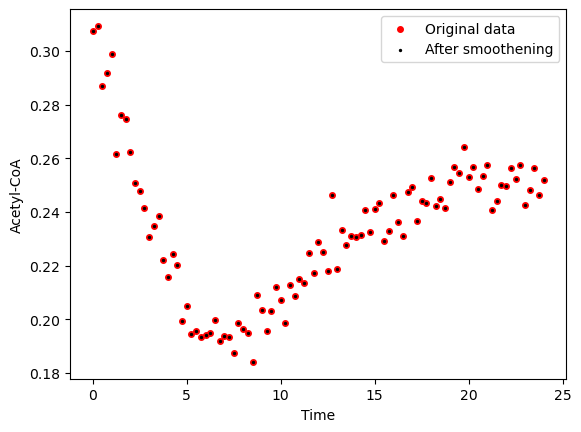

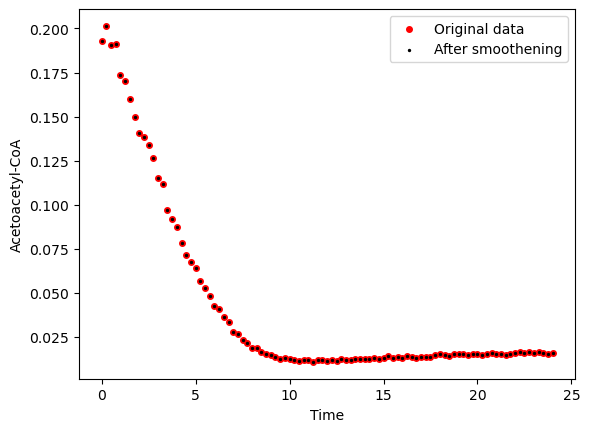

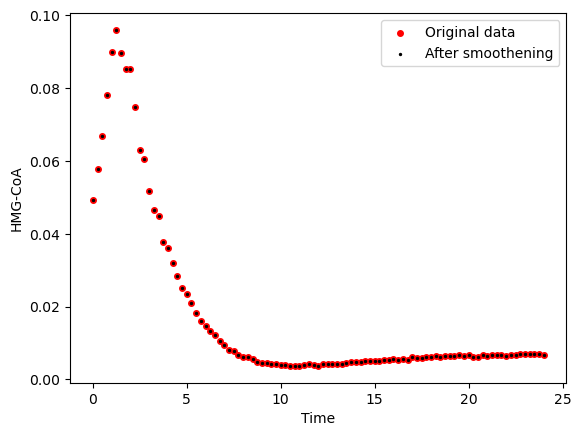

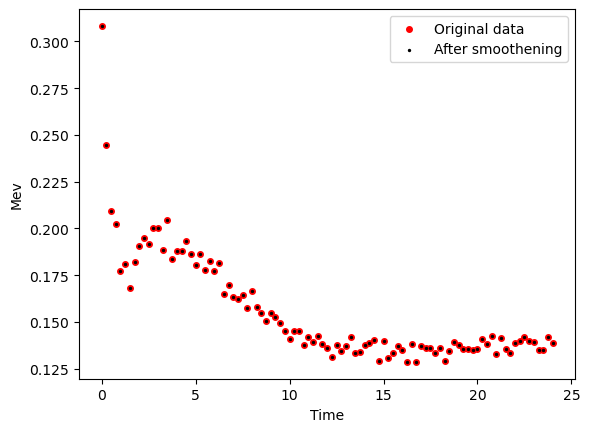

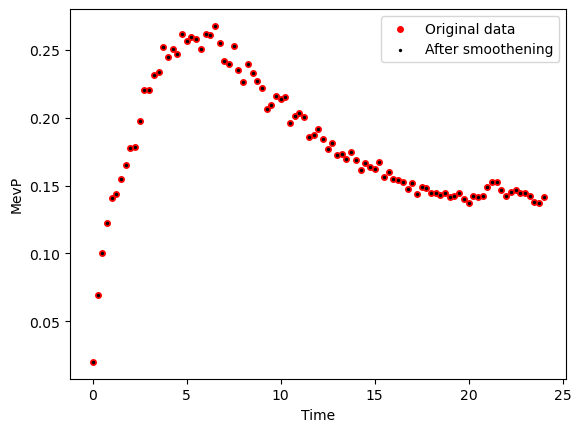

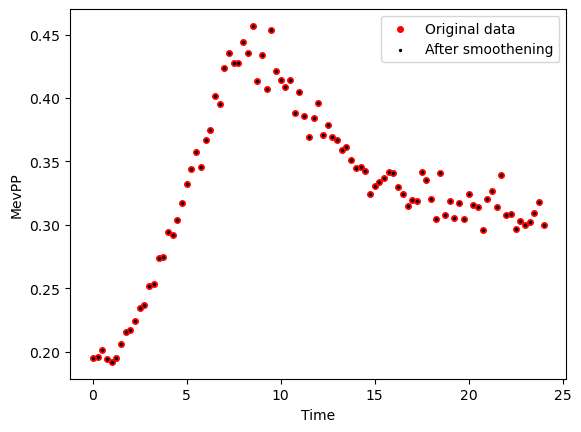

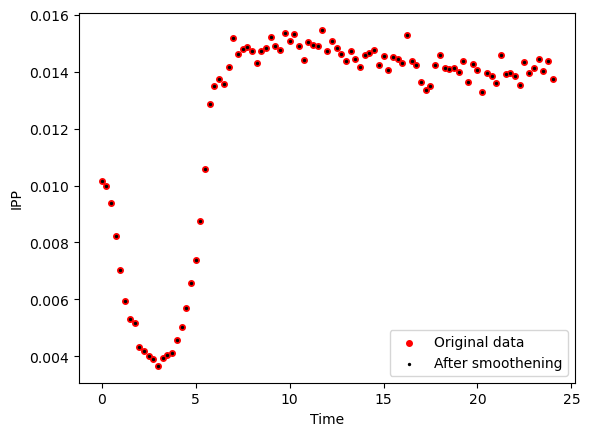

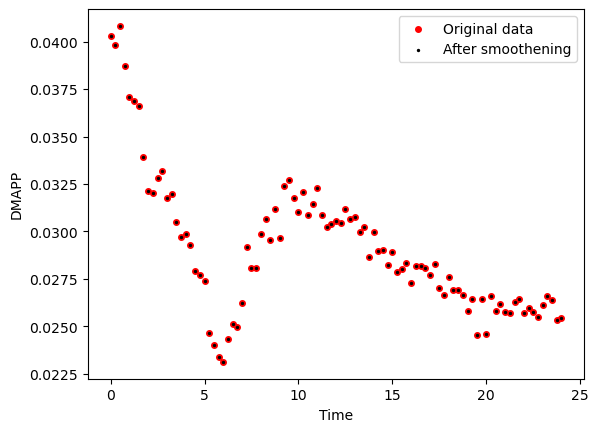

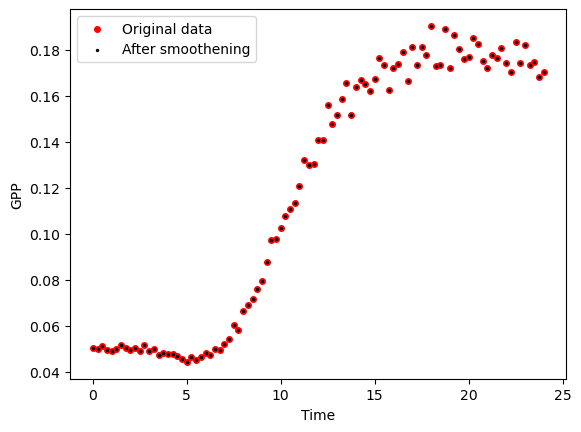

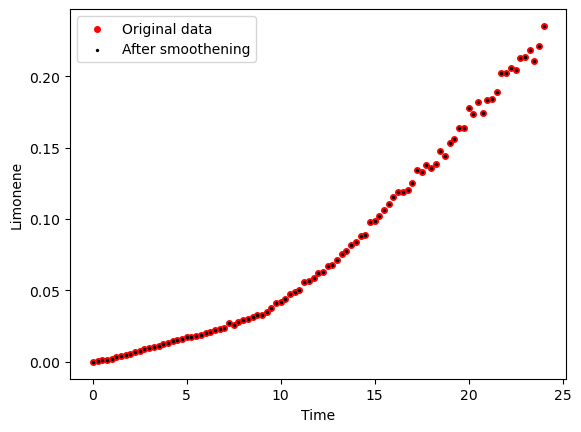

Strain Strain 2


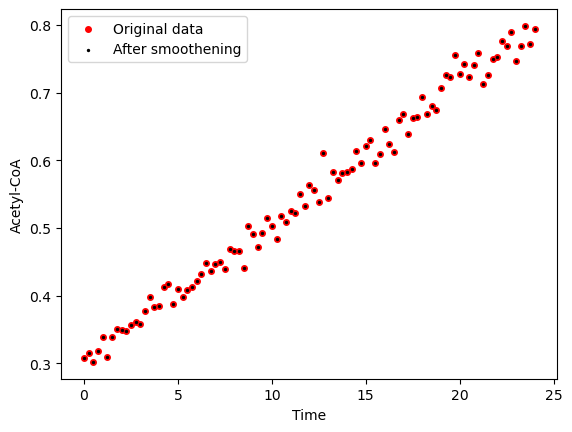

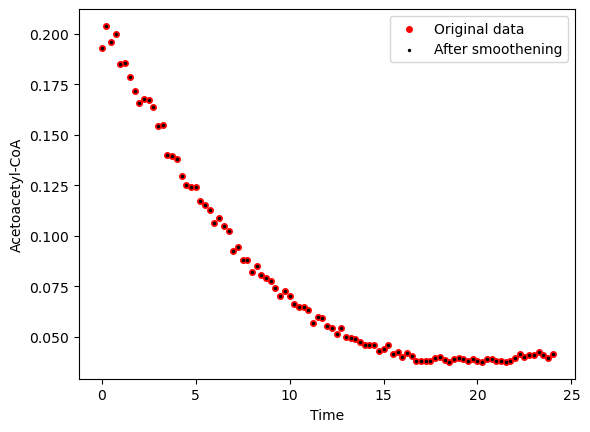

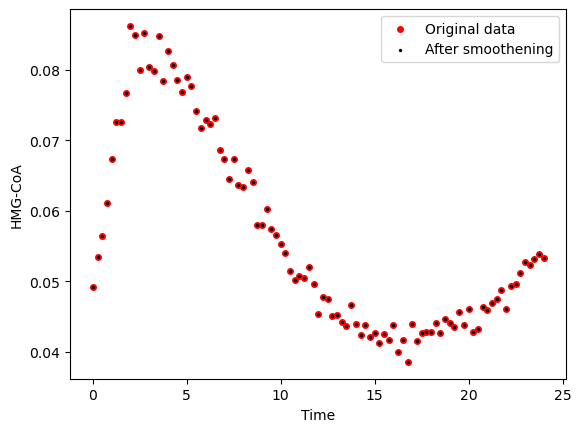

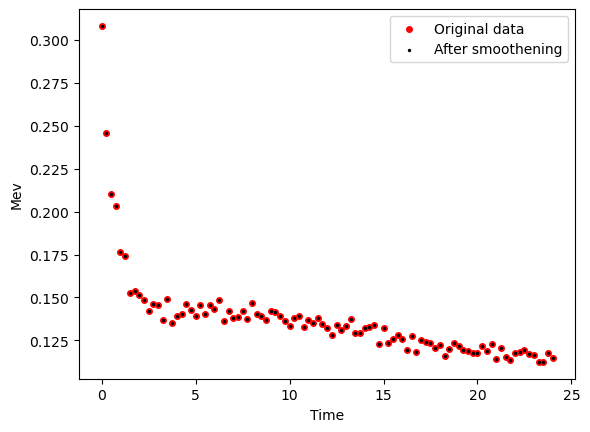

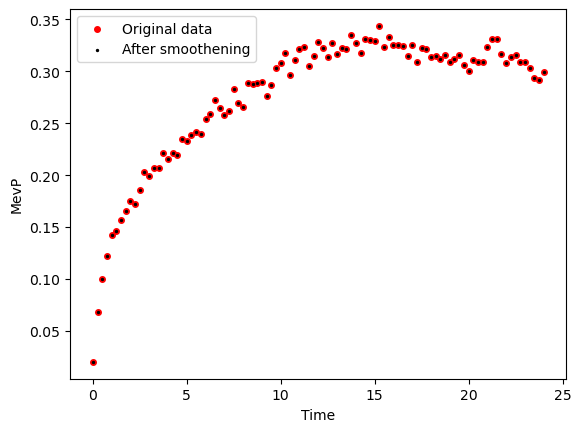

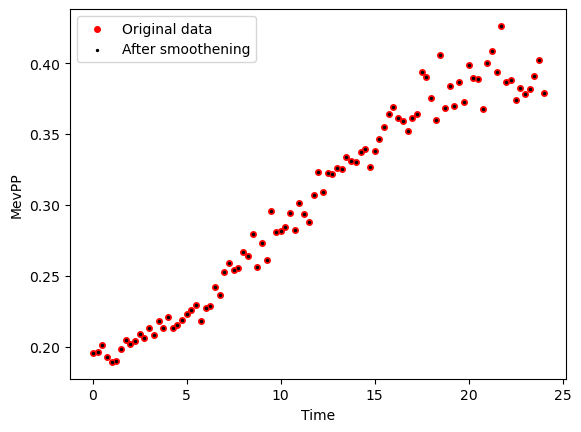

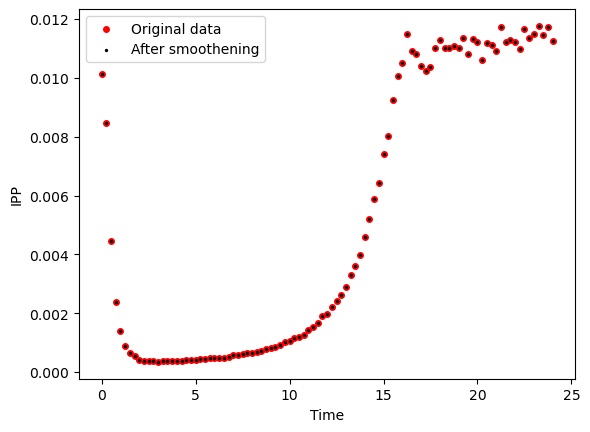

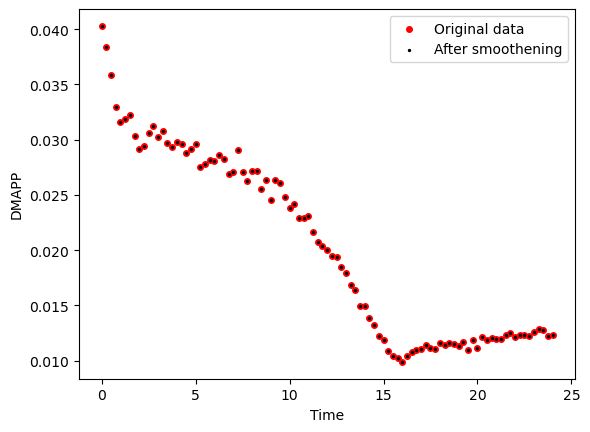

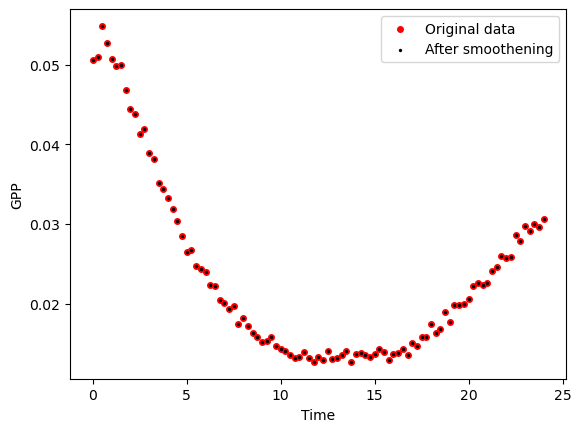

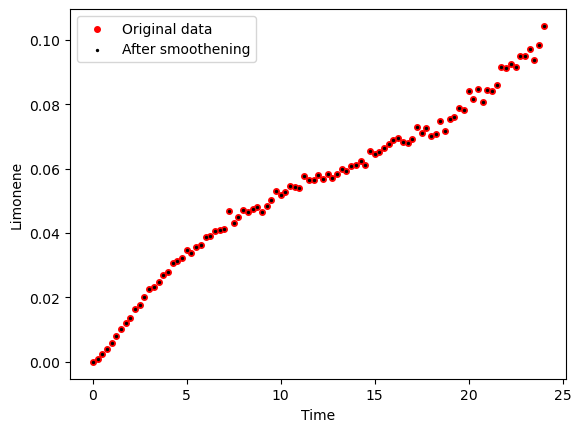

Strain Strain 3


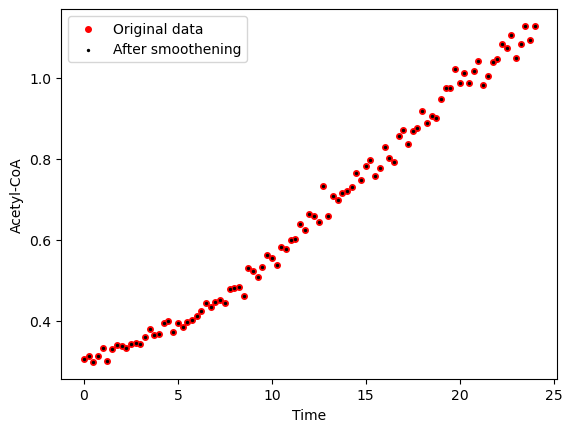

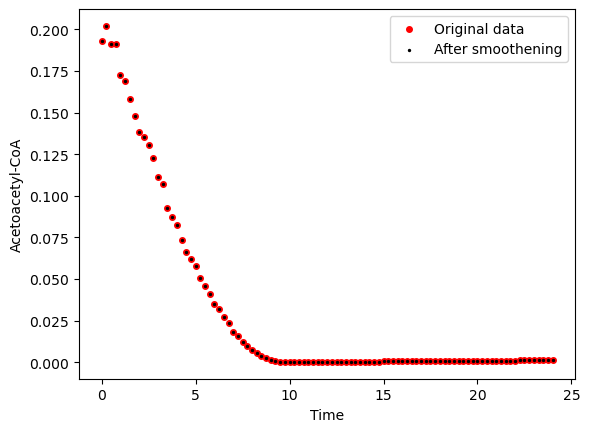

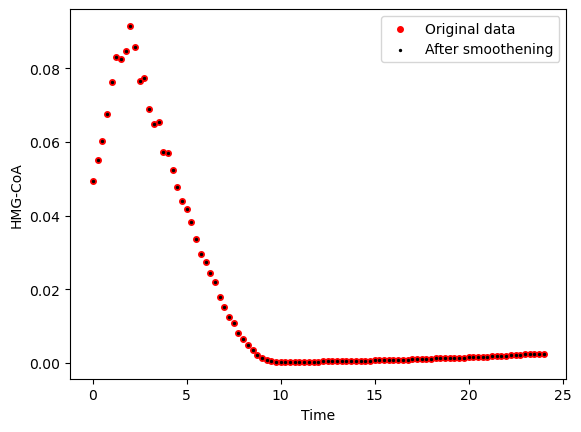

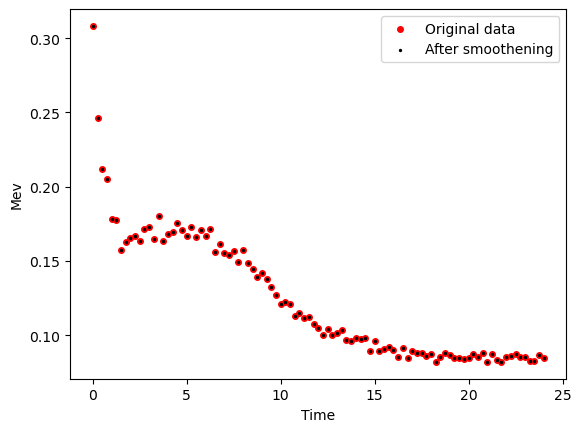

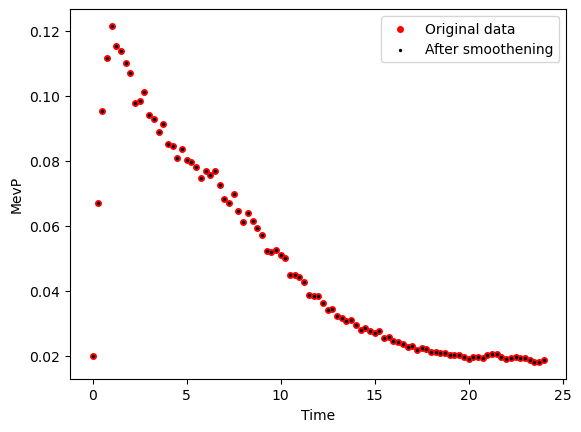

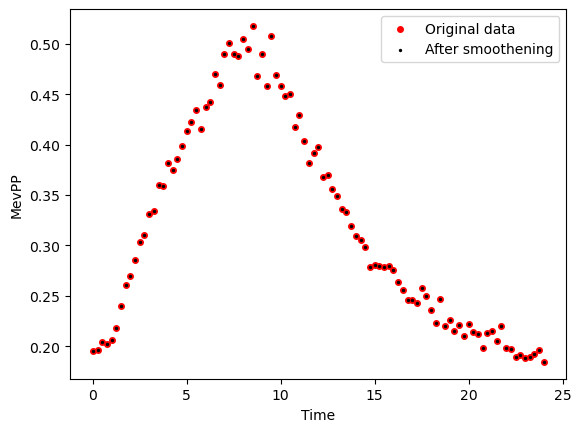

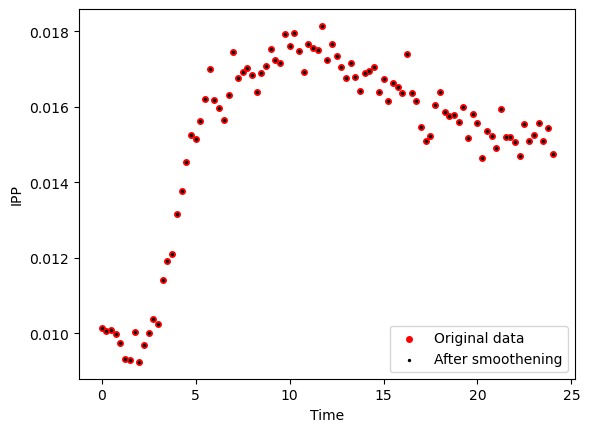

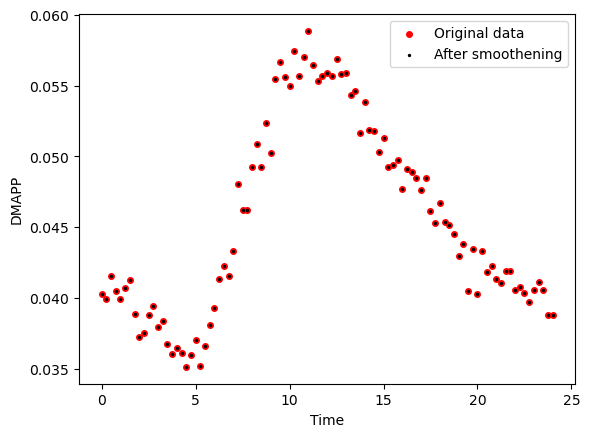

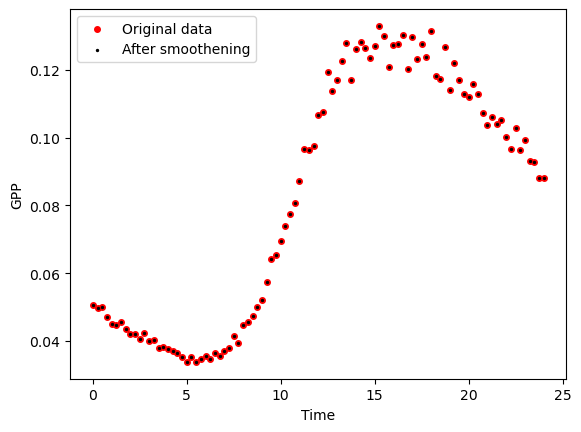

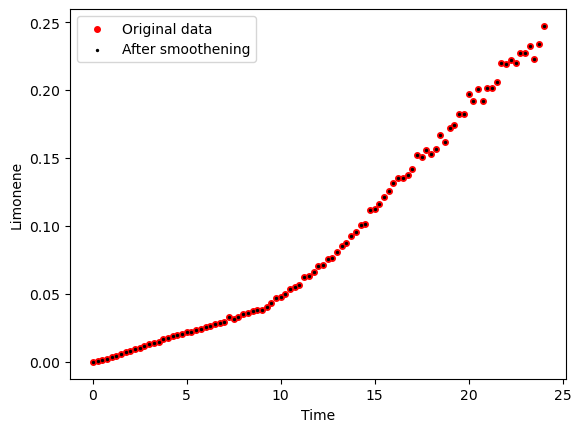

Strain WT


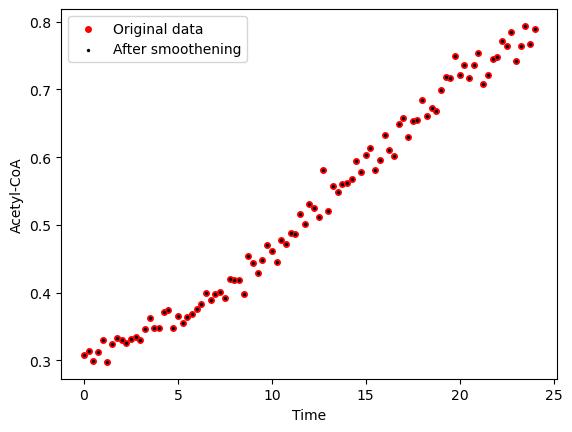

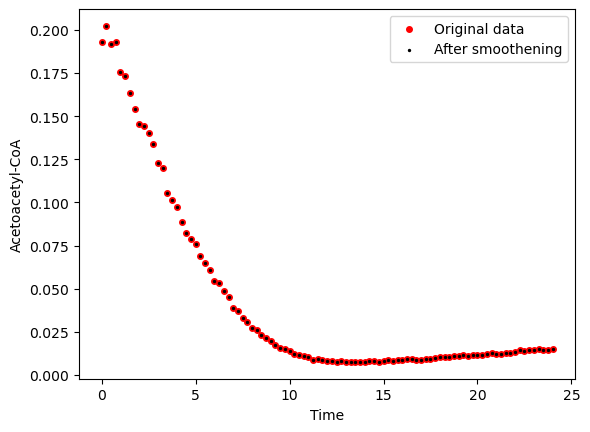

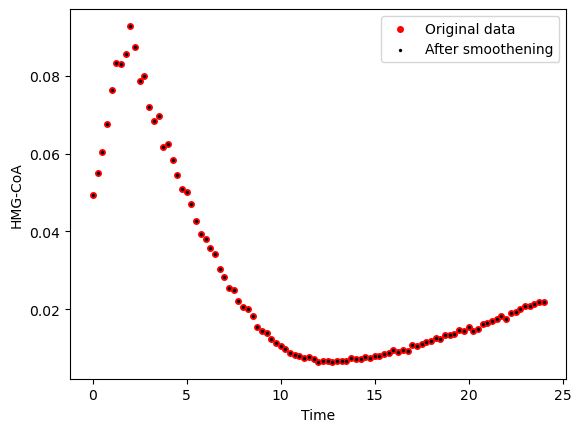

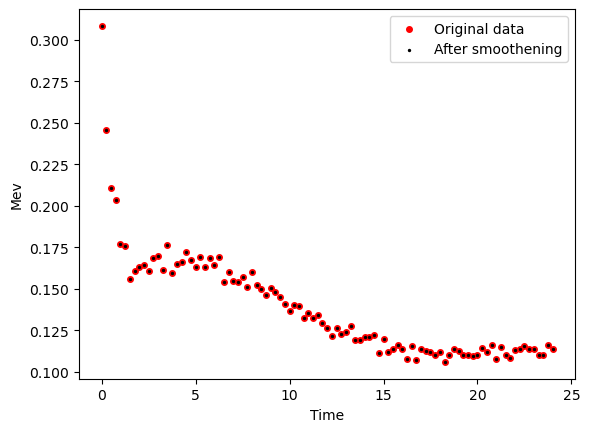

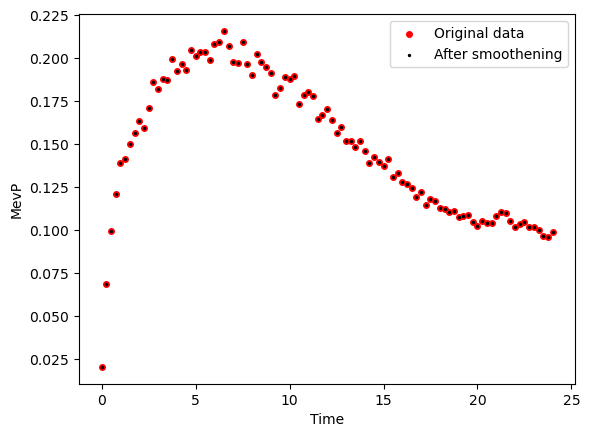

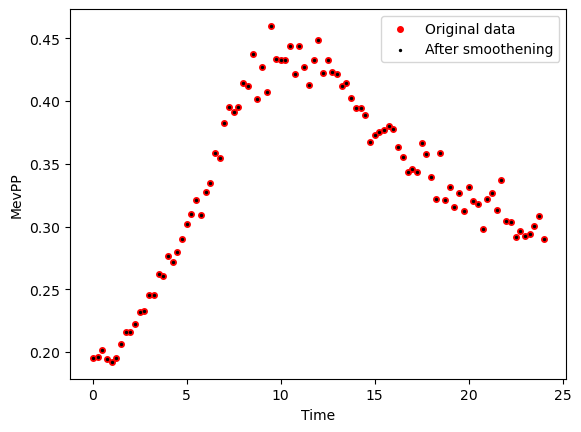

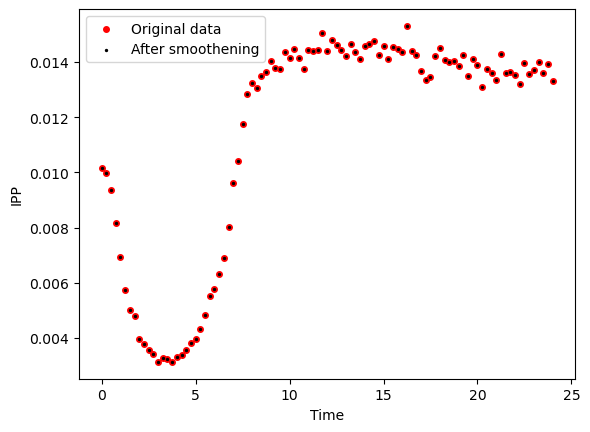

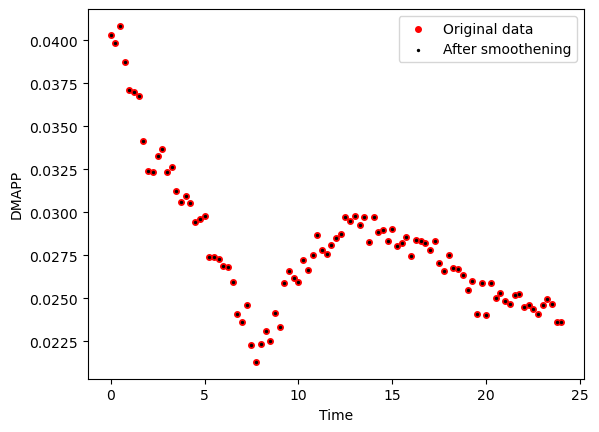

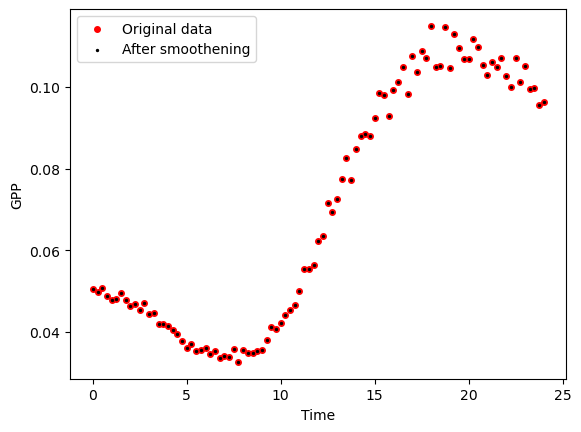

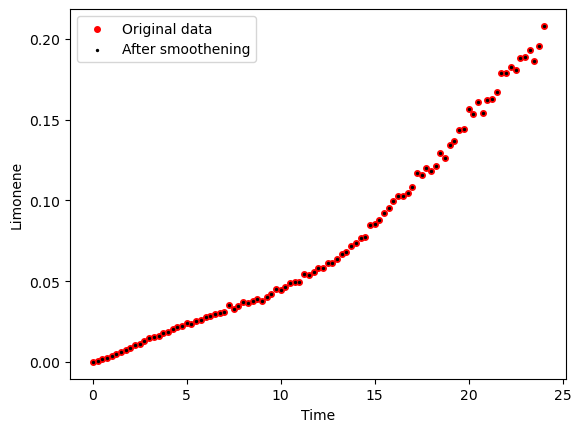

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


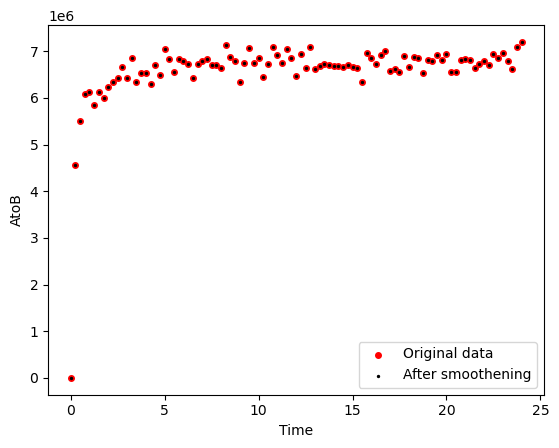

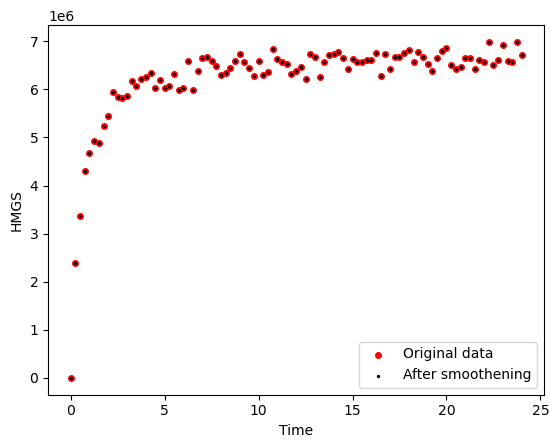

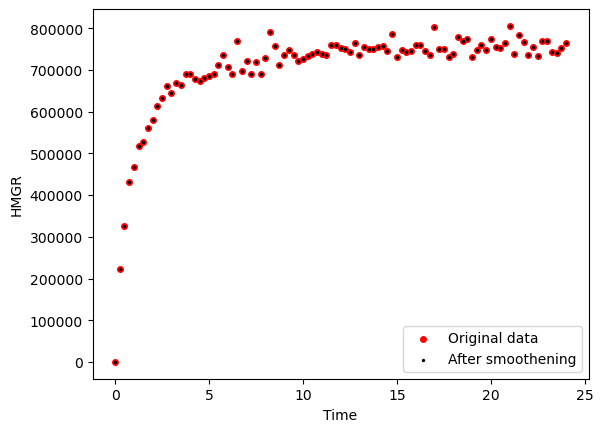

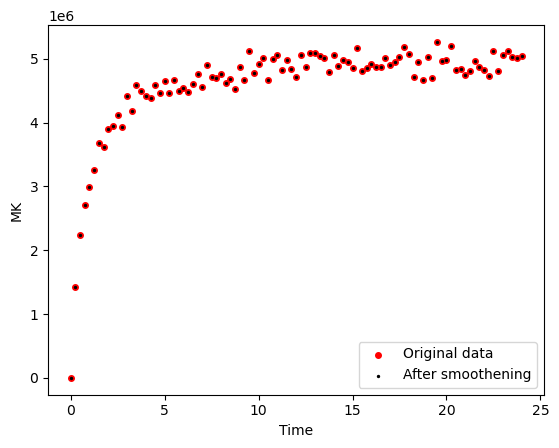

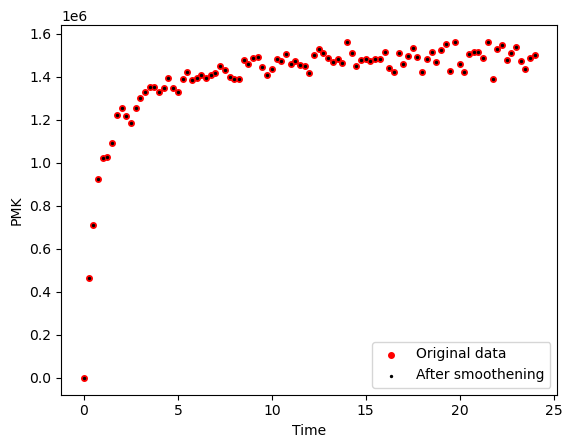

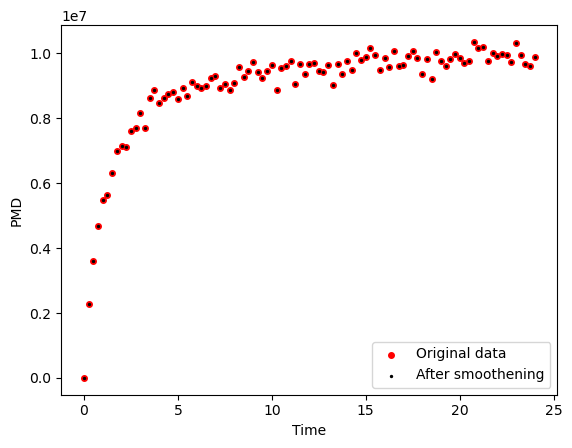

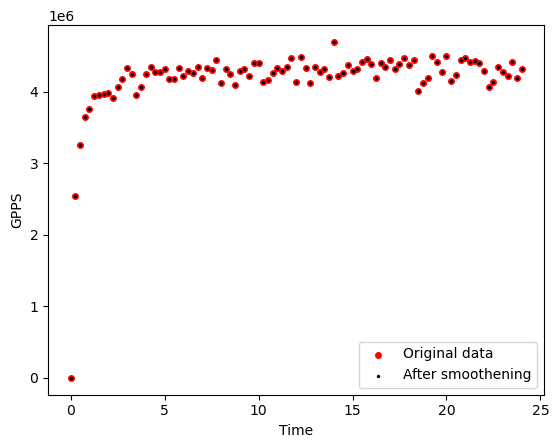

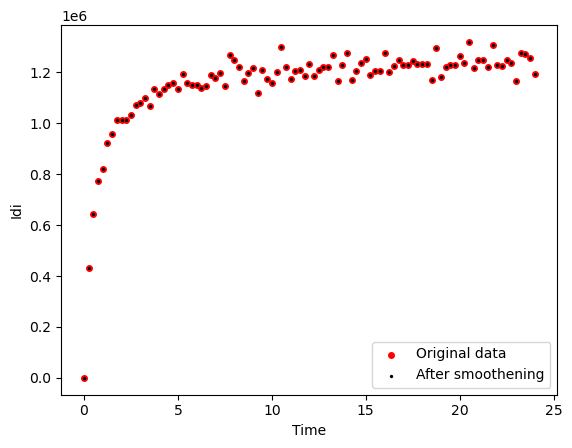

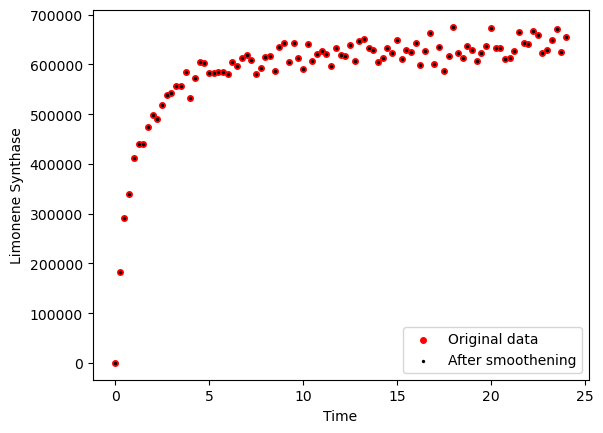

Strain Strain 2


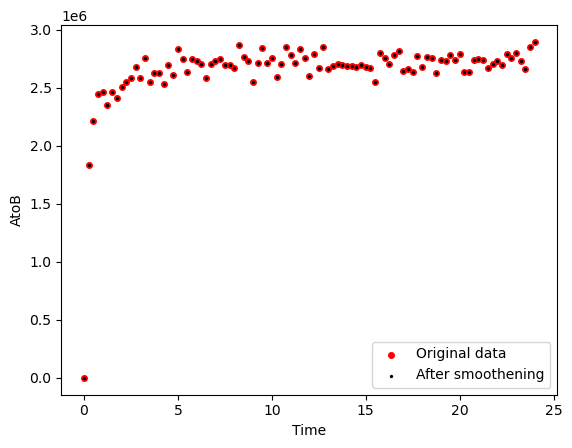

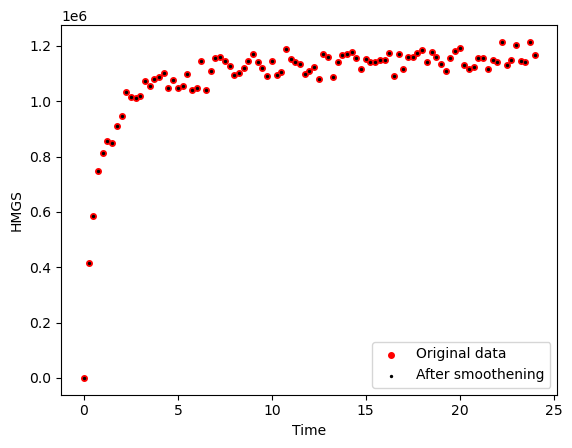

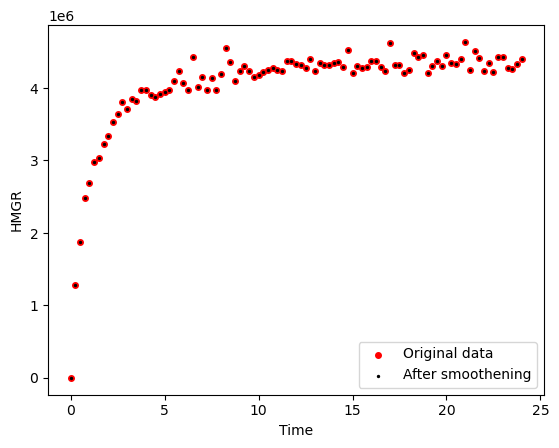

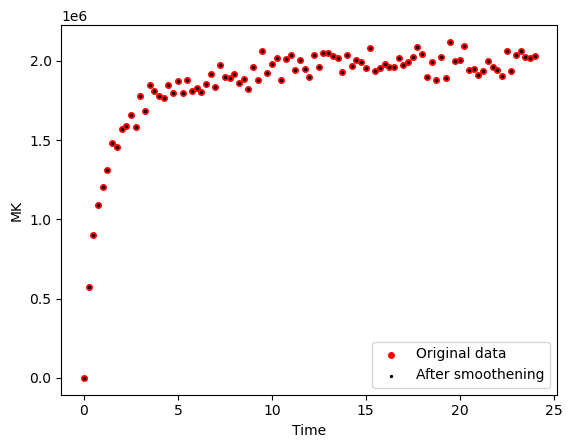

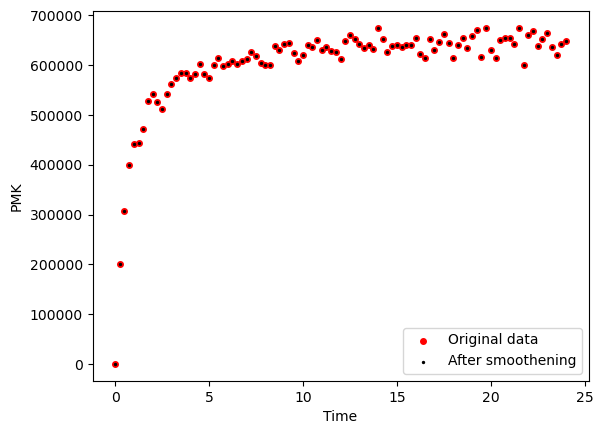

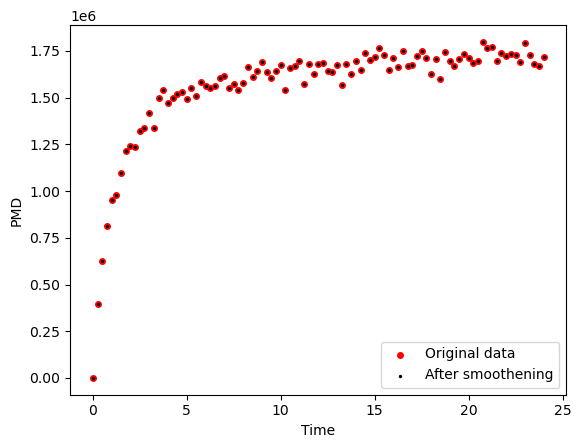

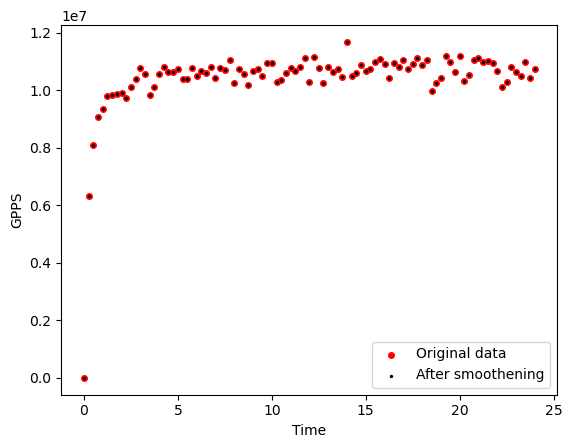

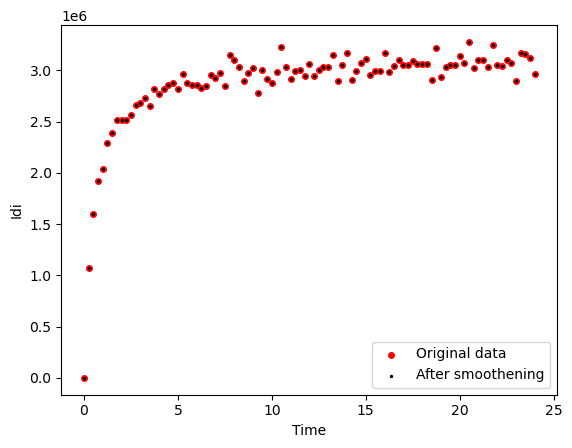

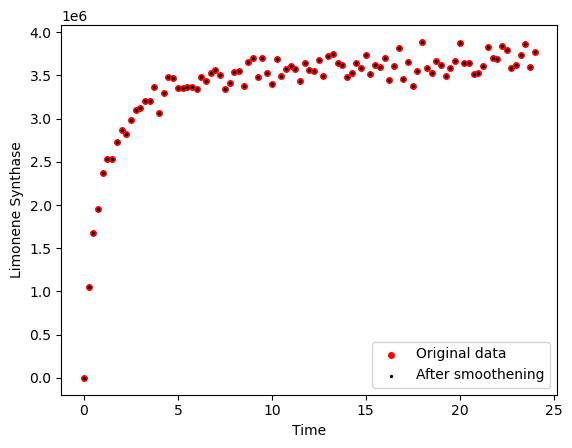

Strain Strain 3


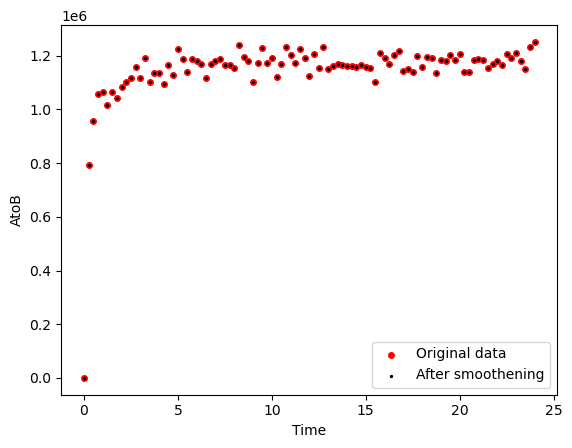

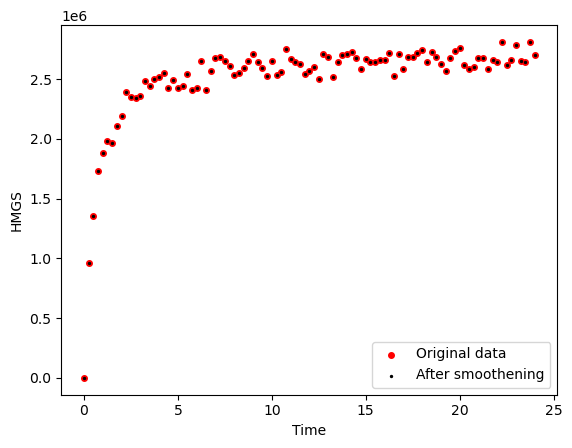

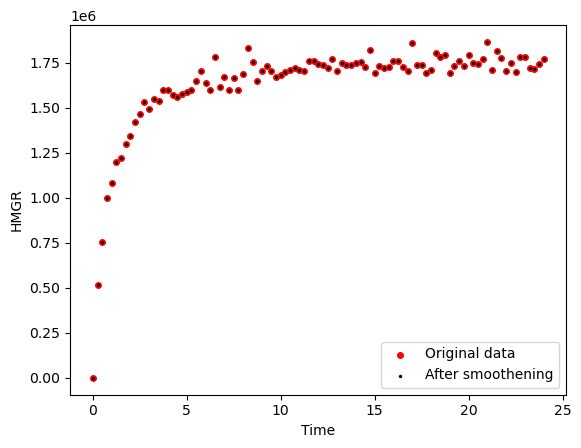

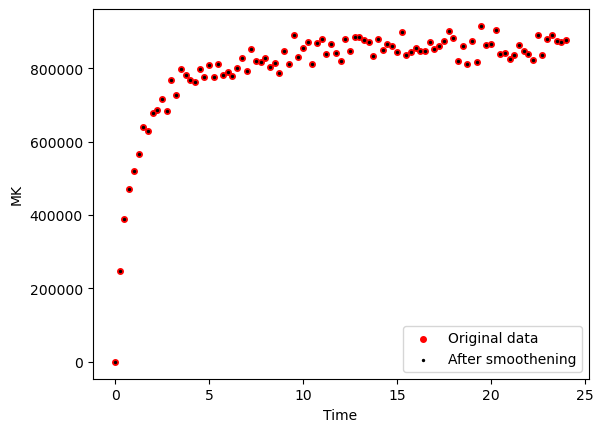

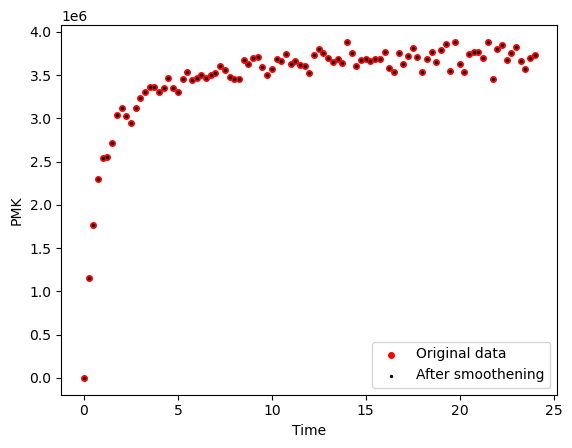

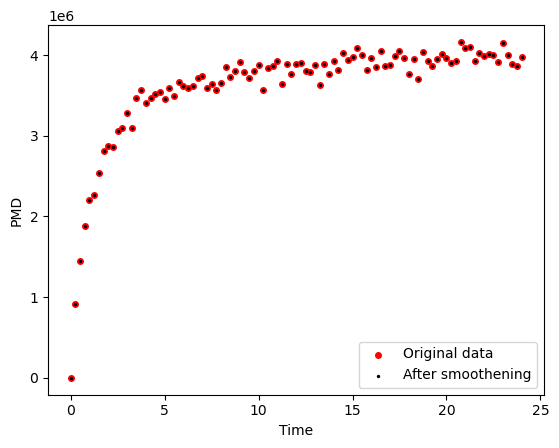

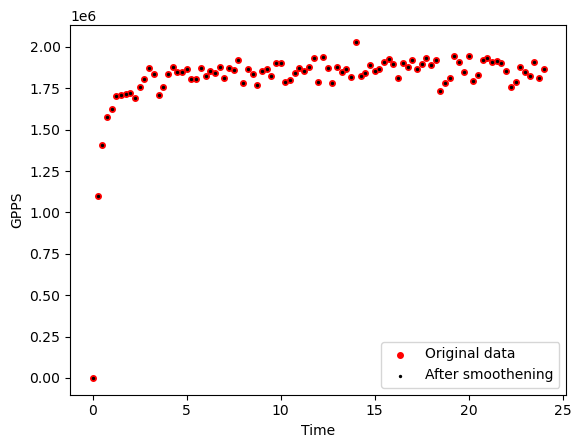

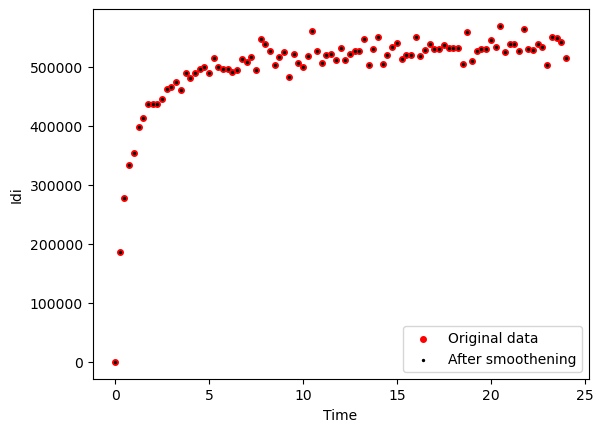

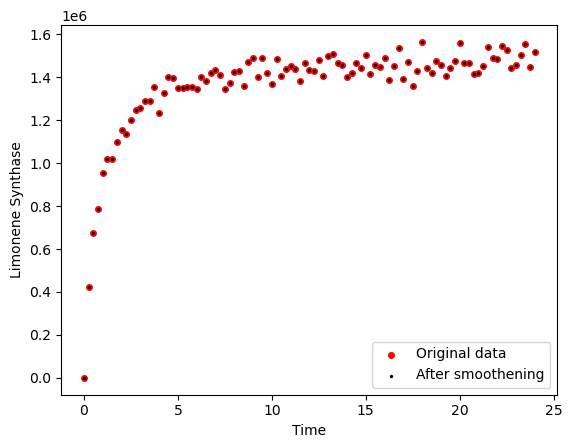

Strain WT


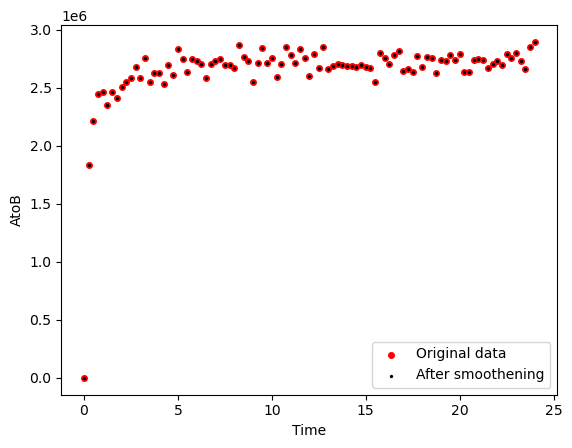

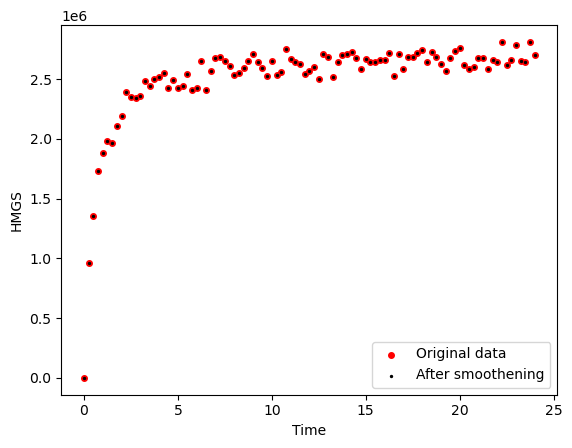

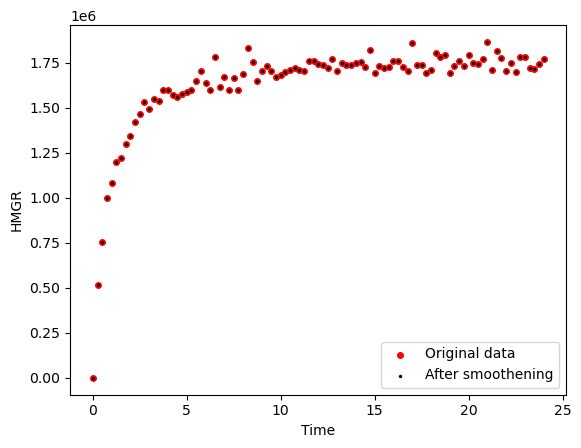

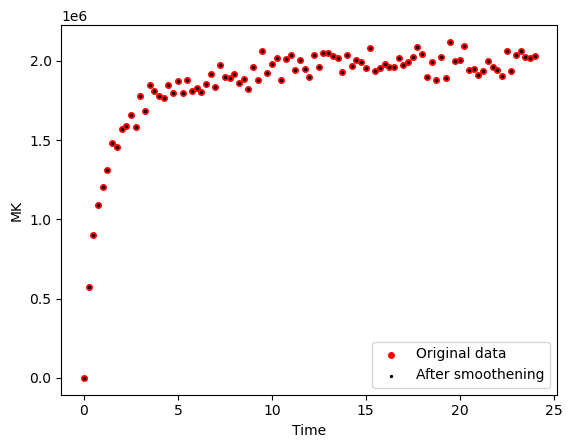

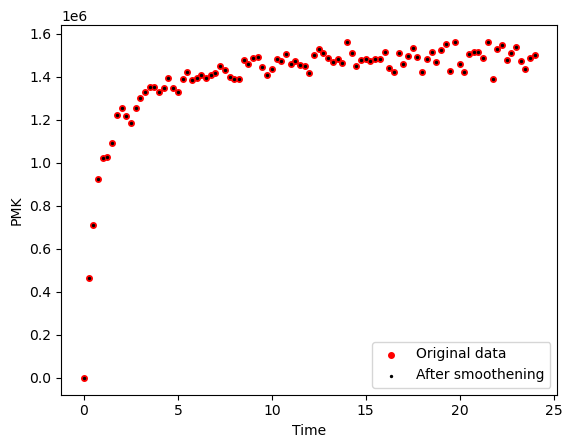

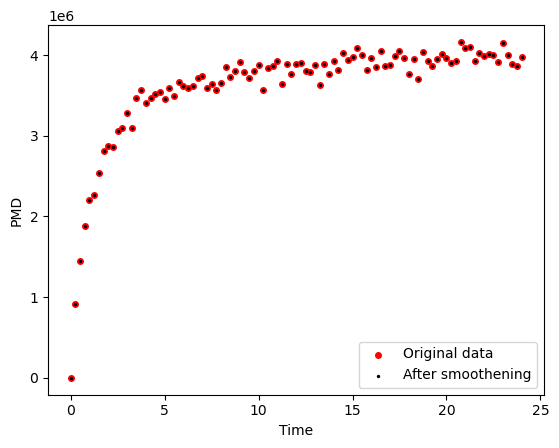

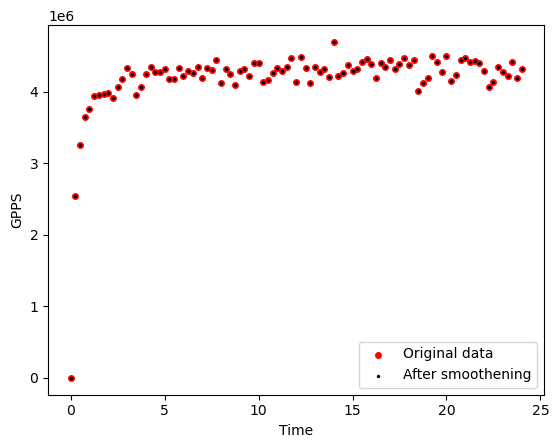

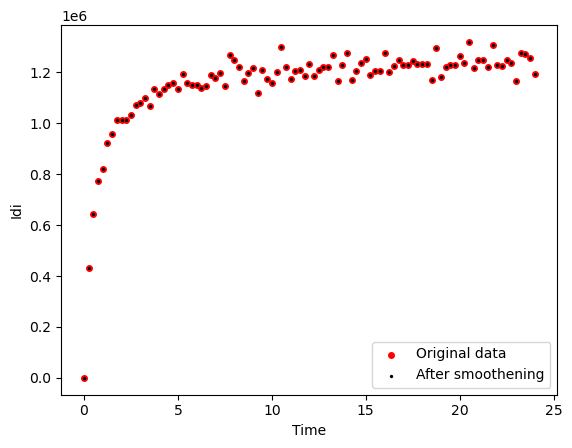

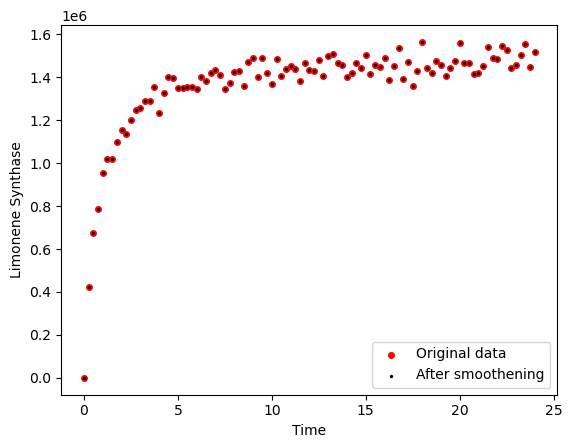

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative52

df_allSmooth=estimate_state_derivative52(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.307507        0.192847  0.049264  0.308261  0.020131   
         0.25    0.309289        0.201424  0.057705  0.244626  0.069208   
         0.50    0.286885        0.190625  0.066920  0.209178  0.100499   
         0.75    0.291694        0.191152  0.078201  0.202394  0.122481   
         1.00    0.298805        0.173484  0.089942  0.177280  0.140925   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.742292        0.014403  0.020888  0.113564  0.101795   
         23.25   0.763702        0.015134  0.020904  0.110077  0.099836   
         23.50   0.793760        0.014674  0.021450  0.110256  0.096613   
         23.75   0.767065        0.014179  0.021926  0.115985  0.096005   
         24.00   0.788743        0.015025  0.021914  0.113500  0.098686   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.195401  0.010149  0.040297  0.050591  0.000000  ...   
         0.25   0.196183  0.009969  0.039843  0.050012  0.000366  ...   
         0.50   0.201384  0.009375  0.040831  0.051394  0.001017  ...   
         0.75   0.194301  0.008243  0.038721  0.049578  0.001638  ...   
         1.00   0.192049  0.007046  0.037078  0.048995  0.002393  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.292376  0.013727  0.024601  0.105096  0.188823  ...   
         23.25  0.294256  0.014004  0.024972  0.099510  0.193287  ...   
         23.50  0.300041  0.013601  0.024665  0.099754  0.186422  ...   
         23.75  0.308237  0.013921  0.023616  0.095538  0.195773  ...   
         24.00  0.289821  0.013301  0.023641  0.096211  0.207925  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00    -0.057280        0.027446  0.030836 -0.242483  0.198600   
         0.25    -0.035640        0.003924  0.035789 -0.182080  0.158272   
         0.50    -0.013999       -0.019599  0.040741 -0.121677  0.117944   
         0.75    -0.033430       -0.031879  0.039818 -0.063644  0.075700   
         1.00    -0.020555       -0.033002  0.025346 -0.041214  0.051745   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.015434        0.000957  0.002109 -0.005818 -0.006921   
         23.25    0.006862       -0.000021  0.001710  0.000498 -0.006766   
         23.50    0.038506        0.000116  0.001229  0.002311 -0.004019   
         23.75    0.006381        0.000226  0.001157  0.006628  0.002778   
         24.00   -0.025744        0.000336  0.001084  0.010945  0.009576   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00   0.017539 -0.000234  0.003233  0.002212  0.001570  
         0.25   0.007052 -0.001704  0.000105  0.000381  0.001997  
         0.50  -0.003435 -0.003173 -0.003024 -0.001450  0.002423  
         0.75  -0.004780 -0.004159 -0.003858 -0.001099  0.002803  
         1.00   0.003966 -0.004187 -0.004091  0.000476  0.003101  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.005749 -0.000121  0.000588 -0.006573  0.006493  
         23.25  0.012220  0.000224 -0.000330 -0.006733  0.005205  
         23.50  0.003548 -0.000374 -0.001311 -0.008697  0.016276  
         23.75 -0.018269 -0.000987 -0.002130 -0.004092  0.034329  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

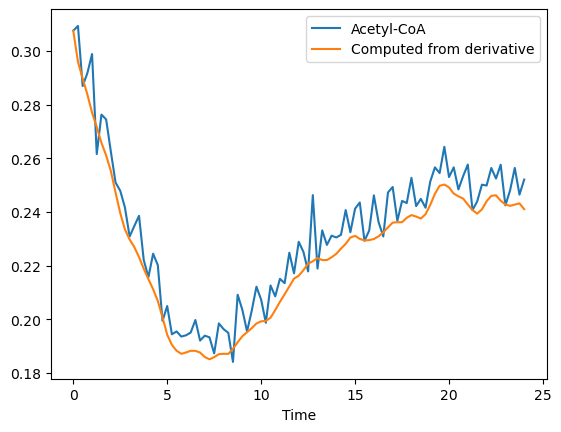

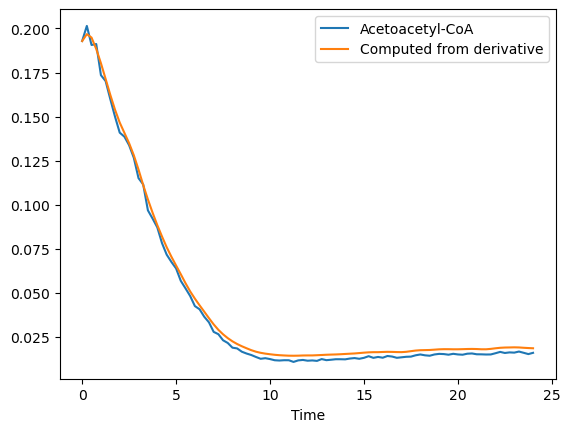

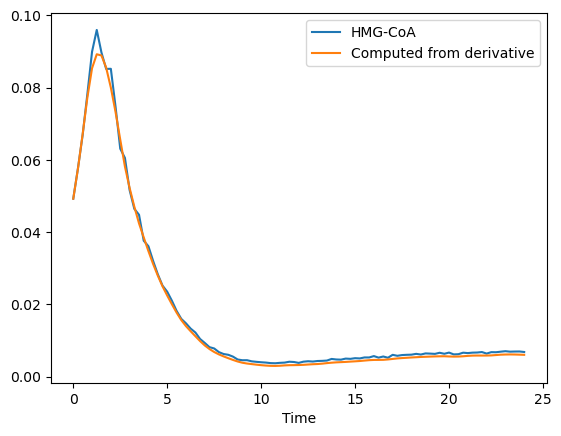

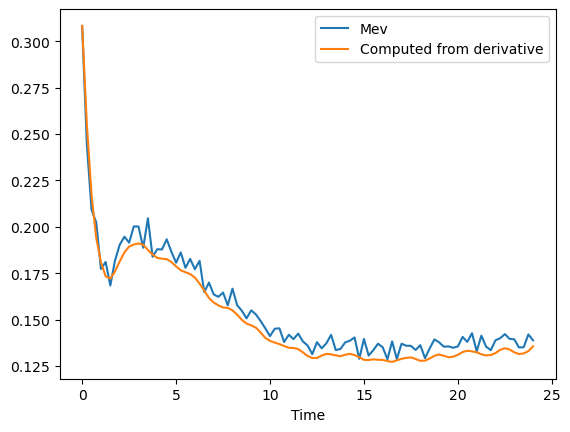

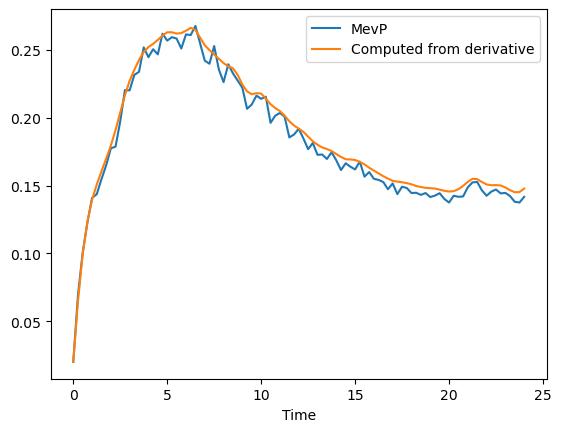

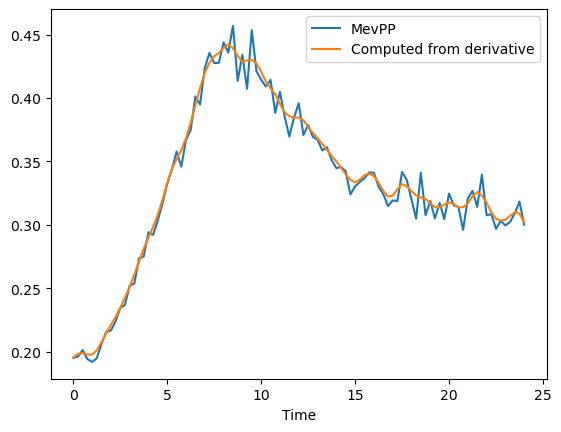

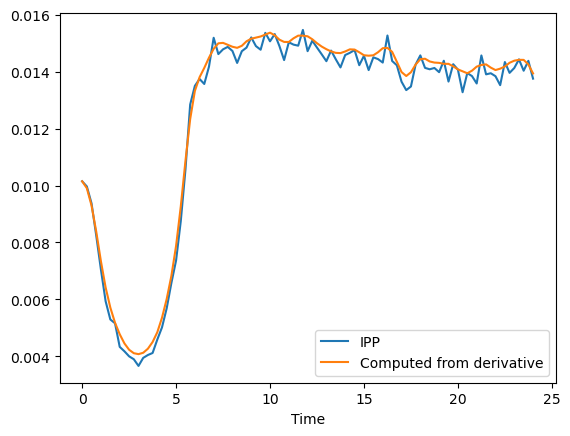

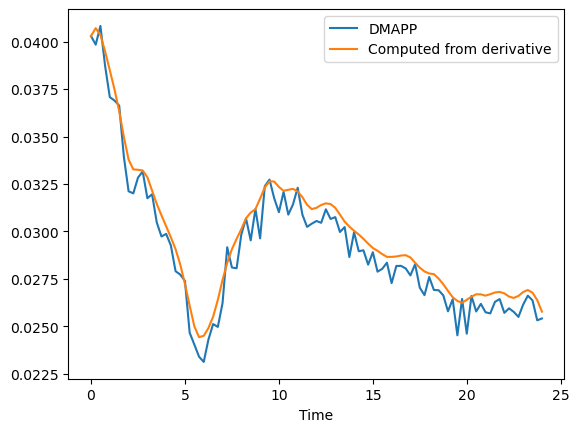

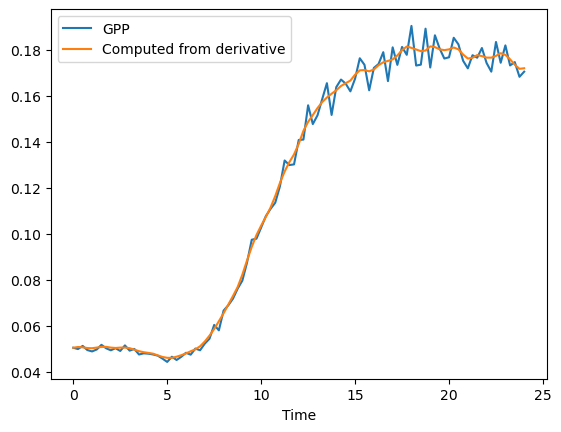

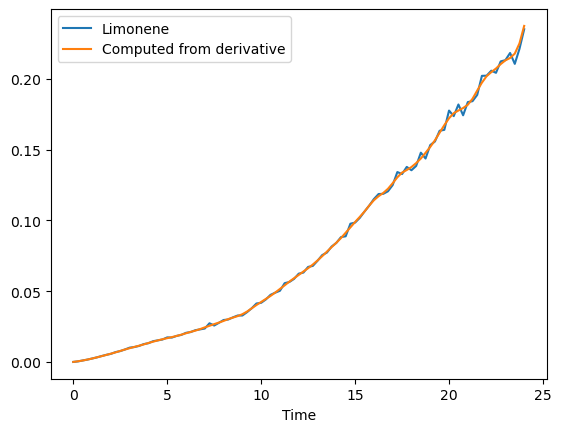

'Time profile from derivative vs. actual profile for Strain 2'

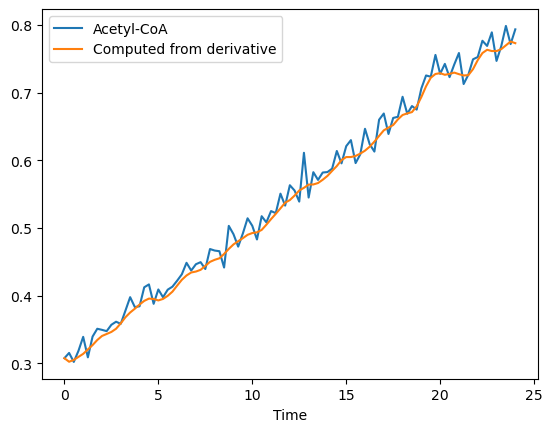

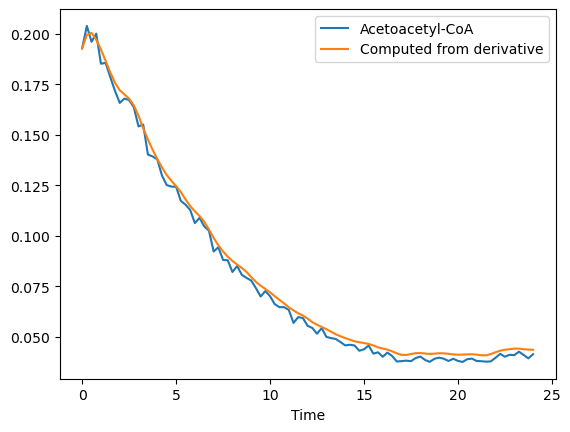

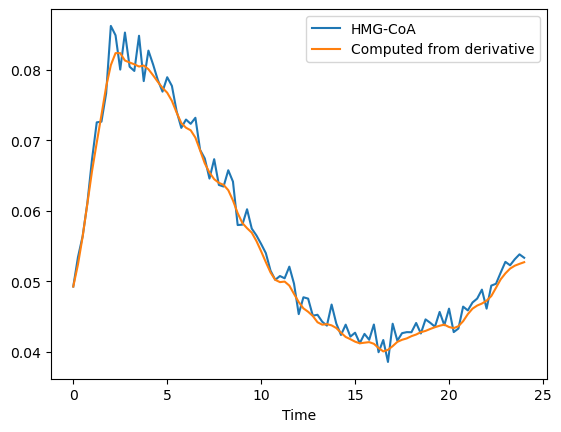

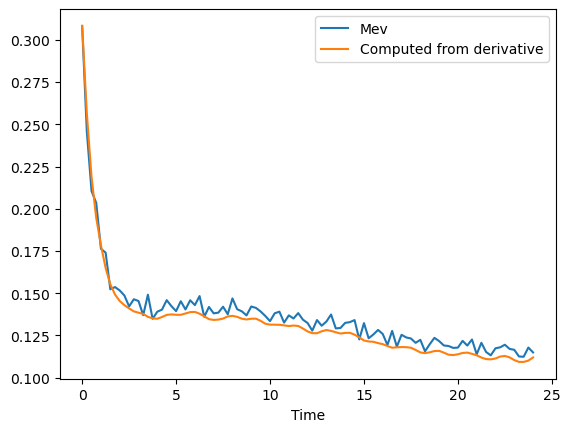

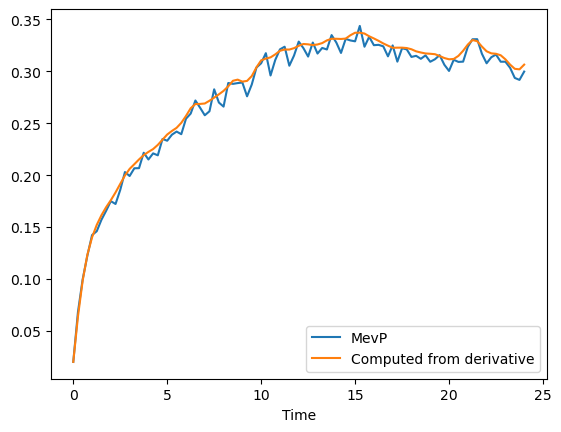

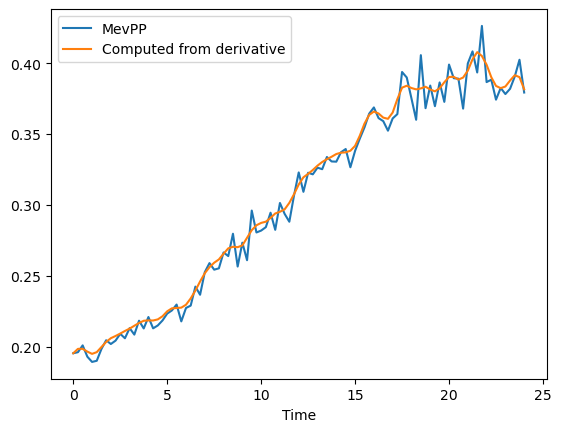

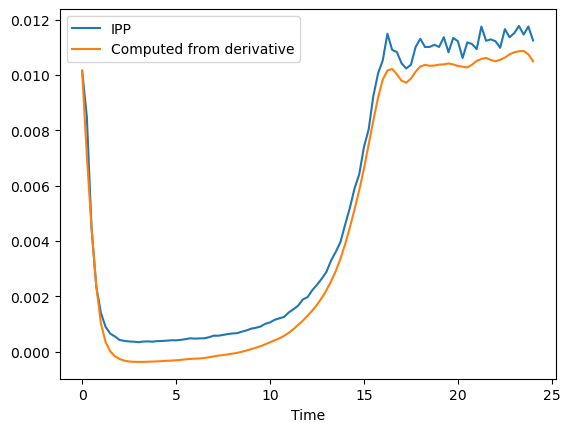

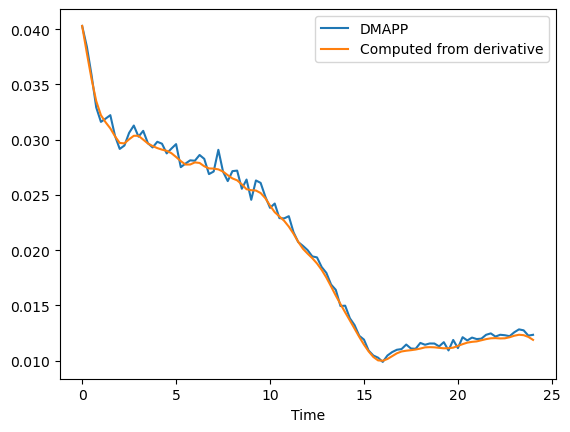

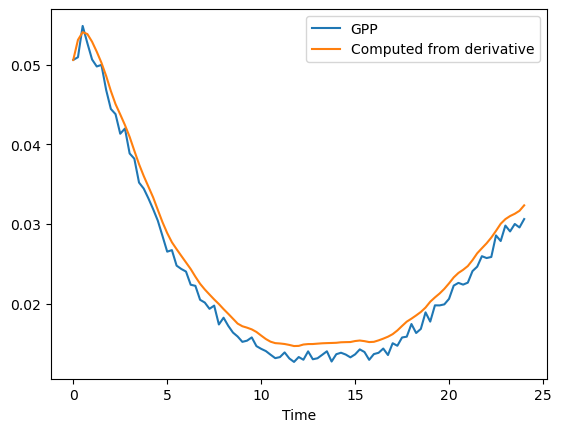

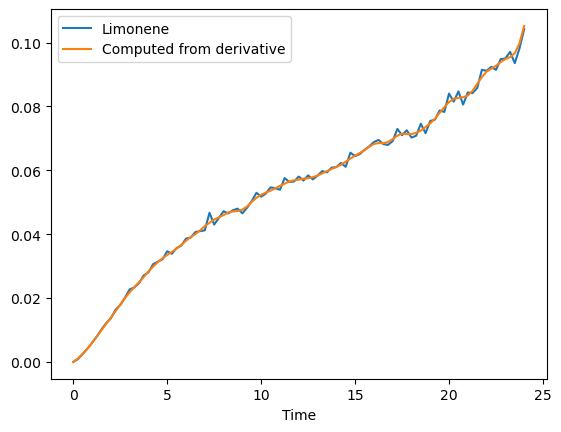

'Time profile from derivative vs. actual profile for Strain 3'

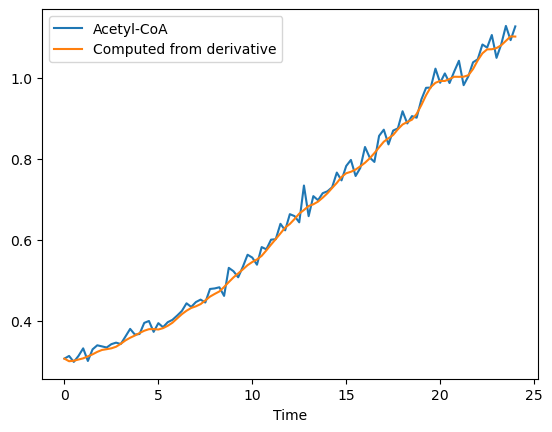

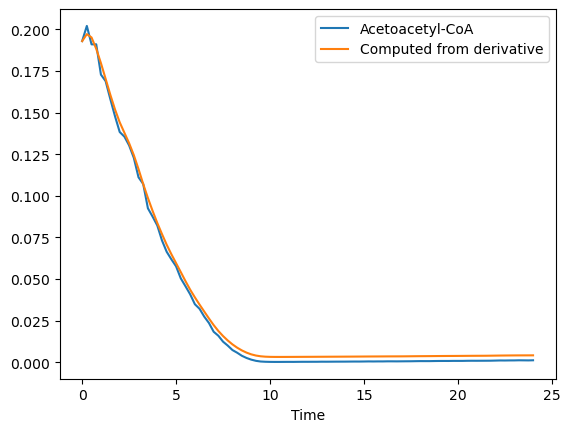

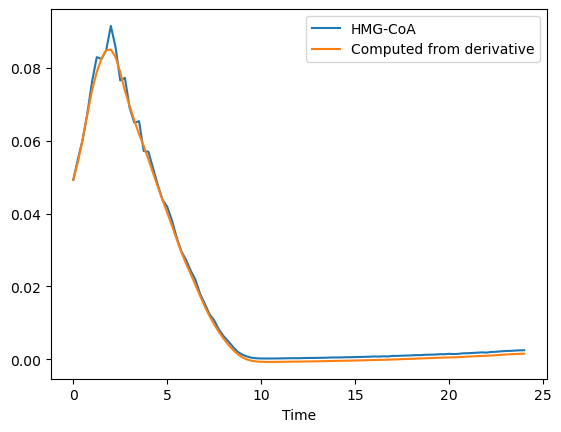

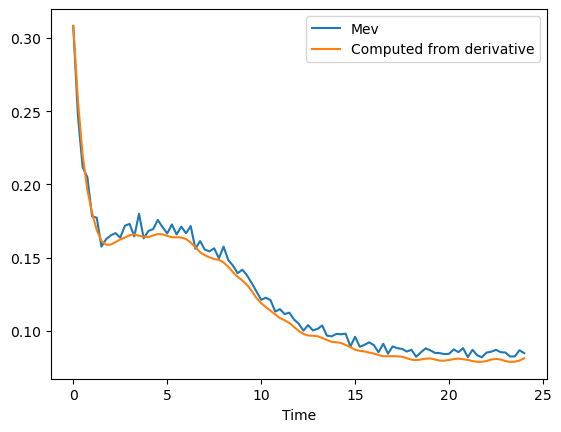

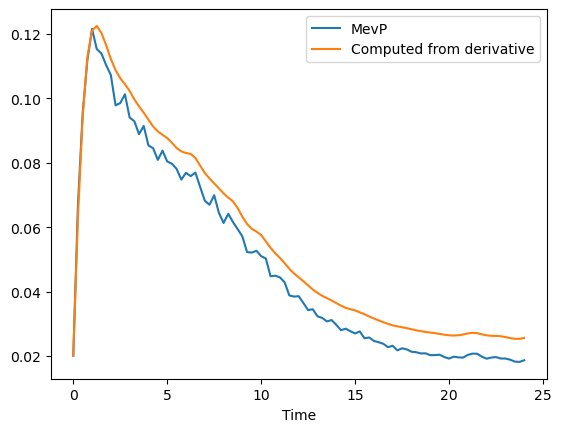

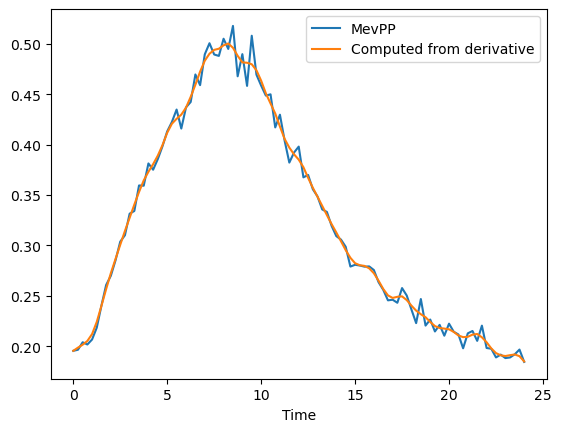

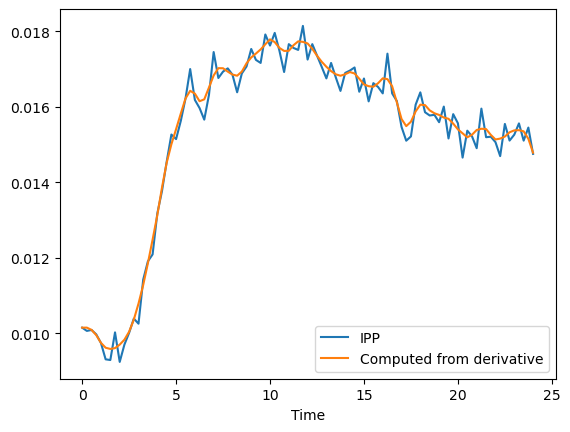

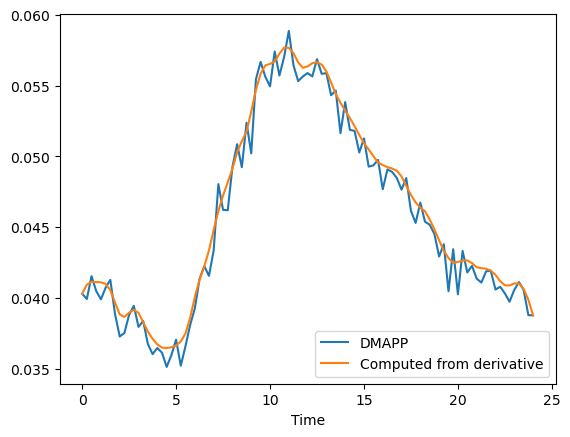

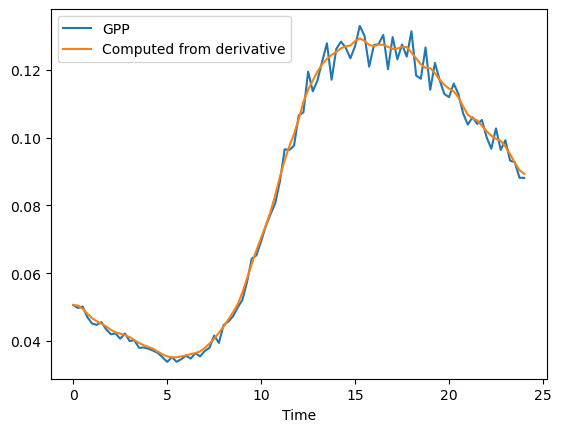

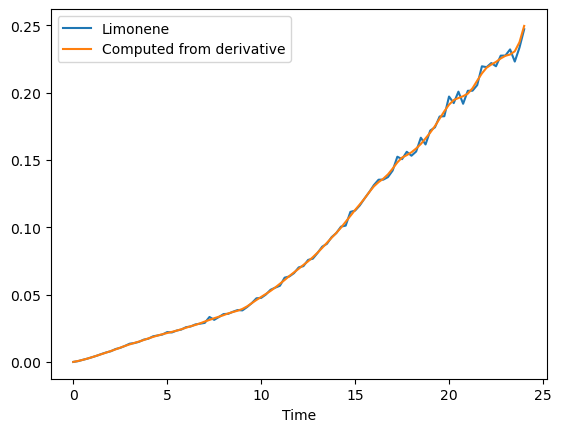

'Time profile from derivative vs. actual profile for WT'

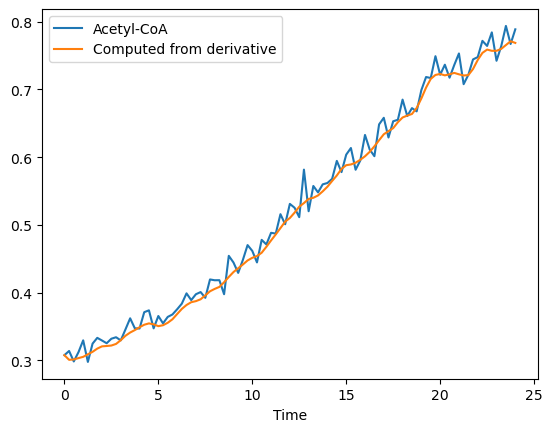

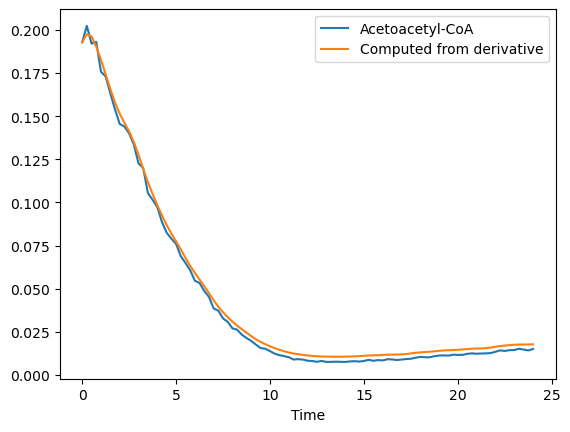

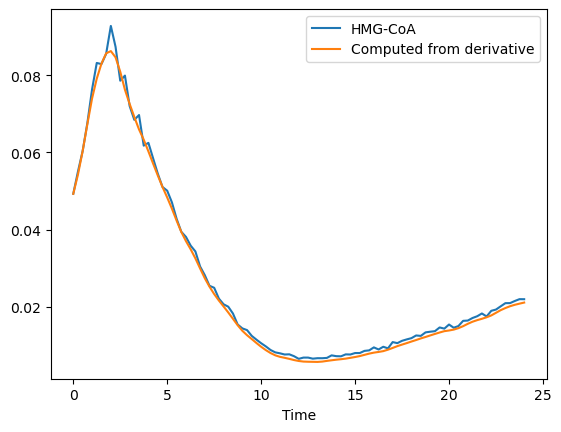

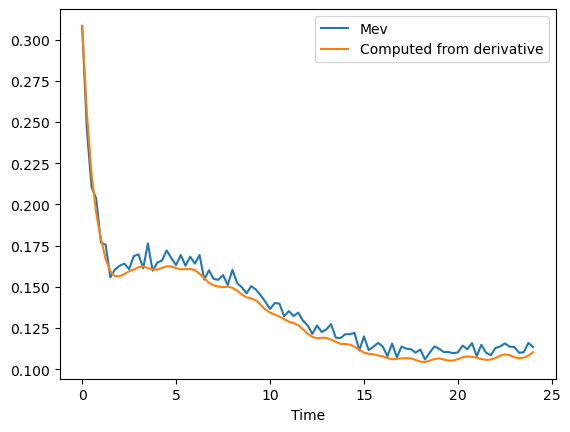

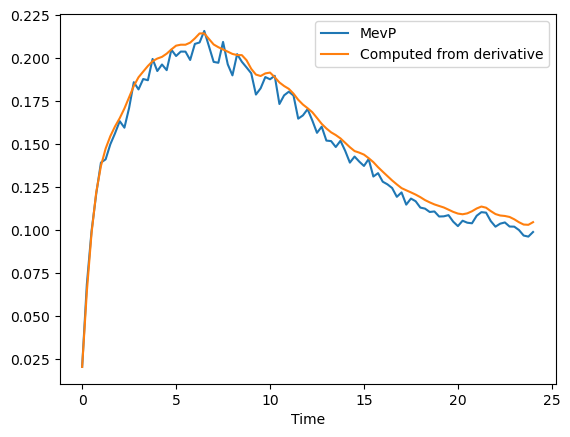

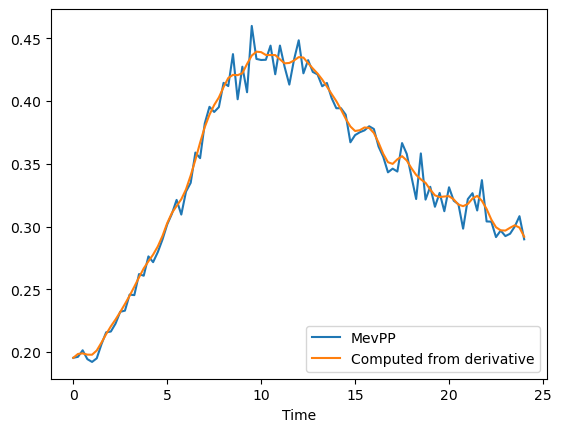

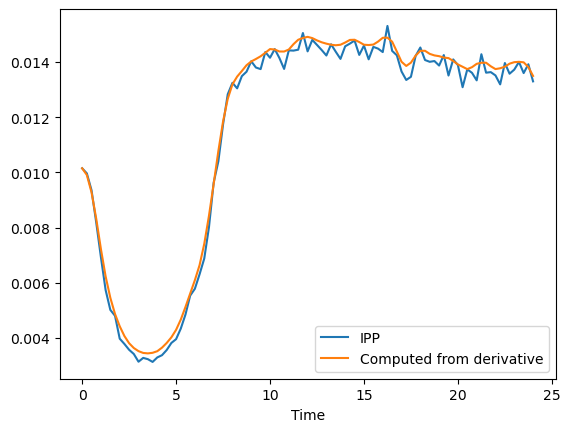

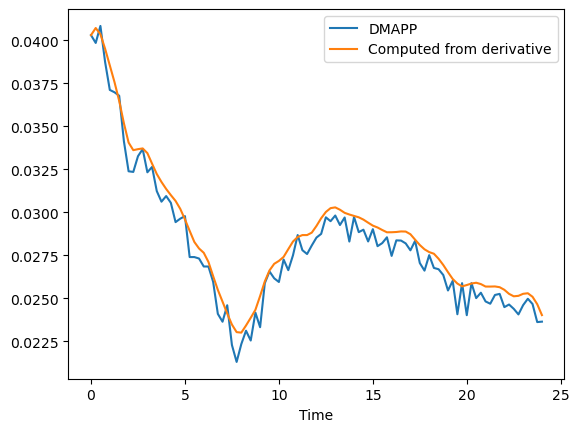

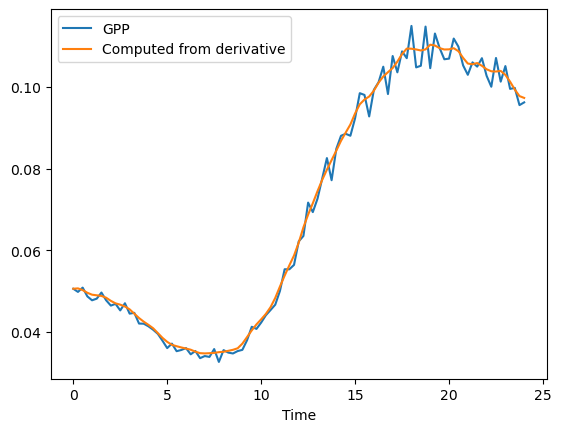

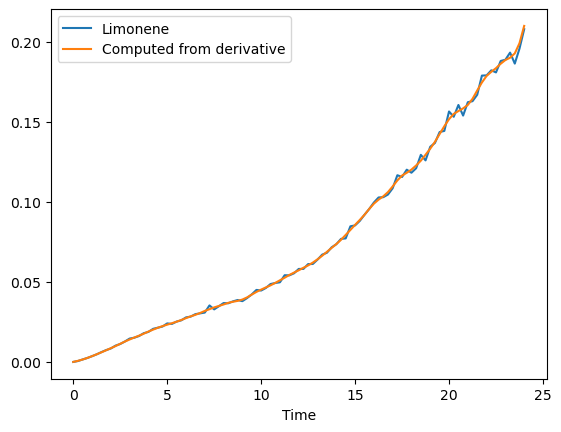

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   6.095775e+01  3.830916e+01  3.642460e+01  5.920951e+01   
         0.25   4.562280e+06  2.387218e+06  2.235850e+05  1.427086e+06   
         0.50   5.504432e+06  3.365541e+06  3.247253e+05  2.241663e+06   
         0.75   6.091505e+06  4.296528e+06  4.321469e+05  2.709233e+06   
         1.00   6.135963e+06  4.682593e+06  4.680041e+05  2.995600e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.798586e+06  2.781692e+06  1.783012e+06  2.035337e+06   
         23.25  2.728784e+06  2.650398e+06  1.720474e+06  2.059733e+06   
         23.50  2.660750e+06  2.644709e+06  1.715498e+06  2.021107e+06   
         23.75  2.849446e+06  2.810695e+06  1.740797e+06  2.018694e+06   
         24.00  2.896286e+06  2.699434e+06  1.767956e+06  2.029364e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.677443e+01  5.322851e+01  5.629791e+01  1.882676e+01   
         0.25   4.627639e+05  2.286100e+06  2.550127e+06  4.317176e+05   
         0.50   7.122424e+05  3.593802e+06  3.257557e+06  6.426762e+05   
         0.75   9.261810e+05  4.686807e+06  3.653431e+06  7.714662e+05   
         1.00   1.020998e+06  5.491013e+06  3.759702e+06  8.180992e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.536728e+06  4.151637e+06  4.284493e+06  1.165858e+06   
         23.25  1.471363e+06  3.997512e+06  4.218226e+06  1.274865e+06   
         23.50  1.436512e+06  3.889987e+06  4.419343e+06  1.271866e+06   
         23.75  1.486919e+06  3.867592e+06  4.201317e+06  1.255360e+06   
         24.00  1.501886e+06  3.974894e+06  4.319973e+06  1.191504e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.069984e+01   0.307507        0.192847  0.049264   
         0.25       1.833784e+05   0.309289        0.201424  0.057705   
         0.50       2.904854e+05   0.286885        0.190625  0.066920   
         0.75       3.394283e+05   0.291694        0.191152  0.078201   
         1.00       4.114768e+05   0.298805        0.173484  0.089942   
...                          ...        ...             ...       ...   
WT       23.00      1.457436e+06   0.742292        0.014403  0.020888   
         23.25      1.503237e+06   0.763702        0.015134  0.020904   
         23.50      1.553956e+06   0.793760        0.014674  0.021450   
         23.75      1.447999e+06   0.767065        0.014179  0.021926   
         24.00      1.515156e+06   0.788743        0.015025  0.021914   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.308261  0.020131  0.195401  0.010149  0.040297  0.050591   
         0.25   0.244626  0.069208  0.196183  0.009969  0.039843  0.050012   
         0.50   0.209178  0.100499  0.201384  0.009375  0.040831  0.051394   
         0.75   0.202394  0.122481  0.194301  0.008243  0.038721  0.049578   
         1.00   0.177280  0.140925  0.192049  0.007046  0.037078  0.048995   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.113564  0.101795  0.292376  0.013727  0.024601  0.105096   
         23.25  0.110077  0.099836  0.294256  0.014004  0.024972  0.099510   
         23.50  0.110256  0.096613  0.300041  0.013601  0.024665 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00    -0.057280        0.027446  0.030836 -0.242483  0.198600   
         0.25    -0.035640        0.003924  0.035789 -0.182080  0.158272   
         0.50    -0.013999       -0.019599  0.040741 -0.121677  0.117944   
         0.75    -0.033430       -0.031879  0.039818 -0.063644  0.075700   
         1.00    -0.020555       -0.033002  0.025346 -0.041214  0.051745   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.015434        0.000957  0.002109 -0.005818 -0.006921   
         23.25    0.006862       -0.000021  0.001710  0.000498 -0.006766   
         23.50    0.038506        0.000116  0.001229  0.002311 -0.004019   
         23.75    0.006381        0.000226  0.001157  0.006628  0.002778   
         24.00   -0.025744        0.000336  0.001084  0.010945  0.009576   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00   0.017539 -0.000234  0.003233  0.002212  0.001570  
         0.25   0.007052 -0.001704  0.000105  0.000381  0.001997  
         0.50  -0.003435 -0.003173 -0.003024 -0.001450  0.002423  
         0.75  -0.004780 -0.004159 -0.003858 -0.001099  0.002803  
         1.00   0.003966 -0.004187 -0.004091  0.000476  0.003101  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.005749 -0.000121  0.000588 -0.006573  0.006493  
         23.25  0.012220  0.000224 -0.000330 -0.006733  0.005205  
         23.50  0.003548 -0.000374 -0.001311 -0.008697  0.016276  
         23.75 -0.018269 -0.000987 -0.002130 -0.004092  0.034329  
         24.00 -0.040087 -0.001601 -0.002950  0.000513  0.052382  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
        
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=10,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 2.992657E+180 | 1.448059E+108
     2 |       74 | 9.980371E+117 | 6.652162E+106
     3 |      138 | 1.894321E+104 |  6.761821E+87
     4 |      202 |  1.216878E+91 |  1.528356E+81
     5 |      266 |  3.555683E+90 |  8.616911E+67
     6 |      330 |  6.902497E+80 |  4.893992E+55
     7 |      394 |  1.607508E+69 |  1.758178E+47
     8 |      458 |  4.342734E+55 |  2.764091E+42
     9 |      522 |  4.691508E+51 |  2.303991E+38
    10 |      586 |  6.344999E+46 |  9.569710E+36
    11 |      650 |  1.006887E+43 |  2.440194E+31
    12 |      714 |  1.134565E+41 |  3.774411E+26
    13 |      778 |  7.419315E+35 |  1.834493E+25
    14 |      842 |  1.163498E+37 |  1.834493E+25
    15 |      906 |  1.618808E+36 |  1.834493E+25
    16 |      970 |  2.546835E+33 |  2.498021E+21
    17 |     1034 |  2.445091E+29 |  2.498021E+21
    18 |     1098 |  1.877592E+26 |  2.597360E+18
    19 |     1162 |  2.096

   162 |    10314 |  3.271577E+01 |  2.689609E+01
   163 |    10378 |  3.159815E+01 |  2.689609E+01
   164 |    10442 |  3.086411E+01 |  2.689609E+01
   165 |    10506 |  3.144666E+01 |  2.689609E+01
   166 |    10570 |  3.110058E+01 |  2.689609E+01
   167 |    10634 |  3.053417E+01 |  2.689609E+01
   168 |    10698 |  3.187512E+01 |  2.689609E+01
   169 |    10762 |  3.107837E+01 |  2.689609E+01
   170 |    10826 |  3.098572E+01 |  2.689609E+01
   171 |    10890 |  3.047530E+01 |  2.689609E+01
   172 |    10954 |  2.969974E+01 |  2.689609E+01
   173 |    11018 |  2.999807E+01 |  2.689609E+01
   174 |    11082 |  3.072280E+01 |  2.689609E+01
   175 |    11146 |  3.041947E+01 |  2.689609E+01
   176 |    11210 |  3.002470E+01 |  2.689609E+01
   177 |    11274 |  3.077516E+01 |  2.689609E+01
   178 |    11338 |  3.003867E+01 |  2.689609E+01
   179 |    11402 |  2.951208E+01 |  2.689609E+01
   180 |    11466 |  2.994275E+01 |  2.689609E+01
   181 |    11530 |  3.013827E+01 |  2.689609E+01


   326 |    20810 |  2.638350E+01 |  2.333469E+01
   327 |    20874 |  2.620162E+01 |  2.333469E+01
   328 |    20938 |  2.614199E+01 |  2.333469E+01
   329 |    21002 |  2.597434E+01 |  2.333469E+01
   330 |    21066 |  2.567483E+01 |  2.333469E+01
   331 |    21130 |  2.595976E+01 |  2.333469E+01
   332 |    21194 |  2.622197E+01 |  2.333469E+01
   333 |    21258 |  2.581218E+01 |  2.333469E+01
   334 |    21322 |  2.585125E+01 |  2.333469E+01
   335 |    21386 |  2.540938E+01 |  2.333469E+01
   336 |    21450 |  2.603896E+01 |  2.333469E+01
   337 |    21514 |  2.552415E+01 |  2.333469E+01
   338 |    21578 |  2.528652E+01 |  2.333469E+01
   339 |    21642 |  2.537554E+01 |  2.333469E+01
   340 |    21706 |  2.497712E+01 |  2.333469E+01
   341 |    21770 |  2.456827E+01 |  2.333469E+01
   342 |    21834 |  2.506114E+01 |  2.333469E+01
   343 |    21898 |  2.455678E+01 |  2.333469E+01
   344 |    21962 |  2.450355E+01 |  2.333469E+01
   345 |    22026 |  2.431930E+01 |  2.333469E+01


   490 |    31306 |  1.823441E+01 |  1.808866E+01
   491 |    31370 |  1.823639E+01 |  1.808866E+01
   492 |    31434 |  1.822619E+01 |  1.808866E+01
   493 |    31498 |  1.820866E+01 |  1.808866E+01
   494 |    31562 |  1.823669E+01 |  1.808866E+01
   495 |    31626 |  1.817920E+01 |  1.808866E+01
   496 |    31690 |  1.817409E+01 |  1.808866E+01
   497 |    31754 |  1.816446E+01 |  1.808866E+01
   498 |    31818 |  1.815085E+01 |  1.808174E+01
   499 |    31882 |  1.814478E+01 |  1.808174E+01
   500 |    31946 |  1.814644E+01 |  1.807343E+01
   501 |    32010 |  1.813913E+01 |  1.807343E+01
   502 |    32074 |  1.813179E+01 |  1.807343E+01
   503 |    32138 |  1.811647E+01 |  1.807343E+01
   504 |    32202 |  1.809818E+01 |  1.805659E+01
   505 |    32266 |  1.806919E+01 |  1.804550E+01
   506 |    32330 |  1.808289E+01 |  1.804550E+01
   507 |    32394 |  1.808427E+01 |  1.804550E+01
   508 |    32458 |  1.806586E+01 |  1.801130E+01
   509 |    32522 |  1.804345E+01 |  1.799964E+01


   654 |    41802 |  1.728681E+01 |  1.719980E+01
   655 |    41866 |  1.729360E+01 |  1.719980E+01
   656 |    41930 |  1.724784E+01 |  1.708225E+01
   657 |    41994 |  1.720460E+01 |  1.708225E+01
   658 |    42058 |  1.719400E+01 |  1.708225E+01
   659 |    42122 |  1.715805E+01 |  1.705442E+01
   660 |    42186 |  1.720822E+01 |  1.705278E+01
   661 |    42250 |  1.716372E+01 |  1.702966E+01
   662 |    42314 |  1.716125E+01 |  1.702966E+01
   663 |    42378 |  1.716993E+01 |  1.702966E+01
   664 |    42442 |  1.721148E+01 |  1.702966E+01
   665 |    42506 |  1.723571E+01 |  1.702966E+01
   666 |    42570 |  1.719787E+01 |  1.702966E+01
   667 |    42634 |  1.713383E+01 |  1.702966E+01
   668 |    42698 |  1.716750E+01 |  1.702966E+01
   669 |    42762 |  1.712415E+01 |  1.702966E+01
   670 |    42826 |  1.712514E+01 |  1.702966E+01
   671 |    42890 |  1.713824E+01 |  1.702966E+01
   672 |    42954 |  1.714351E+01 |  1.701171E+01
   673 |    43018 |  1.713232E+01 |  1.701171E+01


   818 |    52298 |  1.667000E+01 |  1.666410E+01
   819 |    52362 |  1.667169E+01 |  1.666410E+01
   820 |    52426 |  1.667187E+01 |  1.666410E+01
   821 |    52490 |  1.667076E+01 |  1.666410E+01
   822 |    52554 |  1.667272E+01 |  1.666410E+01
   823 |    52618 |  1.667063E+01 |  1.666410E+01
   824 |    52682 |  1.666813E+01 |  1.666320E+01
   825 |    52746 |  1.666713E+01 |  1.666320E+01
   826 |    52810 |  1.666718E+01 |  1.666265E+01
   827 |    52874 |  1.666559E+01 |  1.666074E+01
   828 |    52938 |  1.666431E+01 |  1.666074E+01
   829 |    53002 |  1.666415E+01 |  1.665853E+01
   830 |    53066 |  1.666112E+01 |  1.665853E+01
   831 |    53130 |  1.666071E+01 |  1.665853E+01
   832 |    53194 |  1.665990E+01 |  1.665555E+01
   833 |    53258 |  1.665790E+01 |  1.665161E+01
   834 |    53322 |  1.665482E+01 |  1.665128E+01
   835 |    53386 |  1.665216E+01 |  1.664896E+01
   836 |    53450 |  1.665098E+01 |  1.664896E+01
   837 |    53514 |  1.665009E+01 |  1.664678E+01


   982 |    62794 |  1.645374E+01 |  1.644789E+01
   983 |    62858 |  1.645373E+01 |  1.644789E+01
   984 |    62922 |  1.645140E+01 |  1.644789E+01
   985 |    62986 |  1.644937E+01 |  1.644334E+01
   986 |    63050 |  1.644784E+01 |  1.644334E+01
   987 |    63114 |  1.644914E+01 |  1.644334E+01
   988 |    63178 |  1.644694E+01 |  1.644188E+01
   989 |    63242 |  1.644745E+01 |  1.643902E+01
   990 |    63306 |  1.644856E+01 |  1.643902E+01
   991 |    63370 |  1.644238E+01 |  1.643529E+01
   992 |    63434 |  1.644027E+01 |  1.643529E+01
   993 |    63498 |  1.643460E+01 |  1.642714E+01
   994 |    63562 |  1.643141E+01 |  1.642714E+01
   995 |    63626 |  1.643147E+01 |  1.642246E+01
   996 |    63690 |  1.642669E+01 |  1.641922E+01
   997 |    63754 |  1.642717E+01 |  1.641922E+01
   998 |    63818 |  1.642349E+01 |  1.641373E+01
   999 |    63882 |  1.641829E+01 |  1.641352E+01
  1000 |    63946 |  1.641788E+01 |  1.641352E+01
  1001 |    64010 |  1.641603E+01 |  1.640975E+01


  1146 |    73290 |  1.625978E+01 |  1.625762E+01
  1147 |    73354 |  1.625932E+01 |  1.625642E+01
  1148 |    73418 |  1.625806E+01 |  1.625640E+01
  1149 |    73482 |  1.625726E+01 |  1.625496E+01
  1150 |    73546 |  1.625585E+01 |  1.625314E+01
  1151 |    73610 |  1.625453E+01 |  1.625259E+01
  1152 |    73674 |  1.625331E+01 |  1.625161E+01
  1153 |    73738 |  1.625184E+01 |  1.624999E+01
  1154 |    73802 |  1.624997E+01 |  1.624781E+01
  1155 |    73866 |  1.624870E+01 |  1.624701E+01
  1156 |    73930 |  1.624746E+01 |  1.624617E+01
  1157 |    73994 |  1.624695E+01 |  1.624469E+01
  1158 |    74058 |  1.624670E+01 |  1.624469E+01
  1159 |    74122 |  1.624580E+01 |  1.624217E+01
  1160 |    74186 |  1.624327E+01 |  1.624004E+01
  1161 |    74250 |  1.624211E+01 |  1.623974E+01
  1162 |    74314 |  1.624029E+01 |  1.623849E+01
  1163 |    74378 |  1.623858E+01 |  1.623601E+01
  1164 |    74442 |  1.623680E+01 |  1.623312E+01
  1165 |    74506 |  1.623371E+01 |  1.623119E+01


  1310 |    83786 |  1.581557E+01 |  1.581113E+01
  1311 |    83850 |  1.581371E+01 |  1.580950E+01
  1312 |    83914 |  1.581211E+01 |  1.580909E+01
  1313 |    83978 |  1.581130E+01 |  1.580818E+01
  1314 |    84042 |  1.581079E+01 |  1.580635E+01
  1315 |    84106 |  1.580824E+01 |  1.580156E+01
  1316 |    84170 |  1.580852E+01 |  1.580099E+01
  1317 |    84234 |  1.580445E+01 |  1.579803E+01
  1318 |    84298 |  1.580191E+01 |  1.579803E+01
  1319 |    84362 |  1.579777E+01 |  1.578694E+01
  1320 |    84426 |  1.579278E+01 |  1.578544E+01
  1321 |    84490 |  1.578765E+01 |  1.577943E+01
  1322 |    84554 |  1.578269E+01 |  1.577720E+01
  1323 |    84618 |  1.578133E+01 |  1.577625E+01
  1324 |    84682 |  1.577909E+01 |  1.577292E+01
  1325 |    84746 |  1.577600E+01 |  1.576970E+01
  1326 |    84810 |  1.577313E+01 |  1.576880E+01
  1327 |    84874 |  1.577173E+01 |  1.576835E+01
  1328 |    84938 |  1.577234E+01 |  1.576490E+01
  1329 |    85002 |  1.577383E+01 |  1.576490E+01


  1474 |    94282 |  1.537553E+01 |  1.536727E+01
  1475 |    94346 |  1.536793E+01 |  1.535950E+01
  1476 |    94410 |  1.536135E+01 |  1.534728E+01
  1477 |    94474 |  1.535565E+01 |  1.534728E+01
  1478 |    94538 |  1.534795E+01 |  1.533977E+01
  1479 |    94602 |  1.534646E+01 |  1.532726E+01
  1480 |    94666 |  1.533721E+01 |  1.532539E+01
  1481 |    94730 |  1.533082E+01 |  1.530942E+01
  1482 |    94794 |  1.532161E+01 |  1.530750E+01
  1483 |    94858 |  1.531339E+01 |  1.530433E+01
  1484 |    94922 |  1.530602E+01 |  1.529579E+01
  1485 |    94986 |  1.530156E+01 |  1.529141E+01
  1486 |    95050 |  1.529946E+01 |  1.528847E+01
  1487 |    95114 |  1.528958E+01 |  1.527274E+01
  1488 |    95178 |  1.527709E+01 |  1.526320E+01
  1489 |    95242 |  1.526870E+01 |  1.526078E+01
  1490 |    95306 |  1.526043E+01 |  1.524277E+01
  1491 |    95370 |  1.525045E+01 |  1.524277E+01
  1492 |    95434 |  1.524710E+01 |  1.524130E+01
  1493 |    95498 |  1.524090E+01 |  1.523284E+01


  1638 |   104778 |  1.485195E+01 |  1.484897E+01
  1639 |   104842 |  1.484901E+01 |  1.484506E+01
  1640 |   104906 |  1.484726E+01 |  1.484269E+01
  1641 |   104970 |  1.484384E+01 |  1.484091E+01
  1642 |   105034 |  1.483987E+01 |  1.483597E+01
  1643 |   105098 |  1.483892E+01 |  1.483597E+01
  1644 |   105162 |  1.483749E+01 |  1.483162E+01
  1645 |   105226 |  1.483623E+01 |  1.482884E+01
  1646 |   105290 |  1.483387E+01 |  1.482884E+01
  1647 |   105354 |  1.483206E+01 |  1.482656E+01
  1648 |   105418 |  1.482981E+01 |  1.482519E+01
  1649 |   105482 |  1.482811E+01 |  1.482064E+01
  1650 |   105546 |  1.482536E+01 |  1.482064E+01
  1651 |   105610 |  1.482422E+01 |  1.481965E+01
  1652 |   105674 |  1.482272E+01 |  1.481867E+01
  1653 |   105738 |  1.482002E+01 |  1.481427E+01
  1654 |   105802 |  1.481669E+01 |  1.481216E+01
  1655 |   105866 |  1.481419E+01 |  1.481096E+01
  1656 |   105930 |  1.481200E+01 |  1.481056E+01
  1657 |   105994 |  1.480982E+01 |  1.480817E+01


  1802 |   115274 |  1.450476E+01 |  1.450184E+01
  1803 |   115338 |  1.450211E+01 |  1.449594E+01
  1804 |   115402 |  1.449825E+01 |  1.449537E+01
  1805 |   115466 |  1.449632E+01 |  1.449279E+01
  1806 |   115530 |  1.449289E+01 |  1.449070E+01
  1807 |   115594 |  1.449177E+01 |  1.448862E+01
  1808 |   115658 |  1.448729E+01 |  1.448310E+01
  1809 |   115722 |  1.448196E+01 |  1.447903E+01
  1810 |   115786 |  1.448132E+01 |  1.447867E+01
  1811 |   115850 |  1.447850E+01 |  1.446634E+01
  1812 |   115914 |  1.447164E+01 |  1.446309E+01
  1813 |   115978 |  1.446624E+01 |  1.446273E+01
  1814 |   116042 |  1.446307E+01 |  1.446086E+01
  1815 |   116106 |  1.445799E+01 |  1.444731E+01
  1816 |   116170 |  1.445643E+01 |  1.444731E+01
  1817 |   116234 |  1.445369E+01 |  1.444731E+01
  1818 |   116298 |  1.445159E+01 |  1.444538E+01
  1819 |   116362 |  1.444838E+01 |  1.444231E+01
  1820 |   116426 |  1.444046E+01 |  1.442701E+01
  1821 |   116490 |  1.443295E+01 |  1.442699E+01


  1966 |   125770 |  1.385313E+01 |  1.384537E+01
  1967 |   125834 |  1.385144E+01 |  1.384537E+01
  1968 |   125898 |  1.385010E+01 |  1.384537E+01
  1969 |   125962 |  1.385194E+01 |  1.384537E+01
  1970 |   126026 |  1.385361E+01 |  1.384537E+01
  1971 |   126090 |  1.385094E+01 |  1.384537E+01
  1972 |   126154 |  1.384562E+01 |  1.383911E+01
  1973 |   126218 |  1.384314E+01 |  1.383689E+01
  1974 |   126282 |  1.383865E+01 |  1.383355E+01
  1975 |   126346 |  1.383535E+01 |  1.382909E+01
  1976 |   126410 |  1.383750E+01 |  1.382909E+01
  1977 |   126474 |  1.383471E+01 |  1.382839E+01
  1978 |   126538 |  1.383463E+01 |  1.382756E+01
  1979 |   126602 |  1.382907E+01 |  1.382460E+01
  1980 |   126666 |  1.382526E+01 |  1.381946E+01
  1981 |   126730 |  1.382400E+01 |  1.381443E+01
  1982 |   126794 |  1.381885E+01 |  1.381313E+01
  1983 |   126858 |  1.381950E+01 |  1.381313E+01
  1984 |   126922 |  1.381983E+01 |  1.381215E+01
  1985 |   126986 |  1.381666E+01 |  1.381213E+01


  2130 |   136266 |  1.356314E+01 |  1.355972E+01
  2131 |   136330 |  1.356164E+01 |  1.355972E+01
  2132 |   136394 |  1.356014E+01 |  1.355898E+01
  2133 |   136458 |  1.355911E+01 |  1.355786E+01
  2134 |   136522 |  1.355894E+01 |  1.355786E+01
  2135 |   136586 |  1.355892E+01 |  1.355757E+01
  2136 |   136650 |  1.355799E+01 |  1.355652E+01
  2137 |   136714 |  1.355751E+01 |  1.355634E+01
  2138 |   136778 |  1.355694E+01 |  1.355619E+01
  2139 |   136842 |  1.355649E+01 |  1.355518E+01
  2140 |   136906 |  1.355634E+01 |  1.355518E+01
  2141 |   136970 |  1.355614E+01 |  1.355419E+01
  2142 |   137034 |  1.355552E+01 |  1.355419E+01
  2143 |   137098 |  1.355502E+01 |  1.355371E+01
  2144 |   137162 |  1.355378E+01 |  1.355261E+01
  2145 |   137226 |  1.355371E+01 |  1.355244E+01
  2146 |   137290 |  1.355305E+01 |  1.355236E+01
  2147 |   137354 |  1.355275E+01 |  1.355236E+01
  2148 |   137418 |  1.355230E+01 |  1.355190E+01
  2149 |   137482 |  1.355225E+01 |  1.355058E+01


  2294 |   146762 |  1.348548E+01 |  1.348440E+01
  2295 |   146826 |  1.348530E+01 |  1.348373E+01
  2296 |   146890 |  1.348530E+01 |  1.348366E+01
  2297 |   146954 |  1.348456E+01 |  1.348255E+01
  2298 |   147018 |  1.348393E+01 |  1.348179E+01
  2299 |   147082 |  1.348329E+01 |  1.348179E+01
  2300 |   147146 |  1.348308E+01 |  1.348143E+01
  2301 |   147210 |  1.348210E+01 |  1.348022E+01
  2302 |   147274 |  1.348128E+01 |  1.347973E+01
  2303 |   147338 |  1.348095E+01 |  1.347973E+01
  2304 |   147402 |  1.348093E+01 |  1.347973E+01
  2305 |   147466 |  1.348080E+01 |  1.347926E+01
  2306 |   147530 |  1.348071E+01 |  1.347926E+01
  2307 |   147594 |  1.348011E+01 |  1.347849E+01
  2308 |   147658 |  1.347954E+01 |  1.347840E+01
  2309 |   147722 |  1.347940E+01 |  1.347823E+01
  2310 |   147786 |  1.347901E+01 |  1.347775E+01
  2311 |   147850 |  1.347855E+01 |  1.347719E+01
  2312 |   147914 |  1.347819E+01 |  1.347531E+01
  2313 |   147978 |  1.347695E+01 |  1.347531E+01


  2458 |   157258 |  1.342018E+01 |  1.341955E+01
  2459 |   157322 |  1.341971E+01 |  1.341853E+01
  2460 |   157386 |  1.341932E+01 |  1.341819E+01
  2461 |   157450 |  1.341847E+01 |  1.341765E+01
  2462 |   157514 |  1.341803E+01 |  1.341750E+01
  2463 |   157578 |  1.341754E+01 |  1.341653E+01
  2464 |   157642 |  1.341716E+01 |  1.341553E+01
  2465 |   157706 |  1.341649E+01 |  1.341553E+01
  2466 |   157770 |  1.341601E+01 |  1.341520E+01
  2467 |   157834 |  1.341630E+01 |  1.341520E+01
  2468 |   157898 |  1.341545E+01 |  1.341490E+01
  2469 |   157962 |  1.341548E+01 |  1.341483E+01
  2470 |   158026 |  1.341498E+01 |  1.341380E+01
  2471 |   158090 |  1.341410E+01 |  1.341308E+01
  2472 |   158154 |  1.341378E+01 |  1.341275E+01
  2473 |   158218 |  1.341302E+01 |  1.341110E+01
  2474 |   158282 |  1.341292E+01 |  1.341110E+01
  2475 |   158346 |  1.341185E+01 |  1.341100E+01
  2476 |   158410 |  1.341124E+01 |  1.340999E+01
  2477 |   158474 |  1.341031E+01 |  1.340918E+01


  2622 |   167754 |  1.331832E+01 |  1.331748E+01
  2623 |   167818 |  1.331792E+01 |  1.331709E+01
  2624 |   167882 |  1.331731E+01 |  1.331695E+01
  2625 |   167946 |  1.331696E+01 |  1.331662E+01
  2626 |   168010 |  1.331651E+01 |  1.331567E+01
  2627 |   168074 |  1.331596E+01 |  1.331528E+01
  2628 |   168138 |  1.331584E+01 |  1.331528E+01
  2629 |   168202 |  1.331484E+01 |  1.331352E+01
  2630 |   168266 |  1.331408E+01 |  1.331293E+01
  2631 |   168330 |  1.331338E+01 |  1.331243E+01
  2632 |   168394 |  1.331323E+01 |  1.331231E+01
  2633 |   168458 |  1.331230E+01 |  1.331102E+01
  2634 |   168522 |  1.331122E+01 |  1.330966E+01
  2635 |   168586 |  1.331059E+01 |  1.330931E+01
  2636 |   168650 |  1.330979E+01 |  1.330888E+01
  2637 |   168714 |  1.330876E+01 |  1.330743E+01
  2638 |   168778 |  1.330811E+01 |  1.330689E+01
  2639 |   168842 |  1.330688E+01 |  1.330483E+01
  2640 |   168906 |  1.330598E+01 |  1.330396E+01
  2641 |   168970 |  1.330425E+01 |  1.330270E+01


  2786 |   178250 |  1.321095E+01 |  1.321026E+01
  2787 |   178314 |  1.321047E+01 |  1.320922E+01
  2788 |   178378 |  1.320991E+01 |  1.320921E+01
  2789 |   178442 |  1.320924E+01 |  1.320747E+01
  2790 |   178506 |  1.320788E+01 |  1.320697E+01
  2791 |   178570 |  1.320753E+01 |  1.320697E+01
  2792 |   178634 |  1.320667E+01 |  1.320605E+01
  2793 |   178698 |  1.320592E+01 |  1.320437E+01
  2794 |   178762 |  1.320523E+01 |  1.320437E+01
  2795 |   178826 |  1.320483E+01 |  1.320340E+01
  2796 |   178890 |  1.320442E+01 |  1.320340E+01
  2797 |   178954 |  1.320418E+01 |  1.320297E+01
  2798 |   179018 |  1.320399E+01 |  1.320283E+01
  2799 |   179082 |  1.320328E+01 |  1.320207E+01
  2800 |   179146 |  1.320270E+01 |  1.320050E+01
  2801 |   179210 |  1.320173E+01 |  1.320050E+01
  2802 |   179274 |  1.320118E+01 |  1.320025E+01
  2803 |   179338 |  1.320042E+01 |  1.319929E+01
  2804 |   179402 |  1.319948E+01 |  1.319849E+01
  2805 |   179466 |  1.319909E+01 |  1.319797E+01


  2950 |   188746 |  1.309508E+01 |  1.309251E+01
  2951 |   188810 |  1.309363E+01 |  1.309091E+01
  2952 |   188874 |  1.309368E+01 |  1.309091E+01
  2953 |   188938 |  1.309269E+01 |  1.308973E+01
  2954 |   189002 |  1.309192E+01 |  1.308931E+01
  2955 |   189066 |  1.309021E+01 |  1.308629E+01
  2956 |   189130 |  1.308708E+01 |  1.308509E+01
  2957 |   189194 |  1.308549E+01 |  1.308297E+01
  2958 |   189258 |  1.308448E+01 |  1.308043E+01
  2959 |   189322 |  1.308312E+01 |  1.308043E+01
  2960 |   189386 |  1.308362E+01 |  1.308043E+01
  2961 |   189450 |  1.308283E+01 |  1.308017E+01
  2962 |   189514 |  1.308091E+01 |  1.307714E+01
  2963 |   189578 |  1.307918E+01 |  1.307502E+01
  2964 |   189642 |  1.307724E+01 |  1.307370E+01
  2965 |   189706 |  1.307547E+01 |  1.307103E+01
  2966 |   189770 |  1.307193E+01 |  1.306993E+01
  2967 |   189834 |  1.307071E+01 |  1.306810E+01
  2968 |   189898 |  1.306886E+01 |  1.306658E+01
  2969 |   189962 |  1.306915E+01 |  1.306658E+01


  3114 |   199242 |  1.294251E+01 |  1.293758E+01
  3115 |   199306 |  1.294074E+01 |  1.293716E+01
  3116 |   199370 |  1.293981E+01 |  1.293597E+01
  3117 |   199434 |  1.293883E+01 |  1.293587E+01
  3118 |   199498 |  1.293862E+01 |  1.293587E+01
  3119 |   199562 |  1.293760E+01 |  1.293584E+01
  3120 |   199626 |  1.293634E+01 |  1.293409E+01
  3121 |   199690 |  1.293578E+01 |  1.293320E+01
  3122 |   199754 |  1.293548E+01 |  1.293262E+01
  3123 |   199818 |  1.293573E+01 |  1.293248E+01
  3124 |   199882 |  1.293418E+01 |  1.293065E+01
  3125 |   199946 |  1.293529E+01 |  1.293065E+01
  3126 |   200010 |  1.293411E+01 |  1.292633E+01
  3127 |   200074 |  1.293166E+01 |  1.292508E+01
  3128 |   200138 |  1.293003E+01 |  1.292508E+01
  3129 |   200202 |  1.292878E+01 |  1.292508E+01
  3130 |   200266 |  1.292799E+01 |  1.292470E+01
  3131 |   200330 |  1.292756E+01 |  1.292321E+01
  3132 |   200394 |  1.292732E+01 |  1.292321E+01
  3133 |   200458 |  1.292531E+01 |  1.292272E+01


  3278 |   209738 |  1.282786E+01 |  1.282714E+01
  3279 |   209802 |  1.282770E+01 |  1.282661E+01
  3280 |   209866 |  1.282694E+01 |  1.282592E+01
  3281 |   209930 |  1.282657E+01 |  1.282546E+01
  3282 |   209994 |  1.282617E+01 |  1.282480E+01
  3283 |   210058 |  1.282597E+01 |  1.282477E+01
  3284 |   210122 |  1.282565E+01 |  1.282415E+01
  3285 |   210186 |  1.282453E+01 |  1.282389E+01
  3286 |   210250 |  1.282396E+01 |  1.282323E+01
  3287 |   210314 |  1.282287E+01 |  1.282182E+01
  3288 |   210378 |  1.282249E+01 |  1.282182E+01
  3289 |   210442 |  1.282224E+01 |  1.282134E+01
  3290 |   210506 |  1.282179E+01 |  1.282107E+01
  3291 |   210570 |  1.282172E+01 |  1.282107E+01
  3292 |   210634 |  1.282182E+01 |  1.282107E+01
  3293 |   210698 |  1.282160E+01 |  1.282107E+01
  3294 |   210762 |  1.282173E+01 |  1.282107E+01
  3295 |   210826 |  1.282134E+01 |  1.282091E+01
  3296 |   210890 |  1.282097E+01 |  1.282062E+01
  3297 |   210954 |  1.282155E+01 |  1.282062E+01


  3442 |   220234 |  1.278311E+01 |  1.278276E+01
  3443 |   220298 |  1.278318E+01 |  1.278273E+01
  3444 |   220362 |  1.278292E+01 |  1.278259E+01
  3445 |   220426 |  1.278246E+01 |  1.278210E+01
  3446 |   220490 |  1.278233E+01 |  1.278200E+01
  3447 |   220554 |  1.278205E+01 |  1.278160E+01
  3448 |   220618 |  1.278167E+01 |  1.278145E+01
  3449 |   220682 |  1.278157E+01 |  1.278110E+01
  3450 |   220746 |  1.278152E+01 |  1.278110E+01
  3451 |   220810 |  1.278136E+01 |  1.278060E+01
  3452 |   220874 |  1.278101E+01 |  1.278060E+01
  3453 |   220938 |  1.278050E+01 |  1.277980E+01
  3454 |   221002 |  1.277996E+01 |  1.277953E+01
  3455 |   221066 |  1.277987E+01 |  1.277946E+01
  3456 |   221130 |  1.277976E+01 |  1.277946E+01
  3457 |   221194 |  1.277954E+01 |  1.277914E+01
  3458 |   221258 |  1.277948E+01 |  1.277914E+01
  3459 |   221322 |  1.277926E+01 |  1.277884E+01
  3460 |   221386 |  1.277896E+01 |  1.277857E+01
  3461 |   221450 |  1.277864E+01 |  1.277843E+01


  3606 |   230730 |  1.272646E+01 |  1.272588E+01
  3607 |   230794 |  1.272557E+01 |  1.272478E+01
  3608 |   230858 |  1.272525E+01 |  1.272465E+01
  3609 |   230922 |  1.272507E+01 |  1.272418E+01
  3610 |   230986 |  1.272462E+01 |  1.272407E+01
  3611 |   231050 |  1.272440E+01 |  1.272362E+01
  3612 |   231114 |  1.272421E+01 |  1.272353E+01
  3613 |   231178 |  1.272390E+01 |  1.272340E+01
  3614 |   231242 |  1.272381E+01 |  1.272329E+01
  3615 |   231306 |  1.272387E+01 |  1.272329E+01
  3616 |   231370 |  1.272365E+01 |  1.272329E+01
  3617 |   231434 |  1.272370E+01 |  1.272311E+01
  3618 |   231498 |  1.272341E+01 |  1.272311E+01
  3619 |   231562 |  1.272336E+01 |  1.272278E+01
  3620 |   231626 |  1.272301E+01 |  1.272278E+01
  3621 |   231690 |  1.272296E+01 |  1.272254E+01
  3622 |   231754 |  1.272275E+01 |  1.272254E+01
  3623 |   231818 |  1.272233E+01 |  1.272184E+01
  3624 |   231882 |  1.272190E+01 |  1.272107E+01
  3625 |   231946 |  1.272173E+01 |  1.272107E+01


  3770 |   241226 |  1.268943E+01 |  1.268914E+01
  3771 |   241290 |  1.268903E+01 |  1.268841E+01
  3772 |   241354 |  1.268875E+01 |  1.268839E+01
  3773 |   241418 |  1.268862E+01 |  1.268786E+01
  3774 |   241482 |  1.268833E+01 |  1.268786E+01
  3775 |   241546 |  1.268825E+01 |  1.268771E+01
  3776 |   241610 |  1.268814E+01 |  1.268744E+01
  3777 |   241674 |  1.268746E+01 |  1.268709E+01
  3778 |   241738 |  1.268726E+01 |  1.268680E+01
  3779 |   241802 |  1.268688E+01 |  1.268621E+01
  3780 |   241866 |  1.268649E+01 |  1.268609E+01
  3781 |   241930 |  1.268629E+01 |  1.268585E+01
  3782 |   241994 |  1.268614E+01 |  1.268578E+01
  3783 |   242058 |  1.268596E+01 |  1.268561E+01
  3784 |   242122 |  1.268598E+01 |  1.268491E+01
  3785 |   242186 |  1.268560E+01 |  1.268489E+01
  3786 |   242250 |  1.268530E+01 |  1.268437E+01
  3787 |   242314 |  1.268477E+01 |  1.268413E+01
  3788 |   242378 |  1.268465E+01 |  1.268342E+01
  3789 |   242442 |  1.268418E+01 |  1.268313E+01


  3934 |   251722 |  1.266183E+01 |  1.266137E+01
  3935 |   251786 |  1.266162E+01 |  1.266128E+01
  3936 |   251850 |  1.266137E+01 |  1.266112E+01
  3937 |   251914 |  1.266121E+01 |  1.266080E+01
  3938 |   251978 |  1.266099E+01 |  1.266058E+01
  3939 |   252042 |  1.266070E+01 |  1.266035E+01
  3940 |   252106 |  1.266036E+01 |  1.265996E+01
  3941 |   252170 |  1.266012E+01 |  1.265996E+01
  3942 |   252234 |  1.265999E+01 |  1.265972E+01
  3943 |   252298 |  1.265971E+01 |  1.265940E+01
  3944 |   252362 |  1.265942E+01 |  1.265928E+01
  3945 |   252426 |  1.265923E+01 |  1.265888E+01
  3946 |   252490 |  1.265887E+01 |  1.265848E+01
  3947 |   252554 |  1.265843E+01 |  1.265762E+01
  3948 |   252618 |  1.265814E+01 |  1.265762E+01
  3949 |   252682 |  1.265768E+01 |  1.265729E+01
  3950 |   252746 |  1.265730E+01 |  1.265645E+01
  3951 |   252810 |  1.265680E+01 |  1.265636E+01
  3952 |   252874 |  1.265667E+01 |  1.265562E+01
  3953 |   252938 |  1.265625E+01 |  1.265562E+01


  4098 |   262218 |  1.261416E+01 |  1.261344E+01
  4099 |   262282 |  1.261390E+01 |  1.261331E+01
  4100 |   262346 |  1.261390E+01 |  1.261331E+01
  4101 |   262410 |  1.261378E+01 |  1.261331E+01
  4102 |   262474 |  1.261338E+01 |  1.261297E+01
  4103 |   262538 |  1.261335E+01 |  1.261297E+01
  4104 |   262602 |  1.261320E+01 |  1.261267E+01
  4105 |   262666 |  1.261306E+01 |  1.261264E+01
  4106 |   262730 |  1.261297E+01 |  1.261258E+01
  4107 |   262794 |  1.261259E+01 |  1.261229E+01
  4108 |   262858 |  1.261256E+01 |  1.261199E+01
  4109 |   262922 |  1.261232E+01 |  1.261184E+01
  4110 |   262986 |  1.261209E+01 |  1.261179E+01
  4111 |   263050 |  1.261175E+01 |  1.261028E+01
  4112 |   263114 |  1.261113E+01 |  1.261023E+01
  4113 |   263178 |  1.261070E+01 |  1.260969E+01
  4114 |   263242 |  1.261059E+01 |  1.260969E+01
  4115 |   263306 |  1.261040E+01 |  1.260940E+01
  4116 |   263370 |  1.260981E+01 |  1.260835E+01
  4117 |   263434 |  1.260904E+01 |  1.260777E+01


  4262 |   272714 |  1.257272E+01 |  1.257201E+01
  4263 |   272778 |  1.257250E+01 |  1.257185E+01
  4264 |   272842 |  1.257253E+01 |  1.257183E+01
  4265 |   272906 |  1.257234E+01 |  1.257183E+01
  4266 |   272970 |  1.257213E+01 |  1.257143E+01
  4267 |   273034 |  1.257186E+01 |  1.257130E+01
  4268 |   273098 |  1.257153E+01 |  1.257065E+01
  4269 |   273162 |  1.257133E+01 |  1.257065E+01
  4270 |   273226 |  1.257113E+01 |  1.257065E+01
  4271 |   273290 |  1.257087E+01 |  1.257013E+01
  4272 |   273354 |  1.257058E+01 |  1.257013E+01
  4273 |   273418 |  1.257067E+01 |  1.256989E+01
  4274 |   273482 |  1.257039E+01 |  1.256989E+01
  4275 |   273546 |  1.257013E+01 |  1.256985E+01
  4276 |   273610 |  1.257020E+01 |  1.256985E+01
  4277 |   273674 |  1.257008E+01 |  1.256981E+01
  4278 |   273738 |  1.256993E+01 |  1.256968E+01
  4279 |   273802 |  1.256982E+01 |  1.256958E+01
  4280 |   273866 |  1.256952E+01 |  1.256902E+01
  4281 |   273930 |  1.256940E+01 |  1.256902E+01


  4426 |   283210 |  1.252453E+01 |  1.252374E+01
  4427 |   283274 |  1.252399E+01 |  1.252348E+01
  4428 |   283338 |  1.252351E+01 |  1.252275E+01
  4429 |   283402 |  1.252298E+01 |  1.252226E+01
  4430 |   283466 |  1.252274E+01 |  1.252200E+01
  4431 |   283530 |  1.252282E+01 |  1.252163E+01
  4432 |   283594 |  1.252240E+01 |  1.252163E+01
  4433 |   283658 |  1.252203E+01 |  1.252163E+01
  4434 |   283722 |  1.252169E+01 |  1.252092E+01
  4435 |   283786 |  1.252132E+01 |  1.252048E+01
  4436 |   283850 |  1.252079E+01 |  1.252011E+01
  4437 |   283914 |  1.252018E+01 |  1.251981E+01
  4438 |   283978 |  1.251987E+01 |  1.251925E+01
  4439 |   284042 |  1.251952E+01 |  1.251919E+01
  4440 |   284106 |  1.251950E+01 |  1.251893E+01
  4441 |   284170 |  1.251899E+01 |  1.251860E+01
  4442 |   284234 |  1.251856E+01 |  1.251727E+01
  4443 |   284298 |  1.251805E+01 |  1.251727E+01
  4444 |   284362 |  1.251757E+01 |  1.251698E+01
  4445 |   284426 |  1.251705E+01 |  1.251606E+01


  4590 |   293706 |  1.246112E+01 |  1.246030E+01
  4591 |   293770 |  1.246040E+01 |  1.245892E+01
  4592 |   293834 |  1.245984E+01 |  1.245885E+01
  4593 |   293898 |  1.245838E+01 |  1.245742E+01
  4594 |   293962 |  1.245806E+01 |  1.245697E+01
  4595 |   294026 |  1.245783E+01 |  1.245692E+01
  4596 |   294090 |  1.245701E+01 |  1.245596E+01
  4597 |   294154 |  1.245699E+01 |  1.245587E+01
  4598 |   294218 |  1.245636E+01 |  1.245518E+01
  4599 |   294282 |  1.245597E+01 |  1.245507E+01
  4600 |   294346 |  1.245547E+01 |  1.245494E+01
  4601 |   294410 |  1.245439E+01 |  1.245204E+01
  4602 |   294474 |  1.245384E+01 |  1.245204E+01
  4603 |   294538 |  1.245320E+01 |  1.245179E+01
  4604 |   294602 |  1.245241E+01 |  1.245083E+01
  4605 |   294666 |  1.245194E+01 |  1.245031E+01
  4606 |   294730 |  1.245110E+01 |  1.244937E+01
  4607 |   294794 |  1.244973E+01 |  1.244894E+01
  4608 |   294858 |  1.244858E+01 |  1.244739E+01
  4609 |   294922 |  1.244714E+01 |  1.244635E+01


  4754 |   304202 |  1.234558E+01 |  1.234367E+01
  4755 |   304266 |  1.234354E+01 |  1.234186E+01
  4756 |   304330 |  1.234212E+01 |  1.233886E+01
  4757 |   304394 |  1.234050E+01 |  1.233822E+01
  4758 |   304458 |  1.233763E+01 |  1.233497E+01
  4759 |   304522 |  1.233660E+01 |  1.233371E+01
  4760 |   304586 |  1.233368E+01 |  1.233098E+01
  4761 |   304650 |  1.233144E+01 |  1.232954E+01
  4762 |   304714 |  1.233069E+01 |  1.232534E+01
  4763 |   304778 |  1.232747E+01 |  1.232315E+01
  4764 |   304842 |  1.232510E+01 |  1.232141E+01
  4765 |   304906 |  1.232426E+01 |  1.231997E+01
  4766 |   304970 |  1.232255E+01 |  1.231997E+01
  4767 |   305034 |  1.232271E+01 |  1.231753E+01
  4768 |   305098 |  1.232102E+01 |  1.231753E+01
  4769 |   305162 |  1.231809E+01 |  1.231673E+01
  4770 |   305226 |  1.231647E+01 |  1.231026E+01
  4771 |   305290 |  1.231406E+01 |  1.230763E+01
  4772 |   305354 |  1.231223E+01 |  1.230763E+01
  4773 |   305418 |  1.230948E+01 |  1.230689E+01


  4918 |   314698 |  1.201768E+01 |  1.201501E+01
  4919 |   314762 |  1.201399E+01 |  1.200469E+01
  4920 |   314826 |  1.200807E+01 |  1.200228E+01
  4921 |   314890 |  1.200243E+01 |  1.199815E+01
  4922 |   314954 |  1.199595E+01 |  1.198579E+01
  4923 |   315018 |  1.198990E+01 |  1.198181E+01
  4924 |   315082 |  1.198626E+01 |  1.198181E+01
  4925 |   315146 |  1.197816E+01 |  1.197417E+01
  4926 |   315210 |  1.197334E+01 |  1.196913E+01
  4927 |   315274 |  1.196700E+01 |  1.195946E+01
  4928 |   315338 |  1.195957E+01 |  1.195457E+01
  4929 |   315402 |  1.195491E+01 |  1.194769E+01
  4930 |   315466 |  1.194747E+01 |  1.193314E+01
  4931 |   315530 |  1.193810E+01 |  1.193026E+01
  4932 |   315594 |  1.192968E+01 |  1.192192E+01
  4933 |   315658 |  1.192049E+01 |  1.190997E+01
  4934 |   315722 |  1.191226E+01 |  1.190174E+01
  4935 |   315786 |  1.190420E+01 |  1.188433E+01
  4936 |   315850 |  1.189947E+01 |  1.188433E+01
  4937 |   315914 |  1.188837E+01 |  1.187773E+01


  5082 |   325194 |  1.055884E+01 |  1.055461E+01
  5083 |   325258 |  1.055627E+01 |  1.055237E+01
  5084 |   325322 |  1.055646E+01 |  1.055087E+01
  5085 |   325386 |  1.055399E+01 |  1.054676E+01
  5086 |   325450 |  1.055155E+01 |  1.054676E+01
  5087 |   325514 |  1.055090E+01 |  1.054676E+01
  5088 |   325578 |  1.054851E+01 |  1.054157E+01
  5089 |   325642 |  1.054652E+01 |  1.054157E+01
  5090 |   325706 |  1.054453E+01 |  1.053864E+01
  5091 |   325770 |  1.054157E+01 |  1.053620E+01
  5092 |   325834 |  1.054058E+01 |  1.053620E+01
  5093 |   325898 |  1.054144E+01 |  1.053620E+01
  5094 |   325962 |  1.054034E+01 |  1.053620E+01
  5095 |   326026 |  1.054079E+01 |  1.053407E+01
  5096 |   326090 |  1.053858E+01 |  1.053329E+01
  5097 |   326154 |  1.053712E+01 |  1.053183E+01
  5098 |   326218 |  1.053539E+01 |  1.052667E+01
  5099 |   326282 |  1.053064E+01 |  1.052457E+01
  5100 |   326346 |  1.052810E+01 |  1.052234E+01
  5101 |   326410 |  1.052427E+01 |  1.051983E+01


  5246 |   335690 |  1.043796E+01 |  1.043707E+01
  5247 |   335754 |  1.043769E+01 |  1.043707E+01
  5248 |   335818 |  1.043763E+01 |  1.043707E+01
  5249 |   335882 |  1.043736E+01 |  1.043698E+01
  5250 |   335946 |  1.043707E+01 |  1.043665E+01
  5251 |   336010 |  1.043679E+01 |  1.043642E+01
  5252 |   336074 |  1.043705E+01 |  1.043585E+01
  5253 |   336138 |  1.043673E+01 |  1.043585E+01
  5254 |   336202 |  1.043649E+01 |  1.043550E+01
  5255 |   336266 |  1.043606E+01 |  1.043550E+01
  5256 |   336330 |  1.043635E+01 |  1.043543E+01
  5257 |   336394 |  1.043617E+01 |  1.043463E+01
  5258 |   336458 |  1.043568E+01 |  1.043463E+01
  5259 |   336522 |  1.043557E+01 |  1.043463E+01
  5260 |   336586 |  1.043531E+01 |  1.043440E+01
  5261 |   336650 |  1.043495E+01 |  1.043440E+01
  5262 |   336714 |  1.043494E+01 |  1.043408E+01
  5263 |   336778 |  1.043451E+01 |  1.043386E+01
  5264 |   336842 |  1.043415E+01 |  1.043368E+01
  5265 |   336906 |  1.043402E+01 |  1.043356E+01


  5410 |   346186 |  1.039610E+01 |  1.039548E+01
  5411 |   346250 |  1.039572E+01 |  1.039541E+01
  5412 |   346314 |  1.039551E+01 |  1.039524E+01
  5413 |   346378 |  1.039537E+01 |  1.039492E+01
  5414 |   346442 |  1.039520E+01 |  1.039488E+01
  5415 |   346506 |  1.039496E+01 |  1.039382E+01
  5416 |   346570 |  1.039447E+01 |  1.039382E+01
  5417 |   346634 |  1.039436E+01 |  1.039382E+01
  5418 |   346698 |  1.039430E+01 |  1.039382E+01
  5419 |   346762 |  1.039396E+01 |  1.039323E+01
  5420 |   346826 |  1.039363E+01 |  1.039296E+01
  5421 |   346890 |  1.039327E+01 |  1.039240E+01
  5422 |   346954 |  1.039283E+01 |  1.039234E+01
  5423 |   347018 |  1.039239E+01 |  1.039181E+01
  5424 |   347082 |  1.039205E+01 |  1.039104E+01
  5425 |   347146 |  1.039175E+01 |  1.039104E+01
  5426 |   347210 |  1.039122E+01 |  1.039044E+01
  5427 |   347274 |  1.039099E+01 |  1.039044E+01
  5428 |   347338 |  1.039062E+01 |  1.039028E+01
  5429 |   347402 |  1.039038E+01 |  1.038974E+01


  5574 |   356682 |  1.020077E+01 |  1.020012E+01
  5575 |   356746 |  1.020066E+01 |  1.019955E+01
  5576 |   356810 |  1.020061E+01 |  1.019955E+01
  5577 |   356874 |  1.020066E+01 |  1.019954E+01
  5578 |   356938 |  1.020038E+01 |  1.019935E+01
  5579 |   357002 |  1.020025E+01 |  1.019935E+01
  5580 |   357066 |  1.020017E+01 |  1.019935E+01
  5581 |   357130 |  1.020021E+01 |  1.019908E+01
  5582 |   357194 |  1.020041E+01 |  1.019899E+01
  5583 |   357258 |  1.019973E+01 |  1.019859E+01
  5584 |   357322 |  1.019957E+01 |  1.019806E+01
  5585 |   357386 |  1.019913E+01 |  1.019788E+01
  5586 |   357450 |  1.019908E+01 |  1.019771E+01
  5587 |   357514 |  1.019874E+01 |  1.019715E+01
  5588 |   357578 |  1.019807E+01 |  1.019715E+01
  5589 |   357642 |  1.019798E+01 |  1.019715E+01
  5590 |   357706 |  1.019788E+01 |  1.019711E+01
  5591 |   357770 |  1.019826E+01 |  1.019711E+01
  5592 |   357834 |  1.019780E+01 |  1.019592E+01
  5593 |   357898 |  1.019694E+01 |  1.019580E+01


  5738 |   367178 |  1.016851E+01 |  1.016813E+01
  5739 |   367242 |  1.016820E+01 |  1.016767E+01
  5740 |   367306 |  1.016793E+01 |  1.016749E+01
  5741 |   367370 |  1.016761E+01 |  1.016743E+01
  5742 |   367434 |  1.016743E+01 |  1.016718E+01
  5743 |   367498 |  1.016736E+01 |  1.016698E+01
  5744 |   367562 |  1.016714E+01 |  1.016669E+01
  5745 |   367626 |  1.016691E+01 |  1.016669E+01
  5746 |   367690 |  1.016677E+01 |  1.016620E+01
  5747 |   367754 |  1.016645E+01 |  1.016595E+01
  5748 |   367818 |  1.016616E+01 |  1.016578E+01
  5749 |   367882 |  1.016609E+01 |  1.016548E+01
  5750 |   367946 |  1.016611E+01 |  1.016547E+01
  5751 |   368010 |  1.016595E+01 |  1.016547E+01
  5752 |   368074 |  1.016572E+01 |  1.016527E+01
  5753 |   368138 |  1.016530E+01 |  1.016485E+01
  5754 |   368202 |  1.016523E+01 |  1.016485E+01
  5755 |   368266 |  1.016494E+01 |  1.016453E+01
  5756 |   368330 |  1.016481E+01 |  1.016444E+01
  5757 |   368394 |  1.016454E+01 |  1.016408E+01


  5902 |   377674 |  1.012611E+01 |  1.012557E+01
  5903 |   377738 |  1.012599E+01 |  1.012545E+01
  5904 |   377802 |  1.012591E+01 |  1.012545E+01
  5905 |   377866 |  1.012586E+01 |  1.012545E+01
  5906 |   377930 |  1.012560E+01 |  1.012517E+01
  5907 |   377994 |  1.012545E+01 |  1.012485E+01
  5908 |   378058 |  1.012527E+01 |  1.012485E+01
  5909 |   378122 |  1.012514E+01 |  1.012464E+01
  5910 |   378186 |  1.012501E+01 |  1.012452E+01
  5911 |   378250 |  1.012479E+01 |  1.012452E+01
  5912 |   378314 |  1.012472E+01 |  1.012451E+01
  5913 |   378378 |  1.012454E+01 |  1.012402E+01
  5914 |   378442 |  1.012460E+01 |  1.012402E+01
  5915 |   378506 |  1.012454E+01 |  1.012402E+01
  5916 |   378570 |  1.012438E+01 |  1.012384E+01
  5917 |   378634 |  1.012406E+01 |  1.012368E+01
  5918 |   378698 |  1.012401E+01 |  1.012368E+01
  5919 |   378762 |  1.012415E+01 |  1.012368E+01
  5920 |   378826 |  1.012398E+01 |  1.012352E+01
  5921 |   378890 |  1.012382E+01 |  1.012352E+01


  6066 |   388170 |  1.010437E+01 |  1.010422E+01
  6067 |   388234 |  1.010417E+01 |  1.010388E+01
  6068 |   388298 |  1.010401E+01 |  1.010350E+01
  6069 |   388362 |  1.010380E+01 |  1.010327E+01
  6070 |   388426 |  1.010344E+01 |  1.010288E+01
  6071 |   388490 |  1.010325E+01 |  1.010273E+01
  6072 |   388554 |  1.010298E+01 |  1.010246E+01
  6073 |   388618 |  1.010263E+01 |  1.010241E+01
  6074 |   388682 |  1.010252E+01 |  1.010215E+01
  6075 |   388746 |  1.010218E+01 |  1.010182E+01
  6076 |   388810 |  1.010202E+01 |  1.010177E+01
  6077 |   388874 |  1.010189E+01 |  1.010111E+01
  6078 |   388938 |  1.010182E+01 |  1.010111E+01
  6079 |   389002 |  1.010152E+01 |  1.010111E+01
  6080 |   389066 |  1.010150E+01 |  1.010111E+01
  6081 |   389130 |  1.010146E+01 |  1.010111E+01
  6082 |   389194 |  1.010130E+01 |  1.010088E+01
  6083 |   389258 |  1.010115E+01 |  1.010057E+01
  6084 |   389322 |  1.010103E+01 |  1.010057E+01
  6085 |   389386 |  1.010093E+01 |  1.010057E+01


  6230 |   398666 |  1.008203E+01 |  1.008159E+01
  6231 |   398730 |  1.008185E+01 |  1.008036E+01
  6232 |   398794 |  1.008102E+01 |  1.008028E+01
  6233 |   398858 |  1.008055E+01 |  1.007963E+01
  6234 |   398922 |  1.007996E+01 |  1.007939E+01
  6235 |   398986 |  1.007998E+01 |  1.007939E+01
  6236 |   399050 |  1.007968E+01 |  1.007911E+01
  6237 |   399114 |  1.007951E+01 |  1.007911E+01
  6238 |   399178 |  1.007951E+01 |  1.007911E+01
  6239 |   399242 |  1.007922E+01 |  1.007869E+01
  6240 |   399306 |  1.007904E+01 |  1.007868E+01
  6241 |   399370 |  1.007877E+01 |  1.007820E+01
  6242 |   399434 |  1.007868E+01 |  1.007807E+01
  6243 |   399498 |  1.007864E+01 |  1.007807E+01
  6244 |   399562 |  1.007852E+01 |  1.007807E+01
  6245 |   399626 |  1.007834E+01 |  1.007807E+01
  6246 |   399690 |  1.007841E+01 |  1.007807E+01
  6247 |   399754 |  1.007838E+01 |  1.007807E+01
  6248 |   399818 |  1.007832E+01 |  1.007804E+01
  6249 |   399882 |  1.007819E+01 |  1.007783E+01


  6394 |   409162 |  1.005621E+01 |  1.005539E+01
  6395 |   409226 |  1.005594E+01 |  1.005491E+01
  6396 |   409290 |  1.005558E+01 |  1.005491E+01
  6397 |   409354 |  1.005566E+01 |  1.005457E+01
  6398 |   409418 |  1.005573E+01 |  1.005457E+01
  6399 |   409482 |  1.005560E+01 |  1.005457E+01
  6400 |   409546 |  1.005538E+01 |  1.005457E+01
  6401 |   409610 |  1.005512E+01 |  1.005453E+01
  6402 |   409674 |  1.005467E+01 |  1.005356E+01
  6403 |   409738 |  1.005461E+01 |  1.005356E+01
  6404 |   409802 |  1.005444E+01 |  1.005356E+01
  6405 |   409866 |  1.005439E+01 |  1.005356E+01
  6406 |   409930 |  1.005405E+01 |  1.005351E+01
  6407 |   409994 |  1.005402E+01 |  1.005351E+01
  6408 |   410058 |  1.005374E+01 |  1.005342E+01
  6409 |   410122 |  1.005344E+01 |  1.005294E+01
  6410 |   410186 |  1.005335E+01 |  1.005252E+01
  6411 |   410250 |  1.005355E+01 |  1.005252E+01
  6412 |   410314 |  1.005313E+01 |  1.005252E+01
  6413 |   410378 |  1.005280E+01 |  1.005250E+01


  6558 |   419658 |  1.003354E+01 |  1.003338E+01
  6559 |   419722 |  1.003345E+01 |  1.003315E+01
  6560 |   419786 |  1.003334E+01 |  1.003312E+01
  6561 |   419850 |  1.003323E+01 |  1.003312E+01
  6562 |   419914 |  1.003325E+01 |  1.003312E+01
  6563 |   419978 |  1.003325E+01 |  1.003304E+01
  6564 |   420042 |  1.003315E+01 |  1.003286E+01
  6565 |   420106 |  1.003310E+01 |  1.003286E+01
  6566 |   420170 |  1.003299E+01 |  1.003280E+01
  6567 |   420234 |  1.003290E+01 |  1.003280E+01
  6568 |   420298 |  1.003274E+01 |  1.003260E+01
  6569 |   420362 |  1.003275E+01 |  1.003260E+01
  6570 |   420426 |  1.003280E+01 |  1.003260E+01
  6571 |   420490 |  1.003276E+01 |  1.003243E+01
  6572 |   420554 |  1.003257E+01 |  1.003223E+01
  6573 |   420618 |  1.003239E+01 |  1.003217E+01
  6574 |   420682 |  1.003219E+01 |  1.003197E+01
  6575 |   420746 |  1.003217E+01 |  1.003196E+01
  6576 |   420810 |  1.003212E+01 |  1.003196E+01
  6577 |   420874 |  1.003197E+01 |  1.003187E+01


  6722 |   430154 |  1.002006E+01 |  1.001994E+01
  6723 |   430218 |  1.001996E+01 |  1.001982E+01
  6724 |   430282 |  1.001987E+01 |  1.001961E+01
  6725 |   430346 |  1.001980E+01 |  1.001960E+01
  6726 |   430410 |  1.001969E+01 |  1.001950E+01
  6727 |   430474 |  1.001965E+01 |  1.001950E+01
  6728 |   430538 |  1.001961E+01 |  1.001950E+01
  6729 |   430602 |  1.001957E+01 |  1.001950E+01
  6730 |   430666 |  1.001948E+01 |  1.001934E+01
  6731 |   430730 |  1.001942E+01 |  1.001912E+01
  6732 |   430794 |  1.001929E+01 |  1.001910E+01
  6733 |   430858 |  1.001918E+01 |  1.001903E+01
  6734 |   430922 |  1.001913E+01 |  1.001903E+01
  6735 |   430986 |  1.001907E+01 |  1.001892E+01
  6736 |   431050 |  1.001895E+01 |  1.001886E+01
  6737 |   431114 |  1.001891E+01 |  1.001876E+01
  6738 |   431178 |  1.001885E+01 |  1.001872E+01
  6739 |   431242 |  1.001878E+01 |  1.001855E+01
  6740 |   431306 |  1.001862E+01 |  1.001851E+01
  6741 |   431370 |  1.001860E+01 |  1.001851E+01


  6886 |   440650 |  1.000339E+01 |  1.000315E+01
  6887 |   440714 |  1.000345E+01 |  1.000315E+01
  6888 |   440778 |  1.000326E+01 |  1.000296E+01
  6889 |   440842 |  1.000332E+01 |  1.000296E+01
  6890 |   440906 |  1.000314E+01 |  1.000291E+01
  6891 |   440970 |  1.000310E+01 |  1.000291E+01
  6892 |   441034 |  1.000308E+01 |  1.000272E+01
  6893 |   441098 |  1.000289E+01 |  1.000256E+01
  6894 |   441162 |  1.000282E+01 |  1.000256E+01
  6895 |   441226 |  1.000270E+01 |  1.000256E+01
  6896 |   441290 |  1.000258E+01 |  1.000226E+01
  6897 |   441354 |  1.000242E+01 |  1.000216E+01
  6898 |   441418 |  1.000238E+01 |  1.000201E+01
  6899 |   441482 |  1.000225E+01 |  1.000200E+01
  6900 |   441546 |  1.000217E+01 |  1.000200E+01
  6901 |   441610 |  1.000203E+01 |  1.000195E+01
  6902 |   441674 |  1.000191E+01 |  1.000181E+01
  6903 |   441738 |  1.000184E+01 |  1.000160E+01
  6904 |   441802 |  1.000178E+01 |  1.000160E+01
  6905 |   441866 |  1.000176E+01 |  1.000142E+01


  7050 |   451146 |  9.9861729764 |  9.9858331241
  7051 |   451210 |  9.9861697158 |  9.9855869615
  7052 |   451274 |  9.9859603309 |  9.9854037363
  7053 |   451338 |  9.9856545693 |  9.9852179697
  7054 |   451402 |  9.9853456341 |  9.9850402060
  7055 |   451466 |  9.9853012580 |  9.9848712765
  7056 |   451530 |  9.9851759794 |  9.9848712765
  7057 |   451594 |  9.9851491941 |  9.9846619244
  7058 |   451658 |  9.9849834178 |  9.9846619244
  7059 |   451722 |  9.9849812243 |  9.9846619244
  7060 |   451786 |  9.9849062265 |  9.9844226262
  7061 |   451850 |  9.9847940268 |  9.9844226262
  7062 |   451914 |  9.9846330384 |  9.9843441657
  7063 |   451978 |  9.9845576384 |  9.9840223936
  7064 |   452042 |  9.9843042812 |  9.9838172114
  7065 |   452106 |  9.9844563494 |  9.9838172114
  7066 |   452170 |  9.9843563499 |  9.9838172114
  7067 |   452234 |  9.9843531053 |  9.9837516548
  7068 |   452298 |  9.9839269834 |  9.9834687935
  7069 |   452362 |  9.9838452232 |  9.9834687935


  7214 |   461642 |  9.9662687957 |  9.9659732437
  7215 |   461706 |  9.9661387714 |  9.9658740515
  7216 |   461770 |  9.9659912857 |  9.9656270696
  7217 |   461834 |  9.9660305561 |  9.9655639184
  7218 |   461898 |  9.9657676610 |  9.9652976090
  7219 |   461962 |  9.9656495708 |  9.9652322923
  7220 |   462026 |  9.9654418848 |  9.9649433498
  7221 |   462090 |  9.9653564078 |  9.9647216243
  7222 |   462154 |  9.9650914842 |  9.9647216243
  7223 |   462218 |  9.9649168391 |  9.9642633413
  7224 |   462282 |  9.9646357947 |  9.9641541625
  7225 |   462346 |  9.9643567633 |  9.9641541625
  7226 |   462410 |  9.9642620159 |  9.9639431914
  7227 |   462474 |  9.9640561008 |  9.9638335498
  7228 |   462538 |  9.9639226308 |  9.9637189480
  7229 |   462602 |  9.9636740279 |  9.9633616138
  7230 |   462666 |  9.9635768382 |  9.9631819108
  7231 |   462730 |  9.9633881869 |  9.9631341124
  7232 |   462794 |  9.9632217985 |  9.9629401444
  7233 |   462858 |  9.9630986706 |  9.9629052788


  7378 |   472138 |  9.9489871323 |  9.9487675538
  7379 |   472202 |  9.9489735390 |  9.9487292382
  7380 |   472266 |  9.9488344425 |  9.9484069062
  7381 |   472330 |  9.9486487518 |  9.9484069062
  7382 |   472394 |  9.9485860740 |  9.9483824248
  7383 |   472458 |  9.9485040971 |  9.9481752067
  7384 |   472522 |  9.9483832212 |  9.9481661706
  7385 |   472586 |  9.9482483920 |  9.9481187416
  7386 |   472650 |  9.9481973753 |  9.9478912947
  7387 |   472714 |  9.9481001361 |  9.9475882511
  7388 |   472778 |  9.9478619678 |  9.9475882511
  7389 |   472842 |  9.9477356600 |  9.9475660597
  7390 |   472906 |  9.9476535634 |  9.9475257803
  7391 |   472970 |  9.9474628690 |  9.9470757661
  7392 |   473034 |  9.9472214348 |  9.9470757661
  7393 |   473098 |  9.9471995082 |  9.9470053438
  7394 |   473162 |  9.9470187182 |  9.9468224967
  7395 |   473226 |  9.9468599153 |  9.9465339281
  7396 |   473290 |  9.9467337922 |  9.9463998477
  7397 |   473354 |  9.9465560638 |  9.9462441427


  7542 |   482634 |  9.9379293622 |  9.9377664448
  7543 |   482698 |  9.9378117368 |  9.9376774553
  7544 |   482762 |  9.9377566673 |  9.9376580221
  7545 |   482826 |  9.9376962765 |  9.9375133880
  7546 |   482890 |  9.9376153030 |  9.9373446733
  7547 |   482954 |  9.9375431161 |  9.9373446733
  7548 |   483018 |  9.9374165846 |  9.9372215573
  7549 |   483082 |  9.9373843710 |  9.9372215573
  7550 |   483146 |  9.9373823881 |  9.9372215573
  7551 |   483210 |  9.9373030387 |  9.9370383224
  7552 |   483274 |  9.9371801253 |  9.9369803663
  7553 |   483338 |  9.9370331109 |  9.9367910682
  7554 |   483402 |  9.9369251271 |  9.9367699287
  7555 |   483466 |  9.9368759020 |  9.9367676635
  7556 |   483530 |  9.9368111233 |  9.9367193901
  7557 |   483594 |  9.9367410520 |  9.9365715148
  7558 |   483658 |  9.9366944906 |  9.9364806206
  7559 |   483722 |  9.9366473374 |  9.9364792542
  7560 |   483786 |  9.9365046795 |  9.9363432362
  7561 |   483850 |  9.9364282717 |  9.9362678394


  7706 |   493130 |  9.9122279695 |  9.9116872823
  7707 |   493194 |  9.9116516389 |  9.9108169756
  7708 |   493258 |  9.9110812467 |  9.9099513546
  7709 |   493322 |  9.9108598153 |  9.9092705466
  7710 |   493386 |  9.9099560370 |  9.9090160734
  7711 |   493450 |  9.9096918722 |  9.9090160734
  7712 |   493514 |  9.9095260369 |  9.9090160734
  7713 |   493578 |  9.9093141871 |  9.9088541287
  7714 |   493642 |  9.9091097468 |  9.9087436465
  7715 |   493706 |  9.9091935676 |  9.9087436465
  7716 |   493770 |  9.9091286689 |  9.9084437618
  7717 |   493834 |  9.9087912197 |  9.9079487387
  7718 |   493898 |  9.9083495620 |  9.9074426785
  7719 |   493962 |  9.9080528177 |  9.9070912559
  7720 |   494026 |  9.9076745769 |  9.9065604446
  7721 |   494090 |  9.9072046411 |  9.9064564172
  7722 |   494154 |  9.9069393512 |  9.9064062352
  7723 |   494218 |  9.9066664393 |  9.9061599317
  7724 |   494282 |  9.9062115228 |  9.9056340448
  7725 |   494346 |  9.9061321332 |  9.9053725760


  7870 |   503626 |  9.8807308256 |  9.8804694902
  7871 |   503690 |  9.8806911875 |  9.8804694902
  7872 |   503754 |  9.8806704667 |  9.8804546090
  7873 |   503818 |  9.8806074323 |  9.8804184458
  7874 |   503882 |  9.8804670765 |  9.8803523593
  7875 |   503946 |  9.8803937626 |  9.8802477236
  7876 |   504010 |  9.8802756931 |  9.8801560444
  7877 |   504074 |  9.8802576393 |  9.8799590104
  7878 |   504138 |  9.8800901672 |  9.8798990677
  7879 |   504202 |  9.8800485069 |  9.8798990677
  7880 |   504266 |  9.8800177247 |  9.8798990677
  7881 |   504330 |  9.8800046985 |  9.8798510759
  7882 |   504394 |  9.8798764212 |  9.8797157723
  7883 |   504458 |  9.8798290184 |  9.8795817626
  7884 |   504522 |  9.8796819062 |  9.8795817626
  7885 |   504586 |  9.8795734278 |  9.8793766547
  7886 |   504650 |  9.8794786613 |  9.8793766547
  7887 |   504714 |  9.8794498127 |  9.8792810759
  7888 |   504778 |  9.8793908878 |  9.8790556929
  7889 |   504842 |  9.8791495129 |  9.8789946607


  8034 |   514122 |  9.8620290765 |  9.8617484602
  8035 |   514186 |  9.8619198172 |  9.8617484602
  8036 |   514250 |  9.8618280781 |  9.8615541330
  8037 |   514314 |  9.8617073190 |  9.8615541330
  8038 |   514378 |  9.8616684462 |  9.8614646009
  8039 |   514442 |  9.8615052125 |  9.8613540476
  8040 |   514506 |  9.8614636331 |  9.8613279920
  8041 |   514570 |  9.8613682611 |  9.8613014374
  8042 |   514634 |  9.8612699460 |  9.8611273045
  8043 |   514698 |  9.8611720680 |  9.8610641116
  8044 |   514762 |  9.8610688726 |  9.8608563586
  8045 |   514826 |  9.8609419980 |  9.8608495321
  8046 |   514890 |  9.8608402381 |  9.8607563072
  8047 |   514954 |  9.8607724247 |  9.8606455588
  8048 |   515018 |  9.8607173917 |  9.8606197286
  8049 |   515082 |  9.8605800897 |  9.8604816233
  8050 |   515146 |  9.8605595150 |  9.8604099409
  8051 |   515210 |  9.8605268677 |  9.8604053959
  8052 |   515274 |  9.8604310157 |  9.8603200384
  8053 |   515338 |  9.8603423172 |  9.8602630712


  8198 |   524618 |  9.8450109657 |  9.8447345866
  8199 |   524682 |  9.8449700905 |  9.8446217957
  8200 |   524746 |  9.8447599690 |  9.8443481151
  8201 |   524810 |  9.8445450034 |  9.8442735994
  8202 |   524874 |  9.8443344363 |  9.8439481475
  8203 |   524938 |  9.8442169259 |  9.8438250644
  8204 |   525002 |  9.8440304983 |  9.8437409336
  8205 |   525066 |  9.8438472283 |  9.8435740922
  8206 |   525130 |  9.8437543948 |  9.8433694733
  8207 |   525194 |  9.8436995269 |  9.8433694733
  8208 |   525258 |  9.8434799775 |  9.8431128223
  8209 |   525322 |  9.8433318732 |  9.8427878496
  8210 |   525386 |  9.8431200860 |  9.8427878496
  8211 |   525450 |  9.8430960344 |  9.8427878496
  8212 |   525514 |  9.8430277087 |  9.8427544046
  8213 |   525578 |  9.8429832258 |  9.8427355063
  8214 |   525642 |  9.8429301943 |  9.8427309541
  8215 |   525706 |  9.8429878642 |  9.8425342097
  8216 |   525770 |  9.8428716558 |  9.8424707713
  8217 |   525834 |  9.8426227468 |  9.8423387344


  8362 |   535114 |  9.8310504644 |  9.8308997763
  8363 |   535178 |  9.8310352141 |  9.8308862888
  8364 |   535242 |  9.8308948519 |  9.8307402465
  8365 |   535306 |  9.8307965798 |  9.8306219179
  8366 |   535370 |  9.8307496943 |  9.8306219179
  8367 |   535434 |  9.8306435229 |  9.8305249773
  8368 |   535498 |  9.8305389343 |  9.8304417757
  8369 |   535562 |  9.8304949359 |  9.8304305232
  8370 |   535626 |  9.8304624617 |  9.8304117687
  8371 |   535690 |  9.8304457846 |  9.8303449665
  8372 |   535754 |  9.8304485985 |  9.8303449665
  8373 |   535818 |  9.8303552242 |  9.8302058374
  8374 |   535882 |  9.8303212929 |  9.8302058374
  8375 |   535946 |  9.8302892486 |  9.8301725653
  8376 |   536010 |  9.8302249866 |  9.8301380746
  8377 |   536074 |  9.8301789370 |  9.8301380746
  8378 |   536138 |  9.8301139833 |  9.8300448582
  8379 |   536202 |  9.8300011196 |  9.8299189837
  8380 |   536266 |  9.8299624353 |  9.8299053390
  8381 |   536330 |  9.8298716379 |  9.8298102261


  8526 |   545610 |  9.8207465345 |  9.8206825828
  8527 |   545674 |  9.8206832032 |  9.8205771258
  8528 |   545738 |  9.8206249771 |  9.8205026689
  8529 |   545802 |  9.8206208380 |  9.8205026689
  8530 |   545866 |  9.8206086902 |  9.8205026689
  8531 |   545930 |  9.8205476292 |  9.8204877364
  8532 |   545994 |  9.8204908994 |  9.8204535179
  8533 |   546058 |  9.8204615445 |  9.8203319289
  8534 |   546122 |  9.8203878165 |  9.8203267310
  8535 |   546186 |  9.8203072056 |  9.8202444348
  8536 |   546250 |  9.8202621830 |  9.8202112263
  8537 |   546314 |  9.8201907088 |  9.8201079944
  8538 |   546378 |  9.8201114577 |  9.8200559803
  8539 |   546442 |  9.8201066788 |  9.8200559803
  8540 |   546506 |  9.8200382226 |  9.8199201680
  8541 |   546570 |  9.8200001394 |  9.8198850774
  8542 |   546634 |  9.8199312197 |  9.8198514075
  8543 |   546698 |  9.8199233658 |  9.8198514075
  8544 |   546762 |  9.8198992242 |  9.8198316433
  8545 |   546826 |  9.8198360348 |  9.8197359646


  8690 |   556106 |  9.8044306215 |  9.8038559658
  8691 |   556170 |  9.8039456046 |  9.8033931372
  8692 |   556234 |  9.8036091387 |  9.8031571428
  8693 |   556298 |  9.8035157763 |  9.8025977780
  8694 |   556362 |  9.8030485161 |  9.8025977780
  8695 |   556426 |  9.8024008965 |  9.8017880756
  8696 |   556490 |  9.8019262821 |  9.8012133631
  8697 |   556554 |  9.8016554141 |  9.8012081856
  8698 |   556618 |  9.8014325898 |  9.8011244164
  8699 |   556682 |  9.8011711070 |  9.8009632338
  8700 |   556746 |  9.8010733718 |  9.8007724587
  8701 |   556810 |  9.8006363592 |  9.7993616060
  8702 |   556874 |  9.8003345215 |  9.7993616060
  8703 |   556938 |  9.8002786667 |  9.7993616060
  8704 |   557002 |  9.7999813098 |  9.7993616060
  8705 |   557066 |  9.7998095541 |  9.7991296632
  8706 |   557130 |  9.7994491237 |  9.7987621840
  8707 |   557194 |  9.7997455308 |  9.7987203487
  8708 |   557258 |  9.7993367884 |  9.7986974422
  8709 |   557322 |  9.7987264116 |  9.7982753225


  8854 |   566602 |  9.7682676260 |  9.7681059812
  8855 |   566666 |  9.7683008113 |  9.7680875228
  8856 |   566730 |  9.7681993745 |  9.7679806878
  8857 |   566794 |  9.7682214335 |  9.7679212911
  8858 |   566858 |  9.7680013103 |  9.7674767567
  8859 |   566922 |  9.7677966070 |  9.7670805744
  8860 |   566986 |  9.7674843914 |  9.7670618627
  8861 |   567050 |  9.7672875708 |  9.7668804752
  8862 |   567114 |  9.7672045257 |  9.7668351366
  8863 |   567178 |  9.7671359952 |  9.7666429150
  8864 |   567242 |  9.7669591574 |  9.7664773373
  8865 |   567306 |  9.7668156412 |  9.7664413464
  8866 |   567370 |  9.7667844544 |  9.7664209989
  8867 |   567434 |  9.7665532249 |  9.7662337501
  8868 |   567498 |  9.7664501728 |  9.7660955609
  8869 |   567562 |  9.7663799494 |  9.7659082087
  8870 |   567626 |  9.7661060442 |  9.7657532332
  8871 |   567690 |  9.7658552370 |  9.7655809414
  8872 |   567754 |  9.7658777369 |  9.7654917428
  8873 |   567818 |  9.7655933985 |  9.7652242572


  9018 |   577098 |  9.7514660140 |  9.7511542235
  9019 |   577162 |  9.7511344081 |  9.7509079074
  9020 |   577226 |  9.7508944240 |  9.7503434632
  9021 |   577290 |  9.7506914395 |  9.7503434632
  9022 |   577354 |  9.7506053461 |  9.7503376313
  9023 |   577418 |  9.7504979869 |  9.7501834460
  9024 |   577482 |  9.7502159630 |  9.7501129600
  9025 |   577546 |  9.7501786287 |  9.7499315230
  9026 |   577610 |  9.7501009093 |  9.7499315230
  9027 |   577674 |  9.7500206958 |  9.7498110406
  9028 |   577738 |  9.7500407448 |  9.7495849792
  9029 |   577802 |  9.7499680722 |  9.7495681247
  9030 |   577866 |  9.7497596931 |  9.7494984519
  9031 |   577930 |  9.7496514679 |  9.7493572412
  9032 |   577994 |  9.7494768470 |  9.7489837231
  9033 |   578058 |  9.7494188280 |  9.7489837231
  9034 |   578122 |  9.7491855631 |  9.7489650526
  9035 |   578186 |  9.7492144484 |  9.7489650526
  9036 |   578250 |  9.7490740175 |  9.7486993584
  9037 |   578314 |  9.7490269790 |  9.7485296857


  9182 |   587594 |  9.7381792830 |  9.7380930682
  9183 |   587658 |  9.7381919457 |  9.7380930682
  9184 |   587722 |  9.7381107417 |  9.7380106618
  9185 |   587786 |  9.7380834333 |  9.7380106618
  9186 |   587850 |  9.7380556324 |  9.7379403757
  9187 |   587914 |  9.7379926019 |  9.7378714670
  9188 |   587978 |  9.7379448996 |  9.7378106328
  9189 |   588042 |  9.7378560475 |  9.7376940401
  9190 |   588106 |  9.7377821012 |  9.7376909082
  9191 |   588170 |  9.7377201333 |  9.7376587261
  9192 |   588234 |  9.7376789336 |  9.7375637785
  9193 |   588298 |  9.7375930423 |  9.7374648453
  9194 |   588362 |  9.7375072152 |  9.7374371305
  9195 |   588426 |  9.7374669211 |  9.7373918295
  9196 |   588490 |  9.7374065242 |  9.7373419039
  9197 |   588554 |  9.7374133781 |  9.7373419039
  9198 |   588618 |  9.7373567591 |  9.7372851167
  9199 |   588682 |  9.7372974248 |  9.7372321412
  9200 |   588746 |  9.7372594668 |  9.7371691034
  9201 |   588810 |  9.7371942832 |  9.7371132754


  9346 |   598090 |  9.7272633938 |  9.7269656372
  9347 |   598154 |  9.7271496356 |  9.7269656372
  9348 |   598218 |  9.7272466700 |  9.7269656372
  9349 |   598282 |  9.7273450520 |  9.7269392052
  9350 |   598346 |  9.7272603934 |  9.7269392052
  9351 |   598410 |  9.7272988154 |  9.7269392052
  9352 |   598474 |  9.7271888620 |  9.7269190161
  9353 |   598538 |  9.7271149606 |  9.7269190161
  9354 |   598602 |  9.7272108379 |  9.7268428746
  9355 |   598666 |  9.7271290452 |  9.7268428746
  9356 |   598730 |  9.7271676218 |  9.7265379481
  9357 |   598794 |  9.7268076301 |  9.7265111945
  9358 |   598858 |  9.7268739334 |  9.7265111945
  9359 |   598922 |  9.7267713998 |  9.7265111945
  9360 |   598986 |  9.7268147374 |  9.7264670027
  9361 |   599050 |  9.7266946452 |  9.7263702083
  9362 |   599114 |  9.7266044450 |  9.7262352245
  9363 |   599178 |  9.7266204797 |  9.7262352245
  9364 |   599242 |  9.7266126284 |  9.7262186110
  9365 |   599306 |  9.7266891161 |  9.7262186110


  9510 |   608586 |  9.7177301246 |  9.7176230536
  9511 |   608650 |  9.7176696435 |  9.7175942838
  9512 |   608714 |  9.7175751452 |  9.7174472084
  9513 |   608778 |  9.7174980546 |  9.7173847525
  9514 |   608842 |  9.7174147467 |  9.7173717923
  9515 |   608906 |  9.7173790820 |  9.7172902581
  9516 |   608970 |  9.7173395419 |  9.7172902581
  9517 |   609034 |  9.7172937413 |  9.7172445733
  9518 |   609098 |  9.7172550464 |  9.7172086876
  9519 |   609162 |  9.7171972731 |  9.7171561405
  9520 |   609226 |  9.7171519528 |  9.7170506230
  9521 |   609290 |  9.7171068527 |  9.7169986192
  9522 |   609354 |  9.7170497932 |  9.7169251460
  9523 |   609418 |  9.7169854381 |  9.7169029589
  9524 |   609482 |  9.7169171996 |  9.7167651513
  9525 |   609546 |  9.7168080851 |  9.7167335963
  9526 |   609610 |  9.7167328536 |  9.7165740086
  9527 |   609674 |  9.7166272591 |  9.7165286621
  9528 |   609738 |  9.7165274249 |  9.7164312879
  9529 |   609802 |  9.7163849697 |  9.7162754516


  9674 |   619082 |  9.7050617529 |  9.7049584710
  9675 |   619146 |  9.7050497096 |  9.7049406324
  9676 |   619210 |  9.7050465214 |  9.7049406324
  9677 |   619274 |  9.7049797011 |  9.7049311872
  9678 |   619338 |  9.7049906676 |  9.7049040762
  9679 |   619402 |  9.7049157312 |  9.7048285037
  9680 |   619466 |  9.7048413007 |  9.7048127496
  9681 |   619530 |  9.7048463011 |  9.7047725206
  9682 |   619594 |  9.7047650811 |  9.7047056756
  9683 |   619658 |  9.7047400124 |  9.7046789261
  9684 |   619722 |  9.7047337422 |  9.7046609522
  9685 |   619786 |  9.7046708636 |  9.7045586990
  9686 |   619850 |  9.7046173979 |  9.7045342863
  9687 |   619914 |  9.7045763708 |  9.7045112350
  9688 |   619978 |  9.7045492221 |  9.7044990922
  9689 |   620042 |  9.7045122437 |  9.7044211669
  9690 |   620106 |  9.7044644691 |  9.7043515589
  9691 |   620170 |  9.7044291670 |  9.7043515589
  9692 |   620234 |  9.7043801906 |  9.7043515589
  9693 |   620298 |  9.7043811100 |  9.7043138929


  9838 |   629578 |  9.7007983714 |  9.7007332252
  9839 |   629642 |  9.7007631436 |  9.7007251695
  9840 |   629706 |  9.7007300238 |  9.7006794778
  9841 |   629770 |  9.7006867082 |  9.7006555436
  9842 |   629834 |  9.7006573549 |  9.7006236968
  9843 |   629898 |  9.7006409439 |  9.7005873793
  9844 |   629962 |  9.7006192311 |  9.7005873793
  9845 |   630026 |  9.7005948158 |  9.7005475532
  9846 |   630090 |  9.7005648774 |  9.7005156636
  9847 |   630154 |  9.7005586383 |  9.7005156636
  9848 |   630218 |  9.7005469632 |  9.7005014715
  9849 |   630282 |  9.7005218028 |  9.7004692132
  9850 |   630346 |  9.7005014197 |  9.7004692132
  9851 |   630410 |  9.7004865154 |  9.7004471205
  9852 |   630474 |  9.7004669804 |  9.7004065627
  9853 |   630538 |  9.7004485390 |  9.7004065627
  9854 |   630602 |  9.7004147129 |  9.7003422718
  9855 |   630666 |  9.7003906027 |  9.7003422718
  9856 |   630730 |  9.7003571322 |  9.7002959092
  9857 |   630794 |  9.7003133870 |  9.7002791823


 10002 |   640074 |  9.6907778218 |  9.6903565669
 10003 |   640138 |  9.6905254443 |  9.6901188492
 10004 |   640202 |  9.6903402698 |  9.6900372355
 10005 |   640266 |  9.6902084433 |  9.6900152764
 10006 |   640330 |  9.6899438868 |  9.6896579527
 10007 |   640394 |  9.6897806820 |  9.6895310611
 10008 |   640458 |  9.6896551066 |  9.6893664665
 10009 |   640522 |  9.6894357097 |  9.6891657215
 10010 |   640586 |  9.6891805110 |  9.6889700868
 10011 |   640650 |  9.6890642616 |  9.6888221338
 10012 |   640714 |  9.6888896849 |  9.6881162298
 10013 |   640778 |  9.6884666625 |  9.6881162298
 10014 |   640842 |  9.6881464272 |  9.6879677287
 10015 |   640906 |  9.6879534282 |  9.6876400566
 10016 |   640970 |  9.6879588893 |  9.6876400566
 10017 |   641034 |  9.6878124451 |  9.6874486663
 10018 |   641098 |  9.6875817133 |  9.6870965389
 10019 |   641162 |  9.6874986739 |  9.6870965389
 10020 |   641226 |  9.6873920839 |  9.6869361770
 10021 |   641290 |  9.6870335756 |  9.6868542409


 10166 |   650570 |  9.6637615064 |  9.6631875174
 10167 |   650634 |  9.6635624534 |  9.6631195657
 10168 |   650698 |  9.6632876012 |  9.6628386090
 10169 |   650762 |  9.6632329527 |  9.6628386090
 10170 |   650826 |  9.6631498309 |  9.6628386090
 10171 |   650890 |  9.6632302563 |  9.6626725127
 10172 |   650954 |  9.6630819996 |  9.6625901875
 10173 |   651018 |  9.6626297432 |  9.6621973161
 10174 |   651082 |  9.6622831351 |  9.6619821930
 10175 |   651146 |  9.6622851142 |  9.6618374473
 10176 |   651210 |  9.6622096855 |  9.6616551468
 10177 |   651274 |  9.6619711539 |  9.6616551468
 10178 |   651338 |  9.6619302042 |  9.6615592191
 10179 |   651402 |  9.6617692487 |  9.6614141045
 10180 |   651466 |  9.6614704610 |  9.6613108428
 10181 |   651530 |  9.6614545327 |  9.6611911058
 10182 |   651594 |  9.6614998939 |  9.6610318993
 10183 |   651658 |  9.6613749465 |  9.6607521829
 10184 |   651722 |  9.6611750342 |  9.6607059633
 10185 |   651786 |  9.6610616704 |  9.6607059633


 10330 |   661066 |  9.6409409419 |  9.6406560434
 10331 |   661130 |  9.6406039588 |  9.6402974535
 10332 |   661194 |  9.6404649610 |  9.6402828111
 10333 |   661258 |  9.6402710377 |  9.6400810714
 10334 |   661322 |  9.6401459158 |  9.6400013056
 10335 |   661386 |  9.6399346999 |  9.6396746326
 10336 |   661450 |  9.6398420693 |  9.6396746326
 10337 |   661514 |  9.6396181183 |  9.6394207111
 10338 |   661578 |  9.6394599630 |  9.6392372085
 10339 |   661642 |  9.6394360296 |  9.6391803284
 10340 |   661706 |  9.6394510827 |  9.6391803284
 10341 |   661770 |  9.6393059033 |  9.6389305481
 10342 |   661834 |  9.6391379247 |  9.6386821731
 10343 |   661898 |  9.6391049607 |  9.6386821731
 10344 |   661962 |  9.6389602491 |  9.6386622386
 10345 |   662026 |  9.6388350643 |  9.6385522006
 10346 |   662090 |  9.6386748256 |  9.6384664036
 10347 |   662154 |  9.6386388823 |  9.6384505866
 10348 |   662218 |  9.6383916507 |  9.6382882119
 10349 |   662282 |  9.6382080202 |  9.6379210934


 10494 |   671562 |  9.6291816395 |  9.6290724771
 10495 |   671626 |  9.6291397584 |  9.6290220972
 10496 |   671690 |  9.6291090576 |  9.6290220972
 10497 |   671754 |  9.6291399641 |  9.6290220972
 10498 |   671818 |  9.6290169886 |  9.6288724519
 10499 |   671882 |  9.6289689542 |  9.6288724519
 10500 |   671946 |  9.6289400421 |  9.6288041870
 10501 |   672010 |  9.6288601362 |  9.6287779952
 10502 |   672074 |  9.6288800246 |  9.6287779952
 10503 |   672138 |  9.6288883986 |  9.6287099138
 10504 |   672202 |  9.6288096989 |  9.6286979123
 10505 |   672266 |  9.6288217207 |  9.6286979123
 10506 |   672330 |  9.6288180899 |  9.6286979123
 10507 |   672394 |  9.6287243654 |  9.6286476708
 10508 |   672458 |  9.6286714155 |  9.6285273438
 10509 |   672522 |  9.6286682317 |  9.6284964066
 10510 |   672586 |  9.6285744553 |  9.6284677985
 10511 |   672650 |  9.6285109578 |  9.6283927542
 10512 |   672714 |  9.6284215834 |  9.6282490074
 10513 |   672778 |  9.6283124336 |  9.6281243053


 10658 |   682058 |  9.6223405920 |  9.6222653990
 10659 |   682122 |  9.6222789914 |  9.6221852652
 10660 |   682186 |  9.6222486896 |  9.6221512363
 10661 |   682250 |  9.6221842654 |  9.6220953288
 10662 |   682314 |  9.6221685240 |  9.6220953288
 10663 |   682378 |  9.6221545553 |  9.6220953288
 10664 |   682442 |  9.6221236598 |  9.6220633757
 10665 |   682506 |  9.6220993774 |  9.6220137750
 10666 |   682570 |  9.6220593493 |  9.6220061425
 10667 |   682634 |  9.6220201506 |  9.6219809197
 10668 |   682698 |  9.6219986991 |  9.6219510734
 10669 |   682762 |  9.6219660797 |  9.6219442249
 10670 |   682826 |  9.6219473157 |  9.6219207145
 10671 |   682890 |  9.6219073748 |  9.6218735777
 10672 |   682954 |  9.6218658089 |  9.6217893069
 10673 |   683018 |  9.6218262857 |  9.6217661018
 10674 |   683082 |  9.6217687880 |  9.6217003079
 10675 |   683146 |  9.6217392002 |  9.6217003079
 10676 |   683210 |  9.6217116530 |  9.6216639667
 10677 |   683274 |  9.6216932075 |  9.6216639667


 10822 |   692554 |  9.6079802310 |  9.6078918156
 10823 |   692618 |  9.6079794138 |  9.6078248549
 10824 |   692682 |  9.6079328999 |  9.6078072920
 10825 |   692746 |  9.6078843347 |  9.6077888616
 10826 |   692810 |  9.6078717484 |  9.6077888616
 10827 |   692874 |  9.6078771255 |  9.6077834189
 10828 |   692938 |  9.6078592502 |  9.6077488830
 10829 |   693002 |  9.6078220485 |  9.6077488830
 10830 |   693066 |  9.6077567467 |  9.6076449736
 10831 |   693130 |  9.6077044229 |  9.6076449736
 10832 |   693194 |  9.6076601805 |  9.6076234535
 10833 |   693258 |  9.6076394167 |  9.6075517940
 10834 |   693322 |  9.6075964377 |  9.6075461591
 10835 |   693386 |  9.6075626008 |  9.6075461591
 10836 |   693450 |  9.6075632878 |  9.6074977904
 10837 |   693514 |  9.6075469382 |  9.6074937449
 10838 |   693578 |  9.6075510589 |  9.6074600535
 10839 |   693642 |  9.6075133699 |  9.6074600535
 10840 |   693706 |  9.6074898147 |  9.6074389421
 10841 |   693770 |  9.6074734600 |  9.6074193440


 10986 |   703050 |  9.5995221218 |  9.5993476537
 10987 |   703114 |  9.5994805185 |  9.5993476537
 10988 |   703178 |  9.5994141855 |  9.5992204114
 10989 |   703242 |  9.5993222604 |  9.5991690069
 10990 |   703306 |  9.5992625136 |  9.5990934124
 10991 |   703370 |  9.5993299566 |  9.5990934124
 10992 |   703434 |  9.5991799581 |  9.5989624374
 10993 |   703498 |  9.5989790737 |  9.5987749029
 10994 |   703562 |  9.5989802937 |  9.5987734527
 10995 |   703626 |  9.5989271556 |  9.5986334896
 10996 |   703690 |  9.5988988115 |  9.5986334896
 10997 |   703754 |  9.5989398151 |  9.5986334896
 10998 |   703818 |  9.5989724047 |  9.5986334896
 10999 |   703882 |  9.5988604317 |  9.5985956242
 11000 |   703946 |  9.5987839224 |  9.5985908616
 11001 |   704010 |  9.5985064339 |  9.5982570901
 11002 |   704074 |  9.5985381655 |  9.5982412217
 11003 |   704138 |  9.5985261360 |  9.5982109697
 11004 |   704202 |  9.5983634333 |  9.5978347486
 11005 |   704266 |  9.5981214522 |  9.5975469980


 11150 |   713546 |  9.5771118874 |  9.5766350885
 11151 |   713610 |  9.5769100344 |  9.5765386164
 11152 |   713674 |  9.5767068868 |  9.5763576121
 11153 |   713738 |  9.5765114636 |  9.5762052013
 11154 |   713802 |  9.5762672178 |  9.5760616185
 11155 |   713866 |  9.5759948519 |  9.5757013390
 11156 |   713930 |  9.5758331143 |  9.5756812638
 11157 |   713994 |  9.5757166177 |  9.5755308146
 11158 |   714058 |  9.5755698394 |  9.5752729476
 11159 |   714122 |  9.5753753724 |  9.5752489932
 11160 |   714186 |  9.5752844263 |  9.5749832716
 11161 |   714250 |  9.5750937286 |  9.5749052553
 11162 |   714314 |  9.5748989925 |  9.5746441063
 11163 |   714378 |  9.5747219289 |  9.5744156979
 11164 |   714442 |  9.5746506735 |  9.5744156979
 11165 |   714506 |  9.5745026706 |  9.5738940196
 11166 |   714570 |  9.5743148025 |  9.5738940196
 11167 |   714634 |  9.5741121817 |  9.5738882011
 11168 |   714698 |  9.5740475250 |  9.5737551417
 11169 |   714762 |  9.5739615422 |  9.5737551417


 11314 |   724042 |  9.5623081250 |  9.5622025503
 11315 |   724106 |  9.5622714695 |  9.5621624582
 11316 |   724170 |  9.5621841362 |  9.5619762863
 11317 |   724234 |  9.5620845608 |  9.5619710842
 11318 |   724298 |  9.5619536293 |  9.5618701372
 11319 |   724362 |  9.5619108207 |  9.5617486749
 11320 |   724426 |  9.5618636110 |  9.5617486749
 11321 |   724490 |  9.5618053274 |  9.5616986694
 11322 |   724554 |  9.5617192075 |  9.5616100863
 11323 |   724618 |  9.5616746559 |  9.5615835689
 11324 |   724682 |  9.5616210044 |  9.5615319737
 11325 |   724746 |  9.5615649145 |  9.5615019989
 11326 |   724810 |  9.5615405448 |  9.5615019989
 11327 |   724874 |  9.5615362986 |  9.5614542287
 11328 |   724938 |  9.5614651347 |  9.5614075072
 11329 |   725002 |  9.5614493124 |  9.5613870799
 11330 |   725066 |  9.5613984889 |  9.5613234350
 11331 |   725130 |  9.5613414840 |  9.5612466127
 11332 |   725194 |  9.5612989509 |  9.5612100357
 11333 |   725258 |  9.5612058020 |  9.5611418071


 11478 |   734538 |  9.5525792701 |  9.5524478177
 11479 |   734602 |  9.5524061135 |  9.5521933458
 11480 |   734666 |  9.5522856512 |  9.5521858818
 11481 |   734730 |  9.5522463783 |  9.5521843131
 11482 |   734794 |  9.5521710750 |  9.5520199508
 11483 |   734858 |  9.5520774965 |  9.5518321373
 11484 |   734922 |  9.5518727437 |  9.5517558572
 11485 |   734986 |  9.5516991685 |  9.5516001639
 11486 |   735050 |  9.5515518126 |  9.5512725620
 11487 |   735114 |  9.5513751268 |  9.5512321160
 11488 |   735178 |  9.5512853482 |  9.5510993323
 11489 |   735242 |  9.5512227047 |  9.5510993323
 11490 |   735306 |  9.5510823320 |  9.5509165569
 11491 |   735370 |  9.5509722147 |  9.5508834404
 11492 |   735434 |  9.5508844256 |  9.5507979947
 11493 |   735498 |  9.5508257738 |  9.5505889725
 11494 |   735562 |  9.5506439620 |  9.5505593213
 11495 |   735626 |  9.5505525643 |  9.5502210624
 11496 |   735690 |  9.5503762129 |  9.5502210624
 11497 |   735754 |  9.5501733212 |  9.5500241434


 11642 |   745034 |  9.5307603179 |  9.5304621853
 11643 |   745098 |  9.5306260390 |  9.5302406102
 11644 |   745162 |  9.5305709283 |  9.5302406102
 11645 |   745226 |  9.5305563052 |  9.5302406102
 11646 |   745290 |  9.5302975109 |  9.5299426279
 11647 |   745354 |  9.5301815989 |  9.5299426279
 11648 |   745418 |  9.5300916032 |  9.5299426279
 11649 |   745482 |  9.5300221462 |  9.5298909928
 11650 |   745546 |  9.5300653374 |  9.5298909928
 11651 |   745610 |  9.5300260943 |  9.5298411641
 11652 |   745674 |  9.5298299838 |  9.5296128266
 11653 |   745738 |  9.5297216039 |  9.5294500390
 11654 |   745802 |  9.5294890323 |  9.5292565828
 11655 |   745866 |  9.5294350097 |  9.5292565828
 11656 |   745930 |  9.5293545113 |  9.5292565828
 11657 |   745994 |  9.5292979241 |  9.5290355252
 11658 |   746058 |  9.5292313903 |  9.5290307642
 11659 |   746122 |  9.5290850936 |  9.5286354115
 11660 |   746186 |  9.5289469403 |  9.5286354115
 11661 |   746250 |  9.5288887959 |  9.5286354115


 11806 |   755530 |  9.5153426882 |  9.5150647658
 11807 |   755594 |  9.5151972581 |  9.5150135413
 11808 |   755658 |  9.5150154741 |  9.5149083409
 11809 |   755722 |  9.5149844383 |  9.5147930361
 11810 |   755786 |  9.5148970366 |  9.5147930361
 11811 |   755850 |  9.5148770626 |  9.5147694787
 11812 |   755914 |  9.5147919756 |  9.5146528464
 11813 |   755978 |  9.5146907208 |  9.5146184103
 11814 |   756042 |  9.5146403241 |  9.5145348804
 11815 |   756106 |  9.5145760426 |  9.5145185411
 11816 |   756170 |  9.5145281993 |  9.5144100182
 11817 |   756234 |  9.5144805687 |  9.5143951476
 11818 |   756298 |  9.5144450929 |  9.5142779879
 11819 |   756362 |  9.5143462709 |  9.5142035841
 11820 |   756426 |  9.5142645104 |  9.5141224462
 11821 |   756490 |  9.5141877196 |  9.5140155708
 11822 |   756554 |  9.5141518636 |  9.5140155708
 11823 |   756618 |  9.5140905461 |  9.5139944412
 11824 |   756682 |  9.5140075379 |  9.5139621595
 11825 |   756746 |  9.5140065280 |  9.5138899910


 11970 |   766026 |  9.5047692747 |  9.5047356539
 11971 |   766090 |  9.5047497058 |  9.5047100443
 11972 |   766154 |  9.5047505754 |  9.5047097567
 11973 |   766218 |  9.5047255772 |  9.5046691310
 11974 |   766282 |  9.5046789767 |  9.5046427198
 11975 |   766346 |  9.5046525124 |  9.5046141805
 11976 |   766410 |  9.5046318398 |  9.5045989383
 11977 |   766474 |  9.5045723593 |  9.5045105116
 11978 |   766538 |  9.5045419423 |  9.5044809066
 11979 |   766602 |  9.5045284626 |  9.5044789375
 11980 |   766666 |  9.5044967812 |  9.5044100460
 11981 |   766730 |  9.5044672061 |  9.5044100460
 11982 |   766794 |  9.5044313123 |  9.5043784449
 11983 |   766858 |  9.5044172086 |  9.5043731275
 11984 |   766922 |  9.5043814722 |  9.5043180420
 11985 |   766986 |  9.5043801130 |  9.5043180420
 11986 |   767050 |  9.5043655436 |  9.5043180420
 11987 |   767114 |  9.5043648766 |  9.5042917505
 11988 |   767178 |  9.5043056686 |  9.5042289609
 11989 |   767242 |  9.5042806488 |  9.5041839975


 12134 |   776522 |  9.4994963643 |  9.4994525327
 12135 |   776586 |  9.4994264499 |  9.4993487860
 12136 |   776650 |  9.4993723695 |  9.4992809916
 12137 |   776714 |  9.4993159174 |  9.4992165312
 12138 |   776778 |  9.4992124194 |  9.4991626834
 12139 |   776842 |  9.4992115356 |  9.4991468665
 12140 |   776906 |  9.4991416752 |  9.4990412194
 12141 |   776970 |  9.4990874705 |  9.4989705642
 12142 |   777034 |  9.4990554030 |  9.4989705642
 12143 |   777098 |  9.4989942898 |  9.4989022116
 12144 |   777162 |  9.4989315775 |  9.4988454009
 12145 |   777226 |  9.4988766512 |  9.4987780315
 12146 |   777290 |  9.4988257284 |  9.4987780315
 12147 |   777354 |  9.4988211114 |  9.4986444208
 12148 |   777418 |  9.4987743461 |  9.4986444208
 12149 |   777482 |  9.4987169835 |  9.4986016824
 12150 |   777546 |  9.4986592148 |  9.4985752146
 12151 |   777610 |  9.4986446592 |  9.4985752146
 12152 |   777674 |  9.4986096629 |  9.4984654787
 12153 |   777738 |  9.4985419095 |  9.4984654787


 12298 |   787018 |  9.4879811522 |  9.4878595803
 12299 |   787082 |  9.4879403965 |  9.4878496261
 12300 |   787146 |  9.4878641539 |  9.4878146122
 12301 |   787210 |  9.4878123982 |  9.4876971943
 12302 |   787274 |  9.4877503781 |  9.4876782982
 12303 |   787338 |  9.4877224763 |  9.4876771638
 12304 |   787402 |  9.4876773784 |  9.4875660807
 12305 |   787466 |  9.4876433124 |  9.4875660807
 12306 |   787530 |  9.4876007864 |  9.4874879005
 12307 |   787594 |  9.4874796761 |  9.4874061378
 12308 |   787658 |  9.4873774798 |  9.4873235516
 12309 |   787722 |  9.4873398944 |  9.4872812056
 12310 |   787786 |  9.4873280434 |  9.4872620200
 12311 |   787850 |  9.4872930365 |  9.4872140722
 12312 |   787914 |  9.4872395800 |  9.4871436125
 12313 |   787978 |  9.4871633668 |  9.4871200864
 12314 |   788042 |  9.4871156480 |  9.4870244342
 12315 |   788106 |  9.4870635539 |  9.4870213082
 12316 |   788170 |  9.4870142746 |  9.4869778685
 12317 |   788234 |  9.4870055740 |  9.4869666508


 12462 |   797514 |  9.4766026357 |  9.4763448188
 12463 |   797578 |  9.4765186722 |  9.4763448188
 12464 |   797642 |  9.4764653764 |  9.4763448188
 12465 |   797706 |  9.4764026075 |  9.4762306703
 12466 |   797770 |  9.4761876122 |  9.4760610793
 12467 |   797834 |  9.4760981389 |  9.4758859982
 12468 |   797898 |  9.4760676292 |  9.4758644431
 12469 |   797962 |  9.4759236013 |  9.4755902902
 12470 |   798026 |  9.4757752247 |  9.4754996836
 12471 |   798090 |  9.4756741378 |  9.4753212786
 12472 |   798154 |  9.4756633593 |  9.4753212786
 12473 |   798218 |  9.4756207235 |  9.4752495001
 12474 |   798282 |  9.4753057790 |  9.4750561384
 12475 |   798346 |  9.4753286690 |  9.4750561384
 12476 |   798410 |  9.4752018973 |  9.4749625523
 12477 |   798474 |  9.4751531773 |  9.4748857559
 12478 |   798538 |  9.4749920693 |  9.4745257010
 12479 |   798602 |  9.4747181456 |  9.4744202148
 12480 |   798666 |  9.4745263258 |  9.4742633918
 12481 |   798730 |  9.4743667467 |  9.4740466023


 12626 |   808010 |  9.4497556513 |  9.4495985804
 12627 |   808074 |  9.4496736000 |  9.4495775440
 12628 |   808138 |  9.4496149450 |  9.4495608707
 12629 |   808202 |  9.4495290230 |  9.4494741910
 12630 |   808266 |  9.4494945834 |  9.4494201075
 12631 |   808330 |  9.4494771586 |  9.4494166800
 12632 |   808394 |  9.4494492920 |  9.4493472368
 12633 |   808458 |  9.4493546903 |  9.4492408859
 12634 |   808522 |  9.4492930691 |  9.4492363163
 12635 |   808586 |  9.4492598066 |  9.4491391873
 12636 |   808650 |  9.4492091619 |  9.4491040115
 12637 |   808714 |  9.4492147687 |  9.4490405228
 12638 |   808778 |  9.4490965090 |  9.4489699408
 12639 |   808842 |  9.4490582092 |  9.4489445121
 12640 |   808906 |  9.4490001009 |  9.4488102620
 12641 |   808970 |  9.4489728405 |  9.4488102620
 12642 |   809034 |  9.4489152219 |  9.4488102620
 12643 |   809098 |  9.4488575328 |  9.4487877193
 12644 |   809162 |  9.4488228796 |  9.4487398008
 12645 |   809226 |  9.4487680546 |  9.4486842511


 12790 |   818506 |  9.4392301132 |  9.4391401960
 12791 |   818570 |  9.4392073875 |  9.4391076266
 12792 |   818634 |  9.4392020265 |  9.4391076266
 12793 |   818698 |  9.4391258854 |  9.4390227500
 12794 |   818762 |  9.4390515261 |  9.4390061736
 12795 |   818826 |  9.4390198917 |  9.4389681623
 12796 |   818890 |  9.4389908968 |  9.4389375297
 12797 |   818954 |  9.4389623016 |  9.4389107097
 12798 |   819018 |  9.4389315369 |  9.4389016308
 12799 |   819082 |  9.4389151197 |  9.4388963412
 12800 |   819146 |  9.4388974369 |  9.4388570100
 12801 |   819210 |  9.4388654572 |  9.4388311771
 12802 |   819274 |  9.4388678297 |  9.4388311771
 12803 |   819338 |  9.4388546913 |  9.4388275802
 12804 |   819402 |  9.4388568108 |  9.4388275802
 12805 |   819466 |  9.4388344097 |  9.4387913489
 12806 |   819530 |  9.4388245521 |  9.4387913489
 12807 |   819594 |  9.4387908934 |  9.4387484137
 12808 |   819658 |  9.4387593109 |  9.4387229152
 12809 |   819722 |  9.4387407462 |  9.4387095119


 12954 |   829002 |  9.4293477049 |  9.4291942483
 12955 |   829066 |  9.4292940490 |  9.4291514569
 12956 |   829130 |  9.4292337384 |  9.4291310455
 12957 |   829194 |  9.4291241421 |  9.4289706752
 12958 |   829258 |  9.4290470544 |  9.4289706752
 12959 |   829322 |  9.4289761616 |  9.4288435368
 12960 |   829386 |  9.4288518718 |  9.4286254729
 12961 |   829450 |  9.4287419108 |  9.4285666741
 12962 |   829514 |  9.4286109479 |  9.4282310319
 12963 |   829578 |  9.4283255615 |  9.4281460281
 12964 |   829642 |  9.4281749242 |  9.4281142470
 12965 |   829706 |  9.4281240739 |  9.4280780717
 12966 |   829770 |  9.4281617062 |  9.4280780717
 12967 |   829834 |  9.4281482108 |  9.4280168324
 12968 |   829898 |  9.4281298620 |  9.4280168324
 12969 |   829962 |  9.4280907455 |  9.4280168324
 12970 |   830026 |  9.4280303937 |  9.4279488609
 12971 |   830090 |  9.4279849194 |  9.4278258151
 12972 |   830154 |  9.4278767169 |  9.4277807328
 12973 |   830218 |  9.4278422530 |  9.4277786889


 13118 |   839498 |  9.4215223080 |  9.4214185993
 13119 |   839562 |  9.4214589194 |  9.4213635143
 13120 |   839626 |  9.4214109820 |  9.4213466933
 13121 |   839690 |  9.4213796666 |  9.4212865920
 13122 |   839754 |  9.4213637428 |  9.4212661285
 13123 |   839818 |  9.4213342137 |  9.4212023986
 13124 |   839882 |  9.4213120639 |  9.4212023986
 13125 |   839946 |  9.4213142430 |  9.4212023986
 13126 |   840010 |  9.4212366379 |  9.4211311449
 13127 |   840074 |  9.4211745139 |  9.4211212150
 13128 |   840138 |  9.4211420404 |  9.4210551216
 13129 |   840202 |  9.4211225961 |  9.4210551216
 13130 |   840266 |  9.4210872843 |  9.4210173340
 13131 |   840330 |  9.4210688580 |  9.4210058004
 13132 |   840394 |  9.4210380096 |  9.4209812885
 13133 |   840458 |  9.4210029273 |  9.4209203543
 13134 |   840522 |  9.4209426543 |  9.4208385379
 13135 |   840586 |  9.4209112008 |  9.4208122826
 13136 |   840650 |  9.4208149219 |  9.4207532525
 13137 |   840714 |  9.4207761725 |  9.4207383521


 13282 |   849994 |  9.4105996533 |  9.4104400285
 13283 |   850058 |  9.4104974273 |  9.4103700772
 13284 |   850122 |  9.4104403640 |  9.4103368535
 13285 |   850186 |  9.4103802282 |  9.4102123251
 13286 |   850250 |  9.4103320830 |  9.4102123251
 13287 |   850314 |  9.4102362885 |  9.4101107766
 13288 |   850378 |  9.4101497539 |  9.4100789784
 13289 |   850442 |  9.4100542254 |  9.4099649348
 13290 |   850506 |  9.4099668925 |  9.4097550250
 13291 |   850570 |  9.4097940839 |  9.4093227591
 13292 |   850634 |  9.4096772733 |  9.4093227591
 13293 |   850698 |  9.4095377599 |  9.4093227591
 13294 |   850762 |  9.4093836568 |  9.4090756884
 13295 |   850826 |  9.4093717733 |  9.4090756884
 13296 |   850890 |  9.4092098199 |  9.4090452303
 13297 |   850954 |  9.4090792745 |  9.4087105119
 13298 |   851018 |  9.4088960189 |  9.4086893766
 13299 |   851082 |  9.4086762615 |  9.4085033747
 13300 |   851146 |  9.4085682718 |  9.4083711290
 13301 |   851210 |  9.4085216829 |  9.4083058754


 13446 |   860490 |  9.3878083655 |  9.3876308480
 13447 |   860554 |  9.3878001472 |  9.3876308480
 13448 |   860618 |  9.3876748350 |  9.3874318648
 13449 |   860682 |  9.3875549566 |  9.3873768282
 13450 |   860746 |  9.3874393900 |  9.3873055790
 13451 |   860810 |  9.3874086918 |  9.3871202280
 13452 |   860874 |  9.3872181197 |  9.3870050864
 13453 |   860938 |  9.3871657324 |  9.3869111165
 13454 |   861002 |  9.3871092421 |  9.3868985670
 13455 |   861066 |  9.3870133660 |  9.3868907750
 13456 |   861130 |  9.3869102093 |  9.3867520625
 13457 |   861194 |  9.3869173781 |  9.3866018207
 13458 |   861258 |  9.3867756994 |  9.3866018207
 13459 |   861322 |  9.3867944067 |  9.3863828752
 13460 |   861386 |  9.3865545276 |  9.3862602474
 13461 |   861450 |  9.3864387210 |  9.3860807634
 13462 |   861514 |  9.3862963631 |  9.3858357961
 13463 |   861578 |  9.3860967456 |  9.3857824537
 13464 |   861642 |  9.3860365443 |  9.3857110747
 13465 |   861706 |  9.3858762826 |  9.3855915282


 13610 |   870986 |  9.3677454301 |  9.3675126596
 13611 |   871050 |  9.3678341846 |  9.3675126596
 13612 |   871114 |  9.3677577386 |  9.3675126596
 13613 |   871178 |  9.3677302917 |  9.3675111850
 13614 |   871242 |  9.3675423740 |  9.3673641765
 13615 |   871306 |  9.3674571697 |  9.3672465356
 13616 |   871370 |  9.3672899413 |  9.3671245700
 13617 |   871434 |  9.3671577803 |  9.3670242678
 13618 |   871498 |  9.3670998373 |  9.3669734110
 13619 |   871562 |  9.3670044417 |  9.3667803258
 13620 |   871626 |  9.3670291716 |  9.3667509744
 13621 |   871690 |  9.3669154108 |  9.3667509744
 13622 |   871754 |  9.3669211527 |  9.3667169204
 13623 |   871818 |  9.3668917754 |  9.3667169204
 13624 |   871882 |  9.3668547810 |  9.3665447432
 13625 |   871946 |  9.3667433924 |  9.3665447432
 13626 |   872010 |  9.3667783629 |  9.3665447432
 13627 |   872074 |  9.3667399869 |  9.3665447432
 13628 |   872138 |  9.3666798354 |  9.3665447432
 13629 |   872202 |  9.3666478149 |  9.3662982114


 13774 |   881482 |  9.3519482371 |  9.3517193214
 13775 |   881546 |  9.3518092255 |  9.3516532423
 13776 |   881610 |  9.3517379468 |  9.3516313461
 13777 |   881674 |  9.3516844666 |  9.3515726217
 13778 |   881738 |  9.3516417584 |  9.3514384521
 13779 |   881802 |  9.3515420566 |  9.3514198847
 13780 |   881866 |  9.3515260198 |  9.3513880992
 13781 |   881930 |  9.3514443185 |  9.3512730593
 13782 |   881994 |  9.3514074073 |  9.3512730593
 13783 |   882058 |  9.3513569831 |  9.3511395921
 13784 |   882122 |  9.3512982272 |  9.3511395921
 13785 |   882186 |  9.3512639440 |  9.3511395921
 13786 |   882250 |  9.3512046893 |  9.3511395921
 13787 |   882314 |  9.3511934712 |  9.3511395921
 13788 |   882378 |  9.3511848865 |  9.3510831839
 13789 |   882442 |  9.3511414781 |  9.3510225162
 13790 |   882506 |  9.3511057796 |  9.3510225162
 13791 |   882570 |  9.3510606337 |  9.3509406567
 13792 |   882634 |  9.3510324097 |  9.3509025793
 13793 |   882698 |  9.3509783734 |  9.3509025793


 13938 |   891978 |  9.3414546549 |  9.3409022081
 13939 |   892042 |  9.3411098666 |  9.3408742273
 13940 |   892106 |  9.3411407235 |  9.3406995741
 13941 |   892170 |  9.3411534864 |  9.3406995741
 13942 |   892234 |  9.3409626546 |  9.3406197534
 13943 |   892298 |  9.3410249041 |  9.3406197534
 13944 |   892362 |  9.3411399034 |  9.3405858261
 13945 |   892426 |  9.3408981170 |  9.3405858261
 13946 |   892490 |  9.3408249410 |  9.3405167023
 13947 |   892554 |  9.3407932216 |  9.3405167023
 13948 |   892618 |  9.3408014827 |  9.3405167023
 13949 |   892682 |  9.3405601648 |  9.3401486051
 13950 |   892746 |  9.3404911953 |  9.3401486051
 13951 |   892810 |  9.3404211895 |  9.3401486051
 13952 |   892874 |  9.3403164483 |  9.3401458109
 13953 |   892938 |  9.3404691077 |  9.3401458109
 13954 |   893002 |  9.3403777845 |  9.3401458109
 13955 |   893066 |  9.3403443840 |  9.3400027006
 13956 |   893130 |  9.3402738928 |  9.3400027006
 13957 |   893194 |  9.3400753026 |  9.3397925594


 14102 |   902474 |  9.3324345191 |  9.3323957079
 14103 |   902538 |  9.3324040800 |  9.3323756223
 14104 |   902602 |  9.3323791195 |  9.3323376653
 14105 |   902666 |  9.3323517634 |  9.3323181566
 14106 |   902730 |  9.3323413640 |  9.3323020843
 14107 |   902794 |  9.3323534070 |  9.3323020843
 14108 |   902858 |  9.3323606592 |  9.3323020843
 14109 |   902922 |  9.3323412137 |  9.3323020843
 14110 |   902986 |  9.3323153175 |  9.3322764255
 14111 |   903050 |  9.3322962230 |  9.3322164934
 14112 |   903114 |  9.3322691815 |  9.3321892235
 14113 |   903178 |  9.3322446618 |  9.3321685466
 14114 |   903242 |  9.3322313860 |  9.3321685466
 14115 |   903306 |  9.3322225219 |  9.3321685466
 14116 |   903370 |  9.3322397608 |  9.3321685466
 14117 |   903434 |  9.3321896390 |  9.3320876411
 14118 |   903498 |  9.3321330612 |  9.3320876411
 14119 |   903562 |  9.3321275764 |  9.3320207314
 14120 |   903626 |  9.3320924987 |  9.3320164473
 14121 |   903690 |  9.3320463078 |  9.3319903410


 14266 |   912970 |  9.3274757889 |  9.3273698457
 14267 |   913034 |  9.3274351623 |  9.3272939325
 14268 |   913098 |  9.3273276478 |  9.3272374016
 14269 |   913162 |  9.3273010746 |  9.3271780474
 14270 |   913226 |  9.3272327096 |  9.3271021545
 14271 |   913290 |  9.3272039766 |  9.3271021545
 14272 |   913354 |  9.3271814078 |  9.3271021545
 14273 |   913418 |  9.3271340976 |  9.3270471894
 14274 |   913482 |  9.3271378385 |  9.3270471894
 14275 |   913546 |  9.3270827234 |  9.3270391691
 14276 |   913610 |  9.3270496472 |  9.3269884823
 14277 |   913674 |  9.3270102887 |  9.3269370574
 14278 |   913738 |  9.3269476525 |  9.3268628558
 14279 |   913802 |  9.3269062166 |  9.3268506911
 14280 |   913866 |  9.3268761479 |  9.3268267144
 14281 |   913930 |  9.3268407982 |  9.3268081668
 14282 |   913994 |  9.3268441490 |  9.3267520427
 14283 |   914058 |  9.3268003412 |  9.3267520427
 14284 |   914122 |  9.3267358328 |  9.3266479818
 14285 |   914186 |  9.3266960662 |  9.3266479818


 14430 |   923466 |  9.3190245937 |  9.3188747450
 14431 |   923530 |  9.3190277731 |  9.3188336712
 14432 |   923594 |  9.3189831580 |  9.3185244337
 14433 |   923658 |  9.3189067260 |  9.3185244337
 14434 |   923722 |  9.3186014596 |  9.3181769447
 14435 |   923786 |  9.3181470971 |  9.3177219003
 14436 |   923850 |  9.3178082010 |  9.3176021963
 14437 |   923914 |  9.3177401683 |  9.3175530789
 14438 |   923978 |  9.3177298280 |  9.3175458342
 14439 |   924042 |  9.3177064492 |  9.3175458342
 14440 |   924106 |  9.3176366721 |  9.3167868559
 14441 |   924170 |  9.3171885761 |  9.3166345249
 14442 |   924234 |  9.3168494222 |  9.3163512789
 14443 |   924298 |  9.3165301411 |  9.3162291025
 14444 |   924362 |  9.3164103892 |  9.3160885195
 14445 |   924426 |  9.3163899850 |  9.3157038640
 14446 |   924490 |  9.3161378117 |  9.3157038640
 14447 |   924554 |  9.3158056609 |  9.3152135132
 14448 |   924618 |  9.3153187130 |  9.3150867228
 14449 |   924682 |  9.3151587109 |  9.3148821150


 14594 |   933962 |  9.3054220825 |  9.3054006918
 14595 |   934026 |  9.3054293563 |  9.3053732144
 14596 |   934090 |  9.3054222500 |  9.3053732144
 14597 |   934154 |  9.3053999259 |  9.3053732144
 14598 |   934218 |  9.3053937702 |  9.3053732144
 14599 |   934282 |  9.3053722012 |  9.3053488095
 14600 |   934346 |  9.3053465420 |  9.3053059204
 14601 |   934410 |  9.3053237844 |  9.3052872777
 14602 |   934474 |  9.3053090095 |  9.3052609294
 14603 |   934538 |  9.3052672096 |  9.3052527698
 14604 |   934602 |  9.3052364463 |  9.3051980187
 14605 |   934666 |  9.3052074530 |  9.3051823179
 14606 |   934730 |  9.3051786197 |  9.3051160160
 14607 |   934794 |  9.3051586791 |  9.3051160160
 14608 |   934858 |  9.3051329787 |  9.3050739390
 14609 |   934922 |  9.3050957831 |  9.3050468710
 14610 |   934986 |  9.3050660689 |  9.3050323000
 14611 |   935050 |  9.3050425328 |  9.3050075794
 14612 |   935114 |  9.3050070009 |  9.3049759205
 14613 |   935178 |  9.3050084156 |  9.3049759205


 14758 |   944458 |  9.2994303805 |  9.2993320968
 14759 |   944522 |  9.2993839034 |  9.2993036361
 14760 |   944586 |  9.2993321983 |  9.2992803423
 14761 |   944650 |  9.2992534437 |  9.2992030646
 14762 |   944714 |  9.2992259916 |  9.2991798735
 14763 |   944778 |  9.2991953742 |  9.2991354383
 14764 |   944842 |  9.2991524843 |  9.2990255807
 14765 |   944906 |  9.2990307607 |  9.2989512410
 14766 |   944970 |  9.2989731413 |  9.2988427600
 14767 |   945034 |  9.2988878129 |  9.2987196614
 14768 |   945098 |  9.2988274759 |  9.2987196614
 14769 |   945162 |  9.2987510327 |  9.2986784905
 14770 |   945226 |  9.2987336386 |  9.2986784905
 14771 |   945290 |  9.2986822703 |  9.2986271573
 14772 |   945354 |  9.2986100508 |  9.2984877733
 14773 |   945418 |  9.2985693416 |  9.2983806363
 14774 |   945482 |  9.2984682983 |  9.2983806363
 14775 |   945546 |  9.2984325925 |  9.2983806363
 14776 |   945610 |  9.2983648005 |  9.2983100242
 14777 |   945674 |  9.2982989108 |  9.2981979228


 14922 |   954954 |  9.2888803731 |  9.2887835002
 14923 |   955018 |  9.2888015938 |  9.2887616201
 14924 |   955082 |  9.2887709588 |  9.2886784797
 14925 |   955146 |  9.2887459377 |  9.2886784797
 14926 |   955210 |  9.2887218538 |  9.2886784797
 14927 |   955274 |  9.2887072262 |  9.2886621503
 14928 |   955338 |  9.2886953542 |  9.2886621503
 14929 |   955402 |  9.2886557606 |  9.2886126213
 14930 |   955466 |  9.2886429768 |  9.2886053152
 14931 |   955530 |  9.2885974261 |  9.2885726982
 14932 |   955594 |  9.2885843009 |  9.2885159766
 14933 |   955658 |  9.2885558533 |  9.2885159766
 14934 |   955722 |  9.2885386386 |  9.2884865385
 14935 |   955786 |  9.2885088217 |  9.2884442525
 14936 |   955850 |  9.2884773191 |  9.2884442525
 14937 |   955914 |  9.2884423218 |  9.2883914106
 14938 |   955978 |  9.2884156828 |  9.2883892595
 14939 |   956042 |  9.2883971081 |  9.2883744372
 14940 |   956106 |  9.2883814223 |  9.2883352003
 14941 |   956170 |  9.2883670029 |  9.2883202524


 15086 |   965450 |  9.2849510404 |  9.2847772361
 15087 |   965514 |  9.2849085718 |  9.2847772361
 15088 |   965578 |  9.2848363930 |  9.2846590612
 15089 |   965642 |  9.2847244381 |  9.2846503399
 15090 |   965706 |  9.2846944588 |  9.2846327438
 15091 |   965770 |  9.2846838589 |  9.2846096984
 15092 |   965834 |  9.2846498426 |  9.2845465348
 15093 |   965898 |  9.2846267377 |  9.2844583242
 15094 |   965962 |  9.2845353334 |  9.2844583242
 15095 |   966026 |  9.2844948595 |  9.2844583242
 15096 |   966090 |  9.2844636768 |  9.2844157324
 15097 |   966154 |  9.2844227464 |  9.2843756581
 15098 |   966218 |  9.2843858531 |  9.2843088250
 15099 |   966282 |  9.2843656577 |  9.2842193947
 15100 |   966346 |  9.2843047801 |  9.2842193947
 15101 |   966410 |  9.2842917714 |  9.2841655525
 15102 |   966474 |  9.2841998539 |  9.2840332876
 15103 |   966538 |  9.2841182213 |  9.2840332876
 15104 |   966602 |  9.2841066903 |  9.2840262100
 15105 |   966666 |  9.2840421803 |  9.2839984397


 15250 |   975946 |  9.2800081230 |  9.2798884489
 15251 |   976010 |  9.2799025077 |  9.2798634670
 15252 |   976074 |  9.2798838385 |  9.2798282146
 15253 |   976138 |  9.2798329833 |  9.2797513962
 15254 |   976202 |  9.2797658187 |  9.2796590567
 15255 |   976266 |  9.2796876084 |  9.2795760744
 15256 |   976330 |  9.2796005487 |  9.2795310640
 15257 |   976394 |  9.2795537586 |  9.2794308764
 15258 |   976458 |  9.2795094656 |  9.2793978913
 15259 |   976522 |  9.2794257820 |  9.2793816338
 15260 |   976586 |  9.2793913287 |  9.2792758879
 15261 |   976650 |  9.2792939128 |  9.2792684045
 15262 |   976714 |  9.2793069802 |  9.2792684045
 15263 |   976778 |  9.2792802123 |  9.2791775909
 15264 |   976842 |  9.2792474129 |  9.2791775909
 15265 |   976906 |  9.2792348821 |  9.2791638608
 15266 |   976970 |  9.2791819055 |  9.2790738145
 15267 |   977034 |  9.2791389098 |  9.2790321727
 15268 |   977098 |  9.2791154731 |  9.2790218997
 15269 |   977162 |  9.2790490997 |  9.2789628403


 15414 |   986442 |  9.2692330758 |  9.2691700452
 15415 |   986506 |  9.2692014778 |  9.2691700452
 15416 |   986570 |  9.2691890112 |  9.2691660903
 15417 |   986634 |  9.2691626607 |  9.2691092677
 15418 |   986698 |  9.2691480625 |  9.2691092677
 15419 |   986762 |  9.2691166921 |  9.2690856275
 15420 |   986826 |  9.2690917690 |  9.2690431124
 15421 |   986890 |  9.2690565821 |  9.2690058262
 15422 |   986954 |  9.2690431986 |  9.2689883360
 15423 |   987018 |  9.2690068558 |  9.2689176260
 15424 |   987082 |  9.2689796000 |  9.2689176260
 15425 |   987146 |  9.2689720905 |  9.2689176260
 15426 |   987210 |  9.2689472880 |  9.2688577402
 15427 |   987274 |  9.2689245119 |  9.2688577402
 15428 |   987338 |  9.2689198008 |  9.2688577402
 15429 |   987402 |  9.2689107551 |  9.2688577402
 15430 |   987466 |  9.2688953762 |  9.2688502005
 15431 |   987530 |  9.2688849011 |  9.2688502005
 15432 |   987594 |  9.2688499209 |  9.2688000470
 15433 |   987658 |  9.2688330761 |  9.2687890300


 15578 |   996938 |  9.2658495350 |  9.2657949221
 15579 |   997002 |  9.2658150551 |  9.2657949221
 15580 |   997066 |  9.2657861403 |  9.2657553812
 15581 |   997130 |  9.2657643252 |  9.2657064881
 15582 |   997194 |  9.2657220073 |  9.2656443778
 15583 |   997258 |  9.2656829802 |  9.2656163624
 15584 |   997322 |  9.2656668815 |  9.2656163624
 15585 |   997386 |  9.2656166027 |  9.2655627155
 15586 |   997450 |  9.2655932177 |  9.2655454849
 15587 |   997514 |  9.2655656385 |  9.2654863475
 15588 |   997578 |  9.2655047491 |  9.2654681397
 15589 |   997642 |  9.2654565892 |  9.2653962344
 15590 |   997706 |  9.2654190672 |  9.2653492013
 15591 |   997770 |  9.2653706472 |  9.2653220863
 15592 |   997834 |  9.2653215177 |  9.2652575753
 15593 |   997898 |  9.2652507148 |  9.2652199601
 15594 |   997962 |  9.2652050735 |  9.2651265956
 15595 |   998026 |  9.2651622765 |  9.2651111300
 15596 |   998090 |  9.2651259176 |  9.2650905532
 15597 |   998154 |  9.2650906968 |  9.2650101626


 15742 |  1007434 |  9.2542133978 |  9.2538822874
 15743 |  1007498 |  9.2540063661 |  9.2537573012
 15744 |  1007562 |  9.2538864143 |  9.2536984055
 15745 |  1007626 |  9.2537832352 |  9.2535747889
 15746 |  1007690 |  9.2536827138 |  9.2534860074
 15747 |  1007754 |  9.2536372623 |  9.2534818291
 15748 |  1007818 |  9.2535634523 |  9.2533440974
 15749 |  1007882 |  9.2534642415 |  9.2532093514
 15750 |  1007946 |  9.2533018160 |  9.2531858901
 15751 |  1008010 |  9.2533831465 |  9.2531858901
 15752 |  1008074 |  9.2533713814 |  9.2531858901
 15753 |  1008138 |  9.2533143099 |  9.2531601076
 15754 |  1008202 |  9.2532590517 |  9.2531047147
 15755 |  1008266 |  9.2531829525 |  9.2530507264
 15756 |  1008330 |  9.2530717740 |  9.2528895532
 15757 |  1008394 |  9.2530563423 |  9.2528768594
 15758 |  1008458 |  9.2529676292 |  9.2528366221
 15759 |  1008522 |  9.2528968518 |  9.2527183438
 15760 |  1008586 |  9.2528676736 |  9.2526660498
 15761 |  1008650 |  9.2528230675 |  9.2526660498


 15906 |  1017930 |  9.2453440271 |  9.2452411363
 15907 |  1017994 |  9.2452877112 |  9.2452185314
 15908 |  1018058 |  9.2452792923 |  9.2451278870
 15909 |  1018122 |  9.2451920019 |  9.2450938961
 15910 |  1018186 |  9.2451770292 |  9.2450938961
 15911 |  1018250 |  9.2451592886 |  9.2450581250
 15912 |  1018314 |  9.2451114673 |  9.2450581250
 15913 |  1018378 |  9.2450863999 |  9.2450181127
 15914 |  1018442 |  9.2450644646 |  9.2449646881
 15915 |  1018506 |  9.2450162521 |  9.2449224003
 15916 |  1018570 |  9.2449998443 |  9.2449224003
 15917 |  1018634 |  9.2449619064 |  9.2448514253
 15918 |  1018698 |  9.2449188252 |  9.2448203000
 15919 |  1018762 |  9.2448925756 |  9.2448203000
 15920 |  1018826 |  9.2448848859 |  9.2447994259
 15921 |  1018890 |  9.2448943449 |  9.2447994259
 15922 |  1018954 |  9.2448940451 |  9.2447994259
 15923 |  1019018 |  9.2448726094 |  9.2447994259
 15924 |  1019082 |  9.2448110110 |  9.2447506814
 15925 |  1019146 |  9.2447920398 |  9.2447506814


 16070 |  1028426 |  9.2386329111 |  9.2385666211
 16071 |  1028490 |  9.2385964416 |  9.2385504415
 16072 |  1028554 |  9.2385570629 |  9.2384125918
 16073 |  1028618 |  9.2385083318 |  9.2383720990
 16074 |  1028682 |  9.2384362016 |  9.2383559586
 16075 |  1028746 |  9.2383692848 |  9.2382387280
 16076 |  1028810 |  9.2383497045 |  9.2382387280
 16077 |  1028874 |  9.2383073989 |  9.2382150123
 16078 |  1028938 |  9.2382516659 |  9.2381761214
 16079 |  1029002 |  9.2382105299 |  9.2381583934
 16080 |  1029066 |  9.2381375287 |  9.2380557981
 16081 |  1029130 |  9.2380893811 |  9.2380308063
 16082 |  1029194 |  9.2380607431 |  9.2379993923
 16083 |  1029258 |  9.2380500752 |  9.2379993923
 16084 |  1029322 |  9.2380597163 |  9.2379993923
 16085 |  1029386 |  9.2380121358 |  9.2379123200
 16086 |  1029450 |  9.2379840155 |  9.2379123200
 16087 |  1029514 |  9.2379522310 |  9.2378759067
 16088 |  1029578 |  9.2379585901 |  9.2378759067
 16089 |  1029642 |  9.2379254772 |  9.2378284186


 16234 |  1038922 |  9.2326574697 |  9.2325983679
 16235 |  1038986 |  9.2326220284 |  9.2325501698
 16236 |  1039050 |  9.2325970600 |  9.2325262676
 16237 |  1039114 |  9.2325681113 |  9.2324705459
 16238 |  1039178 |  9.2325244928 |  9.2324218435
 16239 |  1039242 |  9.2324987223 |  9.2324218435
 16240 |  1039306 |  9.2324584920 |  9.2324017713
 16241 |  1039370 |  9.2324464947 |  9.2324017713
 16242 |  1039434 |  9.2323893850 |  9.2323489331
 16243 |  1039498 |  9.2323607352 |  9.2323212079
 16244 |  1039562 |  9.2323226738 |  9.2322676655
 16245 |  1039626 |  9.2322917919 |  9.2322296361
 16246 |  1039690 |  9.2322461852 |  9.2321783813
 16247 |  1039754 |  9.2322156708 |  9.2321470484
 16248 |  1039818 |  9.2321975757 |  9.2321470484
 16249 |  1039882 |  9.2322131558 |  9.2321470484
 16250 |  1039946 |  9.2321909330 |  9.2321470484
 16251 |  1040010 |  9.2321531453 |  9.2320625558
 16252 |  1040074 |  9.2321182228 |  9.2320595989
 16253 |  1040138 |  9.2320698132 |  9.2320079821


 16398 |  1049418 |  9.2275598038 |  9.2275154320
 16399 |  1049482 |  9.2275302893 |  9.2274366650
 16400 |  1049546 |  9.2275020042 |  9.2274043213
 16401 |  1049610 |  9.2274600159 |  9.2274043213
 16402 |  1049674 |  9.2274330514 |  9.2274043213
 16403 |  1049738 |  9.2274117296 |  9.2273493610
 16404 |  1049802 |  9.2273676730 |  9.2273117423
 16405 |  1049866 |  9.2273361546 |  9.2272774788
 16406 |  1049930 |  9.2273081807 |  9.2272759684
 16407 |  1049994 |  9.2272920908 |  9.2271772457
 16408 |  1050058 |  9.2272423831 |  9.2271697141
 16409 |  1050122 |  9.2272025431 |  9.2271274859
 16410 |  1050186 |  9.2271501390 |  9.2271202194
 16411 |  1050250 |  9.2271282475 |  9.2270894135
 16412 |  1050314 |  9.2271096867 |  9.2270517847
 16413 |  1050378 |  9.2270918694 |  9.2270481735
 16414 |  1050442 |  9.2270826207 |  9.2270481735
 16415 |  1050506 |  9.2270489623 |  9.2270226295
 16416 |  1050570 |  9.2270228042 |  9.2269550711
 16417 |  1050634 |  9.2269838209 |  9.2269416197


 16562 |  1059914 |  9.2242519949 |  9.2242080344
 16563 |  1059978 |  9.2242267928 |  9.2241933235
 16564 |  1060042 |  9.2242194888 |  9.2241793546
 16565 |  1060106 |  9.2241895574 |  9.2240931297
 16566 |  1060170 |  9.2241253186 |  9.2240626683
 16567 |  1060234 |  9.2240982071 |  9.2240626683
 16568 |  1060298 |  9.2240900987 |  9.2240626683
 16569 |  1060362 |  9.2240527622 |  9.2239944311
 16570 |  1060426 |  9.2240318391 |  9.2239893253
 16571 |  1060490 |  9.2240022322 |  9.2239722972
 16572 |  1060554 |  9.2239586639 |  9.2238698705
 16573 |  1060618 |  9.2239308219 |  9.2238698705
 16574 |  1060682 |  9.2239101262 |  9.2238698705
 16575 |  1060746 |  9.2238979164 |  9.2238698705
 16576 |  1060810 |  9.2238833725 |  9.2238338551
 16577 |  1060874 |  9.2238400394 |  9.2238007789
 16578 |  1060938 |  9.2238081662 |  9.2237697152
 16579 |  1061002 |  9.2237897390 |  9.2237296372
 16580 |  1061066 |  9.2238000011 |  9.2237296372
 16581 |  1061130 |  9.2237897779 |  9.2237033425


 16726 |  1070410 |  9.2193831828 |  9.2193311379
 16727 |  1070474 |  9.2193486786 |  9.2193225598
 16728 |  1070538 |  9.2193127808 |  9.2192596768
 16729 |  1070602 |  9.2192864300 |  9.2192495905
 16730 |  1070666 |  9.2192665520 |  9.2192379463
 16731 |  1070730 |  9.2192431751 |  9.2191932465
 16732 |  1070794 |  9.2192142969 |  9.2191772575
 16733 |  1070858 |  9.2191903176 |  9.2191595459
 16734 |  1070922 |  9.2191770581 |  9.2191357260
 16735 |  1070986 |  9.2191570934 |  9.2191288840
 16736 |  1071050 |  9.2191473696 |  9.2191265754
 16737 |  1071114 |  9.2191339956 |  9.2190868332
 16738 |  1071178 |  9.2190989168 |  9.2190709981
 16739 |  1071242 |  9.2190758915 |  9.2190251526
 16740 |  1071306 |  9.2190600397 |  9.2190251526
 16741 |  1071370 |  9.2190503242 |  9.2189970895
 16742 |  1071434 |  9.2190368032 |  9.2189948145
 16743 |  1071498 |  9.2190113941 |  9.2189130380
 16744 |  1071562 |  9.2189625506 |  9.2189130380
 16745 |  1071626 |  9.2189457595 |  9.2188809364


 16890 |  1080906 |  9.2135038617 |  9.2133412638
 16891 |  1080970 |  9.2134127845 |  9.2131964847
 16892 |  1081034 |  9.2132863625 |  9.2130763873
 16893 |  1081098 |  9.2131345440 |  9.2130480039
 16894 |  1081162 |  9.2131099014 |  9.2128898137
 16895 |  1081226 |  9.2129774084 |  9.2127705569
 16896 |  1081290 |  9.2129370388 |  9.2126512359
 16897 |  1081354 |  9.2127164018 |  9.2125231233
 16898 |  1081418 |  9.2125436849 |  9.2123126165
 16899 |  1081482 |  9.2124445748 |  9.2121519965
 16900 |  1081546 |  9.2122933399 |  9.2120700612
 16901 |  1081610 |  9.2122427011 |  9.2120700612
 16902 |  1081674 |  9.2121448436 |  9.2119461576
 16903 |  1081738 |  9.2120341314 |  9.2119329217
 16904 |  1081802 |  9.2120168997 |  9.2119124487
 16905 |  1081866 |  9.2120048579 |  9.2118674795
 16906 |  1081930 |  9.2119869456 |  9.2118674795
 16907 |  1081994 |  9.2118981310 |  9.2117904702
 16908 |  1082058 |  9.2119196004 |  9.2117904702
 16909 |  1082122 |  9.2118380717 |  9.2116746761


 17054 |  1091402 |  9.2043946662 |  9.2043499685
 17055 |  1091466 |  9.2043517004 |  9.2042109760
 17056 |  1091530 |  9.2043028280 |  9.2042109760
 17057 |  1091594 |  9.2042754704 |  9.2041544464
 17058 |  1091658 |  9.2042119965 |  9.2041544464
 17059 |  1091722 |  9.2041541077 |  9.2040874667
 17060 |  1091786 |  9.2040989526 |  9.2040383791
 17061 |  1091850 |  9.2040529775 |  9.2040106173
 17062 |  1091914 |  9.2039774644 |  9.2038995165
 17063 |  1091978 |  9.2039443225 |  9.2038995165
 17064 |  1092042 |  9.2039166004 |  9.2038819615
 17065 |  1092106 |  9.2038886295 |  9.2038285060
 17066 |  1092170 |  9.2038498273 |  9.2037810493
 17067 |  1092234 |  9.2038194437 |  9.2037670758
 17068 |  1092298 |  9.2037536011 |  9.2036705031
 17069 |  1092362 |  9.2036864581 |  9.2035958420
 17070 |  1092426 |  9.2036594970 |  9.2035725632
 17071 |  1092490 |  9.2036245534 |  9.2035149064
 17072 |  1092554 |  9.2035948882 |  9.2035149064
 17073 |  1092618 |  9.2035734422 |  9.2034808702


 17218 |  1101898 |  9.1966168638 |  9.1965425481
 17219 |  1101962 |  9.1965853248 |  9.1965082920
 17220 |  1102026 |  9.1965444633 |  9.1964854764
 17221 |  1102090 |  9.1965166915 |  9.1964164406
 17222 |  1102154 |  9.1964655761 |  9.1963996279
 17223 |  1102218 |  9.1964311721 |  9.1963996279
 17224 |  1102282 |  9.1964301444 |  9.1963732267
 17225 |  1102346 |  9.1964005900 |  9.1962873273
 17226 |  1102410 |  9.1963248597 |  9.1962745181
 17227 |  1102474 |  9.1963177296 |  9.1962594105
 17228 |  1102538 |  9.1962814720 |  9.1962361149
 17229 |  1102602 |  9.1962326618 |  9.1961921043
 17230 |  1102666 |  9.1961948789 |  9.1961595792
 17231 |  1102730 |  9.1961539057 |  9.1960271005
 17232 |  1102794 |  9.1960744396 |  9.1960008221
 17233 |  1102858 |  9.1960004341 |  9.1959304994
 17234 |  1102922 |  9.1959435779 |  9.1958615794
 17235 |  1102986 |  9.1958601791 |  9.1957162619
 17236 |  1103050 |  9.1958022074 |  9.1957162619
 17237 |  1103114 |  9.1958206346 |  9.1957162619


 17382 |  1112394 |  9.1893901724 |  9.1891989233
 17383 |  1112458 |  9.1892009204 |  9.1890999596
 17384 |  1112522 |  9.1891992388 |  9.1890451328
 17385 |  1112586 |  9.1890838372 |  9.1889913637
 17386 |  1112650 |  9.1890573125 |  9.1888615896
 17387 |  1112714 |  9.1889215504 |  9.1887780579
 17388 |  1112778 |  9.1888556268 |  9.1887364825
 17389 |  1112842 |  9.1888604338 |  9.1887364825
 17390 |  1112906 |  9.1888149075 |  9.1887364825
 17391 |  1112970 |  9.1887915052 |  9.1886712127
 17392 |  1113034 |  9.1887644879 |  9.1886471253
 17393 |  1113098 |  9.1886420386 |  9.1885012776
 17394 |  1113162 |  9.1885609322 |  9.1884270759
 17395 |  1113226 |  9.1885059337 |  9.1883662446
 17396 |  1113290 |  9.1884184183 |  9.1883032386
 17397 |  1113354 |  9.1883458202 |  9.1882391780
 17398 |  1113418 |  9.1883002399 |  9.1881901937
 17399 |  1113482 |  9.1882716194 |  9.1881748032
 17400 |  1113546 |  9.1882600095 |  9.1881748032
 17401 |  1113610 |  9.1882431839 |  9.1881659728


 17546 |  1122890 |  9.1823561928 |  9.1822377486
 17547 |  1122954 |  9.1823987934 |  9.1822377486
 17548 |  1123018 |  9.1823667517 |  9.1822270547
 17549 |  1123082 |  9.1823568542 |  9.1822270547
 17550 |  1123146 |  9.1823790345 |  9.1822270547
 17551 |  1123210 |  9.1823520149 |  9.1822210021
 17552 |  1123274 |  9.1822564429 |  9.1820291592
 17553 |  1123338 |  9.1822510856 |  9.1820291592
 17554 |  1123402 |  9.1821668624 |  9.1820291592
 17555 |  1123466 |  9.1821301339 |  9.1819638732
 17556 |  1123530 |  9.1820946193 |  9.1819638732
 17557 |  1123594 |  9.1820458548 |  9.1818759285
 17558 |  1123658 |  9.1819960084 |  9.1818759285
 17559 |  1123722 |  9.1819157363 |  9.1818638852
 17560 |  1123786 |  9.1818794592 |  9.1818265936
 17561 |  1123850 |  9.1818953549 |  9.1818244599
 17562 |  1123914 |  9.1818365598 |  9.1817036632
 17563 |  1123978 |  9.1817781388 |  9.1816968438
 17564 |  1124042 |  9.1817192089 |  9.1816444339
 17565 |  1124106 |  9.1817046381 |  9.1816035138


 17710 |  1133386 |  9.1769721267 |  9.1768567506
 17711 |  1133450 |  9.1769416375 |  9.1767836065
 17712 |  1133514 |  9.1768652243 |  9.1767656154
 17713 |  1133578 |  9.1768343274 |  9.1767656154
 17714 |  1133642 |  9.1768496232 |  9.1767437278
 17715 |  1133706 |  9.1768408314 |  9.1767306201
 17716 |  1133770 |  9.1769452663 |  9.1767306201
 17717 |  1133834 |  9.1768914940 |  9.1767306201
 17718 |  1133898 |  9.1768531154 |  9.1767306201
 17719 |  1133962 |  9.1768118967 |  9.1766345686
 17720 |  1134026 |  9.1768790534 |  9.1766345686
 17721 |  1134090 |  9.1768856045 |  9.1765562599
 17722 |  1134154 |  9.1768285219 |  9.1765562599
 17723 |  1134218 |  9.1767734293 |  9.1765315138
 17724 |  1134282 |  9.1766294984 |  9.1763851814
 17725 |  1134346 |  9.1766472078 |  9.1763667714
 17726 |  1134410 |  9.1764243307 |  9.1763036995
 17727 |  1134474 |  9.1764183697 |  9.1762277882
 17728 |  1134538 |  9.1763596667 |  9.1762179477
 17729 |  1134602 |  9.1762783584 |  9.1762147053


 17874 |  1143882 |  9.1692284489 |  9.1691277376
 17875 |  1143946 |  9.1691700273 |  9.1690660971
 17876 |  1144010 |  9.1691244369 |  9.1689769541
 17877 |  1144074 |  9.1690524571 |  9.1689642351
 17878 |  1144138 |  9.1689906639 |  9.1688866456
 17879 |  1144202 |  9.1689337855 |  9.1687772074
 17880 |  1144266 |  9.1689683196 |  9.1687772074
 17881 |  1144330 |  9.1689300550 |  9.1687772074
 17882 |  1144394 |  9.1688615621 |  9.1687772074
 17883 |  1144458 |  9.1688540112 |  9.1687772074
 17884 |  1144522 |  9.1688080263 |  9.1687192517
 17885 |  1144586 |  9.1687970593 |  9.1687192517
 17886 |  1144650 |  9.1687447669 |  9.1686440173
 17887 |  1144714 |  9.1687134328 |  9.1686363971
 17888 |  1144778 |  9.1686749754 |  9.1686261071
 17889 |  1144842 |  9.1686768339 |  9.1685810010
 17890 |  1144906 |  9.1686108810 |  9.1684999885
 17891 |  1144970 |  9.1685900223 |  9.1684343787
 17892 |  1145034 |  9.1685332323 |  9.1683795269
 17893 |  1145098 |  9.1684886169 |  9.1683522881


 18038 |  1154378 |  9.1634455345 |  9.1633586858
 18039 |  1154442 |  9.1633948210 |  9.1633304542
 18040 |  1154506 |  9.1633876423 |  9.1632990971
 18041 |  1154570 |  9.1633962208 |  9.1632911165
 18042 |  1154634 |  9.1633371892 |  9.1632444109
 18043 |  1154698 |  9.1633059600 |  9.1632444109
 18044 |  1154762 |  9.1632754517 |  9.1632340263
 18045 |  1154826 |  9.1632607016 |  9.1632007837
 18046 |  1154890 |  9.1632394147 |  9.1631872457
 18047 |  1154954 |  9.1632092266 |  9.1631551196
 18048 |  1155018 |  9.1632151698 |  9.1631551196
 18049 |  1155082 |  9.1631928932 |  9.1631308469
 18050 |  1155146 |  9.1631728042 |  9.1630651037
 18051 |  1155210 |  9.1631459998 |  9.1630651037
 18052 |  1155274 |  9.1631122322 |  9.1630301161
 18053 |  1155338 |  9.1630608372 |  9.1629676186
 18054 |  1155402 |  9.1630378774 |  9.1629676186
 18055 |  1155466 |  9.1630200631 |  9.1629243770
 18056 |  1155530 |  9.1629901595 |  9.1629142947
 18057 |  1155594 |  9.1629620866 |  9.1628779456


 18202 |  1164874 |  9.1566193253 |  9.1565231969
 18203 |  1164938 |  9.1565421033 |  9.1563677761
 18204 |  1165002 |  9.1564728464 |  9.1563677761
 18205 |  1165066 |  9.1564208556 |  9.1562978885
 18206 |  1165130 |  9.1563473597 |  9.1562606173
 18207 |  1165194 |  9.1563191403 |  9.1561985754
 18208 |  1165258 |  9.1562794914 |  9.1561508241
 18209 |  1165322 |  9.1561900018 |  9.1560983569
 18210 |  1165386 |  9.1561287085 |  9.1560368481
 18211 |  1165450 |  9.1560345718 |  9.1559477882
 18212 |  1165514 |  9.1559799829 |  9.1558641514
 18213 |  1165578 |  9.1559297218 |  9.1558259847
 18214 |  1165642 |  9.1558897350 |  9.1558259847
 18215 |  1165706 |  9.1558675966 |  9.1558259847
 18216 |  1165770 |  9.1558497863 |  9.1558197033
 18217 |  1165834 |  9.1557940786 |  9.1557097062
 18218 |  1165898 |  9.1557573041 |  9.1556740116
 18219 |  1165962 |  9.1557405017 |  9.1556740116
 18220 |  1166026 |  9.1557295806 |  9.1556740116
 18221 |  1166090 |  9.1556984983 |  9.1556471133


 18366 |  1175370 |  9.1529182789 |  9.1528852044
 18367 |  1175434 |  9.1528941717 |  9.1528673344
 18368 |  1175498 |  9.1528869874 |  9.1528546343
 18369 |  1175562 |  9.1528696279 |  9.1528536457
 18370 |  1175626 |  9.1528635335 |  9.1528459526
 18371 |  1175690 |  9.1528664384 |  9.1528459526
 18372 |  1175754 |  9.1528551674 |  9.1528348986
 18373 |  1175818 |  9.1528484921 |  9.1528313419
 18374 |  1175882 |  9.1528384074 |  9.1528156708
 18375 |  1175946 |  9.1528331893 |  9.1528156708
 18376 |  1176010 |  9.1528146454 |  9.1527861992
 18377 |  1176074 |  9.1528078341 |  9.1527861992
 18378 |  1176138 |  9.1527957703 |  9.1527683454
 18379 |  1176202 |  9.1527749045 |  9.1527407959
 18380 |  1176266 |  9.1527567928 |  9.1527196779
 18381 |  1176330 |  9.1527377778 |  9.1527185163
 18382 |  1176394 |  9.1527230154 |  9.1527088849
 18383 |  1176458 |  9.1527109246 |  9.1526898911
 18384 |  1176522 |  9.1527004794 |  9.1526725907
 18385 |  1176586 |  9.1526873835 |  9.1526642705


 18530 |  1185866 |  9.1488646794 |  9.1487940596
 18531 |  1185930 |  9.1487905413 |  9.1487363174
 18532 |  1185994 |  9.1487546721 |  9.1486987100
 18533 |  1186058 |  9.1487310344 |  9.1486987100
 18534 |  1186122 |  9.1486972271 |  9.1486227413
 18535 |  1186186 |  9.1486334935 |  9.1485477893
 18536 |  1186250 |  9.1485937721 |  9.1485477893
 18537 |  1186314 |  9.1485712234 |  9.1485222757
 18538 |  1186378 |  9.1485421084 |  9.1484955447
 18539 |  1186442 |  9.1485206592 |  9.1484955447
 18540 |  1186506 |  9.1484986454 |  9.1484819106
 18541 |  1186570 |  9.1484763678 |  9.1483852310
 18542 |  1186634 |  9.1483962813 |  9.1483035290
 18543 |  1186698 |  9.1483406719 |  9.1482708306
 18544 |  1186762 |  9.1483059169 |  9.1482264533
 18545 |  1186826 |  9.1482716809 |  9.1481455143
 18546 |  1186890 |  9.1481783440 |  9.1481208455
 18547 |  1186954 |  9.1481563990 |  9.1480825534
 18548 |  1187018 |  9.1480574579 |  9.1479636817
 18549 |  1187082 |  9.1479886466 |  9.1478395838


 18694 |  1196362 |  9.1410529966 |  9.1409736752
 18695 |  1196426 |  9.1409771869 |  9.1408614598
 18696 |  1196490 |  9.1410014218 |  9.1408614598
 18697 |  1196554 |  9.1409971656 |  9.1408614598
 18698 |  1196618 |  9.1409838483 |  9.1408614598
 18699 |  1196682 |  9.1409567729 |  9.1408604765
 18700 |  1196746 |  9.1408804774 |  9.1408399254
 18701 |  1196810 |  9.1408718677 |  9.1408092441
 18702 |  1196874 |  9.1408038313 |  9.1407168839
 18703 |  1196938 |  9.1408020681 |  9.1407168839
 18704 |  1197002 |  9.1407695569 |  9.1407168839
 18705 |  1197066 |  9.1407704828 |  9.1406810622
 18706 |  1197130 |  9.1407310209 |  9.1406530574
 18707 |  1197194 |  9.1407449244 |  9.1406530574
 18708 |  1197258 |  9.1407350455 |  9.1406530574
 18709 |  1197322 |  9.1407156414 |  9.1406260400
 18710 |  1197386 |  9.1407109216 |  9.1405718416
 18711 |  1197450 |  9.1406600957 |  9.1405718416
 18712 |  1197514 |  9.1406390602 |  9.1405534252
 18713 |  1197578 |  9.1406180164 |  9.1405219359


 18858 |  1206858 |  9.1372095056 |  9.1371185527
 18859 |  1206922 |  9.1371375605 |  9.1370502492
 18860 |  1206986 |  9.1370670255 |  9.1370177337
 18861 |  1207050 |  9.1370414860 |  9.1370177337
 18862 |  1207114 |  9.1370273884 |  9.1369886004
 18863 |  1207178 |  9.1370269402 |  9.1369886004
 18864 |  1207242 |  9.1369996763 |  9.1369680224
 18865 |  1207306 |  9.1369953520 |  9.1369535329
 18866 |  1207370 |  9.1369781246 |  9.1369280316
 18867 |  1207434 |  9.1369572100 |  9.1369045713
 18868 |  1207498 |  9.1369240537 |  9.1368793058
 18869 |  1207562 |  9.1369159774 |  9.1368476213
 18870 |  1207626 |  9.1368822097 |  9.1368320326
 18871 |  1207690 |  9.1368670333 |  9.1368029978
 18872 |  1207754 |  9.1368352392 |  9.1367680588
 18873 |  1207818 |  9.1368025239 |  9.1367008520
 18874 |  1207882 |  9.1367352050 |  9.1366851899
 18875 |  1207946 |  9.1367047668 |  9.1366660741
 18876 |  1208010 |  9.1366720828 |  9.1366491219
 18877 |  1208074 |  9.1366606998 |  9.1366176636


 19022 |  1217354 |  9.1337238685 |  9.1336965857
 19023 |  1217418 |  9.1337079895 |  9.1336547893
 19024 |  1217482 |  9.1336998157 |  9.1336547893
 19025 |  1217546 |  9.1336849840 |  9.1336474152
 19026 |  1217610 |  9.1336667549 |  9.1336258288
 19027 |  1217674 |  9.1336362691 |  9.1335851092
 19028 |  1217738 |  9.1336062909 |  9.1335677609
 19029 |  1217802 |  9.1336068493 |  9.1335677609
 19030 |  1217866 |  9.1335938992 |  9.1335677609
 19031 |  1217930 |  9.1335797628 |  9.1335424820
 19032 |  1217994 |  9.1335583470 |  9.1335262120
 19033 |  1218058 |  9.1335450746 |  9.1335262120
 19034 |  1218122 |  9.1335537257 |  9.1335077742
 19035 |  1218186 |  9.1335429846 |  9.1335077742
 19036 |  1218250 |  9.1335273693 |  9.1335077742
 19037 |  1218314 |  9.1335387661 |  9.1335077742
 19038 |  1218378 |  9.1335261626 |  9.1334762714
 19039 |  1218442 |  9.1335084945 |  9.1334707555
 19040 |  1218506 |  9.1334815257 |  9.1334511950
 19041 |  1218570 |  9.1334711123 |  9.1334511950


 19186 |  1227850 |  9.1314289028 |  9.1313938428
 19187 |  1227914 |  9.1314168906 |  9.1313938428
 19188 |  1227978 |  9.1314049584 |  9.1313753352
 19189 |  1228042 |  9.1313852611 |  9.1313637740
 19190 |  1228106 |  9.1313727554 |  9.1313547238
 19191 |  1228170 |  9.1313516853 |  9.1313122494
 19192 |  1228234 |  9.1313478354 |  9.1313122494
 19193 |  1228298 |  9.1313327401 |  9.1313042735
 19194 |  1228362 |  9.1313243358 |  9.1312827603
 19195 |  1228426 |  9.1312903158 |  9.1312595383
 19196 |  1228490 |  9.1312751182 |  9.1312397310
 19197 |  1228554 |  9.1312749673 |  9.1312397310
 19198 |  1228618 |  9.1312707280 |  9.1312310596
 19199 |  1228682 |  9.1312500728 |  9.1312239617
 19200 |  1228746 |  9.1312323338 |  9.1312037951
 19201 |  1228810 |  9.1312036432 |  9.1311676165
 19202 |  1228874 |  9.1311921619 |  9.1311602527
 19203 |  1228938 |  9.1311687589 |  9.1311129435
 19204 |  1229002 |  9.1311340914 |  9.1310866587
 19205 |  1229066 |  9.1311047220 |  9.1310752582


 19350 |  1238346 |  9.1265486491 |  9.1264757798
 19351 |  1238410 |  9.1265115002 |  9.1264694287
 19352 |  1238474 |  9.1265001202 |  9.1264254682
 19353 |  1238538 |  9.1264553601 |  9.1263771308
 19354 |  1238602 |  9.1264226884 |  9.1263771308
 19355 |  1238666 |  9.1264170961 |  9.1263771308
 19356 |  1238730 |  9.1263870719 |  9.1263270912
 19357 |  1238794 |  9.1263633865 |  9.1263270912
 19358 |  1238858 |  9.1263531081 |  9.1262885698
 19359 |  1238922 |  9.1262979814 |  9.1262513561
 19360 |  1238986 |  9.1262565517 |  9.1262195390
 19361 |  1239050 |  9.1262467181 |  9.1261948195
 19362 |  1239114 |  9.1262187889 |  9.1261674328
 19363 |  1239178 |  9.1262062817 |  9.1261461243
 19364 |  1239242 |  9.1261622103 |  9.1261339695
 19365 |  1239306 |  9.1261309443 |  9.1261002749
 19366 |  1239370 |  9.1260929384 |  9.1259863171
 19367 |  1239434 |  9.1260435514 |  9.1259467392
 19368 |  1239498 |  9.1259947078 |  9.1259210980
 19369 |  1239562 |  9.1259214798 |  9.1258200085


 19514 |  1248842 |  9.1200736796 |  9.1200365661
 19515 |  1248906 |  9.1200594207 |  9.1200198647
 19516 |  1248970 |  9.1200226692 |  9.1199616604
 19517 |  1249034 |  9.1199966584 |  9.1199016893
 19518 |  1249098 |  9.1199856649 |  9.1199016893
 19519 |  1249162 |  9.1199448011 |  9.1198850157
 19520 |  1249226 |  9.1199228629 |  9.1198850157
 19521 |  1249290 |  9.1199187256 |  9.1198850157
 19522 |  1249354 |  9.1198968103 |  9.1198419961
 19523 |  1249418 |  9.1198644875 |  9.1198313162
 19524 |  1249482 |  9.1198319930 |  9.1198077956
 19525 |  1249546 |  9.1198000592 |  9.1197695837
 19526 |  1249610 |  9.1197828963 |  9.1197546332
 19527 |  1249674 |  9.1197518082 |  9.1197034649
 19528 |  1249738 |  9.1197327287 |  9.1196981584
 19529 |  1249802 |  9.1197013915 |  9.1196650483
 19530 |  1249866 |  9.1196896457 |  9.1196648816
 19531 |  1249930 |  9.1196771014 |  9.1196363812
 19532 |  1249994 |  9.1196480228 |  9.1195793296
 19533 |  1250058 |  9.1196119824 |  9.1195695224


 19678 |  1259338 |  9.1145436328 |  9.1143932623
 19679 |  1259402 |  9.1144440810 |  9.1143077157
 19680 |  1259466 |  9.1143240422 |  9.1142330679
 19681 |  1259530 |  9.1142755953 |  9.1142155183
 19682 |  1259594 |  9.1142615928 |  9.1141620534
 19683 |  1259658 |  9.1142851745 |  9.1141620534
 19684 |  1259722 |  9.1141879062 |  9.1140871528
 19685 |  1259786 |  9.1141559579 |  9.1140324182
 19686 |  1259850 |  9.1141451094 |  9.1140324182
 19687 |  1259914 |  9.1141454503 |  9.1140324182
 19688 |  1259978 |  9.1140928340 |  9.1139503867
 19689 |  1260042 |  9.1140416479 |  9.1139503867
 19690 |  1260106 |  9.1140218950 |  9.1139451927
 19691 |  1260170 |  9.1139986542 |  9.1139415842
 19692 |  1260234 |  9.1140025131 |  9.1138901844
 19693 |  1260298 |  9.1139098179 |  9.1138172439
 19694 |  1260362 |  9.1138782187 |  9.1138101013
 19695 |  1260426 |  9.1138750885 |  9.1138101013
 19696 |  1260490 |  9.1138382528 |  9.1137941923
 19697 |  1260554 |  9.1138192741 |  9.1136770293


 19842 |  1269834 |  9.1081804801 |  9.1081368262
 19843 |  1269898 |  9.1081500422 |  9.1080863806
 19844 |  1269962 |  9.1081185672 |  9.1080837767
 19845 |  1270026 |  9.1081056339 |  9.1080837767
 19846 |  1270090 |  9.1080792910 |  9.1080623099
 19847 |  1270154 |  9.1080501076 |  9.1080251678
 19848 |  1270218 |  9.1080316782 |  9.1080101538
 19849 |  1270282 |  9.1080121617 |  9.1079669062
 19850 |  1270346 |  9.1079965929 |  9.1079665070
 19851 |  1270410 |  9.1079807506 |  9.1079591024
 19852 |  1270474 |  9.1079511608 |  9.1079036674
 19853 |  1270538 |  9.1079352444 |  9.1078869659
 19854 |  1270602 |  9.1079121729 |  9.1078760377
 19855 |  1270666 |  9.1078893016 |  9.1078351346
 19856 |  1270730 |  9.1078775425 |  9.1078351346
 19857 |  1270794 |  9.1078696274 |  9.1078351346
 19858 |  1270858 |  9.1078495953 |  9.1078022851
 19859 |  1270922 |  9.1078075958 |  9.1077558302
 19860 |  1270986 |  9.1077816783 |  9.1076399065
 19861 |  1271050 |  9.1076800952 |  9.1076222617


 20006 |  1280330 |  9.1045938936 |  9.1045790879
 20007 |  1280394 |  9.1045849543 |  9.1045691086
 20008 |  1280458 |  9.1045692232 |  9.1045218030
 20009 |  1280522 |  9.1045272325 |  9.1044856407
 20010 |  1280586 |  9.1044871906 |  9.1044555252
 20011 |  1280650 |  9.1044698271 |  9.1044511580
 20012 |  1280714 |  9.1044574145 |  9.1044297009
 20013 |  1280778 |  9.1044515085 |  9.1044188894
 20014 |  1280842 |  9.1044353146 |  9.1044125987
 20015 |  1280906 |  9.1044289191 |  9.1044010521
 20016 |  1280970 |  9.1044066765 |  9.1043894827
 20017 |  1281034 |  9.1044015504 |  9.1043634522
 20018 |  1281098 |  9.1043911329 |  9.1043361533
 20019 |  1281162 |  9.1043756242 |  9.1043361533
 20020 |  1281226 |  9.1043596894 |  9.1043124459
 20021 |  1281290 |  9.1043369156 |  9.1042879653
 20022 |  1281354 |  9.1043067466 |  9.1042749684
 20023 |  1281418 |  9.1042822699 |  9.1042259532
 20024 |  1281482 |  9.1042611012 |  9.1042259532
 20025 |  1281546 |  9.1042464539 |  9.1041867693


 20170 |  1290826 |  9.0997650012 |  9.0996234655
 20171 |  1290890 |  9.0996862100 |  9.0994744057
 20172 |  1290954 |  9.0995684938 |  9.0994744057
 20173 |  1291018 |  9.0995023064 |  9.0993892748
 20174 |  1291082 |  9.0994063532 |  9.0992748192
 20175 |  1291146 |  9.0993287806 |  9.0992748192
 20176 |  1291210 |  9.0992622665 |  9.0991025142
 20177 |  1291274 |  9.0991944866 |  9.0991025142
 20178 |  1291338 |  9.0991327412 |  9.0990573966
 20179 |  1291402 |  9.0990688152 |  9.0990160089
 20180 |  1291466 |  9.0990293612 |  9.0989937887
 20181 |  1291530 |  9.0989796711 |  9.0989218426
 20182 |  1291594 |  9.0989658897 |  9.0988711877
 20183 |  1291658 |  9.0988791117 |  9.0987568390
 20184 |  1291722 |  9.0988142820 |  9.0987568390
 20185 |  1291786 |  9.0987834223 |  9.0987473173
 20186 |  1291850 |  9.0987532537 |  9.0986681139
 20187 |  1291914 |  9.0987234381 |  9.0986681139
 20188 |  1291978 |  9.0987056748 |  9.0986471145
 20189 |  1292042 |  9.0986991352 |  9.0986471145


 20334 |  1301322 |  9.0943967832 |  9.0942761877
 20335 |  1301386 |  9.0943040583 |  9.0941410987
 20336 |  1301450 |  9.0942321942 |  9.0941172973
 20337 |  1301514 |  9.0941715268 |  9.0940634374
 20338 |  1301578 |  9.0941697586 |  9.0940634374
 20339 |  1301642 |  9.0941608946 |  9.0940464408
 20340 |  1301706 |  9.0941172121 |  9.0940377764
 20341 |  1301770 |  9.0941025872 |  9.0940155009
 20342 |  1301834 |  9.0940736080 |  9.0940133867
 20343 |  1301898 |  9.0940380519 |  9.0939926635
 20344 |  1301962 |  9.0940263404 |  9.0939574964
 20345 |  1302026 |  9.0939714774 |  9.0938925454
 20346 |  1302090 |  9.0938902455 |  9.0938342448
 20347 |  1302154 |  9.0938477672 |  9.0937448876
 20348 |  1302218 |  9.0938223508 |  9.0937448876
 20349 |  1302282 |  9.0937572038 |  9.0937268876
 20350 |  1302346 |  9.0936977267 |  9.0936127997
 20351 |  1302410 |  9.0936422870 |  9.0936093785
 20352 |  1302474 |  9.0935995482 |  9.0935630804
 20353 |  1302538 |  9.0935900239 |  9.0935596369


 20498 |  1311818 |  9.0897638608 |  9.0897327710
 20499 |  1311882 |  9.0897540778 |  9.0897074367
 20500 |  1311946 |  9.0897368114 |  9.0897074367
 20501 |  1312010 |  9.0897439062 |  9.0897074367
 20502 |  1312074 |  9.0897397953 |  9.0897074367
 20503 |  1312138 |  9.0897237160 |  9.0897074367
 20504 |  1312202 |  9.0896958377 |  9.0896506706
 20505 |  1312266 |  9.0896849217 |  9.0896504065
 20506 |  1312330 |  9.0896700216 |  9.0896190976
 20507 |  1312394 |  9.0896390601 |  9.0896030144
 20508 |  1312458 |  9.0896300759 |  9.0896030144
 20509 |  1312522 |  9.0896288131 |  9.0896030144
 20510 |  1312586 |  9.0895945273 |  9.0895523162
 20511 |  1312650 |  9.0895631668 |  9.0895154988
 20512 |  1312714 |  9.0895528739 |  9.0895154988
 20513 |  1312778 |  9.0895406915 |  9.0894923297
 20514 |  1312842 |  9.0895182908 |  9.0894767676
 20515 |  1312906 |  9.0894941157 |  9.0894698567
 20516 |  1312970 |  9.0894908223 |  9.0894698567
 20517 |  1313034 |  9.0894825591 |  9.0894526973


 20662 |  1322314 |  9.0870947362 |  9.0870673246
 20663 |  1322378 |  9.0870821190 |  9.0870606420
 20664 |  1322442 |  9.0870635479 |  9.0870222202
 20665 |  1322506 |  9.0870465656 |  9.0870144181
 20666 |  1322570 |  9.0870112935 |  9.0869836973
 20667 |  1322634 |  9.0869990578 |  9.0869793238
 20668 |  1322698 |  9.0869865475 |  9.0869570760
 20669 |  1322762 |  9.0869766198 |  9.0869423908
 20670 |  1322826 |  9.0869526952 |  9.0869370865
 20671 |  1322890 |  9.0869478655 |  9.0869311800
 20672 |  1322954 |  9.0869494259 |  9.0869311800
 20673 |  1323018 |  9.0869325336 |  9.0868810338
 20674 |  1323082 |  9.0869260208 |  9.0868810338
 20675 |  1323146 |  9.0869146775 |  9.0868810338
 20676 |  1323210 |  9.0868775931 |  9.0868362429
 20677 |  1323274 |  9.0868732085 |  9.0868270501
 20678 |  1323338 |  9.0868660326 |  9.0868270501
 20679 |  1323402 |  9.0868483775 |  9.0868213382
 20680 |  1323466 |  9.0868276233 |  9.0867956228
 20681 |  1323530 |  9.0868164927 |  9.0867801850


 20826 |  1332810 |  9.0810543950 |  9.0810017354
 20827 |  1332874 |  9.0810116894 |  9.0809674410
 20828 |  1332938 |  9.0809754312 |  9.0809201700
 20829 |  1333002 |  9.0809407321 |  9.0809041174
 20830 |  1333066 |  9.0809259858 |  9.0808476510
 20831 |  1333130 |  9.0808944135 |  9.0808476510
 20832 |  1333194 |  9.0808617841 |  9.0808281787
 20833 |  1333258 |  9.0808460212 |  9.0807770907
 20834 |  1333322 |  9.0807801762 |  9.0806768062
 20835 |  1333386 |  9.0807444791 |  9.0806768062
 20836 |  1333450 |  9.0807000186 |  9.0806378947
 20837 |  1333514 |  9.0806902808 |  9.0806327054
 20838 |  1333578 |  9.0806651222 |  9.0805480027
 20839 |  1333642 |  9.0806491255 |  9.0805480027
 20840 |  1333706 |  9.0805766367 |  9.0805109876
 20841 |  1333770 |  9.0805592917 |  9.0805109876
 20842 |  1333834 |  9.0805020676 |  9.0804585551
 20843 |  1333898 |  9.0804926013 |  9.0804258464
 20844 |  1333962 |  9.0804813773 |  9.0804186249
 20845 |  1334026 |  9.0804539776 |  9.0803904258


 20990 |  1343306 |  9.0742484774 |  9.0741009398
 20991 |  1343370 |  9.0742120289 |  9.0741009398
 20992 |  1343434 |  9.0741590477 |  9.0740477894
 20993 |  1343498 |  9.0741254032 |  9.0740477894
 20994 |  1343562 |  9.0740926387 |  9.0740227680
 20995 |  1343626 |  9.0740513348 |  9.0740206444
 20996 |  1343690 |  9.0740106909 |  9.0739546156
 20997 |  1343754 |  9.0739864048 |  9.0739162947
 20998 |  1343818 |  9.0739722113 |  9.0739162947
 20999 |  1343882 |  9.0739295971 |  9.0738718621
 21000 |  1343946 |  9.0738955262 |  9.0738460397
 21001 |  1344010 |  9.0738350081 |  9.0737599845
 21002 |  1344074 |  9.0737785869 |  9.0737172086
 21003 |  1344138 |  9.0737557074 |  9.0737172086
 21004 |  1344202 |  9.0737510718 |  9.0736739013
 21005 |  1344266 |  9.0736911181 |  9.0735961991
 21006 |  1344330 |  9.0736351779 |  9.0735777568
 21007 |  1344394 |  9.0735497117 |  9.0733941472
 21008 |  1344458 |  9.0734955140 |  9.0733941472
 21009 |  1344522 |  9.0734634948 |  9.0733941472


 21154 |  1353802 |  9.0691848829 |  9.0690994412
 21155 |  1353866 |  9.0691575410 |  9.0690994412
 21156 |  1353930 |  9.0691649512 |  9.0690767752
 21157 |  1353994 |  9.0691152990 |  9.0689903609
 21158 |  1354058 |  9.0690597852 |  9.0689526895
 21159 |  1354122 |  9.0690218831 |  9.0689107418
 21160 |  1354186 |  9.0689528185 |  9.0688910402
 21161 |  1354250 |  9.0688890346 |  9.0688233741
 21162 |  1354314 |  9.0688310912 |  9.0687728787
 21163 |  1354378 |  9.0687715427 |  9.0687128509
 21164 |  1354442 |  9.0687209575 |  9.0686533651
 21165 |  1354506 |  9.0686760467 |  9.0686006715
 21166 |  1354570 |  9.0686586198 |  9.0685937431
 21167 |  1354634 |  9.0686164098 |  9.0685747331
 21168 |  1354698 |  9.0686075039 |  9.0685564015
 21169 |  1354762 |  9.0685858589 |  9.0685380385
 21170 |  1354826 |  9.0685708570 |  9.0685177730
 21171 |  1354890 |  9.0685518788 |  9.0685177730
 21172 |  1354954 |  9.0685318080 |  9.0684574497
 21173 |  1355018 |  9.0684858581 |  9.0684101242


 21318 |  1364298 |  9.0634278217 |  9.0633550370
 21319 |  1364362 |  9.0633979886 |  9.0632826546
 21320 |  1364426 |  9.0633844973 |  9.0632826546
 21321 |  1364490 |  9.0633734812 |  9.0632826546
 21322 |  1364554 |  9.0633221741 |  9.0632551757
 21323 |  1364618 |  9.0632910830 |  9.0632307153
 21324 |  1364682 |  9.0632604942 |  9.0631910033
 21325 |  1364746 |  9.0632164009 |  9.0631445839
 21326 |  1364810 |  9.0632188998 |  9.0631445839
 21327 |  1364874 |  9.0631762858 |  9.0631268863
 21328 |  1364938 |  9.0631248321 |  9.0630957530
 21329 |  1365002 |  9.0630957021 |  9.0630495638
 21330 |  1365066 |  9.0630711256 |  9.0630396909
 21331 |  1365130 |  9.0630499445 |  9.0630169293
 21332 |  1365194 |  9.0630355751 |  9.0630016677
 21333 |  1365258 |  9.0629955541 |  9.0628939906
 21334 |  1365322 |  9.0629436286 |  9.0628892139
 21335 |  1365386 |  9.0629175172 |  9.0628735779
 21336 |  1365450 |  9.0629141042 |  9.0628735779
 21337 |  1365514 |  9.0628825617 |  9.0628125310


 21482 |  1374794 |  9.0597762711 |  9.0597631889
 21483 |  1374858 |  9.0597696695 |  9.0597631889
 21484 |  1374922 |  9.0597635031 |  9.0597508332
 21485 |  1374986 |  9.0597533803 |  9.0597312604
 21486 |  1375050 |  9.0597420513 |  9.0597194703
 21487 |  1375114 |  9.0597290527 |  9.0597033518
 21488 |  1375178 |  9.0597153492 |  9.0596813245
 21489 |  1375242 |  9.0596975137 |  9.0596751749
 21490 |  1375306 |  9.0596831332 |  9.0596640790
 21491 |  1375370 |  9.0596705943 |  9.0596531297
 21492 |  1375434 |  9.0596646814 |  9.0596511292
 21493 |  1375498 |  9.0596543276 |  9.0596263153
 21494 |  1375562 |  9.0596357816 |  9.0596039549
 21495 |  1375626 |  9.0596251843 |  9.0596039549
 21496 |  1375690 |  9.0596210100 |  9.0596039549
 21497 |  1375754 |  9.0596224856 |  9.0596039549
 21498 |  1375818 |  9.0596160362 |  9.0595985500
 21499 |  1375882 |  9.0596095518 |  9.0595819269
 21500 |  1375946 |  9.0595978396 |  9.0595807546
 21501 |  1376010 |  9.0595839359 |  9.0595728319


 21646 |  1385290 |  9.0571326049 |  9.0570920307
 21647 |  1385354 |  9.0571138827 |  9.0570712388
 21648 |  1385418 |  9.0570834677 |  9.0570438105
 21649 |  1385482 |  9.0570325303 |  9.0569886455
 21650 |  1385546 |  9.0570197636 |  9.0569672370
 21651 |  1385610 |  9.0569778565 |  9.0568998756
 21652 |  1385674 |  9.0569362767 |  9.0568979697
 21653 |  1385738 |  9.0568884890 |  9.0568306354
 21654 |  1385802 |  9.0568622076 |  9.0567941679
 21655 |  1385866 |  9.0568209371 |  9.0567748769
 21656 |  1385930 |  9.0567977475 |  9.0567515272
 21657 |  1385994 |  9.0567611006 |  9.0566868126
 21658 |  1386058 |  9.0567259259 |  9.0566868126
 21659 |  1386122 |  9.0567037304 |  9.0566510052
 21660 |  1386186 |  9.0566709628 |  9.0566197571
 21661 |  1386250 |  9.0566180143 |  9.0565556815
 21662 |  1386314 |  9.0565638265 |  9.0565082248
 21663 |  1386378 |  9.0565208748 |  9.0564841085
 21664 |  1386442 |  9.0564864676 |  9.0564125433
 21665 |  1386506 |  9.0564334988 |  9.0563974209


 21810 |  1395786 |  9.0523015161 |  9.0522762198
 21811 |  1395850 |  9.0522726782 |  9.0522473303
 21812 |  1395914 |  9.0522550247 |  9.0522280376
 21813 |  1395978 |  9.0522346894 |  9.0522130002
 21814 |  1396042 |  9.0522179979 |  9.0522027207
 21815 |  1396106 |  9.0522068397 |  9.0521763465
 21816 |  1396170 |  9.0521915342 |  9.0521702689
 21817 |  1396234 |  9.0521782649 |  9.0521625658
 21818 |  1396298 |  9.0521676678 |  9.0521569588
 21819 |  1396362 |  9.0521527441 |  9.0521208300
 21820 |  1396426 |  9.0521281093 |  9.0521005894
 21821 |  1396490 |  9.0521022655 |  9.0520771514
 21822 |  1396554 |  9.0520734589 |  9.0520579046
 21823 |  1396618 |  9.0520645278 |  9.0520385494
 21824 |  1396682 |  9.0520539994 |  9.0520132034
 21825 |  1396746 |  9.0520186638 |  9.0519930774
 21826 |  1396810 |  9.0520007402 |  9.0519793887
 21827 |  1396874 |  9.0519801341 |  9.0519569568
 21828 |  1396938 |  9.0519593166 |  9.0519186588
 21829 |  1397002 |  9.0519360643 |  9.0519155259


 21974 |  1406282 |  9.0488536924 |  9.0487993176
 21975 |  1406346 |  9.0488308467 |  9.0487993176
 21976 |  1406410 |  9.0488281423 |  9.0487874699
 21977 |  1406474 |  9.0488074442 |  9.0487835317
 21978 |  1406538 |  9.0487866295 |  9.0487556986
 21979 |  1406602 |  9.0487775313 |  9.0487446617
 21980 |  1406666 |  9.0487556440 |  9.0486971254
 21981 |  1406730 |  9.0487329702 |  9.0486971254
 21982 |  1406794 |  9.0487086293 |  9.0486565507
 21983 |  1406858 |  9.0487093404 |  9.0486565507
 21984 |  1406922 |  9.0487018850 |  9.0486445254
 21985 |  1406986 |  9.0486716046 |  9.0486445254
 21986 |  1407050 |  9.0486257826 |  9.0485646986
 21987 |  1407114 |  9.0485555488 |  9.0484654352
 21988 |  1407178 |  9.0485189284 |  9.0484606383
 21989 |  1407242 |  9.0484721982 |  9.0483657042
 21990 |  1407306 |  9.0484079347 |  9.0483421217
 21991 |  1407370 |  9.0483649394 |  9.0483350735
 21992 |  1407434 |  9.0483383291 |  9.0483085859
 21993 |  1407498 |  9.0483238604 |  9.0482663445


 22138 |  1416778 |  9.0438160184 |  9.0437759759
 22139 |  1416842 |  9.0438157049 |  9.0437759759
 22140 |  1416906 |  9.0437890476 |  9.0437205493
 22141 |  1416970 |  9.0437174681 |  9.0436611462
 22142 |  1417034 |  9.0436702553 |  9.0436374950
 22143 |  1417098 |  9.0436358602 |  9.0436126230
 22144 |  1417162 |  9.0436329267 |  9.0435937235
 22145 |  1417226 |  9.0435805662 |  9.0434943134
 22146 |  1417290 |  9.0435636563 |  9.0434943134
 22147 |  1417354 |  9.0435485485 |  9.0434252692
 22148 |  1417418 |  9.0434790461 |  9.0434071154
 22149 |  1417482 |  9.0434258771 |  9.0433858091
 22150 |  1417546 |  9.0433919528 |  9.0433569814
 22151 |  1417610 |  9.0433679689 |  9.0433188326
 22152 |  1417674 |  9.0433358914 |  9.0432872696
 22153 |  1417738 |  9.0433246264 |  9.0432776396
 22154 |  1417802 |  9.0432810491 |  9.0432108731
 22155 |  1417866 |  9.0432369205 |  9.0431412075
 22156 |  1417930 |  9.0431871147 |  9.0431071262
 22157 |  1417994 |  9.0431377693 |  9.0430321375


 22302 |  1427274 |  9.0378487070 |  9.0377941698
 22303 |  1427338 |  9.0378323034 |  9.0377922734
 22304 |  1427402 |  9.0378185980 |  9.0377694534
 22305 |  1427466 |  9.0377803891 |  9.0377196994
 22306 |  1427530 |  9.0377668087 |  9.0377196994
 22307 |  1427594 |  9.0377188165 |  9.0376587246
 22308 |  1427658 |  9.0376755273 |  9.0376424932
 22309 |  1427722 |  9.0376543534 |  9.0376202149
 22310 |  1427786 |  9.0376454027 |  9.0376092507
 22311 |  1427850 |  9.0376147353 |  9.0374804654
 22312 |  1427914 |  9.0375667917 |  9.0374804654
 22313 |  1427978 |  9.0375218441 |  9.0374103074
 22314 |  1428042 |  9.0374583911 |  9.0373839155
 22315 |  1428106 |  9.0374255956 |  9.0373739061
 22316 |  1428170 |  9.0374053452 |  9.0373639432
 22317 |  1428234 |  9.0373741677 |  9.0373231259
 22318 |  1428298 |  9.0373363952 |  9.0372619420
 22319 |  1428362 |  9.0372970898 |  9.0372287989
 22320 |  1428426 |  9.0372829397 |  9.0372214138
 22321 |  1428490 |  9.0372402814 |  9.0371820775


 22466 |  1437770 |  9.0308776700 |  9.0307115226
 22467 |  1437834 |  9.0308205282 |  9.0306829896
 22468 |  1437898 |  9.0307290484 |  9.0305633828
 22469 |  1437962 |  9.0306190969 |  9.0305243974
 22470 |  1438026 |  9.0305959338 |  9.0303748515
 22471 |  1438090 |  9.0306546657 |  9.0303748515
 22472 |  1438154 |  9.0305018428 |  9.0303748515
 22473 |  1438218 |  9.0303867079 |  9.0301758722
 22474 |  1438282 |  9.0302670443 |  9.0301758722
 22475 |  1438346 |  9.0302019314 |  9.0300506104
 22476 |  1438410 |  9.0301172033 |  9.0300506104
 22477 |  1438474 |  9.0300946596 |  9.0299791317
 22478 |  1438538 |  9.0300377059 |  9.0299177141
 22479 |  1438602 |  9.0299798689 |  9.0298564626
 22480 |  1438666 |  9.0299098322 |  9.0298391864
 22481 |  1438730 |  9.0298668080 |  9.0297274619
 22482 |  1438794 |  9.0296973499 |  9.0294991121
 22483 |  1438858 |  9.0295721197 |  9.0293841735
 22484 |  1438922 |  9.0294457002 |  9.0293778340
 22485 |  1438986 |  9.0292663649 |  9.0290952690


 22630 |  1448266 |  9.0225705605 |  9.0225349686
 22631 |  1448330 |  9.0225547637 |  9.0225150219
 22632 |  1448394 |  9.0225415514 |  9.0225150219
 22633 |  1448458 |  9.0225297053 |  9.0225081744
 22634 |  1448522 |  9.0225191756 |  9.0224826745
 22635 |  1448586 |  9.0224920691 |  9.0224667696
 22636 |  1448650 |  9.0224676726 |  9.0224363587
 22637 |  1448714 |  9.0224452321 |  9.0224169140
 22638 |  1448778 |  9.0224255297 |  9.0224075983
 22639 |  1448842 |  9.0224119257 |  9.0223916258
 22640 |  1448906 |  9.0224055445 |  9.0223764203
 22641 |  1448970 |  9.0223864522 |  9.0223650264
 22642 |  1449034 |  9.0223763235 |  9.0223608727
 22643 |  1449098 |  9.0223595162 |  9.0223332104
 22644 |  1449162 |  9.0223327718 |  9.0223046091
 22645 |  1449226 |  9.0223064596 |  9.0222790967
 22646 |  1449290 |  9.0222942437 |  9.0222664784
 22647 |  1449354 |  9.0222713788 |  9.0222383499
 22648 |  1449418 |  9.0222517744 |  9.0222311748
 22649 |  1449482 |  9.0222359140 |  9.0222168481


 22794 |  1458762 |  9.0200751106 |  9.0200383397
 22795 |  1458826 |  9.0200576289 |  9.0200232962
 22796 |  1458890 |  9.0200533225 |  9.0200050797
 22797 |  1458954 |  9.0200646900 |  9.0200050797
 22798 |  1459018 |  9.0200398178 |  9.0200050797
 22799 |  1459082 |  9.0200432710 |  9.0200050797
 22800 |  1459146 |  9.0200369871 |  9.0199954176
 22801 |  1459210 |  9.0200113013 |  9.0199586558
 22802 |  1459274 |  9.0200142441 |  9.0199586558
 22803 |  1459338 |  9.0200294700 |  9.0199586558
 22804 |  1459402 |  9.0200252417 |  9.0199586558
 22805 |  1459466 |  9.0200007471 |  9.0199257775
 22806 |  1459530 |  9.0199795442 |  9.0199244168
 22807 |  1459594 |  9.0199624391 |  9.0198749913
 22808 |  1459658 |  9.0199517067 |  9.0198749913
 22809 |  1459722 |  9.0199355496 |  9.0198749913
 22810 |  1459786 |  9.0199222447 |  9.0198262032
 22811 |  1459850 |  9.0199094212 |  9.0198262032
 22812 |  1459914 |  9.0198877338 |  9.0198262032
 22813 |  1459978 |  9.0198768164 |  9.0198262032


 22958 |  1469258 |  9.0177977060 |  9.0177756632
 22959 |  1469322 |  9.0177910776 |  9.0177727364
 22960 |  1469386 |  9.0177914151 |  9.0177649241
 22961 |  1469450 |  9.0177783544 |  9.0177482055
 22962 |  1469514 |  9.0177651307 |  9.0177450004
 22963 |  1469578 |  9.0177611444 |  9.0177396074
 22964 |  1469642 |  9.0177483430 |  9.0177282951
 22965 |  1469706 |  9.0177407684 |  9.0177236377
 22966 |  1469770 |  9.0177402647 |  9.0177130112
 22967 |  1469834 |  9.0177350956 |  9.0177130112
 22968 |  1469898 |  9.0177208108 |  9.0176880420
 22969 |  1469962 |  9.0177017098 |  9.0176700010
 22970 |  1470026 |  9.0176840326 |  9.0176671445
 22971 |  1470090 |  9.0176707242 |  9.0176474807
 22972 |  1470154 |  9.0176699531 |  9.0176474807
 22973 |  1470218 |  9.0176500127 |  9.0176185082
 22974 |  1470282 |  9.0176325507 |  9.0176079389
 22975 |  1470346 |  9.0176262520 |  9.0176066949
 22976 |  1470410 |  9.0176136533 |  9.0175978068
 22977 |  1470474 |  9.0176127245 |  9.0175978068


 23122 |  1479754 |  9.0138881753 |  9.0138191478
 23123 |  1479818 |  9.0138874444 |  9.0138140742
 23124 |  1479882 |  9.0138506675 |  9.0138019436
 23125 |  1479946 |  9.0138475654 |  9.0138019436
 23126 |  1480010 |  9.0138104165 |  9.0137535002
 23127 |  1480074 |  9.0137915127 |  9.0137502285
 23128 |  1480138 |  9.0137679402 |  9.0137322038
 23129 |  1480202 |  9.0137443083 |  9.0136842704
 23130 |  1480266 |  9.0137069159 |  9.0136341758
 23131 |  1480330 |  9.0136895399 |  9.0136248842
 23132 |  1480394 |  9.0136669844 |  9.0136148219
 23133 |  1480458 |  9.0136502686 |  9.0136148219
 23134 |  1480522 |  9.0136346234 |  9.0135933188
 23135 |  1480586 |  9.0136260798 |  9.0135750615
 23136 |  1480650 |  9.0136071366 |  9.0135562206
 23137 |  1480714 |  9.0135810075 |  9.0135562206
 23138 |  1480778 |  9.0135985597 |  9.0135562206
 23139 |  1480842 |  9.0135617777 |  9.0135086900
 23140 |  1480906 |  9.0135740197 |  9.0134903309
 23141 |  1480970 |  9.0135479365 |  9.0134903309


 23286 |  1490250 |  9.0093470606 |  9.0092721314
 23287 |  1490314 |  9.0093157779 |  9.0092186305
 23288 |  1490378 |  9.0092632541 |  9.0092036525
 23289 |  1490442 |  9.0092338911 |  9.0091879025
 23290 |  1490506 |  9.0092171564 |  9.0091476675
 23291 |  1490570 |  9.0092036184 |  9.0091476675
 23292 |  1490634 |  9.0091861478 |  9.0091441048
 23293 |  1490698 |  9.0091691009 |  9.0091337753
 23294 |  1490762 |  9.0091521972 |  9.0091006086
 23295 |  1490826 |  9.0091406564 |  9.0091006086
 23296 |  1490890 |  9.0091475128 |  9.0091006086
 23297 |  1490954 |  9.0091341649 |  9.0090860137
 23298 |  1491018 |  9.0091060203 |  9.0090392709
 23299 |  1491082 |  9.0090965712 |  9.0090392709
 23300 |  1491146 |  9.0090713948 |  9.0090392709
 23301 |  1491210 |  9.0090549154 |  9.0090212056
 23302 |  1491274 |  9.0090443882 |  9.0090212056
 23303 |  1491338 |  9.0090357579 |  9.0090042440
 23304 |  1491402 |  9.0090376015 |  9.0089867442
 23305 |  1491466 |  9.0090403808 |  9.0089867442


 23450 |  1500746 |  9.0071118562 |  9.0070749481
 23451 |  1500810 |  9.0070894958 |  9.0070656956
 23452 |  1500874 |  9.0070733323 |  9.0070556089
 23453 |  1500938 |  9.0070645945 |  9.0070347787
 23454 |  1501002 |  9.0070615617 |  9.0070347787
 23455 |  1501066 |  9.0070578438 |  9.0070347787
 23456 |  1501130 |  9.0070392920 |  9.0069974069
 23457 |  1501194 |  9.0070177490 |  9.0069900905
 23458 |  1501258 |  9.0070214215 |  9.0069900905
 23459 |  1501322 |  9.0069876762 |  9.0069296561
 23460 |  1501386 |  9.0069761807 |  9.0069296561
 23461 |  1501450 |  9.0069591302 |  9.0069296561
 23462 |  1501514 |  9.0069497380 |  9.0069134652
 23463 |  1501578 |  9.0069222836 |  9.0069027565
 23464 |  1501642 |  9.0069062246 |  9.0068665096
 23465 |  1501706 |  9.0068817336 |  9.0068653241
 23466 |  1501770 |  9.0068779018 |  9.0068602779
 23467 |  1501834 |  9.0068652460 |  9.0068125881
 23468 |  1501898 |  9.0068560415 |  9.0068125881
 23469 |  1501962 |  9.0068466549 |  9.0068053120


 23614 |  1511242 |  9.0051070750 |  9.0050714246
 23615 |  1511306 |  9.0050978018 |  9.0050714246
 23616 |  1511370 |  9.0050896998 |  9.0050709448
 23617 |  1511434 |  9.0050769834 |  9.0050507177
 23618 |  1511498 |  9.0050563833 |  9.0050347306
 23619 |  1511562 |  9.0050441769 |  9.0050154965
 23620 |  1511626 |  9.0050239253 |  9.0050054640
 23621 |  1511690 |  9.0050146420 |  9.0049917425
 23622 |  1511754 |  9.0050084215 |  9.0049830544
 23623 |  1511818 |  9.0050023235 |  9.0049704942
 23624 |  1511882 |  9.0049913995 |  9.0049448819
 23625 |  1511946 |  9.0049683152 |  9.0049397106
 23626 |  1512010 |  9.0049541020 |  9.0049272807
 23627 |  1512074 |  9.0049507686 |  9.0049270364
 23628 |  1512138 |  9.0049264483 |  9.0048816807
 23629 |  1512202 |  9.0049063778 |  9.0048414075
 23630 |  1512266 |  9.0048771960 |  9.0048414075
 23631 |  1512330 |  9.0048615218 |  9.0048414075
 23632 |  1512394 |  9.0048422661 |  9.0048174799
 23633 |  1512458 |  9.0048190869 |  9.0047521613


 23778 |  1521738 |  8.9997466295 |  8.9996503867
 23779 |  1521802 |  8.9997561127 |  8.9996503867
 23780 |  1521866 |  8.9997239899 |  8.9996503867
 23781 |  1521930 |  8.9996857114 |  8.9995987546
 23782 |  1521994 |  8.9996105332 |  8.9995351000
 23783 |  1522058 |  8.9995884225 |  8.9995110204
 23784 |  1522122 |  8.9995515662 |  8.9994944819
 23785 |  1522186 |  8.9995345013 |  8.9994944819
 23786 |  1522250 |  8.9994865016 |  8.9994292305
 23787 |  1522314 |  8.9994523658 |  8.9993621740
 23788 |  1522378 |  8.9994527908 |  8.9993621740
 23789 |  1522442 |  8.9994365047 |  8.9993621740
 23790 |  1522506 |  8.9994246646 |  8.9993621740
 23791 |  1522570 |  8.9994203629 |  8.9992959632
 23792 |  1522634 |  8.9993706042 |  8.9992467433
 23793 |  1522698 |  8.9993570986 |  8.9992467433
 23794 |  1522762 |  8.9993011532 |  8.9992169278
 23795 |  1522826 |  8.9992401160 |  8.9991744331
 23796 |  1522890 |  8.9991951140 |  8.9991385572
 23797 |  1522954 |  8.9991451061 |  8.9991251625


 23942 |  1532234 |  8.9963041792 |  8.9962665850
 23943 |  1532298 |  8.9962918216 |  8.9962617892
 23944 |  1532362 |  8.9962549951 |  8.9961824378
 23945 |  1532426 |  8.9962103930 |  8.9961728143
 23946 |  1532490 |  8.9961976324 |  8.9961528872
 23947 |  1532554 |  8.9961844038 |  8.9961470236
 23948 |  1532618 |  8.9961593826 |  8.9961153080
 23949 |  1532682 |  8.9961329916 |  8.9961088753
 23950 |  1532746 |  8.9961132816 |  8.9960824757
 23951 |  1532810 |  8.9960910781 |  8.9960448446
 23952 |  1532874 |  8.9960597037 |  8.9960328517
 23953 |  1532938 |  8.9960597526 |  8.9960328517
 23954 |  1533002 |  8.9960435181 |  8.9960219473
 23955 |  1533066 |  8.9960349908 |  8.9960077547
 23956 |  1533130 |  8.9960251675 |  8.9960053748
 23957 |  1533194 |  8.9960194566 |  8.9959900521
 23958 |  1533258 |  8.9960105243 |  8.9959854406
 23959 |  1533322 |  8.9959930822 |  8.9959570803
 23960 |  1533386 |  8.9959927291 |  8.9959570803
 23961 |  1533450 |  8.9959775910 |  8.9959344910


 24106 |  1542730 |  8.9937752023 |  8.9937589993
 24107 |  1542794 |  8.9937420552 |  8.9937167707
 24108 |  1542858 |  8.9937101482 |  8.9936856532
 24109 |  1542922 |  8.9936803351 |  8.9936518977
 24110 |  1542986 |  8.9936572102 |  8.9936179980
 24111 |  1543050 |  8.9936273887 |  8.9935984188
 24112 |  1543114 |  8.9935989985 |  8.9935640493
 24113 |  1543178 |  8.9935863418 |  8.9935550004
 24114 |  1543242 |  8.9935619053 |  8.9935376554
 24115 |  1543306 |  8.9935374156 |  8.9935110530
 24116 |  1543370 |  8.9935225076 |  8.9934997974
 24117 |  1543434 |  8.9935166563 |  8.9934993256
 24118 |  1543498 |  8.9935060209 |  8.9934570802
 24119 |  1543562 |  8.9934896873 |  8.9934405499
 24120 |  1543626 |  8.9934704121 |  8.9934405499
 24121 |  1543690 |  8.9934423746 |  8.9934063521
 24122 |  1543754 |  8.9934340861 |  8.9934051796
 24123 |  1543818 |  8.9934202240 |  8.9933826468
 24124 |  1543882 |  8.9934001973 |  8.9933666367
 24125 |  1543946 |  8.9933838464 |  8.9933606632


 24270 |  1553226 |  8.9902995752 |  8.9902718949
 24271 |  1553290 |  8.9903000777 |  8.9902718949
 24272 |  1553354 |  8.9902776905 |  8.9902286918
 24273 |  1553418 |  8.9902522106 |  8.9902286918
 24274 |  1553482 |  8.9902360012 |  8.9902187591
 24275 |  1553546 |  8.9902294236 |  8.9902062631
 24276 |  1553610 |  8.9902274242 |  8.9902062631
 24277 |  1553674 |  8.9902150813 |  8.9901715359
 24278 |  1553738 |  8.9901970641 |  8.9901592017
 24279 |  1553802 |  8.9901756890 |  8.9901592017
 24280 |  1553866 |  8.9901510049 |  8.9900927163
 24281 |  1553930 |  8.9901193793 |  8.9900498751
 24282 |  1553994 |  8.9900731648 |  8.9900416880
 24283 |  1554058 |  8.9900482365 |  8.9900114336
 24284 |  1554122 |  8.9900318696 |  8.9900061291
 24285 |  1554186 |  8.9900148388 |  8.9899750553
 24286 |  1554250 |  8.9899918767 |  8.9899592439
 24287 |  1554314 |  8.9899649370 |  8.9899524513
 24288 |  1554378 |  8.9899515454 |  8.9899189879
 24289 |  1554442 |  8.9899280862 |  8.9898884838


 24434 |  1563722 |  8.9874189825 |  8.9873609810
 24435 |  1563786 |  8.9873889466 |  8.9873439916
 24436 |  1563850 |  8.9873599466 |  8.9872931892
 24437 |  1563914 |  8.9873140681 |  8.9872705149
 24438 |  1563978 |  8.9873031475 |  8.9872629322
 24439 |  1564042 |  8.9872878307 |  8.9872457928
 24440 |  1564106 |  8.9872579694 |  8.9872055536
 24441 |  1564170 |  8.9872286768 |  8.9871814139
 24442 |  1564234 |  8.9872384582 |  8.9871631830
 24443 |  1564298 |  8.9871938796 |  8.9871621014
 24444 |  1564362 |  8.9871633414 |  8.9871084697
 24445 |  1564426 |  8.9871356998 |  8.9870805360
 24446 |  1564490 |  8.9871415563 |  8.9870697357
 24447 |  1564554 |  8.9870869857 |  8.9870166520
 24448 |  1564618 |  8.9870425243 |  8.9869607229
 24449 |  1564682 |  8.9870031009 |  8.9869031999
 24450 |  1564746 |  8.9869490780 |  8.9868489351
 24451 |  1564810 |  8.9869040791 |  8.9867784747
 24452 |  1564874 |  8.9868763446 |  8.9867262089
 24453 |  1564938 |  8.9868187620 |  8.9866936686


 24598 |  1574218 |  8.9804209034 |  8.9803280052
 24599 |  1574282 |  8.9804108438 |  8.9802618067
 24600 |  1574346 |  8.9803416399 |  8.9801441876
 24601 |  1574410 |  8.9802612700 |  8.9801441876
 24602 |  1574474 |  8.9801931172 |  8.9800528870
 24603 |  1574538 |  8.9801743581 |  8.9800528870
 24604 |  1574602 |  8.9801280185 |  8.9800528870
 24605 |  1574666 |  8.9800906466 |  8.9799729940
 24606 |  1574730 |  8.9800597998 |  8.9799729940
 24607 |  1574794 |  8.9799975959 |  8.9798889336
 24608 |  1574858 |  8.9799740348 |  8.9798889336
 24609 |  1574922 |  8.9799240952 |  8.9798706421
 24610 |  1574986 |  8.9798919589 |  8.9798490644
 24611 |  1575050 |  8.9798551830 |  8.9798002909
 24612 |  1575114 |  8.9798289302 |  8.9797919104
 24613 |  1575178 |  8.9797551513 |  8.9796504043
 24614 |  1575242 |  8.9797087157 |  8.9796226555
 24615 |  1575306 |  8.9796818826 |  8.9796153932
 24616 |  1575370 |  8.9796116356 |  8.9794490174
 24617 |  1575434 |  8.9795367685 |  8.9793636908


 24762 |  1584714 |  8.9753262302 |  8.9752362890
 24763 |  1584778 |  8.9752774969 |  8.9751968500
 24764 |  1584842 |  8.9752260141 |  8.9751344300
 24765 |  1584906 |  8.9751959212 |  8.9751251853
 24766 |  1584970 |  8.9751451028 |  8.9750977119
 24767 |  1585034 |  8.9751306725 |  8.9750649733
 24768 |  1585098 |  8.9750913326 |  8.9750460762
 24769 |  1585162 |  8.9750920354 |  8.9750432530
 24770 |  1585226 |  8.9750664356 |  8.9749627140
 24771 |  1585290 |  8.9750427391 |  8.9749627140
 24772 |  1585354 |  8.9750228179 |  8.9749627140
 24773 |  1585418 |  8.9749854693 |  8.9749369759
 24774 |  1585482 |  8.9749594328 |  8.9749184519
 24775 |  1585546 |  8.9749606117 |  8.9749181104
 24776 |  1585610 |  8.9749400664 |  8.9748660835
 24777 |  1585674 |  8.9748949290 |  8.9748660835
 24778 |  1585738 |  8.9748743724 |  8.9748305333
 24779 |  1585802 |  8.9748441698 |  8.9747735182
 24780 |  1585866 |  8.9747913732 |  8.9747235799
 24781 |  1585930 |  8.9747519318 |  8.9747095557


 24926 |  1595210 |  8.9721163660 |  8.9720578075
 24927 |  1595274 |  8.9720885837 |  8.9720525949
 24928 |  1595338 |  8.9720573497 |  8.9719638661
 24929 |  1595402 |  8.9720345074 |  8.9719638661
 24930 |  1595466 |  8.9720034754 |  8.9719398992
 24931 |  1595530 |  8.9719592995 |  8.9718919830
 24932 |  1595594 |  8.9719489888 |  8.9718703769
 24933 |  1595658 |  8.9719060058 |  8.9718141739
 24934 |  1595722 |  8.9718911373 |  8.9717473677
 24935 |  1595786 |  8.9718315388 |  8.9717473677
 24936 |  1595850 |  8.9717870708 |  8.9717460938
 24937 |  1595914 |  8.9717739861 |  8.9717334384
 24938 |  1595978 |  8.9717613087 |  8.9717015915
 24939 |  1596042 |  8.9717153161 |  8.9716806028
 24940 |  1596106 |  8.9716797607 |  8.9716524720
 24941 |  1596170 |  8.9716618489 |  8.9715885846
 24942 |  1596234 |  8.9716487132 |  8.9715885846
 24943 |  1596298 |  8.9716032603 |  8.9715597256
 24944 |  1596362 |  8.9715954032 |  8.9715597256
 24945 |  1596426 |  8.9715775170 |  8.9714762060


 25090 |  1605706 |  8.9669509815 |  8.9667755274
 25091 |  1605770 |  8.9669227490 |  8.9667755274
 25092 |  1605834 |  8.9668975913 |  8.9667755274
 25093 |  1605898 |  8.9668419020 |  8.9667699060
 25094 |  1605962 |  8.9668660735 |  8.9667699060
 25095 |  1606026 |  8.9668044280 |  8.9667038265
 25096 |  1606090 |  8.9667840003 |  8.9667010561
 25097 |  1606154 |  8.9667315073 |  8.9666176785
 25098 |  1606218 |  8.9667347077 |  8.9665791207
 25099 |  1606282 |  8.9666551780 |  8.9664305047
 25100 |  1606346 |  8.9665738049 |  8.9664305047
 25101 |  1606410 |  8.9665581053 |  8.9664305047
 25102 |  1606474 |  8.9664353837 |  8.9662935289
 25103 |  1606538 |  8.9663679653 |  8.9662935289
 25104 |  1606602 |  8.9663721178 |  8.9661140832
 25105 |  1606666 |  8.9662690028 |  8.9661040432
 25106 |  1606730 |  8.9661872460 |  8.9659892067
 25107 |  1606794 |  8.9661999341 |  8.9659485109
 25108 |  1606858 |  8.9661163736 |  8.9658807050
 25109 |  1606922 |  8.9660446308 |  8.9658807050


 25254 |  1616202 |  8.9628452625 |  8.9628258465
 25255 |  1616266 |  8.9628241548 |  8.9627882172
 25256 |  1616330 |  8.9628030300 |  8.9627747610
 25257 |  1616394 |  8.9627861954 |  8.9627747610
 25258 |  1616458 |  8.9627697992 |  8.9627237593
 25259 |  1616522 |  8.9627504520 |  8.9627083790
 25260 |  1616586 |  8.9627340694 |  8.9626887840
 25261 |  1616650 |  8.9627162051 |  8.9626761854
 25262 |  1616714 |  8.9626907950 |  8.9626384449
 25263 |  1616778 |  8.9626618605 |  8.9626384449
 25264 |  1616842 |  8.9626548809 |  8.9626309590
 25265 |  1616906 |  8.9626282250 |  8.9625810202
 25266 |  1616970 |  8.9625951454 |  8.9625751302
 25267 |  1617034 |  8.9625824231 |  8.9625679855
 25268 |  1617098 |  8.9625741148 |  8.9625577421
 25269 |  1617162 |  8.9625668634 |  8.9625531469
 25270 |  1617226 |  8.9625494282 |  8.9625320233
 25271 |  1617290 |  8.9625496506 |  8.9625154366
 25272 |  1617354 |  8.9625415159 |  8.9625154366
 25273 |  1617418 |  8.9625218863 |  8.9625016110


 25418 |  1626698 |  8.9576280986 |  8.9573626454
 25419 |  1626762 |  8.9575253058 |  8.9573626454
 25420 |  1626826 |  8.9574990414 |  8.9573513894
 25421 |  1626890 |  8.9574583835 |  8.9573348742
 25422 |  1626954 |  8.9573060957 |  8.9571736643
 25423 |  1627018 |  8.9572735178 |  8.9571016343
 25424 |  1627082 |  8.9572293348 |  8.9571016343
 25425 |  1627146 |  8.9571740578 |  8.9570517713
 25426 |  1627210 |  8.9571190757 |  8.9570142819
 25427 |  1627274 |  8.9571092407 |  8.9570142819
 25428 |  1627338 |  8.9570386853 |  8.9569361185
 25429 |  1627402 |  8.9569570224 |  8.9567588207
 25430 |  1627466 |  8.9569170496 |  8.9567588207
 25431 |  1627530 |  8.9568857662 |  8.9567588207
 25432 |  1627594 |  8.9568403479 |  8.9567195808
 25433 |  1627658 |  8.9567994096 |  8.9567179311
 25434 |  1627722 |  8.9567731248 |  8.9567074826
 25435 |  1627786 |  8.9567942729 |  8.9566877572
 25436 |  1627850 |  8.9567009403 |  8.9565190350
 25437 |  1627914 |  8.9566646822 |  8.9565190350


 25582 |  1637194 |  8.9540420016 |  8.9540184256
 25583 |  1637258 |  8.9540408351 |  8.9540174218
 25584 |  1637322 |  8.9540383072 |  8.9540146380
 25585 |  1637386 |  8.9540304489 |  8.9540031219
 25586 |  1637450 |  8.9540308664 |  8.9540024795
 25587 |  1637514 |  8.9540228985 |  8.9539811144
 25588 |  1637578 |  8.9540081204 |  8.9539758371
 25589 |  1637642 |  8.9539901959 |  8.9539668199
 25590 |  1637706 |  8.9539908168 |  8.9539668199
 25591 |  1637770 |  8.9539768697 |  8.9539305853
 25592 |  1637834 |  8.9539426133 |  8.9539064669
 25593 |  1637898 |  8.9539272376 |  8.9538997221
 25594 |  1637962 |  8.9539131669 |  8.9538852428
 25595 |  1638026 |  8.9538957290 |  8.9538592729
 25596 |  1638090 |  8.9538643986 |  8.9538232690
 25597 |  1638154 |  8.9538461754 |  8.9538106191
 25598 |  1638218 |  8.9537933323 |  8.9537591987
 25599 |  1638282 |  8.9537809732 |  8.9537260683
 25600 |  1638346 |  8.9537461407 |  8.9537074668
 25601 |  1638410 |  8.9537330126 |  8.9537074668


 25746 |  1647690 |  8.9519356030 |  8.9519153150
 25747 |  1647754 |  8.9519050759 |  8.9518448234
 25748 |  1647818 |  8.9518772473 |  8.9518448234
 25749 |  1647882 |  8.9518626360 |  8.9518257214
 25750 |  1647946 |  8.9518468441 |  8.9518235727
 25751 |  1648010 |  8.9518287242 |  8.9517758737
 25752 |  1648074 |  8.9518064803 |  8.9517758737
 25753 |  1648138 |  8.9518019177 |  8.9517758737
 25754 |  1648202 |  8.9517900509 |  8.9517700102
 25755 |  1648266 |  8.9517677317 |  8.9517317914
 25756 |  1648330 |  8.9517498769 |  8.9516887492
 25757 |  1648394 |  8.9517067966 |  8.9516649566
 25758 |  1648458 |  8.9517013187 |  8.9516277284
 25759 |  1648522 |  8.9516691747 |  8.9516230040
 25760 |  1648586 |  8.9516475334 |  8.9516230040
 25761 |  1648650 |  8.9516286417 |  8.9515933809
 25762 |  1648714 |  8.9516036843 |  8.9515668508
 25763 |  1648778 |  8.9515887684 |  8.9515488990
 25764 |  1648842 |  8.9515752028 |  8.9515488990
 25765 |  1648906 |  8.9515474025 |  8.9514989889


 25910 |  1658186 |  8.9482735869 |  8.9482254724
 25911 |  1658250 |  8.9482583441 |  8.9481956240
 25912 |  1658314 |  8.9482265264 |  8.9481890102
 25913 |  1658378 |  8.9482097816 |  8.9481575443
 25914 |  1658442 |  8.9481812102 |  8.9481195172
 25915 |  1658506 |  8.9481399288 |  8.9480978034
 25916 |  1658570 |  8.9481438779 |  8.9480699246
 25917 |  1658634 |  8.9481260425 |  8.9480699246
 25918 |  1658698 |  8.9480950317 |  8.9480693570
 25919 |  1658762 |  8.9480652031 |  8.9480267253
 25920 |  1658826 |  8.9480314195 |  8.9479666228
 25921 |  1658890 |  8.9480018758 |  8.9479666228
 25922 |  1658954 |  8.9479848564 |  8.9479381144
 25923 |  1659018 |  8.9479724968 |  8.9479279832
 25924 |  1659082 |  8.9479745971 |  8.9479107644
 25925 |  1659146 |  8.9479524827 |  8.9479107644
 25926 |  1659210 |  8.9479567734 |  8.9479107644
 25927 |  1659274 |  8.9479499347 |  8.9478710124
 25928 |  1659338 |  8.9479091032 |  8.9478373248
 25929 |  1659402 |  8.9478576000 |  8.9478051164


 26074 |  1668682 |  8.9430120311 |  8.9429664832
 26075 |  1668746 |  8.9429899108 |  8.9429464420
 26076 |  1668810 |  8.9429486749 |  8.9428387374
 26077 |  1668874 |  8.9428853252 |  8.9428212433
 26078 |  1668938 |  8.9429019563 |  8.9428212433
 26079 |  1669002 |  8.9428744862 |  8.9428212433
 26080 |  1669066 |  8.9429022655 |  8.9428212433
 26081 |  1669130 |  8.9428713082 |  8.9427820946
 26082 |  1669194 |  8.9428572514 |  8.9427820946
 26083 |  1669258 |  8.9428452054 |  8.9427606197
 26084 |  1669322 |  8.9428346453 |  8.9427606197
 26085 |  1669386 |  8.9428006836 |  8.9427606197
 26086 |  1669450 |  8.9427936342 |  8.9427303497
 26087 |  1669514 |  8.9427851512 |  8.9426607115
 26088 |  1669578 |  8.9427571121 |  8.9426607115
 26089 |  1669642 |  8.9427194156 |  8.9426329518
 26090 |  1669706 |  8.9426852563 |  8.9425861340
 26091 |  1669770 |  8.9426165985 |  8.9425702307
 26092 |  1669834 |  8.9426126824 |  8.9425702307
 26093 |  1669898 |  8.9425842370 |  8.9425589961


 26238 |  1679178 |  8.9385110353 |  8.9384636885
 26239 |  1679242 |  8.9384849400 |  8.9384300455
 26240 |  1679306 |  8.9385123019 |  8.9384300455
 26241 |  1679370 |  8.9384750597 |  8.9384102785
 26242 |  1679434 |  8.9384318855 |  8.9384035296
 26243 |  1679498 |  8.9383549346 |  8.9383020368
 26244 |  1679562 |  8.9383135593 |  8.9382199667
 26245 |  1679626 |  8.9382706887 |  8.9382092125
 26246 |  1679690 |  8.9382263781 |  8.9381582417
 26247 |  1679754 |  8.9381827781 |  8.9381312797
 26248 |  1679818 |  8.9381394243 |  8.9380443212
 26249 |  1679882 |  8.9380837389 |  8.9379986257
 26250 |  1679946 |  8.9380437794 |  8.9379902708
 26251 |  1680010 |  8.9380011201 |  8.9379089907
 26252 |  1680074 |  8.9379342063 |  8.9378627557
 26253 |  1680138 |  8.9378935205 |  8.9378236192
 26254 |  1680202 |  8.9378168781 |  8.9377239787
 26255 |  1680266 |  8.9377687896 |  8.9377132851
 26256 |  1680330 |  8.9377366028 |  8.9376386666
 26257 |  1680394 |  8.9376907043 |  8.9375617558


 26402 |  1689674 |  8.9336294733 |  8.9336096787
 26403 |  1689738 |  8.9336313291 |  8.9336096787
 26404 |  1689802 |  8.9336256009 |  8.9335999010
 26405 |  1689866 |  8.9336121854 |  8.9335916197
 26406 |  1689930 |  8.9336098788 |  8.9335828033
 26407 |  1689994 |  8.9336028649 |  8.9335790996
 26408 |  1690058 |  8.9335897812 |  8.9335787091
 26409 |  1690122 |  8.9335908294 |  8.9335710263
 26410 |  1690186 |  8.9335694297 |  8.9335475087
 26411 |  1690250 |  8.9335670844 |  8.9335393679
 26412 |  1690314 |  8.9335478445 |  8.9335314519
 26413 |  1690378 |  8.9335265953 |  8.9335005517
 26414 |  1690442 |  8.9335137391 |  8.9334874560
 26415 |  1690506 |  8.9334937916 |  8.9334647102
 26416 |  1690570 |  8.9334768890 |  8.9334569070
 26417 |  1690634 |  8.9334551419 |  8.9334356273
 26418 |  1690698 |  8.9334463581 |  8.9334262035
 26419 |  1690762 |  8.9334415588 |  8.9334114987
 26420 |  1690826 |  8.9334239002 |  8.9333905516
 26421 |  1690890 |  8.9333913273 |  8.9333482497


 26566 |  1700170 |  8.9307378074 |  8.9307109169
 26567 |  1700234 |  8.9307068713 |  8.9306724202
 26568 |  1700298 |  8.9306864416 |  8.9306659880
 26569 |  1700362 |  8.9306705721 |  8.9305925093
 26570 |  1700426 |  8.9306374912 |  8.9305925093
 26571 |  1700490 |  8.9306181196 |  8.9305916598
 26572 |  1700554 |  8.9305899146 |  8.9305513653
 26573 |  1700618 |  8.9305654189 |  8.9305424140
 26574 |  1700682 |  8.9305542022 |  8.9305294339
 26575 |  1700746 |  8.9305370246 |  8.9304972497
 26576 |  1700810 |  8.9305159331 |  8.9304385119
 26577 |  1700874 |  8.9304876186 |  8.9304385119
 26578 |  1700938 |  8.9304859137 |  8.9304385119
 26579 |  1701002 |  8.9304710856 |  8.9304285070
 26580 |  1701066 |  8.9304620478 |  8.9304131698
 26581 |  1701130 |  8.9304503076 |  8.9304131698
 26582 |  1701194 |  8.9304267016 |  8.9303942718
 26583 |  1701258 |  8.9304024700 |  8.9303658514
 26584 |  1701322 |  8.9303789471 |  8.9303432266
 26585 |  1701386 |  8.9303714276 |  8.9303192820


 26730 |  1710666 |  8.9275490676 |  8.9275129124
 26731 |  1710730 |  8.9275343823 |  8.9274996030
 26732 |  1710794 |  8.9275228435 |  8.9274996030
 26733 |  1710858 |  8.9275121815 |  8.9274966506
 26734 |  1710922 |  8.9274938056 |  8.9274810635
 26735 |  1710986 |  8.9274788305 |  8.9274527937
 26736 |  1711050 |  8.9274683761 |  8.9274527937
 26737 |  1711114 |  8.9274597323 |  8.9274323872
 26738 |  1711178 |  8.9274458648 |  8.9274191926
 26739 |  1711242 |  8.9274378965 |  8.9274191926
 26740 |  1711306 |  8.9274251404 |  8.9274051486
 26741 |  1711370 |  8.9274074387 |  8.9273853147
 26742 |  1711434 |  8.9274060118 |  8.9273853147
 26743 |  1711498 |  8.9273940643 |  8.9273796280
 26744 |  1711562 |  8.9273864862 |  8.9273720298
 26745 |  1711626 |  8.9273593258 |  8.9273417495
 26746 |  1711690 |  8.9273447836 |  8.9273262566
 26747 |  1711754 |  8.9273289963 |  8.9272976945
 26748 |  1711818 |  8.9273077325 |  8.9272624369
 26749 |  1711882 |  8.9272816013 |  8.9272430201


 26894 |  1721162 |  8.9245751454 |  8.9245336379
 26895 |  1721226 |  8.9245500015 |  8.9245175655
 26896 |  1721290 |  8.9245469918 |  8.9245175655
 26897 |  1721354 |  8.9245019322 |  8.9244514951
 26898 |  1721418 |  8.9244751910 |  8.9244338263
 26899 |  1721482 |  8.9244506117 |  8.9244241956
 26900 |  1721546 |  8.9244408103 |  8.9244074996
 26901 |  1721610 |  8.9244131049 |  8.9243583192
 26902 |  1721674 |  8.9244073256 |  8.9243583192
 26903 |  1721738 |  8.9243918999 |  8.9243583192
 26904 |  1721802 |  8.9243609463 |  8.9243038742
 26905 |  1721866 |  8.9243453662 |  8.9242996125
 26906 |  1721930 |  8.9243001340 |  8.9242720168
 26907 |  1721994 |  8.9242810005 |  8.9242564929
 26908 |  1722058 |  8.9242511942 |  8.9242318040
 26909 |  1722122 |  8.9242278377 |  8.9242044103
 26910 |  1722186 |  8.9242031496 |  8.9241674739
 26911 |  1722250 |  8.9241735010 |  8.9241306214
 26912 |  1722314 |  8.9241520141 |  8.9241136557
 26913 |  1722378 |  8.9241296754 |  8.9240978709


 27058 |  1731658 |  8.9199278934 |  8.9198623682
 27059 |  1731722 |  8.9198745276 |  8.9198100773
 27060 |  1731786 |  8.9198661743 |  8.9197784277
 27061 |  1731850 |  8.9198600368 |  8.9197784277
 27062 |  1731914 |  8.9198223710 |  8.9197784277
 27063 |  1731978 |  8.9198224063 |  8.9197501673
 27064 |  1732042 |  8.9197995883 |  8.9197258387
 27065 |  1732106 |  8.9197772971 |  8.9196925780
 27066 |  1732170 |  8.9197234102 |  8.9196232320
 27067 |  1732234 |  8.9196701798 |  8.9196194462
 27068 |  1732298 |  8.9196754041 |  8.9196194462
 27069 |  1732362 |  8.9196516313 |  8.9195928372
 27070 |  1732426 |  8.9196194110 |  8.9195513483
 27071 |  1732490 |  8.9196069435 |  8.9195513483
 27072 |  1732554 |  8.9195833833 |  8.9194993968
 27073 |  1732618 |  8.9195791247 |  8.9194817936
 27074 |  1732682 |  8.9195463306 |  8.9194817936
 27075 |  1732746 |  8.9195068887 |  8.9194659806
 27076 |  1732810 |  8.9194861407 |  8.9194385250
 27077 |  1732874 |  8.9194435249 |  8.9193756243


 27222 |  1742154 |  8.9168851392 |  8.9168427964
 27223 |  1742218 |  8.9168660921 |  8.9168207325
 27224 |  1742282 |  8.9168299877 |  8.9167784558
 27225 |  1742346 |  8.9168023912 |  8.9167725724
 27226 |  1742410 |  8.9167755991 |  8.9167197232
 27227 |  1742474 |  8.9167263291 |  8.9166827840
 27228 |  1742538 |  8.9167078180 |  8.9166679083
 27229 |  1742602 |  8.9166784108 |  8.9166273899
 27230 |  1742666 |  8.9166448658 |  8.9165700412
 27231 |  1742730 |  8.9166042745 |  8.9165488155
 27232 |  1742794 |  8.9166030487 |  8.9164938311
 27233 |  1742858 |  8.9165574774 |  8.9164557957
 27234 |  1742922 |  8.9164962500 |  8.9163655191
 27235 |  1742986 |  8.9164505146 |  8.9163655191
 27236 |  1743050 |  8.9164285502 |  8.9163609267
 27237 |  1743114 |  8.9163820761 |  8.9163451493
 27238 |  1743178 |  8.9163553381 |  8.9161949630
 27239 |  1743242 |  8.9163316671 |  8.9161720607
 27240 |  1743306 |  8.9162221203 |  8.9161494996
 27241 |  1743370 |  8.9161511081 |  8.9160569610


 27386 |  1752650 |  8.9119040405 |  8.9118679708
 27387 |  1752714 |  8.9118916077 |  8.9118673593
 27388 |  1752778 |  8.9118885767 |  8.9118640060
 27389 |  1752842 |  8.9118530255 |  8.9118263147
 27390 |  1752906 |  8.9118501311 |  8.9118095716
 27391 |  1752970 |  8.9118234504 |  8.9117911869
 27392 |  1753034 |  8.9117994336 |  8.9117854728
 27393 |  1753098 |  8.9117951862 |  8.9117716692
 27394 |  1753162 |  8.9117839604 |  8.9117544935
 27395 |  1753226 |  8.9117794435 |  8.9117535009
 27396 |  1753290 |  8.9117837831 |  8.9117535009
 27397 |  1753354 |  8.9117620101 |  8.9117480381
 27398 |  1753418 |  8.9117446178 |  8.9117242969
 27399 |  1753482 |  8.9117286826 |  8.9117065799
 27400 |  1753546 |  8.9117203373 |  8.9116949385
 27401 |  1753610 |  8.9117122957 |  8.9116857555
 27402 |  1753674 |  8.9116985738 |  8.9116610815
 27403 |  1753738 |  8.9116850296 |  8.9116515379
 27404 |  1753802 |  8.9116634108 |  8.9116415443
 27405 |  1753866 |  8.9116521725 |  8.9116223877


 27550 |  1763146 |  8.9086555026 |  8.9086078173
 27551 |  1763210 |  8.9086398354 |  8.9085729421
 27552 |  1763274 |  8.9086130650 |  8.9085140436
 27553 |  1763338 |  8.9085951722 |  8.9085140436
 27554 |  1763402 |  8.9085662789 |  8.9085140436
 27555 |  1763466 |  8.9085379172 |  8.9084552227
 27556 |  1763530 |  8.9085141334 |  8.9084552227
 27557 |  1763594 |  8.9084835081 |  8.9084101318
 27558 |  1763658 |  8.9084377318 |  8.9083837980
 27559 |  1763722 |  8.9084176416 |  8.9083418477
 27560 |  1763786 |  8.9083872111 |  8.9083409060
 27561 |  1763850 |  8.9083479845 |  8.9082900238
 27562 |  1763914 |  8.9083187777 |  8.9082900238
 27563 |  1763978 |  8.9082981683 |  8.9082645324
 27564 |  1764042 |  8.9082787305 |  8.9082350776
 27565 |  1764106 |  8.9082783100 |  8.9082350776
 27566 |  1764170 |  8.9082592589 |  8.9082187895
 27567 |  1764234 |  8.9082447487 |  8.9081548576
 27568 |  1764298 |  8.9082166902 |  8.9081548576
 27569 |  1764362 |  8.9081948455 |  8.9081543139


 27714 |  1773642 |  8.9059528336 |  8.9059253885
 27715 |  1773706 |  8.9059331409 |  8.9059172101
 27716 |  1773770 |  8.9059272985 |  8.9059012407
 27717 |  1773834 |  8.9059038924 |  8.9058705572
 27718 |  1773898 |  8.9058830861 |  8.9058508877
 27719 |  1773962 |  8.9058604468 |  8.9058342695
 27720 |  1774026 |  8.9058275118 |  8.9058064600
 27721 |  1774090 |  8.9058078512 |  8.9057778708
 27722 |  1774154 |  8.9057945482 |  8.9057778708
 27723 |  1774218 |  8.9057787803 |  8.9057542917
 27724 |  1774282 |  8.9057612638 |  8.9057454167
 27725 |  1774346 |  8.9057537674 |  8.9057454167
 27726 |  1774410 |  8.9057474214 |  8.9057384764
 27727 |  1774474 |  8.9057343595 |  8.9057130410
 27728 |  1774538 |  8.9057224284 |  8.9057004752
 27729 |  1774602 |  8.9057130053 |  8.9057004752
 27730 |  1774666 |  8.9057027033 |  8.9056789503
 27731 |  1774730 |  8.9056832077 |  8.9056463125
 27732 |  1774794 |  8.9056640573 |  8.9056100896
 27733 |  1774858 |  8.9056415591 |  8.9056084053


 27878 |  1784138 |  8.8996677817 |  8.8995822405
 27879 |  1784202 |  8.8996373688 |  8.8995743552
 27880 |  1784266 |  8.8996119098 |  8.8995743552
 27881 |  1784330 |  8.8996051501 |  8.8995681536
 27882 |  1784394 |  8.8996031527 |  8.8995681536
 27883 |  1784458 |  8.8995860163 |  8.8995498628
 27884 |  1784522 |  8.8995707428 |  8.8995325747
 27885 |  1784586 |  8.8995615444 |  8.8995185009
 27886 |  1784650 |  8.8995493010 |  8.8995066533
 27887 |  1784714 |  8.8995159398 |  8.8994493676
 27888 |  1784778 |  8.8994861209 |  8.8994493676
 27889 |  1784842 |  8.8994675238 |  8.8994114813
 27890 |  1784906 |  8.8994377102 |  8.8993800237
 27891 |  1784970 |  8.8994037141 |  8.8993474904
 27892 |  1785034 |  8.8994089443 |  8.8993474904
 27893 |  1785098 |  8.8993926035 |  8.8993347596
 27894 |  1785162 |  8.8993783390 |  8.8992979448
 27895 |  1785226 |  8.8993374555 |  8.8992979448
 27896 |  1785290 |  8.8993182934 |  8.8992875444
 27897 |  1785354 |  8.8992970192 |  8.8992553987


 28042 |  1794634 |  8.8942277155 |  8.8941902536
 28043 |  1794698 |  8.8941977695 |  8.8941435666
 28044 |  1794762 |  8.8941821392 |  8.8941435666
 28045 |  1794826 |  8.8941557906 |  8.8941228753
 28046 |  1794890 |  8.8941500625 |  8.8941228753
 28047 |  1794954 |  8.8941397417 |  8.8941130267
 28048 |  1795018 |  8.8941218300 |  8.8940853984
 28049 |  1795082 |  8.8941008600 |  8.8940606197
 28050 |  1795146 |  8.8940879438 |  8.8940606197
 28051 |  1795210 |  8.8940549346 |  8.8939887730
 28052 |  1795274 |  8.8940232719 |  8.8939818675
 28053 |  1795338 |  8.8939893249 |  8.8939654058
 28054 |  1795402 |  8.8939492400 |  8.8938985884
 28055 |  1795466 |  8.8939139933 |  8.8938425356
 28056 |  1795530 |  8.8938750461 |  8.8938173414
 28057 |  1795594 |  8.8938499833 |  8.8937977712
 28058 |  1795658 |  8.8938331151 |  8.8937727400
 28059 |  1795722 |  8.8938201811 |  8.8937727400
 28060 |  1795786 |  8.8937984803 |  8.8937696389
 28061 |  1795850 |  8.8937639545 |  8.8937009342


 28206 |  1805130 |  8.8883405731 |  8.8882609534
 28207 |  1805194 |  8.8882833817 |  8.8881768010
 28208 |  1805258 |  8.8882434550 |  8.8881200583
 28209 |  1805322 |  8.8882095965 |  8.8880810706
 28210 |  1805386 |  8.8881244067 |  8.8880530074
 28211 |  1805450 |  8.8880692436 |  8.8880053012
 28212 |  1805514 |  8.8880335221 |  8.8879579286
 28213 |  1805578 |  8.8880124368 |  8.8878588599
 28214 |  1805642 |  8.8879363192 |  8.8878588599
 28215 |  1805706 |  8.8878883041 |  8.8878360634
 28216 |  1805770 |  8.8878395796 |  8.8877531991
 28217 |  1805834 |  8.8878109817 |  8.8877531991
 28218 |  1805898 |  8.8877835248 |  8.8877191829
 28219 |  1805962 |  8.8877607780 |  8.8877020068
 28220 |  1806026 |  8.8877295801 |  8.8876816547
 28221 |  1806090 |  8.8876923856 |  8.8875680045
 28222 |  1806154 |  8.8876429421 |  8.8875680045
 28223 |  1806218 |  8.8875976291 |  8.8875154477
 28224 |  1806282 |  8.8875392957 |  8.8874702788
 28225 |  1806346 |  8.8875005535 |  8.8873740128


 28370 |  1815626 |  8.8848150063 |  8.8846888586
 28371 |  1815690 |  8.8847585849 |  8.8846888586
 28372 |  1815754 |  8.8847222039 |  8.8846656169
 28373 |  1815818 |  8.8847024455 |  8.8846611367
 28374 |  1815882 |  8.8846694441 |  8.8846108878
 28375 |  1815946 |  8.8846264377 |  8.8845955908
 28376 |  1816010 |  8.8846051373 |  8.8845773960
 28377 |  1816074 |  8.8846031968 |  8.8845709155
 28378 |  1816138 |  8.8845811890 |  8.8845153525
 28379 |  1816202 |  8.8845540649 |  8.8844949480
 28380 |  1816266 |  8.8845160300 |  8.8844765113
 28381 |  1816330 |  8.8844847386 |  8.8844504730
 28382 |  1816394 |  8.8844462531 |  8.8843917700
 28383 |  1816458 |  8.8844007853 |  8.8843614350
 28384 |  1816522 |  8.8844075046 |  8.8843614350
 28385 |  1816586 |  8.8843920406 |  8.8843216925
 28386 |  1816650 |  8.8843106587 |  8.8842288865
 28387 |  1816714 |  8.8842552196 |  8.8842077684
 28388 |  1816778 |  8.8841994290 |  8.8841436875
 28389 |  1816842 |  8.8841718534 |  8.8841142917


 28534 |  1826122 |  8.8808604069 |  8.8807889688
 28535 |  1826186 |  8.8808451210 |  8.8807830313
 28536 |  1826250 |  8.8808499138 |  8.8807830313
 28537 |  1826314 |  8.8808463538 |  8.8807830313
 28538 |  1826378 |  8.8808541026 |  8.8807830313
 28539 |  1826442 |  8.8808227378 |  8.8807415951
 28540 |  1826506 |  8.8807796288 |  8.8806402760
 28541 |  1826570 |  8.8807409390 |  8.8806191604
 28542 |  1826634 |  8.8807056227 |  8.8805579557
 28543 |  1826698 |  8.8806708334 |  8.8805579557
 28544 |  1826762 |  8.8806408640 |  8.8805579557
 28545 |  1826826 |  8.8806509841 |  8.8805579557
 28546 |  1826890 |  8.8806382932 |  8.8804623213
 28547 |  1826954 |  8.8805761550 |  8.8804623213
 28548 |  1827018 |  8.8806085500 |  8.8804623213
 28549 |  1827082 |  8.8806530877 |  8.8804623213
 28550 |  1827146 |  8.8806299450 |  8.8804623213
 28551 |  1827210 |  8.8806421570 |  8.8804623213
 28552 |  1827274 |  8.8806282372 |  8.8804623213
 28553 |  1827338 |  8.8805502500 |  8.8804130041


 28698 |  1836618 |  8.8775585293 |  8.8775282652
 28699 |  1836682 |  8.8775351710 |  8.8775038178
 28700 |  1836746 |  8.8775286714 |  8.8774915934
 28701 |  1836810 |  8.8775176017 |  8.8774915934
 28702 |  1836874 |  8.8775169210 |  8.8774915934
 28703 |  1836938 |  8.8775143305 |  8.8774915934
 28704 |  1837002 |  8.8775080138 |  8.8774833435
 28705 |  1837066 |  8.8775089229 |  8.8774833435
 28706 |  1837130 |  8.8774996539 |  8.8774794566
 28707 |  1837194 |  8.8774798168 |  8.8774155120
 28708 |  1837258 |  8.8774666250 |  8.8774155120
 28709 |  1837322 |  8.8774701858 |  8.8774155120
 28710 |  1837386 |  8.8774344611 |  8.8774091081
 28711 |  1837450 |  8.8774201251 |  8.8773941250
 28712 |  1837514 |  8.8773984566 |  8.8773477276
 28713 |  1837578 |  8.8773653235 |  8.8773420612
 28714 |  1837642 |  8.8773562049 |  8.8773420612
 28715 |  1837706 |  8.8773392551 |  8.8773230570
 28716 |  1837770 |  8.8773312999 |  8.8773059982
 28717 |  1837834 |  8.8773161029 |  8.8773059982


 28862 |  1847114 |  8.8753987294 |  8.8753795627
 28863 |  1847178 |  8.8753843020 |  8.8753669595
 28864 |  1847242 |  8.8753802744 |  8.8753621797
 28865 |  1847306 |  8.8753607229 |  8.8753260682
 28866 |  1847370 |  8.8753346568 |  8.8753204646
 28867 |  1847434 |  8.8753145501 |  8.8752940794
 28868 |  1847498 |  8.8752897657 |  8.8752481592
 28869 |  1847562 |  8.8752723523 |  8.8752481592
 28870 |  1847626 |  8.8752458646 |  8.8752336746
 28871 |  1847690 |  8.8752358058 |  8.8752153117
 28872 |  1847754 |  8.8752298552 |  8.8752153117
 28873 |  1847818 |  8.8752028269 |  8.8751753100
 28874 |  1847882 |  8.8751771228 |  8.8751311317
 28875 |  1847946 |  8.8751362228 |  8.8750878331
 28876 |  1848010 |  8.8751098725 |  8.8750822813
 28877 |  1848074 |  8.8750998091 |  8.8750694163
 28878 |  1848138 |  8.8750772298 |  8.8750599407
 28879 |  1848202 |  8.8750742321 |  8.8750598567
 28880 |  1848266 |  8.8750595730 |  8.8750318858
 28881 |  1848330 |  8.8750480618 |  8.8750318858


 29026 |  1857610 |  8.8709952724 |  8.8709435240
 29027 |  1857674 |  8.8709712446 |  8.8709368890
 29028 |  1857738 |  8.8709315920 |  8.8708763895
 29029 |  1857802 |  8.8709142531 |  8.8708763895
 29030 |  1857866 |  8.8708872444 |  8.8708140318
 29031 |  1857930 |  8.8708965672 |  8.8708140318
 29032 |  1857994 |  8.8708371936 |  8.8707391597
 29033 |  1858058 |  8.8707984659 |  8.8707265354
 29034 |  1858122 |  8.8707398365 |  8.8706830292
 29035 |  1858186 |  8.8707054599 |  8.8706617037
 29036 |  1858250 |  8.8706638613 |  8.8706194692
 29037 |  1858314 |  8.8706393110 |  8.8706082987
 29038 |  1858378 |  8.8706073035 |  8.8705654073
 29039 |  1858442 |  8.8705771342 |  8.8705323133
 29040 |  1858506 |  8.8705455944 |  8.8705142805
 29041 |  1858570 |  8.8705197645 |  8.8704959163
 29042 |  1858634 |  8.8704976816 |  8.8704698739
 29043 |  1858698 |  8.8704646519 |  8.8704339330
 29044 |  1858762 |  8.8704415262 |  8.8703581320
 29045 |  1858826 |  8.8703952747 |  8.8703427105


 29190 |  1868106 |  8.8660530551 |  8.8660045603
 29191 |  1868170 |  8.8660404974 |  8.8659665325
 29192 |  1868234 |  8.8659898125 |  8.8658768142
 29193 |  1868298 |  8.8659393312 |  8.8658513632
 29194 |  1868362 |  8.8659043254 |  8.8658513632
 29195 |  1868426 |  8.8658735689 |  8.8658224114
 29196 |  1868490 |  8.8658481450 |  8.8658136053
 29197 |  1868554 |  8.8658365414 |  8.8658136053
 29198 |  1868618 |  8.8658388497 |  8.8657607536
 29199 |  1868682 |  8.8658042995 |  8.8657525787
 29200 |  1868746 |  8.8657733187 |  8.8657525787
 29201 |  1868810 |  8.8657477111 |  8.8656928470
 29202 |  1868874 |  8.8657068002 |  8.8656538321
 29203 |  1868938 |  8.8656781895 |  8.8656271586
 29204 |  1869002 |  8.8656361110 |  8.8655381117
 29205 |  1869066 |  8.8655983973 |  8.8655381117
 29206 |  1869130 |  8.8655814057 |  8.8655381117
 29207 |  1869194 |  8.8655606353 |  8.8655050484
 29208 |  1869258 |  8.8655229447 |  8.8654557628
 29209 |  1869322 |  8.8655092148 |  8.8654517943


 29354 |  1878602 |  8.8617561834 |  8.8617034368
 29355 |  1878666 |  8.8617404020 |  8.8617034368
 29356 |  1878730 |  8.8617326114 |  8.8617034368
 29357 |  1878794 |  8.8617113056 |  8.8616804537
 29358 |  1878858 |  8.8617006888 |  8.8616804537
 29359 |  1878922 |  8.8616974071 |  8.8616804537
 29360 |  1878986 |  8.8616996680 |  8.8616804537
 29361 |  1879050 |  8.8617005655 |  8.8616647176
 29362 |  1879114 |  8.8616871216 |  8.8616601333
 29363 |  1879178 |  8.8616801881 |  8.8616411123
 29364 |  1879242 |  8.8616820252 |  8.8616411123
 29365 |  1879306 |  8.8616701240 |  8.8616411123
 29366 |  1879370 |  8.8616571200 |  8.8616386846
 29367 |  1879434 |  8.8616458484 |  8.8616114624
 29368 |  1879498 |  8.8616435247 |  8.8615924185
 29369 |  1879562 |  8.8616120278 |  8.8615678623
 29370 |  1879626 |  8.8616064242 |  8.8615678623
 29371 |  1879690 |  8.8615926655 |  8.8615577421
 29372 |  1879754 |  8.8615837732 |  8.8615266031
 29373 |  1879818 |  8.8615656074 |  8.8615266031


 29518 |  1889098 |  8.8599244213 |  8.8598859015
 29519 |  1889162 |  8.8599098346 |  8.8598700541
 29520 |  1889226 |  8.8598875102 |  8.8598628574
 29521 |  1889290 |  8.8598660006 |  8.8598527266
 29522 |  1889354 |  8.8598620797 |  8.8598527266
 29523 |  1889418 |  8.8598501316 |  8.8598060090
 29524 |  1889482 |  8.8598382975 |  8.8598060090
 29525 |  1889546 |  8.8598244660 |  8.8597809005
 29526 |  1889610 |  8.8598054955 |  8.8597809005
 29527 |  1889674 |  8.8597908122 |  8.8597472096
 29528 |  1889738 |  8.8597644203 |  8.8597263138
 29529 |  1889802 |  8.8597318936 |  8.8596771581
 29530 |  1889866 |  8.8597098699 |  8.8596763444
 29531 |  1889930 |  8.8596899208 |  8.8596572915
 29532 |  1889994 |  8.8596517911 |  8.8596134867
 29533 |  1890058 |  8.8596474697 |  8.8596134867
 29534 |  1890122 |  8.8596304848 |  8.8595979663
 29535 |  1890186 |  8.8596136098 |  8.8595800694
 29536 |  1890250 |  8.8595973401 |  8.8595670013
 29537 |  1890314 |  8.8595755674 |  8.8595475284


 29682 |  1899594 |  8.8568322730 |  8.8567734413
 29683 |  1899658 |  8.8568389354 |  8.8567734413
 29684 |  1899722 |  8.8568109298 |  8.8567712110
 29685 |  1899786 |  8.8567769354 |  8.8567188084
 29686 |  1899850 |  8.8567354135 |  8.8566775755
 29687 |  1899914 |  8.8567107509 |  8.8566466112
 29688 |  1899978 |  8.8566709436 |  8.8566253757
 29689 |  1900042 |  8.8566402632 |  8.8566052613
 29690 |  1900106 |  8.8565857167 |  8.8564921324
 29691 |  1900170 |  8.8565704982 |  8.8564921324
 29692 |  1900234 |  8.8565298868 |  8.8564921324
 29693 |  1900298 |  8.8565223545 |  8.8564739724
 29694 |  1900362 |  8.8565064201 |  8.8564353555
 29695 |  1900426 |  8.8564931542 |  8.8563894148
 29696 |  1900490 |  8.8564476229 |  8.8563178074
 29697 |  1900554 |  8.8563962078 |  8.8563104396
 29698 |  1900618 |  8.8563714644 |  8.8563088278
 29699 |  1900682 |  8.8563327245 |  8.8562185814
 29700 |  1900746 |  8.8563095890 |  8.8562065537
 29701 |  1900810 |  8.8562864869 |  8.8562065537


 29846 |  1910090 |  8.8527586125 |  8.8527292011
 29847 |  1910154 |  8.8527357430 |  8.8526796175
 29848 |  1910218 |  8.8527136317 |  8.8526773214
 29849 |  1910282 |  8.8526961621 |  8.8526704465
 29850 |  1910346 |  8.8526726147 |  8.8526350083
 29851 |  1910410 |  8.8526589821 |  8.8526335466
 29852 |  1910474 |  8.8526477868 |  8.8526335466
 29853 |  1910538 |  8.8526244922 |  8.8525982422
 29854 |  1910602 |  8.8526069746 |  8.8525910454
 29855 |  1910666 |  8.8526035131 |  8.8525842866
 29856 |  1910730 |  8.8525749047 |  8.8525324805
 29857 |  1910794 |  8.8525468431 |  8.8525037379
 29858 |  1910858 |  8.8525165580 |  8.8524870115
 29859 |  1910922 |  8.8524944112 |  8.8524525781
 29860 |  1910986 |  8.8524669284 |  8.8524272158
 29861 |  1911050 |  8.8524461006 |  8.8524195767
 29862 |  1911114 |  8.8524401704 |  8.8524195767
 29863 |  1911178 |  8.8524203525 |  8.8523776625
 29864 |  1911242 |  8.8524006617 |  8.8523769853
 29865 |  1911306 |  8.8523923321 |  8.8523745258


 30010 |  1920586 |  8.8494442739 |  8.8494011938
 30011 |  1920650 |  8.8494434746 |  8.8494011938
 30012 |  1920714 |  8.8494261862 |  8.8494011938
 30013 |  1920778 |  8.8494150524 |  8.8493887159
 30014 |  1920842 |  8.8494072538 |  8.8493746771
 30015 |  1920906 |  8.8494043617 |  8.8493695983
 30016 |  1920970 |  8.8493748228 |  8.8493571495
 30017 |  1921034 |  8.8493701947 |  8.8493470358
 30018 |  1921098 |  8.8493563976 |  8.8493358774
 30019 |  1921162 |  8.8493421137 |  8.8493208423
 30020 |  1921226 |  8.8493252230 |  8.8492551467
 30021 |  1921290 |  8.8492965978 |  8.8492551467
 30022 |  1921354 |  8.8492930713 |  8.8492551467
 30023 |  1921418 |  8.8492900284 |  8.8492551467
 30024 |  1921482 |  8.8492746741 |  8.8492474968
 30025 |  1921546 |  8.8492631936 |  8.8492341344
 30026 |  1921610 |  8.8492494130 |  8.8492306686
 30027 |  1921674 |  8.8492359772 |  8.8491972135
 30028 |  1921738 |  8.8492102033 |  8.8491751584
 30029 |  1921802 |  8.8491564204 |  8.8491355747


 30174 |  1931082 |  8.8433714481 |  8.8433303164
 30175 |  1931146 |  8.8433789179 |  8.8433303164
 30176 |  1931210 |  8.8433556172 |  8.8433207602
 30177 |  1931274 |  8.8433513633 |  8.8433115058
 30178 |  1931338 |  8.8433326124 |  8.8432765365
 30179 |  1931402 |  8.8433028086 |  8.8432123769
 30180 |  1931466 |  8.8432609284 |  8.8431985282
 30181 |  1931530 |  8.8432193102 |  8.8431562575
 30182 |  1931594 |  8.8432089365 |  8.8431562575
 30183 |  1931658 |  8.8431840708 |  8.8430899688
 30184 |  1931722 |  8.8431394080 |  8.8430277725
 30185 |  1931786 |  8.8430989603 |  8.8430277725
 30186 |  1931850 |  8.8430490918 |  8.8430024559
 30187 |  1931914 |  8.8430076726 |  8.8429162575
 30188 |  1931978 |  8.8429802982 |  8.8429162575
 30189 |  1932042 |  8.8429226735 |  8.8428295330
 30190 |  1932106 |  8.8428384178 |  8.8427499443
 30191 |  1932170 |  8.8427899071 |  8.8427149975
 30192 |  1932234 |  8.8427502928 |  8.8426643929
 30193 |  1932298 |  8.8426872807 |  8.8425987294


 30338 |  1941578 |  8.8367185111 |  8.8366872509
 30339 |  1941642 |  8.8367076333 |  8.8366872509
 30340 |  1941706 |  8.8366900164 |  8.8366470042
 30341 |  1941770 |  8.8366554044 |  8.8365887741
 30342 |  1941834 |  8.8366169313 |  8.8365811808
 30343 |  1941898 |  8.8366076946 |  8.8365811808
 30344 |  1941962 |  8.8365661076 |  8.8365150896
 30345 |  1942026 |  8.8365367010 |  8.8364914401
 30346 |  1942090 |  8.8365261440 |  8.8364914401
 30347 |  1942154 |  8.8365142882 |  8.8364914401
 30348 |  1942218 |  8.8365181320 |  8.8364895350
 30349 |  1942282 |  8.8365018776 |  8.8364710627
 30350 |  1942346 |  8.8364755241 |  8.8364486233
 30351 |  1942410 |  8.8364603735 |  8.8364401080
 30352 |  1942474 |  8.8364391863 |  8.8364139868
 30353 |  1942538 |  8.8364270176 |  8.8363918961
 30354 |  1942602 |  8.8364017169 |  8.8363574375
 30355 |  1942666 |  8.8363776103 |  8.8363467580
 30356 |  1942730 |  8.8363681202 |  8.8363078428
 30357 |  1942794 |  8.8363372609 |  8.8363078428


 30502 |  1952074 |  8.8288950558 |  8.8284764394
 30503 |  1952138 |  8.8287300483 |  8.8284764394
 30504 |  1952202 |  8.8286482913 |  8.8283020277
 30505 |  1952266 |  8.8284853130 |  8.8283020277
 30506 |  1952330 |  8.8283786878 |  8.8282527715
 30507 |  1952394 |  8.8282250102 |  8.8280102992
 30508 |  1952458 |  8.8280752613 |  8.8278949305
 30509 |  1952522 |  8.8280397402 |  8.8276074663
 30510 |  1952586 |  8.8278810326 |  8.8274323163
 30511 |  1952650 |  8.8275474105 |  8.8272963989
 30512 |  1952714 |  8.8275237757 |  8.8272963989
 30513 |  1952778 |  8.8272881481 |  8.8271222186
 30514 |  1952842 |  8.8271378388 |  8.8269244438
 30515 |  1952906 |  8.8269020692 |  8.8267505071
 30516 |  1952970 |  8.8268414989 |  8.8265015121
 30517 |  1953034 |  8.8267643465 |  8.8262874318
 30518 |  1953098 |  8.8264727932 |  8.8262874318
 30519 |  1953162 |  8.8263949182 |  8.8262638461
 30520 |  1953226 |  8.8264211436 |  8.8260517963
 30521 |  1953290 |  8.8263089877 |  8.8260517963


 30666 |  1962570 |  8.8153394726 |  8.8152639012
 30667 |  1962634 |  8.8153234421 |  8.8152201839
 30668 |  1962698 |  8.8152899038 |  8.8152094580
 30669 |  1962762 |  8.8152466430 |  8.8151604513
 30670 |  1962826 |  8.8152238993 |  8.8151604513
 30671 |  1962890 |  8.8152133870 |  8.8151604513
 30672 |  1962954 |  8.8151802924 |  8.8151139269
 30673 |  1963018 |  8.8151542925 |  8.8150790463
 30674 |  1963082 |  8.8150940363 |  8.8150148895
 30675 |  1963146 |  8.8150620866 |  8.8149680717
 30676 |  1963210 |  8.8150516737 |  8.8149426712
 30677 |  1963274 |  8.8150499166 |  8.8149426712
 30678 |  1963338 |  8.8149906698 |  8.8148607922
 30679 |  1963402 |  8.8149222831 |  8.8148551571
 30680 |  1963466 |  8.8148846418 |  8.8148155439
 30681 |  1963530 |  8.8147968808 |  8.8147530837
 30682 |  1963594 |  8.8147898569 |  8.8147530837
 30683 |  1963658 |  8.8147633645 |  8.8147249989
 30684 |  1963722 |  8.8147241873 |  8.8146708717
 30685 |  1963786 |  8.8147295540 |  8.8146708717


 30830 |  1973066 |  8.8113939013 |  8.8113223608
 30831 |  1973130 |  8.8113847082 |  8.8113223608
 30832 |  1973194 |  8.8113557532 |  8.8112736542
 30833 |  1973258 |  8.8112861276 |  8.8112242243
 30834 |  1973322 |  8.8112563174 |  8.8112112243
 30835 |  1973386 |  8.8112430811 |  8.8111794622
 30836 |  1973450 |  8.8112268895 |  8.8111688225
 30837 |  1973514 |  8.8112286948 |  8.8111556142
 30838 |  1973578 |  8.8111808954 |  8.8110700201
 30839 |  1973642 |  8.8111796702 |  8.8110700201
 30840 |  1973706 |  8.8111061950 |  8.8110549223
 30841 |  1973770 |  8.8111144007 |  8.8110056186
 30842 |  1973834 |  8.8110624394 |  8.8109994500
 30843 |  1973898 |  8.8110132036 |  8.8109563923
 30844 |  1973962 |  8.8109586768 |  8.8108820984
 30845 |  1974026 |  8.8109407899 |  8.8108820984
 30846 |  1974090 |  8.8109175425 |  8.8108670511
 30847 |  1974154 |  8.8109132284 |  8.8108490051
 30848 |  1974218 |  8.8108758795 |  8.8108490051
 30849 |  1974282 |  8.8108522712 |  8.8108162681


 30994 |  1983562 |  8.8027213505 |  8.8026192135
 30995 |  1983626 |  8.8026065413 |  8.8024570308
 30996 |  1983690 |  8.8025195759 |  8.8024417090
 30997 |  1983754 |  8.8024789566 |  8.8024417090
 30998 |  1983818 |  8.8024248695 |  8.8023666789
 30999 |  1983882 |  8.8023958032 |  8.8023578702
 31000 |  1983946 |  8.8023410443 |  8.8022893840
 31001 |  1984010 |  8.8023007995 |  8.8022138870
 31002 |  1984074 |  8.8022607223 |  8.8022125041
 31003 |  1984138 |  8.8022325202 |  8.8021849746
 31004 |  1984202 |  8.8022259483 |  8.8021560477
 31005 |  1984266 |  8.8021905510 |  8.8021494793
 31006 |  1984330 |  8.8021600037 |  8.8020653022
 31007 |  1984394 |  8.8021232983 |  8.8020653022
 31008 |  1984458 |  8.8021028931 |  8.8020620069
 31009 |  1984522 |  8.8020965692 |  8.8020101712
 31010 |  1984586 |  8.8020286631 |  8.8019532973
 31011 |  1984650 |  8.8019834880 |  8.8019287941
 31012 |  1984714 |  8.8019490736 |  8.8019080802
 31013 |  1984778 |  8.8019389287 |  8.8018715684


 31158 |  1994058 |  8.7987886774 |  8.7987547491
 31159 |  1994122 |  8.7987834477 |  8.7987464603
 31160 |  1994186 |  8.7987841187 |  8.7987398100
 31161 |  1994250 |  8.7987440955 |  8.7986597746
 31162 |  1994314 |  8.7986754365 |  8.7986364728
 31163 |  1994378 |  8.7986158423 |  8.7985645624
 31164 |  1994442 |  8.7986016476 |  8.7985645624
 31165 |  1994506 |  8.7985814009 |  8.7985525033
 31166 |  1994570 |  8.7985691465 |  8.7985466874
 31167 |  1994634 |  8.7985422207 |  8.7985131679
 31168 |  1994698 |  8.7985133508 |  8.7984450458
 31169 |  1994762 |  8.7984845294 |  8.7984450458
 31170 |  1994826 |  8.7984603229 |  8.7984408542
 31171 |  1994890 |  8.7984208523 |  8.7983774730
 31172 |  1994954 |  8.7983844612 |  8.7983491479
 31173 |  1995018 |  8.7983759365 |  8.7983416072
 31174 |  1995082 |  8.7983523867 |  8.7983142260
 31175 |  1995146 |  8.7983425656 |  8.7983135383
 31176 |  1995210 |  8.7983167702 |  8.7982707570
 31177 |  1995274 |  8.7982896834 |  8.7982687898


 31322 |  2004554 |  8.7957400357 |  8.7956482351
 31323 |  2004618 |  8.7956652160 |  8.7955336699
 31324 |  2004682 |  8.7956068727 |  8.7955336699
 31325 |  2004746 |  8.7955752101 |  8.7955303777
 31326 |  2004810 |  8.7955606879 |  8.7954851551
 31327 |  2004874 |  8.7955160040 |  8.7954286056
 31328 |  2004938 |  8.7955086448 |  8.7954286056
 31329 |  2005002 |  8.7955031475 |  8.7954286056
 31330 |  2005066 |  8.7954857714 |  8.7954286056
 31331 |  2005130 |  8.7954730885 |  8.7954286056
 31332 |  2005194 |  8.7954644167 |  8.7954270315
 31333 |  2005258 |  8.7954458964 |  8.7953903982
 31334 |  2005322 |  8.7954179800 |  8.7953727766
 31335 |  2005386 |  8.7953676586 |  8.7953187685
 31336 |  2005450 |  8.7953594064 |  8.7952941831
 31337 |  2005514 |  8.7953110712 |  8.7952601189
 31338 |  2005578 |  8.7953001257 |  8.7952601189
 31339 |  2005642 |  8.7952882803 |  8.7952544772
 31340 |  2005706 |  8.7952716993 |  8.7952328815
 31341 |  2005770 |  8.7952465521 |  8.7952127266


 31486 |  2015050 |  8.7940722048 |  8.7940221080
 31487 |  2015114 |  8.7940619426 |  8.7940221080
 31488 |  2015178 |  8.7940781486 |  8.7940221080
 31489 |  2015242 |  8.7940501088 |  8.7940213963
 31490 |  2015306 |  8.7940588424 |  8.7940213963
 31491 |  2015370 |  8.7940483978 |  8.7940213963
 31492 |  2015434 |  8.7940397883 |  8.7940197105
 31493 |  2015498 |  8.7940392336 |  8.7940197105
 31494 |  2015562 |  8.7940132778 |  8.7939550088
 31495 |  2015626 |  8.7940088072 |  8.7939550088
 31496 |  2015690 |  8.7939962560 |  8.7939550088
 31497 |  2015754 |  8.7939773496 |  8.7939550088
 31498 |  2015818 |  8.7939775840 |  8.7939483929
 31499 |  2015882 |  8.7939800619 |  8.7939483929
 31500 |  2015946 |  8.7939672593 |  8.7939483929
 31501 |  2016010 |  8.7939666855 |  8.7939419587
 31502 |  2016074 |  8.7939425168 |  8.7939111479
 31503 |  2016138 |  8.7939340210 |  8.7939111479
 31504 |  2016202 |  8.7939221064 |  8.7938724489
 31505 |  2016266 |  8.7939149553 |  8.7938724489


 31650 |  2025546 |  8.7916036749 |  8.7915760174
 31651 |  2025610 |  8.7915925773 |  8.7915720561
 31652 |  2025674 |  8.7915866321 |  8.7915530641
 31653 |  2025738 |  8.7915804650 |  8.7915530641
 31654 |  2025802 |  8.7915669452 |  8.7915517051
 31655 |  2025866 |  8.7915451480 |  8.7914845373
 31656 |  2025930 |  8.7915123065 |  8.7914653826
 31657 |  2025994 |  8.7914820033 |  8.7914522577
 31658 |  2026058 |  8.7914615587 |  8.7914316871
 31659 |  2026122 |  8.7914443386 |  8.7913963102
 31660 |  2026186 |  8.7914103146 |  8.7913963102
 31661 |  2026250 |  8.7914014947 |  8.7913860141
 31662 |  2026314 |  8.7913942249 |  8.7913604827
 31663 |  2026378 |  8.7913749583 |  8.7913456171
 31664 |  2026442 |  8.7913497617 |  8.7913210780
 31665 |  2026506 |  8.7913255452 |  8.7913013407
 31666 |  2026570 |  8.7912931062 |  8.7912575951
 31667 |  2026634 |  8.7912620920 |  8.7912373371
 31668 |  2026698 |  8.7912382434 |  8.7912184788
 31669 |  2026762 |  8.7912256331 |  8.7911904133


 31814 |  2036042 |  8.7892513484 |  8.7892278356
 31815 |  2036106 |  8.7892437236 |  8.7892223967
 31816 |  2036170 |  8.7892437134 |  8.7892128923
 31817 |  2036234 |  8.7892302373 |  8.7891558791
 31818 |  2036298 |  8.7892041330 |  8.7891558791
 31819 |  2036362 |  8.7891776152 |  8.7891212360
 31820 |  2036426 |  8.7891549977 |  8.7891212360
 31821 |  2036490 |  8.7891276112 |  8.7890861904
 31822 |  2036554 |  8.7890918352 |  8.7890574509
 31823 |  2036618 |  8.7890775327 |  8.7890289330
 31824 |  2036682 |  8.7890698534 |  8.7890289330
 31825 |  2036746 |  8.7890418614 |  8.7890032798
 31826 |  2036810 |  8.7890300244 |  8.7890032798
 31827 |  2036874 |  8.7890170348 |  8.7889571833
 31828 |  2036938 |  8.7889929284 |  8.7889517751
 31829 |  2037002 |  8.7889572567 |  8.7889360445
 31830 |  2037066 |  8.7889420884 |  8.7889158369
 31831 |  2037130 |  8.7889258466 |  8.7889068032
 31832 |  2037194 |  8.7889096471 |  8.7888850475
 31833 |  2037258 |  8.7888857880 |  8.7888486321


 31978 |  2046538 |  8.7858861618 |  8.7858361166
 31979 |  2046602 |  8.7858769930 |  8.7858361166
 31980 |  2046666 |  8.7858628484 |  8.7858143183
 31981 |  2046730 |  8.7858364906 |  8.7858049973
 31982 |  2046794 |  8.7857945209 |  8.7857195354
 31983 |  2046858 |  8.7857617302 |  8.7857195354
 31984 |  2046922 |  8.7857447539 |  8.7857195354
 31985 |  2046986 |  8.7857382694 |  8.7857135972
 31986 |  2047050 |  8.7857542954 |  8.7857135972
 31987 |  2047114 |  8.7857330747 |  8.7856847295
 31988 |  2047178 |  8.7857086088 |  8.7856513812
 31989 |  2047242 |  8.7856835550 |  8.7855965531
 31990 |  2047306 |  8.7856223977 |  8.7855480564
 31991 |  2047370 |  8.7855834855 |  8.7855133446
 31992 |  2047434 |  8.7855352224 |  8.7854369144
 31993 |  2047498 |  8.7854857726 |  8.7854309059
 31994 |  2047562 |  8.7854542073 |  8.7853986034
 31995 |  2047626 |  8.7854155076 |  8.7853723015
 31996 |  2047690 |  8.7854068284 |  8.7853664026
 31997 |  2047754 |  8.7853780847 |  8.7853057347


 32142 |  2057034 |  8.7826508544 |  8.7826335680
 32143 |  2057098 |  8.7826327489 |  8.7826190891
 32144 |  2057162 |  8.7826319049 |  8.7826190891
 32145 |  2057226 |  8.7826345145 |  8.7826190891
 32146 |  2057290 |  8.7826332149 |  8.7826053538
 32147 |  2057354 |  8.7826111667 |  8.7825961162
 32148 |  2057418 |  8.7826089819 |  8.7825882261
 32149 |  2057482 |  8.7825939731 |  8.7825785907
 32150 |  2057546 |  8.7825826838 |  8.7825701045
 32151 |  2057610 |  8.7825787063 |  8.7825624896
 32152 |  2057674 |  8.7825735917 |  8.7825624896
 32153 |  2057738 |  8.7825760198 |  8.7825501946
 32154 |  2057802 |  8.7825683612 |  8.7825501946
 32155 |  2057866 |  8.7825712421 |  8.7825501946
 32156 |  2057930 |  8.7825623020 |  8.7825501946
 32157 |  2057994 |  8.7825604816 |  8.7825399486
 32158 |  2058058 |  8.7825546572 |  8.7825399486
 32159 |  2058122 |  8.7825525687 |  8.7825399486
 32160 |  2058186 |  8.7825441871 |  8.7825291106
 32161 |  2058250 |  8.7825342880 |  8.7825287640


 32306 |  2067530 |  8.7796167702 |  8.7794875625
 32307 |  2067594 |  8.7795809252 |  8.7794875625
 32308 |  2067658 |  8.7795072466 |  8.7793369692
 32309 |  2067722 |  8.7793972685 |  8.7792813428
 32310 |  2067786 |  8.7793678745 |  8.7792813428
 32311 |  2067850 |  8.7792953297 |  8.7792124053
 32312 |  2067914 |  8.7792517206 |  8.7791767478
 32313 |  2067978 |  8.7791693571 |  8.7791026036
 32314 |  2068042 |  8.7791366709 |  8.7790996249
 32315 |  2068106 |  8.7791068676 |  8.7790642073
 32316 |  2068170 |  8.7790662102 |  8.7790144976
 32317 |  2068234 |  8.7790406954 |  8.7789769234
 32318 |  2068298 |  8.7790237722 |  8.7789769234
 32319 |  2068362 |  8.7789846146 |  8.7789124032
 32320 |  2068426 |  8.7789170518 |  8.7788933361
 32321 |  2068490 |  8.7788947504 |  8.7788453004
 32322 |  2068554 |  8.7789002314 |  8.7788292192
 32323 |  2068618 |  8.7788701595 |  8.7787980578
 32324 |  2068682 |  8.7788333448 |  8.7787439070
 32325 |  2068746 |  8.7787747509 |  8.7787186007


 32470 |  2078026 |  8.7769423817 |  8.7769124619
 32471 |  2078090 |  8.7769261621 |  8.7769012839
 32472 |  2078154 |  8.7769191156 |  8.7768998244
 32473 |  2078218 |  8.7769002106 |  8.7768730132
 32474 |  2078282 |  8.7768984302 |  8.7768730132
 32475 |  2078346 |  8.7768782160 |  8.7768593609
 32476 |  2078410 |  8.7768775260 |  8.7768568752
 32477 |  2078474 |  8.7768706679 |  8.7768568752
 32478 |  2078538 |  8.7768619051 |  8.7768467038
 32479 |  2078602 |  8.7768467711 |  8.7768205860
 32480 |  2078666 |  8.7768405950 |  8.7768200141
 32481 |  2078730 |  8.7768501861 |  8.7768200141
 32482 |  2078794 |  8.7768497231 |  8.7768200141
 32483 |  2078858 |  8.7768458169 |  8.7768200141
 32484 |  2078922 |  8.7768330686 |  8.7768180756
 32485 |  2078986 |  8.7768256301 |  8.7767928245
 32486 |  2079050 |  8.7768095783 |  8.7767737624
 32487 |  2079114 |  8.7767963151 |  8.7767737624
 32488 |  2079178 |  8.7767924346 |  8.7767531622
 32489 |  2079242 |  8.7767591841 |  8.7767380772


 32634 |  2088522 |  8.7759560179 |  8.7759472837
 32635 |  2088586 |  8.7759514101 |  8.7759457515
 32636 |  2088650 |  8.7759484972 |  8.7759312574
 32637 |  2088714 |  8.7759409917 |  8.7759266338
 32638 |  2088778 |  8.7759392111 |  8.7759266338
 32639 |  2088842 |  8.7759311426 |  8.7759142578
 32640 |  2088906 |  8.7759185622 |  8.7759124797
 32641 |  2088970 |  8.7759047236 |  8.7758960386
 32642 |  2089034 |  8.7759025907 |  8.7758870847
 32643 |  2089098 |  8.7758967945 |  8.7758858002
 32644 |  2089162 |  8.7758959530 |  8.7758858002
 32645 |  2089226 |  8.7758944938 |  8.7758811371
 32646 |  2089290 |  8.7758931927 |  8.7758756892
 32647 |  2089354 |  8.7758851301 |  8.7758613575
 32648 |  2089418 |  8.7758736240 |  8.7758520492
 32649 |  2089482 |  8.7758602791 |  8.7758475273
 32650 |  2089546 |  8.7758630366 |  8.7758475273
 32651 |  2089610 |  8.7758595166 |  8.7758418377
 32652 |  2089674 |  8.7758529060 |  8.7758338482
 32653 |  2089738 |  8.7758383266 |  8.7758206492


 32798 |  2099018 |  8.7744575898 |  8.7744394932
 32799 |  2099082 |  8.7744446140 |  8.7744267353
 32800 |  2099146 |  8.7744283866 |  8.7744019359
 32801 |  2099210 |  8.7744190438 |  8.7744019359
 32802 |  2099274 |  8.7744106873 |  8.7743934959
 32803 |  2099338 |  8.7743848726 |  8.7743380770
 32804 |  2099402 |  8.7743413121 |  8.7743104167
 32805 |  2099466 |  8.7743199419 |  8.7742741110
 32806 |  2099530 |  8.7742866271 |  8.7742164592
 32807 |  2099594 |  8.7742548354 |  8.7742099358
 32808 |  2099658 |  8.7742210849 |  8.7741849705
 32809 |  2099722 |  8.7742051361 |  8.7741835055
 32810 |  2099786 |  8.7741535526 |  8.7740934847
 32811 |  2099850 |  8.7741046937 |  8.7740574606
 32812 |  2099914 |  8.7740698841 |  8.7740230498
 32813 |  2099978 |  8.7740403397 |  8.7740126787
 32814 |  2100042 |  8.7740069620 |  8.7739823060
 32815 |  2100106 |  8.7739809734 |  8.7738900744
 32816 |  2100170 |  8.7739243977 |  8.7738506976
 32817 |  2100234 |  8.7738632563 |  8.7737841090


 32962 |  2109514 |  8.7696829809 |  8.7696572601
 32963 |  2109578 |  8.7696812213 |  8.7696560700
 32964 |  2109642 |  8.7696646155 |  8.7696271493
 32965 |  2109706 |  8.7696388945 |  8.7696026417
 32966 |  2109770 |  8.7696305684 |  8.7695826204
 32967 |  2109834 |  8.7696106708 |  8.7695694945
 32968 |  2109898 |  8.7695949110 |  8.7695694945
 32969 |  2109962 |  8.7695888212 |  8.7695472034
 32970 |  2110026 |  8.7695981542 |  8.7695113201
 32971 |  2110090 |  8.7695864733 |  8.7695113201
 32972 |  2110154 |  8.7695782162 |  8.7694888849
 32973 |  2110218 |  8.7695410166 |  8.7694888849
 32974 |  2110282 |  8.7694940941 |  8.7694525202
 32975 |  2110346 |  8.7694799472 |  8.7694456522
 32976 |  2110410 |  8.7694805787 |  8.7694456522
 32977 |  2110474 |  8.7694644722 |  8.7694338901
 32978 |  2110538 |  8.7694517414 |  8.7694078328
 32979 |  2110602 |  8.7694539234 |  8.7693872456
 32980 |  2110666 |  8.7694382654 |  8.7693872456
 32981 |  2110730 |  8.7694323808 |  8.7693872456


 33126 |  2120010 |  8.7674795864 |  8.7674317499
 33127 |  2120074 |  8.7674828977 |  8.7674292668
 33128 |  2120138 |  8.7674722616 |  8.7674292668
 33129 |  2120202 |  8.7674762322 |  8.7674292668
 33130 |  2120266 |  8.7674639863 |  8.7674292668
 33131 |  2120330 |  8.7674606535 |  8.7674157896
 33132 |  2120394 |  8.7674436100 |  8.7674134510
 33133 |  2120458 |  8.7674218161 |  8.7673770713
 33134 |  2120522 |  8.7674159874 |  8.7673770713
 33135 |  2120586 |  8.7674011282 |  8.7673738417
 33136 |  2120650 |  8.7673972370 |  8.7673664298
 33137 |  2120714 |  8.7673793753 |  8.7673635647
 33138 |  2120778 |  8.7673876638 |  8.7673635647
 33139 |  2120842 |  8.7673934911 |  8.7673635647
 33140 |  2120906 |  8.7674007927 |  8.7673635647
 33141 |  2120970 |  8.7673893129 |  8.7673529661
 33142 |  2121034 |  8.7673684440 |  8.7673018947
 33143 |  2121098 |  8.7673689736 |  8.7673018947
 33144 |  2121162 |  8.7673658166 |  8.7673018947
 33145 |  2121226 |  8.7673502429 |  8.7673018947


 33290 |  2130506 |  8.7651459780 |  8.7650930949
 33291 |  2130570 |  8.7651313027 |  8.7650930949
 33292 |  2130634 |  8.7651326447 |  8.7650930949
 33293 |  2130698 |  8.7651334947 |  8.7650930949
 33294 |  2130762 |  8.7651204002 |  8.7650930949
 33295 |  2130826 |  8.7651268006 |  8.7650815681
 33296 |  2130890 |  8.7651033034 |  8.7650509389
 33297 |  2130954 |  8.7650882561 |  8.7650397645
 33298 |  2131018 |  8.7650995278 |  8.7650397645
 33299 |  2131082 |  8.7650865914 |  8.7650397645
 33300 |  2131146 |  8.7650882065 |  8.7650397645
 33301 |  2131210 |  8.7650708023 |  8.7650397645
 33302 |  2131274 |  8.7650688426 |  8.7650397645
 33303 |  2131338 |  8.7650616019 |  8.7650162998
 33304 |  2131402 |  8.7650469194 |  8.7650159812
 33305 |  2131466 |  8.7650451929 |  8.7650092692
 33306 |  2131530 |  8.7650395051 |  8.7650090497
 33307 |  2131594 |  8.7650387884 |  8.7650000426
 33308 |  2131658 |  8.7650044424 |  8.7649514339
 33309 |  2131722 |  8.7649946853 |  8.7649195532


 33454 |  2141002 |  8.7627336285 |  8.7626598097
 33455 |  2141066 |  8.7626861203 |  8.7626029964
 33456 |  2141130 |  8.7626095503 |  8.7625508976
 33457 |  2141194 |  8.7625695635 |  8.7624989825
 33458 |  2141258 |  8.7625101983 |  8.7624190245
 33459 |  2141322 |  8.7624319392 |  8.7623685688
 33460 |  2141386 |  8.7623889360 |  8.7623361424
 33461 |  2141450 |  8.7623574448 |  8.7623019701
 33462 |  2141514 |  8.7623027663 |  8.7621878853
 33463 |  2141578 |  8.7622508249 |  8.7621671459
 33464 |  2141642 |  8.7622252306 |  8.7621369943
 33465 |  2141706 |  8.7622203678 |  8.7621369943
 33466 |  2141770 |  8.7621878270 |  8.7621369943
 33467 |  2141834 |  8.7621206904 |  8.7620537738
 33468 |  2141898 |  8.7620977709 |  8.7620069638
 33469 |  2141962 |  8.7620686354 |  8.7620069638
 33470 |  2142026 |  8.7620373397 |  8.7619506090
 33471 |  2142090 |  8.7620037755 |  8.7619268566
 33472 |  2142154 |  8.7619441662 |  8.7618480491
 33473 |  2142218 |  8.7619451780 |  8.7618288583


 33618 |  2151498 |  8.7596866334 |  8.7596520897
 33619 |  2151562 |  8.7596728012 |  8.7596472458
 33620 |  2151626 |  8.7596661723 |  8.7596472458
 33621 |  2151690 |  8.7596554875 |  8.7596365824
 33622 |  2151754 |  8.7596468322 |  8.7596365824
 33623 |  2151818 |  8.7596375458 |  8.7596264592
 33624 |  2151882 |  8.7596298861 |  8.7596145934
 33625 |  2151946 |  8.7596290738 |  8.7596132246
 33626 |  2152010 |  8.7596240032 |  8.7596127213
 33627 |  2152074 |  8.7596166238 |  8.7596071384
 33628 |  2152138 |  8.7596116536 |  8.7595841112
 33629 |  2152202 |  8.7596102996 |  8.7595841112
 33630 |  2152266 |  8.7596025169 |  8.7595841112
 33631 |  2152330 |  8.7595952457 |  8.7595825824
 33632 |  2152394 |  8.7595903837 |  8.7595730487
 33633 |  2152458 |  8.7595934917 |  8.7595728037
 33634 |  2152522 |  8.7595893025 |  8.7595728037
 33635 |  2152586 |  8.7595785579 |  8.7595629183
 33636 |  2152650 |  8.7595693649 |  8.7595629183
 33637 |  2152714 |  8.7595698751 |  8.7595627622


 33782 |  2161994 |  8.7569643468 |  8.7569029248
 33783 |  2162058 |  8.7569376758 |  8.7568360956
 33784 |  2162122 |  8.7569043414 |  8.7568360956
 33785 |  2162186 |  8.7568969392 |  8.7568360956
 33786 |  2162250 |  8.7568662222 |  8.7568148985
 33787 |  2162314 |  8.7568274023 |  8.7567493789
 33788 |  2162378 |  8.7568221904 |  8.7566997455
 33789 |  2162442 |  8.7567669262 |  8.7566611693
 33790 |  2162506 |  8.7566953570 |  8.7566358424
 33791 |  2162570 |  8.7566605165 |  8.7566358424
 33792 |  2162634 |  8.7566292360 |  8.7565911698
 33793 |  2162698 |  8.7566205060 |  8.7565799498
 33794 |  2162762 |  8.7566302552 |  8.7565799498
 33795 |  2162826 |  8.7565992053 |  8.7565367408
 33796 |  2162890 |  8.7566121877 |  8.7565367408
 33797 |  2162954 |  8.7566063607 |  8.7565367408
 33798 |  2163018 |  8.7565654897 |  8.7565111014
 33799 |  2163082 |  8.7565641246 |  8.7564893710
 33800 |  2163146 |  8.7565641378 |  8.7564893710
 33801 |  2163210 |  8.7565704000 |  8.7564786208


 33946 |  2172490 |  8.7538699407 |  8.7537917140
 33947 |  2172554 |  8.7538902746 |  8.7537917140
 33948 |  2172618 |  8.7538133554 |  8.7537143604
 33949 |  2172682 |  8.7537518071 |  8.7536936484
 33950 |  2172746 |  8.7537491914 |  8.7536936484
 33951 |  2172810 |  8.7536841555 |  8.7536344119
 33952 |  2172874 |  8.7536618121 |  8.7535932672
 33953 |  2172938 |  8.7536131181 |  8.7535428471
 33954 |  2173002 |  8.7535874038 |  8.7535114766
 33955 |  2173066 |  8.7535430151 |  8.7534464053
 33956 |  2173130 |  8.7534783769 |  8.7534242182
 33957 |  2173194 |  8.7534373892 |  8.7534015400
 33958 |  2173258 |  8.7534116063 |  8.7533738085
 33959 |  2173322 |  8.7533825187 |  8.7533526490
 33960 |  2173386 |  8.7533691929 |  8.7533054606
 33961 |  2173450 |  8.7533421112 |  8.7533037553
 33962 |  2173514 |  8.7533264559 |  8.7532766525
 33963 |  2173578 |  8.7532996330 |  8.7532694541
 33964 |  2173642 |  8.7532967882 |  8.7532638613
 33965 |  2173706 |  8.7532856568 |  8.7532104992


 34110 |  2182986 |  8.7510029405 |  8.7509525696
 34111 |  2183050 |  8.7509537371 |  8.7509032671
 34112 |  2183114 |  8.7509134567 |  8.7508713498
 34113 |  2183178 |  8.7508813961 |  8.7508105714
 34114 |  2183242 |  8.7508323461 |  8.7507691046
 34115 |  2183306 |  8.7508056834 |  8.7507516333
 34116 |  2183370 |  8.7507680003 |  8.7507139040
 34117 |  2183434 |  8.7507281402 |  8.7506544832
 34118 |  2183498 |  8.7506751808 |  8.7506049711
 34119 |  2183562 |  8.7506330762 |  8.7505559632
 34120 |  2183626 |  8.7505622813 |  8.7504908660
 34121 |  2183690 |  8.7505049943 |  8.7504085252
 34122 |  2183754 |  8.7504394021 |  8.7503735381
 34123 |  2183818 |  8.7503763263 |  8.7502587097
 34124 |  2183882 |  8.7503491563 |  8.7502587097
 34125 |  2183946 |  8.7502872608 |  8.7502587097
 34126 |  2184010 |  8.7502513127 |  8.7502229757
 34127 |  2184074 |  8.7502439870 |  8.7502068543
 34128 |  2184138 |  8.7502164610 |  8.7501392419
 34129 |  2184202 |  8.7501586994 |  8.7501314457


 34274 |  2193482 |  8.7481429687 |  8.7481224565
 34275 |  2193546 |  8.7481365277 |  8.7481224565
 34276 |  2193610 |  8.7481276647 |  8.7481185714
 34277 |  2193674 |  8.7481248704 |  8.7481122279
 34278 |  2193738 |  8.7481206616 |  8.7481019716
 34279 |  2193802 |  8.7481121901 |  8.7480907993
 34280 |  2193866 |  8.7481045689 |  8.7480745964
 34281 |  2193930 |  8.7480889330 |  8.7480742373
 34282 |  2193994 |  8.7480958976 |  8.7480657579
 34283 |  2194058 |  8.7480843040 |  8.7480388758
 34284 |  2194122 |  8.7480738820 |  8.7480289275
 34285 |  2194186 |  8.7480575188 |  8.7480036107
 34286 |  2194250 |  8.7480318780 |  8.7479864879
 34287 |  2194314 |  8.7480094901 |  8.7479830844
 34288 |  2194378 |  8.7479991802 |  8.7479659870
 34289 |  2194442 |  8.7479789207 |  8.7479510431
 34290 |  2194506 |  8.7479759635 |  8.7479369025
 34291 |  2194570 |  8.7479568486 |  8.7479117357
 34292 |  2194634 |  8.7479309548 |  8.7479104662
 34293 |  2194698 |  8.7479114777 |  8.7478870223


 34438 |  2203978 |  8.7459743728 |  8.7459271630
 34439 |  2204042 |  8.7459361205 |  8.7459094996
 34440 |  2204106 |  8.7459240560 |  8.7459023379
 34441 |  2204170 |  8.7459130297 |  8.7458704471
 34442 |  2204234 |  8.7458893906 |  8.7458468272
 34443 |  2204298 |  8.7458635674 |  8.7458152652
 34444 |  2204362 |  8.7458168854 |  8.7457310038
 34445 |  2204426 |  8.7457615506 |  8.7457086875
 34446 |  2204490 |  8.7457225730 |  8.7456734881
 34447 |  2204554 |  8.7456994892 |  8.7456534632
 34448 |  2204618 |  8.7456673680 |  8.7456205693
 34449 |  2204682 |  8.7456344501 |  8.7455931652
 34450 |  2204746 |  8.7456096650 |  8.7455855920
 34451 |  2204810 |  8.7456253106 |  8.7455855920
 34452 |  2204874 |  8.7456102809 |  8.7455064467
 34453 |  2204938 |  8.7455705924 |  8.7454972748
 34454 |  2205002 |  8.7455743253 |  8.7454785872
 34455 |  2205066 |  8.7455420439 |  8.7454595284
 34456 |  2205130 |  8.7455172604 |  8.7454595284
 34457 |  2205194 |  8.7455074375 |  8.7454595284


 34602 |  2214474 |  8.7421829399 |  8.7421430410
 34603 |  2214538 |  8.7421350028 |  8.7420560653
 34604 |  2214602 |  8.7420614080 |  8.7420279818
 34605 |  2214666 |  8.7420587097 |  8.7420279818
 34606 |  2214730 |  8.7420525666 |  8.7419934221
 34607 |  2214794 |  8.7420122216 |  8.7419455349
 34608 |  2214858 |  8.7419799100 |  8.7419039870
 34609 |  2214922 |  8.7419647098 |  8.7419039870
 34610 |  2214986 |  8.7419265073 |  8.7418699154
 34611 |  2215050 |  8.7418651854 |  8.7416979207
 34612 |  2215114 |  8.7417611381 |  8.7416979207
 34613 |  2215178 |  8.7417427870 |  8.7416138361
 34614 |  2215242 |  8.7416970500 |  8.7416138361
 34615 |  2215306 |  8.7416924739 |  8.7415912975
 34616 |  2215370 |  8.7416722439 |  8.7415912975
 34617 |  2215434 |  8.7416225955 |  8.7415815860
 34618 |  2215498 |  8.7416267307 |  8.7415771274
 34619 |  2215562 |  8.7416093129 |  8.7415534744
 34620 |  2215626 |  8.7415947029 |  8.7415118833
 34621 |  2215690 |  8.7415996708 |  8.7415118833


 34766 |  2224970 |  8.7390440082 |  8.7390001767
 34767 |  2225034 |  8.7390528622 |  8.7390001767
 34768 |  2225098 |  8.7390407245 |  8.7389957969
 34769 |  2225162 |  8.7390395969 |  8.7389957969
 34770 |  2225226 |  8.7390285285 |  8.7389922110
 34771 |  2225290 |  8.7390078227 |  8.7389630326
 34772 |  2225354 |  8.7389823664 |  8.7389402666
 34773 |  2225418 |  8.7389801400 |  8.7389402666
 34774 |  2225482 |  8.7389698074 |  8.7389357322
 34775 |  2225546 |  8.7389713444 |  8.7389292239
 34776 |  2225610 |  8.7389632140 |  8.7389292239
 34777 |  2225674 |  8.7389465412 |  8.7389272342
 34778 |  2225738 |  8.7389397023 |  8.7389128679
 34779 |  2225802 |  8.7389444511 |  8.7389128679
 34780 |  2225866 |  8.7389455291 |  8.7389128679
 34781 |  2225930 |  8.7389466101 |  8.7389128679
 34782 |  2225994 |  8.7389370869 |  8.7389084258
 34783 |  2226058 |  8.7389255544 |  8.7388846527
 34784 |  2226122 |  8.7389238523 |  8.7388776976
 34785 |  2226186 |  8.7389095373 |  8.7388687651


 34930 |  2235466 |  8.7376063712 |  8.7375483176
 34931 |  2235530 |  8.7375755468 |  8.7375290439
 34932 |  2235594 |  8.7375476640 |  8.7375290439
 34933 |  2235658 |  8.7375332417 |  8.7374990088
 34934 |  2235722 |  8.7375266043 |  8.7374990088
 34935 |  2235786 |  8.7375128693 |  8.7374842668
 34936 |  2235850 |  8.7375052521 |  8.7374842668
 34937 |  2235914 |  8.7375006903 |  8.7374842668
 34938 |  2235978 |  8.7374909661 |  8.7374603540
 34939 |  2236042 |  8.7374729987 |  8.7374603540
 34940 |  2236106 |  8.7374742350 |  8.7374598038
 34941 |  2236170 |  8.7374516350 |  8.7374268109
 34942 |  2236234 |  8.7374292774 |  8.7374000909
 34943 |  2236298 |  8.7374177763 |  8.7373940778
 34944 |  2236362 |  8.7374061157 |  8.7373882142
 34945 |  2236426 |  8.7374038851 |  8.7373817843
 34946 |  2236490 |  8.7373899293 |  8.7373717076
 34947 |  2236554 |  8.7373836115 |  8.7373608658
 34948 |  2236618 |  8.7373562433 |  8.7373311858
 34949 |  2236682 |  8.7373415109 |  8.7373175334


 35094 |  2245962 |  8.7356342787 |  8.7356160055
 35095 |  2246026 |  8.7356230220 |  8.7356091548
 35096 |  2246090 |  8.7356125466 |  8.7355833838
 35097 |  2246154 |  8.7356037462 |  8.7355833838
 35098 |  2246218 |  8.7355896001 |  8.7355761068
 35099 |  2246282 |  8.7355801482 |  8.7355712765
 35100 |  2246346 |  8.7355747112 |  8.7355588236
 35101 |  2246410 |  8.7355700067 |  8.7355427505
 35102 |  2246474 |  8.7355557031 |  8.7355336732
 35103 |  2246538 |  8.7355460065 |  8.7355324020
 35104 |  2246602 |  8.7355322712 |  8.7355155402
 35105 |  2246666 |  8.7355251925 |  8.7355063303
 35106 |  2246730 |  8.7355196114 |  8.7355063303
 35107 |  2246794 |  8.7355116499 |  8.7354998270
 35108 |  2246858 |  8.7355035694 |  8.7354876812
 35109 |  2246922 |  8.7354914277 |  8.7354697748
 35110 |  2246986 |  8.7354815829 |  8.7354691340
 35111 |  2247050 |  8.7354732160 |  8.7354516300
 35112 |  2247114 |  8.7354654939 |  8.7354516300
 35113 |  2247178 |  8.7354601525 |  8.7354444911


 35258 |  2256458 |  8.7334396732 |  8.7334057424
 35259 |  2256522 |  8.7334294434 |  8.7333845533
 35260 |  2256586 |  8.7334240481 |  8.7333845533
 35261 |  2256650 |  8.7334224374 |  8.7333845533
 35262 |  2256714 |  8.7334155267 |  8.7333845533
 35263 |  2256778 |  8.7334019923 |  8.7333700709
 35264 |  2256842 |  8.7333697287 |  8.7333451774
 35265 |  2256906 |  8.7333766300 |  8.7333451774
 35266 |  2256970 |  8.7333764636 |  8.7333451774
 35267 |  2257034 |  8.7333677057 |  8.7333344822
 35268 |  2257098 |  8.7333612098 |  8.7333344822
 35269 |  2257162 |  8.7333587444 |  8.7333344822
 35270 |  2257226 |  8.7333450648 |  8.7333180870
 35271 |  2257290 |  8.7333308307 |  8.7332859744
 35272 |  2257354 |  8.7333183529 |  8.7332859744
 35273 |  2257418 |  8.7333184655 |  8.7332859744
 35274 |  2257482 |  8.7332933835 |  8.7332674428
 35275 |  2257546 |  8.7332764423 |  8.7332570602
 35276 |  2257610 |  8.7332705150 |  8.7332570602
 35277 |  2257674 |  8.7332708368 |  8.7332499015


 35422 |  2266954 |  8.7319524873 |  8.7319144352
 35423 |  2267018 |  8.7319493108 |  8.7319144352
 35424 |  2267082 |  8.7319317381 |  8.7319144352
 35425 |  2267146 |  8.7319176767 |  8.7318917185
 35426 |  2267210 |  8.7319104238 |  8.7318803030
 35427 |  2267274 |  8.7318989379 |  8.7318591663
 35428 |  2267338 |  8.7318718936 |  8.7318368346
 35429 |  2267402 |  8.7318670694 |  8.7318368346
 35430 |  2267466 |  8.7318481841 |  8.7318217344
 35431 |  2267530 |  8.7318360128 |  8.7317844450
 35432 |  2267594 |  8.7318281673 |  8.7317844450
 35433 |  2267658 |  8.7318213659 |  8.7317730019
 35434 |  2267722 |  8.7317966774 |  8.7317550400
 35435 |  2267786 |  8.7317906476 |  8.7317496840
 35436 |  2267850 |  8.7317626027 |  8.7317139039
 35437 |  2267914 |  8.7317515104 |  8.7316717551
 35438 |  2267978 |  8.7317109308 |  8.7316707758
 35439 |  2268042 |  8.7316795965 |  8.7316240086
 35440 |  2268106 |  8.7316726294 |  8.7316240086
 35441 |  2268170 |  8.7316811151 |  8.7316240086


 35586 |  2277450 |  8.7301819432 |  8.7301599535
 35587 |  2277514 |  8.7301699590 |  8.7301467883
 35588 |  2277578 |  8.7301649837 |  8.7301417491
 35589 |  2277642 |  8.7301684741 |  8.7301417491
 35590 |  2277706 |  8.7301473246 |  8.7301276587
 35591 |  2277770 |  8.7301484161 |  8.7301193713
 35592 |  2277834 |  8.7301565874 |  8.7301137641
 35593 |  2277898 |  8.7301426699 |  8.7301137641
 35594 |  2277962 |  8.7301324604 |  8.7301126144
 35595 |  2278026 |  8.7301017697 |  8.7300273637
 35596 |  2278090 |  8.7300568345 |  8.7300256168
 35597 |  2278154 |  8.7300429744 |  8.7300153363
 35598 |  2278218 |  8.7300205343 |  8.7299772866
 35599 |  2278282 |  8.7299824046 |  8.7299400488
 35600 |  2278346 |  8.7299465990 |  8.7299286913
 35601 |  2278410 |  8.7299453206 |  8.7299224377
 35602 |  2278474 |  8.7299294743 |  8.7299055497
 35603 |  2278538 |  8.7299142696 |  8.7298742650
 35604 |  2278602 |  8.7299047501 |  8.7298738975
 35605 |  2278666 |  8.7298955575 |  8.7298646276


 35750 |  2287946 |  8.7282388637 |  8.7282314333
 35751 |  2288010 |  8.7282317926 |  8.7282232366
 35752 |  2288074 |  8.7282248340 |  8.7282096074
 35753 |  2288138 |  8.7282172796 |  8.7282072680
 35754 |  2288202 |  8.7282078786 |  8.7281967770
 35755 |  2288266 |  8.7282008620 |  8.7281914073
 35756 |  2288330 |  8.7281975832 |  8.7281914073
 35757 |  2288394 |  8.7281948811 |  8.7281873616
 35758 |  2288458 |  8.7281911971 |  8.7281813952
 35759 |  2288522 |  8.7281833072 |  8.7281754104
 35760 |  2288586 |  8.7281801797 |  8.7281723596
 35761 |  2288650 |  8.7281725846 |  8.7281588157
 35762 |  2288714 |  8.7281623922 |  8.7281536838
 35763 |  2288778 |  8.7281599152 |  8.7281526455
 35764 |  2288842 |  8.7281586714 |  8.7281526455
 35765 |  2288906 |  8.7281552277 |  8.7281502177
 35766 |  2288970 |  8.7281494132 |  8.7281400513
 35767 |  2289034 |  8.7281433926 |  8.7281363063
 35768 |  2289098 |  8.7281383885 |  8.7281338887
 35769 |  2289162 |  8.7281353477 |  8.7281292956


 35914 |  2298442 |  8.7265904300 |  8.7265715270
 35915 |  2298506 |  8.7265698761 |  8.7265393595
 35916 |  2298570 |  8.7265557372 |  8.7265270894
 35917 |  2298634 |  8.7265346185 |  8.7264838671
 35918 |  2298698 |  8.7265187008 |  8.7264838671
 35919 |  2298762 |  8.7264824182 |  8.7264312802
 35920 |  2298826 |  8.7264415537 |  8.7264191181
 35921 |  2298890 |  8.7264176976 |  8.7263858077
 35922 |  2298954 |  8.7264056185 |  8.7263759189
 35923 |  2299018 |  8.7263836538 |  8.7263570900
 35924 |  2299082 |  8.7263685638 |  8.7263397944
 35925 |  2299146 |  8.7263643005 |  8.7263397944
 35926 |  2299210 |  8.7263360816 |  8.7263153069
 35927 |  2299274 |  8.7263063624 |  8.7262721517
 35928 |  2299338 |  8.7262773792 |  8.7262521124
 35929 |  2299402 |  8.7262538882 |  8.7262340710
 35930 |  2299466 |  8.7262275082 |  8.7261807692
 35931 |  2299530 |  8.7261945736 |  8.7261521179
 35932 |  2299594 |  8.7261748315 |  8.7261516002
 35933 |  2299658 |  8.7261613924 |  8.7261437320


 36078 |  2308938 |  8.7232991606 |  8.7232684737
 36079 |  2309002 |  8.7232870304 |  8.7232684737
 36080 |  2309066 |  8.7232825359 |  8.7232648626
 36081 |  2309130 |  8.7232724562 |  8.7232635053
 36082 |  2309194 |  8.7232677850 |  8.7232594279
 36083 |  2309258 |  8.7232621635 |  8.7232516741
 36084 |  2309322 |  8.7232595907 |  8.7232465642
 36085 |  2309386 |  8.7232519383 |  8.7232420424
 36086 |  2309450 |  8.7232461056 |  8.7232338721
 36087 |  2309514 |  8.7232421654 |  8.7232330840
 36088 |  2309578 |  8.7232366875 |  8.7232259094
 36089 |  2309642 |  8.7232309903 |  8.7232168379
 36090 |  2309706 |  8.7232265898 |  8.7232130876
 36091 |  2309770 |  8.7232169388 |  8.7232044619
 36092 |  2309834 |  8.7232150772 |  8.7232044619
 36093 |  2309898 |  8.7232104913 |  8.7231989418
 36094 |  2309962 |  8.7232032409 |  8.7231873617
 36095 |  2310026 |  8.7231947429 |  8.7231873617
 36096 |  2310090 |  8.7231899367 |  8.7231847386
 36097 |  2310154 |  8.7231869303 |  8.7231787204


 36242 |  2319434 |  8.7222435805 |  8.7222361545
 36243 |  2319498 |  8.7222408615 |  8.7222339664
 36244 |  2319562 |  8.7222392618 |  8.7222320515
 36245 |  2319626 |  8.7222318683 |  8.7222185823
 36246 |  2319690 |  8.7222229552 |  8.7222051638
 36247 |  2319754 |  8.7222178270 |  8.7222051638
 36248 |  2319818 |  8.7222107334 |  8.7221997603
 36249 |  2319882 |  8.7222086899 |  8.7221997603
 36250 |  2319946 |  8.7222040574 |  8.7221915427
 36251 |  2320010 |  8.7221970551 |  8.7221797991
 36252 |  2320074 |  8.7221961594 |  8.7221797991
 36253 |  2320138 |  8.7221959315 |  8.7221797991
 36254 |  2320202 |  8.7221843905 |  8.7221736804
 36255 |  2320266 |  8.7221763124 |  8.7221658155
 36256 |  2320330 |  8.7221779728 |  8.7221658155
 36257 |  2320394 |  8.7221647737 |  8.7221557480
 36258 |  2320458 |  8.7221650565 |  8.7221556504
 36259 |  2320522 |  8.7221586726 |  8.7221421544
 36260 |  2320586 |  8.7221543051 |  8.7221421544
 36261 |  2320650 |  8.7221493547 |  8.7221414322


 36406 |  2329930 |  8.7211929123 |  8.7211849552
 36407 |  2329994 |  8.7211880169 |  8.7211771432
 36408 |  2330058 |  8.7211831034 |  8.7211771432
 36409 |  2330122 |  8.7211818545 |  8.7211762769
 36410 |  2330186 |  8.7211774331 |  8.7211688193
 36411 |  2330250 |  8.7211723385 |  8.7211642451
 36412 |  2330314 |  8.7211692061 |  8.7211642451
 36413 |  2330378 |  8.7211667439 |  8.7211590910
 36414 |  2330442 |  8.7211627296 |  8.7211550615
 36415 |  2330506 |  8.7211599185 |  8.7211532626
 36416 |  2330570 |  8.7211599645 |  8.7211511167
 36417 |  2330634 |  8.7211531589 |  8.7211461228
 36418 |  2330698 |  8.7211505422 |  8.7211398607
 36419 |  2330762 |  8.7211475563 |  8.7211398607
 36420 |  2330826 |  8.7211444017 |  8.7211385766
 36421 |  2330890 |  8.7211451454 |  8.7211385766
 36422 |  2330954 |  8.7211401137 |  8.7211374942
 36423 |  2331018 |  8.7211382226 |  8.7211324316
 36424 |  2331082 |  8.7211329697 |  8.7211279751
 36425 |  2331146 |  8.7211303900 |  8.7211249321


 36570 |  2340426 |  8.7201731643 |  8.7201500700
 36571 |  2340490 |  8.7201602933 |  8.7201408307
 36572 |  2340554 |  8.7201515003 |  8.7201357080
 36573 |  2340618 |  8.7201422472 |  8.7201193538
 36574 |  2340682 |  8.7201286344 |  8.7201159726
 36575 |  2340746 |  8.7201172843 |  8.7201047114
 36576 |  2340810 |  8.7201068701 |  8.7200996831
 36577 |  2340874 |  8.7201034063 |  8.7200962611
 36578 |  2340938 |  8.7200957642 |  8.7200840701
 36579 |  2341002 |  8.7200906939 |  8.7200801184
 36580 |  2341066 |  8.7200887060 |  8.7200772961
 36581 |  2341130 |  8.7200786763 |  8.7200688046
 36582 |  2341194 |  8.7200699969 |  8.7200522039
 36583 |  2341258 |  8.7200623431 |  8.7200522039
 36584 |  2341322 |  8.7200565083 |  8.7200482657
 36585 |  2341386 |  8.7200516689 |  8.7200303535
 36586 |  2341450 |  8.7200476765 |  8.7200158707
 36587 |  2341514 |  8.7200331285 |  8.7200158707
 36588 |  2341578 |  8.7200316915 |  8.7200158707
 36589 |  2341642 |  8.7200292796 |  8.7200158707


 36734 |  2350922 |  8.7185664446 |  8.7185502616
 36735 |  2350986 |  8.7185655208 |  8.7185462995
 36736 |  2351050 |  8.7185564346 |  8.7185329893
 36737 |  2351114 |  8.7185500478 |  8.7185327310
 36738 |  2351178 |  8.7185484734 |  8.7185290935
 36739 |  2351242 |  8.7185419418 |  8.7185269572
 36740 |  2351306 |  8.7185297273 |  8.7185126945
 36741 |  2351370 |  8.7185215461 |  8.7185014617
 36742 |  2351434 |  8.7185154585 |  8.7184951856
 36743 |  2351498 |  8.7185056964 |  8.7184904024
 36744 |  2351562 |  8.7184887133 |  8.7184704306
 36745 |  2351626 |  8.7184800084 |  8.7184577224
 36746 |  2351690 |  8.7184656059 |  8.7184289809
 36747 |  2351754 |  8.7184500852 |  8.7184289809
 36748 |  2351818 |  8.7184492336 |  8.7184289809
 36749 |  2351882 |  8.7184486586 |  8.7184287418
 36750 |  2351946 |  8.7184466838 |  8.7184287418
 36751 |  2352010 |  8.7184419441 |  8.7184265808
 36752 |  2352074 |  8.7184382166 |  8.7184240002
 36753 |  2352138 |  8.7184229945 |  8.7184066986


 36898 |  2361418 |  8.7165477534 |  8.7165310170
 36899 |  2361482 |  8.7165371154 |  8.7165011493
 36900 |  2361546 |  8.7165032959 |  8.7164518809
 36901 |  2361610 |  8.7164752750 |  8.7164518809
 36902 |  2361674 |  8.7164534596 |  8.7164241710
 36903 |  2361738 |  8.7164131127 |  8.7163760225
 36904 |  2361802 |  8.7164009429 |  8.7163736713
 36905 |  2361866 |  8.7163831024 |  8.7163452880
 36906 |  2361930 |  8.7163649957 |  8.7163420334
 36907 |  2361994 |  8.7163581992 |  8.7163110772
 36908 |  2362058 |  8.7163368887 |  8.7163110772
 36909 |  2362122 |  8.7163204137 |  8.7162786646
 36910 |  2362186 |  8.7162884916 |  8.7162522980
 36911 |  2362250 |  8.7162719754 |  8.7162357368
 36912 |  2362314 |  8.7162525135 |  8.7162240518
 36913 |  2362378 |  8.7162449500 |  8.7162238479
 36914 |  2362442 |  8.7162306467 |  8.7161661486
 36915 |  2362506 |  8.7162041216 |  8.7161630833
 36916 |  2362570 |  8.7161760475 |  8.7161412172
 36917 |  2362634 |  8.7161618347 |  8.7161412172


 37062 |  2371914 |  8.7133677242 |  8.7133471877
 37063 |  2371978 |  8.7133396672 |  8.7133196340
 37064 |  2372042 |  8.7133370653 |  8.7132895422
 37065 |  2372106 |  8.7133131108 |  8.7132895422
 37066 |  2372170 |  8.7133097549 |  8.7132522770
 37067 |  2372234 |  8.7132968431 |  8.7132522770
 37068 |  2372298 |  8.7132833839 |  8.7132324877
 37069 |  2372362 |  8.7132641458 |  8.7132324877
 37070 |  2372426 |  8.7132276137 |  8.7131886946
 37071 |  2372490 |  8.7131922866 |  8.7131693018
 37072 |  2372554 |  8.7131727432 |  8.7131470377
 37073 |  2372618 |  8.7131682923 |  8.7131458404
 37074 |  2372682 |  8.7131336267 |  8.7131161695
 37075 |  2372746 |  8.7131137853 |  8.7130850255
 37076 |  2372810 |  8.7130862498 |  8.7130486168
 37077 |  2372874 |  8.7130676705 |  8.7130145639
 37078 |  2372938 |  8.7130595293 |  8.7130145639
 37079 |  2373002 |  8.7130296446 |  8.7129994772
 37080 |  2373066 |  8.7130249234 |  8.7129994772
 37081 |  2373130 |  8.7130184978 |  8.7129877714


 37226 |  2382410 |  8.7095702544 |  8.7095389611
 37227 |  2382474 |  8.7095745905 |  8.7095389611
 37228 |  2382538 |  8.7095621500 |  8.7095389611
 37229 |  2382602 |  8.7095284729 |  8.7094878267
 37230 |  2382666 |  8.7095120593 |  8.7094755817
 37231 |  2382730 |  8.7094877829 |  8.7094439318
 37232 |  2382794 |  8.7094577062 |  8.7094156791
 37233 |  2382858 |  8.7094433451 |  8.7094060725
 37234 |  2382922 |  8.7094367255 |  8.7093984237
 37235 |  2382986 |  8.7094347804 |  8.7093984237
 37236 |  2383050 |  8.7094323159 |  8.7093984237
 37237 |  2383114 |  8.7094105352 |  8.7093598586
 37238 |  2383178 |  8.7093922110 |  8.7093598586
 37239 |  2383242 |  8.7093928330 |  8.7093431209
 37240 |  2383306 |  8.7093705543 |  8.7093431209
 37241 |  2383370 |  8.7093538813 |  8.7093304409
 37242 |  2383434 |  8.7093446918 |  8.7093097633
 37243 |  2383498 |  8.7093263369 |  8.7093097633
 37244 |  2383562 |  8.7093105981 |  8.7092932597
 37245 |  2383626 |  8.7093086949 |  8.7092899518


 37390 |  2392906 |  8.7085786238 |  8.7085756498
 37391 |  2392970 |  8.7085729162 |  8.7085612716
 37392 |  2393034 |  8.7085664117 |  8.7085477749
 37393 |  2393098 |  8.7085566521 |  8.7085471518
 37394 |  2393162 |  8.7085464815 |  8.7085329203
 37395 |  2393226 |  8.7085430395 |  8.7085329203
 37396 |  2393290 |  8.7085375457 |  8.7085297007
 37397 |  2393354 |  8.7085317912 |  8.7085257405
 37398 |  2393418 |  8.7085271443 |  8.7085150422
 37399 |  2393482 |  8.7085155280 |  8.7085089444
 37400 |  2393546 |  8.7085117236 |  8.7084985114
 37401 |  2393610 |  8.7085055779 |  8.7084963665
 37402 |  2393674 |  8.7084944271 |  8.7084827499
 37403 |  2393738 |  8.7084902382 |  8.7084827499
 37404 |  2393802 |  8.7084823305 |  8.7084714889
 37405 |  2393866 |  8.7084725758 |  8.7084570370
 37406 |  2393930 |  8.7084662335 |  8.7084570220
 37407 |  2393994 |  8.7084572595 |  8.7084466747
 37408 |  2394058 |  8.7084521321 |  8.7084387373
 37409 |  2394122 |  8.7084427827 |  8.7084327791


 37554 |  2403402 |  8.7071640207 |  8.7071482369
 37555 |  2403466 |  8.7071467578 |  8.7071252067
 37556 |  2403530 |  8.7071362947 |  8.7071100869
 37557 |  2403594 |  8.7071264628 |  8.7071100869
 37558 |  2403658 |  8.7071069462 |  8.7070798763
 37559 |  2403722 |  8.7070868292 |  8.7070678541
 37560 |  2403786 |  8.7070813323 |  8.7070538144
 37561 |  2403850 |  8.7070639945 |  8.7070357643
 37562 |  2403914 |  8.7070488234 |  8.7070292987
 37563 |  2403978 |  8.7070329629 |  8.7070237874
 37564 |  2404042 |  8.7070282000 |  8.7070148048
 37565 |  2404106 |  8.7070262132 |  8.7070122824
 37566 |  2404170 |  8.7070106345 |  8.7069876681
 37567 |  2404234 |  8.7070020353 |  8.7069730568
 37568 |  2404298 |  8.7069939761 |  8.7069634965
 37569 |  2404362 |  8.7069794366 |  8.7069629818
 37570 |  2404426 |  8.7069676790 |  8.7069485678
 37571 |  2404490 |  8.7069538292 |  8.7069478082
 37572 |  2404554 |  8.7069474405 |  8.7069231232
 37573 |  2404618 |  8.7069418734 |  8.7069211144


 37718 |  2413898 |  8.7053217157 |  8.7053117287
 37719 |  2413962 |  8.7053165731 |  8.7053117287
 37720 |  2414026 |  8.7053077418 |  8.7052980452
 37721 |  2414090 |  8.7052968335 |  8.7052822150
 37722 |  2414154 |  8.7052919569 |  8.7052725708
 37723 |  2414218 |  8.7052749651 |  8.7052460644
 37724 |  2414282 |  8.7052542607 |  8.7052316244
 37725 |  2414346 |  8.7052337480 |  8.7052010937
 37726 |  2414410 |  8.7052103341 |  8.7052000807
 37727 |  2414474 |  8.7052057363 |  8.7051865432
 37728 |  2414538 |  8.7051816143 |  8.7051442665
 37729 |  2414602 |  8.7051765603 |  8.7051376353
 37730 |  2414666 |  8.7051454404 |  8.7051072903
 37731 |  2414730 |  8.7051161843 |  8.7050867808
 37732 |  2414794 |  8.7050981404 |  8.7050688648
 37733 |  2414858 |  8.7050841344 |  8.7050486240
 37734 |  2414922 |  8.7050700600 |  8.7050486240
 37735 |  2414986 |  8.7050410861 |  8.7049859807
 37736 |  2415050 |  8.7050169747 |  8.7049859807
 37737 |  2415114 |  8.7050010959 |  8.7049667563


 37882 |  2424394 |  8.7025782130 |  8.7025671353
 37883 |  2424458 |  8.7025700471 |  8.7025538187
 37884 |  2424522 |  8.7025628685 |  8.7025431935
 37885 |  2424586 |  8.7025505957 |  8.7025423017
 37886 |  2424650 |  8.7025423525 |  8.7025281576
 37887 |  2424714 |  8.7025319123 |  8.7025208587
 37888 |  2424778 |  8.7025304335 |  8.7025168257
 37889 |  2424842 |  8.7025357000 |  8.7025168257
 37890 |  2424906 |  8.7025230684 |  8.7025010430
 37891 |  2424970 |  8.7025150262 |  8.7024867772
 37892 |  2425034 |  8.7025099577 |  8.7024745501
 37893 |  2425098 |  8.7024994757 |  8.7024745501
 37894 |  2425162 |  8.7024926493 |  8.7024720805
 37895 |  2425226 |  8.7024880340 |  8.7024720805
 37896 |  2425290 |  8.7024869258 |  8.7024720805
 37897 |  2425354 |  8.7024840651 |  8.7024636381
 37898 |  2425418 |  8.7024733558 |  8.7024496627
 37899 |  2425482 |  8.7024577636 |  8.7024373789
 37900 |  2425546 |  8.7024462889 |  8.7024290914
 37901 |  2425610 |  8.7024356596 |  8.7024290914


 38046 |  2434890 |  8.7016390285 |  8.7016214040
 38047 |  2434954 |  8.7016275643 |  8.7016113148
 38048 |  2435018 |  8.7016191685 |  8.7015915489
 38049 |  2435082 |  8.7016044573 |  8.7015780512
 38050 |  2435146 |  8.7015845716 |  8.7015468664
 38051 |  2435210 |  8.7015660796 |  8.7015421253
 38052 |  2435274 |  8.7015486731 |  8.7015226891
 38053 |  2435338 |  8.7015448579 |  8.7015226891
 38054 |  2435402 |  8.7015240726 |  8.7014985037
 38055 |  2435466 |  8.7015039000 |  8.7014879794
 38056 |  2435530 |  8.7014866467 |  8.7014456480
 38057 |  2435594 |  8.7014744656 |  8.7014456480
 38058 |  2435658 |  8.7014662716 |  8.7014456480
 38059 |  2435722 |  8.7014527468 |  8.7014349430
 38060 |  2435786 |  8.7014375304 |  8.7014110732
 38061 |  2435850 |  8.7014235192 |  8.7014008186
 38062 |  2435914 |  8.7014118294 |  8.7013766416
 38063 |  2435978 |  8.7013952321 |  8.7013697906
 38064 |  2436042 |  8.7013800369 |  8.7013572257
 38065 |  2436106 |  8.7013562709 |  8.7013407632


 38210 |  2445386 |  8.6968605678 |  8.6967259123
 38211 |  2445450 |  8.6967524300 |  8.6966846621
 38212 |  2445514 |  8.6966979934 |  8.6964954956
 38213 |  2445578 |  8.6965591069 |  8.6963865866
 38214 |  2445642 |  8.6964616052 |  8.6962809271
 38215 |  2445706 |  8.6963170821 |  8.6962310681
 38216 |  2445770 |  8.6962353161 |  8.6961157849
 38217 |  2445834 |  8.6961557858 |  8.6960573949
 38218 |  2445898 |  8.6961257323 |  8.6960457999
 38219 |  2445962 |  8.6960452279 |  8.6959087486
 38220 |  2446026 |  8.6960011692 |  8.6958805270
 38221 |  2446090 |  8.6959263564 |  8.6958393518
 38222 |  2446154 |  8.6958650665 |  8.6957839678
 38223 |  2446218 |  8.6957730180 |  8.6957373213
 38224 |  2446282 |  8.6957386056 |  8.6956511974
 38225 |  2446346 |  8.6956302540 |  8.6955903802
 38226 |  2446410 |  8.6955879541 |  8.6953939443
 38227 |  2446474 |  8.6954976464 |  8.6953878601
 38228 |  2446538 |  8.6954550144 |  8.6953365619
 38229 |  2446602 |  8.6953951366 |  8.6952809438


 38374 |  2455882 |  8.6906718331 |  8.6906430144
 38375 |  2455946 |  8.6906405640 |  8.6905993193
 38376 |  2456010 |  8.6906246522 |  8.6905767426
 38377 |  2456074 |  8.6906062353 |  8.6905648990
 38378 |  2456138 |  8.6905962145 |  8.6905648990
 38379 |  2456202 |  8.6905875953 |  8.6905269283
 38380 |  2456266 |  8.6905595517 |  8.6905269283
 38381 |  2456330 |  8.6905442463 |  8.6905269283
 38382 |  2456394 |  8.6905335271 |  8.6904883002
 38383 |  2456458 |  8.6905227004 |  8.6904883002
 38384 |  2456522 |  8.6905023265 |  8.6904767551
 38385 |  2456586 |  8.6904916609 |  8.6904621696
 38386 |  2456650 |  8.6904746728 |  8.6904447501
 38387 |  2456714 |  8.6904559645 |  8.6904253412
 38388 |  2456778 |  8.6904519994 |  8.6904227561
 38389 |  2456842 |  8.6904319656 |  8.6904045744
 38390 |  2456906 |  8.6904273143 |  8.6903990758
 38391 |  2456970 |  8.6904262196 |  8.6903990758
 38392 |  2457034 |  8.6904123996 |  8.6903941385
 38393 |  2457098 |  8.6903988632 |  8.6903802866


 38538 |  2466378 |  8.6892495569 |  8.6892386019
 38539 |  2466442 |  8.6892430209 |  8.6892370412
 38540 |  2466506 |  8.6892386414 |  8.6892315662
 38541 |  2466570 |  8.6892367641 |  8.6892288090
 38542 |  2466634 |  8.6892227354 |  8.6892109669
 38543 |  2466698 |  8.6892113554 |  8.6891927493
 38544 |  2466762 |  8.6892071800 |  8.6891842405
 38545 |  2466826 |  8.6891975496 |  8.6891773960
 38546 |  2466890 |  8.6891898658 |  8.6891773960
 38547 |  2466954 |  8.6891806921 |  8.6891710468
 38548 |  2467018 |  8.6891760601 |  8.6891644415
 38549 |  2467082 |  8.6891673327 |  8.6891581121
 38550 |  2467146 |  8.6891578196 |  8.6891481916
 38551 |  2467210 |  8.6891504477 |  8.6891388675
 38552 |  2467274 |  8.6891453891 |  8.6891356847
 38553 |  2467338 |  8.6891384273 |  8.6891188680
 38554 |  2467402 |  8.6891313508 |  8.6891004997
 38555 |  2467466 |  8.6891167414 |  8.6891004997
 38556 |  2467530 |  8.6891109947 |  8.6891004997
 38557 |  2467594 |  8.6891017722 |  8.6890880788


 38702 |  2476874 |  8.6881177285 |  8.6880901581
 38703 |  2476938 |  8.6881124239 |  8.6880901581
 38704 |  2477002 |  8.6881029675 |  8.6880855520
 38705 |  2477066 |  8.6880976555 |  8.6880483750
 38706 |  2477130 |  8.6880734675 |  8.6880380723
 38707 |  2477194 |  8.6880633605 |  8.6880338874
 38708 |  2477258 |  8.6880499519 |  8.6880338874
 38709 |  2477322 |  8.6880430962 |  8.6880204679
 38710 |  2477386 |  8.6880386550 |  8.6880111045
 38711 |  2477450 |  8.6880395722 |  8.6880111045
 38712 |  2477514 |  8.6880392254 |  8.6880111045
 38713 |  2477578 |  8.6880404712 |  8.6880111045
 38714 |  2477642 |  8.6880390877 |  8.6880111045
 38715 |  2477706 |  8.6880258977 |  8.6880050520
 38716 |  2477770 |  8.6880117386 |  8.6879819795
 38717 |  2477834 |  8.6880072820 |  8.6879819795
 38718 |  2477898 |  8.6880110113 |  8.6879819795
 38719 |  2477962 |  8.6880169298 |  8.6879784252
 38720 |  2478026 |  8.6880080509 |  8.6879784252
 38721 |  2478090 |  8.6880136175 |  8.6879784252


 38866 |  2487370 |  8.6869397250 |  8.6869293766
 38867 |  2487434 |  8.6869348454 |  8.6869241175
 38868 |  2487498 |  8.6869224491 |  8.6869111215
 38869 |  2487562 |  8.6869196898 |  8.6869093723
 38870 |  2487626 |  8.6869209129 |  8.6869013144
 38871 |  2487690 |  8.6869112379 |  8.6868942831
 38872 |  2487754 |  8.6868987207 |  8.6868814398
 38873 |  2487818 |  8.6868864249 |  8.6868597120
 38874 |  2487882 |  8.6868710695 |  8.6868597120
 38875 |  2487946 |  8.6868774294 |  8.6868597120
 38876 |  2488010 |  8.6868755421 |  8.6868597120
 38877 |  2488074 |  8.6868696418 |  8.6868580563
 38878 |  2488138 |  8.6868647956 |  8.6868433400
 38879 |  2488202 |  8.6868617088 |  8.6868433400
 38880 |  2488266 |  8.6868534502 |  8.6868356139
 38881 |  2488330 |  8.6868424877 |  8.6868339372
 38882 |  2488394 |  8.6868353763 |  8.6868114090
 38883 |  2488458 |  8.6868269106 |  8.6868114090
 38884 |  2488522 |  8.6868296330 |  8.6868114090
 38885 |  2488586 |  8.6868282835 |  8.6868114090


 39030 |  2497866 |  8.6858864772 |  8.6858664090
 39031 |  2497930 |  8.6858755517 |  8.6858662759
 39032 |  2497994 |  8.6858786408 |  8.6858584496
 39033 |  2498058 |  8.6858714991 |  8.6858522620
 39034 |  2498122 |  8.6858695443 |  8.6858420669
 39035 |  2498186 |  8.6858460100 |  8.6858349543
 39036 |  2498250 |  8.6858311705 |  8.6858132476
 39037 |  2498314 |  8.6858229013 |  8.6858132476
 39038 |  2498378 |  8.6858202219 |  8.6858125226
 39039 |  2498442 |  8.6858182052 |  8.6858048925
 39040 |  2498506 |  8.6858080604 |  8.6857978767
 39041 |  2498570 |  8.6858011436 |  8.6857862512
 39042 |  2498634 |  8.6857978949 |  8.6857862512
 39043 |  2498698 |  8.6857958215 |  8.6857805268
 39044 |  2498762 |  8.6857930552 |  8.6857765976
 39045 |  2498826 |  8.6857829664 |  8.6857662039
 39046 |  2498890 |  8.6857700660 |  8.6857538309
 39047 |  2498954 |  8.6857631569 |  8.6857538309
 39048 |  2499018 |  8.6857547715 |  8.6857391129
 39049 |  2499082 |  8.6857417638 |  8.6857258248


 39194 |  2508362 |  8.6846185069 |  8.6846017183
 39195 |  2508426 |  8.6846099683 |  8.6845990974
 39196 |  2508490 |  8.6846028459 |  8.6845934088
 39197 |  2508554 |  8.6845971544 |  8.6845934088
 39198 |  2508618 |  8.6845959967 |  8.6845912678
 39199 |  2508682 |  8.6845917273 |  8.6845874559
 39200 |  2508746 |  8.6845878038 |  8.6845841064
 39201 |  2508810 |  8.6845864392 |  8.6845790299
 39202 |  2508874 |  8.6845836992 |  8.6845790299
 39203 |  2508938 |  8.6845800477 |  8.6845758297
 39204 |  2509002 |  8.6845752562 |  8.6845700536
 39205 |  2509066 |  8.6845707687 |  8.6845681123
 39206 |  2509130 |  8.6845679550 |  8.6845643216
 39207 |  2509194 |  8.6845659897 |  8.6845643216
 39208 |  2509258 |  8.6845646196 |  8.6845633045
 39209 |  2509322 |  8.6845615426 |  8.6845588101
 39210 |  2509386 |  8.6845597220 |  8.6845559724
 39211 |  2509450 |  8.6845558050 |  8.6845495421
 39212 |  2509514 |  8.6845514268 |  8.6845445512
 39213 |  2509578 |  8.6845468877 |  8.6845389742


 39358 |  2518858 |  8.6839796580 |  8.6839711092
 39359 |  2518922 |  8.6839756705 |  8.6839702255
 39360 |  2518986 |  8.6839733053 |  8.6839667679
 39361 |  2519050 |  8.6839716732 |  8.6839655690
 39362 |  2519114 |  8.6839681243 |  8.6839639316
 39363 |  2519178 |  8.6839650950 |  8.6839604611
 39364 |  2519242 |  8.6839615838 |  8.6839579966
 39365 |  2519306 |  8.6839596806 |  8.6839565970
 39366 |  2519370 |  8.6839586987 |  8.6839562972
 39367 |  2519434 |  8.6839589588 |  8.6839546310
 39368 |  2519498 |  8.6839589599 |  8.6839540912
 39369 |  2519562 |  8.6839564490 |  8.6839537287
 39370 |  2519626 |  8.6839547944 |  8.6839523304
 39371 |  2519690 |  8.6839531304 |  8.6839496279
 39372 |  2519754 |  8.6839536218 |  8.6839476261
 39373 |  2519818 |  8.6839521250 |  8.6839472474
 39374 |  2519882 |  8.6839497149 |  8.6839447536
 39375 |  2519946 |  8.6839465019 |  8.6839432458
 39376 |  2520010 |  8.6839456917 |  8.6839427212
 39377 |  2520074 |  8.6839449510 |  8.6839417304


 39522 |  2529354 |  8.6829185997 |  8.6828967050
 39523 |  2529418 |  8.6829182994 |  8.6828967050
 39524 |  2529482 |  8.6829095785 |  8.6828751685
 39525 |  2529546 |  8.6829156826 |  8.6828751685
 39526 |  2529610 |  8.6829178247 |  8.6828751685
 39527 |  2529674 |  8.6829168798 |  8.6828751685
 39528 |  2529738 |  8.6829041721 |  8.6828522008
 39529 |  2529802 |  8.6828986550 |  8.6828522008
 39530 |  2529866 |  8.6828776738 |  8.6828294916
 39531 |  2529930 |  8.6828824627 |  8.6828276935
 39532 |  2529994 |  8.6828487017 |  8.6828041263
 39533 |  2530058 |  8.6828305883 |  8.6827951070
 39534 |  2530122 |  8.6828308037 |  8.6827951070
 39535 |  2530186 |  8.6828308002 |  8.6827795787
 39536 |  2530250 |  8.6828024230 |  8.6827751725
 39537 |  2530314 |  8.6827855684 |  8.6827723485
 39538 |  2530378 |  8.6827744098 |  8.6827518244
 39539 |  2530442 |  8.6827664333 |  8.6827377059
 39540 |  2530506 |  8.6827534390 |  8.6827223973
 39541 |  2530570 |  8.6827339730 |  8.6827115328


 39686 |  2539850 |  8.6808281613 |  8.6808216350
 39687 |  2539914 |  8.6808242366 |  8.6808147954
 39688 |  2539978 |  8.6808187040 |  8.6808112506
 39689 |  2540042 |  8.6808179844 |  8.6808112506
 39690 |  2540106 |  8.6808141833 |  8.6808103729
 39691 |  2540170 |  8.6808118472 |  8.6808066416
 39692 |  2540234 |  8.6808090610 |  8.6808046733
 39693 |  2540298 |  8.6808080138 |  8.6808016109
 39694 |  2540362 |  8.6808026077 |  8.6807997400
 39695 |  2540426 |  8.6807989809 |  8.6807931359
 39696 |  2540490 |  8.6807961943 |  8.6807896519
 39697 |  2540554 |  8.6807932703 |  8.6807894175
 39698 |  2540618 |  8.6807905474 |  8.6807875121
 39699 |  2540682 |  8.6807871340 |  8.6807819229
 39700 |  2540746 |  8.6807837198 |  8.6807790519
 39701 |  2540810 |  8.6807812616 |  8.6807778590
 39702 |  2540874 |  8.6807811413 |  8.6807766556
 39703 |  2540938 |  8.6807789152 |  8.6807735629
 39704 |  2541002 |  8.6807746354 |  8.6807671037
 39705 |  2541066 |  8.6807679021 |  8.6807602842


 39850 |  2550346 |  8.6791058343 |  8.6790608609
 39851 |  2550410 |  8.6790848793 |  8.6790608609
 39852 |  2550474 |  8.6790596521 |  8.6790154189
 39853 |  2550538 |  8.6790395015 |  8.6790128735
 39854 |  2550602 |  8.6790145243 |  8.6789608029
 39855 |  2550666 |  8.6789938652 |  8.6789608029
 39856 |  2550730 |  8.6789763584 |  8.6789591174
 39857 |  2550794 |  8.6789580188 |  8.6789302067
 39858 |  2550858 |  8.6789470754 |  8.6789302067
 39859 |  2550922 |  8.6789333197 |  8.6789049143
 39860 |  2550986 |  8.6789153932 |  8.6788748455
 39861 |  2551050 |  8.6789059000 |  8.6788673291
 39862 |  2551114 |  8.6788738758 |  8.6788509783
 39863 |  2551178 |  8.6788610224 |  8.6788282939
 39864 |  2551242 |  8.6788276890 |  8.6787797584
 39865 |  2551306 |  8.6787972204 |  8.6787797584
 39866 |  2551370 |  8.6787798360 |  8.6787535357
 39867 |  2551434 |  8.6787635829 |  8.6787486449
 39868 |  2551498 |  8.6787520096 |  8.6787219757
 39869 |  2551562 |  8.6787457074 |  8.6787212909


 40014 |  2560842 |  8.6757204060 |  8.6756989869
 40015 |  2560906 |  8.6757049954 |  8.6756638699
 40016 |  2560970 |  8.6756841613 |  8.6756476750
 40017 |  2561034 |  8.6756534132 |  8.6756364327
 40018 |  2561098 |  8.6756374188 |  8.6756138469
 40019 |  2561162 |  8.6756198150 |  8.6755952754
 40020 |  2561226 |  8.6756088244 |  8.6755952754
 40021 |  2561290 |  8.6755962017 |  8.6755813939
 40022 |  2561354 |  8.6755862912 |  8.6755665859
 40023 |  2561418 |  8.6755759934 |  8.6755628763
 40024 |  2561482 |  8.6755694281 |  8.6755512722
 40025 |  2561546 |  8.6755545252 |  8.6755305916
 40026 |  2561610 |  8.6755378766 |  8.6755260647
 40027 |  2561674 |  8.6755233344 |  8.6754924314
 40028 |  2561738 |  8.6755159806 |  8.6754924314
 40029 |  2561802 |  8.6755119124 |  8.6754924314
 40030 |  2561866 |  8.6755034063 |  8.6754919106
 40031 |  2561930 |  8.6754970553 |  8.6754778895
 40032 |  2561994 |  8.6754835111 |  8.6754681710
 40033 |  2562058 |  8.6754729939 |  8.6754564763


 40178 |  2571338 |  8.6738443455 |  8.6738359299
 40179 |  2571402 |  8.6738313649 |  8.6738059442
 40180 |  2571466 |  8.6738156392 |  8.6737908271
 40181 |  2571530 |  8.6738066409 |  8.6737897175
 40182 |  2571594 |  8.6737995991 |  8.6737808120
 40183 |  2571658 |  8.6737913591 |  8.6737808120
 40184 |  2571722 |  8.6737782665 |  8.6737706502
 40185 |  2571786 |  8.6737792045 |  8.6737600756
 40186 |  2571850 |  8.6737698309 |  8.6737499335
 40187 |  2571914 |  8.6737639931 |  8.6737499335
 40188 |  2571978 |  8.6737536127 |  8.6737358993
 40189 |  2572042 |  8.6737425468 |  8.6737254198
 40190 |  2572106 |  8.6737243854 |  8.6737116382
 40191 |  2572170 |  8.6737181692 |  8.6737034349
 40192 |  2572234 |  8.6737164274 |  8.6737034349
 40193 |  2572298 |  8.6737071768 |  8.6736973072
 40194 |  2572362 |  8.6737076471 |  8.6736973072
 40195 |  2572426 |  8.6737041435 |  8.6736599676
 40196 |  2572490 |  8.6736851371 |  8.6736599676
 40197 |  2572554 |  8.6736631895 |  8.6736275597


 40342 |  2581834 |  8.6693980564 |  8.6692644067
 40343 |  2581898 |  8.6693440028 |  8.6692644067
 40344 |  2581962 |  8.6692992977 |  8.6692476389
 40345 |  2582026 |  8.6692811600 |  8.6691942965
 40346 |  2582090 |  8.6692104966 |  8.6690910732
 40347 |  2582154 |  8.6691065076 |  8.6690657136
 40348 |  2582218 |  8.6691024715 |  8.6690657136
 40349 |  2582282 |  8.6690733131 |  8.6690343391
 40350 |  2582346 |  8.6690832653 |  8.6690219020
 40351 |  2582410 |  8.6690781326 |  8.6689877545
 40352 |  2582474 |  8.6690326329 |  8.6689739842
 40353 |  2582538 |  8.6690053854 |  8.6689062762
 40354 |  2582602 |  8.6689914468 |  8.6689062762
 40355 |  2582666 |  8.6689694727 |  8.6689062762
 40356 |  2582730 |  8.6689528743 |  8.6688934913
 40357 |  2582794 |  8.6689027506 |  8.6688110622
 40358 |  2582858 |  8.6688349444 |  8.6687769470
 40359 |  2582922 |  8.6687976488 |  8.6687229436
 40360 |  2582986 |  8.6687438509 |  8.6687012521
 40361 |  2583050 |  8.6687277052 |  8.6686736807


 40506 |  2592330 |  8.6663600988 |  8.6663337825
 40507 |  2592394 |  8.6663407153 |  8.6663291867
 40508 |  2592458 |  8.6663382307 |  8.6663230012
 40509 |  2592522 |  8.6663273919 |  8.6662950055
 40510 |  2592586 |  8.6663099379 |  8.6662729806
 40511 |  2592650 |  8.6662902876 |  8.6662729806
 40512 |  2592714 |  8.6662864244 |  8.6662655454
 40513 |  2592778 |  8.6662679999 |  8.6662544058
 40514 |  2592842 |  8.6662635785 |  8.6662544058
 40515 |  2592906 |  8.6662640183 |  8.6662483793
 40516 |  2592970 |  8.6662590280 |  8.6662409113
 40517 |  2593034 |  8.6662427082 |  8.6662263044
 40518 |  2593098 |  8.6662334832 |  8.6662189037
 40519 |  2593162 |  8.6662252062 |  8.6662093023
 40520 |  2593226 |  8.6662095196 |  8.6661919613
 40521 |  2593290 |  8.6662005730 |  8.6661877244
 40522 |  2593354 |  8.6661892213 |  8.6661788559
 40523 |  2593418 |  8.6661781932 |  8.6661620113
 40524 |  2593482 |  8.6661686125 |  8.6661561840
 40525 |  2593546 |  8.6661669930 |  8.6661561840


 40670 |  2602826 |  8.6623346466 |  8.6622162328
 40671 |  2602890 |  8.6622649694 |  8.6621892501
 40672 |  2602954 |  8.6622300290 |  8.6621331205
 40673 |  2603018 |  8.6621870567 |  8.6621098238
 40674 |  2603082 |  8.6621396686 |  8.6620326603
 40675 |  2603146 |  8.6620975479 |  8.6620326603
 40676 |  2603210 |  8.6620749283 |  8.6620326603
 40677 |  2603274 |  8.6620647479 |  8.6619990043
 40678 |  2603338 |  8.6620336161 |  8.6619864802
 40679 |  2603402 |  8.6620078820 |  8.6619522143
 40680 |  2603466 |  8.6620072078 |  8.6619522143
 40681 |  2603530 |  8.6620126742 |  8.6619450558
 40682 |  2603594 |  8.6619856905 |  8.6619296963
 40683 |  2603658 |  8.6619748930 |  8.6619107094
 40684 |  2603722 |  8.6619638600 |  8.6618967708
 40685 |  2603786 |  8.6619661705 |  8.6618967708
 40686 |  2603850 |  8.6619529243 |  8.6618967708
 40687 |  2603914 |  8.6619462294 |  8.6618711117
 40688 |  2603978 |  8.6619414123 |  8.6618468914
 40689 |  2604042 |  8.6619069896 |  8.6618468914


 40834 |  2613322 |  8.6589339813 |  8.6588909080
 40835 |  2613386 |  8.6589310700 |  8.6588748499
 40836 |  2613450 |  8.6589293537 |  8.6588738856
 40837 |  2613514 |  8.6589487959 |  8.6588738856
 40838 |  2613578 |  8.6589116340 |  8.6588530503
 40839 |  2613642 |  8.6588777769 |  8.6588358575
 40840 |  2613706 |  8.6588828869 |  8.6588313903
 40841 |  2613770 |  8.6588675300 |  8.6588258983
 40842 |  2613834 |  8.6588501524 |  8.6587873243
 40843 |  2613898 |  8.6588368347 |  8.6587873243
 40844 |  2613962 |  8.6588056926 |  8.6587246628
 40845 |  2614026 |  8.6587826987 |  8.6587246628
 40846 |  2614090 |  8.6587617506 |  8.6586956450
 40847 |  2614154 |  8.6587200188 |  8.6586771717
 40848 |  2614218 |  8.6586616652 |  8.6585948518
 40849 |  2614282 |  8.6586160505 |  8.6585451570
 40850 |  2614346 |  8.6585551719 |  8.6585163127
 40851 |  2614410 |  8.6585201153 |  8.6584855849
 40852 |  2614474 |  8.6585024794 |  8.6584350673
 40853 |  2614538 |  8.6584677134 |  8.6584047321


 40998 |  2623818 |  8.6563619719 |  8.6563230279
 40999 |  2623882 |  8.6563697953 |  8.6563230279
 41000 |  2623946 |  8.6563620742 |  8.6563159860
 41001 |  2624010 |  8.6563459866 |  8.6563159860
 41002 |  2624074 |  8.6563390300 |  8.6563098710
 41003 |  2624138 |  8.6563289390 |  8.6562938631
 41004 |  2624202 |  8.6563098139 |  8.6562866381
 41005 |  2624266 |  8.6562813315 |  8.6562440532
 41006 |  2624330 |  8.6562803273 |  8.6562440532
 41007 |  2624394 |  8.6562710560 |  8.6562440532
 41008 |  2624458 |  8.6562657082 |  8.6562440532
 41009 |  2624522 |  8.6562548945 |  8.6562342339
 41010 |  2624586 |  8.6562404022 |  8.6562090744
 41011 |  2624650 |  8.6562285290 |  8.6562000757
 41012 |  2624714 |  8.6562213265 |  8.6562000757
 41013 |  2624778 |  8.6562194544 |  8.6562000757
 41014 |  2624842 |  8.6562124069 |  8.6561871362
 41015 |  2624906 |  8.6562010918 |  8.6561871362
 41016 |  2624970 |  8.6561994197 |  8.6561810748
 41017 |  2625034 |  8.6561946486 |  8.6561701174


 41162 |  2634314 |  8.6550807364 |  8.6550716682
 41163 |  2634378 |  8.6550717131 |  8.6550573448
 41164 |  2634442 |  8.6550620674 |  8.6550555318
 41165 |  2634506 |  8.6550498377 |  8.6550396082
 41166 |  2634570 |  8.6550398759 |  8.6550307305
 41167 |  2634634 |  8.6550274064 |  8.6550092864
 41168 |  2634698 |  8.6550199105 |  8.6550092864
 41169 |  2634762 |  8.6550130847 |  8.6549947474
 41170 |  2634826 |  8.6550009357 |  8.6549871568
 41171 |  2634890 |  8.6549916436 |  8.6549799330
 41172 |  2634954 |  8.6549850385 |  8.6549773921
 41173 |  2635018 |  8.6549808231 |  8.6549713453
 41174 |  2635082 |  8.6549715362 |  8.6549636028
 41175 |  2635146 |  8.6549635513 |  8.6549559277
 41176 |  2635210 |  8.6549571025 |  8.6549486425
 41177 |  2635274 |  8.6549557549 |  8.6549486425
 41178 |  2635338 |  8.6549515236 |  8.6549475367
 41179 |  2635402 |  8.6549492465 |  8.6549418630
 41180 |  2635466 |  8.6549476952 |  8.6549343581
 41181 |  2635530 |  8.6549413060 |  8.6549214130


 41326 |  2644810 |  8.6535758770 |  8.6535394855
 41327 |  2644874 |  8.6535320556 |  8.6534893108
 41328 |  2644938 |  8.6535013654 |  8.6534805877
 41329 |  2645002 |  8.6534834428 |  8.6534532007
 41330 |  2645066 |  8.6534653144 |  8.6534446361
 41331 |  2645130 |  8.6534367984 |  8.6534078630
 41332 |  2645194 |  8.6534087363 |  8.6533772213
 41333 |  2645258 |  8.6533957497 |  8.6533654382
 41334 |  2645322 |  8.6533693614 |  8.6533273236
 41335 |  2645386 |  8.6533221015 |  8.6532919591
 41336 |  2645450 |  8.6533023260 |  8.6532612369
 41337 |  2645514 |  8.6532840031 |  8.6532447562
 41338 |  2645578 |  8.6532767800 |  8.6532447562
 41339 |  2645642 |  8.6532515420 |  8.6532368729
 41340 |  2645706 |  8.6532381905 |  8.6531936878
 41341 |  2645770 |  8.6531872399 |  8.6531663688
 41342 |  2645834 |  8.6531763910 |  8.6531065990
 41343 |  2645898 |  8.6531591194 |  8.6531065990
 41344 |  2645962 |  8.6531640225 |  8.6531022663
 41345 |  2646026 |  8.6531482184 |  8.6531022663


 41490 |  2655306 |  8.6516442181 |  8.6516321709
 41491 |  2655370 |  8.6516378675 |  8.6516295734
 41492 |  2655434 |  8.6516336081 |  8.6516282611
 41493 |  2655498 |  8.6516315560 |  8.6516206716
 41494 |  2655562 |  8.6516242417 |  8.6516189910
 41495 |  2655626 |  8.6516190322 |  8.6516095773
 41496 |  2655690 |  8.6516227060 |  8.6516095773
 41497 |  2655754 |  8.6516193695 |  8.6516089655
 41498 |  2655818 |  8.6516150144 |  8.6516089655
 41499 |  2655882 |  8.6516133711 |  8.6516064066
 41500 |  2655946 |  8.6516087663 |  8.6516037227
 41501 |  2656010 |  8.6516070771 |  8.6516037227
 41502 |  2656074 |  8.6516086679 |  8.6516019569
 41503 |  2656138 |  8.6516034441 |  8.6515973916
 41504 |  2656202 |  8.6515993537 |  8.6515935533
 41505 |  2656266 |  8.6515942597 |  8.6515864516
 41506 |  2656330 |  8.6515924925 |  8.6515864516
 41507 |  2656394 |  8.6515860786 |  8.6515795009
 41508 |  2656458 |  8.6515814669 |  8.6515759340
 41509 |  2656522 |  8.6515776574 |  8.6515704768


 41654 |  2665802 |  8.6510550225 |  8.6510509616
 41655 |  2665866 |  8.6510525031 |  8.6510480289
 41656 |  2665930 |  8.6510503134 |  8.6510448949
 41657 |  2665994 |  8.6510463418 |  8.6510382473
 41658 |  2666058 |  8.6510434387 |  8.6510382473
 41659 |  2666122 |  8.6510410531 |  8.6510338127
 41660 |  2666186 |  8.6510371575 |  8.6510298014
 41661 |  2666250 |  8.6510333683 |  8.6510230227
 41662 |  2666314 |  8.6510264677 |  8.6510224369
 41663 |  2666378 |  8.6510256612 |  8.6510224369
 41664 |  2666442 |  8.6510244053 |  8.6510224369
 41665 |  2666506 |  8.6510203333 |  8.6510126031
 41666 |  2666570 |  8.6510164527 |  8.6510053255
 41667 |  2666634 |  8.6510128871 |  8.6510053255
 41668 |  2666698 |  8.6510095455 |  8.6510053255
 41669 |  2666762 |  8.6510067977 |  8.6510041310
 41670 |  2666826 |  8.6510012945 |  8.6509918070
 41671 |  2666890 |  8.6509921181 |  8.6509851436
 41672 |  2666954 |  8.6509873208 |  8.6509825027
 41673 |  2667018 |  8.6509838189 |  8.6509700482


 41818 |  2676298 |  8.6488793584 |  8.6488365458
 41819 |  2676362 |  8.6488374785 |  8.6487938165
 41820 |  2676426 |  8.6488043699 |  8.6487693106
 41821 |  2676490 |  8.6487753666 |  8.6487026946
 41822 |  2676554 |  8.6487211457 |  8.6486670655
 41823 |  2676618 |  8.6486857913 |  8.6486637356
 41824 |  2676682 |  8.6486729209 |  8.6486543819
 41825 |  2676746 |  8.6486551374 |  8.6486106759
 41826 |  2676810 |  8.6486214846 |  8.6485958736
 41827 |  2676874 |  8.6485889963 |  8.6485466809
 41828 |  2676938 |  8.6485542152 |  8.6485302831
 41829 |  2677002 |  8.6485454200 |  8.6485126618
 41830 |  2677066 |  8.6485304681 |  8.6484958115
 41831 |  2677130 |  8.6485056754 |  8.6484460318
 41832 |  2677194 |  8.6484815765 |  8.6484460318
 41833 |  2677258 |  8.6484638807 |  8.6483920201
 41834 |  2677322 |  8.6484205537 |  8.6483856514
 41835 |  2677386 |  8.6483846996 |  8.6483282258
 41836 |  2677450 |  8.6483509323 |  8.6483122627
 41837 |  2677514 |  8.6483252185 |  8.6482858859


 41982 |  2686794 |  8.6433068607 |  8.6432538202
 41983 |  2686858 |  8.6432744885 |  8.6432338644
 41984 |  2686922 |  8.6432889980 |  8.6432150926
 41985 |  2686986 |  8.6432432805 |  8.6431052133
 41986 |  2687050 |  8.6431815762 |  8.6431024278
 41987 |  2687114 |  8.6431281358 |  8.6430104565
 41988 |  2687178 |  8.6430743942 |  8.6429355485
 41989 |  2687242 |  8.6430140312 |  8.6429121030
 41990 |  2687306 |  8.6429323763 |  8.6428558615
 41991 |  2687370 |  8.6428688071 |  8.6428307008
 41992 |  2687434 |  8.6428420542 |  8.6427911080
 41993 |  2687498 |  8.6427882418 |  8.6427311672
 41994 |  2687562 |  8.6427436243 |  8.6426538312
 41995 |  2687626 |  8.6426826568 |  8.6426309720
 41996 |  2687690 |  8.6426503300 |  8.6426124330
 41997 |  2687754 |  8.6426199531 |  8.6425924988
 41998 |  2687818 |  8.6426140863 |  8.6425550901
 41999 |  2687882 |  8.6425882330 |  8.6425371876
 42000 |  2687946 |  8.6425441284 |  8.6424941637
 42001 |  2688010 |  8.6425219458 |  8.6424592762


 42146 |  2697290 |  8.6378518647 |  8.6378198176
 42147 |  2697354 |  8.6378421422 |  8.6377947986
 42148 |  2697418 |  8.6378103105 |  8.6377875624
 42149 |  2697482 |  8.6377919886 |  8.6377743774
 42150 |  2697546 |  8.6377723757 |  8.6377635745
 42151 |  2697610 |  8.6377565884 |  8.6377376653
 42152 |  2697674 |  8.6377437150 |  8.6377253202
 42153 |  2697738 |  8.6377275159 |  8.6377074231
 42154 |  2697802 |  8.6377148716 |  8.6376977759
 42155 |  2697866 |  8.6377013594 |  8.6376851185
 42156 |  2697930 |  8.6376928148 |  8.6376794353
 42157 |  2697994 |  8.6376860535 |  8.6376735037
 42158 |  2698058 |  8.6376765097 |  8.6376508587
 42159 |  2698122 |  8.6376738472 |  8.6376508587
 42160 |  2698186 |  8.6376646581 |  8.6376507195
 42161 |  2698250 |  8.6376540747 |  8.6376352364
 42162 |  2698314 |  8.6376470708 |  8.6376337281
 42163 |  2698378 |  8.6376416329 |  8.6376267003
 42164 |  2698442 |  8.6376249024 |  8.6375976048
 42165 |  2698506 |  8.6376124862 |  8.6375961611


 42310 |  2707786 |  8.6367780663 |  8.6367670590
 42311 |  2707850 |  8.6367677909 |  8.6367573107
 42312 |  2707914 |  8.6367579556 |  8.6367520012
 42313 |  2707978 |  8.6367531297 |  8.6367444285
 42314 |  2708042 |  8.6367516416 |  8.6367444285
 42315 |  2708106 |  8.6367489991 |  8.6367406083
 42316 |  2708170 |  8.6367475509 |  8.6367351879
 42317 |  2708234 |  8.6367378179 |  8.6367287610
 42318 |  2708298 |  8.6367316726 |  8.6367244916
 42319 |  2708362 |  8.6367282287 |  8.6367214473
 42320 |  2708426 |  8.6367268461 |  8.6367113091
 42321 |  2708490 |  8.6367175433 |  8.6367090552
 42322 |  2708554 |  8.6367138116 |  8.6367037573
 42323 |  2708618 |  8.6367124428 |  8.6367037573
 42324 |  2708682 |  8.6367106896 |  8.6367037573
 42325 |  2708746 |  8.6367120256 |  8.6367033537
 42326 |  2708810 |  8.6367086181 |  8.6367033537
 42327 |  2708874 |  8.6367052750 |  8.6367024453
 42328 |  2708938 |  8.6367024711 |  8.6366940479
 42329 |  2709002 |  8.6367014216 |  8.6366940479


 42474 |  2718282 |  8.6362343120 |  8.6362284418
 42475 |  2718346 |  8.6362295038 |  8.6362250279
 42476 |  2718410 |  8.6362257664 |  8.6362193239
 42477 |  2718474 |  8.6362243326 |  8.6362193239
 42478 |  2718538 |  8.6362242250 |  8.6362128802
 42479 |  2718602 |  8.6362260235 |  8.6362128802
 42480 |  2718666 |  8.6362191532 |  8.6362128802
 42481 |  2718730 |  8.6362165874 |  8.6362077935
 42482 |  2718794 |  8.6362166758 |  8.6362062471
 42483 |  2718858 |  8.6362096003 |  8.6362017032
 42484 |  2718922 |  8.6362049535 |  8.6361983104
 42485 |  2718986 |  8.6361987827 |  8.6361951499
 42486 |  2719050 |  8.6361960091 |  8.6361888219
 42487 |  2719114 |  8.6361920615 |  8.6361845910
 42488 |  2719178 |  8.6361925517 |  8.6361808024
 42489 |  2719242 |  8.6361893709 |  8.6361808024
 42490 |  2719306 |  8.6361831877 |  8.6361762939
 42491 |  2719370 |  8.6361786735 |  8.6361757186
 42492 |  2719434 |  8.6361790561 |  8.6361728866
 42493 |  2719498 |  8.6361750390 |  8.6361693704


 42638 |  2728778 |  8.6356817952 |  8.6356698035
 42639 |  2728842 |  8.6356763141 |  8.6356673225
 42640 |  2728906 |  8.6356723941 |  8.6356649559
 42641 |  2728970 |  8.6356626653 |  8.6356533681
 42642 |  2729034 |  8.6356541756 |  8.6356256045
 42643 |  2729098 |  8.6356422492 |  8.6356256045
 42644 |  2729162 |  8.6356308226 |  8.6356197530
 42645 |  2729226 |  8.6356218535 |  8.6356016950
 42646 |  2729290 |  8.6356150263 |  8.6355985039
 42647 |  2729354 |  8.6356009606 |  8.6355819421
 42648 |  2729418 |  8.6355875671 |  8.6355755806
 42649 |  2729482 |  8.6355813868 |  8.6355693667
 42650 |  2729546 |  8.6355717453 |  8.6355646439
 42651 |  2729610 |  8.6355634759 |  8.6355612322
 42652 |  2729674 |  8.6355575875 |  8.6355468252
 42653 |  2729738 |  8.6355546430 |  8.6355372697
 42654 |  2729802 |  8.6355459500 |  8.6355345218
 42655 |  2729866 |  8.6355399037 |  8.6355311240
 42656 |  2729930 |  8.6355294820 |  8.6355226452
 42657 |  2729994 |  8.6355275911 |  8.6355154331


 42802 |  2739274 |  8.6331925992 |  8.6331587988
 42803 |  2739338 |  8.6331751690 |  8.6331283692
 42804 |  2739402 |  8.6331412566 |  8.6331119208
 42805 |  2739466 |  8.6331296117 |  8.6331028034
 42806 |  2739530 |  8.6330992513 |  8.6330780312
 42807 |  2739594 |  8.6330815007 |  8.6330464140
 42808 |  2739658 |  8.6330795798 |  8.6330380688
 42809 |  2739722 |  8.6330492465 |  8.6330146848
 42810 |  2739786 |  8.6330449486 |  8.6330146848
 42811 |  2739850 |  8.6330161682 |  8.6329536693
 42812 |  2739914 |  8.6329745770 |  8.6329313833
 42813 |  2739978 |  8.6329573783 |  8.6329062133
 42814 |  2740042 |  8.6329451919 |  8.6329062133
 42815 |  2740106 |  8.6329199614 |  8.6328790046
 42816 |  2740170 |  8.6328972287 |  8.6328785904
 42817 |  2740234 |  8.6328632315 |  8.6328500540
 42818 |  2740298 |  8.6328604079 |  8.6328295369
 42819 |  2740362 |  8.6328469809 |  8.6328293326
 42820 |  2740426 |  8.6328357552 |  8.6327911840
 42821 |  2740490 |  8.6328392959 |  8.6327872368


 42966 |  2749770 |  8.6307407287 |  8.6307142457
 42967 |  2749834 |  8.6307367549 |  8.6307142457
 42968 |  2749898 |  8.6307338541 |  8.6307120912
 42969 |  2749962 |  8.6307215976 |  8.6307105067
 42970 |  2750026 |  8.6307188824 |  8.6307105067
 42971 |  2750090 |  8.6307174822 |  8.6306924399
 42972 |  2750154 |  8.6307103527 |  8.6306909927
 42973 |  2750218 |  8.6307052258 |  8.6306818871
 42974 |  2750282 |  8.6306941332 |  8.6306806891
 42975 |  2750346 |  8.6306877750 |  8.6306785185
 42976 |  2750410 |  8.6306819874 |  8.6306647808
 42977 |  2750474 |  8.6306749236 |  8.6306501083
 42978 |  2750538 |  8.6306592709 |  8.6306456403
 42979 |  2750602 |  8.6306524341 |  8.6306253361
 42980 |  2750666 |  8.6306434618 |  8.6306253361
 42981 |  2750730 |  8.6306338640 |  8.6306157990
 42982 |  2750794 |  8.6306255750 |  8.6306087509
 42983 |  2750858 |  8.6306255391 |  8.6306087509
 42984 |  2750922 |  8.6306222810 |  8.6306004956
 42985 |  2750986 |  8.6306142072 |  8.6305941422


 43130 |  2760266 |  8.6292422347 |  8.6291942019
 43131 |  2760330 |  8.6292354577 |  8.6291942019
 43132 |  2760394 |  8.6292049641 |  8.6291734282
 43133 |  2760458 |  8.6291794821 |  8.6291651839
 43134 |  2760522 |  8.6291745851 |  8.6291584585
 43135 |  2760586 |  8.6291660386 |  8.6291511084
 43136 |  2760650 |  8.6291493257 |  8.6291193798
 43137 |  2760714 |  8.6291381311 |  8.6291193798
 43138 |  2760778 |  8.6291357902 |  8.6291175856
 43139 |  2760842 |  8.6291228932 |  8.6291062787
 43140 |  2760906 |  8.6291222158 |  8.6291062787
 43141 |  2760970 |  8.6291202269 |  8.6291000656
 43142 |  2761034 |  8.6291068279 |  8.6290764682
 43143 |  2761098 |  8.6290970707 |  8.6290764682
 43144 |  2761162 |  8.6290915323 |  8.6290725248
 43145 |  2761226 |  8.6290943126 |  8.6290725248
 43146 |  2761290 |  8.6290821987 |  8.6290605489
 43147 |  2761354 |  8.6290773160 |  8.6290605489
 43148 |  2761418 |  8.6290715855 |  8.6290576650
 43149 |  2761482 |  8.6290672861 |  8.6290432845


 43294 |  2770762 |  8.6276201833 |  8.6276005932
 43295 |  2770826 |  8.6276126951 |  8.6275971944
 43296 |  2770890 |  8.6276085475 |  8.6275965342
 43297 |  2770954 |  8.6275906872 |  8.6275704771
 43298 |  2771018 |  8.6275837244 |  8.6275586669
 43299 |  2771082 |  8.6275801404 |  8.6275586669
 43300 |  2771146 |  8.6275727355 |  8.6275507215
 43301 |  2771210 |  8.6275579538 |  8.6275217851
 43302 |  2771274 |  8.6275456066 |  8.6275217851
 43303 |  2771338 |  8.6275396586 |  8.6275162316
 43304 |  2771402 |  8.6275310033 |  8.6275050851
 43305 |  2771466 |  8.6275201945 |  8.6275021470
 43306 |  2771530 |  8.6275175228 |  8.6274952759
 43307 |  2771594 |  8.6275110597 |  8.6274904648
 43308 |  2771658 |  8.6275031872 |  8.6274700270
 43309 |  2771722 |  8.6274846361 |  8.6274658719
 43310 |  2771786 |  8.6274773929 |  8.6274628352
 43311 |  2771850 |  8.6274667061 |  8.6274487689
 43312 |  2771914 |  8.6274508324 |  8.6274265651
 43313 |  2771978 |  8.6274468997 |  8.6274265651


 43458 |  2781258 |  8.6263864018 |  8.6263832950
 43459 |  2781322 |  8.6263856424 |  8.6263819861
 43460 |  2781386 |  8.6263833709 |  8.6263779699
 43461 |  2781450 |  8.6263799498 |  8.6263779699
 43462 |  2781514 |  8.6263773605 |  8.6263743059
 43463 |  2781578 |  8.6263757164 |  8.6263729040
 43464 |  2781642 |  8.6263737275 |  8.6263700699
 43465 |  2781706 |  8.6263709495 |  8.6263675122
 43466 |  2781770 |  8.6263685050 |  8.6263646293
 43467 |  2781834 |  8.6263654306 |  8.6263629992
 43468 |  2781898 |  8.6263626411 |  8.6263607207
 43469 |  2781962 |  8.6263609313 |  8.6263562526
 43470 |  2782026 |  8.6263582799 |  8.6263538432
 43471 |  2782090 |  8.6263561354 |  8.6263536053
 43472 |  2782154 |  8.6263540870 |  8.6263504984
 43473 |  2782218 |  8.6263516679 |  8.6263471485
 43474 |  2782282 |  8.6263479327 |  8.6263462306
 43475 |  2782346 |  8.6263468489 |  8.6263435412
 43476 |  2782410 |  8.6263455394 |  8.6263422291
 43477 |  2782474 |  8.6263413244 |  8.6263382293


 43622 |  2791754 |  8.6251517733 |  8.6251277864
 43623 |  2791818 |  8.6251400542 |  8.6251204893
 43624 |  2791882 |  8.6251216981 |  8.6251113093
 43625 |  2791946 |  8.6251071917 |  8.6250705780
 43626 |  2792010 |  8.6250855327 |  8.6250705780
 43627 |  2792074 |  8.6250616002 |  8.6250343726
 43628 |  2792138 |  8.6250449863 |  8.6250093901
 43629 |  2792202 |  8.6250353520 |  8.6249990713
 43630 |  2792266 |  8.6250193207 |  8.6249910748
 43631 |  2792330 |  8.6250091259 |  8.6249732089
 43632 |  2792394 |  8.6249846926 |  8.6249702563
 43633 |  2792458 |  8.6249786551 |  8.6249533184
 43634 |  2792522 |  8.6249804073 |  8.6249193116
 43635 |  2792586 |  8.6249392198 |  8.6249193116
 43636 |  2792650 |  8.6249352294 |  8.6249076364
 43637 |  2792714 |  8.6249193688 |  8.6248903347
 43638 |  2792778 |  8.6248935407 |  8.6248279709
 43639 |  2792842 |  8.6248564882 |  8.6247684999
 43640 |  2792906 |  8.6248206547 |  8.6247268786
 43641 |  2792970 |  8.6247607029 |  8.6247065305


 43786 |  2802250 |  8.6224700385 |  8.6224383199
 43787 |  2802314 |  8.6224644938 |  8.6224383199
 43788 |  2802378 |  8.6224418712 |  8.6224281429
 43789 |  2802442 |  8.6224252544 |  8.6224073139
 43790 |  2802506 |  8.6224044495 |  8.6223449286
 43791 |  2802570 |  8.6223718195 |  8.6223303417
 43792 |  2802634 |  8.6223535138 |  8.6223303417
 43793 |  2802698 |  8.6223466543 |  8.6223230737
 43794 |  2802762 |  8.6223410295 |  8.6222776335
 43795 |  2802826 |  8.6223125669 |  8.6222776335
 43796 |  2802890 |  8.6222938453 |  8.6222668433
 43797 |  2802954 |  8.6222817137 |  8.6222635332
 43798 |  2803018 |  8.6222657052 |  8.6222523007
 43799 |  2803082 |  8.6222436519 |  8.6222180019
 43800 |  2803146 |  8.6222360895 |  8.6222014735
 43801 |  2803210 |  8.6222270045 |  8.6222014735
 43802 |  2803274 |  8.6222253647 |  8.6222014735
 43803 |  2803338 |  8.6222224152 |  8.6221790597
 43804 |  2803402 |  8.6221980271 |  8.6221550027
 43805 |  2803466 |  8.6221606662 |  8.6221159393


 43950 |  2812746 |  8.6210342377 |  8.6209955697
 43951 |  2812810 |  8.6210350656 |  8.6209955697
 43952 |  2812874 |  8.6210208601 |  8.6209955697
 43953 |  2812938 |  8.6210244605 |  8.6209955697
 43954 |  2813002 |  8.6210062539 |  8.6209762172
 43955 |  2813066 |  8.6209937838 |  8.6209564072
 43956 |  2813130 |  8.6209733115 |  8.6209306271
 43957 |  2813194 |  8.6209685067 |  8.6209306271
 43958 |  2813258 |  8.6209449104 |  8.6209209047
 43959 |  2813322 |  8.6209365360 |  8.6209151492
 43960 |  2813386 |  8.6209330486 |  8.6209151492
 43961 |  2813450 |  8.6209375188 |  8.6209137924
 43962 |  2813514 |  8.6209279725 |  8.6209103127
 43963 |  2813578 |  8.6209200781 |  8.6208904544
 43964 |  2813642 |  8.6209126501 |  8.6208591941
 43965 |  2813706 |  8.6208886913 |  8.6208591941
 43966 |  2813770 |  8.6208736761 |  8.6208512949
 43967 |  2813834 |  8.6208699508 |  8.6208512949
 43968 |  2813898 |  8.6208694719 |  8.6208512949
 43969 |  2813962 |  8.6208649977 |  8.6208351803


 44114 |  2823242 |  8.6182794846 |  8.6182059458
 44115 |  2823306 |  8.6182280887 |  8.6181696938
 44116 |  2823370 |  8.6182452495 |  8.6181696938
 44117 |  2823434 |  8.6182068484 |  8.6181236051
 44118 |  2823498 |  8.6181642608 |  8.6181209729
 44119 |  2823562 |  8.6181441083 |  8.6180962377
 44120 |  2823626 |  8.6181158400 |  8.6180591881
 44121 |  2823690 |  8.6180568951 |  8.6180276480
 44122 |  2823754 |  8.6180417983 |  8.6180118480
 44123 |  2823818 |  8.6180218964 |  8.6179995198
 44124 |  2823882 |  8.6180204017 |  8.6179880177
 44125 |  2823946 |  8.6180004066 |  8.6179762015
 44126 |  2824010 |  8.6180016278 |  8.6179737144
 44127 |  2824074 |  8.6179983664 |  8.6179630363
 44128 |  2824138 |  8.6179769741 |  8.6179516714
 44129 |  2824202 |  8.6179743828 |  8.6179344789
 44130 |  2824266 |  8.6179671042 |  8.6179276989
 44131 |  2824330 |  8.6179460162 |  8.6179048907
 44132 |  2824394 |  8.6179118088 |  8.6178537386
 44133 |  2824458 |  8.6178799099 |  8.6178337369


 44278 |  2833738 |  8.6153569369 |  8.6153055738
 44279 |  2833802 |  8.6153401683 |  8.6152939500
 44280 |  2833866 |  8.6153270405 |  8.6152829617
 44281 |  2833930 |  8.6152917210 |  8.6152143896
 44282 |  2833994 |  8.6152563586 |  8.6151850018
 44283 |  2834058 |  8.6152262316 |  8.6151689859
 44284 |  2834122 |  8.6151969958 |  8.6151689859
 44285 |  2834186 |  8.6151635976 |  8.6151286584
 44286 |  2834250 |  8.6151496177 |  8.6151116855
 44287 |  2834314 |  8.6151256679 |  8.6150849140
 44288 |  2834378 |  8.6150982669 |  8.6149948476
 44289 |  2834442 |  8.6150540771 |  8.6149845698
 44290 |  2834506 |  8.6150096809 |  8.6149529309
 44291 |  2834570 |  8.6149865035 |  8.6149108712
 44292 |  2834634 |  8.6149511900 |  8.6149108712
 44293 |  2834698 |  8.6149293251 |  8.6148457102
 44294 |  2834762 |  8.6148617654 |  8.6148004963
 44295 |  2834826 |  8.6148244179 |  8.6147158294
 44296 |  2834890 |  8.6147717602 |  8.6147158294
 44297 |  2834954 |  8.6147471720 |  8.6146818306


 44442 |  2844234 |  8.6116548805 |  8.6116333103
 44443 |  2844298 |  8.6116438988 |  8.6116093037
 44444 |  2844362 |  8.6116206738 |  8.6115972678
 44445 |  2844426 |  8.6116107469 |  8.6115869120
 44446 |  2844490 |  8.6115872166 |  8.6115619781
 44447 |  2844554 |  8.6115652058 |  8.6115362573
 44448 |  2844618 |  8.6115637982 |  8.6115362573
 44449 |  2844682 |  8.6115454323 |  8.6115245854
 44450 |  2844746 |  8.6115312397 |  8.6115093433
 44451 |  2844810 |  8.6115165546 |  8.6114812499
 44452 |  2844874 |  8.6115010256 |  8.6114808711
 44453 |  2844938 |  8.6114856175 |  8.6114435159
 44454 |  2845002 |  8.6114738056 |  8.6114435159
 44455 |  2845066 |  8.6114480046 |  8.6114265087
 44456 |  2845130 |  8.6114286518 |  8.6113978957
 44457 |  2845194 |  8.6114215500 |  8.6113978957
 44458 |  2845258 |  8.6113961709 |  8.6113788722
 44459 |  2845322 |  8.6113868536 |  8.6113709291
 44460 |  2845386 |  8.6113790848 |  8.6113499857
 44461 |  2845450 |  8.6113665810 |  8.6113458249


 44606 |  2854730 |  8.6104458539 |  8.6104328184
 44607 |  2854794 |  8.6104422731 |  8.6104328184
 44608 |  2854858 |  8.6104397979 |  8.6104328184
 44609 |  2854922 |  8.6104398457 |  8.6104328184
 44610 |  2854986 |  8.6104366885 |  8.6104309634
 44611 |  2855050 |  8.6104348702 |  8.6104294775
 44612 |  2855114 |  8.6104355857 |  8.6104245031
 44613 |  2855178 |  8.6104318036 |  8.6104245031
 44614 |  2855242 |  8.6104288871 |  8.6104210999
 44615 |  2855306 |  8.6104254348 |  8.6104199685
 44616 |  2855370 |  8.6104258829 |  8.6104196674
 44617 |  2855434 |  8.6104220159 |  8.6104156799
 44618 |  2855498 |  8.6104219346 |  8.6104117746
 44619 |  2855562 |  8.6104158912 |  8.6104061871
 44620 |  2855626 |  8.6104115186 |  8.6103987427
 44621 |  2855690 |  8.6104053810 |  8.6103972898
 44622 |  2855754 |  8.6104005657 |  8.6103832683
 44623 |  2855818 |  8.6103924939 |  8.6103814540
 44624 |  2855882 |  8.6103854694 |  8.6103777946
 44625 |  2855946 |  8.6103800376 |  8.6103733945


 44770 |  2865226 |  8.6098437689 |  8.6098224087
 44771 |  2865290 |  8.6098339952 |  8.6098224087
 44772 |  2865354 |  8.6098229709 |  8.6098075108
 44773 |  2865418 |  8.6098179498 |  8.6098057728
 44774 |  2865482 |  8.6098107699 |  8.6097997347
 44775 |  2865546 |  8.6098122743 |  8.6097954422
 44776 |  2865610 |  8.6098054579 |  8.6097934895
 44777 |  2865674 |  8.6097996728 |  8.6097864442
 44778 |  2865738 |  8.6097927133 |  8.6097848495
 44779 |  2865802 |  8.6097905860 |  8.6097765161
 44780 |  2865866 |  8.6097888327 |  8.6097765161
 44781 |  2865930 |  8.6097829839 |  8.6097737571
 44782 |  2865994 |  8.6097814994 |  8.6097671820
 44783 |  2866058 |  8.6097770130 |  8.6097671820
 44784 |  2866122 |  8.6097686775 |  8.6097600441
 44785 |  2866186 |  8.6097689918 |  8.6097600441
 44786 |  2866250 |  8.6097692433 |  8.6097600441
 44787 |  2866314 |  8.6097650007 |  8.6097529590
 44788 |  2866378 |  8.6097524201 |  8.6097295341
 44789 |  2866442 |  8.6097435969 |  8.6097267912


 44934 |  2875722 |  8.6084460372 |  8.6083832664
 44935 |  2875786 |  8.6084279217 |  8.6083832664
 44936 |  2875850 |  8.6084281229 |  8.6083832664
 44937 |  2875914 |  8.6084219550 |  8.6083832664
 44938 |  2875978 |  8.6083913083 |  8.6083119835
 44939 |  2876042 |  8.6083641583 |  8.6083037581
 44940 |  2876106 |  8.6083458805 |  8.6083037581
 44941 |  2876170 |  8.6083093232 |  8.6082713797
 44942 |  2876234 |  8.6082871569 |  8.6082399485
 44943 |  2876298 |  8.6082750343 |  8.6081712615
 44944 |  2876362 |  8.6082210385 |  8.6081445520
 44945 |  2876426 |  8.6081756038 |  8.6080585592
 44946 |  2876490 |  8.6081065857 |  8.6080445921
 44947 |  2876554 |  8.6080614760 |  8.6080227774
 44948 |  2876618 |  8.6080258863 |  8.6079604911
 44949 |  2876682 |  8.6080110876 |  8.6079347227
 44950 |  2876746 |  8.6079574196 |  8.6079278438
 44951 |  2876810 |  8.6079456481 |  8.6079237099
 44952 |  2876874 |  8.6079265078 |  8.6078731744
 44953 |  2876938 |  8.6078965597 |  8.6078512020


 45098 |  2886218 |  8.6064337980 |  8.6064193512
 45099 |  2886282 |  8.6064277514 |  8.6064193512
 45100 |  2886346 |  8.6064249011 |  8.6064173919
 45101 |  2886410 |  8.6064195675 |  8.6064101460
 45102 |  2886474 |  8.6064182470 |  8.6064066700
 45103 |  2886538 |  8.6064115647 |  8.6064014262
 45104 |  2886602 |  8.6064087077 |  8.6064014262
 45105 |  2886666 |  8.6064066189 |  8.6064013194
 45106 |  2886730 |  8.6064044464 |  8.6064013194
 45107 |  2886794 |  8.6064073857 |  8.6064013194
 45108 |  2886858 |  8.6064035763 |  8.6063914077
 45109 |  2886922 |  8.6063988532 |  8.6063914077
 45110 |  2886986 |  8.6063939028 |  8.6063874812
 45111 |  2887050 |  8.6063945999 |  8.6063865266
 45112 |  2887114 |  8.6063890190 |  8.6063802026
 45113 |  2887178 |  8.6063913863 |  8.6063802026
 45114 |  2887242 |  8.6063906251 |  8.6063802026
 45115 |  2887306 |  8.6063887817 |  8.6063802026
 45116 |  2887370 |  8.6063843350 |  8.6063743718
 45117 |  2887434 |  8.6063837659 |  8.6063730971


 45262 |  2896714 |  8.6056958868 |  8.6056901880
 45263 |  2896778 |  8.6056924952 |  8.6056877398
 45264 |  2896842 |  8.6056868176 |  8.6056830016
 45265 |  2896906 |  8.6056877121 |  8.6056830016
 45266 |  2896970 |  8.6056882242 |  8.6056827507
 45267 |  2897034 |  8.6056837676 |  8.6056781618
 45268 |  2897098 |  8.6056768020 |  8.6056741162
 45269 |  2897162 |  8.6056732486 |  8.6056665762
 45270 |  2897226 |  8.6056675233 |  8.6056602707
 45271 |  2897290 |  8.6056641522 |  8.6056595522
 45272 |  2897354 |  8.6056628873 |  8.6056565531
 45273 |  2897418 |  8.6056605261 |  8.6056554758
 45274 |  2897482 |  8.6056589349 |  8.6056516976
 45275 |  2897546 |  8.6056525642 |  8.6056475580
 45276 |  2897610 |  8.6056479249 |  8.6056439153
 45277 |  2897674 |  8.6056425857 |  8.6056377369
 45278 |  2897738 |  8.6056404922 |  8.6056354062
 45279 |  2897802 |  8.6056350159 |  8.6056245019
 45280 |  2897866 |  8.6056272435 |  8.6056182042
 45281 |  2897930 |  8.6056219205 |  8.6056098445


 45426 |  2907210 |  8.6048865595 |  8.6048727038
 45427 |  2907274 |  8.6048774775 |  8.6048608715
 45428 |  2907338 |  8.6048774256 |  8.6048608715
 45429 |  2907402 |  8.6048689721 |  8.6048608715
 45430 |  2907466 |  8.6048623830 |  8.6048558543
 45431 |  2907530 |  8.6048587110 |  8.6048535371
 45432 |  2907594 |  8.6048543314 |  8.6048492657
 45433 |  2907658 |  8.6048509224 |  8.6048405745
 45434 |  2907722 |  8.6048498108 |  8.6048405745
 45435 |  2907786 |  8.6048471345 |  8.6048400521
 45436 |  2907850 |  8.6048423322 |  8.6048386860
 45437 |  2907914 |  8.6048389256 |  8.6048323181
 45438 |  2907978 |  8.6048322818 |  8.6048266781
 45439 |  2908042 |  8.6048325961 |  8.6048266781
 45440 |  2908106 |  8.6048315491 |  8.6048229194
 45441 |  2908170 |  8.6048293428 |  8.6048116337
 45442 |  2908234 |  8.6048203732 |  8.6048035216
 45443 |  2908298 |  8.6048129103 |  8.6048035216
 45444 |  2908362 |  8.6048086584 |  8.6047986372
 45445 |  2908426 |  8.6048056437 |  8.6047985544


 45590 |  2917706 |  8.6039020424 |  8.6038805407
 45591 |  2917770 |  8.6039100703 |  8.6038708341
 45592 |  2917834 |  8.6039033299 |  8.6038582700
 45593 |  2917898 |  8.6038854763 |  8.6038342212
 45594 |  2917962 |  8.6038600805 |  8.6038215682
 45595 |  2918026 |  8.6038280011 |  8.6037841573
 45596 |  2918090 |  8.6038092820 |  8.6037814119
 45597 |  2918154 |  8.6037966699 |  8.6037722685
 45598 |  2918218 |  8.6037968415 |  8.6037722685
 45599 |  2918282 |  8.6037928815 |  8.6037722685
 45600 |  2918346 |  8.6037880839 |  8.6037722685
 45601 |  2918410 |  8.6037951783 |  8.6037539800
 45602 |  2918474 |  8.6037834684 |  8.6037457182
 45603 |  2918538 |  8.6037707997 |  8.6037377565
 45604 |  2918602 |  8.6037544988 |  8.6037377565
 45605 |  2918666 |  8.6037440558 |  8.6037335518
 45606 |  2918730 |  8.6037299220 |  8.6037152468
 45607 |  2918794 |  8.6037276360 |  8.6036979107
 45608 |  2918858 |  8.6037128147 |  8.6036884552
 45609 |  2918922 |  8.6036971800 |  8.6036649065


 45754 |  2928202 |  8.6023534222 |  8.6023398797
 45755 |  2928266 |  8.6023484496 |  8.6023359541
 45756 |  2928330 |  8.6023441507 |  8.6023297896
 45757 |  2928394 |  8.6023399265 |  8.6023297896
 45758 |  2928458 |  8.6023378709 |  8.6023297896
 45759 |  2928522 |  8.6023358339 |  8.6023238227
 45760 |  2928586 |  8.6023308782 |  8.6023236103
 45761 |  2928650 |  8.6023256039 |  8.6023124446
 45762 |  2928714 |  8.6023228835 |  8.6023124446
 45763 |  2928778 |  8.6023235524 |  8.6023124446
 45764 |  2928842 |  8.6023201205 |  8.6023124446
 45765 |  2928906 |  8.6023165944 |  8.6023118467
 45766 |  2928970 |  8.6023128376 |  8.6023012348
 45767 |  2929034 |  8.6023137793 |  8.6023012348
 45768 |  2929098 |  8.6023141794 |  8.6023012348
 45769 |  2929162 |  8.6023120113 |  8.6022966945
 45770 |  2929226 |  8.6023061904 |  8.6022951573
 45771 |  2929290 |  8.6022987170 |  8.6022868782
 45772 |  2929354 |  8.6022961548 |  8.6022868782
 45773 |  2929418 |  8.6022907747 |  8.6022850149


 45918 |  2938698 |  8.6014539442 |  8.6014495768
 45919 |  2938762 |  8.6014518170 |  8.6014470312
 45920 |  2938826 |  8.6014473510 |  8.6014392181
 45921 |  2938890 |  8.6014436484 |  8.6014392181
 45922 |  2938954 |  8.6014424528 |  8.6014392181
 45923 |  2939018 |  8.6014426638 |  8.6014392181
 45924 |  2939082 |  8.6014394715 |  8.6014357994
 45925 |  2939146 |  8.6014373613 |  8.6014322608
 45926 |  2939210 |  8.6014352272 |  8.6014293516
 45927 |  2939274 |  8.6014327766 |  8.6014271637
 45928 |  2939338 |  8.6014294005 |  8.6014271637
 45929 |  2939402 |  8.6014302835 |  8.6014258908
 45930 |  2939466 |  8.6014263697 |  8.6014198524
 45931 |  2939530 |  8.6014223925 |  8.6014172709
 45932 |  2939594 |  8.6014202961 |  8.6014157230
 45933 |  2939658 |  8.6014160496 |  8.6014075076
 45934 |  2939722 |  8.6014069978 |  8.6013998619
 45935 |  2939786 |  8.6013991433 |  8.6013850367
 45936 |  2939850 |  8.6013896514 |  8.6013806007
 45937 |  2939914 |  8.6013833141 |  8.6013777147


 46082 |  2949194 |  8.6006062118 |  8.6005992186
 46083 |  2949258 |  8.6006017151 |  8.6005940925
 46084 |  2949322 |  8.6005999188 |  8.6005934872
 46085 |  2949386 |  8.6005976229 |  8.6005866178
 46086 |  2949450 |  8.6005932714 |  8.6005855284
 46087 |  2949514 |  8.6005904832 |  8.6005855284
 46088 |  2949578 |  8.6005879687 |  8.6005775186
 46089 |  2949642 |  8.6005858217 |  8.6005775186
 46090 |  2949706 |  8.6005800196 |  8.6005719748
 46091 |  2949770 |  8.6005748227 |  8.6005677826
 46092 |  2949834 |  8.6005713961 |  8.6005670734
 46093 |  2949898 |  8.6005676847 |  8.6005582648
 46094 |  2949962 |  8.6005620456 |  8.6005570649
 46095 |  2950026 |  8.6005601828 |  8.6005488939
 46096 |  2950090 |  8.6005561497 |  8.6005486677
 46097 |  2950154 |  8.6005502407 |  8.6005344374
 46098 |  2950218 |  8.6005428406 |  8.6005344374
 46099 |  2950282 |  8.6005398174 |  8.6005320097
 46100 |  2950346 |  8.6005360292 |  8.6005236317
 46101 |  2950410 |  8.6005305944 |  8.6005203298


 46246 |  2959690 |  8.5999382056 |  8.5999288454
 46247 |  2959754 |  8.5999326621 |  8.5999266763
 46248 |  2959818 |  8.5999268720 |  8.5999197630
 46249 |  2959882 |  8.5999248704 |  8.5999172885
 46250 |  2959946 |  8.5999189702 |  8.5999076835
 46251 |  2960010 |  8.5999146756 |  8.5999076835
 46252 |  2960074 |  8.5999084854 |  8.5998966858
 46253 |  2960138 |  8.5999044285 |  8.5998966858
 46254 |  2960202 |  8.5999026240 |  8.5998966858
 46255 |  2960266 |  8.5999018882 |  8.5998966858
 46256 |  2960330 |  8.5999006336 |  8.5998966858
 46257 |  2960394 |  8.5998996293 |  8.5998865297
 46258 |  2960458 |  8.5998976495 |  8.5998839283
 46259 |  2960522 |  8.5998924236 |  8.5998839283
 46260 |  2960586 |  8.5998902849 |  8.5998832836
 46261 |  2960650 |  8.5998901346 |  8.5998832836
 46262 |  2960714 |  8.5998853309 |  8.5998792585
 46263 |  2960778 |  8.5998803228 |  8.5998745258
 46264 |  2960842 |  8.5998770138 |  8.5998727720
 46265 |  2960906 |  8.5998739018 |  8.5998692384


 46410 |  2970186 |  8.5992115964 |  8.5991979044
 46411 |  2970250 |  8.5992049036 |  8.5991907776
 46412 |  2970314 |  8.5992017868 |  8.5991801715
 46413 |  2970378 |  8.5991934484 |  8.5991801715
 46414 |  2970442 |  8.5991867147 |  8.5991725744
 46415 |  2970506 |  8.5991891848 |  8.5991668741
 46416 |  2970570 |  8.5991849964 |  8.5991668741
 46417 |  2970634 |  8.5991853380 |  8.5991668741
 46418 |  2970698 |  8.5991841443 |  8.5991668741
 46419 |  2970762 |  8.5991808461 |  8.5991621293
 46420 |  2970826 |  8.5991787080 |  8.5991388847
 46421 |  2970890 |  8.5991692557 |  8.5991388847
 46422 |  2970954 |  8.5991650449 |  8.5991388847
 46423 |  2971018 |  8.5991571800 |  8.5991388847
 46424 |  2971082 |  8.5991539226 |  8.5991388847
 46425 |  2971146 |  8.5991582751 |  8.5991388847
 46426 |  2971210 |  8.5991588426 |  8.5991388847
 46427 |  2971274 |  8.5991592488 |  8.5991388847
 46428 |  2971338 |  8.5991593833 |  8.5991388847
 46429 |  2971402 |  8.5991546755 |  8.5991275713


 46574 |  2980682 |  8.5986843053 |  8.5986747011
 46575 |  2980746 |  8.5986800959 |  8.5986747011
 46576 |  2980810 |  8.5986773580 |  8.5986728144
 46577 |  2980874 |  8.5986755384 |  8.5986702983
 46578 |  2980938 |  8.5986740519 |  8.5986699316
 46579 |  2981002 |  8.5986715556 |  8.5986680451
 46580 |  2981066 |  8.5986717222 |  8.5986680451
 46581 |  2981130 |  8.5986718944 |  8.5986680451
 46582 |  2981194 |  8.5986706969 |  8.5986635480
 46583 |  2981258 |  8.5986667076 |  8.5986632684
 46584 |  2981322 |  8.5986630060 |  8.5986589542
 46585 |  2981386 |  8.5986626396 |  8.5986567028
 46586 |  2981450 |  8.5986585154 |  8.5986483330
 46587 |  2981514 |  8.5986540381 |  8.5986471502
 46588 |  2981578 |  8.5986538365 |  8.5986471502
 46589 |  2981642 |  8.5986512989 |  8.5986471502
 46590 |  2981706 |  8.5986461746 |  8.5986354376
 46591 |  2981770 |  8.5986420953 |  8.5986313067
 46592 |  2981834 |  8.5986342737 |  8.5986240930
 46593 |  2981898 |  8.5986290071 |  8.5986204633


 46738 |  2991178 |  8.5967584058 |  8.5967345642
 46739 |  2991242 |  8.5967543571 |  8.5967345642
 46740 |  2991306 |  8.5967496469 |  8.5967342463
 46741 |  2991370 |  8.5967333163 |  8.5967190625
 46742 |  2991434 |  8.5967202259 |  8.5967053143
 46743 |  2991498 |  8.5967189432 |  8.5967053143
 46744 |  2991562 |  8.5967152481 |  8.5967053143
 46745 |  2991626 |  8.5967114791 |  8.5966950432
 46746 |  2991690 |  8.5967000717 |  8.5966776222
 46747 |  2991754 |  8.5966895792 |  8.5966761772
 46748 |  2991818 |  8.5966867948 |  8.5966662389
 46749 |  2991882 |  8.5966785375 |  8.5966628975
 46750 |  2991946 |  8.5966720982 |  8.5966570383
 46751 |  2992010 |  8.5966571085 |  8.5966385633
 46752 |  2992074 |  8.5966454092 |  8.5966376943
 46753 |  2992138 |  8.5966382381 |  8.5966284940
 46754 |  2992202 |  8.5966314439 |  8.5966236662
 46755 |  2992266 |  8.5966259391 |  8.5966147077
 46756 |  2992330 |  8.5966209362 |  8.5966122799
 46757 |  2992394 |  8.5966150331 |  8.5966040515


 46902 |  3001674 |  8.5960452591 |  8.5960300889
 46903 |  3001738 |  8.5960386018 |  8.5960188819
 46904 |  3001802 |  8.5960275034 |  8.5960077660
 46905 |  3001866 |  8.5960176128 |  8.5960011773
 46906 |  3001930 |  8.5960059233 |  8.5959910147
 46907 |  3001994 |  8.5959956992 |  8.5959879929
 46908 |  3002058 |  8.5959884705 |  8.5959834416
 46909 |  3002122 |  8.5959790916 |  8.5959696052
 46910 |  3002186 |  8.5959730180 |  8.5959582569
 46911 |  3002250 |  8.5959608825 |  8.5959474379
 46912 |  3002314 |  8.5959535277 |  8.5959399045
 46913 |  3002378 |  8.5959493069 |  8.5959375946
 46914 |  3002442 |  8.5959429422 |  8.5959223951
 46915 |  3002506 |  8.5959287269 |  8.5959165300
 46916 |  3002570 |  8.5959211281 |  8.5959154831
 46917 |  3002634 |  8.5959187870 |  8.5958963166
 46918 |  3002698 |  8.5959048676 |  8.5958926696
 46919 |  3002762 |  8.5958999995 |  8.5958923482
 46920 |  3002826 |  8.5958964439 |  8.5958815438
 46921 |  3002890 |  8.5958836616 |  8.5958653766


 47066 |  3012170 |  8.5921993075 |  8.5921468261
 47067 |  3012234 |  8.5921867742 |  8.5921381900
 47068 |  3012298 |  8.5921262302 |  8.5920583535
 47069 |  3012362 |  8.5920756736 |  8.5920117284
 47070 |  3012426 |  8.5920409102 |  8.5919958997
 47071 |  3012490 |  8.5920394615 |  8.5919885676
 47072 |  3012554 |  8.5920284222 |  8.5919082120
 47073 |  3012618 |  8.5919838458 |  8.5919082120
 47074 |  3012682 |  8.5919298047 |  8.5918646116
 47075 |  3012746 |  8.5918996217 |  8.5918340166
 47076 |  3012810 |  8.5918802136 |  8.5918215864
 47077 |  3012874 |  8.5918506742 |  8.5917517793
 47078 |  3012938 |  8.5918050761 |  8.5917517793
 47079 |  3013002 |  8.5917926059 |  8.5917065340
 47080 |  3013066 |  8.5917545959 |  8.5916974027
 47081 |  3013130 |  8.5917378972 |  8.5916655050
 47082 |  3013194 |  8.5917344554 |  8.5916655050
 47083 |  3013258 |  8.5917198435 |  8.5916535377
 47084 |  3013322 |  8.5916964620 |  8.5915783622
 47085 |  3013386 |  8.5916851458 |  8.5915783622


 47230 |  3022666 |  8.5882468293 |  8.5882031523
 47231 |  3022730 |  8.5882403761 |  8.5882031523
 47232 |  3022794 |  8.5882081078 |  8.5881779115
 47233 |  3022858 |  8.5881991001 |  8.5881585671
 47234 |  3022922 |  8.5881859321 |  8.5881566989
 47235 |  3022986 |  8.5881646704 |  8.5881366071
 47236 |  3023050 |  8.5881548213 |  8.5881275900
 47237 |  3023114 |  8.5881438649 |  8.5881205534
 47238 |  3023178 |  8.5881221210 |  8.5880916675
 47239 |  3023242 |  8.5881037838 |  8.5880683805
 47240 |  3023306 |  8.5880922762 |  8.5880668599
 47241 |  3023370 |  8.5880863455 |  8.5880520734
 47242 |  3023434 |  8.5880913726 |  8.5880520734
 47243 |  3023498 |  8.5880742476 |  8.5880240794
 47244 |  3023562 |  8.5880471646 |  8.5880117459
 47245 |  3023626 |  8.5880348267 |  8.5880073670
 47246 |  3023690 |  8.5880248192 |  8.5879941466
 47247 |  3023754 |  8.5880101130 |  8.5879700910
 47248 |  3023818 |  8.5880023021 |  8.5879700910
 47249 |  3023882 |  8.5879942007 |  8.5879568898


 47394 |  3033162 |  8.5860094981 |  8.5859833153
 47395 |  3033226 |  8.5859972398 |  8.5859748708
 47396 |  3033290 |  8.5859798313 |  8.5859402093
 47397 |  3033354 |  8.5859622012 |  8.5859386433
 47398 |  3033418 |  8.5859561423 |  8.5859381928
 47399 |  3033482 |  8.5859343402 |  8.5859082486
 47400 |  3033546 |  8.5859052568 |  8.5858592849
 47401 |  3033610 |  8.5858903339 |  8.5858592849
 47402 |  3033674 |  8.5858841688 |  8.5858495963
 47403 |  3033738 |  8.5858513906 |  8.5858195871
 47404 |  3033802 |  8.5858227778 |  8.5857853064
 47405 |  3033866 |  8.5858139078 |  8.5857680474
 47406 |  3033930 |  8.5858003837 |  8.5857680474
 47407 |  3033994 |  8.5857772045 |  8.5857229361
 47408 |  3034058 |  8.5857535047 |  8.5857200461
 47409 |  3034122 |  8.5857271327 |  8.5856805623
 47410 |  3034186 |  8.5857021971 |  8.5856528466
 47411 |  3034250 |  8.5856982960 |  8.5856528466
 47412 |  3034314 |  8.5857074846 |  8.5856528466
 47413 |  3034378 |  8.5856807697 |  8.5855946079


 47558 |  3043658 |  8.5834192936 |  8.5833650561
 47559 |  3043722 |  8.5833938681 |  8.5833594323
 47560 |  3043786 |  8.5833787550 |  8.5833421113
 47561 |  3043850 |  8.5833585696 |  8.5833173181
 47562 |  3043914 |  8.5833318897 |  8.5832979136
 47563 |  3043978 |  8.5833122368 |  8.5832690301
 47564 |  3044042 |  8.5832883761 |  8.5832409550
 47565 |  3044106 |  8.5832837144 |  8.5832409550
 47566 |  3044170 |  8.5832677687 |  8.5832094976
 47567 |  3044234 |  8.5832421814 |  8.5832094976
 47568 |  3044298 |  8.5832308296 |  8.5831856359
 47569 |  3044362 |  8.5832012412 |  8.5831842177
 47570 |  3044426 |  8.5831804497 |  8.5831344854
 47571 |  3044490 |  8.5831558185 |  8.5831243274
 47572 |  3044554 |  8.5831428225 |  8.5831243274
 47573 |  3044618 |  8.5831360445 |  8.5830876808
 47574 |  3044682 |  8.5830996616 |  8.5830690070
 47575 |  3044746 |  8.5830781280 |  8.5830400944
 47576 |  3044810 |  8.5830714283 |  8.5830302850
 47577 |  3044874 |  8.5830643315 |  8.5830302850


 47722 |  3054154 |  8.5801939937 |  8.5801359706
 47723 |  3054218 |  8.5801603108 |  8.5801102149
 47724 |  3054282 |  8.5801152555 |  8.5800448533
 47725 |  3054346 |  8.5800735235 |  8.5800417795
 47726 |  3054410 |  8.5800530711 |  8.5800123587
 47727 |  3054474 |  8.5800297563 |  8.5799765041
 47728 |  3054538 |  8.5800089044 |  8.5799765041
 47729 |  3054602 |  8.5799931786 |  8.5799702271
 47730 |  3054666 |  8.5799796538 |  8.5799130640
 47731 |  3054730 |  8.5799547157 |  8.5799022034
 47732 |  3054794 |  8.5799205799 |  8.5798663254
 47733 |  3054858 |  8.5798963830 |  8.5798625412
 47734 |  3054922 |  8.5798828311 |  8.5798625412
 47735 |  3054986 |  8.5798588095 |  8.5798425855
 47736 |  3055050 |  8.5797978599 |  8.5797626260
 47737 |  3055114 |  8.5797746337 |  8.5797207553
 47738 |  3055178 |  8.5797238163 |  8.5796572581
 47739 |  3055242 |  8.5796656325 |  8.5795898323
 47740 |  3055306 |  8.5796394967 |  8.5795898323
 47741 |  3055370 |  8.5796060729 |  8.5795321907


 47886 |  3064650 |  8.5762229118 |  8.5761985483
 47887 |  3064714 |  8.5762136146 |  8.5761985483
 47888 |  3064778 |  8.5762071316 |  8.5761905535
 47889 |  3064842 |  8.5761996925 |  8.5761725592
 47890 |  3064906 |  8.5761930398 |  8.5761725592
 47891 |  3064970 |  8.5761774155 |  8.5761566491
 47892 |  3065034 |  8.5761663562 |  8.5761524557
 47893 |  3065098 |  8.5761552425 |  8.5761435916
 47894 |  3065162 |  8.5761464410 |  8.5761325342
 47895 |  3065226 |  8.5761482824 |  8.5761242979
 47896 |  3065290 |  8.5761496639 |  8.5761242979
 47897 |  3065354 |  8.5761377537 |  8.5761202216
 47898 |  3065418 |  8.5761206476 |  8.5760941733
 47899 |  3065482 |  8.5761107461 |  8.5760941733
 47900 |  3065546 |  8.5761129503 |  8.5760941733
 47901 |  3065610 |  8.5761069553 |  8.5760910139
 47902 |  3065674 |  8.5760997154 |  8.5760859810
 47903 |  3065738 |  8.5760869245 |  8.5760785606
 47904 |  3065802 |  8.5760871294 |  8.5760785606
 47905 |  3065866 |  8.5760843893 |  8.5760775640


 48050 |  3075146 |  8.5754928045 |  8.5754877869
 48051 |  3075210 |  8.5754883711 |  8.5754867560
 48052 |  3075274 |  8.5754878743 |  8.5754828215
 48053 |  3075338 |  8.5754892178 |  8.5754828215
 48054 |  3075402 |  8.5754861956 |  8.5754790314
 48055 |  3075466 |  8.5754803159 |  8.5754752788
 48056 |  3075530 |  8.5754743850 |  8.5754678105
 48057 |  3075594 |  8.5754705348 |  8.5754668661
 48058 |  3075658 |  8.5754715390 |  8.5754668661
 48059 |  3075722 |  8.5754707738 |  8.5754653223
 48060 |  3075786 |  8.5754672050 |  8.5754606280
 48061 |  3075850 |  8.5754652174 |  8.5754602409
 48062 |  3075914 |  8.5754623819 |  8.5754591658
 48063 |  3075978 |  8.5754617095 |  8.5754591658
 48064 |  3076042 |  8.5754631392 |  8.5754591658
 48065 |  3076106 |  8.5754621227 |  8.5754571059
 48066 |  3076170 |  8.5754603918 |  8.5754538982
 48067 |  3076234 |  8.5754608168 |  8.5754509331
 48068 |  3076298 |  8.5754581262 |  8.5754509331
 48069 |  3076362 |  8.5754586021 |  8.5754433083


 48214 |  3085642 |  8.5746771409 |  8.5746664728
 48215 |  3085706 |  8.5746674963 |  8.5746569365
 48216 |  3085770 |  8.5746576893 |  8.5746398806
 48217 |  3085834 |  8.5746450591 |  8.5746261304
 48218 |  3085898 |  8.5746440947 |  8.5746261304
 48219 |  3085962 |  8.5746279804 |  8.5746111075
 48220 |  3086026 |  8.5746116791 |  8.5745987145
 48221 |  3086090 |  8.5745884502 |  8.5745251863
 48222 |  3086154 |  8.5745472298 |  8.5745251863
 48223 |  3086218 |  8.5745343339 |  8.5745202450
 48224 |  3086282 |  8.5745141566 |  8.5744736676
 48225 |  3086346 |  8.5744962022 |  8.5744629994
 48226 |  3086410 |  8.5744775972 |  8.5744460130
 48227 |  3086474 |  8.5744659235 |  8.5744236536
 48228 |  3086538 |  8.5744393905 |  8.5744036290
 48229 |  3086602 |  8.5743957250 |  8.5743707439
 48230 |  3086666 |  8.5743605286 |  8.5743141321
 48231 |  3086730 |  8.5743280758 |  8.5742870712
 48232 |  3086794 |  8.5743008129 |  8.5742544652
 48233 |  3086858 |  8.5742724713 |  8.5742088709


 48378 |  3096138 |  8.5716748737 |  8.5716619102
 48379 |  3096202 |  8.5716740386 |  8.5716540263
 48380 |  3096266 |  8.5716670946 |  8.5716512962
 48381 |  3096330 |  8.5716576079 |  8.5716109614
 48382 |  3096394 |  8.5716508649 |  8.5716109614
 48383 |  3096458 |  8.5716408187 |  8.5716109614
 48384 |  3096522 |  8.5716434630 |  8.5716109614
 48385 |  3096586 |  8.5716379151 |  8.5716109614
 48386 |  3096650 |  8.5716307653 |  8.5716102075
 48387 |  3096714 |  8.5716211615 |  8.5715961951
 48388 |  3096778 |  8.5716210913 |  8.5715961951
 48389 |  3096842 |  8.5716189405 |  8.5715961951
 48390 |  3096906 |  8.5716137409 |  8.5715961951
 48391 |  3096970 |  8.5716150926 |  8.5715961951
 48392 |  3097034 |  8.5716141325 |  8.5715858132
 48393 |  3097098 |  8.5716055906 |  8.5715858132
 48394 |  3097162 |  8.5716064406 |  8.5715775701
 48395 |  3097226 |  8.5716073973 |  8.5715775701
 48396 |  3097290 |  8.5715897981 |  8.5715736230
 48397 |  3097354 |  8.5715723762 |  8.5715628294


 48542 |  3106634 |  8.5709649752 |  8.5709574490
 48543 |  3106698 |  8.5709606673 |  8.5709564463
 48544 |  3106762 |  8.5709576305 |  8.5709544913
 48545 |  3106826 |  8.5709557701 |  8.5709520586
 48546 |  3106890 |  8.5709501698 |  8.5709445064
 48547 |  3106954 |  8.5709474510 |  8.5709387087
 48548 |  3107018 |  8.5709453419 |  8.5709380142
 48549 |  3107082 |  8.5709408447 |  8.5709326797
 48550 |  3107146 |  8.5709383395 |  8.5709311207
 48551 |  3107210 |  8.5709344597 |  8.5709276020
 48552 |  3107274 |  8.5709329307 |  8.5709276020
 48553 |  3107338 |  8.5709295617 |  8.5709242846
 48554 |  3107402 |  8.5709273364 |  8.5709242846
 48555 |  3107466 |  8.5709270850 |  8.5709188223
 48556 |  3107530 |  8.5709235693 |  8.5709178746
 48557 |  3107594 |  8.5709218119 |  8.5709178746
 48558 |  3107658 |  8.5709226946 |  8.5709171497
 48559 |  3107722 |  8.5709229629 |  8.5709171497
 48560 |  3107786 |  8.5709223401 |  8.5709171497
 48561 |  3107850 |  8.5709227124 |  8.5709147462


 48706 |  3117130 |  8.5704924298 |  8.5704857998
 48707 |  3117194 |  8.5704913079 |  8.5704841293
 48708 |  3117258 |  8.5704899276 |  8.5704811730
 48709 |  3117322 |  8.5704860571 |  8.5704739026
 48710 |  3117386 |  8.5704768651 |  8.5704693618
 48711 |  3117450 |  8.5704754869 |  8.5704693618
 48712 |  3117514 |  8.5704734497 |  8.5704693618
 48713 |  3117578 |  8.5704702113 |  8.5704628769
 48714 |  3117642 |  8.5704650892 |  8.5704576452
 48715 |  3117706 |  8.5704590022 |  8.5704506746
 48716 |  3117770 |  8.5704525652 |  8.5704460907
 48717 |  3117834 |  8.5704472180 |  8.5704412670
 48718 |  3117898 |  8.5704445173 |  8.5704401051
 48719 |  3117962 |  8.5704408442 |  8.5704350956
 48720 |  3118026 |  8.5704366712 |  8.5704296346
 48721 |  3118090 |  8.5704323860 |  8.5704236037
 48722 |  3118154 |  8.5704318605 |  8.5704236037
 48723 |  3118218 |  8.5704290987 |  8.5704226526
 48724 |  3118282 |  8.5704266650 |  8.5704226526
 48725 |  3118346 |  8.5704248639 |  8.5704205794


 48870 |  3127626 |  8.5699584416 |  8.5699513974
 48871 |  3127690 |  8.5699551729 |  8.5699492825
 48872 |  3127754 |  8.5699502910 |  8.5699454818
 48873 |  3127818 |  8.5699463552 |  8.5699419349
 48874 |  3127882 |  8.5699441970 |  8.5699364609
 48875 |  3127946 |  8.5699436170 |  8.5699364609
 48876 |  3128010 |  8.5699402761 |  8.5699308584
 48877 |  3128074 |  8.5699367481 |  8.5699225079
 48878 |  3128138 |  8.5699315373 |  8.5699166571
 48879 |  3128202 |  8.5699250454 |  8.5699166571
 48880 |  3128266 |  8.5699210420 |  8.5699129742
 48881 |  3128330 |  8.5699203642 |  8.5699070666
 48882 |  3128394 |  8.5699153524 |  8.5699070666
 48883 |  3128458 |  8.5699133556 |  8.5699070666
 48884 |  3128522 |  8.5699090240 |  8.5698943445
 48885 |  3128586 |  8.5699065153 |  8.5698943445
 48886 |  3128650 |  8.5699032146 |  8.5698927063
 48887 |  3128714 |  8.5698953831 |  8.5698866381
 48888 |  3128778 |  8.5698914486 |  8.5698857187
 48889 |  3128842 |  8.5698873294 |  8.5698812137


 49034 |  3138122 |  8.5685130317 |  8.5684927979
 49035 |  3138186 |  8.5685126709 |  8.5684927979
 49036 |  3138250 |  8.5685161657 |  8.5684927979
 49037 |  3138314 |  8.5685003104 |  8.5684637791
 49038 |  3138378 |  8.5684885314 |  8.5684380699
 49039 |  3138442 |  8.5684616893 |  8.5684291551
 49040 |  3138506 |  8.5684550854 |  8.5684278018
 49041 |  3138570 |  8.5684548120 |  8.5684278018
 49042 |  3138634 |  8.5684538194 |  8.5684278018
 49043 |  3138698 |  8.5684573853 |  8.5684116638
 49044 |  3138762 |  8.5684441026 |  8.5684116638
 49045 |  3138826 |  8.5684435467 |  8.5684116638
 49046 |  3138890 |  8.5684325897 |  8.5684116638
 49047 |  3138954 |  8.5684367155 |  8.5684116638
 49048 |  3139018 |  8.5684299803 |  8.5684034580
 49049 |  3139082 |  8.5684353914 |  8.5684034580
 49050 |  3139146 |  8.5684318902 |  8.5683979559
 49051 |  3139210 |  8.5684229481 |  8.5683973802
 49052 |  3139274 |  8.5684191318 |  8.5683743561
 49053 |  3139338 |  8.5684108258 |  8.5683743561


 49198 |  3148618 |  8.5671959842 |  8.5671746320
 49199 |  3148682 |  8.5671833994 |  8.5671719300
 49200 |  3148746 |  8.5671792133 |  8.5671656136
 49201 |  3148810 |  8.5671807542 |  8.5671656136
 49202 |  3148874 |  8.5671765881 |  8.5671656136
 49203 |  3148938 |  8.5671719712 |  8.5671595164
 49204 |  3149002 |  8.5671682212 |  8.5671593972
 49205 |  3149066 |  8.5671636261 |  8.5671484985
 49206 |  3149130 |  8.5671630916 |  8.5671484985
 49207 |  3149194 |  8.5671596791 |  8.5671447420
 49208 |  3149258 |  8.5671517457 |  8.5671443656
 49209 |  3149322 |  8.5671513638 |  8.5671411481
 49210 |  3149386 |  8.5671437250 |  8.5671278832
 49211 |  3149450 |  8.5671387962 |  8.5671278832
 49212 |  3149514 |  8.5671356184 |  8.5671278832
 49213 |  3149578 |  8.5671298428 |  8.5671182168
 49214 |  3149642 |  8.5671229010 |  8.5671182168
 49215 |  3149706 |  8.5671217877 |  8.5671153012
 49216 |  3149770 |  8.5671190323 |  8.5671140575
 49217 |  3149834 |  8.5671184201 |  8.5671130991


 49362 |  3159114 |  8.5664256943 |  8.5664178918
 49363 |  3159178 |  8.5664168835 |  8.5664071707
 49364 |  3159242 |  8.5664073808 |  8.5663920746
 49365 |  3159306 |  8.5663982658 |  8.5663891940
 49366 |  3159370 |  8.5663937737 |  8.5663794127
 49367 |  3159434 |  8.5663814684 |  8.5663702414
 49368 |  3159498 |  8.5663726326 |  8.5663495310
 49369 |  3159562 |  8.5663554880 |  8.5663367768
 49370 |  3159626 |  8.5663353634 |  8.5663105938
 49371 |  3159690 |  8.5663262323 |  8.5663008693
 49372 |  3159754 |  8.5663224531 |  8.5663008693
 49373 |  3159818 |  8.5663141276 |  8.5662960988
 49374 |  3159882 |  8.5663070520 |  8.5662911615
 49375 |  3159946 |  8.5663029651 |  8.5662911615
 49376 |  3160010 |  8.5662973384 |  8.5662834496
 49377 |  3160074 |  8.5662820935 |  8.5662618151
 49378 |  3160138 |  8.5662768133 |  8.5662618151
 49379 |  3160202 |  8.5662667047 |  8.5662594333
 49380 |  3160266 |  8.5662628467 |  8.5662532592
 49381 |  3160330 |  8.5662557239 |  8.5662372099


 49526 |  3169610 |  8.5655513929 |  8.5655366585
 49527 |  3169674 |  8.5655392721 |  8.5655289543
 49528 |  3169738 |  8.5655348535 |  8.5655188901
 49529 |  3169802 |  8.5655271802 |  8.5655151622
 49530 |  3169866 |  8.5655220710 |  8.5655151622
 49531 |  3169930 |  8.5655155949 |  8.5655062723
 49532 |  3169994 |  8.5655127478 |  8.5655023480
 49533 |  3170058 |  8.5655067496 |  8.5655013981
 49534 |  3170122 |  8.5655058168 |  8.5654894478
 49535 |  3170186 |  8.5654979459 |  8.5654872340
 49536 |  3170250 |  8.5654994460 |  8.5654872340
 49537 |  3170314 |  8.5654892122 |  8.5654810923
 49538 |  3170378 |  8.5654855400 |  8.5654724092
 49539 |  3170442 |  8.5654824435 |  8.5654724092
 49540 |  3170506 |  8.5654811830 |  8.5654724092
 49541 |  3170570 |  8.5654775663 |  8.5654690612
 49542 |  3170634 |  8.5654683476 |  8.5654641121
 49543 |  3170698 |  8.5654606776 |  8.5654495589
 49544 |  3170762 |  8.5654533032 |  8.5654408645
 49545 |  3170826 |  8.5654492750 |  8.5654289177


 49690 |  3180106 |  8.5641003135 |  8.5640947605
 49691 |  3180170 |  8.5640932380 |  8.5640859746
 49692 |  3180234 |  8.5640856726 |  8.5640756127
 49693 |  3180298 |  8.5640790984 |  8.5640649421
 49694 |  3180362 |  8.5640732695 |  8.5640640722
 49695 |  3180426 |  8.5640645773 |  8.5640535697
 49696 |  3180490 |  8.5640536741 |  8.5640398566
 49697 |  3180554 |  8.5640447303 |  8.5640251223
 49698 |  3180618 |  8.5640372436 |  8.5640251223
 49699 |  3180682 |  8.5640300374 |  8.5640187501
 49700 |  3180746 |  8.5640231653 |  8.5640157749
 49701 |  3180810 |  8.5640217939 |  8.5640157749
 49702 |  3180874 |  8.5640169886 |  8.5640146692
 49703 |  3180938 |  8.5640112803 |  8.5640018570
 49704 |  3181002 |  8.5640023524 |  8.5639919193
 49705 |  3181066 |  8.5639994750 |  8.5639904887
 49706 |  3181130 |  8.5639959972 |  8.5639873466
 49707 |  3181194 |  8.5639928484 |  8.5639873466
 49708 |  3181258 |  8.5639879474 |  8.5639804215
 49709 |  3181322 |  8.5639847546 |  8.5639804215


 49854 |  3190602 |  8.5625818040 |  8.5625657482
 49855 |  3190666 |  8.5625772412 |  8.5625627633
 49856 |  3190730 |  8.5625742925 |  8.5625606027
 49857 |  3190794 |  8.5625684062 |  8.5625559412
 49858 |  3190858 |  8.5625551498 |  8.5625341118
 49859 |  3190922 |  8.5625498850 |  8.5625341118
 49860 |  3190986 |  8.5625449442 |  8.5625322352
 49861 |  3191050 |  8.5625496623 |  8.5625322352
 49862 |  3191114 |  8.5625474725 |  8.5625322352
 49863 |  3191178 |  8.5625460649 |  8.5625265884
 49864 |  3191242 |  8.5625412252 |  8.5625265884
 49865 |  3191306 |  8.5625428078 |  8.5625265884
 49866 |  3191370 |  8.5625450782 |  8.5625265884
 49867 |  3191434 |  8.5625368448 |  8.5625168211
 49868 |  3191498 |  8.5625281026 |  8.5625127651
 49869 |  3191562 |  8.5625198106 |  8.5625019464
 49870 |  3191626 |  8.5625232994 |  8.5625019464
 49871 |  3191690 |  8.5625187643 |  8.5625001243
 49872 |  3191754 |  8.5625109863 |  8.5624987997
 49873 |  3191818 |  8.5625012040 |  8.5624819379


 50018 |  3201098 |  8.5616157939 |  8.5615974115
 50019 |  3201162 |  8.5615950979 |  8.5615658533
 50020 |  3201226 |  8.5615834225 |  8.5615612144
 50021 |  3201290 |  8.5615695491 |  8.5615502649
 50022 |  3201354 |  8.5615581891 |  8.5615351331
 50023 |  3201418 |  8.5615470955 |  8.5615293450
 50024 |  3201482 |  8.5615310132 |  8.5615215691
 50025 |  3201546 |  8.5615258274 |  8.5615156213
 50026 |  3201610 |  8.5615222779 |  8.5615148596
 50027 |  3201674 |  8.5615141668 |  8.5615071408
 50028 |  3201738 |  8.5615031323 |  8.5614891134
 50029 |  3201802 |  8.5614884566 |  8.5614839998
 50030 |  3201866 |  8.5614876693 |  8.5614794605
 50031 |  3201930 |  8.5614777618 |  8.5614636339
 50032 |  3201994 |  8.5614701208 |  8.5614552763
 50033 |  3202058 |  8.5614537707 |  8.5614186594
 50034 |  3202122 |  8.5614384559 |  8.5614153739
 50035 |  3202186 |  8.5614235264 |  8.5614053471
 50036 |  3202250 |  8.5614109369 |  8.5613998451
 50037 |  3202314 |  8.5614013571 |  8.5613940291


 50182 |  3211594 |  8.5591296312 |  8.5591165897
 50183 |  3211658 |  8.5591279586 |  8.5591102150
 50184 |  3211722 |  8.5591215205 |  8.5591023054
 50185 |  3211786 |  8.5591055174 |  8.5590914910
 50186 |  3211850 |  8.5590966725 |  8.5590826841
 50187 |  3211914 |  8.5590815735 |  8.5590573397
 50188 |  3211978 |  8.5590731373 |  8.5590573397
 50189 |  3212042 |  8.5590618228 |  8.5590504080
 50190 |  3212106 |  8.5590540199 |  8.5590438060
 50191 |  3212170 |  8.5590438468 |  8.5590342114
 50192 |  3212234 |  8.5590367568 |  8.5590307729
 50193 |  3212298 |  8.5590265094 |  8.5590114936
 50194 |  3212362 |  8.5590188427 |  8.5589930727
 50195 |  3212426 |  8.5590060158 |  8.5589915490
 50196 |  3212490 |  8.5589958869 |  8.5589805742
 50197 |  3212554 |  8.5589846901 |  8.5589690542
 50198 |  3212618 |  8.5589703809 |  8.5589591126
 50199 |  3212682 |  8.5589641418 |  8.5589477938
 50200 |  3212746 |  8.5589620185 |  8.5589477938
 50201 |  3212810 |  8.5589509473 |  8.5589297886


 50346 |  3222090 |  8.5552499191 |  8.5551863123
 50347 |  3222154 |  8.5552056917 |  8.5551774156
 50348 |  3222218 |  8.5551636408 |  8.5550944037
 50349 |  3222282 |  8.5551057232 |  8.5550664754
 50350 |  3222346 |  8.5550783648 |  8.5550397572
 50351 |  3222410 |  8.5550440156 |  8.5549887282
 50352 |  3222474 |  8.5550106754 |  8.5549741291
 50353 |  3222538 |  8.5549711223 |  8.5549325999
 50354 |  3222602 |  8.5549494184 |  8.5548701058
 50355 |  3222666 |  8.5548891145 |  8.5547826789
 50356 |  3222730 |  8.5548127203 |  8.5547595802
 50357 |  3222794 |  8.5547793958 |  8.5547595802
 50358 |  3222858 |  8.5547661490 |  8.5547345951
 50359 |  3222922 |  8.5547364805 |  8.5546553957
 50360 |  3222986 |  8.5547091861 |  8.5546461983
 50361 |  3223050 |  8.5546890236 |  8.5546184504
 50362 |  3223114 |  8.5546559999 |  8.5545895207
 50363 |  3223178 |  8.5546327005 |  8.5545592956
 50364 |  3223242 |  8.5545922257 |  8.5545127709
 50365 |  3223306 |  8.5545310693 |  8.5543610859


 50510 |  3232586 |  8.5518397943 |  8.5518304633
 50511 |  3232650 |  8.5518375528 |  8.5518246778
 50512 |  3232714 |  8.5518323166 |  8.5518246778
 50513 |  3232778 |  8.5518349408 |  8.5518246778
 50514 |  3232842 |  8.5518378058 |  8.5518246778
 50515 |  3232906 |  8.5518368158 |  8.5518246778
 50516 |  3232970 |  8.5518385574 |  8.5518246778
 50517 |  3233034 |  8.5518384610 |  8.5518246778
 50518 |  3233098 |  8.5518355202 |  8.5518236538
 50519 |  3233162 |  8.5518346390 |  8.5518236538
 50520 |  3233226 |  8.5518317935 |  8.5518193406
 50521 |  3233290 |  8.5518276385 |  8.5518193406
 50522 |  3233354 |  8.5518294706 |  8.5518166817
 50523 |  3233418 |  8.5518358127 |  8.5518166817
 50524 |  3233482 |  8.5518361147 |  8.5518166817
 50525 |  3233546 |  8.5518382008 |  8.5518166817
 50526 |  3233610 |  8.5518357174 |  8.5518158189
 50527 |  3233674 |  8.5518305221 |  8.5518129383
 50528 |  3233738 |  8.5518291339 |  8.5518129383
 50529 |  3233802 |  8.5518239573 |  8.5517836647


 50674 |  3243082 |  8.5510046002 |  8.5509725663
 50675 |  3243146 |  8.5509901561 |  8.5509725663
 50676 |  3243210 |  8.5509689315 |  8.5509225956
 50677 |  3243274 |  8.5509290654 |  8.5509032231
 50678 |  3243338 |  8.5509058325 |  8.5508890374
 50679 |  3243402 |  8.5508978971 |  8.5508798595
 50680 |  3243466 |  8.5508912900 |  8.5508712643
 50681 |  3243530 |  8.5508888828 |  8.5508587970
 50682 |  3243594 |  8.5508647158 |  8.5508167506
 50683 |  3243658 |  8.5508287631 |  8.5507969521
 50684 |  3243722 |  8.5508021838 |  8.5507724062
 50685 |  3243786 |  8.5507679918 |  8.5506955533
 50686 |  3243850 |  8.5507156541 |  8.5506697067
 50687 |  3243914 |  8.5506902880 |  8.5506667625
 50688 |  3243978 |  8.5506459944 |  8.5505845348
 50689 |  3244042 |  8.5506088446 |  8.5505845348
 50690 |  3244106 |  8.5505813707 |  8.5505520867
 50691 |  3244170 |  8.5505590234 |  8.5505074024
 50692 |  3244234 |  8.5505160570 |  8.5504790173
 50693 |  3244298 |  8.5504967415 |  8.5504387541


 50838 |  3253578 |  8.5486962693 |  8.5486891705
 50839 |  3253642 |  8.5486947576 |  8.5486891705
 50840 |  3253706 |  8.5486948523 |  8.5486891705
 50841 |  3253770 |  8.5486926070 |  8.5486883822
 50842 |  3253834 |  8.5486893352 |  8.5486807240
 50843 |  3253898 |  8.5486858512 |  8.5486760738
 50844 |  3253962 |  8.5486846977 |  8.5486760738
 50845 |  3254026 |  8.5486817498 |  8.5486758984
 50846 |  3254090 |  8.5486755755 |  8.5486683673
 50847 |  3254154 |  8.5486735402 |  8.5486683673
 50848 |  3254218 |  8.5486741939 |  8.5486683673
 50849 |  3254282 |  8.5486694204 |  8.5486660946
 50850 |  3254346 |  8.5486654065 |  8.5486552407
 50851 |  3254410 |  8.5486595573 |  8.5486547321
 50852 |  3254474 |  8.5486560223 |  8.5486518375
 50853 |  3254538 |  8.5486535637 |  8.5486421762
 50854 |  3254602 |  8.5486488283 |  8.5486417849
 50855 |  3254666 |  8.5486433094 |  8.5486332594
 50856 |  3254730 |  8.5486382123 |  8.5486314692
 50857 |  3254794 |  8.5486332063 |  8.5486142082


 51002 |  3264074 |  8.5474387690 |  8.5474216793
 51003 |  3264138 |  8.5474272652 |  8.5474124124
 51004 |  3264202 |  8.5474064347 |  8.5473877589
 51005 |  3264266 |  8.5473973443 |  8.5473859486
 51006 |  3264330 |  8.5473949875 |  8.5473617136
 51007 |  3264394 |  8.5473827477 |  8.5473523472
 51008 |  3264458 |  8.5473694374 |  8.5473523472
 51009 |  3264522 |  8.5473657374 |  8.5473434024
 51010 |  3264586 |  8.5473626627 |  8.5473434024
 51011 |  3264650 |  8.5473576747 |  8.5473434024
 51012 |  3264714 |  8.5473480653 |  8.5473429787
 51013 |  3264778 |  8.5473515180 |  8.5473293287
 51014 |  3264842 |  8.5473472741 |  8.5473293287
 51015 |  3264906 |  8.5473497753 |  8.5473293287
 51016 |  3264970 |  8.5473414986 |  8.5473200923
 51017 |  3265034 |  8.5473334165 |  8.5473190151
 51018 |  3265098 |  8.5473296748 |  8.5472958298
 51019 |  3265162 |  8.5473192003 |  8.5472958298
 51020 |  3265226 |  8.5473129399 |  8.5472913791
 51021 |  3265290 |  8.5473068885 |  8.5472913791


 51166 |  3274570 |  8.5458031580 |  8.5457717297
 51167 |  3274634 |  8.5457937022 |  8.5457446106
 51168 |  3274698 |  8.5457836019 |  8.5457446106
 51169 |  3274762 |  8.5457418960 |  8.5456835050
 51170 |  3274826 |  8.5457105867 |  8.5456801896
 51171 |  3274890 |  8.5456880834 |  8.5456742098
 51172 |  3274954 |  8.5456903744 |  8.5456476455
 51173 |  3275018 |  8.5456860558 |  8.5456476455
 51174 |  3275082 |  8.5456676047 |  8.5456459034
 51175 |  3275146 |  8.5456499977 |  8.5456179208
 51176 |  3275210 |  8.5456388458 |  8.5456179208
 51177 |  3275274 |  8.5456319693 |  8.5456087904
 51178 |  3275338 |  8.5456238184 |  8.5456087904
 51179 |  3275402 |  8.5456157997 |  8.5455846475
 51180 |  3275466 |  8.5456015635 |  8.5455846475
 51181 |  3275530 |  8.5455931299 |  8.5455736457
 51182 |  3275594 |  8.5455936882 |  8.5455736457
 51183 |  3275658 |  8.5455927601 |  8.5455713754
 51184 |  3275722 |  8.5455821256 |  8.5455424176
 51185 |  3275786 |  8.5455759374 |  8.5455424176


 51330 |  3285066 |  8.5444685554 |  8.5444475332
 51331 |  3285130 |  8.5444469509 |  8.5444189560
 51332 |  3285194 |  8.5444235742 |  8.5443996692
 51333 |  3285258 |  8.5444065197 |  8.5443839856
 51334 |  3285322 |  8.5443833421 |  8.5443513446
 51335 |  3285386 |  8.5443728931 |  8.5443513446
 51336 |  3285450 |  8.5443503624 |  8.5443132473
 51337 |  3285514 |  8.5443198084 |  8.5442987623
 51338 |  3285578 |  8.5442960081 |  8.5442821807
 51339 |  3285642 |  8.5442677969 |  8.5442015401
 51340 |  3285706 |  8.5442314687 |  8.5442015401
 51341 |  3285770 |  8.5442039994 |  8.5441965675
 51342 |  3285834 |  8.5441845425 |  8.5441542067
 51343 |  3285898 |  8.5441629954 |  8.5441310221
 51344 |  3285962 |  8.5441418070 |  8.5440994606
 51345 |  3286026 |  8.5440966979 |  8.5440608402
 51346 |  3286090 |  8.5440643820 |  8.5439911070
 51347 |  3286154 |  8.5440030656 |  8.5439438362
 51348 |  3286218 |  8.5439778157 |  8.5439438362
 51349 |  3286282 |  8.5439549345 |  8.5439320335


 51494 |  3295562 |  8.5419951583 |  8.5419864968
 51495 |  3295626 |  8.5419927674 |  8.5419834449
 51496 |  3295690 |  8.5419871598 |  8.5419771127
 51497 |  3295754 |  8.5419855038 |  8.5419771127
 51498 |  3295818 |  8.5419855295 |  8.5419771127
 51499 |  3295882 |  8.5419799563 |  8.5419732351
 51500 |  3295946 |  8.5419788781 |  8.5419716647
 51501 |  3296010 |  8.5419803707 |  8.5419716647
 51502 |  3296074 |  8.5419794155 |  8.5419687388
 51503 |  3296138 |  8.5419765220 |  8.5419654487
 51504 |  3296202 |  8.5419690939 |  8.5419572745
 51505 |  3296266 |  8.5419679708 |  8.5419572745
 51506 |  3296330 |  8.5419661386 |  8.5419502639
 51507 |  3296394 |  8.5419590571 |  8.5419502639
 51508 |  3296458 |  8.5419541352 |  8.5419426364
 51509 |  3296522 |  8.5419514719 |  8.5419375058
 51510 |  3296586 |  8.5419439217 |  8.5419345604
 51511 |  3296650 |  8.5419363175 |  8.5419242270
 51512 |  3296714 |  8.5419307189 |  8.5419240525
 51513 |  3296778 |  8.5419282360 |  8.5419132299


 51658 |  3306058 |  8.5406521207 |  8.5406223364
 51659 |  3306122 |  8.5406273998 |  8.5405846233
 51660 |  3306186 |  8.5406109968 |  8.5405846233
 51661 |  3306250 |  8.5405935695 |  8.5405522826
 51662 |  3306314 |  8.5405784692 |  8.5405522826
 51663 |  3306378 |  8.5405721342 |  8.5405430172
 51664 |  3306442 |  8.5405662851 |  8.5405430172
 51665 |  3306506 |  8.5405563248 |  8.5405399410
 51666 |  3306570 |  8.5405527542 |  8.5405399410
 51667 |  3306634 |  8.5405370342 |  8.5404906276
 51668 |  3306698 |  8.5405099261 |  8.5404901797
 51669 |  3306762 |  8.5404961441 |  8.5404801966
 51670 |  3306826 |  8.5404801363 |  8.5404637572
 51671 |  3306890 |  8.5404666779 |  8.5404348507
 51672 |  3306954 |  8.5404473424 |  8.5404332956
 51673 |  3307018 |  8.5404267994 |  8.5403804069
 51674 |  3307082 |  8.5403923704 |  8.5403390479
 51675 |  3307146 |  8.5403561234 |  8.5403192804
 51676 |  3307210 |  8.5403432680 |  8.5403192804
 51677 |  3307274 |  8.5403249904 |  8.5403015496


 51822 |  3316554 |  8.5374640851 |  8.5374377281
 51823 |  3316618 |  8.5374625658 |  8.5374321180
 51824 |  3316682 |  8.5374418479 |  8.5374055051
 51825 |  3316746 |  8.5374321588 |  8.5374034020
 51826 |  3316810 |  8.5374258071 |  8.5373977702
 51827 |  3316874 |  8.5374063760 |  8.5373756718
 51828 |  3316938 |  8.5374004074 |  8.5373756718
 51829 |  3317002 |  8.5373954878 |  8.5373732777
 51830 |  3317066 |  8.5373924335 |  8.5373732777
 51831 |  3317130 |  8.5373706938 |  8.5373377517
 51832 |  3317194 |  8.5373590523 |  8.5373377517
 51833 |  3317258 |  8.5373474997 |  8.5373313675
 51834 |  3317322 |  8.5373288020 |  8.5373097224
 51835 |  3317386 |  8.5373258467 |  8.5373002236
 51836 |  3317450 |  8.5373176557 |  8.5373002236
 51837 |  3317514 |  8.5373184789 |  8.5372835405
 51838 |  3317578 |  8.5373060015 |  8.5372830401
 51839 |  3317642 |  8.5372932368 |  8.5372727774
 51840 |  3317706 |  8.5372762716 |  8.5372567781
 51841 |  3317770 |  8.5372599823 |  8.5372390067


 51986 |  3327050 |  8.5362007350 |  8.5361963324
 51987 |  3327114 |  8.5361986676 |  8.5361929327
 51988 |  3327178 |  8.5361954682 |  8.5361827168
 51989 |  3327242 |  8.5361866546 |  8.5361767580
 51990 |  3327306 |  8.5361784435 |  8.5361673340
 51991 |  3327370 |  8.5361730772 |  8.5361649553
 51992 |  3327434 |  8.5361695360 |  8.5361649553
 51993 |  3327498 |  8.5361658174 |  8.5361612929
 51994 |  3327562 |  8.5361624623 |  8.5361508531
 51995 |  3327626 |  8.5361568877 |  8.5361477546
 51996 |  3327690 |  8.5361519597 |  8.5361460304
 51997 |  3327754 |  8.5361444199 |  8.5361407878
 51998 |  3327818 |  8.5361417114 |  8.5361345537
 51999 |  3327882 |  8.5361367967 |  8.5361333117
 52000 |  3327946 |  8.5361350271 |  8.5361318042
 52001 |  3328010 |  8.5361291642 |  8.5361204512
 52002 |  3328074 |  8.5361203128 |  8.5361115493
 52003 |  3328138 |  8.5361142172 |  8.5361042009
 52004 |  3328202 |  8.5361073640 |  8.5360985379
 52005 |  3328266 |  8.5360984668 |  8.5360900058


 52150 |  3337546 |  8.5350440263 |  8.5350403019
 52151 |  3337610 |  8.5350418532 |  8.5350394931
 52152 |  3337674 |  8.5350414798 |  8.5350350066
 52153 |  3337738 |  8.5350382653 |  8.5350305099
 52154 |  3337802 |  8.5350380978 |  8.5350296209
 52155 |  3337866 |  8.5350350462 |  8.5350281069
 52156 |  3337930 |  8.5350310696 |  8.5350263017
 52157 |  3337994 |  8.5350256046 |  8.5350130731
 52158 |  3338058 |  8.5350177811 |  8.5350068986
 52159 |  3338122 |  8.5350116522 |  8.5350001038
 52160 |  3338186 |  8.5350073910 |  8.5350001038
 52161 |  3338250 |  8.5350072442 |  8.5350001038
 52162 |  3338314 |  8.5350044964 |  8.5349997625
 52163 |  3338378 |  8.5350026573 |  8.5349973651
 52164 |  3338442 |  8.5350002106 |  8.5349958006
 52165 |  3338506 |  8.5349996215 |  8.5349938854
 52166 |  3338570 |  8.5349961155 |  8.5349849924
 52167 |  3338634 |  8.5349931115 |  8.5349821719
 52168 |  3338698 |  8.5349901491 |  8.5349769116
 52169 |  3338762 |  8.5349841473 |  8.5349741073


 52314 |  3348042 |  8.5332080693 |  8.5331676541
 52315 |  3348106 |  8.5332016145 |  8.5331676541
 52316 |  3348170 |  8.5331853063 |  8.5331676541
 52317 |  3348234 |  8.5331825573 |  8.5331623659
 52318 |  3348298 |  8.5331624272 |  8.5331195307
 52319 |  3348362 |  8.5331504179 |  8.5331195307
 52320 |  3348426 |  8.5331444202 |  8.5331040747
 52321 |  3348490 |  8.5331239658 |  8.5330940047
 52322 |  3348554 |  8.5331015178 |  8.5330773032
 52323 |  3348618 |  8.5330893777 |  8.5330759165
 52324 |  3348682 |  8.5330778676 |  8.5330497286
 52325 |  3348746 |  8.5330673476 |  8.5330384671
 52326 |  3348810 |  8.5330611654 |  8.5330384671
 52327 |  3348874 |  8.5330513127 |  8.5330377200
 52328 |  3348938 |  8.5330460042 |  8.5330295304
 52329 |  3349002 |  8.5330462870 |  8.5330295304
 52330 |  3349066 |  8.5330300059 |  8.5330149366
 52331 |  3349130 |  8.5330289020 |  8.5330149069
 52332 |  3349194 |  8.5330275547 |  8.5330077204
 52333 |  3349258 |  8.5330079687 |  8.5329885887


 52478 |  3358538 |  8.5311096489 |  8.5310450392
 52479 |  3358602 |  8.5310797886 |  8.5310450392
 52480 |  3358666 |  8.5310552617 |  8.5310439663
 52481 |  3358730 |  8.5310412655 |  8.5310184411
 52482 |  3358794 |  8.5310215375 |  8.5309855053
 52483 |  3358858 |  8.5309985089 |  8.5309626187
 52484 |  3358922 |  8.5309854551 |  8.5309458765
 52485 |  3358986 |  8.5309747109 |  8.5309382943
 52486 |  3359050 |  8.5309629572 |  8.5309297978
 52487 |  3359114 |  8.5309436391 |  8.5309076877
 52488 |  3359178 |  8.5309219422 |  8.5308900942
 52489 |  3359242 |  8.5308860056 |  8.5308423084
 52490 |  3359306 |  8.5308780680 |  8.5308333962
 52491 |  3359370 |  8.5308619339 |  8.5307631784
 52492 |  3359434 |  8.5308147527 |  8.5307631784
 52493 |  3359498 |  8.5307971570 |  8.5307551538
 52494 |  3359562 |  8.5307841669 |  8.5307448004
 52495 |  3359626 |  8.5307587375 |  8.5307230308
 52496 |  3359690 |  8.5307347537 |  8.5306912884
 52497 |  3359754 |  8.5307271554 |  8.5306912884


 52642 |  3369034 |  8.5295222352 |  8.5295088039
 52643 |  3369098 |  8.5295211868 |  8.5295006999
 52644 |  3369162 |  8.5295140955 |  8.5294950692
 52645 |  3369226 |  8.5295109647 |  8.5294950692
 52646 |  3369290 |  8.5295033702 |  8.5294950692
 52647 |  3369354 |  8.5295016006 |  8.5294926092
 52648 |  3369418 |  8.5295018653 |  8.5294926092
 52649 |  3369482 |  8.5294982380 |  8.5294882426
 52650 |  3369546 |  8.5294918927 |  8.5294845393
 52651 |  3369610 |  8.5294900656 |  8.5294845393
 52652 |  3369674 |  8.5294872293 |  8.5294765052
 52653 |  3369738 |  8.5294820137 |  8.5294765052
 52654 |  3369802 |  8.5294805266 |  8.5294755798
 52655 |  3369866 |  8.5294764650 |  8.5294685729
 52656 |  3369930 |  8.5294731281 |  8.5294648558
 52657 |  3369994 |  8.5294679326 |  8.5294643721
 52658 |  3370058 |  8.5294624490 |  8.5294533948
 52659 |  3370122 |  8.5294582241 |  8.5294515990
 52660 |  3370186 |  8.5294553884 |  8.5294492051
 52661 |  3370250 |  8.5294554107 |  8.5294455298


 52806 |  3379530 |  8.5287042060 |  8.5286999682
 52807 |  3379594 |  8.5287026240 |  8.5286994232
 52808 |  3379658 |  8.5286991539 |  8.5286893074
 52809 |  3379722 |  8.5286925587 |  8.5286845414
 52810 |  3379786 |  8.5286908150 |  8.5286845414
 52811 |  3379850 |  8.5286878261 |  8.5286790386
 52812 |  3379914 |  8.5286831858 |  8.5286790386
 52813 |  3379978 |  8.5286803591 |  8.5286729562
 52814 |  3380042 |  8.5286788196 |  8.5286729562
 52815 |  3380106 |  8.5286786976 |  8.5286725216
 52816 |  3380170 |  8.5286783513 |  8.5286644019
 52817 |  3380234 |  8.5286742828 |  8.5286640900
 52818 |  3380298 |  8.5286756761 |  8.5286610126
 52819 |  3380362 |  8.5286699114 |  8.5286570547
 52820 |  3380426 |  8.5286629502 |  8.5286569942
 52821 |  3380490 |  8.5286599567 |  8.5286420415
 52822 |  3380554 |  8.5286562082 |  8.5286420415
 52823 |  3380618 |  8.5286542389 |  8.5286328844
 52824 |  3380682 |  8.5286462305 |  8.5286328844
 52825 |  3380746 |  8.5286400880 |  8.5286284999


 52970 |  3390026 |  8.5273101795 |  8.5273013382
 52971 |  3390090 |  8.5273031050 |  8.5272840221
 52972 |  3390154 |  8.5272907216 |  8.5272620552
 52973 |  3390218 |  8.5272835496 |  8.5272595110
 52974 |  3390282 |  8.5272739077 |  8.5272595110
 52975 |  3390346 |  8.5272702991 |  8.5272527910
 52976 |  3390410 |  8.5272630543 |  8.5272513745
 52977 |  3390474 |  8.5272511863 |  8.5272318051
 52978 |  3390538 |  8.5272381311 |  8.5272271177
 52979 |  3390602 |  8.5272316445 |  8.5272160952
 52980 |  3390666 |  8.5272349265 |  8.5272082000
 52981 |  3390730 |  8.5272267546 |  8.5272082000
 52982 |  3390794 |  8.5272247479 |  8.5272082000
 52983 |  3390858 |  8.5272138204 |  8.5272025559
 52984 |  3390922 |  8.5272044390 |  8.5271833925
 52985 |  3390986 |  8.5271962085 |  8.5271763656
 52986 |  3391050 |  8.5271894066 |  8.5271747788
 52987 |  3391114 |  8.5271797612 |  8.5271648662
 52988 |  3391178 |  8.5271664400 |  8.5271500828
 52989 |  3391242 |  8.5271550709 |  8.5271372078


 53134 |  3400522 |  8.5254047884 |  8.5253625606
 53135 |  3400586 |  8.5254025169 |  8.5253625606
 53136 |  3400650 |  8.5253970598 |  8.5253505701
 53137 |  3400714 |  8.5253795974 |  8.5253504557
 53138 |  3400778 |  8.5253749078 |  8.5253504557
 53139 |  3400842 |  8.5253610611 |  8.5253303290
 53140 |  3400906 |  8.5253655719 |  8.5253303290
 53141 |  3400970 |  8.5253652380 |  8.5253256918
 53142 |  3401034 |  8.5253505859 |  8.5253256918
 53143 |  3401098 |  8.5253561433 |  8.5253256918
 53144 |  3401162 |  8.5253457483 |  8.5253256918
 53145 |  3401226 |  8.5253255350 |  8.5253083425
 53146 |  3401290 |  8.5253246724 |  8.5252928627
 53147 |  3401354 |  8.5253092037 |  8.5252910002
 53148 |  3401418 |  8.5253030627 |  8.5252910002
 53149 |  3401482 |  8.5253006027 |  8.5252891526
 53150 |  3401546 |  8.5253006196 |  8.5252891526
 53151 |  3401610 |  8.5252952152 |  8.5252805338
 53152 |  3401674 |  8.5252993975 |  8.5252505688
 53153 |  3401738 |  8.5252901434 |  8.5252505688


 53298 |  3411018 |  8.5243432834 |  8.5243365974
 53299 |  3411082 |  8.5243369654 |  8.5243338228
 53300 |  3411146 |  8.5243355451 |  8.5243305659
 53301 |  3411210 |  8.5243330608 |  8.5243266564
 53302 |  3411274 |  8.5243274571 |  8.5243203044
 53303 |  3411338 |  8.5243209779 |  8.5243166965
 53304 |  3411402 |  8.5243149659 |  8.5243076666
 53305 |  3411466 |  8.5243096999 |  8.5243025193
 53306 |  3411530 |  8.5242995664 |  8.5242940634
 53307 |  3411594 |  8.5242907904 |  8.5242834654
 53308 |  3411658 |  8.5242869476 |  8.5242834654
 53309 |  3411722 |  8.5242841685 |  8.5242782655
 53310 |  3411786 |  8.5242813875 |  8.5242755333
 53311 |  3411850 |  8.5242762704 |  8.5242649073
 53312 |  3411914 |  8.5242724272 |  8.5242649073
 53313 |  3411978 |  8.5242685623 |  8.5242604639
 53314 |  3412042 |  8.5242644103 |  8.5242578012
 53315 |  3412106 |  8.5242615073 |  8.5242578012
 53316 |  3412170 |  8.5242613908 |  8.5242578012
 53317 |  3412234 |  8.5242578626 |  8.5242526902


 53462 |  3421514 |  8.5220659524 |  8.5220458389
 53463 |  3421578 |  8.5220478333 |  8.5220268740
 53464 |  3421642 |  8.5220361923 |  8.5220247914
 53465 |  3421706 |  8.5220292053 |  8.5220099907
 53466 |  3421770 |  8.5220203873 |  8.5220099907
 53467 |  3421834 |  8.5220186131 |  8.5219924776
 53468 |  3421898 |  8.5220075332 |  8.5219760005
 53469 |  3421962 |  8.5219938083 |  8.5219531004
 53470 |  3422026 |  8.5219753076 |  8.5219435318
 53471 |  3422090 |  8.5219535863 |  8.5219428744
 53472 |  3422154 |  8.5219489722 |  8.5219187022
 53473 |  3422218 |  8.5219265579 |  8.5219027095
 53474 |  3422282 |  8.5219036754 |  8.5218668806
 53475 |  3422346 |  8.5218823768 |  8.5218480800
 53476 |  3422410 |  8.5218707065 |  8.5218338162
 53477 |  3422474 |  8.5218493676 |  8.5218071093
 53478 |  3422538 |  8.5218183143 |  8.5217633165
 53479 |  3422602 |  8.5217914459 |  8.5217216038
 53480 |  3422666 |  8.5217534457 |  8.5217216038
 53481 |  3422730 |  8.5217199344 |  8.5216957443


 53626 |  3432010 |  8.5188811684 |  8.5188513540
 53627 |  3432074 |  8.5188696134 |  8.5188365885
 53628 |  3432138 |  8.5188578418 |  8.5188313921
 53629 |  3432202 |  8.5188429540 |  8.5188181854
 53630 |  3432266 |  8.5188204351 |  8.5188080674
 53631 |  3432330 |  8.5188133980 |  8.5187903550
 53632 |  3432394 |  8.5187990003 |  8.5187740647
 53633 |  3432458 |  8.5187727196 |  8.5187338839
 53634 |  3432522 |  8.5187491495 |  8.5186997271
 53635 |  3432586 |  8.5187172052 |  8.5186767731
 53636 |  3432650 |  8.5187073490 |  8.5186660670
 53637 |  3432714 |  8.5186637664 |  8.5185801881
 53638 |  3432778 |  8.5186271938 |  8.5185801881
 53639 |  3432842 |  8.5186002830 |  8.5185776450
 53640 |  3432906 |  8.5185766078 |  8.5185242867
 53641 |  3432970 |  8.5185425809 |  8.5185189346
 53642 |  3433034 |  8.5185314988 |  8.5184800345
 53643 |  3433098 |  8.5185108524 |  8.5184788154
 53644 |  3433162 |  8.5184821878 |  8.5184444266
 53645 |  3433226 |  8.5184572172 |  8.5184242466


 53790 |  3442506 |  8.5167084886 |  8.5166992481
 53791 |  3442570 |  8.5167018926 |  8.5166898210
 53792 |  3442634 |  8.5166924408 |  8.5166850961
 53793 |  3442698 |  8.5166875923 |  8.5166790520
 53794 |  3442762 |  8.5166766120 |  8.5166572282
 53795 |  3442826 |  8.5166684197 |  8.5166572282
 53796 |  3442890 |  8.5166681420 |  8.5166572282
 53797 |  3442954 |  8.5166650806 |  8.5166520566
 53798 |  3443018 |  8.5166571039 |  8.5166478769
 53799 |  3443082 |  8.5166498196 |  8.5166319764
 53800 |  3443146 |  8.5166439941 |  8.5166319764
 53801 |  3443210 |  8.5166404139 |  8.5166300740
 53802 |  3443274 |  8.5166346821 |  8.5166257585
 53803 |  3443338 |  8.5166350022 |  8.5166175155
 53804 |  3443402 |  8.5166289185 |  8.5166175155
 53805 |  3443466 |  8.5166272365 |  8.5166175155
 53806 |  3443530 |  8.5166207446 |  8.5166132899
 53807 |  3443594 |  8.5166202550 |  8.5166065273
 53808 |  3443658 |  8.5166167783 |  8.5166065273
 53809 |  3443722 |  8.5166086999 |  8.5165931101


 53954 |  3453002 |  8.5154951231 |  8.5154853097
 53955 |  3453066 |  8.5154899980 |  8.5154804130
 53956 |  3453130 |  8.5154820147 |  8.5154728361
 53957 |  3453194 |  8.5154784978 |  8.5154676599
 53958 |  3453258 |  8.5154750920 |  8.5154676599
 53959 |  3453322 |  8.5154754550 |  8.5154668235
 53960 |  3453386 |  8.5154701467 |  8.5154600887
 53961 |  3453450 |  8.5154710460 |  8.5154590441
 53962 |  3453514 |  8.5154678214 |  8.5154583245
 53963 |  3453578 |  8.5154655553 |  8.5154558626
 53964 |  3453642 |  8.5154606387 |  8.5154558626
 53965 |  3453706 |  8.5154590539 |  8.5154505360
 53966 |  3453770 |  8.5154542926 |  8.5154463967
 53967 |  3453834 |  8.5154542096 |  8.5154459294
 53968 |  3453898 |  8.5154488516 |  8.5154409912
 53969 |  3453962 |  8.5154460656 |  8.5154409912
 53970 |  3454026 |  8.5154433529 |  8.5154378554
 53971 |  3454090 |  8.5154422940 |  8.5154365348
 53972 |  3454154 |  8.5154383340 |  8.5154322638
 53973 |  3454218 |  8.5154375752 |  8.5154285349


 54118 |  3463498 |  8.5150281407 |  8.5150196342
 54119 |  3463562 |  8.5150240597 |  8.5150196342
 54120 |  3463626 |  8.5150228852 |  8.5150196342
 54121 |  3463690 |  8.5150208396 |  8.5150159508
 54122 |  3463754 |  8.5150164717 |  8.5150091711
 54123 |  3463818 |  8.5150121455 |  8.5150054045
 54124 |  3463882 |  8.5150033026 |  8.5149939275
 54125 |  3463946 |  8.5149918326 |  8.5149799289
 54126 |  3464010 |  8.5149821004 |  8.5149755785
 54127 |  3464074 |  8.5149737384 |  8.5149632518
 54128 |  3464138 |  8.5149649667 |  8.5149546999
 54129 |  3464202 |  8.5149557520 |  8.5149460701
 54130 |  3464266 |  8.5149502043 |  8.5149402212
 54131 |  3464330 |  8.5149460308 |  8.5149402212
 54132 |  3464394 |  8.5149399830 |  8.5149320857
 54133 |  3464458 |  8.5149370944 |  8.5149300383
 54134 |  3464522 |  8.5149276478 |  8.5149224381
 54135 |  3464586 |  8.5149211685 |  8.5149141157
 54136 |  3464650 |  8.5149109613 |  8.5148959470
 54137 |  3464714 |  8.5148971800 |  8.5148873497


 54282 |  3473994 |  8.5131315251 |  8.5131072848
 54283 |  3474058 |  8.5131254465 |  8.5131027838
 54284 |  3474122 |  8.5131146797 |  8.5130851590
 54285 |  3474186 |  8.5131030574 |  8.5130845277
 54286 |  3474250 |  8.5130859684 |  8.5130684088
 54287 |  3474314 |  8.5130750050 |  8.5130545019
 54288 |  3474378 |  8.5130637659 |  8.5130517077
 54289 |  3474442 |  8.5130591887 |  8.5130475673
 54290 |  3474506 |  8.5130511114 |  8.5130358576
 54291 |  3474570 |  8.5130407858 |  8.5130274425
 54292 |  3474634 |  8.5130350846 |  8.5130087314
 54293 |  3474698 |  8.5130219471 |  8.5130049361
 54294 |  3474762 |  8.5130141322 |  8.5129996337
 54295 |  3474826 |  8.5129989726 |  8.5129812196
 54296 |  3474890 |  8.5129934002 |  8.5129812196
 54297 |  3474954 |  8.5129893248 |  8.5129702846
 54298 |  3475018 |  8.5129783159 |  8.5129656469
 54299 |  3475082 |  8.5129725144 |  8.5129590237
 54300 |  3475146 |  8.5129660909 |  8.5129515999
 54301 |  3475210 |  8.5129594639 |  8.5129453895


 54446 |  3484490 |  8.5120120313 |  8.5119998432
 54447 |  3484554 |  8.5120054043 |  8.5119936486
 54448 |  3484618 |  8.5120049868 |  8.5119936486
 54449 |  3484682 |  8.5119998474 |  8.5119914031
 54450 |  3484746 |  8.5119945872 |  8.5119898186
 54451 |  3484810 |  8.5119909911 |  8.5119819171
 54452 |  3484874 |  8.5119844084 |  8.5119778431
 54453 |  3484938 |  8.5119787085 |  8.5119744923
 54454 |  3485002 |  8.5119718074 |  8.5119637349
 54455 |  3485066 |  8.5119647053 |  8.5119531327
 54456 |  3485130 |  8.5119543623 |  8.5119467806
 54457 |  3485194 |  8.5119485693 |  8.5119399371
 54458 |  3485258 |  8.5119404916 |  8.5119271506
 54459 |  3485322 |  8.5119363117 |  8.5119271506
 54460 |  3485386 |  8.5119322663 |  8.5119249559
 54461 |  3485450 |  8.5119251950 |  8.5119139095
 54462 |  3485514 |  8.5119186900 |  8.5119107588
 54463 |  3485578 |  8.5119132526 |  8.5118997725
 54464 |  3485642 |  8.5119051541 |  8.5118838008
 54465 |  3485706 |  8.5119046692 |  8.5118826926


 54610 |  3494986 |  8.5104236786 |  8.5104138359
 54611 |  3495050 |  8.5104174865 |  8.5104062600
 54612 |  3495114 |  8.5104025564 |  8.5103629711
 54613 |  3495178 |  8.5103809000 |  8.5103629711
 54614 |  3495242 |  8.5103728917 |  8.5103433963
 54615 |  3495306 |  8.5103562581 |  8.5103433963
 54616 |  3495370 |  8.5103413851 |  8.5103221599
 54617 |  3495434 |  8.5103327606 |  8.5103058636
 54618 |  3495498 |  8.5103201305 |  8.5102911581
 54619 |  3495562 |  8.5103042428 |  8.5102842083
 54620 |  3495626 |  8.5102950765 |  8.5102399214
 54621 |  3495690 |  8.5102704303 |  8.5102399214
 54622 |  3495754 |  8.5102486690 |  8.5102013648
 54623 |  3495818 |  8.5102162230 |  8.5101645178
 54624 |  3495882 |  8.5101864260 |  8.5101552428
 54625 |  3495946 |  8.5101544301 |  8.5101067722
 54626 |  3496010 |  8.5101247107 |  8.5101067722
 54627 |  3496074 |  8.5101204973 |  8.5101067722
 54628 |  3496138 |  8.5101166183 |  8.5101027408
 54629 |  3496202 |  8.5101097186 |  8.5100860615


 54774 |  3505482 |  8.5085096721 |  8.5084909707
 54775 |  3505546 |  8.5085056411 |  8.5084909707
 54776 |  3505610 |  8.5084979105 |  8.5084836957
 54777 |  3505674 |  8.5084836467 |  8.5084755244
 54778 |  3505738 |  8.5084833838 |  8.5084693956
 54779 |  3505802 |  8.5084833618 |  8.5084693956
 54780 |  3505866 |  8.5084835444 |  8.5084693956
 54781 |  3505930 |  8.5084856096 |  8.5084686939
 54782 |  3505994 |  8.5084813364 |  8.5084649818
 54783 |  3506058 |  8.5084743937 |  8.5084574957
 54784 |  3506122 |  8.5084715693 |  8.5084532639
 54785 |  3506186 |  8.5084604368 |  8.5084487573
 54786 |  3506250 |  8.5084456925 |  8.5084370215
 54787 |  3506314 |  8.5084480403 |  8.5084370215
 54788 |  3506378 |  8.5084398739 |  8.5084315057
 54789 |  3506442 |  8.5084368690 |  8.5084254240
 54790 |  3506506 |  8.5084315936 |  8.5084240000
 54791 |  3506570 |  8.5084332569 |  8.5084240000
 54792 |  3506634 |  8.5084244469 |  8.5084093989
 54793 |  3506698 |  8.5084191056 |  8.5084093989


 54938 |  3515978 |  8.5077137028 |  8.5077103702
 54939 |  3516042 |  8.5077118392 |  8.5077080101
 54940 |  3516106 |  8.5077060222 |  8.5076984892
 54941 |  3516170 |  8.5076986818 |  8.5076940057
 54942 |  3516234 |  8.5076956944 |  8.5076912374
 54943 |  3516298 |  8.5076897884 |  8.5076877442
 54944 |  3516362 |  8.5076867958 |  8.5076790303
 54945 |  3516426 |  8.5076796806 |  8.5076682206
 54946 |  3516490 |  8.5076726539 |  8.5076607187
 54947 |  3516554 |  8.5076618973 |  8.5076554097
 54948 |  3516618 |  8.5076559536 |  8.5076455869
 54949 |  3516682 |  8.5076478148 |  8.5076428275
 54950 |  3516746 |  8.5076472042 |  8.5076425751
 54951 |  3516810 |  8.5076416386 |  8.5076363805
 54952 |  3516874 |  8.5076340350 |  8.5076183829
 54953 |  3516938 |  8.5076249731 |  8.5076145709
 54954 |  3517002 |  8.5076181589 |  8.5076038688
 54955 |  3517066 |  8.5076119368 |  8.5075915178
 54956 |  3517130 |  8.5075979283 |  8.5075830653
 54957 |  3517194 |  8.5075916330 |  8.5075813632


 55102 |  3526474 |  8.5068268100 |  8.5068223382
 55103 |  3526538 |  8.5068221503 |  8.5068169121
 55104 |  3526602 |  8.5068188523 |  8.5068113453
 55105 |  3526666 |  8.5068129349 |  8.5068082788
 55106 |  3526730 |  8.5068100192 |  8.5068049299
 55107 |  3526794 |  8.5068074395 |  8.5068047883
 55108 |  3526858 |  8.5068051565 |  8.5067973003
 55109 |  3526922 |  8.5068009793 |  8.5067862650
 55110 |  3526986 |  8.5067984486 |  8.5067862650
 55111 |  3527050 |  8.5067944474 |  8.5067862650
 55112 |  3527114 |  8.5067925329 |  8.5067862650
 55113 |  3527178 |  8.5067929802 |  8.5067862650
 55114 |  3527242 |  8.5067888707 |  8.5067832485
 55115 |  3527306 |  8.5067877814 |  8.5067830036
 55116 |  3527370 |  8.5067857332 |  8.5067811056
 55117 |  3527434 |  8.5067830793 |  8.5067799011
 55118 |  3527498 |  8.5067819869 |  8.5067737529
 55119 |  3527562 |  8.5067824029 |  8.5067737529
 55120 |  3527626 |  8.5067787177 |  8.5067730965
 55121 |  3527690 |  8.5067749563 |  8.5067682804


 55266 |  3536970 |  8.5059548258 |  8.5059423841
 55267 |  3537034 |  8.5059524338 |  8.5059423841
 55268 |  3537098 |  8.5059456857 |  8.5059392043
 55269 |  3537162 |  8.5059424781 |  8.5059387833
 55270 |  3537226 |  8.5059419880 |  8.5059334960
 55271 |  3537290 |  8.5059367550 |  8.5059321545
 55272 |  3537354 |  8.5059325616 |  8.5059239056
 55273 |  3537418 |  8.5059247702 |  8.5059097842
 55274 |  3537482 |  8.5059129654 |  8.5059006963
 55275 |  3537546 |  8.5059019556 |  8.5058880019
 55276 |  3537610 |  8.5059012994 |  8.5058880019
 55277 |  3537674 |  8.5058957711 |  8.5058875225
 55278 |  3537738 |  8.5058869669 |  8.5058744347
 55279 |  3537802 |  8.5058823801 |  8.5058729942
 55280 |  3537866 |  8.5058796698 |  8.5058729942
 55281 |  3537930 |  8.5058754373 |  8.5058675594
 55282 |  3537994 |  8.5058747780 |  8.5058650443
 55283 |  3538058 |  8.5058749915 |  8.5058588054
 55284 |  3538122 |  8.5058701059 |  8.5058588054
 55285 |  3538186 |  8.5058728987 |  8.5058588054


 55430 |  3547466 |  8.5054658321 |  8.5054624191
 55431 |  3547530 |  8.5054633717 |  8.5054594636
 55432 |  3547594 |  8.5054611820 |  8.5054571474
 55433 |  3547658 |  8.5054586195 |  8.5054557754
 55434 |  3547722 |  8.5054568070 |  8.5054514250
 55435 |  3547786 |  8.5054532503 |  8.5054472490
 55436 |  3547850 |  8.5054498071 |  8.5054468963
 55437 |  3547914 |  8.5054469011 |  8.5054425415
 55438 |  3547978 |  8.5054441202 |  8.5054392756
 55439 |  3548042 |  8.5054431254 |  8.5054371839
 55440 |  3548106 |  8.5054404540 |  8.5054371839
 55441 |  3548170 |  8.5054384795 |  8.5054341095
 55442 |  3548234 |  8.5054354901 |  8.5054280795
 55443 |  3548298 |  8.5054313518 |  8.5054280795
 55444 |  3548362 |  8.5054290182 |  8.5054246488
 55445 |  3548426 |  8.5054274145 |  8.5054246488
 55446 |  3548490 |  8.5054252739 |  8.5054197468
 55447 |  3548554 |  8.5054217217 |  8.5054143171
 55448 |  3548618 |  8.5054184355 |  8.5054143171
 55449 |  3548682 |  8.5054162584 |  8.5054136974


 55594 |  3557962 |  8.5049551344 |  8.5049478055
 55595 |  3558026 |  8.5049520887 |  8.5049441062
 55596 |  3558090 |  8.5049511049 |  8.5049406517
 55597 |  3558154 |  8.5049475078 |  8.5049406517
 55598 |  3558218 |  8.5049450483 |  8.5049371666
 55599 |  3558282 |  8.5049405880 |  8.5049350017
 55600 |  3558346 |  8.5049370510 |  8.5049253709
 55601 |  3558410 |  8.5049314461 |  8.5049135758
 55602 |  3558474 |  8.5049229273 |  8.5049122652
 55603 |  3558538 |  8.5049181333 |  8.5049122652
 55604 |  3558602 |  8.5049133934 |  8.5049080851
 55605 |  3558666 |  8.5049096856 |  8.5048943495
 55606 |  3558730 |  8.5049035726 |  8.5048937572
 55607 |  3558794 |  8.5048959755 |  8.5048857986
 55608 |  3558858 |  8.5048914092 |  8.5048857986
 55609 |  3558922 |  8.5048949648 |  8.5048857986
 55610 |  3558986 |  8.5048978904 |  8.5048857986
 55611 |  3559050 |  8.5048921860 |  8.5048857986
 55612 |  3559114 |  8.5048895113 |  8.5048788709
 55613 |  3559178 |  8.5048831828 |  8.5048725168


 55758 |  3568458 |  8.5045593740 |  8.5045561027
 55759 |  3568522 |  8.5045581675 |  8.5045549704
 55760 |  3568586 |  8.5045563515 |  8.5045544043
 55761 |  3568650 |  8.5045558933 |  8.5045538061
 55762 |  3568714 |  8.5045549038 |  8.5045530323
 55763 |  3568778 |  8.5045536355 |  8.5045494669
 55764 |  3568842 |  8.5045522826 |  8.5045474819
 55765 |  3568906 |  8.5045511266 |  8.5045474819
 55766 |  3568970 |  8.5045516279 |  8.5045474819
 55767 |  3569034 |  8.5045517542 |  8.5045474819
 55768 |  3569098 |  8.5045513271 |  8.5045472550
 55769 |  3569162 |  8.5045491857 |  8.5045472550
 55770 |  3569226 |  8.5045487943 |  8.5045462642
 55771 |  3569290 |  8.5045466881 |  8.5045433682
 55772 |  3569354 |  8.5045454341 |  8.5045424068
 55773 |  3569418 |  8.5045456193 |  8.5045424068
 55774 |  3569482 |  8.5045428893 |  8.5045359278
 55775 |  3569546 |  8.5045424714 |  8.5045359278
 55776 |  3569610 |  8.5045397092 |  8.5045355933
 55777 |  3569674 |  8.5045385882 |  8.5045342785


 55922 |  3578954 |  8.5041816674 |  8.5041784295
 55923 |  3579018 |  8.5041803424 |  8.5041768614
 55924 |  3579082 |  8.5041803702 |  8.5041761358
 55925 |  3579146 |  8.5041768490 |  8.5041720719
 55926 |  3579210 |  8.5041742875 |  8.5041698753
 55927 |  3579274 |  8.5041718507 |  8.5041688778
 55928 |  3579338 |  8.5041703422 |  8.5041684508
 55929 |  3579402 |  8.5041679094 |  8.5041608442
 55930 |  3579466 |  8.5041648334 |  8.5041579310
 55931 |  3579530 |  8.5041616070 |  8.5041579310
 55932 |  3579594 |  8.5041568323 |  8.5041550853
 55933 |  3579658 |  8.5041572369 |  8.5041550341
 55934 |  3579722 |  8.5041568770 |  8.5041549546
 55935 |  3579786 |  8.5041539423 |  8.5041501081
 55936 |  3579850 |  8.5041530138 |  8.5041487057
 55937 |  3579914 |  8.5041522285 |  8.5041487057
 55938 |  3579978 |  8.5041520136 |  8.5041471173
 55939 |  3580042 |  8.5041503860 |  8.5041468040
 55940 |  3580106 |  8.5041495105 |  8.5041433788
 55941 |  3580170 |  8.5041479589 |  8.5041433788


 56086 |  3589450 |  8.5038580569 |  8.5038545684
 56087 |  3589514 |  8.5038550277 |  8.5038510096
 56088 |  3589578 |  8.5038514772 |  8.5038452031
 56089 |  3589642 |  8.5038487481 |  8.5038452031
 56090 |  3589706 |  8.5038466936 |  8.5038426731
 56091 |  3589770 |  8.5038435952 |  8.5038352701
 56092 |  3589834 |  8.5038396617 |  8.5038337182
 56093 |  3589898 |  8.5038373075 |  8.5038293298
 56094 |  3589962 |  8.5038323479 |  8.5038275146
 56095 |  3590026 |  8.5038272259 |  8.5038229019
 56096 |  3590090 |  8.5038228871 |  8.5038178935
 56097 |  3590154 |  8.5038196556 |  8.5038122614
 56098 |  3590218 |  8.5038138333 |  8.5038092922
 56099 |  3590282 |  8.5038100723 |  8.5038056389
 56100 |  3590346 |  8.5038042128 |  8.5038008869
 56101 |  3590410 |  8.5038038472 |  8.5038008435
 56102 |  3590474 |  8.5038002383 |  8.5037976114
 56103 |  3590538 |  8.5037990013 |  8.5037973838
 56104 |  3590602 |  8.5037938729 |  8.5037874396
 56105 |  3590666 |  8.5037912871 |  8.5037874396


 56250 |  3599946 |  8.5032494258 |  8.5032380486
 56251 |  3600010 |  8.5032434119 |  8.5032380486
 56252 |  3600074 |  8.5032403077 |  8.5032348870
 56253 |  3600138 |  8.5032363746 |  8.5032327034
 56254 |  3600202 |  8.5032342564 |  8.5032268041
 56255 |  3600266 |  8.5032320498 |  8.5032268041
 56256 |  3600330 |  8.5032282324 |  8.5032244481
 56257 |  3600394 |  8.5032248907 |  8.5032119224
 56258 |  3600458 |  8.5032171150 |  8.5032051292
 56259 |  3600522 |  8.5032113106 |  8.5032051292
 56260 |  3600586 |  8.5032071037 |  8.5032014066
 56261 |  3600650 |  8.5032040799 |  8.5031988787
 56262 |  3600714 |  8.5032015473 |  8.5031901930
 56263 |  3600778 |  8.5031975953 |  8.5031886159
 56264 |  3600842 |  8.5031953858 |  8.5031860996
 56265 |  3600906 |  8.5031942094 |  8.5031860996
 56266 |  3600970 |  8.5031928938 |  8.5031860996
 56267 |  3601034 |  8.5031889957 |  8.5031848240
 56268 |  3601098 |  8.5031875607 |  8.5031793300
 56269 |  3601162 |  8.5031841678 |  8.5031789457


 56414 |  3610442 |  8.5028094966 |  8.5028042118
 56415 |  3610506 |  8.5028093132 |  8.5028042118
 56416 |  3610570 |  8.5028073227 |  8.5028042118
 56417 |  3610634 |  8.5028049929 |  8.5028012468
 56418 |  3610698 |  8.5028031375 |  8.5027992850
 56419 |  3610762 |  8.5028025959 |  8.5027992529
 56420 |  3610826 |  8.5028023897 |  8.5027992529
 56421 |  3610890 |  8.5028021352 |  8.5027992529
 56422 |  3610954 |  8.5027997421 |  8.5027966358
 56423 |  3611018 |  8.5027987142 |  8.5027947205
 56424 |  3611082 |  8.5027958910 |  8.5027907465
 56425 |  3611146 |  8.5027929332 |  8.5027891977
 56426 |  3611210 |  8.5027916031 |  8.5027884105
 56427 |  3611274 |  8.5027909729 |  8.5027884105
 56428 |  3611338 |  8.5027900407 |  8.5027877515
 56429 |  3611402 |  8.5027893720 |  8.5027877515
 56430 |  3611466 |  8.5027889091 |  8.5027862618
 56431 |  3611530 |  8.5027891724 |  8.5027862152
 56432 |  3611594 |  8.5027881823 |  8.5027856256
 56433 |  3611658 |  8.5027876782 |  8.5027856256


 56578 |  3620938 |  8.5026393897 |  8.5026377281
 56579 |  3621002 |  8.5026384449 |  8.5026369399
 56580 |  3621066 |  8.5026381517 |  8.5026355934
 56581 |  3621130 |  8.5026361776 |  8.5026340121
 56582 |  3621194 |  8.5026348476 |  8.5026333621
 56583 |  3621258 |  8.5026343796 |  8.5026325517
 56584 |  3621322 |  8.5026336722 |  8.5026325517
 56585 |  3621386 |  8.5026327488 |  8.5026320948
 56586 |  3621450 |  8.5026326964 |  8.5026320948
 56587 |  3621514 |  8.5026322386 |  8.5026299500
 56588 |  3621578 |  8.5026313198 |  8.5026299500
 56589 |  3621642 |  8.5026312117 |  8.5026299500
 56590 |  3621706 |  8.5026300184 |  8.5026290590
 56591 |  3621770 |  8.5026290990 |  8.5026276759
 56592 |  3621834 |  8.5026282548 |  8.5026272179
 56593 |  3621898 |  8.5026283811 |  8.5026272179
 56594 |  3621962 |  8.5026281206 |  8.5026272179
 56595 |  3622026 |  8.5026279669 |  8.5026267735
 56596 |  3622090 |  8.5026274011 |  8.5026265330
 56597 |  3622154 |  8.5026271923 |  8.5026259170


 56742 |  3631434 |  8.5025113979 |  8.5025090121
 56743 |  3631498 |  8.5025105449 |  8.5025090093
 56744 |  3631562 |  8.5025083665 |  8.5025051505
 56745 |  3631626 |  8.5025079791 |  8.5025028240
 56746 |  3631690 |  8.5025058995 |  8.5025024532
 56747 |  3631754 |  8.5025044908 |  8.5025023962
 56748 |  3631818 |  8.5025018385 |  8.5024986291
 56749 |  3631882 |  8.5025007716 |  8.5024983280
 56750 |  3631946 |  8.5025001839 |  8.5024954927
 56751 |  3632010 |  8.5024994866 |  8.5024954927
 56752 |  3632074 |  8.5024983218 |  8.5024954026
 56753 |  3632138 |  8.5024974354 |  8.5024939012
 56754 |  3632202 |  8.5024972297 |  8.5024921909
 56755 |  3632266 |  8.5024948742 |  8.5024890110
 56756 |  3632330 |  8.5024923863 |  8.5024890110
 56757 |  3632394 |  8.5024912393 |  8.5024890110
 56758 |  3632458 |  8.5024891629 |  8.5024854565
 56759 |  3632522 |  8.5024878903 |  8.5024847204
 56760 |  3632586 |  8.5024876354 |  8.5024823248
 56761 |  3632650 |  8.5024860265 |  8.5024823248


 56906 |  3641930 |  8.5022969039 |  8.5022939037
 56907 |  3641994 |  8.5022943322 |  8.5022929741
 56908 |  3642058 |  8.5022932702 |  8.5022912856
 56909 |  3642122 |  8.5022911771 |  8.5022893270
 56910 |  3642186 |  8.5022878076 |  8.5022821078
 56911 |  3642250 |  8.5022845112 |  8.5022819152
 56912 |  3642314 |  8.5022815135 |  8.5022789189
 56913 |  3642378 |  8.5022778212 |  8.5022727093
 56914 |  3642442 |  8.5022738974 |  8.5022693348
 56915 |  3642506 |  8.5022717162 |  8.5022691770
 56916 |  3642570 |  8.5022691302 |  8.5022633057
 56917 |  3642634 |  8.5022659491 |  8.5022620344
 56918 |  3642698 |  8.5022628482 |  8.5022543444
 56919 |  3642762 |  8.5022577225 |  8.5022543444
 56920 |  3642826 |  8.5022526404 |  8.5022483576
 56921 |  3642890 |  8.5022504185 |  8.5022483576
 56922 |  3642954 |  8.5022471456 |  8.5022270572
 56923 |  3643018 |  8.5022307904 |  8.5022228948
 56924 |  3643082 |  8.5022204386 |  8.5022015073
 56925 |  3643146 |  8.5022060526 |  8.5021953800


 57070 |  3652426 |  8.5013616597 |  8.5013552419
 57071 |  3652490 |  8.5013620177 |  8.5013552419
 57072 |  3652554 |  8.5013575284 |  8.5013491224
 57073 |  3652618 |  8.5013559859 |  8.5013489394
 57074 |  3652682 |  8.5013541560 |  8.5013489394
 57075 |  3652746 |  8.5013506070 |  8.5013450052
 57076 |  3652810 |  8.5013502340 |  8.5013450052
 57077 |  3652874 |  8.5013463672 |  8.5013416691
 57078 |  3652938 |  8.5013434084 |  8.5013345997
 57079 |  3653002 |  8.5013433280 |  8.5013326240
 57080 |  3653066 |  8.5013391302 |  8.5013325473
 57081 |  3653130 |  8.5013359959 |  8.5013325473
 57082 |  3653194 |  8.5013340711 |  8.5013218629
 57083 |  3653258 |  8.5013269081 |  8.5013174077
 57084 |  3653322 |  8.5013212538 |  8.5013129609
 57085 |  3653386 |  8.5013203303 |  8.5013129609
 57086 |  3653450 |  8.5013175112 |  8.5013128952
 57087 |  3653514 |  8.5013167153 |  8.5013110941
 57088 |  3653578 |  8.5013121232 |  8.5013068567
 57089 |  3653642 |  8.5013123339 |  8.5013068567


 57234 |  3662922 |  8.5011452696 |  8.5011435439
 57235 |  3662986 |  8.5011442725 |  8.5011410997
 57236 |  3663050 |  8.5011434810 |  8.5011410997
 57237 |  3663114 |  8.5011428656 |  8.5011409298
 57238 |  3663178 |  8.5011425856 |  8.5011409298
 57239 |  3663242 |  8.5011418151 |  8.5011391301
 57240 |  3663306 |  8.5011402916 |  8.5011380415
 57241 |  3663370 |  8.5011389376 |  8.5011370439
 57242 |  3663434 |  8.5011378966 |  8.5011365446
 57243 |  3663498 |  8.5011370166 |  8.5011338909
 57244 |  3663562 |  8.5011364420 |  8.5011338909
 57245 |  3663626 |  8.5011355654 |  8.5011338909
 57246 |  3663690 |  8.5011341313 |  8.5011319729
 57247 |  3663754 |  8.5011334439 |  8.5011319224
 57248 |  3663818 |  8.5011325668 |  8.5011299572
 57249 |  3663882 |  8.5011312169 |  8.5011299572
 57250 |  3663946 |  8.5011305616 |  8.5011285749
 57251 |  3664010 |  8.5011296956 |  8.5011274898
 57252 |  3664074 |  8.5011298373 |  8.5011274898
 57253 |  3664138 |  8.5011287413 |  8.5011264165


 57398 |  3673418 |  8.5009936349 |  8.5009920757
 57399 |  3673482 |  8.5009931335 |  8.5009915179
 57400 |  3673546 |  8.5009923690 |  8.5009907515
 57401 |  3673610 |  8.5009909478 |  8.5009881305
 57402 |  3673674 |  8.5009885589 |  8.5009847279
 57403 |  3673738 |  8.5009858397 |  8.5009833972
 57404 |  3673802 |  8.5009864589 |  8.5009833108
 57405 |  3673866 |  8.5009858519 |  8.5009801715
 57406 |  3673930 |  8.5009843950 |  8.5009801715
 57407 |  3673994 |  8.5009838389 |  8.5009801715
 57408 |  3674058 |  8.5009821100 |  8.5009791533
 57409 |  3674122 |  8.5009806893 |  8.5009770050
 57410 |  3674186 |  8.5009791699 |  8.5009752310
 57411 |  3674250 |  8.5009772842 |  8.5009748293
 57412 |  3674314 |  8.5009766217 |  8.5009745492
 57413 |  3674378 |  8.5009762871 |  8.5009731569
 57414 |  3674442 |  8.5009753778 |  8.5009703722
 57415 |  3674506 |  8.5009729541 |  8.5009699354
 57416 |  3674570 |  8.5009698942 |  8.5009667322
 57417 |  3674634 |  8.5009690143 |  8.5009667322


 57562 |  3683914 |  8.5008201490 |  8.5008155448
 57563 |  3683978 |  8.5008201248 |  8.5008155448
 57564 |  3684042 |  8.5008201404 |  8.5008155448
 57565 |  3684106 |  8.5008191439 |  8.5008155448
 57566 |  3684170 |  8.5008185321 |  8.5008155448
 57567 |  3684234 |  8.5008181063 |  8.5008155448
 57568 |  3684298 |  8.5008178764 |  8.5008151592
 57569 |  3684362 |  8.5008169128 |  8.5008142094
 57570 |  3684426 |  8.5008156160 |  8.5008113747
 57571 |  3684490 |  8.5008137475 |  8.5008106630
 57572 |  3684554 |  8.5008127348 |  8.5008106630
 57573 |  3684618 |  8.5008121702 |  8.5008100333
 57574 |  3684682 |  8.5008116738 |  8.5008100333
 57575 |  3684746 |  8.5008107719 |  8.5008091678
 57576 |  3684810 |  8.5008094473 |  8.5008080446
 57577 |  3684874 |  8.5008078949 |  8.5008055208
 57578 |  3684938 |  8.5008066893 |  8.5008055208
 57579 |  3685002 |  8.5008063229 |  8.5008047731
 57580 |  3685066 |  8.5008059877 |  8.5008047731
 57581 |  3685130 |  8.5008044651 |  8.5008024773


 57726 |  3694410 |  8.5006855052 |  8.5006832750
 57727 |  3694474 |  8.5006849402 |  8.5006829056
 57728 |  3694538 |  8.5006840064 |  8.5006827188
 57729 |  3694602 |  8.5006829003 |  8.5006810595
 57730 |  3694666 |  8.5006825155 |  8.5006810595
 57731 |  3694730 |  8.5006813409 |  8.5006801079
 57732 |  3694794 |  8.5006808862 |  8.5006796439
 57733 |  3694858 |  8.5006804523 |  8.5006791368
 57734 |  3694922 |  8.5006795516 |  8.5006782842
 57735 |  3694986 |  8.5006791932 |  8.5006782842
 57736 |  3695050 |  8.5006788198 |  8.5006765954
 57737 |  3695114 |  8.5006780093 |  8.5006758238
 57738 |  3695178 |  8.5006766117 |  8.5006716372
 57739 |  3695242 |  8.5006725317 |  8.5006684331
 57740 |  3695306 |  8.5006699301 |  8.5006676145
 57741 |  3695370 |  8.5006683595 |  8.5006669095
 57742 |  3695434 |  8.5006668856 |  8.5006641305
 57743 |  3695498 |  8.5006654166 |  8.5006637965
 57744 |  3695562 |  8.5006641533 |  8.5006623936
 57745 |  3695626 |  8.5006633105 |  8.5006614025


 57890 |  3704906 |  8.5004784201 |  8.5004759120
 57891 |  3704970 |  8.5004775046 |  8.5004759120
 57892 |  3705034 |  8.5004759386 |  8.5004738726
 57893 |  3705098 |  8.5004756295 |  8.5004728372
 57894 |  3705162 |  8.5004741690 |  8.5004714796
 57895 |  3705226 |  8.5004725247 |  8.5004706156
 57896 |  3705290 |  8.5004710318 |  8.5004684401
 57897 |  3705354 |  8.5004698554 |  8.5004679340
 57898 |  3705418 |  8.5004694950 |  8.5004668751
 57899 |  3705482 |  8.5004667383 |  8.5004648620
 57900 |  3705546 |  8.5004654394 |  8.5004595038
 57901 |  3705610 |  8.5004644809 |  8.5004568742
 57902 |  3705674 |  8.5004628074 |  8.5004568742
 57903 |  3705738 |  8.5004607377 |  8.5004568742
 57904 |  3705802 |  8.5004590339 |  8.5004568742
 57905 |  3705866 |  8.5004569104 |  8.5004527122
 57906 |  3705930 |  8.5004534776 |  8.5004505157
 57907 |  3705994 |  8.5004527607 |  8.5004482368
 57908 |  3706058 |  8.5004514466 |  8.5004482368
 57909 |  3706122 |  8.5004517960 |  8.5004482368


 58054 |  3715402 |  8.5000713586 |  8.5000642634
 58055 |  3715466 |  8.5000663889 |  8.5000577385
 58056 |  3715530 |  8.5000612402 |  8.5000446263
 58057 |  3715594 |  8.5000537493 |  8.5000389917
 58058 |  3715658 |  8.5000500092 |  8.5000389917
 58059 |  3715722 |  8.5000443375 |  8.5000367259
 58060 |  3715786 |  8.5000392381 |  8.5000291766
 58061 |  3715850 |  8.5000326679 |  8.5000245520
 58062 |  3715914 |  8.5000240800 |  8.5000123950
 58063 |  3715978 |  8.5000195098 |  8.5000104620
 58064 |  3716042 |  8.5000114831 |  8.4999911402
 58065 |  3716106 |  8.5000036637 |  8.4999644330
 58066 |  3716170 |  8.4999914279 |  8.4999644330
 58067 |  3716234 |  8.4999825522 |  8.4999632201
 58068 |  3716298 |  8.4999714324 |  8.4999622682
 58069 |  3716362 |  8.4999624822 |  8.4999472197
 58070 |  3716426 |  8.4999544949 |  8.4999402474
 58071 |  3716490 |  8.4999526161 |  8.4999402474
 58072 |  3716554 |  8.4999421025 |  8.4999224726
 58073 |  3716618 |  8.4999317983 |  8.4999047159


 58218 |  3725898 |  8.4996154615 |  8.4996131195
 58219 |  3725962 |  8.4996143168 |  8.4996125209
 58220 |  3726026 |  8.4996132141 |  8.4996113466
 58221 |  3726090 |  8.4996113820 |  8.4996076590
 58222 |  3726154 |  8.4996091472 |  8.4996031132
 58223 |  3726218 |  8.4996068341 |  8.4996031132
 58224 |  3726282 |  8.4996052554 |  8.4996031132
 58225 |  3726346 |  8.4996039817 |  8.4995992017
 58226 |  3726410 |  8.4996003923 |  8.4995967474
 58227 |  3726474 |  8.4995980797 |  8.4995949293
 58228 |  3726538 |  8.4995970824 |  8.4995938002
 58229 |  3726602 |  8.4995966993 |  8.4995938002
 58230 |  3726666 |  8.4995916056 |  8.4995847149
 58231 |  3726730 |  8.4995873183 |  8.4995822411
 58232 |  3726794 |  8.4995869986 |  8.4995822411
 58233 |  3726858 |  8.4995880640 |  8.4995822411
 58234 |  3726922 |  8.4995871928 |  8.4995822411
 58235 |  3726986 |  8.4995834106 |  8.4995814502
 58236 |  3727050 |  8.4995822767 |  8.4995765497
 58237 |  3727114 |  8.4995821343 |  8.4995765497


 58382 |  3736394 |  8.4994002007 |  8.4993963922
 58383 |  3736458 |  8.4993991233 |  8.4993963922
 58384 |  3736522 |  8.4993977726 |  8.4993943972
 58385 |  3736586 |  8.4993957228 |  8.4993928251
 58386 |  3736650 |  8.4993957246 |  8.4993923049
 58387 |  3736714 |  8.4993950966 |  8.4993923049
 58388 |  3736778 |  8.4993935784 |  8.4993911657
 58389 |  3736842 |  8.4993899714 |  8.4993877125
 58390 |  3736906 |  8.4993879169 |  8.4993842447
 58391 |  3736970 |  8.4993853752 |  8.4993831550
 58392 |  3737034 |  8.4993833160 |  8.4993809172
 58393 |  3737098 |  8.4993823193 |  8.4993781984
 58394 |  3737162 |  8.4993801450 |  8.4993781984
 58395 |  3737226 |  8.4993795989 |  8.4993770807
 58396 |  3737290 |  8.4993780173 |  8.4993710314
 58397 |  3737354 |  8.4993757433 |  8.4993710314
 58398 |  3737418 |  8.4993723554 |  8.4993706969
 58399 |  3737482 |  8.4993705120 |  8.4993674277
 58400 |  3737546 |  8.4993686216 |  8.4993648188
 58401 |  3737610 |  8.4993667870 |  8.4993636447


 58546 |  3746890 |  8.4991858074 |  8.4991842204
 58547 |  3746954 |  8.4991840752 |  8.4991826361
 58548 |  3747018 |  8.4991829774 |  8.4991807347
 58549 |  3747082 |  8.4991812028 |  8.4991798962
 58550 |  3747146 |  8.4991793458 |  8.4991775807
 58551 |  3747210 |  8.4991794549 |  8.4991774125
 58552 |  3747274 |  8.4991779605 |  8.4991769157
 58553 |  3747338 |  8.4991772162 |  8.4991746690
 58554 |  3747402 |  8.4991767673 |  8.4991730545
 58555 |  3747466 |  8.4991747755 |  8.4991725729
 58556 |  3747530 |  8.4991736120 |  8.4991719108
 58557 |  3747594 |  8.4991726743 |  8.4991712334
 58558 |  3747658 |  8.4991714485 |  8.4991700373
 58559 |  3747722 |  8.4991705587 |  8.4991684765
 58560 |  3747786 |  8.4991696926 |  8.4991673601
 58561 |  3747850 |  8.4991682983 |  8.4991640409
 58562 |  3747914 |  8.4991658839 |  8.4991638921
 58563 |  3747978 |  8.4991641652 |  8.4991616412
 58564 |  3748042 |  8.4991628192 |  8.4991607418
 58565 |  3748106 |  8.4991615780 |  8.4991602868


 58710 |  3757386 |  8.4989125974 |  8.4989064325
 58711 |  3757450 |  8.4989094697 |  8.4989036973
 58712 |  3757514 |  8.4989072083 |  8.4988985941
 58713 |  3757578 |  8.4989049815 |  8.4988936942
 58714 |  3757642 |  8.4989015277 |  8.4988898652
 58715 |  3757706 |  8.4988975287 |  8.4988898652
 58716 |  3757770 |  8.4988944266 |  8.4988898652
 58717 |  3757834 |  8.4988930310 |  8.4988873945
 58718 |  3757898 |  8.4988914968 |  8.4988824092
 58719 |  3757962 |  8.4988884545 |  8.4988805369
 58720 |  3758026 |  8.4988837452 |  8.4988802059
 58721 |  3758090 |  8.4988895519 |  8.4988802059
 58722 |  3758154 |  8.4988847733 |  8.4988776456
 58723 |  3758218 |  8.4988826890 |  8.4988776456
 58724 |  3758282 |  8.4988772149 |  8.4988707015
 58725 |  3758346 |  8.4988730455 |  8.4988667331
 58726 |  3758410 |  8.4988700080 |  8.4988615148
 58727 |  3758474 |  8.4988681737 |  8.4988589034
 58728 |  3758538 |  8.4988623945 |  8.4988531213
 58729 |  3758602 |  8.4988617560 |  8.4988531213


 58874 |  3767882 |  8.4986652102 |  8.4986613730
 58875 |  3767946 |  8.4986627897 |  8.4986613730
 58876 |  3768010 |  8.4986626107 |  8.4986598669
 58877 |  3768074 |  8.4986618061 |  8.4986596595
 58878 |  3768138 |  8.4986609853 |  8.4986563150
 58879 |  3768202 |  8.4986602193 |  8.4986563150
 58880 |  3768266 |  8.4986583643 |  8.4986554205
 58881 |  3768330 |  8.4986549617 |  8.4986531608
 58882 |  3768394 |  8.4986533360 |  8.4986506699
 58883 |  3768458 |  8.4986529327 |  8.4986491293
 58884 |  3768522 |  8.4986499768 |  8.4986461316
 58885 |  3768586 |  8.4986480834 |  8.4986460470
 58886 |  3768650 |  8.4986480441 |  8.4986454183
 58887 |  3768714 |  8.4986466595 |  8.4986435741
 58888 |  3768778 |  8.4986448621 |  8.4986421965
 58889 |  3768842 |  8.4986446340 |  8.4986421965
 58890 |  3768906 |  8.4986427773 |  8.4986401278
 58891 |  3768970 |  8.4986428958 |  8.4986401278
 58892 |  3769034 |  8.4986431843 |  8.4986401278
 58893 |  3769098 |  8.4986425459 |  8.4986386769


 59038 |  3778378 |  8.4984240377 |  8.4984198724
 59039 |  3778442 |  8.4984215829 |  8.4984127089
 59040 |  3778506 |  8.4984178471 |  8.4984124506
 59041 |  3778570 |  8.4984147496 |  8.4984096233
 59042 |  3778634 |  8.4984103866 |  8.4984031047
 59043 |  3778698 |  8.4984053673 |  8.4984007903
 59044 |  3778762 |  8.4984024746 |  8.4983971679
 59045 |  3778826 |  8.4983980408 |  8.4983917039
 59046 |  3778890 |  8.4983951248 |  8.4983917039
 59047 |  3778954 |  8.4983942373 |  8.4983910773
 59048 |  3779018 |  8.4983928930 |  8.4983880773
 59049 |  3779082 |  8.4983879710 |  8.4983792343
 59050 |  3779146 |  8.4983838828 |  8.4983792343
 59051 |  3779210 |  8.4983816631 |  8.4983792343
 59052 |  3779274 |  8.4983791929 |  8.4983732762
 59053 |  3779338 |  8.4983788524 |  8.4983732762
 59054 |  3779402 |  8.4983750895 |  8.4983703379
 59055 |  3779466 |  8.4983710711 |  8.4983669843
 59056 |  3779530 |  8.4983663323 |  8.4983579071
 59057 |  3779594 |  8.4983613530 |  8.4983561462


 59202 |  3788874 |  8.4980291708 |  8.4980168677
 59203 |  3788938 |  8.4980234849 |  8.4980165363
 59204 |  3789002 |  8.4980155062 |  8.4980000343
 59205 |  3789066 |  8.4980108379 |  8.4979963240
 59206 |  3789130 |  8.4980012202 |  8.4979841070
 59207 |  3789194 |  8.4979920585 |  8.4979841070
 59208 |  3789258 |  8.4979872105 |  8.4979744472
 59209 |  3789322 |  8.4979783393 |  8.4979711920
 59210 |  3789386 |  8.4979705727 |  8.4979614963
 59211 |  3789450 |  8.4979587745 |  8.4979456664
 59212 |  3789514 |  8.4979464959 |  8.4979358953
 59213 |  3789578 |  8.4979434931 |  8.4979239094
 59214 |  3789642 |  8.4979375612 |  8.4979239094
 59215 |  3789706 |  8.4979307137 |  8.4979184262
 59216 |  3789770 |  8.4979216155 |  8.4979027786
 59217 |  3789834 |  8.4979159536 |  8.4979024804
 59218 |  3789898 |  8.4979017391 |  8.4978775217
 59219 |  3789962 |  8.4978846450 |  8.4978625017
 59220 |  3790026 |  8.4978664557 |  8.4978465233
 59221 |  3790090 |  8.4978520779 |  8.4978162298


 59366 |  3799370 |  8.4971044441 |  8.4970982362
 59367 |  3799434 |  8.4971031420 |  8.4970982362
 59368 |  3799498 |  8.4971022760 |  8.4970967865
 59369 |  3799562 |  8.4970965254 |  8.4970903064
 59370 |  3799626 |  8.4970981172 |  8.4970903064
 59371 |  3799690 |  8.4970978383 |  8.4970903064
 59372 |  3799754 |  8.4970980569 |  8.4970903064
 59373 |  3799818 |  8.4970986503 |  8.4970903064
 59374 |  3799882 |  8.4970999638 |  8.4970903064
 59375 |  3799946 |  8.4970986414 |  8.4970903064
 59376 |  3800010 |  8.4970954424 |  8.4970901889
 59377 |  3800074 |  8.4970930914 |  8.4970893236
 59378 |  3800138 |  8.4970933885 |  8.4970893236
 59379 |  3800202 |  8.4970938662 |  8.4970877659
 59380 |  3800266 |  8.4970926747 |  8.4970877659
 59381 |  3800330 |  8.4970912391 |  8.4970866787
 59382 |  3800394 |  8.4970877835 |  8.4970818598
 59383 |  3800458 |  8.4970858770 |  8.4970795049
 59384 |  3800522 |  8.4970831441 |  8.4970795049
 59385 |  3800586 |  8.4970826910 |  8.4970795049


 59530 |  3809866 |  8.4968481843 |  8.4968439041
 59531 |  3809930 |  8.4968451526 |  8.4968429410
 59532 |  3809994 |  8.4968425323 |  8.4968394517
 59533 |  3810058 |  8.4968404680 |  8.4968375635
 59534 |  3810122 |  8.4968397895 |  8.4968363453
 59535 |  3810186 |  8.4968384116 |  8.4968353883
 59536 |  3810250 |  8.4968354107 |  8.4968332353
 59537 |  3810314 |  8.4968332330 |  8.4968304540
 59538 |  3810378 |  8.4968317056 |  8.4968304540
 59539 |  3810442 |  8.4968309323 |  8.4968252968
 59540 |  3810506 |  8.4968278476 |  8.4968240511
 59541 |  3810570 |  8.4968240348 |  8.4968180208
 59542 |  3810634 |  8.4968219971 |  8.4968153578
 59543 |  3810698 |  8.4968181196 |  8.4968136768
 59544 |  3810762 |  8.4968138635 |  8.4968063960
 59545 |  3810826 |  8.4968102268 |  8.4968063960
 59546 |  3810890 |  8.4968091054 |  8.4968063960
 59547 |  3810954 |  8.4968070388 |  8.4968048350
 59548 |  3811018 |  8.4968043065 |  8.4967962005
 59549 |  3811082 |  8.4967993805 |  8.4967953680


 59694 |  3820362 |  8.4965566471 |  8.4965539656
 59695 |  3820426 |  8.4965556283 |  8.4965532887
 59696 |  3820490 |  8.4965535284 |  8.4965483624
 59697 |  3820554 |  8.4965508568 |  8.4965460712
 59698 |  3820618 |  8.4965490593 |  8.4965457340
 59699 |  3820682 |  8.4965460827 |  8.4965446243
 59700 |  3820746 |  8.4965454397 |  8.4965432003
 59701 |  3820810 |  8.4965442348 |  8.4965428880
 59702 |  3820874 |  8.4965443702 |  8.4965419754
 59703 |  3820938 |  8.4965441676 |  8.4965408271
 59704 |  3821002 |  8.4965415910 |  8.4965357744
 59705 |  3821066 |  8.4965397662 |  8.4965357744
 59706 |  3821130 |  8.4965374903 |  8.4965305484
 59707 |  3821194 |  8.4965335849 |  8.4965280749
 59708 |  3821258 |  8.4965330684 |  8.4965280749
 59709 |  3821322 |  8.4965328891 |  8.4965280749
 59710 |  3821386 |  8.4965306748 |  8.4965279024
 59711 |  3821450 |  8.4965305486 |  8.4965275958
 59712 |  3821514 |  8.4965294630 |  8.4965219603
 59713 |  3821578 |  8.4965257192 |  8.4965216204


 59858 |  3830858 |  8.4962594647 |  8.4962544499
 59859 |  3830922 |  8.4962584110 |  8.4962544499
 59860 |  3830986 |  8.4962575022 |  8.4962533602
 59861 |  3831050 |  8.4962564778 |  8.4962525380
 59862 |  3831114 |  8.4962537759 |  8.4962513482
 59863 |  3831178 |  8.4962528450 |  8.4962459217
 59864 |  3831242 |  8.4962492689 |  8.4962449858
 59865 |  3831306 |  8.4962464993 |  8.4962444451
 59866 |  3831370 |  8.4962462075 |  8.4962425887
 59867 |  3831434 |  8.4962449982 |  8.4962416160
 59868 |  3831498 |  8.4962444115 |  8.4962416160
 59869 |  3831562 |  8.4962431973 |  8.4962410870
 59870 |  3831626 |  8.4962414182 |  8.4962389065
 59871 |  3831690 |  8.4962403126 |  8.4962372848
 59872 |  3831754 |  8.4962390123 |  8.4962363405
 59873 |  3831818 |  8.4962382266 |  8.4962354438
 59874 |  3831882 |  8.4962373573 |  8.4962347915
 59875 |  3831946 |  8.4962358930 |  8.4962336032
 59876 |  3832010 |  8.4962362328 |  8.4962336032
 59877 |  3832074 |  8.4962346451 |  8.4962326558


 60022 |  3841354 |  8.4959309651 |  8.4959237506
 60023 |  3841418 |  8.4959303261 |  8.4959221357
 60024 |  3841482 |  8.4959282358 |  8.4959208889
 60025 |  3841546 |  8.4959278967 |  8.4959208889
 60026 |  3841610 |  8.4959247589 |  8.4959201428
 60027 |  3841674 |  8.4959237372 |  8.4959144039
 60028 |  3841738 |  8.4959172731 |  8.4959103567
 60029 |  3841802 |  8.4959141253 |  8.4959078567
 60030 |  3841866 |  8.4959120257 |  8.4959031825
 60031 |  3841930 |  8.4959048108 |  8.4958938723
 60032 |  3841994 |  8.4959013774 |  8.4958925767
 60033 |  3842058 |  8.4958976871 |  8.4958925767
 60034 |  3842122 |  8.4958945190 |  8.4958919116
 60035 |  3842186 |  8.4958935259 |  8.4958895965
 60036 |  3842250 |  8.4958918777 |  8.4958886710
 60037 |  3842314 |  8.4958890778 |  8.4958818032
 60038 |  3842378 |  8.4958854288 |  8.4958767553
 60039 |  3842442 |  8.4958825799 |  8.4958737062
 60040 |  3842506 |  8.4958771423 |  8.4958736219
 60041 |  3842570 |  8.4958759195 |  8.4958692080


 60186 |  3851850 |  8.4954893393 |  8.4954850495
 60187 |  3851914 |  8.4954886584 |  8.4954850495
 60188 |  3851978 |  8.4954876713 |  8.4954849882
 60189 |  3852042 |  8.4954871758 |  8.4954844096
 60190 |  3852106 |  8.4954862128 |  8.4954815600
 60191 |  3852170 |  8.4954830451 |  8.4954776274
 60192 |  3852234 |  8.4954802819 |  8.4954750556
 60193 |  3852298 |  8.4954795526 |  8.4954750556
 60194 |  3852362 |  8.4954780365 |  8.4954719474
 60195 |  3852426 |  8.4954745935 |  8.4954681705
 60196 |  3852490 |  8.4954711237 |  8.4954655186
 60197 |  3852554 |  8.4954702218 |  8.4954655186
 60198 |  3852618 |  8.4954696437 |  8.4954655186
 60199 |  3852682 |  8.4954687005 |  8.4954630591
 60200 |  3852746 |  8.4954685947 |  8.4954630591
 60201 |  3852810 |  8.4954702475 |  8.4954630591
 60202 |  3852874 |  8.4954697200 |  8.4954630591
 60203 |  3852938 |  8.4954699367 |  8.4954630591
 60204 |  3853002 |  8.4954653166 |  8.4954585675
 60205 |  3853066 |  8.4954627431 |  8.4954544185


 60350 |  3862346 |  8.4951972730 |  8.4951925398
 60351 |  3862410 |  8.4951927547 |  8.4951901670
 60352 |  3862474 |  8.4951887272 |  8.4951845478
 60353 |  3862538 |  8.4951860701 |  8.4951808479
 60354 |  3862602 |  8.4951842119 |  8.4951783482
 60355 |  3862666 |  8.4951817882 |  8.4951734988
 60356 |  3862730 |  8.4951822083 |  8.4951734988
 60357 |  3862794 |  8.4951785261 |  8.4951730146
 60358 |  3862858 |  8.4951760199 |  8.4951718760
 60359 |  3862922 |  8.4951732088 |  8.4951624646
 60360 |  3862986 |  8.4951671386 |  8.4951612155
 60361 |  3863050 |  8.4951654944 |  8.4951612155
 60362 |  3863114 |  8.4951649702 |  8.4951571450
 60363 |  3863178 |  8.4951637425 |  8.4951571450
 60364 |  3863242 |  8.4951589336 |  8.4951559559
 60365 |  3863306 |  8.4951578524 |  8.4951550471
 60366 |  3863370 |  8.4951559297 |  8.4951497804
 60367 |  3863434 |  8.4951494298 |  8.4951424074
 60368 |  3863498 |  8.4951493615 |  8.4951424074
 60369 |  3863562 |  8.4951473668 |  8.4951418470


 60514 |  3872842 |  8.4949068642 |  8.4949042179
 60515 |  3872906 |  8.4949055530 |  8.4949031971
 60516 |  3872970 |  8.4949033914 |  8.4949021104
 60517 |  3873034 |  8.4949028534 |  8.4949009901
 60518 |  3873098 |  8.4949014659 |  8.4948996644
 60519 |  3873162 |  8.4948997416 |  8.4948967013
 60520 |  3873226 |  8.4948986997 |  8.4948958511
 60521 |  3873290 |  8.4948971145 |  8.4948949009
 60522 |  3873354 |  8.4948963926 |  8.4948945879
 60523 |  3873418 |  8.4948954260 |  8.4948910459
 60524 |  3873482 |  8.4948928483 |  8.4948908316
 60525 |  3873546 |  8.4948921213 |  8.4948904786
 60526 |  3873610 |  8.4948912861 |  8.4948882284
 60527 |  3873674 |  8.4948899690 |  8.4948877595
 60528 |  3873738 |  8.4948892888 |  8.4948877595
 60529 |  3873802 |  8.4948895270 |  8.4948877595
 60530 |  3873866 |  8.4948903957 |  8.4948877595
 60531 |  3873930 |  8.4948896005 |  8.4948874749
 60532 |  3873994 |  8.4948901641 |  8.4948863404
 60533 |  3874058 |  8.4948879464 |  8.4948844205


 60678 |  3883338 |  8.4947871855 |  8.4947867061
 60679 |  3883402 |  8.4947870130 |  8.4947864742
 60680 |  3883466 |  8.4947868234 |  8.4947864193
 60681 |  3883530 |  8.4947866169 |  8.4947861066
 60682 |  3883594 |  8.4947867211 |  8.4947853291
 60683 |  3883658 |  8.4947859817 |  8.4947849583
 60684 |  3883722 |  8.4947855192 |  8.4947848742
 60685 |  3883786 |  8.4947854344 |  8.4947845567
 60686 |  3883850 |  8.4947849306 |  8.4947837019
 60687 |  3883914 |  8.4947849232 |  8.4947837019
 60688 |  3883978 |  8.4947846851 |  8.4947837019
 60689 |  3884042 |  8.4947844379 |  8.4947837019
 60690 |  3884106 |  8.4947843646 |  8.4947836815
 60691 |  3884170 |  8.4947840186 |  8.4947836815
 60692 |  3884234 |  8.4947836731 |  8.4947828167
 60693 |  3884298 |  8.4947836296 |  8.4947828167
 60694 |  3884362 |  8.4947834403 |  8.4947828167
 60695 |  3884426 |  8.4947829938 |  8.4947819776
 60696 |  3884490 |  8.4947828086 |  8.4947815387
 60697 |  3884554 |  8.4947824578 |  8.4947815387


 60842 |  3893834 |  8.4947053135 |  8.4947041556
 60843 |  3893898 |  8.4947045095 |  8.4947037346
 60844 |  3893962 |  8.4947043172 |  8.4947020343
 60845 |  3894026 |  8.4947037027 |  8.4947020343
 60846 |  3894090 |  8.4947032340 |  8.4947020343
 60847 |  3894154 |  8.4947020012 |  8.4947011277
 60848 |  3894218 |  8.4947013465 |  8.4947001070
 60849 |  3894282 |  8.4947011882 |  8.4947001070
 60850 |  3894346 |  8.4947005310 |  8.4946995372
 60851 |  3894410 |  8.4947002354 |  8.4946995372
 60852 |  3894474 |  8.4946993030 |  8.4946980223
 60853 |  3894538 |  8.4946985855 |  8.4946977051
 60854 |  3894602 |  8.4946981661 |  8.4946961230
 60855 |  3894666 |  8.4946968116 |  8.4946950240
 60856 |  3894730 |  8.4946949611 |  8.4946929628
 60857 |  3894794 |  8.4946941762 |  8.4946920154
 60858 |  3894858 |  8.4946925214 |  8.4946906924
 60859 |  3894922 |  8.4946906971 |  8.4946874892
 60860 |  3894986 |  8.4946888103 |  8.4946869137
 60861 |  3895050 |  8.4946880022 |  8.4946869137


 61006 |  3904330 |  8.4944689461 |  8.4944643259
 61007 |  3904394 |  8.4944675159 |  8.4944598851
 61008 |  3904458 |  8.4944670393 |  8.4944598851
 61009 |  3904522 |  8.4944657160 |  8.4944598851
 61010 |  3904586 |  8.4944642689 |  8.4944598851
 61011 |  3904650 |  8.4944625687 |  8.4944583277
 61012 |  3904714 |  8.4944606302 |  8.4944577389
 61013 |  3904778 |  8.4944598982 |  8.4944577389
 61014 |  3904842 |  8.4944589417 |  8.4944559568
 61015 |  3904906 |  8.4944579245 |  8.4944550021
 61016 |  3904970 |  8.4944568132 |  8.4944521533
 61017 |  3905034 |  8.4944554318 |  8.4944521533
 61018 |  3905098 |  8.4944526457 |  8.4944485565
 61019 |  3905162 |  8.4944514176 |  8.4944485565
 61020 |  3905226 |  8.4944511282 |  8.4944485565
 61021 |  3905290 |  8.4944494169 |  8.4944472532
 61022 |  3905354 |  8.4944489646 |  8.4944454475
 61023 |  3905418 |  8.4944467951 |  8.4944452433
 61024 |  3905482 |  8.4944455134 |  8.4944421039
 61025 |  3905546 |  8.4944440891 |  8.4944421039


 61170 |  3914826 |  8.4943018747 |  8.4942984702
 61171 |  3914890 |  8.4943006576 |  8.4942959620
 61172 |  3914954 |  8.4942981947 |  8.4942959620
 61173 |  3915018 |  8.4942976035 |  8.4942944584
 61174 |  3915082 |  8.4942953574 |  8.4942920351
 61175 |  3915146 |  8.4942924788 |  8.4942896914
 61176 |  3915210 |  8.4942905758 |  8.4942874458
 61177 |  3915274 |  8.4942894276 |  8.4942871309
 61178 |  3915338 |  8.4942881997 |  8.4942856019
 61179 |  3915402 |  8.4942869037 |  8.4942839255
 61180 |  3915466 |  8.4942849660 |  8.4942831191
 61181 |  3915530 |  8.4942837218 |  8.4942823179
 61182 |  3915594 |  8.4942829164 |  8.4942811773
 61183 |  3915658 |  8.4942821137 |  8.4942811773
 61184 |  3915722 |  8.4942809587 |  8.4942799374
 61185 |  3915786 |  8.4942806818 |  8.4942786845
 61186 |  3915850 |  8.4942799112 |  8.4942781257
 61187 |  3915914 |  8.4942795965 |  8.4942779063
 61188 |  3915978 |  8.4942779109 |  8.4942750328
 61189 |  3916042 |  8.4942766220 |  8.4942743596


 61334 |  3925322 |  8.4940919888 |  8.4940881698
 61335 |  3925386 |  8.4940884348 |  8.4940842790
 61336 |  3925450 |  8.4940867779 |  8.4940822877
 61337 |  3925514 |  8.4940849467 |  8.4940796615
 61338 |  3925578 |  8.4940840092 |  8.4940796615
 61339 |  3925642 |  8.4940840056 |  8.4940796615
 61340 |  3925706 |  8.4940842833 |  8.4940796615
 61341 |  3925770 |  8.4940812773 |  8.4940768890
 61342 |  3925834 |  8.4940774890 |  8.4940726443
 61343 |  3925898 |  8.4940778667 |  8.4940726443
 61344 |  3925962 |  8.4940776004 |  8.4940726443
 61345 |  3926026 |  8.4940762502 |  8.4940726443
 61346 |  3926090 |  8.4940761919 |  8.4940726443
 61347 |  3926154 |  8.4940752358 |  8.4940724099
 61348 |  3926218 |  8.4940749199 |  8.4940711471
 61349 |  3926282 |  8.4940722521 |  8.4940693007
 61350 |  3926346 |  8.4940702946 |  8.4940667455
 61351 |  3926410 |  8.4940682231 |  8.4940635840
 61352 |  3926474 |  8.4940655812 |  8.4940626044
 61353 |  3926538 |  8.4940642540 |  8.4940616382


 61498 |  3935818 |  8.4939173320 |  8.4939163010
 61499 |  3935882 |  8.4939173727 |  8.4939156626
 61500 |  3935946 |  8.4939151408 |  8.4939122546
 61501 |  3936010 |  8.4939139615 |  8.4939122546
 61502 |  3936074 |  8.4939129005 |  8.4939116231
 61503 |  3936138 |  8.4939130589 |  8.4939116231
 61504 |  3936202 |  8.4939116179 |  8.4939105778
 61505 |  3936266 |  8.4939104508 |  8.4939088087
 61506 |  3936330 |  8.4939100343 |  8.4939075008
 61507 |  3936394 |  8.4939088434 |  8.4939060975
 61508 |  3936458 |  8.4939067075 |  8.4939040799
 61509 |  3936522 |  8.4939061748 |  8.4939040799
 61510 |  3936586 |  8.4939056358 |  8.4939040799
 61511 |  3936650 |  8.4939051317 |  8.4939023994
 61512 |  3936714 |  8.4939022914 |  8.4939004203
 61513 |  3936778 |  8.4939004883 |  8.4938985132
 61514 |  3936842 |  8.4938992752 |  8.4938962018
 61515 |  3936906 |  8.4938975965 |  8.4938958562
 61516 |  3936970 |  8.4938958560 |  8.4938936697
 61517 |  3937034 |  8.4938960544 |  8.4938936697


 61662 |  3946314 |  8.4936754401 |  8.4936727266
 61663 |  3946378 |  8.4936740247 |  8.4936716177
 61664 |  3946442 |  8.4936732563 |  8.4936716177
 61665 |  3946506 |  8.4936721284 |  8.4936696693
 61666 |  3946570 |  8.4936713322 |  8.4936693035
 61667 |  3946634 |  8.4936695634 |  8.4936653891
 61668 |  3946698 |  8.4936685017 |  8.4936647145
 61669 |  3946762 |  8.4936677712 |  8.4936635757
 61670 |  3946826 |  8.4936649297 |  8.4936599055
 61671 |  3946890 |  8.4936634262 |  8.4936595731
 61672 |  3946954 |  8.4936619862 |  8.4936588368
 61673 |  3947018 |  8.4936593343 |  8.4936573899
 61674 |  3947082 |  8.4936583399 |  8.4936560942
 61675 |  3947146 |  8.4936583446 |  8.4936551202
 61676 |  3947210 |  8.4936574772 |  8.4936529249
 61677 |  3947274 |  8.4936551323 |  8.4936529249
 61678 |  3947338 |  8.4936539522 |  8.4936520383
 61679 |  3947402 |  8.4936543675 |  8.4936520383
 61680 |  3947466 |  8.4936523885 |  8.4936507925
 61681 |  3947530 |  8.4936516501 |  8.4936484484


 61826 |  3956810 |  8.4934164823 |  8.4934142524
 61827 |  3956874 |  8.4934142463 |  8.4934128637
 61828 |  3956938 |  8.4934126147 |  8.4934092114
 61829 |  3957002 |  8.4934115858 |  8.4934083315
 61830 |  3957066 |  8.4934109739 |  8.4934083315
 61831 |  3957130 |  8.4934103002 |  8.4934077994
 61832 |  3957194 |  8.4934084149 |  8.4934058050
 61833 |  3957258 |  8.4934071160 |  8.4934052603
 61834 |  3957322 |  8.4934056539 |  8.4934023127
 61835 |  3957386 |  8.4934032365 |  8.4933994290
 61836 |  3957450 |  8.4934022704 |  8.4933994290
 61837 |  3957514 |  8.4934018271 |  8.4933994290
 61838 |  3957578 |  8.4934012814 |  8.4933993241
 61839 |  3957642 |  8.4933989974 |  8.4933900827
 61840 |  3957706 |  8.4933963798 |  8.4933900827
 61841 |  3957770 |  8.4933965177 |  8.4933900827
 61842 |  3957834 |  8.4933962739 |  8.4933900827
 61843 |  3957898 |  8.4933942657 |  8.4933895451
 61844 |  3957962 |  8.4933928338 |  8.4933895451
 61845 |  3958026 |  8.4933903035 |  8.4933865124


 61990 |  3967306 |  8.4931889664 |  8.4931867889
 61991 |  3967370 |  8.4931878930 |  8.4931851165
 61992 |  3967434 |  8.4931864420 |  8.4931842885
 61993 |  3967498 |  8.4931862203 |  8.4931842452
 61994 |  3967562 |  8.4931846631 |  8.4931829533
 61995 |  3967626 |  8.4931845154 |  8.4931827762
 61996 |  3967690 |  8.4931826343 |  8.4931804204
 61997 |  3967754 |  8.4931818982 |  8.4931790693
 61998 |  3967818 |  8.4931798924 |  8.4931769490
 61999 |  3967882 |  8.4931795396 |  8.4931769490
 62000 |  3967946 |  8.4931781262 |  8.4931752620
 62001 |  3968010 |  8.4931769756 |  8.4931733736
 62002 |  3968074 |  8.4931737282 |  8.4931684518
 62003 |  3968138 |  8.4931710387 |  8.4931671979
 62004 |  3968202 |  8.4931691473 |  8.4931671979
 62005 |  3968266 |  8.4931677205 |  8.4931648258
 62006 |  3968330 |  8.4931661702 |  8.4931648258
 62007 |  3968394 |  8.4931650479 |  8.4931611113
 62008 |  3968458 |  8.4931633339 |  8.4931611113
 62009 |  3968522 |  8.4931623513 |  8.4931567480


 62154 |  3977802 |  8.4929139397 |  8.4929094192
 62155 |  3977866 |  8.4929135228 |  8.4929094192
 62156 |  3977930 |  8.4929120062 |  8.4929088411
 62157 |  3977994 |  8.4929105295 |  8.4929002060
 62158 |  3978058 |  8.4929044070 |  8.4928992343
 62159 |  3978122 |  8.4929028726 |  8.4928992343
 62160 |  3978186 |  8.4929016492 |  8.4928975272
 62161 |  3978250 |  8.4929009209 |  8.4928958661
 62162 |  3978314 |  8.4928975552 |  8.4928908410
 62163 |  3978378 |  8.4928947793 |  8.4928877540
 62164 |  3978442 |  8.4928924691 |  8.4928877540
 62165 |  3978506 |  8.4928905162 |  8.4928860702
 62166 |  3978570 |  8.4928898425 |  8.4928837036
 62167 |  3978634 |  8.4928886319 |  8.4928837036
 62168 |  3978698 |  8.4928861230 |  8.4928823569
 62169 |  3978762 |  8.4928831868 |  8.4928784322
 62170 |  3978826 |  8.4928811817 |  8.4928766191
 62171 |  3978890 |  8.4928788513 |  8.4928678839
 62172 |  3978954 |  8.4928760551 |  8.4928678839
 62173 |  3979018 |  8.4928721748 |  8.4928663748


 62318 |  3988298 |  8.4927171788 |  8.4927157735
 62319 |  3988362 |  8.4927165175 |  8.4927145134
 62320 |  3988426 |  8.4927148551 |  8.4927126878
 62321 |  3988490 |  8.4927142419 |  8.4927118605
 62322 |  3988554 |  8.4927133662 |  8.4927118605
 62323 |  3988618 |  8.4927131970 |  8.4927118605
 62324 |  3988682 |  8.4927124294 |  8.4927107121
 62325 |  3988746 |  8.4927124638 |  8.4927107121
 62326 |  3988810 |  8.4927115940 |  8.4927098855
 62327 |  3988874 |  8.4927105926 |  8.4927092167
 62328 |  3988938 |  8.4927106601 |  8.4927092167
 62329 |  3989002 |  8.4927106828 |  8.4927092167
 62330 |  3989066 |  8.4927107395 |  8.4927092167
 62331 |  3989130 |  8.4927108467 |  8.4927085257
 62332 |  3989194 |  8.4927103972 |  8.4927075657
 62333 |  3989258 |  8.4927096328 |  8.4927075657
 62334 |  3989322 |  8.4927103306 |  8.4927075657
 62335 |  3989386 |  8.4927096374 |  8.4927072983
 62336 |  3989450 |  8.4927090624 |  8.4927068833
 62337 |  3989514 |  8.4927088892 |  8.4927064155


 62482 |  3998794 |  8.4925700099 |  8.4925669275
 62483 |  3998858 |  8.4925686185 |  8.4925650722
 62484 |  3998922 |  8.4925672120 |  8.4925650722
 62485 |  3998986 |  8.4925660431 |  8.4925635915
 62486 |  3999050 |  8.4925649856 |  8.4925622949
 62487 |  3999114 |  8.4925633258 |  8.4925621130
 62488 |  3999178 |  8.4925621370 |  8.4925596174
 62489 |  3999242 |  8.4925621712 |  8.4925594708
 62490 |  3999306 |  8.4925606283 |  8.4925578324
 62491 |  3999370 |  8.4925589357 |  8.4925560049
 62492 |  3999434 |  8.4925576722 |  8.4925550090
 62493 |  3999498 |  8.4925562324 |  8.4925532841
 62494 |  3999562 |  8.4925545263 |  8.4925532841
 62495 |  3999626 |  8.4925528692 |  8.4925503011
 62496 |  3999690 |  8.4925513694 |  8.4925472717
 62497 |  3999754 |  8.4925503132 |  8.4925467495
 62498 |  3999818 |  8.4925474346 |  8.4925423954
 62499 |  3999882 |  8.4925448278 |  8.4925411599
 62500 |  3999946 |  8.4925430192 |  8.4925404468
 62501 |  4000010 |  8.4925405169 |  8.4925392203


 62646 |  4009290 |  8.4923685181 |  8.4923656561
 62647 |  4009354 |  8.4923664013 |  8.4923641684
 62648 |  4009418 |  8.4923665146 |  8.4923641684
 62649 |  4009482 |  8.4923658153 |  8.4923641684
 62650 |  4009546 |  8.4923653678 |  8.4923635667
 62651 |  4009610 |  8.4923646802 |  8.4923632778
 62652 |  4009674 |  8.4923637733 |  8.4923610393
 62653 |  4009738 |  8.4923629609 |  8.4923595043
 62654 |  4009802 |  8.4923611642 |  8.4923576951
 62655 |  4009866 |  8.4923594887 |  8.4923570573
 62656 |  4009930 |  8.4923587036 |  8.4923541205
 62657 |  4009994 |  8.4923570875 |  8.4923541205
 62658 |  4010058 |  8.4923562691 |  8.4923541205
 62659 |  4010122 |  8.4923569816 |  8.4923541205
 62660 |  4010186 |  8.4923558735 |  8.4923525516
 62661 |  4010250 |  8.4923552626 |  8.4923519649
 62662 |  4010314 |  8.4923539607 |  8.4923506788
 62663 |  4010378 |  8.4923527993 |  8.4923500602
 62664 |  4010442 |  8.4923547157 |  8.4923500602
 62665 |  4010506 |  8.4923549375 |  8.4923500602


 62810 |  4019786 |  8.4920721399 |  8.4920684003
 62811 |  4019850 |  8.4920702647 |  8.4920668679
 62812 |  4019914 |  8.4920672878 |  8.4920635850
 62813 |  4019978 |  8.4920683627 |  8.4920630805
 62814 |  4020042 |  8.4920661807 |  8.4920612393
 62815 |  4020106 |  8.4920673554 |  8.4920612393
 62816 |  4020170 |  8.4920669992 |  8.4920612393
 62817 |  4020234 |  8.4920664255 |  8.4920584085
 62818 |  4020298 |  8.4920597233 |  8.4920548085
 62819 |  4020362 |  8.4920575820 |  8.4920527262
 62820 |  4020426 |  8.4920560326 |  8.4920527262
 62821 |  4020490 |  8.4920535600 |  8.4920490779
 62822 |  4020554 |  8.4920516525 |  8.4920478442
 62823 |  4020618 |  8.4920491040 |  8.4920459478
 62824 |  4020682 |  8.4920498111 |  8.4920424811
 62825 |  4020746 |  8.4920466039 |  8.4920419940
 62826 |  4020810 |  8.4920425621 |  8.4920407719
 62827 |  4020874 |  8.4920391772 |  8.4920344174
 62828 |  4020938 |  8.4920360493 |  8.4920304158
 62829 |  4021002 |  8.4920341347 |  8.4920299500


 62974 |  4030282 |  8.4917571889 |  8.4917559311
 62975 |  4030346 |  8.4917558271 |  8.4917543403
 62976 |  4030410 |  8.4917549579 |  8.4917539369
 62977 |  4030474 |  8.4917547091 |  8.4917534082
 62978 |  4030538 |  8.4917538084 |  8.4917516572
 62979 |  4030602 |  8.4917531691 |  8.4917513586
 62980 |  4030666 |  8.4917517073 |  8.4917510655
 62981 |  4030730 |  8.4917514483 |  8.4917502104
 62982 |  4030794 |  8.4917505644 |  8.4917488428
 62983 |  4030858 |  8.4917499484 |  8.4917488428
 62984 |  4030922 |  8.4917489780 |  8.4917472640
 62985 |  4030986 |  8.4917482317 |  8.4917462758
 62986 |  4031050 |  8.4917467105 |  8.4917447471
 62987 |  4031114 |  8.4917452196 |  8.4917406044
 62988 |  4031178 |  8.4917433665 |  8.4917406044
 62989 |  4031242 |  8.4917423241 |  8.4917406044
 62990 |  4031306 |  8.4917406878 |  8.4917389927
 62991 |  4031370 |  8.4917397290 |  8.4917377283
 62992 |  4031434 |  8.4917394169 |  8.4917377283
 62993 |  4031498 |  8.4917390451 |  8.4917377283


 63138 |  4040778 |  8.4916048685 |  8.4916020802
 63139 |  4040842 |  8.4916037904 |  8.4915994237
 63140 |  4040906 |  8.4916027194 |  8.4915994237
 63141 |  4040970 |  8.4916025352 |  8.4915994237
 63142 |  4041034 |  8.4916013226 |  8.4915984007
 63143 |  4041098 |  8.4916011064 |  8.4915968195
 63144 |  4041162 |  8.4915994375 |  8.4915946158
 63145 |  4041226 |  8.4915977258 |  8.4915946158
 63146 |  4041290 |  8.4915970139 |  8.4915943196
 63147 |  4041354 |  8.4915967726 |  8.4915943196
 63148 |  4041418 |  8.4915982734 |  8.4915943196
 63149 |  4041482 |  8.4915971143 |  8.4915918243
 63150 |  4041546 |  8.4915947528 |  8.4915911886
 63151 |  4041610 |  8.4915934338 |  8.4915908001
 63152 |  4041674 |  8.4915936910 |  8.4915893029
 63153 |  4041738 |  8.4915901630 |  8.4915865554
 63154 |  4041802 |  8.4915898880 |  8.4915857748
 63155 |  4041866 |  8.4915890394 |  8.4915856359
 63156 |  4041930 |  8.4915864906 |  8.4915854448
 63157 |  4041994 |  8.4915867916 |  8.4915826109


 63302 |  4051274 |  8.4914522149 |  8.4914508959
 63303 |  4051338 |  8.4914514050 |  8.4914492372
 63304 |  4051402 |  8.4914492073 |  8.4914465324
 63305 |  4051466 |  8.4914482202 |  8.4914464047
 63306 |  4051530 |  8.4914479173 |  8.4914462315
 63307 |  4051594 |  8.4914475521 |  8.4914458813
 63308 |  4051658 |  8.4914467582 |  8.4914454311
 63309 |  4051722 |  8.4914465923 |  8.4914454311
 63310 |  4051786 |  8.4914454672 |  8.4914439438
 63311 |  4051850 |  8.4914449617 |  8.4914439438
 63312 |  4051914 |  8.4914444076 |  8.4914425584
 63313 |  4051978 |  8.4914443603 |  8.4914425584
 63314 |  4052042 |  8.4914438472 |  8.4914416022
 63315 |  4052106 |  8.4914430952 |  8.4914416022
 63316 |  4052170 |  8.4914425853 |  8.4914411256
 63317 |  4052234 |  8.4914421926 |  8.4914408969
 63318 |  4052298 |  8.4914419885 |  8.4914402658
 63319 |  4052362 |  8.4914411258 |  8.4914394398
 63320 |  4052426 |  8.4914404420 |  8.4914390419
 63321 |  4052490 |  8.4914399635 |  8.4914383568


 63466 |  4061770 |  8.4913139949 |  8.4913124550
 63467 |  4061834 |  8.4913121075 |  8.4913088209
 63468 |  4061898 |  8.4913095638 |  8.4913078150
 63469 |  4061962 |  8.4913083187 |  8.4913038094
 63470 |  4062026 |  8.4913055706 |  8.4913005376
 63471 |  4062090 |  8.4913030436 |  8.4913005376
 63472 |  4062154 |  8.4913004498 |  8.4912973669
 63473 |  4062218 |  8.4912987007 |  8.4912962668
 63474 |  4062282 |  8.4912983464 |  8.4912956408
 63475 |  4062346 |  8.4912973843 |  8.4912939015
 63476 |  4062410 |  8.4912963102 |  8.4912935453
 63477 |  4062474 |  8.4912953757 |  8.4912917213
 63478 |  4062538 |  8.4912932659 |  8.4912890906
 63479 |  4062602 |  8.4912932828 |  8.4912890906
 63480 |  4062666 |  8.4912914030 |  8.4912890906
 63481 |  4062730 |  8.4912908591 |  8.4912873839
 63482 |  4062794 |  8.4912885021 |  8.4912862183
 63483 |  4062858 |  8.4912860118 |  8.4912805839
 63484 |  4062922 |  8.4912834847 |  8.4912794880
 63485 |  4062986 |  8.4912815045 |  8.4912761623


 63630 |  4072266 |  8.4910735540 |  8.4910701644
 63631 |  4072330 |  8.4910715890 |  8.4910667749
 63632 |  4072394 |  8.4910696344 |  8.4910637206
 63633 |  4072458 |  8.4910674458 |  8.4910625688
 63634 |  4072522 |  8.4910657916 |  8.4910603543
 63635 |  4072586 |  8.4910655081 |  8.4910603543
 63636 |  4072650 |  8.4910652317 |  8.4910603543
 63637 |  4072714 |  8.4910644752 |  8.4910603543
 63638 |  4072778 |  8.4910636619 |  8.4910603543
 63639 |  4072842 |  8.4910633396 |  8.4910590712
 63640 |  4072906 |  8.4910632655 |  8.4910590712
 63641 |  4072970 |  8.4910635422 |  8.4910590712
 63642 |  4073034 |  8.4910631199 |  8.4910577038
 63643 |  4073098 |  8.4910625098 |  8.4910577038
 63644 |  4073162 |  8.4910611190 |  8.4910563226
 63645 |  4073226 |  8.4910621882 |  8.4910563226
 63646 |  4073290 |  8.4910602863 |  8.4910526341
 63647 |  4073354 |  8.4910582469 |  8.4910471359
 63648 |  4073418 |  8.4910535335 |  8.4910471359
 63649 |  4073482 |  8.4910521214 |  8.4910471359


 63794 |  4082762 |  8.4908868359 |  8.4908858322
 63795 |  4082826 |  8.4908869660 |  8.4908846183
 63796 |  4082890 |  8.4908861707 |  8.4908834646
 63797 |  4082954 |  8.4908845109 |  8.4908819413
 63798 |  4083018 |  8.4908828946 |  8.4908807192
 63799 |  4083082 |  8.4908825597 |  8.4908796482
 63800 |  4083146 |  8.4908812639 |  8.4908792981
 63801 |  4083210 |  8.4908806291 |  8.4908786734
 63802 |  4083274 |  8.4908800879 |  8.4908777803
 63803 |  4083338 |  8.4908784349 |  8.4908760623
 63804 |  4083402 |  8.4908781772 |  8.4908758100
 63805 |  4083466 |  8.4908772802 |  8.4908740609
 63806 |  4083530 |  8.4908765903 |  8.4908740609
 63807 |  4083594 |  8.4908753545 |  8.4908733809
 63808 |  4083658 |  8.4908735617 |  8.4908701238
 63809 |  4083722 |  8.4908719644 |  8.4908691409
 63810 |  4083786 |  8.4908700155 |  8.4908683988
 63811 |  4083850 |  8.4908692867 |  8.4908680857
 63812 |  4083914 |  8.4908684838 |  8.4908664808
 63813 |  4083978 |  8.4908671372 |  8.4908650916


 63958 |  4093258 |  8.4907304253 |  8.4907282833
 63959 |  4093322 |  8.4907297233 |  8.4907282833
 63960 |  4093386 |  8.4907272492 |  8.4907240795
 63961 |  4093450 |  8.4907253472 |  8.4907226871
 63962 |  4093514 |  8.4907255378 |  8.4907226871
 63963 |  4093578 |  8.4907253733 |  8.4907225413
 63964 |  4093642 |  8.4907245282 |  8.4907225413
 63965 |  4093706 |  8.4907233387 |  8.4907206568
 63966 |  4093770 |  8.4907211379 |  8.4907188234
 63967 |  4093834 |  8.4907194561 |  8.4907173655
 63968 |  4093898 |  8.4907183283 |  8.4907160123
 63969 |  4093962 |  8.4907158414 |  8.4907140097
 63970 |  4094026 |  8.4907154049 |  8.4907139447
 63971 |  4094090 |  8.4907137418 |  8.4907097065
 63972 |  4094154 |  8.4907120719 |  8.4907088464
 63973 |  4094218 |  8.4907098999 |  8.4907067338
 63974 |  4094282 |  8.4907078895 |  8.4907049106
 63975 |  4094346 |  8.4907060954 |  8.4907047461
 63976 |  4094410 |  8.4907053885 |  8.4907041186
 63977 |  4094474 |  8.4907048321 |  8.4907027878


 64122 |  4103754 |  8.4905689239 |  8.4905666820
 64123 |  4103818 |  8.4905672917 |  8.4905663378
 64124 |  4103882 |  8.4905663440 |  8.4905648671
 64125 |  4103946 |  8.4905648117 |  8.4905638572
 64126 |  4104010 |  8.4905632575 |  8.4905611476
 64127 |  4104074 |  8.4905607153 |  8.4905589299
 64128 |  4104138 |  8.4905592925 |  8.4905566139
 64129 |  4104202 |  8.4905571241 |  8.4905561383
 64130 |  4104266 |  8.4905558118 |  8.4905535560
 64131 |  4104330 |  8.4905540973 |  8.4905528573
 64132 |  4104394 |  8.4905527945 |  8.4905507109
 64133 |  4104458 |  8.4905515027 |  8.4905500672
 64134 |  4104522 |  8.4905502751 |  8.4905486428
 64135 |  4104586 |  8.4905493489 |  8.4905475929
 64136 |  4104650 |  8.4905478685 |  8.4905454595
 64137 |  4104714 |  8.4905468721 |  8.4905454595
 64138 |  4104778 |  8.4905459548 |  8.4905437626
 64139 |  4104842 |  8.4905447647 |  8.4905432238
 64140 |  4104906 |  8.4905430413 |  8.4905400839
 64141 |  4104970 |  8.4905420927 |  8.4905400839


 64286 |  4114250 |  8.4903187967 |  8.4903173792
 64287 |  4114314 |  8.4903178767 |  8.4903170193
 64288 |  4114378 |  8.4903170068 |  8.4903163089
 64289 |  4114442 |  8.4903156691 |  8.4903137380
 64290 |  4114506 |  8.4903143229 |  8.4903126028
 64291 |  4114570 |  8.4903136567 |  8.4903123901
 64292 |  4114634 |  8.4903129386 |  8.4903119885
 64293 |  4114698 |  8.4903122870 |  8.4903114493
 64294 |  4114762 |  8.4903116648 |  8.4903111072
 64295 |  4114826 |  8.4903114115 |  8.4903106484
 64296 |  4114890 |  8.4903108138 |  8.4903097750
 64297 |  4114954 |  8.4903109497 |  8.4903094565
 64298 |  4115018 |  8.4903100173 |  8.4903083601
 64299 |  4115082 |  8.4903093798 |  8.4903083601
 64300 |  4115146 |  8.4903068940 |  8.4903054098
 64301 |  4115210 |  8.4903063623 |  8.4903047618
 64302 |  4115274 |  8.4903060113 |  8.4903030961
 64303 |  4115338 |  8.4903051449 |  8.4903024046
 64304 |  4115402 |  8.4903041419 |  8.4903014663
 64305 |  4115466 |  8.4903028937 |  8.4903006235


 64450 |  4124746 |  8.4901735151 |  8.4901716718
 64451 |  4124810 |  8.4901736725 |  8.4901708803
 64452 |  4124874 |  8.4901712315 |  8.4901673926
 64453 |  4124938 |  8.4901686355 |  8.4901651893
 64454 |  4125002 |  8.4901665254 |  8.4901647868
 64455 |  4125066 |  8.4901658546 |  8.4901640130
 64456 |  4125130 |  8.4901643173 |  8.4901617176
 64457 |  4125194 |  8.4901633711 |  8.4901616726
 64458 |  4125258 |  8.4901634493 |  8.4901616726
 64459 |  4125322 |  8.4901632627 |  8.4901612999
 64460 |  4125386 |  8.4901631987 |  8.4901612999
 64461 |  4125450 |  8.4901628510 |  8.4901609116
 64462 |  4125514 |  8.4901619268 |  8.4901604543
 64463 |  4125578 |  8.4901612903 |  8.4901580838
 64464 |  4125642 |  8.4901583675 |  8.4901560239
 64465 |  4125706 |  8.4901567180 |  8.4901552695
 64466 |  4125770 |  8.4901558332 |  8.4901542666
 64467 |  4125834 |  8.4901548026 |  8.4901535885
 64468 |  4125898 |  8.4901535829 |  8.4901520228
 64469 |  4125962 |  8.4901535194 |  8.4901512711


 64614 |  4135242 |  8.4899926106 |  8.4899917348
 64615 |  4135306 |  8.4899920438 |  8.4899915787
 64616 |  4135370 |  8.4899921354 |  8.4899913466
 64617 |  4135434 |  8.4899917643 |  8.4899896824
 64618 |  4135498 |  8.4899904820 |  8.4899892994
 64619 |  4135562 |  8.4899898439 |  8.4899890182
 64620 |  4135626 |  8.4899887919 |  8.4899864835
 64621 |  4135690 |  8.4899866818 |  8.4899843654
 64622 |  4135754 |  8.4899859181 |  8.4899843654
 64623 |  4135818 |  8.4899856863 |  8.4899842411
 64624 |  4135882 |  8.4899846202 |  8.4899830434
 64625 |  4135946 |  8.4899835817 |  8.4899825299
 64626 |  4136010 |  8.4899830968 |  8.4899806066
 64627 |  4136074 |  8.4899823625 |  8.4899806066
 64628 |  4136138 |  8.4899817896 |  8.4899803953
 64629 |  4136202 |  8.4899807384 |  8.4899792373
 64630 |  4136266 |  8.4899796029 |  8.4899774224
 64631 |  4136330 |  8.4899787169 |  8.4899772543
 64632 |  4136394 |  8.4899764937 |  8.4899747164
 64633 |  4136458 |  8.4899750981 |  8.4899731906


 64778 |  4145738 |  8.4898419021 |  8.4898408542
 64779 |  4145802 |  8.4898419135 |  8.4898408542
 64780 |  4145866 |  8.4898417333 |  8.4898408542
 64781 |  4145930 |  8.4898413412 |  8.4898407416
 64782 |  4145994 |  8.4898407331 |  8.4898398201
 64783 |  4146058 |  8.4898402455 |  8.4898381585
 64784 |  4146122 |  8.4898398383 |  8.4898381585
 64785 |  4146186 |  8.4898387403 |  8.4898378418
 64786 |  4146250 |  8.4898383557 |  8.4898378405
 64787 |  4146314 |  8.4898377479 |  8.4898365192
 64788 |  4146378 |  8.4898370939 |  8.4898361502
 64789 |  4146442 |  8.4898361131 |  8.4898352931
 64790 |  4146506 |  8.4898346081 |  8.4898334775
 64791 |  4146570 |  8.4898340242 |  8.4898328447
 64792 |  4146634 |  8.4898328953 |  8.4898321380
 64793 |  4146698 |  8.4898317738 |  8.4898304234
 64794 |  4146762 |  8.4898309541 |  8.4898298951
 64795 |  4146826 |  8.4898301845 |  8.4898296168
 64796 |  4146890 |  8.4898295915 |  8.4898288137
 64797 |  4146954 |  8.4898290618 |  8.4898279301


 64942 |  4156234 |  8.4897490698 |  8.4897486423
 64943 |  4156298 |  8.4897488103 |  8.4897480896
 64944 |  4156362 |  8.4897484566 |  8.4897476333
 64945 |  4156426 |  8.4897481683 |  8.4897474954
 64946 |  4156490 |  8.4897479280 |  8.4897473093
 64947 |  4156554 |  8.4897476157 |  8.4897470293
 64948 |  4156618 |  8.4897473569 |  8.4897458997
 64949 |  4156682 |  8.4897465742 |  8.4897454954
 64950 |  4156746 |  8.4897456852 |  8.4897449331
 64951 |  4156810 |  8.4897451013 |  8.4897445076
 64952 |  4156874 |  8.4897449529 |  8.4897445076
 64953 |  4156938 |  8.4897445836 |  8.4897438990
 64954 |  4157002 |  8.4897445326 |  8.4897438990
 64955 |  4157066 |  8.4897440005 |  8.4897427415
 64956 |  4157130 |  8.4897434642 |  8.4897423217
 64957 |  4157194 |  8.4897429706 |  8.4897422419
 64958 |  4157258 |  8.4897422277 |  8.4897412424
 64959 |  4157322 |  8.4897411553 |  8.4897404417
 64960 |  4157386 |  8.4897407195 |  8.4897399103
 64961 |  4157450 |  8.4897400428 |  8.4897394461


 65106 |  4166730 |  8.4896194696 |  8.4896187225
 65107 |  4166794 |  8.4896182905 |  8.4896169157
 65108 |  4166858 |  8.4896176706 |  8.4896169157
 65109 |  4166922 |  8.4896168847 |  8.4896153700
 65110 |  4166986 |  8.4896154454 |  8.4896134591
 65111 |  4167050 |  8.4896144818 |  8.4896134591
 65112 |  4167114 |  8.4896143039 |  8.4896134464
 65113 |  4167178 |  8.4896137467 |  8.4896131988
 65114 |  4167242 |  8.4896131776 |  8.4896124127
 65115 |  4167306 |  8.4896128897 |  8.4896122499
 65116 |  4167370 |  8.4896126615 |  8.4896117058
 65117 |  4167434 |  8.4896118342 |  8.4896114073
 65118 |  4167498 |  8.4896115299 |  8.4896111756
 65119 |  4167562 |  8.4896110169 |  8.4896095731
 65120 |  4167626 |  8.4896102531 |  8.4896095666
 65121 |  4167690 |  8.4896096417 |  8.4896084726
 65122 |  4167754 |  8.4896090208 |  8.4896073786
 65123 |  4167818 |  8.4896082739 |  8.4896072187
 65124 |  4167882 |  8.4896078069 |  8.4896070417
 65125 |  4167946 |  8.4896071216 |  8.4896059695


 65270 |  4177226 |  8.4895412691 |  8.4895410319
 65271 |  4177290 |  8.4895411252 |  8.4895405949
 65272 |  4177354 |  8.4895409718 |  8.4895404190
 65273 |  4177418 |  8.4895408205 |  8.4895402585
 65274 |  4177482 |  8.4895404414 |  8.4895392782
 65275 |  4177546 |  8.4895400588 |  8.4895389550
 65276 |  4177610 |  8.4895393856 |  8.4895389309
 65277 |  4177674 |  8.4895389358 |  8.4895380105
 65278 |  4177738 |  8.4895385687 |  8.4895380105
 65279 |  4177802 |  8.4895383284 |  8.4895380105
 65280 |  4177866 |  8.4895379971 |  8.4895376884
 65281 |  4177930 |  8.4895378314 |  8.4895368398
 65282 |  4177994 |  8.4895373686 |  8.4895364878
 65283 |  4178058 |  8.4895370117 |  8.4895361806
 65284 |  4178122 |  8.4895364039 |  8.4895359157
 65285 |  4178186 |  8.4895363257 |  8.4895357429
 65286 |  4178250 |  8.4895356677 |  8.4895348701
 65287 |  4178314 |  8.4895352363 |  8.4895347896
 65288 |  4178378 |  8.4895349336 |  8.4895343386
 65289 |  4178442 |  8.4895346385 |  8.4895340386


 65434 |  4187722 |  8.4894392459 |  8.4894378814
 65435 |  4187786 |  8.4894384126 |  8.4894364265
 65436 |  4187850 |  8.4894374366 |  8.4894364237
 65437 |  4187914 |  8.4894367561 |  8.4894357362
 65438 |  4187978 |  8.4894358216 |  8.4894351364
 65439 |  4188042 |  8.4894353616 |  8.4894348086
 65440 |  4188106 |  8.4894344671 |  8.4894325895
 65441 |  4188170 |  8.4894334665 |  8.4894319077
 65442 |  4188234 |  8.4894326228 |  8.4894308703
 65443 |  4188298 |  8.4894317452 |  8.4894302969
 65444 |  4188362 |  8.4894312988 |  8.4894302969
 65445 |  4188426 |  8.4894308627 |  8.4894296687
 65446 |  4188490 |  8.4894297080 |  8.4894280831
 65447 |  4188554 |  8.4894288056 |  8.4894277938
 65448 |  4188618 |  8.4894279915 |  8.4894273524
 65449 |  4188682 |  8.4894267144 |  8.4894252477
 65450 |  4188746 |  8.4894255396 |  8.4894236734
 65451 |  4188810 |  8.4894242105 |  8.4894226268
 65452 |  4188874 |  8.4894230703 |  8.4894192410
 65453 |  4188938 |  8.4894207551 |  8.4894192410


 65598 |  4198218 |  8.4892655737 |  8.4892633004
 65599 |  4198282 |  8.4892642874 |  8.4892631823
 65600 |  4198346 |  8.4892640700 |  8.4892624991
 65601 |  4198410 |  8.4892618899 |  8.4892606443
 65602 |  4198474 |  8.4892616326 |  8.4892596937
 65603 |  4198538 |  8.4892601476 |  8.4892579894
 65604 |  4198602 |  8.4892588560 |  8.4892564864
 65605 |  4198666 |  8.4892569258 |  8.4892551697
 65606 |  4198730 |  8.4892556928 |  8.4892535495
 65607 |  4198794 |  8.4892547496 |  8.4892535213
 65608 |  4198858 |  8.4892533448 |  8.4892508444
 65609 |  4198922 |  8.4892514797 |  8.4892500384
 65610 |  4198986 |  8.4892514873 |  8.4892500384
 65611 |  4199050 |  8.4892507303 |  8.4892493193
 65612 |  4199114 |  8.4892499094 |  8.4892484419
 65613 |  4199178 |  8.4892490843 |  8.4892477701
 65614 |  4199242 |  8.4892487062 |  8.4892477701
 65615 |  4199306 |  8.4892479313 |  8.4892470224
 65616 |  4199370 |  8.4892482300 |  8.4892465729
 65617 |  4199434 |  8.4892473731 |  8.4892458636


 65762 |  4208714 |  8.4891415734 |  8.4891402125
 65763 |  4208778 |  8.4891410396 |  8.4891402033
 65764 |  4208842 |  8.4891401171 |  8.4891385600
 65765 |  4208906 |  8.4891395630 |  8.4891385600
 65766 |  4208970 |  8.4891387195 |  8.4891379696
 65767 |  4209034 |  8.4891382757 |  8.4891377483
 65768 |  4209098 |  8.4891378252 |  8.4891373388
 65769 |  4209162 |  8.4891373355 |  8.4891361261
 65770 |  4209226 |  8.4891368174 |  8.4891358962
 65771 |  4209290 |  8.4891361148 |  8.4891346204
 65772 |  4209354 |  8.4891357212 |  8.4891346204
 65773 |  4209418 |  8.4891356430 |  8.4891346204
 65774 |  4209482 |  8.4891351008 |  8.4891335833
 65775 |  4209546 |  8.4891346269 |  8.4891327337
 65776 |  4209610 |  8.4891340621 |  8.4891327337
 65777 |  4209674 |  8.4891337328 |  8.4891323003
 65778 |  4209738 |  8.4891325745 |  8.4891308982
 65779 |  4209802 |  8.4891319837 |  8.4891295464
 65780 |  4209866 |  8.4891306754 |  8.4891281509
 65781 |  4209930 |  8.4891296970 |  8.4891279398


 65926 |  4219210 |  8.4889771342 |  8.4889728706
 65927 |  4219274 |  8.4889748892 |  8.4889719794
 65928 |  4219338 |  8.4889721932 |  8.4889690468
 65929 |  4219402 |  8.4889694607 |  8.4889634786
 65930 |  4219466 |  8.4889676057 |  8.4889634786
 65931 |  4219530 |  8.4889666462 |  8.4889626246
 65932 |  4219594 |  8.4889661752 |  8.4889617203
 65933 |  4219658 |  8.4889636721 |  8.4889615641
 65934 |  4219722 |  8.4889630798 |  8.4889586468
 65935 |  4219786 |  8.4889556998 |  8.4889511958
 65936 |  4219850 |  8.4889571211 |  8.4889511958
 65937 |  4219914 |  8.4889552132 |  8.4889501713
 65938 |  4219978 |  8.4889569526 |  8.4889445244
 65939 |  4220042 |  8.4889494595 |  8.4889441428
 65940 |  4220106 |  8.4889479147 |  8.4889374027
 65941 |  4220170 |  8.4889493286 |  8.4889374027
 65942 |  4220234 |  8.4889448157 |  8.4889374027
 65943 |  4220298 |  8.4889444822 |  8.4889374027
 65944 |  4220362 |  8.4889431719 |  8.4889374027
 65945 |  4220426 |  8.4889428797 |  8.4889374027


 66090 |  4229706 |  8.4887640273 |  8.4887615066
 66091 |  4229770 |  8.4887626142 |  8.4887595630
 66092 |  4229834 |  8.4887618848 |  8.4887595630
 66093 |  4229898 |  8.4887606530 |  8.4887566143
 66094 |  4229962 |  8.4887596504 |  8.4887566143
 66095 |  4230026 |  8.4887595760 |  8.4887566143
 66096 |  4230090 |  8.4887588935 |  8.4887566143
 66097 |  4230154 |  8.4887581582 |  8.4887563673
 66098 |  4230218 |  8.4887567891 |  8.4887535100
 66099 |  4230282 |  8.4887560225 |  8.4887523858
 66100 |  4230346 |  8.4887555533 |  8.4887523858
 66101 |  4230410 |  8.4887547561 |  8.4887501205
 66102 |  4230474 |  8.4887522473 |  8.4887494122
 66103 |  4230538 |  8.4887507348 |  8.4887486818
 66104 |  4230602 |  8.4887495499 |  8.4887475636
 66105 |  4230666 |  8.4887490656 |  8.4887475636
 66106 |  4230730 |  8.4887479874 |  8.4887459224
 66107 |  4230794 |  8.4887471374 |  8.4887459224
 66108 |  4230858 |  8.4887460602 |  8.4887439577
 66109 |  4230922 |  8.4887434727 |  8.4887418983


 66254 |  4240202 |  8.4886275826 |  8.4886247567
 66255 |  4240266 |  8.4886266759 |  8.4886247121
 66256 |  4240330 |  8.4886260345 |  8.4886237937
 66257 |  4240394 |  8.4886252220 |  8.4886219921
 66258 |  4240458 |  8.4886244141 |  8.4886219921
 66259 |  4240522 |  8.4886221001 |  8.4886180599
 66260 |  4240586 |  8.4886201187 |  8.4886176870
 66261 |  4240650 |  8.4886174752 |  8.4886148635
 66262 |  4240714 |  8.4886156764 |  8.4886135568
 66263 |  4240778 |  8.4886148672 |  8.4886123626
 66264 |  4240842 |  8.4886131742 |  8.4886122893
 66265 |  4240906 |  8.4886122449 |  8.4886102558
 66266 |  4240970 |  8.4886112307 |  8.4886090917
 66267 |  4241034 |  8.4886112095 |  8.4886086725
 66268 |  4241098 |  8.4886101568 |  8.4886086579
 66269 |  4241162 |  8.4886072481 |  8.4886053649
 66270 |  4241226 |  8.4886042637 |  8.4885994625
 66271 |  4241290 |  8.4886025854 |  8.4885993566
 66272 |  4241354 |  8.4886018142 |  8.4885986767
 66273 |  4241418 |  8.4886009493 |  8.4885982716


 66418 |  4250698 |  8.4883971487 |  8.4883956055
 66419 |  4250762 |  8.4883953829 |  8.4883933015
 66420 |  4250826 |  8.4883943639 |  8.4883933015
 66421 |  4250890 |  8.4883941972 |  8.4883916227
 66422 |  4250954 |  8.4883932114 |  8.4883909530
 66423 |  4251018 |  8.4883924425 |  8.4883904150
 66424 |  4251082 |  8.4883910920 |  8.4883894404
 66425 |  4251146 |  8.4883904789 |  8.4883885456
 66426 |  4251210 |  8.4883893023 |  8.4883882958
 66427 |  4251274 |  8.4883893829 |  8.4883882064
 66428 |  4251338 |  8.4883889168 |  8.4883877541
 66429 |  4251402 |  8.4883880343 |  8.4883866987
 66430 |  4251466 |  8.4883879398 |  8.4883866987
 66431 |  4251530 |  8.4883869634 |  8.4883859887
 66432 |  4251594 |  8.4883864563 |  8.4883855621
 66433 |  4251658 |  8.4883864640 |  8.4883855621
 66434 |  4251722 |  8.4883871571 |  8.4883852995
 66435 |  4251786 |  8.4883866099 |  8.4883851798
 66436 |  4251850 |  8.4883854952 |  8.4883841566
 66437 |  4251914 |  8.4883845920 |  8.4883817235


 66582 |  4261194 |  8.4882520886 |  8.4882508400
 66583 |  4261258 |  8.4882519467 |  8.4882508400
 66584 |  4261322 |  8.4882511091 |  8.4882501560
 66585 |  4261386 |  8.4882503424 |  8.4882495954
 66586 |  4261450 |  8.4882501026 |  8.4882488678
 66587 |  4261514 |  8.4882493290 |  8.4882479356
 66588 |  4261578 |  8.4882481860 |  8.4882465381
 66589 |  4261642 |  8.4882469032 |  8.4882448487
 66590 |  4261706 |  8.4882463725 |  8.4882439106
 66591 |  4261770 |  8.4882454268 |  8.4882439106
 66592 |  4261834 |  8.4882439024 |  8.4882410152
 66593 |  4261898 |  8.4882429320 |  8.4882410152
 66594 |  4261962 |  8.4882424277 |  8.4882405327
 66595 |  4262026 |  8.4882407821 |  8.4882389639
 66596 |  4262090 |  8.4882395040 |  8.4882375385
 66597 |  4262154 |  8.4882381903 |  8.4882363950
 66598 |  4262218 |  8.4882372208 |  8.4882349883
 66599 |  4262282 |  8.4882349069 |  8.4882318070
 66600 |  4262346 |  8.4882333506 |  8.4882318070
 66601 |  4262410 |  8.4882312617 |  8.4882297730


 66746 |  4271690 |  8.4880771533 |  8.4880744075
 66747 |  4271754 |  8.4880763298 |  8.4880735316
 66748 |  4271818 |  8.4880762088 |  8.4880735316
 66749 |  4271882 |  8.4880747798 |  8.4880722701
 66750 |  4271946 |  8.4880742457 |  8.4880722701
 66751 |  4272010 |  8.4880740538 |  8.4880721922
 66752 |  4272074 |  8.4880726677 |  8.4880711839
 66753 |  4272138 |  8.4880720690 |  8.4880688166
 66754 |  4272202 |  8.4880707855 |  8.4880688166
 66755 |  4272266 |  8.4880688743 |  8.4880662217
 66756 |  4272330 |  8.4880686458 |  8.4880662217
 66757 |  4272394 |  8.4880680292 |  8.4880662217
 66758 |  4272458 |  8.4880670422 |  8.4880646739
 66759 |  4272522 |  8.4880667894 |  8.4880635608
 66760 |  4272586 |  8.4880659209 |  8.4880635608
 66761 |  4272650 |  8.4880646542 |  8.4880629562
 66762 |  4272714 |  8.4880629866 |  8.4880590729
 66763 |  4272778 |  8.4880610604 |  8.4880590729
 66764 |  4272842 |  8.4880595065 |  8.4880572568
 66765 |  4272906 |  8.4880582543 |  8.4880559027


 66910 |  4282186 |  8.4879049213 |  8.4879039693
 66911 |  4282250 |  8.4879046353 |  8.4879037389
 66912 |  4282314 |  8.4879043166 |  8.4879031109
 66913 |  4282378 |  8.4879041346 |  8.4879027531
 66914 |  4282442 |  8.4879036341 |  8.4879027531
 66915 |  4282506 |  8.4879027963 |  8.4879009016
 66916 |  4282570 |  8.4879019093 |  8.4879009016
 66917 |  4282634 |  8.4879008606 |  8.4878995914
 66918 |  4282698 |  8.4878997199 |  8.4878955458
 66919 |  4282762 |  8.4878977153 |  8.4878955458
 66920 |  4282826 |  8.4878968846 |  8.4878955458
 66921 |  4282890 |  8.4878967304 |  8.4878955458
 66922 |  4282954 |  8.4878962903 |  8.4878955260
 66923 |  4283018 |  8.4878958135 |  8.4878947568
 66924 |  4283082 |  8.4878949265 |  8.4878942100
 66925 |  4283146 |  8.4878939029 |  8.4878914845
 66926 |  4283210 |  8.4878927237 |  8.4878893475
 66927 |  4283274 |  8.4878916070 |  8.4878882494
 66928 |  4283338 |  8.4878898418 |  8.4878877635
 66929 |  4283402 |  8.4878884022 |  8.4878871584


 67074 |  4292682 |  8.4877146145 |  8.4877094778
 67075 |  4292746 |  8.4877135453 |  8.4877094778
 67076 |  4292810 |  8.4877140212 |  8.4877094778
 67077 |  4292874 |  8.4877144640 |  8.4877094778
 67078 |  4292938 |  8.4877140314 |  8.4877094778
 67079 |  4293002 |  8.4877124966 |  8.4877086098
 67080 |  4293066 |  8.4877118363 |  8.4877086098
 67081 |  4293130 |  8.4877126139 |  8.4877084687
 67082 |  4293194 |  8.4877104123 |  8.4877079070
 67083 |  4293258 |  8.4877099038 |  8.4877074639
 67084 |  4293322 |  8.4877089155 |  8.4877074298
 67085 |  4293386 |  8.4877077697 |  8.4877052151
 67086 |  4293450 |  8.4877054797 |  8.4877037975
 67087 |  4293514 |  8.4877031845 |  8.4876995853
 67088 |  4293578 |  8.4877006049 |  8.4876980522
 67089 |  4293642 |  8.4877006200 |  8.4876974299
 67090 |  4293706 |  8.4876992964 |  8.4876974299
 67091 |  4293770 |  8.4876988788 |  8.4876962197
 67092 |  4293834 |  8.4876977187 |  8.4876954021
 67093 |  4293898 |  8.4876948421 |  8.4876896924


 67238 |  4303178 |  8.4875443798 |  8.4875427066
 67239 |  4303242 |  8.4875438018 |  8.4875425280
 67240 |  4303306 |  8.4875425158 |  8.4875404849
 67241 |  4303370 |  8.4875410569 |  8.4875381698
 67242 |  4303434 |  8.4875394618 |  8.4875365216
 67243 |  4303498 |  8.4875377396 |  8.4875353184
 67244 |  4303562 |  8.4875356317 |  8.4875327591
 67245 |  4303626 |  8.4875341137 |  8.4875312975
 67246 |  4303690 |  8.4875333338 |  8.4875312975
 67247 |  4303754 |  8.4875326183 |  8.4875311648
 67248 |  4303818 |  8.4875324596 |  8.4875310342
 67249 |  4303882 |  8.4875316036 |  8.4875302432
 67250 |  4303946 |  8.4875306459 |  8.4875288829
 67251 |  4304010 |  8.4875286404 |  8.4875271932
 67252 |  4304074 |  8.4875283938 |  8.4875269513
 67253 |  4304138 |  8.4875275768 |  8.4875264373
 67254 |  4304202 |  8.4875273220 |  8.4875259180
 67255 |  4304266 |  8.4875266542 |  8.4875255974
 67256 |  4304330 |  8.4875263948 |  8.4875242660
 67257 |  4304394 |  8.4875252777 |  8.4875241877


 67402 |  4313674 |  8.4874378075 |  8.4874357848
 67403 |  4313738 |  8.4874367681 |  8.4874352152
 67404 |  4313802 |  8.4874363087 |  8.4874352152
 67405 |  4313866 |  8.4874365416 |  8.4874345186
 67406 |  4313930 |  8.4874366293 |  8.4874345186
 67407 |  4313994 |  8.4874368425 |  8.4874345186
 67408 |  4314058 |  8.4874356937 |  8.4874328322
 67409 |  4314122 |  8.4874346736 |  8.4874328322
 67410 |  4314186 |  8.4874342735 |  8.4874316271
 67411 |  4314250 |  8.4874332769 |  8.4874316271
 67412 |  4314314 |  8.4874329159 |  8.4874310700
 67413 |  4314378 |  8.4874324205 |  8.4874298457
 67414 |  4314442 |  8.4874315595 |  8.4874298457
 67415 |  4314506 |  8.4874311156 |  8.4874298457
 67416 |  4314570 |  8.4874309647 |  8.4874289617
 67417 |  4314634 |  8.4874302273 |  8.4874286814
 67418 |  4314698 |  8.4874293398 |  8.4874283595
 67419 |  4314762 |  8.4874293671 |  8.4874283009
 67420 |  4314826 |  8.4874283743 |  8.4874274865
 67421 |  4314890 |  8.4874283314 |  8.4874273069


 67566 |  4324170 |  8.4873586705 |  8.4873582185
 67567 |  4324234 |  8.4873584023 |  8.4873578595
 67568 |  4324298 |  8.4873580650 |  8.4873575635
 67569 |  4324362 |  8.4873575541 |  8.4873570783
 67570 |  4324426 |  8.4873571757 |  8.4873562572
 67571 |  4324490 |  8.4873565745 |  8.4873560912
 67572 |  4324554 |  8.4873560986 |  8.4873551437
 67573 |  4324618 |  8.4873556710 |  8.4873551437
 67574 |  4324682 |  8.4873554874 |  8.4873544567
 67575 |  4324746 |  8.4873546209 |  8.4873535662
 67576 |  4324810 |  8.4873534144 |  8.4873525776
 67577 |  4324874 |  8.4873526298 |  8.4873517108
 67578 |  4324938 |  8.4873514469 |  8.4873500735
 67579 |  4325002 |  8.4873506764 |  8.4873494615
 67580 |  4325066 |  8.4873499817 |  8.4873490218
 67581 |  4325130 |  8.4873490202 |  8.4873482981
 67582 |  4325194 |  8.4873481850 |  8.4873466442
 67583 |  4325258 |  8.4873473288 |  8.4873463047
 67584 |  4325322 |  8.4873458638 |  8.4873447247
 67585 |  4325386 |  8.4873453146 |  8.4873442166


 67730 |  4334666 |  8.4872242071 |  8.4872233038
 67731 |  4334730 |  8.4872236344 |  8.4872218909
 67732 |  4334794 |  8.4872231060 |  8.4872218909
 67733 |  4334858 |  8.4872234774 |  8.4872218909
 67734 |  4334922 |  8.4872225776 |  8.4872204931
 67735 |  4334986 |  8.4872217269 |  8.4872204931
 67736 |  4335050 |  8.4872217296 |  8.4872202274
 67737 |  4335114 |  8.4872214609 |  8.4872201234
 67738 |  4335178 |  8.4872207574 |  8.4872191057
 67739 |  4335242 |  8.4872203435 |  8.4872191057
 67740 |  4335306 |  8.4872203429 |  8.4872191057
 67741 |  4335370 |  8.4872198978 |  8.4872182659
 67742 |  4335434 |  8.4872195003 |  8.4872182659
 67743 |  4335498 |  8.4872187945 |  8.4872173188
 67744 |  4335562 |  8.4872178038 |  8.4872165323
 67745 |  4335626 |  8.4872178435 |  8.4872162881
 67746 |  4335690 |  8.4872165133 |  8.4872159286
 67747 |  4335754 |  8.4872163226 |  8.4872153637
 67748 |  4335818 |  8.4872159282 |  8.4872150260
 67749 |  4335882 |  8.4872154868 |  8.4872149911


 67894 |  4345162 |  8.4871568598 |  8.4871555326
 67895 |  4345226 |  8.4871560734 |  8.4871538039
 67896 |  4345290 |  8.4871547385 |  8.4871535390
 67897 |  4345354 |  8.4871537479 |  8.4871517621
 67898 |  4345418 |  8.4871525139 |  8.4871514286
 67899 |  4345482 |  8.4871519690 |  8.4871507947
 67900 |  4345546 |  8.4871503240 |  8.4871489111
 67901 |  4345610 |  8.4871495072 |  8.4871473772
 67902 |  4345674 |  8.4871481653 |  8.4871463101
 67903 |  4345738 |  8.4871475911 |  8.4871459704
 67904 |  4345802 |  8.4871454320 |  8.4871432005
 67905 |  4345866 |  8.4871442261 |  8.4871422217
 67906 |  4345930 |  8.4871427681 |  8.4871418303
 67907 |  4345994 |  8.4871423591 |  8.4871414227
 67908 |  4346058 |  8.4871413774 |  8.4871390509
 67909 |  4346122 |  8.4871403556 |  8.4871390509
 67910 |  4346186 |  8.4871393178 |  8.4871388233
 67911 |  4346250 |  8.4871382716 |  8.4871361303
 67912 |  4346314 |  8.4871381922 |  8.4871360696
 67913 |  4346378 |  8.4871381015 |  8.4871360696


 68058 |  4355658 |  8.4869565825 |  8.4869542678
 68059 |  4355722 |  8.4869564233 |  8.4869542678
 68060 |  4355786 |  8.4869564683 |  8.4869542678
 68061 |  4355850 |  8.4869562970 |  8.4869536228
 68062 |  4355914 |  8.4869566509 |  8.4869536228
 68063 |  4355978 |  8.4869568864 |  8.4869536228
 68064 |  4356042 |  8.4869555863 |  8.4869530724
 68065 |  4356106 |  8.4869543802 |  8.4869513143
 68066 |  4356170 |  8.4869539682 |  8.4869513143
 68067 |  4356234 |  8.4869529068 |  8.4869513143
 68068 |  4356298 |  8.4869530263 |  8.4869497316
 68069 |  4356362 |  8.4869527082 |  8.4869497316
 68070 |  4356426 |  8.4869522211 |  8.4869497316
 68071 |  4356490 |  8.4869518048 |  8.4869492439
 68072 |  4356554 |  8.4869512891 |  8.4869475948
 68073 |  4356618 |  8.4869510578 |  8.4869469513
 68074 |  4356682 |  8.4869497866 |  8.4869460137
 68075 |  4356746 |  8.4869495367 |  8.4869460137
 68076 |  4356810 |  8.4869479565 |  8.4869434632
 68077 |  4356874 |  8.4869469300 |  8.4869429386


 68222 |  4366154 |  8.4868541014 |  8.4868522259
 68223 |  4366218 |  8.4868536855 |  8.4868505644
 68224 |  4366282 |  8.4868532973 |  8.4868505644
 68225 |  4366346 |  8.4868528995 |  8.4868505644
 68226 |  4366410 |  8.4868523422 |  8.4868501008
 68227 |  4366474 |  8.4868504272 |  8.4868483124
 68228 |  4366538 |  8.4868495598 |  8.4868478184
 68229 |  4366602 |  8.4868487011 |  8.4868461459
 68230 |  4366666 |  8.4868478398 |  8.4868450141
 68231 |  4366730 |  8.4868450293 |  8.4868433113
 68232 |  4366794 |  8.4868442250 |  8.4868425367
 68233 |  4366858 |  8.4868440877 |  8.4868421728
 68234 |  4366922 |  8.4868424885 |  8.4868405829
 68235 |  4366986 |  8.4868420027 |  8.4868405829
 68236 |  4367050 |  8.4868415400 |  8.4868405829
 68237 |  4367114 |  8.4868408519 |  8.4868389909
 68238 |  4367178 |  8.4868397392 |  8.4868386796
 68239 |  4367242 |  8.4868382183 |  8.4868369950
 68240 |  4367306 |  8.4868375063 |  8.4868359106
 68241 |  4367370 |  8.4868370712 |  8.4868359106


 68386 |  4376650 |  8.4867777098 |  8.4867767070
 68387 |  4376714 |  8.4867769202 |  8.4867764568
 68388 |  4376778 |  8.4867764900 |  8.4867755558
 68389 |  4376842 |  8.4867759289 |  8.4867749679
 68390 |  4376906 |  8.4867755566 |  8.4867748886
 68391 |  4376970 |  8.4867744602 |  8.4867736769
 68392 |  4377034 |  8.4867741941 |  8.4867736769
 68393 |  4377098 |  8.4867736748 |  8.4867728890
 68394 |  4377162 |  8.4867733061 |  8.4867720649
 68395 |  4377226 |  8.4867729390 |  8.4867716499
 68396 |  4377290 |  8.4867721123 |  8.4867712682
 68397 |  4377354 |  8.4867718300 |  8.4867705454
 68398 |  4377418 |  8.4867711487 |  8.4867705454
 68399 |  4377482 |  8.4867706859 |  8.4867700183
 68400 |  4377546 |  8.4867702466 |  8.4867694134
 68401 |  4377610 |  8.4867697559 |  8.4867690909
 68402 |  4377674 |  8.4867692311 |  8.4867687598
 68403 |  4377738 |  8.4867690382 |  8.4867677365
 68404 |  4377802 |  8.4867686197 |  8.4867677365
 68405 |  4377866 |  8.4867679656 |  8.4867671483


 68550 |  4387146 |  8.4866793953 |  8.4866776113
 68551 |  4387210 |  8.4866793439 |  8.4866776113
 68552 |  4387274 |  8.4866783336 |  8.4866766868
 68553 |  4387338 |  8.4866780573 |  8.4866755225
 68554 |  4387402 |  8.4866772917 |  8.4866755225
 68555 |  4387466 |  8.4866760007 |  8.4866744408
 68556 |  4387530 |  8.4866745151 |  8.4866724778
 68557 |  4387594 |  8.4866730253 |  8.4866710100
 68558 |  4387658 |  8.4866715672 |  8.4866698508
 68559 |  4387722 |  8.4866705976 |  8.4866691271
 68560 |  4387786 |  8.4866698172 |  8.4866683719
 68561 |  4387850 |  8.4866688214 |  8.4866677713
 68562 |  4387914 |  8.4866680383 |  8.4866672757
 68563 |  4387978 |  8.4866678213 |  8.4866668462
 68564 |  4388042 |  8.4866669929 |  8.4866660872
 68565 |  4388106 |  8.4866663280 |  8.4866642546
 68566 |  4388170 |  8.4866655732 |  8.4866637279
 68567 |  4388234 |  8.4866647275 |  8.4866634807
 68568 |  4388298 |  8.4866642860 |  8.4866623125
 68569 |  4388362 |  8.4866638052 |  8.4866623125


 68714 |  4397642 |  8.4864884351 |  8.4864869875
 68715 |  4397706 |  8.4864883503 |  8.4864865506
 68716 |  4397770 |  8.4864881293 |  8.4864862048
 68717 |  4397834 |  8.4864878560 |  8.4864861881
 68718 |  4397898 |  8.4864868599 |  8.4864856070
 68719 |  4397962 |  8.4864860685 |  8.4864854558
 68720 |  4398026 |  8.4864853574 |  8.4864830826
 68721 |  4398090 |  8.4864851616 |  8.4864830826
 68722 |  4398154 |  8.4864847837 |  8.4864830826
 68723 |  4398218 |  8.4864843274 |  8.4864830826
 68724 |  4398282 |  8.4864836338 |  8.4864829078
 68725 |  4398346 |  8.4864829937 |  8.4864821037
 68726 |  4398410 |  8.4864827089 |  8.4864815298
 68727 |  4398474 |  8.4864820248 |  8.4864805087
 68728 |  4398538 |  8.4864811585 |  8.4864800051
 68729 |  4398602 |  8.4864799104 |  8.4864787812
 68730 |  4398666 |  8.4864791275 |  8.4864767394
 68731 |  4398730 |  8.4864783283 |  8.4864760249
 68732 |  4398794 |  8.4864772212 |  8.4864752811
 68733 |  4398858 |  8.4864772379 |  8.4864752811


 68878 |  4408138 |  8.4863882788 |  8.4863870068
 68879 |  4408202 |  8.4863879339 |  8.4863870068
 68880 |  4408266 |  8.4863876661 |  8.4863870068
 68881 |  4408330 |  8.4863874118 |  8.4863870068
 68882 |  4408394 |  8.4863875447 |  8.4863870068
 68883 |  4408458 |  8.4863875091 |  8.4863867397
 68884 |  4408522 |  8.4863870161 |  8.4863863987
 68885 |  4408586 |  8.4863863297 |  8.4863853400
 68886 |  4408650 |  8.4863861532 |  8.4863853400
 68887 |  4408714 |  8.4863859256 |  8.4863847882
 68888 |  4408778 |  8.4863856111 |  8.4863843311
 68889 |  4408842 |  8.4863848502 |  8.4863836504
 68890 |  4408906 |  8.4863845584 |  8.4863836504
 68891 |  4408970 |  8.4863840169 |  8.4863824048
 68892 |  4409034 |  8.4863830514 |  8.4863824048
 68893 |  4409098 |  8.4863826312 |  8.4863812029
 68894 |  4409162 |  8.4863821971 |  8.4863805370
 68895 |  4409226 |  8.4863811014 |  8.4863798664
 68896 |  4409290 |  8.4863803463 |  8.4863795508
 68897 |  4409354 |  8.4863803411 |  8.4863795508


 69042 |  4418634 |  8.4862969650 |  8.4862959891
 69043 |  4418698 |  8.4862964551 |  8.4862957281
 69044 |  4418762 |  8.4862961791 |  8.4862954569
 69045 |  4418826 |  8.4862959537 |  8.4862954569
 69046 |  4418890 |  8.4862953928 |  8.4862945949
 69047 |  4418954 |  8.4862947014 |  8.4862940632
 69048 |  4419018 |  8.4862942781 |  8.4862939966
 69049 |  4419082 |  8.4862937733 |  8.4862928919
 69050 |  4419146 |  8.4862931698 |  8.4862911317
 69051 |  4419210 |  8.4862920315 |  8.4862911317
 69052 |  4419274 |  8.4862914074 |  8.4862909187
 69053 |  4419338 |  8.4862908327 |  8.4862892846
 69054 |  4419402 |  8.4862897484 |  8.4862885955
 69055 |  4419466 |  8.4862890669 |  8.4862881697
 69056 |  4419530 |  8.4862885086 |  8.4862874835
 69057 |  4419594 |  8.4862877041 |  8.4862869739
 69058 |  4419658 |  8.4862869960 |  8.4862856613
 69059 |  4419722 |  8.4862861529 |  8.4862855493
 69060 |  4419786 |  8.4862854383 |  8.4862839478
 69061 |  4419850 |  8.4862845634 |  8.4862833479


 69206 |  4429130 |  8.4861909715 |  8.4861884030
 69207 |  4429194 |  8.4861904607 |  8.4861884030
 69208 |  4429258 |  8.4861888312 |  8.4861873208
 69209 |  4429322 |  8.4861889121 |  8.4861873208
 69210 |  4429386 |  8.4861880156 |  8.4861864618
 69211 |  4429450 |  8.4861873517 |  8.4861858360
 69212 |  4429514 |  8.4861861632 |  8.4861840839
 69213 |  4429578 |  8.4861853618 |  8.4861832181
 69214 |  4429642 |  8.4861831355 |  8.4861818546
 69215 |  4429706 |  8.4861825003 |  8.4861806795
 69216 |  4429770 |  8.4861823749 |  8.4861805459
 69217 |  4429834 |  8.4861816411 |  8.4861799251
 69218 |  4429898 |  8.4861814037 |  8.4861799251
 69219 |  4429962 |  8.4861806599 |  8.4861768567
 69220 |  4430026 |  8.4861796010 |  8.4861768567
 69221 |  4430090 |  8.4861780014 |  8.4861750507
 69222 |  4430154 |  8.4861765652 |  8.4861750507
 69223 |  4430218 |  8.4861753261 |  8.4861741945
 69224 |  4430282 |  8.4861745580 |  8.4861723804
 69225 |  4430346 |  8.4861735170 |  8.4861723441


 69370 |  4439626 |  8.4860804940 |  8.4860798256
 69371 |  4439690 |  8.4860800175 |  8.4860789034
 69372 |  4439754 |  8.4860796568 |  8.4860778689
 69373 |  4439818 |  8.4860786932 |  8.4860776289
 69374 |  4439882 |  8.4860781651 |  8.4860771950
 69375 |  4439946 |  8.4860773828 |  8.4860765879
 69376 |  4440010 |  8.4860765115 |  8.4860748172
 69377 |  4440074 |  8.4860755727 |  8.4860737372
 69378 |  4440138 |  8.4860747001 |  8.4860737372
 69379 |  4440202 |  8.4860737649 |  8.4860727975
 69380 |  4440266 |  8.4860730093 |  8.4860723995
 69381 |  4440330 |  8.4860724938 |  8.4860708735
 69382 |  4440394 |  8.4860719812 |  8.4860705086
 69383 |  4440458 |  8.4860713943 |  8.4860698755
 69384 |  4440522 |  8.4860707434 |  8.4860698755
 69385 |  4440586 |  8.4860700592 |  8.4860674984
 69386 |  4440650 |  8.4860684909 |  8.4860674984
 69387 |  4440714 |  8.4860680374 |  8.4860672036
 69388 |  4440778 |  8.4860673118 |  8.4860654741
 69389 |  4440842 |  8.4860658940 |  8.4860640970


 69534 |  4450122 |  8.4859702093 |  8.4859689707
 69535 |  4450186 |  8.4859691494 |  8.4859680256
 69536 |  4450250 |  8.4859683277 |  8.4859675675
 69537 |  4450314 |  8.4859679569 |  8.4859671845
 69538 |  4450378 |  8.4859669384 |  8.4859648813
 69539 |  4450442 |  8.4859658127 |  8.4859648813
 69540 |  4450506 |  8.4859651377 |  8.4859646010
 69541 |  4450570 |  8.4859644404 |  8.4859635050
 69542 |  4450634 |  8.4859637720 |  8.4859630944
 69543 |  4450698 |  8.4859634138 |  8.4859628203
 69544 |  4450762 |  8.4859631018 |  8.4859619803
 69545 |  4450826 |  8.4859626522 |  8.4859616132
 69546 |  4450890 |  8.4859619687 |  8.4859609508
 69547 |  4450954 |  8.4859607097 |  8.4859584377
 69548 |  4451018 |  8.4859592701 |  8.4859571682
 69549 |  4451082 |  8.4859581899 |  8.4859571682
 69550 |  4451146 |  8.4859572854 |  8.4859565286
 69551 |  4451210 |  8.4859569176 |  8.4859559950
 69552 |  4451274 |  8.4859565812 |  8.4859555205
 69553 |  4451338 |  8.4859561089 |  8.4859539766


 69698 |  4460618 |  8.4858168630 |  8.4858130650
 69699 |  4460682 |  8.4858154393 |  8.4858130650
 69700 |  4460746 |  8.4858144896 |  8.4858118941
 69701 |  4460810 |  8.4858127119 |  8.4858112615
 69702 |  4460874 |  8.4858123350 |  8.4858101798
 69703 |  4460938 |  8.4858116801 |  8.4858089074
 69704 |  4461002 |  8.4858108686 |  8.4858079014
 69705 |  4461066 |  8.4858094497 |  8.4858065158
 69706 |  4461130 |  8.4858079468 |  8.4858050900
 69707 |  4461194 |  8.4858058068 |  8.4858036920
 69708 |  4461258 |  8.4858052346 |  8.4858022335
 69709 |  4461322 |  8.4858032220 |  8.4858003276
 69710 |  4461386 |  8.4858034194 |  8.4858003276
 69711 |  4461450 |  8.4858029582 |  8.4858003276
 69712 |  4461514 |  8.4858017867 |  8.4857989205
 69713 |  4461578 |  8.4858015359 |  8.4857988085
 69714 |  4461642 |  8.4857992648 |  8.4857969135
 69715 |  4461706 |  8.4857974328 |  8.4857951465
 69716 |  4461770 |  8.4857960451 |  8.4857932910
 69717 |  4461834 |  8.4857956066 |  8.4857932910


 69862 |  4471114 |  8.4856041279 |  8.4856000382
 69863 |  4471178 |  8.4856027932 |  8.4856000382
 69864 |  4471242 |  8.4856016533 |  8.4855985049
 69865 |  4471306 |  8.4856011621 |  8.4855981323
 69866 |  4471370 |  8.4856005999 |  8.4855974470
 69867 |  4471434 |  8.4856003519 |  8.4855974470
 69868 |  4471498 |  8.4856003264 |  8.4855953000
 69869 |  4471562 |  8.4856021758 |  8.4855953000
 69870 |  4471626 |  8.4856011172 |  8.4855951290
 69871 |  4471690 |  8.4855988852 |  8.4855951290
 69872 |  4471754 |  8.4855953364 |  8.4855925403
 69873 |  4471818 |  8.4855958555 |  8.4855923055
 69874 |  4471882 |  8.4855941836 |  8.4855911995
 69875 |  4471946 |  8.4855930597 |  8.4855891136
 69876 |  4472010 |  8.4855910757 |  8.4855881545
 69877 |  4472074 |  8.4855897316 |  8.4855878793
 69878 |  4472138 |  8.4855892083 |  8.4855869158
 69879 |  4472202 |  8.4855885303 |  8.4855869158
 69880 |  4472266 |  8.4855881080 |  8.4855861915
 69881 |  4472330 |  8.4855865916 |  8.4855855265


 70026 |  4481610 |  8.4854999741 |  8.4854993481
 70027 |  4481674 |  8.4854993498 |  8.4854984092
 70028 |  4481738 |  8.4854990503 |  8.4854984092
 70029 |  4481802 |  8.4854985187 |  8.4854976180
 70030 |  4481866 |  8.4854979618 |  8.4854972359
 70031 |  4481930 |  8.4854975696 |  8.4854971057
 70032 |  4481994 |  8.4854971621 |  8.4854965750
 70033 |  4482058 |  8.4854965925 |  8.4854950635
 70034 |  4482122 |  8.4854961454 |  8.4854946402
 70035 |  4482186 |  8.4854954180 |  8.4854945489
 70036 |  4482250 |  8.4854947800 |  8.4854938004
 70037 |  4482314 |  8.4854941014 |  8.4854932663
 70038 |  4482378 |  8.4854940842 |  8.4854931801
 70039 |  4482442 |  8.4854935201 |  8.4854927659
 70040 |  4482506 |  8.4854927091 |  8.4854916670
 70041 |  4482570 |  8.4854924217 |  8.4854916670
 70042 |  4482634 |  8.4854923634 |  8.4854916670
 70043 |  4482698 |  8.4854924188 |  8.4854907132
 70044 |  4482762 |  8.4854916960 |  8.4854902642
 70045 |  4482826 |  8.4854912714 |  8.4854902642


 70190 |  4492106 |  8.4853964198 |  8.4853940650
 70191 |  4492170 |  8.4853967973 |  8.4853940650
 70192 |  4492234 |  8.4853954983 |  8.4853934212
 70193 |  4492298 |  8.4853948697 |  8.4853922324
 70194 |  4492362 |  8.4853952224 |  8.4853922324
 70195 |  4492426 |  8.4853944546 |  8.4853922324
 70196 |  4492490 |  8.4853931957 |  8.4853898879
 70197 |  4492554 |  8.4853922994 |  8.4853872635
 70198 |  4492618 |  8.4853903256 |  8.4853865430
 70199 |  4492682 |  8.4853880279 |  8.4853848979
 70200 |  4492746 |  8.4853870968 |  8.4853837561
 70201 |  4492810 |  8.4853863408 |  8.4853837561
 70202 |  4492874 |  8.4853857987 |  8.4853837561
 70203 |  4492938 |  8.4853848823 |  8.4853819662
 70204 |  4493002 |  8.4853844898 |  8.4853819662
 70205 |  4493066 |  8.4853837556 |  8.4853814318
 70206 |  4493130 |  8.4853827324 |  8.4853814318
 70207 |  4493194 |  8.4853831474 |  8.4853806716
 70208 |  4493258 |  8.4853829976 |  8.4853806716
 70209 |  4493322 |  8.4853823233 |  8.4853806716


 70354 |  4502602 |  8.4852848287 |  8.4852834941
 70355 |  4502666 |  8.4852844586 |  8.4852828540
 70356 |  4502730 |  8.4852840582 |  8.4852828540
 70357 |  4502794 |  8.4852839087 |  8.4852825355
 70358 |  4502858 |  8.4852831929 |  8.4852817935
 70359 |  4502922 |  8.4852827574 |  8.4852815030
 70360 |  4502986 |  8.4852820702 |  8.4852788836
 70361 |  4503050 |  8.4852806352 |  8.4852766134
 70362 |  4503114 |  8.4852796636 |  8.4852766134
 70363 |  4503178 |  8.4852783915 |  8.4852763404
 70364 |  4503242 |  8.4852777124 |  8.4852763404
 70365 |  4503306 |  8.4852773559 |  8.4852757535
 70366 |  4503370 |  8.4852770269 |  8.4852753837
 70367 |  4503434 |  8.4852767391 |  8.4852753837
 70368 |  4503498 |  8.4852766246 |  8.4852753837
 70369 |  4503562 |  8.4852762961 |  8.4852744641
 70370 |  4503626 |  8.4852757545 |  8.4852744641
 70371 |  4503690 |  8.4852755046 |  8.4852744641
 70372 |  4503754 |  8.4852749645 |  8.4852744122
 70373 |  4503818 |  8.4852749387 |  8.4852739168


 70518 |  4513098 |  8.4851194172 |  8.4851171201
 70519 |  4513162 |  8.4851178150 |  8.4851150841
 70520 |  4513226 |  8.4851175299 |  8.4851125944
 70521 |  4513290 |  8.4851166471 |  8.4851125944
 70522 |  4513354 |  8.4851153622 |  8.4851119831
 70523 |  4513418 |  8.4851148554 |  8.4851119831
 70524 |  4513482 |  8.4851125550 |  8.4851050631
 70525 |  4513546 |  8.4851101279 |  8.4851048029
 70526 |  4513610 |  8.4851094442 |  8.4851048029
 70527 |  4513674 |  8.4851086809 |  8.4851048029
 70528 |  4513738 |  8.4851076503 |  8.4851044733
 70529 |  4513802 |  8.4851051605 |  8.4851003358
 70530 |  4513866 |  8.4851027230 |  8.4850992387
 70531 |  4513930 |  8.4851007228 |  8.4850990400
 70532 |  4513994 |  8.4851004571 |  8.4850974857
 70533 |  4514058 |  8.4851015217 |  8.4850974857
 70534 |  4514122 |  8.4850990961 |  8.4850963449
 70535 |  4514186 |  8.4850985529 |  8.4850936223
 70536 |  4514250 |  8.4850981033 |  8.4850936223
 70537 |  4514314 |  8.4850962944 |  8.4850920050


 70682 |  4523594 |  8.4849708464 |  8.4849701289
 70683 |  4523658 |  8.4849707636 |  8.4849696170
 70684 |  4523722 |  8.4849709319 |  8.4849696170
 70685 |  4523786 |  8.4849707143 |  8.4849696170
 70686 |  4523850 |  8.4849699901 |  8.4849694187
 70687 |  4523914 |  8.4849693764 |  8.4849678246
 70688 |  4523978 |  8.4849680574 |  8.4849663026
 70689 |  4524042 |  8.4849675044 |  8.4849663026
 70690 |  4524106 |  8.4849670526 |  8.4849657403
 70691 |  4524170 |  8.4849662282 |  8.4849655875
 70692 |  4524234 |  8.4849656597 |  8.4849644616
 70693 |  4524298 |  8.4849650799 |  8.4849642842
 70694 |  4524362 |  8.4849647326 |  8.4849631090
 70695 |  4524426 |  8.4849638798 |  8.4849626249
 70696 |  4524490 |  8.4849632918 |  8.4849614694
 70697 |  4524554 |  8.4849622776 |  8.4849609400
 70698 |  4524618 |  8.4849619446 |  8.4849608803
 70699 |  4524682 |  8.4849610044 |  8.4849603446
 70700 |  4524746 |  8.4849606368 |  8.4849598879
 70701 |  4524810 |  8.4849599535 |  8.4849588165


 70846 |  4534090 |  8.4848186706 |  8.4848171337
 70847 |  4534154 |  8.4848178793 |  8.4848155868
 70848 |  4534218 |  8.4848165433 |  8.4848155847
 70849 |  4534282 |  8.4848158799 |  8.4848141690
 70850 |  4534346 |  8.4848153919 |  8.4848141690
 70851 |  4534410 |  8.4848133065 |  8.4848113526
 70852 |  4534474 |  8.4848117941 |  8.4848088039
 70853 |  4534538 |  8.4848102030 |  8.4848088039
 70854 |  4534602 |  8.4848091526 |  8.4848076081
 70855 |  4534666 |  8.4848072117 |  8.4848054546
 70856 |  4534730 |  8.4848071930 |  8.4848054546
 70857 |  4534794 |  8.4848060473 |  8.4848044580
 70858 |  4534858 |  8.4848056007 |  8.4848044580
 70859 |  4534922 |  8.4848050955 |  8.4848041959
 70860 |  4534986 |  8.4848038569 |  8.4848022439
 70861 |  4535050 |  8.4848026547 |  8.4848002498
 70862 |  4535114 |  8.4848002245 |  8.4847977322
 70863 |  4535178 |  8.4847984781 |  8.4847953089
 70864 |  4535242 |  8.4847966737 |  8.4847947785
 70865 |  4535306 |  8.4847945172 |  8.4847916798


 71010 |  4544586 |  8.4846620331 |  8.4846610841
 71011 |  4544650 |  8.4846616836 |  8.4846608286
 71012 |  4544714 |  8.4846616435 |  8.4846607641
 71013 |  4544778 |  8.4846611844 |  8.4846602049
 71014 |  4544842 |  8.4846606585 |  8.4846598883
 71015 |  4544906 |  8.4846604629 |  8.4846595485
 71016 |  4544970 |  8.4846601059 |  8.4846592649
 71017 |  4545034 |  8.4846598543 |  8.4846585364
 71018 |  4545098 |  8.4846593203 |  8.4846585364
 71019 |  4545162 |  8.4846588702 |  8.4846575672
 71020 |  4545226 |  8.4846583501 |  8.4846575672
 71021 |  4545290 |  8.4846577366 |  8.4846569830
 71022 |  4545354 |  8.4846577954 |  8.4846566004
 71023 |  4545418 |  8.4846575842 |  8.4846566004
 71024 |  4545482 |  8.4846572082 |  8.4846563113
 71025 |  4545546 |  8.4846574980 |  8.4846558689
 71026 |  4545610 |  8.4846570893 |  8.4846558305
 71027 |  4545674 |  8.4846561213 |  8.4846550362
 71028 |  4545738 |  8.4846565688 |  8.4846550362
 71029 |  4545802 |  8.4846556625 |  8.4846544152


 71174 |  4555082 |  8.4845792711 |  8.4845777274
 71175 |  4555146 |  8.4845789595 |  8.4845768287
 71176 |  4555210 |  8.4845786932 |  8.4845764490
 71177 |  4555274 |  8.4845783324 |  8.4845764490
 71178 |  4555338 |  8.4845778734 |  8.4845764490
 71179 |  4555402 |  8.4845773451 |  8.4845757792
 71180 |  4555466 |  8.4845775297 |  8.4845753117
 71181 |  4555530 |  8.4845777595 |  8.4845748148
 71182 |  4555594 |  8.4845754017 |  8.4845719388
 71183 |  4555658 |  8.4845746294 |  8.4845719388
 71184 |  4555722 |  8.4845729103 |  8.4845702967
 71185 |  4555786 |  8.4845727538 |  8.4845702967
 71186 |  4555850 |  8.4845719189 |  8.4845692710
 71187 |  4555914 |  8.4845686723 |  8.4845671262
 71188 |  4555978 |  8.4845684519 |  8.4845663181
 71189 |  4556042 |  8.4845678505 |  8.4845646034
 71190 |  4556106 |  8.4845662638 |  8.4845639347
 71191 |  4556170 |  8.4845638660 |  8.4845605905
 71192 |  4556234 |  8.4845629180 |  8.4845603527
 71193 |  4556298 |  8.4845609188 |  8.4845574587


 71338 |  4565578 |  8.4843405933 |  8.4843388066
 71339 |  4565642 |  8.4843406423 |  8.4843388066
 71340 |  4565706 |  8.4843404424 |  8.4843380078
 71341 |  4565770 |  8.4843397825 |  8.4843380078
 71342 |  4565834 |  8.4843394849 |  8.4843378805
 71343 |  4565898 |  8.4843399683 |  8.4843378805
 71344 |  4565962 |  8.4843399589 |  8.4843376128
 71345 |  4566026 |  8.4843402077 |  8.4843366862
 71346 |  4566090 |  8.4843384689 |  8.4843349285
 71347 |  4566154 |  8.4843363656 |  8.4843339606
 71348 |  4566218 |  8.4843359132 |  8.4843339606
 71349 |  4566282 |  8.4843361796 |  8.4843339606
 71350 |  4566346 |  8.4843366368 |  8.4843339606
 71351 |  4566410 |  8.4843358335 |  8.4843339606
 71352 |  4566474 |  8.4843356850 |  8.4843339606
 71353 |  4566538 |  8.4843354445 |  8.4843339606
 71354 |  4566602 |  8.4843350600 |  8.4843336087
 71355 |  4566666 |  8.4843336850 |  8.4843315798
 71356 |  4566730 |  8.4843319226 |  8.4843301212
 71357 |  4566794 |  8.4843314953 |  8.4843300509


 71502 |  4576074 |  8.4842479460 |  8.4842468504
 71503 |  4576138 |  8.4842474769 |  8.4842465575
 71504 |  4576202 |  8.4842463565 |  8.4842450320
 71505 |  4576266 |  8.4842462280 |  8.4842450320
 71506 |  4576330 |  8.4842453868 |  8.4842440511
 71507 |  4576394 |  8.4842445281 |  8.4842418823
 71508 |  4576458 |  8.4842433024 |  8.4842398370
 71509 |  4576522 |  8.4842418261 |  8.4842397380
 71510 |  4576586 |  8.4842413027 |  8.4842391868
 71511 |  4576650 |  8.4842399982 |  8.4842391868
 71512 |  4576714 |  8.4842394159 |  8.4842378752
 71513 |  4576778 |  8.4842391722 |  8.4842378752
 71514 |  4576842 |  8.4842389734 |  8.4842378752
 71515 |  4576906 |  8.4842387168 |  8.4842377686
 71516 |  4576970 |  8.4842387809 |  8.4842377686
 71517 |  4577034 |  8.4842377750 |  8.4842368369
 71518 |  4577098 |  8.4842369734 |  8.4842358235
 71519 |  4577162 |  8.4842357849 |  8.4842335475
 71520 |  4577226 |  8.4842350538 |  8.4842329262
 71521 |  4577290 |  8.4842342412 |  8.4842329262


 71666 |  4586570 |  8.4841315927 |  8.4841308347
 71667 |  4586634 |  8.4841312479 |  8.4841307373
 71668 |  4586698 |  8.4841312300 |  8.4841298303
 71669 |  4586762 |  8.4841307357 |  8.4841298303
 71670 |  4586826 |  8.4841301879 |  8.4841289046
 71671 |  4586890 |  8.4841296503 |  8.4841279505
 71672 |  4586954 |  8.4841295689 |  8.4841279505
 71673 |  4587018 |  8.4841294094 |  8.4841279505
 71674 |  4587082 |  8.4841291305 |  8.4841279505
 71675 |  4587146 |  8.4841285778 |  8.4841275659
 71676 |  4587210 |  8.4841281430 |  8.4841274263
 71677 |  4587274 |  8.4841277002 |  8.4841271445
 71678 |  4587338 |  8.4841275228 |  8.4841266280
 71679 |  4587402 |  8.4841271972 |  8.4841262875
 71680 |  4587466 |  8.4841268064 |  8.4841262819
 71681 |  4587530 |  8.4841267631 |  8.4841262819
 71682 |  4587594 |  8.4841267727 |  8.4841258298
 71683 |  4587658 |  8.4841264405 |  8.4841254536
 71684 |  4587722 |  8.4841258895 |  8.4841252123
 71685 |  4587786 |  8.4841256088 |  8.4841251176


 71830 |  4597066 |  8.4840732684 |  8.4840725791
 71831 |  4597130 |  8.4840736305 |  8.4840721670
 71832 |  4597194 |  8.4840732601 |  8.4840721670
 71833 |  4597258 |  8.4840730042 |  8.4840708796
 71834 |  4597322 |  8.4840716612 |  8.4840701639
 71835 |  4597386 |  8.4840711293 |  8.4840701269
 71836 |  4597450 |  8.4840707456 |  8.4840696397
 71837 |  4597514 |  8.4840701728 |  8.4840692081
 71838 |  4597578 |  8.4840693295 |  8.4840681379
 71839 |  4597642 |  8.4840685616 |  8.4840664502
 71840 |  4597706 |  8.4840679259 |  8.4840664502
 71841 |  4597770 |  8.4840674002 |  8.4840664502
 71842 |  4597834 |  8.4840669127 |  8.4840660855
 71843 |  4597898 |  8.4840666408 |  8.4840658218
 71844 |  4597962 |  8.4840659259 |  8.4840649758
 71845 |  4598026 |  8.4840653564 |  8.4840643779
 71846 |  4598090 |  8.4840650974 |  8.4840642069
 71847 |  4598154 |  8.4840652457 |  8.4840642069
 71848 |  4598218 |  8.4840646386 |  8.4840618665
 71849 |  4598282 |  8.4840639009 |  8.4840618665


 71994 |  4607562 |  8.4839505224 |  8.4839472143
 71995 |  4607626 |  8.4839492827 |  8.4839468263
 71996 |  4607690 |  8.4839492515 |  8.4839468263
 71997 |  4607754 |  8.4839484980 |  8.4839450252
 71998 |  4607818 |  8.4839463039 |  8.4839441994
 71999 |  4607882 |  8.4839438608 |  8.4839416484
 72000 |  4607946 |  8.4839425677 |  8.4839386490
 72001 |  4608010 |  8.4839413386 |  8.4839386490
 72002 |  4608074 |  8.4839396097 |  8.4839373889
 72003 |  4608138 |  8.4839397709 |  8.4839357135
 72004 |  4608202 |  8.4839375083 |  8.4839357135
 72005 |  4608266 |  8.4839371151 |  8.4839352796
 72006 |  4608330 |  8.4839350897 |  8.4839330881
 72007 |  4608394 |  8.4839338814 |  8.4839315332
 72008 |  4608458 |  8.4839340657 |  8.4839308796
 72009 |  4608522 |  8.4839307501 |  8.4839276407
 72010 |  4608586 |  8.4839288546 |  8.4839261389
 72011 |  4608650 |  8.4839272172 |  8.4839248199
 72012 |  4608714 |  8.4839268736 |  8.4839248199
 72013 |  4608778 |  8.4839241225 |  8.4839203373


 72158 |  4618058 |  8.4838054787 |  8.4838044580
 72159 |  4618122 |  8.4838050615 |  8.4838030787
 72160 |  4618186 |  8.4838033494 |  8.4838005798
 72161 |  4618250 |  8.4838024275 |  8.4838005798
 72162 |  4618314 |  8.4838008707 |  8.4837985032
 72163 |  4618378 |  8.4838001495 |  8.4837972039
 72164 |  4618442 |  8.4837990896 |  8.4837967174
 72165 |  4618506 |  8.4837981439 |  8.4837967174
 72166 |  4618570 |  8.4837983349 |  8.4837966874
 72167 |  4618634 |  8.4837981971 |  8.4837934296
 72168 |  4618698 |  8.4837956339 |  8.4837934296
 72169 |  4618762 |  8.4837935408 |  8.4837911150
 72170 |  4618826 |  8.4837925428 |  8.4837910747
 72171 |  4618890 |  8.4837921620 |  8.4837884414
 72172 |  4618954 |  8.4837908744 |  8.4837884414
 72173 |  4619018 |  8.4837905515 |  8.4837880050
 72174 |  4619082 |  8.4837890802 |  8.4837876732
 72175 |  4619146 |  8.4837889434 |  8.4837868263
 72176 |  4619210 |  8.4837870477 |  8.4837854044
 72177 |  4619274 |  8.4837863300 |  8.4837846323


 72322 |  4628554 |  8.4835858201 |  8.4835809332
 72323 |  4628618 |  8.4835854120 |  8.4835809332
 72324 |  4628682 |  8.4835855287 |  8.4835809332
 72325 |  4628746 |  8.4835859771 |  8.4835802158
 72326 |  4628810 |  8.4835837839 |  8.4835798575
 72327 |  4628874 |  8.4835807587 |  8.4835743583
 72328 |  4628938 |  8.4835809515 |  8.4835743583
 72329 |  4629002 |  8.4835796219 |  8.4835743583
 72330 |  4629066 |  8.4835774891 |  8.4835701716
 72331 |  4629130 |  8.4835732031 |  8.4835688281
 72332 |  4629194 |  8.4835715742 |  8.4835644958
 72333 |  4629258 |  8.4835730772 |  8.4835644958
 72334 |  4629322 |  8.4835732943 |  8.4835644958
 72335 |  4629386 |  8.4835730518 |  8.4835616687
 72336 |  4629450 |  8.4835648285 |  8.4835594110
 72337 |  4629514 |  8.4835624881 |  8.4835593224
 72338 |  4629578 |  8.4835661645 |  8.4835569401
 72339 |  4629642 |  8.4835654302 |  8.4835544675
 72340 |  4629706 |  8.4835657184 |  8.4835544675
 72341 |  4629770 |  8.4835635195 |  8.4835544675


 72486 |  4639050 |  8.4834375674 |  8.4834364071
 72487 |  4639114 |  8.4834378720 |  8.4834364071
 72488 |  4639178 |  8.4834377216 |  8.4834364071
 72489 |  4639242 |  8.4834372329 |  8.4834357105
 72490 |  4639306 |  8.4834366452 |  8.4834357105
 72491 |  4639370 |  8.4834363445 |  8.4834354889
 72492 |  4639434 |  8.4834362546 |  8.4834354889
 72493 |  4639498 |  8.4834359671 |  8.4834351652
 72494 |  4639562 |  8.4834360793 |  8.4834338770
 72495 |  4639626 |  8.4834355197 |  8.4834338770
 72496 |  4639690 |  8.4834355058 |  8.4834338770
 72497 |  4639754 |  8.4834351468 |  8.4834338770
 72498 |  4639818 |  8.4834340709 |  8.4834332957
 72499 |  4639882 |  8.4834336830 |  8.4834327404
 72500 |  4639946 |  8.4834332131 |  8.4834315532
 72501 |  4640010 |  8.4834325791 |  8.4834311050
 72502 |  4640074 |  8.4834321031 |  8.4834311050
 72503 |  4640138 |  8.4834317698 |  8.4834310231
 72504 |  4640202 |  8.4834312894 |  8.4834300098
 72505 |  4640266 |  8.4834310638 |  8.4834300098


 72650 |  4649546 |  8.4833867862 |  8.4833864505
 72651 |  4649610 |  8.4833866345 |  8.4833864083
 72652 |  4649674 |  8.4833864935 |  8.4833862467
 72653 |  4649738 |  8.4833862684 |  8.4833860600
 72654 |  4649802 |  8.4833860099 |  8.4833856407
 72655 |  4649866 |  8.4833857185 |  8.4833855570
 72656 |  4649930 |  8.4833857161 |  8.4833853181
 72657 |  4649994 |  8.4833853957 |  8.4833851029
 72658 |  4650058 |  8.4833850806 |  8.4833846239
 72659 |  4650122 |  8.4833848634 |  8.4833846239
 72660 |  4650186 |  8.4833845439 |  8.4833841373
 72661 |  4650250 |  8.4833842974 |  8.4833840200
 72662 |  4650314 |  8.4833841721 |  8.4833838871
 72663 |  4650378 |  8.4833839050 |  8.4833837996
 72664 |  4650442 |  8.4833837608 |  8.4833836363
 72665 |  4650506 |  8.4833838162 |  8.4833836288
 72666 |  4650570 |  8.4833833417 |  8.4833828458
 72667 |  4650634 |  8.4833830892 |  8.4833827946
 72668 |  4650698 |  8.4833827788 |  8.4833824285
 72669 |  4650762 |  8.4833824206 |  8.4833818238


 72814 |  4660042 |  8.4833089069 |  8.4833068714
 72815 |  4660106 |  8.4833082872 |  8.4833068714
 72816 |  4660170 |  8.4833080011 |  8.4833067744
 72817 |  4660234 |  8.4833071843 |  8.4833058815
 72818 |  4660298 |  8.4833069504 |  8.4833058003
 72819 |  4660362 |  8.4833060596 |  8.4833051740
 72820 |  4660426 |  8.4833053496 |  8.4833047342
 72821 |  4660490 |  8.4833045400 |  8.4833031332
 72822 |  4660554 |  8.4833033423 |  8.4833002508
 72823 |  4660618 |  8.4833021890 |  8.4833002508
 72824 |  4660682 |  8.4833012231 |  8.4832985802
 72825 |  4660746 |  8.4832986378 |  8.4832974637
 72826 |  4660810 |  8.4832978704 |  8.4832968763
 72827 |  4660874 |  8.4832970515 |  8.4832955457
 72828 |  4660938 |  8.4832957709 |  8.4832946629
 72829 |  4661002 |  8.4832948387 |  8.4832941837
 72830 |  4661066 |  8.4832942967 |  8.4832928566
 72831 |  4661130 |  8.4832936898 |  8.4832926152
 72832 |  4661194 |  8.4832927662 |  8.4832916385
 72833 |  4661258 |  8.4832914697 |  8.4832901327


 72978 |  4670538 |  8.4831583795 |  8.4831564526
 72979 |  4670602 |  8.4831571748 |  8.4831559704
 72980 |  4670666 |  8.4831569958 |  8.4831550984
 72981 |  4670730 |  8.4831561665 |  8.4831543091
 72982 |  4670794 |  8.4831556560 |  8.4831543091
 72983 |  4670858 |  8.4831548740 |  8.4831518397
 72984 |  4670922 |  8.4831538248 |  8.4831518397
 72985 |  4670986 |  8.4831530672 |  8.4831497524
 72986 |  4671050 |  8.4831507110 |  8.4831489111
 72987 |  4671114 |  8.4831483307 |  8.4831467715
 72988 |  4671178 |  8.4831470122 |  8.4831452999
 72989 |  4671242 |  8.4831454949 |  8.4831441507
 72990 |  4671306 |  8.4831444534 |  8.4831430432
 72991 |  4671370 |  8.4831438014 |  8.4831410850
 72992 |  4671434 |  8.4831426370 |  8.4831410850
 72993 |  4671498 |  8.4831423980 |  8.4831398649
 72994 |  4671562 |  8.4831401546 |  8.4831374959
 72995 |  4671626 |  8.4831389600 |  8.4831371083
 72996 |  4671690 |  8.4831385681 |  8.4831371083
 72997 |  4671754 |  8.4831381786 |  8.4831370870


 73142 |  4681034 |  8.4829810987 |  8.4829793668
 73143 |  4681098 |  8.4829813990 |  8.4829793668
 73144 |  4681162 |  8.4829813258 |  8.4829749976
 73145 |  4681226 |  8.4829795991 |  8.4829749976
 73146 |  4681290 |  8.4829784691 |  8.4829749976
 73147 |  4681354 |  8.4829776452 |  8.4829749976
 73148 |  4681418 |  8.4829758774 |  8.4829746283
 73149 |  4681482 |  8.4829743303 |  8.4829718966
 73150 |  4681546 |  8.4829741261 |  8.4829718966
 73151 |  4681610 |  8.4829748190 |  8.4829708547
 73152 |  4681674 |  8.4829741492 |  8.4829695478
 73153 |  4681738 |  8.4829731304 |  8.4829689649
 73154 |  4681802 |  8.4829714951 |  8.4829687508
 73155 |  4681866 |  8.4829712306 |  8.4829680528
 73156 |  4681930 |  8.4829701159 |  8.4829678447
 73157 |  4681994 |  8.4829692749 |  8.4829677129
 73158 |  4682058 |  8.4829678794 |  8.4829656844
 73159 |  4682122 |  8.4829668444 |  8.4829622724
 73160 |  4682186 |  8.4829635940 |  8.4829608202
 73161 |  4682250 |  8.4829646054 |  8.4829607906


 73306 |  4691530 |  8.4828383365 |  8.4828323230
 73307 |  4691594 |  8.4828353092 |  8.4828323230
 73308 |  4691658 |  8.4828347670 |  8.4828323230
 73309 |  4691722 |  8.4828340701 |  8.4828304433
 73310 |  4691786 |  8.4828328501 |  8.4828284491
 73311 |  4691850 |  8.4828316957 |  8.4828284491
 73312 |  4691914 |  8.4828309794 |  8.4828284491
 73313 |  4691978 |  8.4828306485 |  8.4828268009
 73314 |  4692042 |  8.4828299995 |  8.4828267845
 73315 |  4692106 |  8.4828299382 |  8.4828265164
 73316 |  4692170 |  8.4828286619 |  8.4828248513
 73317 |  4692234 |  8.4828258966 |  8.4828240318
 73318 |  4692298 |  8.4828252424 |  8.4828236803
 73319 |  4692362 |  8.4828255705 |  8.4828222723
 73320 |  4692426 |  8.4828232719 |  8.4828197894
 73321 |  4692490 |  8.4828207763 |  8.4828176459
 73322 |  4692554 |  8.4828208411 |  8.4828176459
 73323 |  4692618 |  8.4828195621 |  8.4828171704
 73324 |  4692682 |  8.4828182108 |  8.4828154604
 73325 |  4692746 |  8.4828175554 |  8.4828154604


 73470 |  4702026 |  8.4827178654 |  8.4827169100
 73471 |  4702090 |  8.4827172249 |  8.4827166878
 73472 |  4702154 |  8.4827171458 |  8.4827162981
 73473 |  4702218 |  8.4827167802 |  8.4827157427
 73474 |  4702282 |  8.4827162950 |  8.4827156970
 73475 |  4702346 |  8.4827156924 |  8.4827152537
 73476 |  4702410 |  8.4827154008 |  8.4827148357
 73477 |  4702474 |  8.4827152503 |  8.4827148357
 73478 |  4702538 |  8.4827151149 |  8.4827147884
 73479 |  4702602 |  8.4827150395 |  8.4827146081
 73480 |  4702666 |  8.4827146916 |  8.4827141232
 73481 |  4702730 |  8.4827145037 |  8.4827137288
 73482 |  4702794 |  8.4827140271 |  8.4827134330
 73483 |  4702858 |  8.4827134736 |  8.4827129962
 73484 |  4702922 |  8.4827133353 |  8.4827127411
 73485 |  4702986 |  8.4827131078 |  8.4827123565
 73486 |  4703050 |  8.4827127787 |  8.4827123565
 73487 |  4703114 |  8.4827123673 |  8.4827119710
 73488 |  4703178 |  8.4827118280 |  8.4827115543
 73489 |  4703242 |  8.4827117176 |  8.4827113668


 73634 |  4712522 |  8.4826508975 |  8.4826501623
 73635 |  4712586 |  8.4826500697 |  8.4826490661
 73636 |  4712650 |  8.4826498683 |  8.4826489510
 73637 |  4712714 |  8.4826493547 |  8.4826489306
 73638 |  4712778 |  8.4826493008 |  8.4826486116
 73639 |  4712842 |  8.4826488738 |  8.4826476678
 73640 |  4712906 |  8.4826469421 |  8.4826443030
 73641 |  4712970 |  8.4826449559 |  8.4826439270
 73642 |  4713034 |  8.4826445844 |  8.4826438098
 73643 |  4713098 |  8.4826440393 |  8.4826428561
 73644 |  4713162 |  8.4826440016 |  8.4826428561
 73645 |  4713226 |  8.4826435906 |  8.4826428561
 73646 |  4713290 |  8.4826434489 |  8.4826417127
 73647 |  4713354 |  8.4826424027 |  8.4826410411
 73648 |  4713418 |  8.4826416050 |  8.4826408010
 73649 |  4713482 |  8.4826410428 |  8.4826400108
 73650 |  4713546 |  8.4826405012 |  8.4826396663
 73651 |  4713610 |  8.4826400254 |  8.4826390497
 73652 |  4713674 |  8.4826394890 |  8.4826388886
 73653 |  4713738 |  8.4826394445 |  8.4826383706


 73798 |  4723018 |  8.4825553477 |  8.4825544469
 73799 |  4723082 |  8.4825543912 |  8.4825541203
 73800 |  4723146 |  8.4825539338 |  8.4825533124
 73801 |  4723210 |  8.4825531661 |  8.4825520178
 73802 |  4723274 |  8.4825522349 |  8.4825505625
 73803 |  4723338 |  8.4825512825 |  8.4825496534
 73804 |  4723402 |  8.4825501911 |  8.4825493239
 73805 |  4723466 |  8.4825497857 |  8.4825487468
 73806 |  4723530 |  8.4825486246 |  8.4825474543
 73807 |  4723594 |  8.4825480145 |  8.4825473327
 73808 |  4723658 |  8.4825467594 |  8.4825440890
 73809 |  4723722 |  8.4825445900 |  8.4825435434
 73810 |  4723786 |  8.4825433015 |  8.4825428322
 73811 |  4723850 |  8.4825426711 |  8.4825417041
 73812 |  4723914 |  8.4825421542 |  8.4825413487
 73813 |  4723978 |  8.4825415084 |  8.4825398073
 73814 |  4724042 |  8.4825403729 |  8.4825392909
 73815 |  4724106 |  8.4825395078 |  8.4825381054
 73816 |  4724170 |  8.4825387612 |  8.4825381054
 73817 |  4724234 |  8.4825381075 |  8.4825371434


 73962 |  4733514 |  8.4823226088 |  8.4823209465
 73963 |  4733578 |  8.4823209828 |  8.4823199109
 73964 |  4733642 |  8.4823206466 |  8.4823183176
 73965 |  4733706 |  8.4823191187 |  8.4823177766
 73966 |  4733770 |  8.4823186455 |  8.4823169736
 73967 |  4733834 |  8.4823173808 |  8.4823154140
 73968 |  4733898 |  8.4823153085 |  8.4823122056
 73969 |  4733962 |  8.4823140861 |  8.4823110481
 73970 |  4734026 |  8.4823128865 |  8.4823090259
 73971 |  4734090 |  8.4823115851 |  8.4823084865
 73972 |  4734154 |  8.4823099953 |  8.4823084545
 73973 |  4734218 |  8.4823103371 |  8.4823084545
 73974 |  4734282 |  8.4823097465 |  8.4823080539
 73975 |  4734346 |  8.4823098556 |  8.4823079706
 73976 |  4734410 |  8.4823078384 |  8.4823055039
 73977 |  4734474 |  8.4823084604 |  8.4823052073
 73978 |  4734538 |  8.4823070107 |  8.4823043958
 73979 |  4734602 |  8.4823073729 |  8.4823043958
 73980 |  4734666 |  8.4823064260 |  8.4823030468
 73981 |  4734730 |  8.4823059973 |  8.4823030468


 74126 |  4744010 |  8.4821144097 |  8.4821117971
 74127 |  4744074 |  8.4821131770 |  8.4821095190
 74128 |  4744138 |  8.4821121265 |  8.4821091922
 74129 |  4744202 |  8.4821115818 |  8.4821084642
 74130 |  4744266 |  8.4821098674 |  8.4821057243
 74131 |  4744330 |  8.4821067648 |  8.4821039439
 74132 |  4744394 |  8.4821057442 |  8.4821030521
 74133 |  4744458 |  8.4821050701 |  8.4821030521
 74134 |  4744522 |  8.4821066374 |  8.4821030521
 74135 |  4744586 |  8.4821050599 |  8.4821030521
 74136 |  4744650 |  8.4821043643 |  8.4821012364
 74137 |  4744714 |  8.4821046971 |  8.4821012364
 74138 |  4744778 |  8.4821054210 |  8.4821012364
 74139 |  4744842 |  8.4821047367 |  8.4821010076
 74140 |  4744906 |  8.4821035612 |  8.4821010076
 74141 |  4744970 |  8.4821030527 |  8.4821005957
 74142 |  4745034 |  8.4821023588 |  8.4821003364
 74143 |  4745098 |  8.4821013510 |  8.4820980670
 74144 |  4745162 |  8.4820992523 |  8.4820968569
 74145 |  4745226 |  8.4820984148 |  8.4820968569


 74290 |  4754506 |  8.4819472306 |  8.4819451445
 74291 |  4754570 |  8.4819471818 |  8.4819451445
 74292 |  4754634 |  8.4819471826 |  8.4819451445
 74293 |  4754698 |  8.4819456117 |  8.4819436048
 74294 |  4754762 |  8.4819439742 |  8.4819413751
 74295 |  4754826 |  8.4819434087 |  8.4819402799
 74296 |  4754890 |  8.4819424753 |  8.4819382482
 74297 |  4754954 |  8.4819399126 |  8.4819373050
 74298 |  4755018 |  8.4819379720 |  8.4819363297
 74299 |  4755082 |  8.4819372758 |  8.4819353615
 74300 |  4755146 |  8.4819372586 |  8.4819350091
 74301 |  4755210 |  8.4819370002 |  8.4819347921
 74302 |  4755274 |  8.4819358354 |  8.4819331875
 74303 |  4755338 |  8.4819340285 |  8.4819325196
 74304 |  4755402 |  8.4819329090 |  8.4819299673
 74305 |  4755466 |  8.4819316777 |  8.4819296445
 74306 |  4755530 |  8.4819307021 |  8.4819279969
 74307 |  4755594 |  8.4819306773 |  8.4819279969
 74308 |  4755658 |  8.4819306831 |  8.4819279969
 74309 |  4755722 |  8.4819307904 |  8.4819279969


 74454 |  4765002 |  8.4818220368 |  8.4818212937
 74455 |  4765066 |  8.4818210179 |  8.4818193220
 74456 |  4765130 |  8.4818200801 |  8.4818189942
 74457 |  4765194 |  8.4818193556 |  8.4818180587
 74458 |  4765258 |  8.4818190949 |  8.4818180587
 74459 |  4765322 |  8.4818184251 |  8.4818176899
 74460 |  4765386 |  8.4818180980 |  8.4818173328
 74461 |  4765450 |  8.4818174816 |  8.4818167081
 74462 |  4765514 |  8.4818169514 |  8.4818155775
 74463 |  4765578 |  8.4818164815 |  8.4818152241
 74464 |  4765642 |  8.4818156555 |  8.4818149523
 74465 |  4765706 |  8.4818151512 |  8.4818138740
 74466 |  4765770 |  8.4818145106 |  8.4818126011
 74467 |  4765834 |  8.4818139471 |  8.4818126011
 74468 |  4765898 |  8.4818140507 |  8.4818126011
 74469 |  4765962 |  8.4818133542 |  8.4818126011
 74470 |  4766026 |  8.4818128873 |  8.4818122377
 74471 |  4766090 |  8.4818126243 |  8.4818121278
 74472 |  4766154 |  8.4818123263 |  8.4818117031
 74473 |  4766218 |  8.4818121862 |  8.4818116649


 74618 |  4775498 |  8.4817315615 |  8.4817303501
 74619 |  4775562 |  8.4817313543 |  8.4817302864
 74620 |  4775626 |  8.4817307849 |  8.4817297854
 74621 |  4775690 |  8.4817306316 |  8.4817296835
 74622 |  4775754 |  8.4817302185 |  8.4817292416
 74623 |  4775818 |  8.4817299177 |  8.4817291071
 74624 |  4775882 |  8.4817298256 |  8.4817276277
 74625 |  4775946 |  8.4817298646 |  8.4817276277
 74626 |  4776010 |  8.4817292543 |  8.4817276277
 74627 |  4776074 |  8.4817293693 |  8.4817276277
 74628 |  4776138 |  8.4817293657 |  8.4817274762
 74629 |  4776202 |  8.4817284526 |  8.4817266088
 74630 |  4776266 |  8.4817278747 |  8.4817263265
 74631 |  4776330 |  8.4817275073 |  8.4817263265
 74632 |  4776394 |  8.4817273511 |  8.4817257307
 74633 |  4776458 |  8.4817282899 |  8.4817257307
 74634 |  4776522 |  8.4817280262 |  8.4817257307
 74635 |  4776586 |  8.4817273575 |  8.4817253892
 74636 |  4776650 |  8.4817269085 |  8.4817253892
 74637 |  4776714 |  8.4817265938 |  8.4817253892


 74782 |  4785994 |  8.4816381389 |  8.4816361979
 74783 |  4786058 |  8.4816371348 |  8.4816358120
 74784 |  4786122 |  8.4816364165 |  8.4816343461
 74785 |  4786186 |  8.4816352530 |  8.4816340343
 74786 |  4786250 |  8.4816347298 |  8.4816339939
 74787 |  4786314 |  8.4816344795 |  8.4816332032
 74788 |  4786378 |  8.4816334228 |  8.4816322080
 74789 |  4786442 |  8.4816324279 |  8.4816318534
 74790 |  4786506 |  8.4816321467 |  8.4816313021
 74791 |  4786570 |  8.4816322740 |  8.4816307601
 74792 |  4786634 |  8.4816319745 |  8.4816307601
 74793 |  4786698 |  8.4816315831 |  8.4816303213
 74794 |  4786762 |  8.4816311005 |  8.4816303213
 74795 |  4786826 |  8.4816308278 |  8.4816295428
 74796 |  4786890 |  8.4816300244 |  8.4816276309
 74797 |  4786954 |  8.4816289762 |  8.4816276309
 74798 |  4787018 |  8.4816284068 |  8.4816275588
 74799 |  4787082 |  8.4816280352 |  8.4816266651
 74800 |  4787146 |  8.4816267453 |  8.4816246810
 74801 |  4787210 |  8.4816253293 |  8.4816241402


 74946 |  4796490 |  8.4815594631 |  8.4815590282
 74947 |  4796554 |  8.4815594216 |  8.4815588827
 74948 |  4796618 |  8.4815591826 |  8.4815586182
 74949 |  4796682 |  8.4815587541 |  8.4815582834
 74950 |  4796746 |  8.4815584367 |  8.4815581556
 74951 |  4796810 |  8.4815581187 |  8.4815574364
 74952 |  4796874 |  8.4815577006 |  8.4815574364
 74953 |  4796938 |  8.4815573243 |  8.4815569519
 74954 |  4797002 |  8.4815567389 |  8.4815565459
 74955 |  4797066 |  8.4815566127 |  8.4815561342
 74956 |  4797130 |  8.4815564229 |  8.4815560456
 74957 |  4797194 |  8.4815560586 |  8.4815556184
 74958 |  4797258 |  8.4815557520 |  8.4815552221
 74959 |  4797322 |  8.4815551816 |  8.4815545482
 74960 |  4797386 |  8.4815547740 |  8.4815542592
 74961 |  4797450 |  8.4815545838 |  8.4815542592
 74962 |  4797514 |  8.4815541467 |  8.4815537710
 74963 |  4797578 |  8.4815536374 |  8.4815529927
 74964 |  4797642 |  8.4815534669 |  8.4815526848
 74965 |  4797706 |  8.4815526210 |  8.4815520276


 75110 |  4806986 |  8.4814528850 |  8.4814506820
 75111 |  4807050 |  8.4814527516 |  8.4814506820
 75112 |  4807114 |  8.4814521644 |  8.4814485640
 75113 |  4807178 |  8.4814501354 |  8.4814485640
 75114 |  4807242 |  8.4814488856 |  8.4814481957
 75115 |  4807306 |  8.4814489522 |  8.4814481401
 75116 |  4807370 |  8.4814480675 |  8.4814458032
 75117 |  4807434 |  8.4814471990 |  8.4814458032
 75118 |  4807498 |  8.4814468573 |  8.4814452017
 75119 |  4807562 |  8.4814466624 |  8.4814449245
 75120 |  4807626 |  8.4814464344 |  8.4814449245
 75121 |  4807690 |  8.4814462441 |  8.4814449245
 75122 |  4807754 |  8.4814458877 |  8.4814445951
 75123 |  4807818 |  8.4814461968 |  8.4814445951
 75124 |  4807882 |  8.4814452473 |  8.4814436475
 75125 |  4807946 |  8.4814453462 |  8.4814436475
 75126 |  4808010 |  8.4814441676 |  8.4814423963
 75127 |  4808074 |  8.4814438910 |  8.4814414200
 75128 |  4808138 |  8.4814433443 |  8.4814407863
 75129 |  4808202 |  8.4814424156 |  8.4814407863


 75274 |  4817482 |  8.4813415213 |  8.4813404433
 75275 |  4817546 |  8.4813409913 |  8.4813401217
 75276 |  4817610 |  8.4813403589 |  8.4813381578
 75277 |  4817674 |  8.4813398707 |  8.4813381578
 75278 |  4817738 |  8.4813392117 |  8.4813381578
 75279 |  4817802 |  8.4813389801 |  8.4813378580
 75280 |  4817866 |  8.4813381685 |  8.4813373182
 75281 |  4817930 |  8.4813378231 |  8.4813358413
 75282 |  4817994 |  8.4813378069 |  8.4813358413
 75283 |  4818058 |  8.4813373819 |  8.4813356974
 75284 |  4818122 |  8.4813370751 |  8.4813356974
 75285 |  4818186 |  8.4813370457 |  8.4813356974
 75286 |  4818250 |  8.4813366192 |  8.4813356974
 75287 |  4818314 |  8.4813367357 |  8.4813351967
 75288 |  4818378 |  8.4813359576 |  8.4813345972
 75289 |  4818442 |  8.4813353272 |  8.4813345972
 75290 |  4818506 |  8.4813349641 |  8.4813338744
 75291 |  4818570 |  8.4813339708 |  8.4813311882
 75292 |  4818634 |  8.4813322069 |  8.4813305458
 75293 |  4818698 |  8.4813312274 |  8.4813297786


 75438 |  4827978 |  8.4812388582 |  8.4812375894
 75439 |  4828042 |  8.4812391639 |  8.4812375894
 75440 |  4828106 |  8.4812377183 |  8.4812346971
 75441 |  4828170 |  8.4812360035 |  8.4812325572
 75442 |  4828234 |  8.4812350401 |  8.4812325572
 75443 |  4828298 |  8.4812338416 |  8.4812311006
 75444 |  4828362 |  8.4812317297 |  8.4812295724
 75445 |  4828426 |  8.4812303984 |  8.4812295724
 75446 |  4828490 |  8.4812300153 |  8.4812272547
 75447 |  4828554 |  8.4812284465 |  8.4812272103
 75448 |  4828618 |  8.4812273482 |  8.4812259396
 75449 |  4828682 |  8.4812265526 |  8.4812251103
 75450 |  4828746 |  8.4812254793 |  8.4812245259
 75451 |  4828810 |  8.4812246887 |  8.4812232940
 75452 |  4828874 |  8.4812239159 |  8.4812229319
 75453 |  4828938 |  8.4812242341 |  8.4812229319
 75454 |  4829002 |  8.4812239484 |  8.4812229319
 75455 |  4829066 |  8.4812225776 |  8.4812214453
 75456 |  4829130 |  8.4812220848 |  8.4812212676
 75457 |  4829194 |  8.4812214843 |  8.4812202836


 75602 |  4838474 |  8.4811201340 |  8.4811191111
 75603 |  4838538 |  8.4811196717 |  8.4811186827
 75604 |  4838602 |  8.4811194635 |  8.4811186827
 75605 |  4838666 |  8.4811190570 |  8.4811185045
 75606 |  4838730 |  8.4811186635 |  8.4811180037
 75607 |  4838794 |  8.4811182255 |  8.4811174844
 75608 |  4838858 |  8.4811181781 |  8.4811174844
 75609 |  4838922 |  8.4811180860 |  8.4811174844
 75610 |  4838986 |  8.4811175831 |  8.4811168908
 75611 |  4839050 |  8.4811172912 |  8.4811164744
 75612 |  4839114 |  8.4811168097 |  8.4811161465
 75613 |  4839178 |  8.4811165687 |  8.4811155752
 75614 |  4839242 |  8.4811165085 |  8.4811155752
 75615 |  4839306 |  8.4811164562 |  8.4811155752
 75616 |  4839370 |  8.4811161965 |  8.4811148865
 75617 |  4839434 |  8.4811154594 |  8.4811139672
 75618 |  4839498 |  8.4811147044 |  8.4811139672
 75619 |  4839562 |  8.4811144632 |  8.4811137288
 75620 |  4839626 |  8.4811135802 |  8.4811130495
 75621 |  4839690 |  8.4811132377 |  8.4811128796


 75766 |  4848970 |  8.4809796367 |  8.4809777168
 75767 |  4849034 |  8.4809789554 |  8.4809777168
 75768 |  4849098 |  8.4809781851 |  8.4809766270
 75769 |  4849162 |  8.4809766038 |  8.4809752095
 75770 |  4849226 |  8.4809756206 |  8.4809748308
 75771 |  4849290 |  8.4809747367 |  8.4809728800
 75772 |  4849354 |  8.4809734708 |  8.4809724597
 75773 |  4849418 |  8.4809715496 |  8.4809706759
 75774 |  4849482 |  8.4809710041 |  8.4809697899
 75775 |  4849546 |  8.4809697773 |  8.4809691589
 75776 |  4849610 |  8.4809696820 |  8.4809682006
 75777 |  4849674 |  8.4809687985 |  8.4809669288
 75778 |  4849738 |  8.4809668146 |  8.4809649500
 75779 |  4849802 |  8.4809657616 |  8.4809648031
 75780 |  4849866 |  8.4809653570 |  8.4809647052
 75781 |  4849930 |  8.4809646299 |  8.4809631091
 75782 |  4849994 |  8.4809633617 |  8.4809627636
 75783 |  4850058 |  8.4809623590 |  8.4809613430
 75784 |  4850122 |  8.4809618465 |  8.4809602217
 75785 |  4850186 |  8.4809600942 |  8.4809582813


 75930 |  4859466 |  8.4807887979 |  8.4807868645
 75931 |  4859530 |  8.4807873030 |  8.4807849590
 75932 |  4859594 |  8.4807862894 |  8.4807819610
 75933 |  4859658 |  8.4807853742 |  8.4807819610
 75934 |  4859722 |  8.4807847420 |  8.4807819610
 75935 |  4859786 |  8.4807830370 |  8.4807818684
 75936 |  4859850 |  8.4807812723 |  8.4807791569
 75937 |  4859914 |  8.4807810923 |  8.4807787463
 75938 |  4859978 |  8.4807794747 |  8.4807776140
 75939 |  4860042 |  8.4807785052 |  8.4807776140
 75940 |  4860106 |  8.4807773837 |  8.4807761152
 75941 |  4860170 |  8.4807771490 |  8.4807755058
 75942 |  4860234 |  8.4807756181 |  8.4807743720
 75943 |  4860298 |  8.4807741621 |  8.4807717155
 75944 |  4860362 |  8.4807731861 |  8.4807708092
 75945 |  4860426 |  8.4807719781 |  8.4807699928
 75946 |  4860490 |  8.4807712786 |  8.4807692357
 75947 |  4860554 |  8.4807702106 |  8.4807681394
 75948 |  4860618 |  8.4807690181 |  8.4807666536
 75949 |  4860682 |  8.4807678952 |  8.4807660067


 76094 |  4869962 |  8.4806374833 |  8.4806357707
 76095 |  4870026 |  8.4806373479 |  8.4806357707
 76096 |  4870090 |  8.4806367080 |  8.4806356357
 76097 |  4870154 |  8.4806360869 |  8.4806346681
 76098 |  4870218 |  8.4806356837 |  8.4806331552
 76099 |  4870282 |  8.4806346088 |  8.4806331254
 76100 |  4870346 |  8.4806341157 |  8.4806323345
 76101 |  4870410 |  8.4806333538 |  8.4806309280
 76102 |  4870474 |  8.4806324968 |  8.4806309280
 76103 |  4870538 |  8.4806321121 |  8.4806309280
 76104 |  4870602 |  8.4806316378 |  8.4806296692
 76105 |  4870666 |  8.4806307334 |  8.4806296692
 76106 |  4870730 |  8.4806302743 |  8.4806290751
 76107 |  4870794 |  8.4806297411 |  8.4806284286
 76108 |  4870858 |  8.4806288340 |  8.4806269745
 76109 |  4870922 |  8.4806276301 |  8.4806260250
 76110 |  4870986 |  8.4806264847 |  8.4806248725
 76111 |  4871050 |  8.4806252096 |  8.4806240339
 76112 |  4871114 |  8.4806241412 |  8.4806228977
 76113 |  4871178 |  8.4806232932 |  8.4806223641


 76258 |  4880458 |  8.4805103486 |  8.4805090128
 76259 |  4880522 |  8.4805098939 |  8.4805086253
 76260 |  4880586 |  8.4805085944 |  8.4805078951
 76261 |  4880650 |  8.4805080710 |  8.4805074841
 76262 |  4880714 |  8.4805077697 |  8.4805067380
 76263 |  4880778 |  8.4805072627 |  8.4805062240
 76264 |  4880842 |  8.4805065536 |  8.4805055646
 76265 |  4880906 |  8.4805058317 |  8.4805043013
 76266 |  4880970 |  8.4805052893 |  8.4805043013
 76267 |  4881034 |  8.4805044755 |  8.4805033627
 76268 |  4881098 |  8.4805037471 |  8.4805023906
 76269 |  4881162 |  8.4805027598 |  8.4805019293
 76270 |  4881226 |  8.4805023494 |  8.4805015831
 76271 |  4881290 |  8.4805018007 |  8.4805006693
 76272 |  4881354 |  8.4805013077 |  8.4804996469
 76273 |  4881418 |  8.4805002652 |  8.4804990157
 76274 |  4881482 |  8.4804994372 |  8.4804982564
 76275 |  4881546 |  8.4804987553 |  8.4804969599
 76276 |  4881610 |  8.4804977455 |  8.4804969599
 76277 |  4881674 |  8.4804965637 |  8.4804951563


 76422 |  4890954 |  8.4804142303 |  8.4804130063
 76423 |  4891018 |  8.4804135742 |  8.4804117545
 76424 |  4891082 |  8.4804134066 |  8.4804117545
 76425 |  4891146 |  8.4804130486 |  8.4804117545
 76426 |  4891210 |  8.4804132238 |  8.4804116640
 76427 |  4891274 |  8.4804125560 |  8.4804097823
 76428 |  4891338 |  8.4804114814 |  8.4804088399
 76429 |  4891402 |  8.4804103257 |  8.4804082021
 76430 |  4891466 |  8.4804091728 |  8.4804079508
 76431 |  4891530 |  8.4804090873 |  8.4804078861
 76432 |  4891594 |  8.4804083745 |  8.4804070803
 76433 |  4891658 |  8.4804076058 |  8.4804055540
 76434 |  4891722 |  8.4804068044 |  8.4804050564
 76435 |  4891786 |  8.4804059207 |  8.4804050089
 76436 |  4891850 |  8.4804047886 |  8.4804029865
 76437 |  4891914 |  8.4804043223 |  8.4804029834
 76438 |  4891978 |  8.4804033736 |  8.4804019606
 76439 |  4892042 |  8.4804020280 |  8.4804006575
 76440 |  4892106 |  8.4804021368 |  8.4804006575
 76441 |  4892170 |  8.4804019321 |  8.4803994800


 76586 |  4901450 |  8.4803273544 |  8.4803248157
 76587 |  4901514 |  8.4803280593 |  8.4803248157
 76588 |  4901578 |  8.4803269642 |  8.4803217333
 76589 |  4901642 |  8.4803270234 |  8.4803217333
 76590 |  4901706 |  8.4803250660 |  8.4803209404
 76591 |  4901770 |  8.4803253336 |  8.4803209404
 76592 |  4901834 |  8.4803240422 |  8.4803194400
 76593 |  4901898 |  8.4803226441 |  8.4803194400
 76594 |  4901962 |  8.4803219150 |  8.4803155575
 76595 |  4902026 |  8.4803188897 |  8.4803152954
 76596 |  4902090 |  8.4803162742 |  8.4803131810
 76597 |  4902154 |  8.4803151783 |  8.4803131810
 76598 |  4902218 |  8.4803137925 |  8.4803117708
 76599 |  4902282 |  8.4803123590 |  8.4803105572
 76600 |  4902346 |  8.4803121786 |  8.4803105572
 76601 |  4902410 |  8.4803114439 |  8.4803099825
 76602 |  4902474 |  8.4803107425 |  8.4803086540
 76603 |  4902538 |  8.4803097364 |  8.4803060106
 76604 |  4902602 |  8.4803068728 |  8.4803053263
 76605 |  4902666 |  8.4803072466 |  8.4803050735


 76750 |  4911946 |  8.4802260506 |  8.4802251142
 76751 |  4912010 |  8.4802255182 |  8.4802245595
 76752 |  4912074 |  8.4802247720 |  8.4802235359
 76753 |  4912138 |  8.4802242089 |  8.4802230298
 76754 |  4912202 |  8.4802236357 |  8.4802223976
 76755 |  4912266 |  8.4802235421 |  8.4802216714
 76756 |  4912330 |  8.4802232080 |  8.4802216714
 76757 |  4912394 |  8.4802227709 |  8.4802216714
 76758 |  4912458 |  8.4802225566 |  8.4802213864
 76759 |  4912522 |  8.4802212253 |  8.4802192582
 76760 |  4912586 |  8.4802205909 |  8.4802189531
 76761 |  4912650 |  8.4802198541 |  8.4802189262
 76762 |  4912714 |  8.4802190026 |  8.4802175241
 76763 |  4912778 |  8.4802184166 |  8.4802175241
 76764 |  4912842 |  8.4802177130 |  8.4802171268
 76765 |  4912906 |  8.4802171571 |  8.4802168148
 76766 |  4912970 |  8.4802164829 |  8.4802158840
 76767 |  4913034 |  8.4802163896 |  8.4802158840
 76768 |  4913098 |  8.4802159146 |  8.4802149911
 76769 |  4913162 |  8.4802154751 |  8.4802149911


 76914 |  4922442 |  8.4801611455 |  8.4801602202
 76915 |  4922506 |  8.4801605963 |  8.4801600087
 76916 |  4922570 |  8.4801599566 |  8.4801596279
 76917 |  4922634 |  8.4801602052 |  8.4801596279
 76918 |  4922698 |  8.4801601641 |  8.4801592776
 76919 |  4922762 |  8.4801598032 |  8.4801592776
 76920 |  4922826 |  8.4801593690 |  8.4801588668
 76921 |  4922890 |  8.4801590611 |  8.4801585376
 76922 |  4922954 |  8.4801583431 |  8.4801576822
 76923 |  4923018 |  8.4801580197 |  8.4801574940
 76924 |  4923082 |  8.4801575032 |  8.4801566084
 76925 |  4923146 |  8.4801574439 |  8.4801566084
 76926 |  4923210 |  8.4801571151 |  8.4801563553
 76927 |  4923274 |  8.4801569648 |  8.4801563553
 76928 |  4923338 |  8.4801568826 |  8.4801563553
 76929 |  4923402 |  8.4801564867 |  8.4801554090
 76930 |  4923466 |  8.4801562359 |  8.4801554090
 76931 |  4923530 |  8.4801562518 |  8.4801554090
 76932 |  4923594 |  8.4801557927 |  8.4801550177
 76933 |  4923658 |  8.4801559378 |  8.4801550177


 77078 |  4932938 |  8.4800690818 |  8.4800681100
 77079 |  4933002 |  8.4800686221 |  8.4800674065
 77080 |  4933066 |  8.4800673280 |  8.4800664028
 77081 |  4933130 |  8.4800668169 |  8.4800637064
 77082 |  4933194 |  8.4800649671 |  8.4800625420
 77083 |  4933258 |  8.4800641739 |  8.4800625420
 77084 |  4933322 |  8.4800629764 |  8.4800610797
 77085 |  4933386 |  8.4800616636 |  8.4800603674
 77086 |  4933450 |  8.4800610341 |  8.4800600385
 77087 |  4933514 |  8.4800603282 |  8.4800587953
 77088 |  4933578 |  8.4800598502 |  8.4800572449
 77089 |  4933642 |  8.4800584221 |  8.4800565330
 77090 |  4933706 |  8.4800573222 |  8.4800564357
 77091 |  4933770 |  8.4800569564 |  8.4800561498
 77092 |  4933834 |  8.4800565629 |  8.4800559407
 77093 |  4933898 |  8.4800559964 |  8.4800542681
 77094 |  4933962 |  8.4800549562 |  8.4800534372
 77095 |  4934026 |  8.4800542345 |  8.4800529970
 77096 |  4934090 |  8.4800536284 |  8.4800520593
 77097 |  4934154 |  8.4800533375 |  8.4800513630


 77242 |  4943434 |  8.4799865767 |  8.4799857218
 77243 |  4943498 |  8.4799858661 |  8.4799850974
 77244 |  4943562 |  8.4799854230 |  8.4799844816
 77245 |  4943626 |  8.4799850042 |  8.4799841255
 77246 |  4943690 |  8.4799844906 |  8.4799840328
 77247 |  4943754 |  8.4799842686 |  8.4799837195
 77248 |  4943818 |  8.4799836136 |  8.4799827169
 77249 |  4943882 |  8.4799834278 |  8.4799827169
 77250 |  4943946 |  8.4799831547 |  8.4799823013
 77251 |  4944010 |  8.4799827284 |  8.4799820541
 77252 |  4944074 |  8.4799818969 |  8.4799813529
 77253 |  4944138 |  8.4799816894 |  8.4799809716
 77254 |  4944202 |  8.4799811452 |  8.4799795248
 77255 |  4944266 |  8.4799806616 |  8.4799795248
 77256 |  4944330 |  8.4799801292 |  8.4799781676
 77257 |  4944394 |  8.4799796087 |  8.4799781676
 77258 |  4944458 |  8.4799785458 |  8.4799778106
 77259 |  4944522 |  8.4799779672 |  8.4799771074
 77260 |  4944586 |  8.4799775166 |  8.4799767925
 77261 |  4944650 |  8.4799773862 |  8.4799767695


 77406 |  4953930 |  8.4798354072 |  8.4798335699
 77407 |  4953994 |  8.4798343561 |  8.4798327473
 77408 |  4954058 |  8.4798333997 |  8.4798320945
 77409 |  4954122 |  8.4798333671 |  8.4798320945
 77410 |  4954186 |  8.4798319182 |  8.4798298374
 77411 |  4954250 |  8.4798310924 |  8.4798292624
 77412 |  4954314 |  8.4798307216 |  8.4798292624
 77413 |  4954378 |  8.4798307431 |  8.4798292624
 77414 |  4954442 |  8.4798311390 |  8.4798291271
 77415 |  4954506 |  8.4798305211 |  8.4798287394
 77416 |  4954570 |  8.4798295311 |  8.4798276889
 77417 |  4954634 |  8.4798281882 |  8.4798266181
 77418 |  4954698 |  8.4798273248 |  8.4798254939
 77419 |  4954762 |  8.4798263852 |  8.4798242287
 77420 |  4954826 |  8.4798255706 |  8.4798242287
 77421 |  4954890 |  8.4798248487 |  8.4798242287
 77422 |  4954954 |  8.4798241665 |  8.4798234607
 77423 |  4955018 |  8.4798235448 |  8.4798231286
 77424 |  4955082 |  8.4798229994 |  8.4798222256
 77425 |  4955146 |  8.4798220168 |  8.4798210519


 77570 |  4964426 |  8.4797366356 |  8.4797361282
 77571 |  4964490 |  8.4797361547 |  8.4797355402
 77572 |  4964554 |  8.4797357607 |  8.4797355159
 77573 |  4964618 |  8.4797357293 |  8.4797354234
 77574 |  4964682 |  8.4797356490 |  8.4797354234
 77575 |  4964746 |  8.4797354018 |  8.4797349257
 77576 |  4964810 |  8.4797350225 |  8.4797344840
 77577 |  4964874 |  8.4797347145 |  8.4797340095
 77578 |  4964938 |  8.4797343672 |  8.4797338478
 77579 |  4965002 |  8.4797339702 |  8.4797332648
 77580 |  4965066 |  8.4797334744 |  8.4797328208
 77581 |  4965130 |  8.4797331094 |  8.4797328208
 77582 |  4965194 |  8.4797329317 |  8.4797316182
 77583 |  4965258 |  8.4797321896 |  8.4797310873
 77584 |  4965322 |  8.4797318584 |  8.4797310873
 77585 |  4965386 |  8.4797316027 |  8.4797308109
 77586 |  4965450 |  8.4797313907 |  8.4797306678
 77587 |  4965514 |  8.4797308842 |  8.4797303287
 77588 |  4965578 |  8.4797305842 |  8.4797301645
 77589 |  4965642 |  8.4797302704 |  8.4797297116


 77734 |  4974922 |  8.4796627879 |  8.4796618517
 77735 |  4974986 |  8.4796618030 |  8.4796606697
 77736 |  4975050 |  8.4796614518 |  8.4796606050
 77737 |  4975114 |  8.4796613438 |  8.4796604775
 77738 |  4975178 |  8.4796615537 |  8.4796604775
 77739 |  4975242 |  8.4796612722 |  8.4796604775
 77740 |  4975306 |  8.4796613161 |  8.4796604775
 77741 |  4975370 |  8.4796614206 |  8.4796604775
 77742 |  4975434 |  8.4796610117 |  8.4796601702
 77743 |  4975498 |  8.4796608602 |  8.4796598428
 77744 |  4975562 |  8.4796603086 |  8.4796596829
 77745 |  4975626 |  8.4796598412 |  8.4796590770
 77746 |  4975690 |  8.4796591540 |  8.4796580684
 77747 |  4975754 |  8.4796589445 |  8.4796577673
 77748 |  4975818 |  8.4796585881 |  8.4796577673
 77749 |  4975882 |  8.4796583426 |  8.4796577673
 77750 |  4975946 |  8.4796579904 |  8.4796573494
 77751 |  4976010 |  8.4796571242 |  8.4796563724
 77752 |  4976074 |  8.4796567053 |  8.4796559272
 77753 |  4976138 |  8.4796566115 |  8.4796559272


 77898 |  4985418 |  8.4796079350 |  8.4796070197
 77899 |  4985482 |  8.4796075129 |  8.4796065339
 77900 |  4985546 |  8.4796072132 |  8.4796065033
 77901 |  4985610 |  8.4796067843 |  8.4796065033
 77902 |  4985674 |  8.4796067673 |  8.4796058945
 77903 |  4985738 |  8.4796066502 |  8.4796058945
 77904 |  4985802 |  8.4796059886 |  8.4796045005
 77905 |  4985866 |  8.4796051710 |  8.4796041891
 77906 |  4985930 |  8.4796049538 |  8.4796040742
 77907 |  4985994 |  8.4796044994 |  8.4796034348
 77908 |  4986058 |  8.4796041817 |  8.4796034348
 77909 |  4986122 |  8.4796039006 |  8.4796031859
 77910 |  4986186 |  8.4796037485 |  8.4796031859
 77911 |  4986250 |  8.4796035382 |  8.4796030320
 77912 |  4986314 |  8.4796033050 |  8.4796025731
 77913 |  4986378 |  8.4796030646 |  8.4796025731
 77914 |  4986442 |  8.4796029575 |  8.4796025731
 77915 |  4986506 |  8.4796028011 |  8.4796023298
 77916 |  4986570 |  8.4796026469 |  8.4796023298
 77917 |  4986634 |  8.4796023445 |  8.4796016970


 78062 |  4995914 |  8.4795395034 |  8.4795381281
 78063 |  4995978 |  8.4795388357 |  8.4795379251
 78064 |  4996042 |  8.4795377003 |  8.4795368743
 78065 |  4996106 |  8.4795375902 |  8.4795365148
 78066 |  4996170 |  8.4795369416 |  8.4795358862
 78067 |  4996234 |  8.4795369970 |  8.4795358862
 78068 |  4996298 |  8.4795369413 |  8.4795358679
 78069 |  4996362 |  8.4795366330 |  8.4795355385
 78070 |  4996426 |  8.4795362843 |  8.4795344079
 78071 |  4996490 |  8.4795352872 |  8.4795340643
 78072 |  4996554 |  8.4795342208 |  8.4795328729
 78073 |  4996618 |  8.4795337774 |  8.4795328729
 78074 |  4996682 |  8.4795336167 |  8.4795324993
 78075 |  4996746 |  8.4795327639 |  8.4795315490
 78076 |  4996810 |  8.4795322139 |  8.4795304513
 78077 |  4996874 |  8.4795321797 |  8.4795304513
 78078 |  4996938 |  8.4795310611 |  8.4795296709
 78079 |  4997002 |  8.4795301694 |  8.4795291166
 78080 |  4997066 |  8.4795300458 |  8.4795287998
 78081 |  4997130 |  8.4795295948 |  8.4795283655


 78226 |  5006410 |  8.4794623981 |  8.4794598576
 78227 |  5006474 |  8.4794616586 |  8.4794594936
 78228 |  5006538 |  8.4794611707 |  8.4794588522
 78229 |  5006602 |  8.4794599634 |  8.4794568275
 78230 |  5006666 |  8.4794592621 |  8.4794568275
 78231 |  5006730 |  8.4794586470 |  8.4794562455
 78232 |  5006794 |  8.4794574974 |  8.4794560976
 78233 |  5006858 |  8.4794561333 |  8.4794555868
 78234 |  5006922 |  8.4794554248 |  8.4794548078
 78235 |  5006986 |  8.4794545312 |  8.4794534211
 78236 |  5007050 |  8.4794537237 |  8.4794522137
 78237 |  5007114 |  8.4794523690 |  8.4794486779
 78238 |  5007178 |  8.4794505803 |  8.4794479942
 78239 |  5007242 |  8.4794491109 |  8.4794473263
 78240 |  5007306 |  8.4794474605 |  8.4794451929
 78241 |  5007370 |  8.4794455968 |  8.4794444045
 78242 |  5007434 |  8.4794450424 |  8.4794443462
 78243 |  5007498 |  8.4794442263 |  8.4794432090
 78244 |  5007562 |  8.4794436793 |  8.4794428876
 78245 |  5007626 |  8.4794426299 |  8.4794412657


 78390 |  5016906 |  8.4793538967 |  8.4793519667
 78391 |  5016970 |  8.4793526081 |  8.4793505909
 78392 |  5017034 |  8.4793517123 |  8.4793504983
 78393 |  5017098 |  8.4793515362 |  8.4793504983
 78394 |  5017162 |  8.4793511452 |  8.4793503992
 78395 |  5017226 |  8.4793510368 |  8.4793503992
 78396 |  5017290 |  8.4793505297 |  8.4793497230
 78397 |  5017354 |  8.4793505961 |  8.4793497230
 78398 |  5017418 |  8.4793504449 |  8.4793497230
 78399 |  5017482 |  8.4793501996 |  8.4793491829
 78400 |  5017546 |  8.4793498679 |  8.4793482989
 78401 |  5017610 |  8.4793489810 |  8.4793482759
 78402 |  5017674 |  8.4793481935 |  8.4793474803
 78403 |  5017738 |  8.4793481708 |  8.4793473229
 78404 |  5017802 |  8.4793476034 |  8.4793470950
 78405 |  5017866 |  8.4793466010 |  8.4793453850
 78406 |  5017930 |  8.4793455949 |  8.4793438420
 78407 |  5017994 |  8.4793449267 |  8.4793438420
 78408 |  5018058 |  8.4793451798 |  8.4793438420
 78409 |  5018122 |  8.4793446294 |  8.4793438420


 78554 |  5027402 |  8.4792518197 |  8.4792513534
 78555 |  5027466 |  8.4792519341 |  8.4792511505
 78556 |  5027530 |  8.4792516233 |  8.4792499806
 78557 |  5027594 |  8.4792512245 |  8.4792499806
 78558 |  5027658 |  8.4792502335 |  8.4792491243
 78559 |  5027722 |  8.4792494099 |  8.4792486986
 78560 |  5027786 |  8.4792487248 |  8.4792479693
 78561 |  5027850 |  8.4792479367 |  8.4792474974
 78562 |  5027914 |  8.4792476641 |  8.4792465293
 78563 |  5027978 |  8.4792472906 |  8.4792460595
 78564 |  5028042 |  8.4792461894 |  8.4792447796
 78565 |  5028106 |  8.4792456367 |  8.4792442645
 78566 |  5028170 |  8.4792448007 |  8.4792433011
 78567 |  5028234 |  8.4792442013 |  8.4792428462
 78568 |  5028298 |  8.4792440152 |  8.4792409532
 78569 |  5028362 |  8.4792423964 |  8.4792405665
 78570 |  5028426 |  8.4792418489 |  8.4792405665
 78571 |  5028490 |  8.4792412534 |  8.4792401663
 78572 |  5028554 |  8.4792404922 |  8.4792383836
 78573 |  5028618 |  8.4792398896 |  8.4792383836


 78718 |  5037898 |  8.4791414207 |  8.4791410649
 78719 |  5037962 |  8.4791410402 |  8.4791406158
 78720 |  5038026 |  8.4791406676 |  8.4791398733
 78721 |  5038090 |  8.4791403524 |  8.4791398707
 78722 |  5038154 |  8.4791399651 |  8.4791392955
 78723 |  5038218 |  8.4791395757 |  8.4791391704
 78724 |  5038282 |  8.4791392247 |  8.4791386048
 78725 |  5038346 |  8.4791389696 |  8.4791381086
 78726 |  5038410 |  8.4791387837 |  8.4791381086
 78727 |  5038474 |  8.4791386484 |  8.4791381086
 78728 |  5038538 |  8.4791384178 |  8.4791380202
 78729 |  5038602 |  8.4791384318 |  8.4791379495
 78730 |  5038666 |  8.4791382463 |  8.4791376409
 78731 |  5038730 |  8.4791377267 |  8.4791374107
 78732 |  5038794 |  8.4791374734 |  8.4791367162
 78733 |  5038858 |  8.4791373233 |  8.4791367162
 78734 |  5038922 |  8.4791371193 |  8.4791367162
 78735 |  5038986 |  8.4791368942 |  8.4791364555
 78736 |  5039050 |  8.4791366060 |  8.4791359090
 78737 |  5039114 |  8.4791362674 |  8.4791358960


 78882 |  5048394 |  8.4789849458 |  8.4789835567
 78883 |  5048458 |  8.4789840114 |  8.4789834539
 78884 |  5048522 |  8.4789834943 |  8.4789830567
 78885 |  5048586 |  8.4789830184 |  8.4789816310
 78886 |  5048650 |  8.4789825528 |  8.4789813067
 78887 |  5048714 |  8.4789814173 |  8.4789802400
 78888 |  5048778 |  8.4789807849 |  8.4789796744
 78889 |  5048842 |  8.4789801987 |  8.4789795239
 78890 |  5048906 |  8.4789793192 |  8.4789784076
 78891 |  5048970 |  8.4789788320 |  8.4789777687
 78892 |  5049034 |  8.4789784213 |  8.4789772908
 78893 |  5049098 |  8.4789781037 |  8.4789764635
 78894 |  5049162 |  8.4789771235 |  8.4789752481
 78895 |  5049226 |  8.4789767548 |  8.4789746078
 78896 |  5049290 |  8.4789763859 |  8.4789746078
 78897 |  5049354 |  8.4789762492 |  8.4789746078
 78898 |  5049418 |  8.4789760267 |  8.4789735769
 78899 |  5049482 |  8.4789754908 |  8.4789735769
 78900 |  5049546 |  8.4789749728 |  8.4789730695
 78901 |  5049610 |  8.4789742200 |  8.4789712206


 79046 |  5058890 |  8.4788752633 |  8.4788741092
 79047 |  5058954 |  8.4788753521 |  8.4788741092
 79048 |  5059018 |  8.4788744582 |  8.4788713963
 79049 |  5059082 |  8.4788734218 |  8.4788697178
 79050 |  5059146 |  8.4788725839 |  8.4788697178
 79051 |  5059210 |  8.4788711111 |  8.4788697178
 79052 |  5059274 |  8.4788689833 |  8.4788670537
 79053 |  5059338 |  8.4788684430 |  8.4788670537
 79054 |  5059402 |  8.4788679179 |  8.4788664262
 79055 |  5059466 |  8.4788656805 |  8.4788635300
 79056 |  5059530 |  8.4788637474 |  8.4788618465
 79057 |  5059594 |  8.4788625536 |  8.4788592543
 79058 |  5059658 |  8.4788604186 |  8.4788589161
 79059 |  5059722 |  8.4788594150 |  8.4788579517
 79060 |  5059786 |  8.4788589624 |  8.4788570491
 79061 |  5059850 |  8.4788583927 |  8.4788570491
 79062 |  5059914 |  8.4788575505 |  8.4788560697
 79063 |  5059978 |  8.4788570561 |  8.4788560697
 79064 |  5060042 |  8.4788564341 |  8.4788555467
 79065 |  5060106 |  8.4788562307 |  8.4788550474


 79210 |  5069386 |  8.4787691752 |  8.4787683609
 79211 |  5069450 |  8.4787685851 |  8.4787680679
 79212 |  5069514 |  8.4787683823 |  8.4787679164
 79213 |  5069578 |  8.4787681380 |  8.4787678025
 79214 |  5069642 |  8.4787679732 |  8.4787673479
 79215 |  5069706 |  8.4787678126 |  8.4787671018
 79216 |  5069770 |  8.4787677324 |  8.4787671018
 79217 |  5069834 |  8.4787673966 |  8.4787666958
 79218 |  5069898 |  8.4787670205 |  8.4787661544
 79219 |  5069962 |  8.4787666778 |  8.4787661214
 79220 |  5070026 |  8.4787663721 |  8.4787657216
 79221 |  5070090 |  8.4787659324 |  8.4787651948
 79222 |  5070154 |  8.4787656960 |  8.4787651114
 79223 |  5070218 |  8.4787652418 |  8.4787646242
 79224 |  5070282 |  8.4787647449 |  8.4787640406
 79225 |  5070346 |  8.4787642375 |  8.4787637423
 79226 |  5070410 |  8.4787635997 |  8.4787631629
 79227 |  5070474 |  8.4787634749 |  8.4787631629
 79228 |  5070538 |  8.4787632726 |  8.4787629274
 79229 |  5070602 |  8.4787632712 |  8.4787623974


 79374 |  5079882 |  8.4787023346 |  8.4787016021
 79375 |  5079946 |  8.4787015267 |  8.4787006846
 79376 |  5080010 |  8.4787012615 |  8.4787006846
 79377 |  5080074 |  8.4787006003 |  8.4786996225
 79378 |  5080138 |  8.4787002077 |  8.4786996225
 79379 |  5080202 |  8.4786998695 |  8.4786994958
 79380 |  5080266 |  8.4786995295 |  8.4786992518
 79381 |  5080330 |  8.4786994536 |  8.4786987363
 79382 |  5080394 |  8.4786992276 |  8.4786983866
 79383 |  5080458 |  8.4786987066 |  8.4786979468
 79384 |  5080522 |  8.4786982862 |  8.4786976744
 79385 |  5080586 |  8.4786978441 |  8.4786974913
 79386 |  5080650 |  8.4786975781 |  8.4786967770
 79387 |  5080714 |  8.4786971442 |  8.4786960595
 79388 |  5080778 |  8.4786966372 |  8.4786960595
 79389 |  5080842 |  8.4786963296 |  8.4786956568
 79390 |  5080906 |  8.4786960502 |  8.4786956014
 79391 |  5080970 |  8.4786958202 |  8.4786956014
 79392 |  5081034 |  8.4786953139 |  8.4786948515
 79393 |  5081098 |  8.4786950491 |  8.4786947124


 79538 |  5090378 |  8.4786253915 |  8.4786239451
 79539 |  5090442 |  8.4786245772 |  8.4786236516
 79540 |  5090506 |  8.4786242223 |  8.4786227049
 79541 |  5090570 |  8.4786229736 |  8.4786219438
 79542 |  5090634 |  8.4786224902 |  8.4786208879
 79543 |  5090698 |  8.4786221383 |  8.4786208879
 79544 |  5090762 |  8.4786219989 |  8.4786208879
 79545 |  5090826 |  8.4786219587 |  8.4786208534
 79546 |  5090890 |  8.4786205604 |  8.4786192937
 79547 |  5090954 |  8.4786204270 |  8.4786192937
 79548 |  5091018 |  8.4786200231 |  8.4786179663
 79549 |  5091082 |  8.4786193034 |  8.4786179663
 79550 |  5091146 |  8.4786183069 |  8.4786169704
 79551 |  5091210 |  8.4786174562 |  8.4786147324
 79552 |  5091274 |  8.4786163728 |  8.4786147324
 79553 |  5091338 |  8.4786155579 |  8.4786137617
 79554 |  5091402 |  8.4786159018 |  8.4786137617
 79555 |  5091466 |  8.4786151626 |  8.4786129665
 79556 |  5091530 |  8.4786148206 |  8.4786124512
 79557 |  5091594 |  8.4786144301 |  8.4786095785


 79702 |  5100874 |  8.4784948359 |  8.4784934068
 79703 |  5100938 |  8.4784944390 |  8.4784928290
 79704 |  5101002 |  8.4784939602 |  8.4784928290
 79705 |  5101066 |  8.4784935150 |  8.4784928017
 79706 |  5101130 |  8.4784927467 |  8.4784923609
 79707 |  5101194 |  8.4784925573 |  8.4784917282
 79708 |  5101258 |  8.4784922883 |  8.4784913423
 79709 |  5101322 |  8.4784919128 |  8.4784902224
 79710 |  5101386 |  8.4784908849 |  8.4784897581
 79711 |  5101450 |  8.4784901889 |  8.4784886936
 79712 |  5101514 |  8.4784897155 |  8.4784886936
 79713 |  5101578 |  8.4784888887 |  8.4784876010
 79714 |  5101642 |  8.4784881851 |  8.4784876010
 79715 |  5101706 |  8.4784878911 |  8.4784869763
 79716 |  5101770 |  8.4784875592 |  8.4784866316
 79717 |  5101834 |  8.4784872169 |  8.4784866172
 79718 |  5101898 |  8.4784870053 |  8.4784862228
 79719 |  5101962 |  8.4784868687 |  8.4784858650
 79720 |  5102026 |  8.4784861940 |  8.4784854502
 79721 |  5102090 |  8.4784860238 |  8.4784853384


 79866 |  5111370 |  8.4784428316 |  8.4784420855
 79867 |  5111434 |  8.4784425392 |  8.4784416935
 79868 |  5111498 |  8.4784422445 |  8.4784401211
 79869 |  5111562 |  8.4784422595 |  8.4784401211
 79870 |  5111626 |  8.4784412972 |  8.4784401211
 79871 |  5111690 |  8.4784405591 |  8.4784395361
 79872 |  5111754 |  8.4784397623 |  8.4784382769
 79873 |  5111818 |  8.4784399294 |  8.4784382769
 79874 |  5111882 |  8.4784390598 |  8.4784365530
 79875 |  5111946 |  8.4784388814 |  8.4784365530
 79876 |  5112010 |  8.4784386890 |  8.4784365530
 79877 |  5112074 |  8.4784385798 |  8.4784365530
 79878 |  5112138 |  8.4784373510 |  8.4784355186
 79879 |  5112202 |  8.4784370512 |  8.4784351264
 79880 |  5112266 |  8.4784360278 |  8.4784346468
 79881 |  5112330 |  8.4784348515 |  8.4784335083
 79882 |  5112394 |  8.4784344181 |  8.4784326415
 79883 |  5112458 |  8.4784333969 |  8.4784318235
 79884 |  5112522 |  8.4784330040 |  8.4784318235
 79885 |  5112586 |  8.4784325750 |  8.4784318124


 80030 |  5121866 |  8.4783408370 |  8.4783401706
 80031 |  5121930 |  8.4783402087 |  8.4783394668
 80032 |  5121994 |  8.4783403193 |  8.4783394668
 80033 |  5122058 |  8.4783393784 |  8.4783379193
 80034 |  5122122 |  8.4783389013 |  8.4783371873
 80035 |  5122186 |  8.4783386397 |  8.4783371873
 80036 |  5122250 |  8.4783380384 |  8.4783371873
 80037 |  5122314 |  8.4783372044 |  8.4783360246
 80038 |  5122378 |  8.4783362138 |  8.4783353266
 80039 |  5122442 |  8.4783358680 |  8.4783349928
 80040 |  5122506 |  8.4783349388 |  8.4783345048
 80041 |  5122570 |  8.4783337089 |  8.4783327626
 80042 |  5122634 |  8.4783329204 |  8.4783319229
 80043 |  5122698 |  8.4783323506 |  8.4783317753
 80044 |  5122762 |  8.4783324581 |  8.4783313234
 80045 |  5122826 |  8.4783318664 |  8.4783311436
 80046 |  5122890 |  8.4783313472 |  8.4783304273
 80047 |  5122954 |  8.4783312534 |  8.4783303415
 80048 |  5123018 |  8.4783306534 |  8.4783300060
 80049 |  5123082 |  8.4783302942 |  8.4783296080


 80194 |  5132362 |  8.4782649932 |  8.4782640155
 80195 |  5132426 |  8.4782645806 |  8.4782640155
 80196 |  5132490 |  8.4782643326 |  8.4782638041
 80197 |  5132554 |  8.4782641473 |  8.4782638041
 80198 |  5132618 |  8.4782640497 |  8.4782638041
 80199 |  5132682 |  8.4782638169 |  8.4782632409
 80200 |  5132746 |  8.4782635509 |  8.4782627748
 80201 |  5132810 |  8.4782631201 |  8.4782627414
 80202 |  5132874 |  8.4782627238 |  8.4782621079
 80203 |  5132938 |  8.4782623062 |  8.4782616553
 80204 |  5133002 |  8.4782619990 |  8.4782616553
 80205 |  5133066 |  8.4782617480 |  8.4782613773
 80206 |  5133130 |  8.4782617930 |  8.4782613773
 80207 |  5133194 |  8.4782613644 |  8.4782606148
 80208 |  5133258 |  8.4782610483 |  8.4782606148
 80209 |  5133322 |  8.4782606825 |  8.4782600592
 80210 |  5133386 |  8.4782604835 |  8.4782598332
 80211 |  5133450 |  8.4782600092 |  8.4782597367
 80212 |  5133514 |  8.4782599273 |  8.4782595832
 80213 |  5133578 |  8.4782595466 |  8.4782587588


 80358 |  5142858 |  8.4782262500 |  8.4782256012
 80359 |  5142922 |  8.4782259109 |  8.4782252382
 80360 |  5142986 |  8.4782257820 |  8.4782250826
 80361 |  5143050 |  8.4782254518 |  8.4782248115
 80362 |  5143114 |  8.4782250942 |  8.4782243230
 80363 |  5143178 |  8.4782246387 |  8.4782243230
 80364 |  5143242 |  8.4782244706 |  8.4782242032
 80365 |  5143306 |  8.4782241649 |  8.4782236988
 80366 |  5143370 |  8.4782239122 |  8.4782235905
 80367 |  5143434 |  8.4782236915 |  8.4782230073
 80368 |  5143498 |  8.4782236951 |  8.4782229056
 80369 |  5143562 |  8.4782231868 |  8.4782221348
 80370 |  5143626 |  8.4782227641 |  8.4782221348
 80371 |  5143690 |  8.4782223610 |  8.4782218598
 80372 |  5143754 |  8.4782220341 |  8.4782216441
 80373 |  5143818 |  8.4782217165 |  8.4782212074
 80374 |  5143882 |  8.4782216347 |  8.4782212074
 80375 |  5143946 |  8.4782216373 |  8.4782212074
 80376 |  5144010 |  8.4782214701 |  8.4782212074
 80377 |  5144074 |  8.4782212982 |  8.4782208029


 80522 |  5153354 |  8.4781749707 |  8.4781741272
 80523 |  5153418 |  8.4781741865 |  8.4781735551
 80524 |  5153482 |  8.4781740482 |  8.4781735551
 80525 |  5153546 |  8.4781738714 |  8.4781732594
 80526 |  5153610 |  8.4781731958 |  8.4781724381
 80527 |  5153674 |  8.4781728010 |  8.4781724381
 80528 |  5153738 |  8.4781726225 |  8.4781721278
 80529 |  5153802 |  8.4781724006 |  8.4781720110
 80530 |  5153866 |  8.4781720419 |  8.4781717961
 80531 |  5153930 |  8.4781718707 |  8.4781717554
 80532 |  5153994 |  8.4781713869 |  8.4781708958
 80533 |  5154058 |  8.4781712709 |  8.4781708958
 80534 |  5154122 |  8.4781709434 |  8.4781705112
 80535 |  5154186 |  8.4781705334 |  8.4781703255
 80536 |  5154250 |  8.4781704103 |  8.4781698592
 80537 |  5154314 |  8.4781701721 |  8.4781697172
 80538 |  5154378 |  8.4781700948 |  8.4781696404
 80539 |  5154442 |  8.4781697693 |  8.4781695341
 80540 |  5154506 |  8.4781692925 |  8.4781691764
 80541 |  5154570 |  8.4781691656 |  8.4781687983


 80686 |  5163850 |  8.4781289729 |  8.4781282790
 80687 |  5163914 |  8.4781285024 |  8.4781281330
 80688 |  5163978 |  8.4781280804 |  8.4781275321
 80689 |  5164042 |  8.4781277708 |  8.4781275321
 80690 |  5164106 |  8.4781277790 |  8.4781274903
 80691 |  5164170 |  8.4781276831 |  8.4781273089
 80692 |  5164234 |  8.4781274079 |  8.4781265796
 80693 |  5164298 |  8.4781268211 |  8.4781262952
 80694 |  5164362 |  8.4781266371 |  8.4781262952
 80695 |  5164426 |  8.4781261576 |  8.4781258405
 80696 |  5164490 |  8.4781259232 |  8.4781251354
 80697 |  5164554 |  8.4781256606 |  8.4781248034
 80698 |  5164618 |  8.4781250648 |  8.4781241597
 80699 |  5164682 |  8.4781245192 |  8.4781232740
 80700 |  5164746 |  8.4781240273 |  8.4781232740
 80701 |  5164810 |  8.4781236500 |  8.4781227428
 80702 |  5164874 |  8.4781235081 |  8.4781227428
 80703 |  5164938 |  8.4781231913 |  8.4781226306
 80704 |  5165002 |  8.4781231083 |  8.4781226306
 80705 |  5165066 |  8.4781230341 |  8.4781220328


 80850 |  5174346 |  8.4780876199 |  8.4780871418
 80851 |  5174410 |  8.4780872776 |  8.4780867763
 80852 |  5174474 |  8.4780867837 |  8.4780860434
 80853 |  5174538 |  8.4780860991 |  8.4780851863
 80854 |  5174602 |  8.4780857754 |  8.4780851863
 80855 |  5174666 |  8.4780853688 |  8.4780849137
 80856 |  5174730 |  8.4780852990 |  8.4780848113
 80857 |  5174794 |  8.4780849758 |  8.4780844682
 80858 |  5174858 |  8.4780847987 |  8.4780837996
 80859 |  5174922 |  8.4780841313 |  8.4780834346
 80860 |  5174986 |  8.4780838050 |  8.4780833341
 80861 |  5175050 |  8.4780835150 |  8.4780829090
 80862 |  5175114 |  8.4780832073 |  8.4780829090
 80863 |  5175178 |  8.4780829571 |  8.4780825557
 80864 |  5175242 |  8.4780826361 |  8.4780820576
 80865 |  5175306 |  8.4780820968 |  8.4780817290
 80866 |  5175370 |  8.4780817641 |  8.4780814677
 80867 |  5175434 |  8.4780813159 |  8.4780804638
 80868 |  5175498 |  8.4780807175 |  8.4780803151
 80869 |  5175562 |  8.4780804570 |  8.4780801598


 81014 |  5184842 |  8.4780365101 |  8.4780358622
 81015 |  5184906 |  8.4780360119 |  8.4780347120
 81016 |  5184970 |  8.4780355709 |  8.4780347120
 81017 |  5185034 |  8.4780352292 |  8.4780347120
 81018 |  5185098 |  8.4780349500 |  8.4780336636
 81019 |  5185162 |  8.4780344837 |  8.4780335980
 81020 |  5185226 |  8.4780339303 |  8.4780333871
 81021 |  5185290 |  8.4780336000 |  8.4780321377
 81022 |  5185354 |  8.4780327090 |  8.4780320422
 81023 |  5185418 |  8.4780323132 |  8.4780314870
 81024 |  5185482 |  8.4780319268 |  8.4780314064
 81025 |  5185546 |  8.4780313625 |  8.4780306300
 81026 |  5185610 |  8.4780309210 |  8.4780302244
 81027 |  5185674 |  8.4780306219 |  8.4780300305
 81028 |  5185738 |  8.4780301863 |  8.4780293235
 81029 |  5185802 |  8.4780295170 |  8.4780285127
 81030 |  5185866 |  8.4780291220 |  8.4780279395
 81031 |  5185930 |  8.4780289313 |  8.4780279395
 81032 |  5185994 |  8.4780286795 |  8.4780279395
 81033 |  5186058 |  8.4780286516 |  8.4780279395


 81178 |  5195338 |  8.4779425003 |  8.4779411863
 81179 |  5195402 |  8.4779413906 |  8.4779405942
 81180 |  5195466 |  8.4779405514 |  8.4779395176
 81181 |  5195530 |  8.4779395595 |  8.4779387023
 81182 |  5195594 |  8.4779390435 |  8.4779380277
 81183 |  5195658 |  8.4779383889 |  8.4779378581
 81184 |  5195722 |  8.4779379706 |  8.4779369576
 81185 |  5195786 |  8.4779373033 |  8.4779363736
 81186 |  5195850 |  8.4779367530 |  8.4779360385
 81187 |  5195914 |  8.4779362348 |  8.4779350342
 81188 |  5195978 |  8.4779355108 |  8.4779341182
 81189 |  5196042 |  8.4779343615 |  8.4779336930
 81190 |  5196106 |  8.4779337392 |  8.4779329250
 81191 |  5196170 |  8.4779330513 |  8.4779319657
 81192 |  5196234 |  8.4779323621 |  8.4779314306
 81193 |  5196298 |  8.4779312769 |  8.4779300745
 81194 |  5196362 |  8.4779305822 |  8.4779300745
 81195 |  5196426 |  8.4779302495 |  8.4779289717
 81196 |  5196490 |  8.4779296605 |  8.4779287728
 81197 |  5196554 |  8.4779290114 |  8.4779280885


 81342 |  5205834 |  8.4778397099 |  8.4778391820
 81343 |  5205898 |  8.4778391800 |  8.4778385397
 81344 |  5205962 |  8.4778387764 |  8.4778382025
 81345 |  5206026 |  8.4778379506 |  8.4778372077
 81346 |  5206090 |  8.4778369698 |  8.4778354665
 81347 |  5206154 |  8.4778364229 |  8.4778354665
 81348 |  5206218 |  8.4778355590 |  8.4778341602
 81349 |  5206282 |  8.4778344692 |  8.4778326190
 81350 |  5206346 |  8.4778334559 |  8.4778323934
 81351 |  5206410 |  8.4778324882 |  8.4778314775
 81352 |  5206474 |  8.4778322401 |  8.4778314775
 81353 |  5206538 |  8.4778320703 |  8.4778314391
 81354 |  5206602 |  8.4778312288 |  8.4778306877
 81355 |  5206666 |  8.4778311473 |  8.4778306877
 81356 |  5206730 |  8.4778305719 |  8.4778296685
 81357 |  5206794 |  8.4778302454 |  8.4778287826
 81358 |  5206858 |  8.4778300390 |  8.4778287826
 81359 |  5206922 |  8.4778295942 |  8.4778285233
 81360 |  5206986 |  8.4778294727 |  8.4778285233
 81361 |  5207050 |  8.4778288758 |  8.4778270910


 81506 |  5216330 |  8.4777036979 |  8.4776999648
 81507 |  5216394 |  8.4777022843 |  8.4776999648
 81508 |  5216458 |  8.4777015221 |  8.4776999648
 81509 |  5216522 |  8.4777006360 |  8.4776995002
 81510 |  5216586 |  8.4776998575 |  8.4776983381
 81511 |  5216650 |  8.4776986612 |  8.4776966183
 81512 |  5216714 |  8.4776976437 |  8.4776958589
 81513 |  5216778 |  8.4776975887 |  8.4776958589
 81514 |  5216842 |  8.4776967169 |  8.4776954799
 81515 |  5216906 |  8.4776959246 |  8.4776951171
 81516 |  5216970 |  8.4776954105 |  8.4776945334
 81517 |  5217034 |  8.4776949726 |  8.4776937849
 81518 |  5217098 |  8.4776946826 |  8.4776937849
 81519 |  5217162 |  8.4776942252 |  8.4776935553
 81520 |  5217226 |  8.4776936418 |  8.4776931449
 81521 |  5217290 |  8.4776934755 |  8.4776930712
 81522 |  5217354 |  8.4776931325 |  8.4776927621
 81523 |  5217418 |  8.4776930686 |  8.4776927621
 81524 |  5217482 |  8.4776927511 |  8.4776914688
 81525 |  5217546 |  8.4776923891 |  8.4776911645


 81670 |  5226826 |  8.4776338253 |  8.4776322951
 81671 |  5226890 |  8.4776333414 |  8.4776318647
 81672 |  5226954 |  8.4776326019 |  8.4776315002
 81673 |  5227018 |  8.4776317884 |  8.4776299781
 81674 |  5227082 |  8.4776310932 |  8.4776293445
 81675 |  5227146 |  8.4776306921 |  8.4776291599
 81676 |  5227210 |  8.4776302529 |  8.4776291599
 81677 |  5227274 |  8.4776294625 |  8.4776277001
 81678 |  5227338 |  8.4776284176 |  8.4776276154
 81679 |  5227402 |  8.4776277839 |  8.4776270020
 81680 |  5227466 |  8.4776274860 |  8.4776269758
 81681 |  5227530 |  8.4776276528 |  8.4776265046
 81682 |  5227594 |  8.4776276304 |  8.4776265046
 81683 |  5227658 |  8.4776274771 |  8.4776265046
 81684 |  5227722 |  8.4776272107 |  8.4776265046
 81685 |  5227786 |  8.4776267200 |  8.4776253293
 81686 |  5227850 |  8.4776266875 |  8.4776253293
 81687 |  5227914 |  8.4776265057 |  8.4776253293
 81688 |  5227978 |  8.4776264520 |  8.4776253293
 81689 |  5228042 |  8.4776256844 |  8.4776251651


 81834 |  5237322 |  8.4775627426 |  8.4775619385
 81835 |  5237386 |  8.4775622897 |  8.4775616597
 81836 |  5237450 |  8.4775616573 |  8.4775609185
 81837 |  5237514 |  8.4775610927 |  8.4775600204
 81838 |  5237578 |  8.4775603823 |  8.4775595370
 81839 |  5237642 |  8.4775605652 |  8.4775595370
 81840 |  5237706 |  8.4775601740 |  8.4775594602
 81841 |  5237770 |  8.4775597679 |  8.4775591891
 81842 |  5237834 |  8.4775593447 |  8.4775587076
 81843 |  5237898 |  8.4775589066 |  8.4775585834
 81844 |  5237962 |  8.4775585250 |  8.4775581167
 81845 |  5238026 |  8.4775583276 |  8.4775579673
 81846 |  5238090 |  8.4775580831 |  8.4775575917
 81847 |  5238154 |  8.4775577898 |  8.4775572565
 81848 |  5238218 |  8.4775575009 |  8.4775572066
 81849 |  5238282 |  8.4775573000 |  8.4775568436
 81850 |  5238346 |  8.4775571423 |  8.4775568436
 81851 |  5238410 |  8.4775568598 |  8.4775567285
 81852 |  5238474 |  8.4775567794 |  8.4775563881
 81853 |  5238538 |  8.4775565474 |  8.4775562512


 81998 |  5247818 |  8.4775049642 |  8.4775040112
 81999 |  5247882 |  8.4775044089 |  8.4775036619
 82000 |  5247946 |  8.4775040901 |  8.4775032329
 82001 |  5248010 |  8.4775035215 |  8.4775027138
 82002 |  5248074 |  8.4775025262 |  8.4775012397
 82003 |  5248138 |  8.4775011724 |  8.4774999973
 82004 |  5248202 |  8.4775001017 |  8.4774976694
 82005 |  5248266 |  8.4774984603 |  8.4774968485
 82006 |  5248330 |  8.4774972940 |  8.4774962966
 82007 |  5248394 |  8.4774966640 |  8.4774959225
 82008 |  5248458 |  8.4774962181 |  8.4774952632
 82009 |  5248522 |  8.4774960034 |  8.4774931136
 82010 |  5248586 |  8.4774950604 |  8.4774924411
 82011 |  5248650 |  8.4774940045 |  8.4774921903
 82012 |  5248714 |  8.4774923842 |  8.4774906233
 82013 |  5248778 |  8.4774908926 |  8.4774901058
 82014 |  5248842 |  8.4774891885 |  8.4774868251
 82015 |  5248906 |  8.4774886455 |  8.4774865231
 82016 |  5248970 |  8.4774874474 |  8.4774849484
 82017 |  5249034 |  8.4774860062 |  8.4774826991


 82162 |  5258314 |  8.4773617325 |  8.4773613012
 82163 |  5258378 |  8.4773616801 |  8.4773613012
 82164 |  5258442 |  8.4773612713 |  8.4773605589
 82165 |  5258506 |  8.4773609169 |  8.4773602286
 82166 |  5258570 |  8.4773605185 |  8.4773598705
 82167 |  5258634 |  8.4773603646 |  8.4773598705
 82168 |  5258698 |  8.4773599349 |  8.4773592929
 82169 |  5258762 |  8.4773596293 |  8.4773589972
 82170 |  5258826 |  8.4773594041 |  8.4773583864
 82171 |  5258890 |  8.4773590501 |  8.4773580622
 82172 |  5258954 |  8.4773588742 |  8.4773579577
 82173 |  5259018 |  8.4773582192 |  8.4773573080
 82174 |  5259082 |  8.4773577049 |  8.4773572105
 82175 |  5259146 |  8.4773575730 |  8.4773566534
 82176 |  5259210 |  8.4773571035 |  8.4773564976
 82177 |  5259274 |  8.4773571315 |  8.4773562097
 82178 |  5259338 |  8.4773575728 |  8.4773562097
 82179 |  5259402 |  8.4773575465 |  8.4773562097
 82180 |  5259466 |  8.4773572943 |  8.4773558319
 82181 |  5259530 |  8.4773568088 |  8.4773549451


 82326 |  5268810 |  8.4773183326 |  8.4773178954
 82327 |  5268874 |  8.4773180380 |  8.4773174725
 82328 |  5268938 |  8.4773178305 |  8.4773173250
 82329 |  5269002 |  8.4773174866 |  8.4773170932
 82330 |  5269066 |  8.4773173307 |  8.4773170932
 82331 |  5269130 |  8.4773169888 |  8.4773167815
 82332 |  5269194 |  8.4773170278 |  8.4773163796
 82333 |  5269258 |  8.4773169991 |  8.4773163796
 82334 |  5269322 |  8.4773166822 |  8.4773163259
 82335 |  5269386 |  8.4773164349 |  8.4773159135
 82336 |  5269450 |  8.4773162982 |  8.4773158793
 82337 |  5269514 |  8.4773162188 |  8.4773156776
 82338 |  5269578 |  8.4773161117 |  8.4773156776
 82339 |  5269642 |  8.4773159244 |  8.4773155276
 82340 |  5269706 |  8.4773159695 |  8.4773155276
 82341 |  5269770 |  8.4773157857 |  8.4773155223
 82342 |  5269834 |  8.4773156251 |  8.4773150148
 82343 |  5269898 |  8.4773152564 |  8.4773148794
 82344 |  5269962 |  8.4773151856 |  8.4773148373
 82345 |  5270026 |  8.4773149212 |  8.4773145920


 82490 |  5279306 |  8.4772333762 |  8.4772330906
 82491 |  5279370 |  8.4772331894 |  8.4772322896
 82492 |  5279434 |  8.4772328114 |  8.4772313294
 82493 |  5279498 |  8.4772325932 |  8.4772313294
 82494 |  5279562 |  8.4772320166 |  8.4772312248
 82495 |  5279626 |  8.4772316822 |  8.4772309985
 82496 |  5279690 |  8.4772312670 |  8.4772303234
 82497 |  5279754 |  8.4772303361 |  8.4772295561
 82498 |  5279818 |  8.4772295214 |  8.4772281721
 82499 |  5279882 |  8.4772284942 |  8.4772277381
 82500 |  5279946 |  8.4772281907 |  8.4772277381
 82501 |  5280010 |  8.4772277544 |  8.4772271845
 82502 |  5280074 |  8.4772272307 |  8.4772265805
 82503 |  5280138 |  8.4772272152 |  8.4772265805
 82504 |  5280202 |  8.4772269751 |  8.4772265805
 82505 |  5280266 |  8.4772267780 |  8.4772260763
 82506 |  5280330 |  8.4772263299 |  8.4772255634
 82507 |  5280394 |  8.4772257379 |  8.4772253120
 82508 |  5280458 |  8.4772251143 |  8.4772246281
 82509 |  5280522 |  8.4772248347 |  8.4772243297


 82654 |  5289802 |  8.4771564162 |  8.4771549923
 82655 |  5289866 |  8.4771552009 |  8.4771530036
 82656 |  5289930 |  8.4771542273 |  8.4771524942
 82657 |  5289994 |  8.4771537730 |  8.4771524942
 82658 |  5290058 |  8.4771521681 |  8.4771505376
 82659 |  5290122 |  8.4771518768 |  8.4771505376
 82660 |  5290186 |  8.4771511721 |  8.4771503354
 82661 |  5290250 |  8.4771505790 |  8.4771481698
 82662 |  5290314 |  8.4771492645 |  8.4771480975
 82663 |  5290378 |  8.4771480212 |  8.4771469350
 82664 |  5290442 |  8.4771476291 |  8.4771456482
 82665 |  5290506 |  8.4771469477 |  8.4771455545
 82666 |  5290570 |  8.4771471568 |  8.4771455545
 82667 |  5290634 |  8.4771463222 |  8.4771454805
 82668 |  5290698 |  8.4771456266 |  8.4771440805
 82669 |  5290762 |  8.4771452677 |  8.4771440805
 82670 |  5290826 |  8.4771452565 |  8.4771440805
 82671 |  5290890 |  8.4771450578 |  8.4771440805
 82672 |  5290954 |  8.4771441572 |  8.4771429707
 82673 |  5291018 |  8.4771436950 |  8.4771427605


 82818 |  5300298 |  8.4770905851 |  8.4770901580
 82819 |  5300362 |  8.4770902067 |  8.4770894831
 82820 |  5300426 |  8.4770898454 |  8.4770890852
 82821 |  5300490 |  8.4770896865 |  8.4770890852
 82822 |  5300554 |  8.4770894829 |  8.4770889531
 82823 |  5300618 |  8.4770892998 |  8.4770887413
 82824 |  5300682 |  8.4770889845 |  8.4770887413
 82825 |  5300746 |  8.4770887658 |  8.4770883289
 82826 |  5300810 |  8.4770884504 |  8.4770880396
 82827 |  5300874 |  8.4770882388 |  8.4770877071
 82828 |  5300938 |  8.4770880358 |  8.4770877065
 82829 |  5301002 |  8.4770877931 |  8.4770871741
 82830 |  5301066 |  8.4770875831 |  8.4770871741
 82831 |  5301130 |  8.4770873043 |  8.4770868634
 82832 |  5301194 |  8.4770870012 |  8.4770863938
 82833 |  5301258 |  8.4770866541 |  8.4770863938
 82834 |  5301322 |  8.4770864109 |  8.4770859331
 82835 |  5301386 |  8.4770862390 |  8.4770859190
 82836 |  5301450 |  8.4770862309 |  8.4770856469
 82837 |  5301514 |  8.4770861257 |  8.4770855226


 82982 |  5310794 |  8.4770391618 |  8.4770388115
 82983 |  5310858 |  8.4770388961 |  8.4770387434
 82984 |  5310922 |  8.4770386714 |  8.4770380276
 82985 |  5310986 |  8.4770382786 |  8.4770375733
 82986 |  5311050 |  8.4770377366 |  8.4770371546
 82987 |  5311114 |  8.4770373720 |  8.4770369220
 82988 |  5311178 |  8.4770370917 |  8.4770365896
 82989 |  5311242 |  8.4770368353 |  8.4770358622
 82990 |  5311306 |  8.4770363415 |  8.4770356982
 82991 |  5311370 |  8.4770359122 |  8.4770352743
 82992 |  5311434 |  8.4770355882 |  8.4770349165
 82993 |  5311498 |  8.4770351107 |  8.4770346618
 82994 |  5311562 |  8.4770345548 |  8.4770339316
 82995 |  5311626 |  8.4770339990 |  8.4770333521
 82996 |  5311690 |  8.4770337813 |  8.4770332811
 82997 |  5311754 |  8.4770336535 |  8.4770331065
 82998 |  5311818 |  8.4770329718 |  8.4770322396
 82999 |  5311882 |  8.4770323292 |  8.4770310141
 83000 |  5311946 |  8.4770316774 |  8.4770301133
 83001 |  5312010 |  8.4770309540 |  8.4770300231


 83146 |  5321290 |  8.4769223833 |  8.4769206998
 83147 |  5321354 |  8.4769217211 |  8.4769202884
 83148 |  5321418 |  8.4769210786 |  8.4769187371
 83149 |  5321482 |  8.4769196522 |  8.4769183236
 83150 |  5321546 |  8.4769189048 |  8.4769177452
 83151 |  5321610 |  8.4769178892 |  8.4769168575
 83152 |  5321674 |  8.4769174567 |  8.4769152774
 83153 |  5321738 |  8.4769162529 |  8.4769150509
 83154 |  5321802 |  8.4769158790 |  8.4769146256
 83155 |  5321866 |  8.4769151342 |  8.4769135944
 83156 |  5321930 |  8.4769138422 |  8.4769119989
 83157 |  5321994 |  8.4769131759 |  8.4769110058
 83158 |  5322058 |  8.4769127896 |  8.4769110058
 83159 |  5322122 |  8.4769125121 |  8.4769109748
 83160 |  5322186 |  8.4769116011 |  8.4769102115
 83161 |  5322250 |  8.4769107518 |  8.4769091910
 83162 |  5322314 |  8.4769103643 |  8.4769091910
 83163 |  5322378 |  8.4769095022 |  8.4769081397
 83164 |  5322442 |  8.4769092732 |  8.4769078829
 83165 |  5322506 |  8.4769084900 |  8.4769071730


 83310 |  5331786 |  8.4768345591 |  8.4768334297
 83311 |  5331850 |  8.4768338400 |  8.4768323622
 83312 |  5331914 |  8.4768332033 |  8.4768319119
 83313 |  5331978 |  8.4768325618 |  8.4768311202
 83314 |  5332042 |  8.4768328136 |  8.4768308915
 83315 |  5332106 |  8.4768316247 |  8.4768296067
 83316 |  5332170 |  8.4768311049 |  8.4768296067
 83317 |  5332234 |  8.4768303375 |  8.4768286385
 83318 |  5332298 |  8.4768292861 |  8.4768265138
 83319 |  5332362 |  8.4768276731 |  8.4768249576
 83320 |  5332426 |  8.4768271475 |  8.4768249576
 83321 |  5332490 |  8.4768263814 |  8.4768245939
 83322 |  5332554 |  8.4768250192 |  8.4768234268
 83323 |  5332618 |  8.4768247062 |  8.4768234268
 83324 |  5332682 |  8.4768247329 |  8.4768234268
 83325 |  5332746 |  8.4768236945 |  8.4768226931
 83326 |  5332810 |  8.4768235606 |  8.4768223272
 83327 |  5332874 |  8.4768221136 |  8.4768211043
 83328 |  5332938 |  8.4768228252 |  8.4768211043
 83329 |  5333002 |  8.4768224202 |  8.4768203178


 83474 |  5342282 |  8.4767214498 |  8.4767204230
 83475 |  5342346 |  8.4767207147 |  8.4767190736
 83476 |  5342410 |  8.4767198691 |  8.4767190736
 83477 |  5342474 |  8.4767196785 |  8.4767186250
 83478 |  5342538 |  8.4767189653 |  8.4767180583
 83479 |  5342602 |  8.4767183584 |  8.4767171524
 83480 |  5342666 |  8.4767179362 |  8.4767171524
 83481 |  5342730 |  8.4767176219 |  8.4767161362
 83482 |  5342794 |  8.4767168997 |  8.4767156784
 83483 |  5342858 |  8.4767167463 |  8.4767156784
 83484 |  5342922 |  8.4767164636 |  8.4767156784
 83485 |  5342986 |  8.4767162787 |  8.4767151084
 83486 |  5343050 |  8.4767162568 |  8.4767151084
 83487 |  5343114 |  8.4767153467 |  8.4767141440
 83488 |  5343178 |  8.4767153262 |  8.4767141440
 83489 |  5343242 |  8.4767148890 |  8.4767132823
 83490 |  5343306 |  8.4767140495 |  8.4767132823
 83491 |  5343370 |  8.4767140556 |  8.4767131870
 83492 |  5343434 |  8.4767135872 |  8.4767126102
 83493 |  5343498 |  8.4767136421 |  8.4767126102


 83638 |  5352778 |  8.4766320380 |  8.4766311228
 83639 |  5352842 |  8.4766316921 |  8.4766310879
 83640 |  5352906 |  8.4766311059 |  8.4766305799
 83641 |  5352970 |  8.4766307581 |  8.4766299379
 83642 |  5353034 |  8.4766303717 |  8.4766286488
 83643 |  5353098 |  8.4766296590 |  8.4766286488
 83644 |  5353162 |  8.4766282891 |  8.4766268772
 83645 |  5353226 |  8.4766282379 |  8.4766268772
 83646 |  5353290 |  8.4766278078 |  8.4766266872
 83647 |  5353354 |  8.4766268653 |  8.4766253436
 83648 |  5353418 |  8.4766260408 |  8.4766246731
 83649 |  5353482 |  8.4766253274 |  8.4766246731
 83650 |  5353546 |  8.4766243160 |  8.4766235139
 83651 |  5353610 |  8.4766235136 |  8.4766215193
 83652 |  5353674 |  8.4766221131 |  8.4766206177
 83653 |  5353738 |  8.4766209556 |  8.4766200566
 83654 |  5353802 |  8.4766209134 |  8.4766193296
 83655 |  5353866 |  8.4766201923 |  8.4766186047
 83656 |  5353930 |  8.4766194593 |  8.4766178711
 83657 |  5353994 |  8.4766192164 |  8.4766178068


 83802 |  5363274 |  8.4765336754 |  8.4765325952
 83803 |  5363338 |  8.4765323012 |  8.4765312449
 83804 |  5363402 |  8.4765313871 |  8.4765305961
 83805 |  5363466 |  8.4765309822 |  8.4765296689
 83806 |  5363530 |  8.4765299564 |  8.4765288357
 83807 |  5363594 |  8.4765293376 |  8.4765269583
 83808 |  5363658 |  8.4765270476 |  8.4765256340
 83809 |  5363722 |  8.4765262627 |  8.4765250616
 83810 |  5363786 |  8.4765255340 |  8.4765245451
 83811 |  5363850 |  8.4765246623 |  8.4765230103
 83812 |  5363914 |  8.4765242146 |  8.4765221410
 83813 |  5363978 |  8.4765236392 |  8.4765221410
 83814 |  5364042 |  8.4765234457 |  8.4765221410
 83815 |  5364106 |  8.4765227487 |  8.4765220524
 83816 |  5364170 |  8.4765226112 |  8.4765214825
 83817 |  5364234 |  8.4765215886 |  8.4765199735
 83818 |  5364298 |  8.4765208315 |  8.4765195599
 83819 |  5364362 |  8.4765200049 |  8.4765192843
 83820 |  5364426 |  8.4765200489 |  8.4765191209
 83821 |  5364490 |  8.4765197534 |  8.4765183523


 83966 |  5373770 |  8.4764038770 |  8.4764020470
 83967 |  5373834 |  8.4764034828 |  8.4764017923
 83968 |  5373898 |  8.4764027772 |  8.4764017760
 83969 |  5373962 |  8.4764022980 |  8.4764007923
 83970 |  5374026 |  8.4764011676 |  8.4764000348
 83971 |  5374090 |  8.4763998580 |  8.4763985298
 83972 |  5374154 |  8.4763991656 |  8.4763975554
 83973 |  5374218 |  8.4763986040 |  8.4763957659
 83974 |  5374282 |  8.4763971757 |  8.4763953011
 83975 |  5374346 |  8.4763964438 |  8.4763949048
 83976 |  5374410 |  8.4763959592 |  8.4763939504
 83977 |  5374474 |  8.4763956190 |  8.4763936961
 83978 |  5374538 |  8.4763945340 |  8.4763933897
 83979 |  5374602 |  8.4763944872 |  8.4763932463
 83980 |  5374666 |  8.4763937863 |  8.4763916269
 83981 |  5374730 |  8.4763931909 |  8.4763916269
 83982 |  5374794 |  8.4763920483 |  8.4763911447
 83983 |  5374858 |  8.4763903662 |  8.4763882662
 83984 |  5374922 |  8.4763890731 |  8.4763871709
 83985 |  5374986 |  8.4763880501 |  8.4763870567


 84130 |  5384266 |  8.4763319280 |  8.4763308914
 84131 |  5384330 |  8.4763314668 |  8.4763302325
 84132 |  5384394 |  8.4763306197 |  8.4763291694
 84133 |  5384458 |  8.4763298858 |  8.4763290272
 84134 |  5384522 |  8.4763294431 |  8.4763270807
 84135 |  5384586 |  8.4763293344 |  8.4763270807
 84136 |  5384650 |  8.4763284040 |  8.4763270807
 84137 |  5384714 |  8.4763280620 |  8.4763256294
 84138 |  5384778 |  8.4763272240 |  8.4763256294
 84139 |  5384842 |  8.4763266689 |  8.4763256294
 84140 |  5384906 |  8.4763263230 |  8.4763250611
 84141 |  5384970 |  8.4763256726 |  8.4763247505
 84142 |  5385034 |  8.4763256747 |  8.4763247336
 84143 |  5385098 |  8.4763256426 |  8.4763231122
 84144 |  5385162 |  8.4763241472 |  8.4763229531
 84145 |  5385226 |  8.4763226104 |  8.4763203501
 84146 |  5385290 |  8.4763223266 |  8.4763203501
 84147 |  5385354 |  8.4763222665 |  8.4763203501
 84148 |  5385418 |  8.4763220493 |  8.4763203501
 84149 |  5385482 |  8.4763223268 |  8.4763203501


 84294 |  5394762 |  8.4762639385 |  8.4762630302
 84295 |  5394826 |  8.4762636529 |  8.4762623243
 84296 |  5394890 |  8.4762624018 |  8.4762614667
 84297 |  5394954 |  8.4762619574 |  8.4762600357
 84298 |  5395018 |  8.4762613396 |  8.4762600357
 84299 |  5395082 |  8.4762604387 |  8.4762594640
 84300 |  5395146 |  8.4762600809 |  8.4762594640
 84301 |  5395210 |  8.4762596423 |  8.4762588376
 84302 |  5395274 |  8.4762591587 |  8.4762587025
 84303 |  5395338 |  8.4762589350 |  8.4762579252
 84304 |  5395402 |  8.4762586460 |  8.4762579252
 84305 |  5395466 |  8.4762586243 |  8.4762577730
 84306 |  5395530 |  8.4762584198 |  8.4762576437
 84307 |  5395594 |  8.4762578300 |  8.4762559360
 84308 |  5395658 |  8.4762566907 |  8.4762555645
 84309 |  5395722 |  8.4762564116 |  8.4762553451
 84310 |  5395786 |  8.4762556209 |  8.4762549291
 84311 |  5395850 |  8.4762549774 |  8.4762545506
 84312 |  5395914 |  8.4762544086 |  8.4762538557
 84313 |  5395978 |  8.4762541514 |  8.4762534198


 84458 |  5405258 |  8.4761769555 |  8.4761755395
 84459 |  5405322 |  8.4761763373 |  8.4761749131
 84460 |  5405386 |  8.4761763311 |  8.4761749131
 84461 |  5405450 |  8.4761762741 |  8.4761749131
 84462 |  5405514 |  8.4761760938 |  8.4761749131
 84463 |  5405578 |  8.4761754781 |  8.4761742453
 84464 |  5405642 |  8.4761748203 |  8.4761736909
 84465 |  5405706 |  8.4761741105 |  8.4761726319
 84466 |  5405770 |  8.4761737534 |  8.4761726319
 84467 |  5405834 |  8.4761734365 |  8.4761725484
 84468 |  5405898 |  8.4761733989 |  8.4761721164
 84469 |  5405962 |  8.4761728298 |  8.4761714875
 84470 |  5406026 |  8.4761727630 |  8.4761714875
 84471 |  5406090 |  8.4761724201 |  8.4761712665
 84472 |  5406154 |  8.4761721627 |  8.4761712665
 84473 |  5406218 |  8.4761716702 |  8.4761705072
 84474 |  5406282 |  8.4761705793 |  8.4761698980
 84475 |  5406346 |  8.4761699840 |  8.4761692083
 84476 |  5406410 |  8.4761692109 |  8.4761681595
 84477 |  5406474 |  8.4761678360 |  8.4761670114


 84622 |  5415754 |  8.4761165994 |  8.4761153678
 84623 |  5415818 |  8.4761163743 |  8.4761152960
 84624 |  5415882 |  8.4761156541 |  8.4761126545
 84625 |  5415946 |  8.4761157972 |  8.4761126545
 84626 |  5416010 |  8.4761160590 |  8.4761126545
 84627 |  5416074 |  8.4761151154 |  8.4761126545
 84628 |  5416138 |  8.4761145062 |  8.4761125054
 84629 |  5416202 |  8.4761136418 |  8.4761120692
 84630 |  5416266 |  8.4761129062 |  8.4761102499
 84631 |  5416330 |  8.4761122303 |  8.4761102499
 84632 |  5416394 |  8.4761115097 |  8.4761097310
 84633 |  5416458 |  8.4761110468 |  8.4761097310
 84634 |  5416522 |  8.4761104221 |  8.4761097310
 84635 |  5416586 |  8.4761100072 |  8.4761082176
 84636 |  5416650 |  8.4761091769 |  8.4761077922
 84637 |  5416714 |  8.4761091698 |  8.4761072024
 84638 |  5416778 |  8.4761079107 |  8.4761063038
 84639 |  5416842 |  8.4761064459 |  8.4761049933
 84640 |  5416906 |  8.4761059654 |  8.4761048439
 84641 |  5416970 |  8.4761055632 |  8.4761041707


 84786 |  5426250 |  8.4760505116 |  8.4760492627
 84787 |  5426314 |  8.4760497873 |  8.4760472461
 84788 |  5426378 |  8.4760488089 |  8.4760461415
 84789 |  5426442 |  8.4760481363 |  8.4760461415
 84790 |  5426506 |  8.4760476739 |  8.4760454641
 84791 |  5426570 |  8.4760478080 |  8.4760454641
 84792 |  5426634 |  8.4760476119 |  8.4760454641
 84793 |  5426698 |  8.4760473095 |  8.4760454641
 84794 |  5426762 |  8.4760466156 |  8.4760454231
 84795 |  5426826 |  8.4760463071 |  8.4760445341
 84796 |  5426890 |  8.4760453875 |  8.4760431972
 84797 |  5426954 |  8.4760443345 |  8.4760427276
 84798 |  5427018 |  8.4760438539 |  8.4760415971
 84799 |  5427082 |  8.4760433580 |  8.4760415971
 84800 |  5427146 |  8.4760433449 |  8.4760411745
 84801 |  5427210 |  8.4760428655 |  8.4760403264
 84802 |  5427274 |  8.4760417194 |  8.4760403264
 84803 |  5427338 |  8.4760414666 |  8.4760398596
 84804 |  5427402 |  8.4760407750 |  8.4760382906
 84805 |  5427466 |  8.4760397066 |  8.4760382906


 84950 |  5436746 |  8.4759686528 |  8.4759682829
 84951 |  5436810 |  8.4759687715 |  8.4759673036
 84952 |  5436874 |  8.4759679280 |  8.4759668235
 84953 |  5436938 |  8.4759679376 |  8.4759668235
 84954 |  5437002 |  8.4759687212 |  8.4759668235
 84955 |  5437066 |  8.4759682771 |  8.4759668235
 84956 |  5437130 |  8.4759683374 |  8.4759668235
 84957 |  5437194 |  8.4759680084 |  8.4759668235
 84958 |  5437258 |  8.4759672827 |  8.4759664602
 84959 |  5437322 |  8.4759669646 |  8.4759656920
 84960 |  5437386 |  8.4759660386 |  8.4759651449
 84961 |  5437450 |  8.4759652171 |  8.4759643651
 84962 |  5437514 |  8.4759646485 |  8.4759643325
 84963 |  5437578 |  8.4759642017 |  8.4759634876
 84964 |  5437642 |  8.4759638398 |  8.4759626756
 84965 |  5437706 |  8.4759633659 |  8.4759625018
 84966 |  5437770 |  8.4759630169 |  8.4759620748
 84967 |  5437834 |  8.4759625659 |  8.4759620748
 84968 |  5437898 |  8.4759621616 |  8.4759618836
 84969 |  5437962 |  8.4759618626 |  8.4759615756


 85114 |  5447242 |  8.4759314631 |  8.4759313002
 85115 |  5447306 |  8.4759312623 |  8.4759308565
 85116 |  5447370 |  8.4759310642 |  8.4759308565
 85117 |  5447434 |  8.4759307769 |  8.4759303322
 85118 |  5447498 |  8.4759304951 |  8.4759301085
 85119 |  5447562 |  8.4759302641 |  8.4759300412
 85120 |  5447626 |  8.4759300694 |  8.4759297492
 85121 |  5447690 |  8.4759299199 |  8.4759293521
 85122 |  5447754 |  8.4759296823 |  8.4759293521
 85123 |  5447818 |  8.4759294450 |  8.4759291063
 85124 |  5447882 |  8.4759291106 |  8.4759286330
 85125 |  5447946 |  8.4759288989 |  8.4759285953
 85126 |  5448010 |  8.4759287300 |  8.4759279076
 85127 |  5448074 |  8.4759280181 |  8.4759261716
 85128 |  5448138 |  8.4759270742 |  8.4759259735
 85129 |  5448202 |  8.4759267243 |  8.4759259735
 85130 |  5448266 |  8.4759261760 |  8.4759252213
 85131 |  5448330 |  8.4759261731 |  8.4759252213
 85132 |  5448394 |  8.4759260581 |  8.4759252213
 85133 |  5448458 |  8.4759255703 |  8.4759248073


 85278 |  5457738 |  8.4758950060 |  8.4758947950
 85279 |  5457802 |  8.4758948497 |  8.4758944927
 85280 |  5457866 |  8.4758946614 |  8.4758943815
 85281 |  5457930 |  8.4758943932 |  8.4758939473
 85282 |  5457994 |  8.4758941307 |  8.4758936158
 85283 |  5458058 |  8.4758937483 |  8.4758933437
 85284 |  5458122 |  8.4758933082 |  8.4758928760
 85285 |  5458186 |  8.4758931638 |  8.4758928601
 85286 |  5458250 |  8.4758930354 |  8.4758927030
 85287 |  5458314 |  8.4758926699 |  8.4758924681
 85288 |  5458378 |  8.4758925265 |  8.4758922795
 85289 |  5458442 |  8.4758922617 |  8.4758920548
 85290 |  5458506 |  8.4758919952 |  8.4758917317
 85291 |  5458570 |  8.4758918116 |  8.4758915868
 85292 |  5458634 |  8.4758917168 |  8.4758914433
 85293 |  5458698 |  8.4758915396 |  8.4758912107
 85294 |  5458762 |  8.4758914159 |  8.4758911260
 85295 |  5458826 |  8.4758911912 |  8.4758906080
 85296 |  5458890 |  8.4758910813 |  8.4758903841
 85297 |  5458954 |  8.4758906426 |  8.4758903492


 85442 |  5468234 |  8.4758504496 |  8.4758499900
 85443 |  5468298 |  8.4758501399 |  8.4758497373
 85444 |  5468362 |  8.4758497933 |  8.4758490707
 85445 |  5468426 |  8.4758496815 |  8.4758490707
 85446 |  5468490 |  8.4758495372 |  8.4758490689
 85447 |  5468554 |  8.4758491954 |  8.4758488095
 85448 |  5468618 |  8.4758490829 |  8.4758488095
 85449 |  5468682 |  8.4758491310 |  8.4758484134
 85450 |  5468746 |  8.4758489054 |  8.4758484134
 85451 |  5468810 |  8.4758488867 |  8.4758484134
 85452 |  5468874 |  8.4758486687 |  8.4758478579
 85453 |  5468938 |  8.4758485057 |  8.4758478151
 85454 |  5469002 |  8.4758480790 |  8.4758475037
 85455 |  5469066 |  8.4758480708 |  8.4758474159
 85456 |  5469130 |  8.4758477895 |  8.4758472922
 85457 |  5469194 |  8.4758477230 |  8.4758472922
 85458 |  5469258 |  8.4758475727 |  8.4758471663
 85459 |  5469322 |  8.4758475578 |  8.4758471607
 85460 |  5469386 |  8.4758474532 |  8.4758468867
 85461 |  5469450 |  8.4758474601 |  8.4758466914


 85606 |  5478730 |  8.4758139418 |  8.4758132700
 85607 |  5478794 |  8.4758133974 |  8.4758127100
 85608 |  5478858 |  8.4758128561 |  8.4758125906
 85609 |  5478922 |  8.4758124512 |  8.4758120472
 85610 |  5478986 |  8.4758120339 |  8.4758116301
 85611 |  5479050 |  8.4758116374 |  8.4758111298
 85612 |  5479114 |  8.4758114572 |  8.4758111298
 85613 |  5479178 |  8.4758111258 |  8.4758106934
 85614 |  5479242 |  8.4758109428 |  8.4758104978
 85615 |  5479306 |  8.4758105250 |  8.4758097287
 85616 |  5479370 |  8.4758099891 |  8.4758094761
 85617 |  5479434 |  8.4758097563 |  8.4758093377
 85618 |  5479498 |  8.4758094674 |  8.4758088949
 85619 |  5479562 |  8.4758089945 |  8.4758086759
 85620 |  5479626 |  8.4758088488 |  8.4758083193
 85621 |  5479690 |  8.4758083355 |  8.4758077310
 85622 |  5479754 |  8.4758077753 |  8.4758073086
 85623 |  5479818 |  8.4758073145 |  8.4758065525
 85624 |  5479882 |  8.4758069647 |  8.4758055740
 85625 |  5479946 |  8.4758061292 |  8.4758055576


 85770 |  5489226 |  8.4757680385 |  8.4757676113
 85771 |  5489290 |  8.4757677351 |  8.4757672021
 85772 |  5489354 |  8.4757673765 |  8.4757670850
 85773 |  5489418 |  8.4757671701 |  8.4757669053
 85774 |  5489482 |  8.4757668411 |  8.4757662786
 85775 |  5489546 |  8.4757662643 |  8.4757657058
 85776 |  5489610 |  8.4757658734 |  8.4757650791
 85777 |  5489674 |  8.4757654561 |  8.4757644302
 85778 |  5489738 |  8.4757647653 |  8.4757642214
 85779 |  5489802 |  8.4757645630 |  8.4757641465
 85780 |  5489866 |  8.4757642508 |  8.4757637474
 85781 |  5489930 |  8.4757639960 |  8.4757636890
 85782 |  5489994 |  8.4757637710 |  8.4757633878
 85783 |  5490058 |  8.4757636591 |  8.4757633878
 85784 |  5490122 |  8.4757634850 |  8.4757630455
 85785 |  5490186 |  8.4757631894 |  8.4757628438
 85786 |  5490250 |  8.4757628489 |  8.4757625164
 85787 |  5490314 |  8.4757625206 |  8.4757621211
 85788 |  5490378 |  8.4757623310 |  8.4757618154
 85789 |  5490442 |  8.4757621334 |  8.4757618135


 85934 |  5499722 |  8.4757124928 |  8.4757110308
 85935 |  5499786 |  8.4757115384 |  8.4757095474
 85936 |  5499850 |  8.4757094900 |  8.4757077520
 85937 |  5499914 |  8.4757079447 |  8.4757069550
 85938 |  5499978 |  8.4757069466 |  8.4757059861
 85939 |  5500042 |  8.4757060651 |  8.4757051458
 85940 |  5500106 |  8.4757052662 |  8.4757043057
 85941 |  5500170 |  8.4757040948 |  8.4757023238
 85942 |  5500234 |  8.4757023714 |  8.4756991746
 85943 |  5500298 |  8.4757007129 |  8.4756991746
 85944 |  5500362 |  8.4756994248 |  8.4756984859
 85945 |  5500426 |  8.4756991119 |  8.4756981614
 85946 |  5500490 |  8.4756985046 |  8.4756979493
 85947 |  5500554 |  8.4756977018 |  8.4756967397
 85948 |  5500618 |  8.4756972191 |  8.4756964993
 85949 |  5500682 |  8.4756966803 |  8.4756964053
 85950 |  5500746 |  8.4756963125 |  8.4756954747
 85951 |  5500810 |  8.4756955626 |  8.4756944325
 85952 |  5500874 |  8.4756946264 |  8.4756926827
 85953 |  5500938 |  8.4756940111 |  8.4756926827


 86098 |  5510218 |  8.4756382409 |  8.4756380380
 86099 |  5510282 |  8.4756379748 |  8.4756374061
 86100 |  5510346 |  8.4756379099 |  8.4756374061
 86101 |  5510410 |  8.4756378693 |  8.4756373156
 86102 |  5510474 |  8.4756375578 |  8.4756369375
 86103 |  5510538 |  8.4756375377 |  8.4756369375
 86104 |  5510602 |  8.4756374728 |  8.4756369301
 86105 |  5510666 |  8.4756374789 |  8.4756369301
 86106 |  5510730 |  8.4756373296 |  8.4756367045
 86107 |  5510794 |  8.4756372158 |  8.4756367045
 86108 |  5510858 |  8.4756370055 |  8.4756366266
 86109 |  5510922 |  8.4756367197 |  8.4756356826
 86110 |  5510986 |  8.4756359594 |  8.4756347326
 86111 |  5511050 |  8.4756355713 |  8.4756347326
 86112 |  5511114 |  8.4756351027 |  8.4756346223
 86113 |  5511178 |  8.4756349992 |  8.4756345548
 86114 |  5511242 |  8.4756349324 |  8.4756345548
 86115 |  5511306 |  8.4756347004 |  8.4756341710
 86116 |  5511370 |  8.4756346172 |  8.4756336450
 86117 |  5511434 |  8.4756340363 |  8.4756334249


 86262 |  5520714 |  8.4755972899 |  8.4755966759
 86263 |  5520778 |  8.4755969731 |  8.4755964675
 86264 |  5520842 |  8.4755969556 |  8.4755963167
 86265 |  5520906 |  8.4755964738 |  8.4755958440
 86266 |  5520970 |  8.4755957848 |  8.4755949233
 86267 |  5521034 |  8.4755951689 |  8.4755942509
 86268 |  5521098 |  8.4755949200 |  8.4755942234
 86269 |  5521162 |  8.4755943691 |  8.4755929208
 86270 |  5521226 |  8.4755932058 |  8.4755919172
 86271 |  5521290 |  8.4755927719 |  8.4755918765
 86272 |  5521354 |  8.4755924157 |  8.4755918765
 86273 |  5521418 |  8.4755918337 |  8.4755899956
 86274 |  5521482 |  8.4755907400 |  8.4755890532
 86275 |  5521546 |  8.4755901649 |  8.4755890532
 86276 |  5521610 |  8.4755898334 |  8.4755890532
 86277 |  5521674 |  8.4755890855 |  8.4755877938
 86278 |  5521738 |  8.4755883620 |  8.4755867652
 86279 |  5521802 |  8.4755875271 |  8.4755852503
 86280 |  5521866 |  8.4755862368 |  8.4755844209
 86281 |  5521930 |  8.4755851057 |  8.4755835859


 86426 |  5531210 |  8.4754483452 |  8.4754464520
 86427 |  5531274 |  8.4754468097 |  8.4754460186
 86428 |  5531338 |  8.4754461068 |  8.4754451829
 86429 |  5531402 |  8.4754451955 |  8.4754430212
 86430 |  5531466 |  8.4754444026 |  8.4754422731
 86431 |  5531530 |  8.4754432862 |  8.4754417114
 86432 |  5531594 |  8.4754425270 |  8.4754415036
 86433 |  5531658 |  8.4754423662 |  8.4754401884
 86434 |  5531722 |  8.4754408365 |  8.4754391849
 86435 |  5531786 |  8.4754400712 |  8.4754383748
 86436 |  5531850 |  8.4754393078 |  8.4754378964
 86437 |  5531914 |  8.4754391479 |  8.4754377038
 86438 |  5531978 |  8.4754388179 |  8.4754377038
 86439 |  5532042 |  8.4754382287 |  8.4754362923
 86440 |  5532106 |  8.4754379759 |  8.4754360568
 86441 |  5532170 |  8.4754369368 |  8.4754358608
 86442 |  5532234 |  8.4754364225 |  8.4754352277
 86443 |  5532298 |  8.4754358665 |  8.4754345851
 86444 |  5532362 |  8.4754359366 |  8.4754345851
 86445 |  5532426 |  8.4754351160 |  8.4754339860


 86590 |  5541706 |  8.4753625392 |  8.4753617101
 86591 |  5541770 |  8.4753622255 |  8.4753617101
 86592 |  5541834 |  8.4753620553 |  8.4753615092
 86593 |  5541898 |  8.4753616951 |  8.4753607562
 86594 |  5541962 |  8.4753616341 |  8.4753607562
 86595 |  5542026 |  8.4753615713 |  8.4753607562
 86596 |  5542090 |  8.4753613681 |  8.4753602193
 86597 |  5542154 |  8.4753606925 |  8.4753599215
 86598 |  5542218 |  8.4753605831 |  8.4753597725
 86599 |  5542282 |  8.4753599951 |  8.4753590876
 86600 |  5542346 |  8.4753597610 |  8.4753580867
 86601 |  5542410 |  8.4753586247 |  8.4753577808
 86602 |  5542474 |  8.4753580750 |  8.4753568161
 86603 |  5542538 |  8.4753573374 |  8.4753566115
 86604 |  5542602 |  8.4753574059 |  8.4753563435
 86605 |  5542666 |  8.4753566586 |  8.4753556452
 86606 |  5542730 |  8.4753561575 |  8.4753554143
 86607 |  5542794 |  8.4753561654 |  8.4753554143
 86608 |  5542858 |  8.4753561795 |  8.4753554143
 86609 |  5542922 |  8.4753557624 |  8.4753550732


 86754 |  5552202 |  8.4753112092 |  8.4753108211
 86755 |  5552266 |  8.4753108794 |  8.4753106631
 86756 |  5552330 |  8.4753104409 |  8.4753099271
 86757 |  5552394 |  8.4753101087 |  8.4753092567
 86758 |  5552458 |  8.4753097065 |  8.4753091032
 86759 |  5552522 |  8.4753095152 |  8.4753088905
 86760 |  5552586 |  8.4753092910 |  8.4753088568
 86761 |  5552650 |  8.4753090682 |  8.4753084303
 86762 |  5552714 |  8.4753086904 |  8.4753079735
 86763 |  5552778 |  8.4753082936 |  8.4753079735
 86764 |  5552842 |  8.4753081435 |  8.4753077396
 86765 |  5552906 |  8.4753078611 |  8.4753069640
 86766 |  5552970 |  8.4753073902 |  8.4753067350
 86767 |  5553034 |  8.4753069855 |  8.4753067350
 86768 |  5553098 |  8.4753067596 |  8.4753064629
 86769 |  5553162 |  8.4753065356 |  8.4753060531
 86770 |  5553226 |  8.4753062539 |  8.4753056225
 86771 |  5553290 |  8.4753059374 |  8.4753054504
 86772 |  5553354 |  8.4753057107 |  8.4753053423
 86773 |  5553418 |  8.4753052900 |  8.4753047745


 86918 |  5562698 |  8.4752682995 |  8.4752673595
 86919 |  5562762 |  8.4752679265 |  8.4752673595
 86920 |  5562826 |  8.4752677332 |  8.4752672681
 86921 |  5562890 |  8.4752677853 |  8.4752672681
 86922 |  5562954 |  8.4752677085 |  8.4752668755
 86923 |  5563018 |  8.4752673201 |  8.4752667977
 86924 |  5563082 |  8.4752674116 |  8.4752666851
 86925 |  5563146 |  8.4752670699 |  8.4752665452
 86926 |  5563210 |  8.4752666841 |  8.4752662668
 86927 |  5563274 |  8.4752662995 |  8.4752657952
 86928 |  5563338 |  8.4752662276 |  8.4752657952
 86929 |  5563402 |  8.4752660119 |  8.4752656013
 86930 |  5563466 |  8.4752658682 |  8.4752656013
 86931 |  5563530 |  8.4752657250 |  8.4752653712
 86932 |  5563594 |  8.4752655342 |  8.4752650735
 86933 |  5563658 |  8.4752652879 |  8.4752649068
 86934 |  5563722 |  8.4752648677 |  8.4752642916
 86935 |  5563786 |  8.4752645834 |  8.4752642916
 86936 |  5563850 |  8.4752644944 |  8.4752641016
 86937 |  5563914 |  8.4752644012 |  8.4752640544


 87082 |  5573194 |  8.4752152173 |  8.4752147773
 87083 |  5573258 |  8.4752149526 |  8.4752145615
 87084 |  5573322 |  8.4752147509 |  8.4752141065
 87085 |  5573386 |  8.4752142630 |  8.4752135898
 87086 |  5573450 |  8.4752139721 |  8.4752134404
 87087 |  5573514 |  8.4752138184 |  8.4752134404
 87088 |  5573578 |  8.4752135552 |  8.4752132051
 87089 |  5573642 |  8.4752135201 |  8.4752132051
 87090 |  5573706 |  8.4752133853 |  8.4752132051
 87091 |  5573770 |  8.4752133144 |  8.4752128643
 87092 |  5573834 |  8.4752130738 |  8.4752123533
 87093 |  5573898 |  8.4752127887 |  8.4752123533
 87094 |  5573962 |  8.4752123844 |  8.4752116625
 87095 |  5574026 |  8.4752120492 |  8.4752115700
 87096 |  5574090 |  8.4752118086 |  8.4752113179
 87097 |  5574154 |  8.4752114691 |  8.4752108749
 87098 |  5574218 |  8.4752111453 |  8.4752107359
 87099 |  5574282 |  8.4752109112 |  8.4752103791
 87100 |  5574346 |  8.4752107293 |  8.4752101151
 87101 |  5574410 |  8.4752103309 |  8.4752097040


 87246 |  5583690 |  8.4751506575 |  8.4751502869
 87247 |  5583754 |  8.4751504005 |  8.4751498266
 87248 |  5583818 |  8.4751500346 |  8.4751498266
 87249 |  5583882 |  8.4751498499 |  8.4751493115
 87250 |  5583946 |  8.4751495552 |  8.4751491643
 87251 |  5584010 |  8.4751492491 |  8.4751487864
 87252 |  5584074 |  8.4751491331 |  8.4751487785
 87253 |  5584138 |  8.4751486395 |  8.4751479831
 87254 |  5584202 |  8.4751485414 |  8.4751479831
 87255 |  5584266 |  8.4751484224 |  8.4751479831
 87256 |  5584330 |  8.4751481304 |  8.4751478505
 87257 |  5584394 |  8.4751479448 |  8.4751476242
 87258 |  5584458 |  8.4751477780 |  8.4751475245
 87259 |  5584522 |  8.4751474733 |  8.4751467553
 87260 |  5584586 |  8.4751470955 |  8.4751467543
 87261 |  5584650 |  8.4751468374 |  8.4751466598
 87262 |  5584714 |  8.4751464647 |  8.4751462012
 87263 |  5584778 |  8.4751461936 |  8.4751457401
 87264 |  5584842 |  8.4751459397 |  8.4751455251
 87265 |  5584906 |  8.4751458052 |  8.4751453879


 87410 |  5594186 |  8.4750883823 |  8.4750871878
 87411 |  5594250 |  8.4750877776 |  8.4750868863
 87412 |  5594314 |  8.4750872013 |  8.4750863564
 87413 |  5594378 |  8.4750869942 |  8.4750860762
 87414 |  5594442 |  8.4750869083 |  8.4750860762
 87415 |  5594506 |  8.4750868018 |  8.4750853898
 87416 |  5594570 |  8.4750863087 |  8.4750850106
 87417 |  5594634 |  8.4750856088 |  8.4750848086
 87418 |  5594698 |  8.4750856330 |  8.4750843169
 87419 |  5594762 |  8.4750853344 |  8.4750843169
 87420 |  5594826 |  8.4750850130 |  8.4750835680
 87421 |  5594890 |  8.4750848087 |  8.4750835680
 87422 |  5594954 |  8.4750841884 |  8.4750834529
 87423 |  5595018 |  8.4750837905 |  8.4750830644
 87424 |  5595082 |  8.4750835890 |  8.4750830644
 87425 |  5595146 |  8.4750835677 |  8.4750828784
 87426 |  5595210 |  8.4750835205 |  8.4750825545
 87427 |  5595274 |  8.4750830940 |  8.4750825545
 87428 |  5595338 |  8.4750830170 |  8.4750824363
 87429 |  5595402 |  8.4750831279 |  8.4750824363


 87574 |  5604682 |  8.4750251301 |  8.4750230128
 87575 |  5604746 |  8.4750246885 |  8.4750229356
 87576 |  5604810 |  8.4750241013 |  8.4750218533
 87577 |  5604874 |  8.4750237359 |  8.4750218533
 87578 |  5604938 |  8.4750234677 |  8.4750218533
 87579 |  5605002 |  8.4750241061 |  8.4750218533
 87580 |  5605066 |  8.4750234275 |  8.4750218533
 87581 |  5605130 |  8.4750232395 |  8.4750202645
 87582 |  5605194 |  8.4750221400 |  8.4750199555
 87583 |  5605258 |  8.4750220138 |  8.4750199555
 87584 |  5605322 |  8.4750210255 |  8.4750195848
 87585 |  5605386 |  8.4750204060 |  8.4750186560
 87586 |  5605450 |  8.4750205294 |  8.4750186560
 87587 |  5605514 |  8.4750207131 |  8.4750173182
 87588 |  5605578 |  8.4750204634 |  8.4750173182
 87589 |  5605642 |  8.4750194982 |  8.4750173182
 87590 |  5605706 |  8.4750190359 |  8.4750173182
 87591 |  5605770 |  8.4750190110 |  8.4750168663
 87592 |  5605834 |  8.4750184804 |  8.4750147167
 87593 |  5605898 |  8.4750167456 |  8.4750127948


 87738 |  5615178 |  8.4749607671 |  8.4749603933
 87739 |  5615242 |  8.4749606268 |  8.4749602438
 87740 |  5615306 |  8.4749604647 |  8.4749601049
 87741 |  5615370 |  8.4749603760 |  8.4749599959
 87742 |  5615434 |  8.4749602397 |  8.4749599886
 87743 |  5615498 |  8.4749600685 |  8.4749598970
 87744 |  5615562 |  8.4749600733 |  8.4749596822
 87745 |  5615626 |  8.4749599285 |  8.4749594182
 87746 |  5615690 |  8.4749598377 |  8.4749593257
 87747 |  5615754 |  8.4749595652 |  8.4749592343
 87748 |  5615818 |  8.4749593821 |  8.4749590770
 87749 |  5615882 |  8.4749593683 |  8.4749590770
 87750 |  5615946 |  8.4749592381 |  8.4749590770
 87751 |  5616010 |  8.4749591151 |  8.4749589074
 87752 |  5616074 |  8.4749589888 |  8.4749588982
 87753 |  5616138 |  8.4749589250 |  8.4749585919
 87754 |  5616202 |  8.4749587228 |  8.4749585919
 87755 |  5616266 |  8.4749587497 |  8.4749585287
 87756 |  5616330 |  8.4749586126 |  8.4749584369
 87757 |  5616394 |  8.4749585181 |  8.4749584126


 87902 |  5625674 |  8.4749264183 |  8.4749254857
 87903 |  5625738 |  8.4749256837 |  8.4749236162
 87904 |  5625802 |  8.4749250001 |  8.4749236162
 87905 |  5625866 |  8.4749244939 |  8.4749231014
 87906 |  5625930 |  8.4749240310 |  8.4749231014
 87907 |  5625994 |  8.4749239083 |  8.4749228763
 87908 |  5626058 |  8.4749232341 |  8.4749228176
 87909 |  5626122 |  8.4749227953 |  8.4749218081
 87910 |  5626186 |  8.4749220329 |  8.4749206934
 87911 |  5626250 |  8.4749215818 |  8.4749199716
 87912 |  5626314 |  8.4749212796 |  8.4749199716
 87913 |  5626378 |  8.4749209705 |  8.4749199716
 87914 |  5626442 |  8.4749207360 |  8.4749198030
 87915 |  5626506 |  8.4749199803 |  8.4749183044
 87916 |  5626570 |  8.4749187985 |  8.4749176471
 87917 |  5626634 |  8.4749174948 |  8.4749157229
 87918 |  5626698 |  8.4749162091 |  8.4749150642
 87919 |  5626762 |  8.4749160267 |  8.4749150642
 87920 |  5626826 |  8.4749155388 |  8.4749146417
 87921 |  5626890 |  8.4749153219 |  8.4749145796


 88066 |  5636170 |  8.4748392442 |  8.4748385697
 88067 |  5636234 |  8.4748391033 |  8.4748385697
 88068 |  5636298 |  8.4748385924 |  8.4748381165
 88069 |  5636362 |  8.4748383012 |  8.4748378909
 88070 |  5636426 |  8.4748382928 |  8.4748378561
 88071 |  5636490 |  8.4748379245 |  8.4748368487
 88072 |  5636554 |  8.4748376522 |  8.4748368487
 88073 |  5636618 |  8.4748373459 |  8.4748365824
 88074 |  5636682 |  8.4748370190 |  8.4748365824
 88075 |  5636746 |  8.4748368666 |  8.4748363343
 88076 |  5636810 |  8.4748368716 |  8.4748361541
 88077 |  5636874 |  8.4748366281 |  8.4748361541
 88078 |  5636938 |  8.4748364785 |  8.4748360347
 88079 |  5637002 |  8.4748364362 |  8.4748360060
 88080 |  5637066 |  8.4748364451 |  8.4748360060
 88081 |  5637130 |  8.4748362046 |  8.4748357745
 88082 |  5637194 |  8.4748361504 |  8.4748357745
 88083 |  5637258 |  8.4748356902 |  8.4748350760
 88084 |  5637322 |  8.4748353780 |  8.4748347908
 88085 |  5637386 |  8.4748351513 |  8.4748343582


 88230 |  5646666 |  8.4747769839 |  8.4747760378
 88231 |  5646730 |  8.4747774453 |  8.4747760378
 88232 |  5646794 |  8.4747772974 |  8.4747760378
 88233 |  5646858 |  8.4747771281 |  8.4747752068
 88234 |  5646922 |  8.4747761035 |  8.4747747716
 88235 |  5646986 |  8.4747757427 |  8.4747743914
 88236 |  5647050 |  8.4747751917 |  8.4747743914
 88237 |  5647114 |  8.4747745401 |  8.4747736495
 88238 |  5647178 |  8.4747745815 |  8.4747731220
 88239 |  5647242 |  8.4747744884 |  8.4747731220
 88240 |  5647306 |  8.4747738781 |  8.4747726208
 88241 |  5647370 |  8.4747735106 |  8.4747725166
 88242 |  5647434 |  8.4747736140 |  8.4747725166
 88243 |  5647498 |  8.4747736676 |  8.4747725166
 88244 |  5647562 |  8.4747734587 |  8.4747722808
 88245 |  5647626 |  8.4747730679 |  8.4747722808
 88246 |  5647690 |  8.4747728131 |  8.4747716961
 88247 |  5647754 |  8.4747725575 |  8.4747711536
 88248 |  5647818 |  8.4747722068 |  8.4747711536
 88249 |  5647882 |  8.4747721527 |  8.4747711536


 88394 |  5657162 |  8.4747331732 |  8.4747327821
 88395 |  5657226 |  8.4747330595 |  8.4747327821
 88396 |  5657290 |  8.4747329239 |  8.4747327502
 88397 |  5657354 |  8.4747327712 |  8.4747325821
 88398 |  5657418 |  8.4747327592 |  8.4747325821
 88399 |  5657482 |  8.4747326411 |  8.4747324978
 88400 |  5657546 |  8.4747324138 |  8.4747321885
 88401 |  5657610 |  8.4747322070 |  8.4747317861
 88402 |  5657674 |  8.4747320444 |  8.4747315870
 88403 |  5657738 |  8.4747317681 |  8.4747314459
 88404 |  5657802 |  8.4747315113 |  8.4747311979
 88405 |  5657866 |  8.4747314146 |  8.4747310317
 88406 |  5657930 |  8.4747313214 |  8.4747310317
 88407 |  5657994 |  8.4747313421 |  8.4747310317
 88408 |  5658058 |  8.4747311441 |  8.4747308562
 88409 |  5658122 |  8.4747311080 |  8.4747305445
 88410 |  5658186 |  8.4747306296 |  8.4747300605
 88411 |  5658250 |  8.4747301134 |  8.4747298185
 88412 |  5658314 |  8.4747299993 |  8.4747297656
 88413 |  5658378 |  8.4747300221 |  8.4747297261


 88558 |  5667658 |  8.4746873424 |  8.4746863141
 88559 |  5667722 |  8.4746870716 |  8.4746863141
 88560 |  5667786 |  8.4746866851 |  8.4746860966
 88561 |  5667850 |  8.4746862262 |  8.4746856910
 88562 |  5667914 |  8.4746864259 |  8.4746856910
 88563 |  5667978 |  8.4746860411 |  8.4746855708
 88564 |  5668042 |  8.4746858691 |  8.4746855189
 88565 |  5668106 |  8.4746856715 |  8.4746849245
 88566 |  5668170 |  8.4746853596 |  8.4746842329
 88567 |  5668234 |  8.4746850120 |  8.4746842329
 88568 |  5668298 |  8.4746848939 |  8.4746842329
 88569 |  5668362 |  8.4746842048 |  8.4746834498
 88570 |  5668426 |  8.4746839703 |  8.4746834456
 88571 |  5668490 |  8.4746838956 |  8.4746833051
 88572 |  5668554 |  8.4746836688 |  8.4746830221
 88573 |  5668618 |  8.4746832228 |  8.4746823307
 88574 |  5668682 |  8.4746829695 |  8.4746823307
 88575 |  5668746 |  8.4746824785 |  8.4746819983
 88576 |  5668810 |  8.4746821269 |  8.4746815544
 88577 |  5668874 |  8.4746818334 |  8.4746810110


 88722 |  5678154 |  8.4746330382 |  8.4746322273
 88723 |  5678218 |  8.4746328307 |  8.4746316240
 88724 |  5678282 |  8.4746326678 |  8.4746316240
 88725 |  5678346 |  8.4746321058 |  8.4746311834
 88726 |  5678410 |  8.4746322083 |  8.4746311834
 88727 |  5678474 |  8.4746320501 |  8.4746307238
 88728 |  5678538 |  8.4746318279 |  8.4746307238
 88729 |  5678602 |  8.4746315703 |  8.4746302239
 88730 |  5678666 |  8.4746309381 |  8.4746292792
 88731 |  5678730 |  8.4746301346 |  8.4746291676
 88732 |  5678794 |  8.4746296827 |  8.4746279640
 88733 |  5678858 |  8.4746286414 |  8.4746260963
 88734 |  5678922 |  8.4746276570 |  8.4746260963
 88735 |  5678986 |  8.4746275684 |  8.4746260963
 88736 |  5679050 |  8.4746270354 |  8.4746246058
 88737 |  5679114 |  8.4746262065 |  8.4746243573
 88738 |  5679178 |  8.4746256581 |  8.4746243573
 88739 |  5679242 |  8.4746253992 |  8.4746242165
 88740 |  5679306 |  8.4746254884 |  8.4746232499
 88741 |  5679370 |  8.4746248583 |  8.4746232499


 88886 |  5688650 |  8.4745883421 |  8.4745879621
 88887 |  5688714 |  8.4745881552 |  8.4745877768
 88888 |  5688778 |  8.4745879450 |  8.4745875826
 88889 |  5688842 |  8.4745877336 |  8.4745874853
 88890 |  5688906 |  8.4745876532 |  8.4745872886
 88891 |  5688970 |  8.4745875604 |  8.4745872689
 88892 |  5689034 |  8.4745874386 |  8.4745871279
 88893 |  5689098 |  8.4745872549 |  8.4745870314
 88894 |  5689162 |  8.4745872679 |  8.4745869548
 88895 |  5689226 |  8.4745870181 |  8.4745866805
 88896 |  5689290 |  8.4745868396 |  8.4745866421
 88897 |  5689354 |  8.4745866170 |  8.4745864345
 88898 |  5689418 |  8.4745864575 |  8.4745860824
 88899 |  5689482 |  8.4745863379 |  8.4745860824
 88900 |  5689546 |  8.4745861750 |  8.4745860181
 88901 |  5689610 |  8.4745861036 |  8.4745860181
 88902 |  5689674 |  8.4745858846 |  8.4745853491
 88903 |  5689738 |  8.4745856276 |  8.4745853491
 88904 |  5689802 |  8.4745855886 |  8.4745853491
 88905 |  5689866 |  8.4745854485 |  8.4745851522


 89050 |  5699146 |  8.4745375338 |  8.4745364152
 89051 |  5699210 |  8.4745365566 |  8.4745353987
 89052 |  5699274 |  8.4745368308 |  8.4745350288
 89053 |  5699338 |  8.4745363940 |  8.4745350288
 89054 |  5699402 |  8.4745358428 |  8.4745345933
 89055 |  5699466 |  8.4745351141 |  8.4745341520
 89056 |  5699530 |  8.4745342739 |  8.4745332764
 89057 |  5699594 |  8.4745337605 |  8.4745326529
 89058 |  5699658 |  8.4745330844 |  8.4745316048
 89059 |  5699722 |  8.4745321858 |  8.4745313130
 89060 |  5699786 |  8.4745325869 |  8.4745313130
 89061 |  5699850 |  8.4745315794 |  8.4745307074
 89062 |  5699914 |  8.4745317170 |  8.4745307074
 89063 |  5699978 |  8.4745315961 |  8.4745305025
 89064 |  5700042 |  8.4745309299 |  8.4745299085
 89065 |  5700106 |  8.4745305277 |  8.4745289551
 89066 |  5700170 |  8.4745302014 |  8.4745289551
 89067 |  5700234 |  8.4745302053 |  8.4745288330
 89068 |  5700298 |  8.4745301546 |  8.4745288330
 89069 |  5700362 |  8.4745291105 |  8.4745277148


 89214 |  5709642 |  8.4744882618 |  8.4744878726
 89215 |  5709706 |  8.4744878667 |  8.4744874543
 89216 |  5709770 |  8.4744875993 |  8.4744873151
 89217 |  5709834 |  8.4744873827 |  8.4744869812
 89218 |  5709898 |  8.4744872863 |  8.4744869812
 89219 |  5709962 |  8.4744871041 |  8.4744866833
 89220 |  5710026 |  8.4744870166 |  8.4744866833
 89221 |  5710090 |  8.4744869250 |  8.4744866833
 89222 |  5710154 |  8.4744867786 |  8.4744863726
 89223 |  5710218 |  8.4744866367 |  8.4744863254
 89224 |  5710282 |  8.4744864850 |  8.4744862472
 89225 |  5710346 |  8.4744864199 |  8.4744860756
 89226 |  5710410 |  8.4744863638 |  8.4744855495
 89227 |  5710474 |  8.4744857801 |  8.4744853565
 89228 |  5710538 |  8.4744855853 |  8.4744853565
 89229 |  5710602 |  8.4744854961 |  8.4744850546
 89230 |  5710666 |  8.4744852295 |  8.4744846111
 89231 |  5710730 |  8.4744849178 |  8.4744844738
 89232 |  5710794 |  8.4744846833 |  8.4744843244
 89233 |  5710858 |  8.4744845059 |  8.4744842581


 89378 |  5720138 |  8.4744556533 |  8.4744550365
 89379 |  5720202 |  8.4744557179 |  8.4744550365
 89380 |  5720266 |  8.4744555256 |  8.4744548438
 89381 |  5720330 |  8.4744552893 |  8.4744545031
 89382 |  5720394 |  8.4744552121 |  8.4744540778
 89383 |  5720458 |  8.4744553519 |  8.4744540778
 89384 |  5720522 |  8.4744551454 |  8.4744532936
 89385 |  5720586 |  8.4744546623 |  8.4744532308
 89386 |  5720650 |  8.4744545170 |  8.4744532308
 89387 |  5720714 |  8.4744547347 |  8.4744532308
 89388 |  5720778 |  8.4744544113 |  8.4744532308
 89389 |  5720842 |  8.4744542177 |  8.4744532308
 89390 |  5720906 |  8.4744536587 |  8.4744524044
 89391 |  5720970 |  8.4744529592 |  8.4744524044
 89392 |  5721034 |  8.4744525015 |  8.4744514972
 89393 |  5721098 |  8.4744517132 |  8.4744508431
 89394 |  5721162 |  8.4744514513 |  8.4744508431
 89395 |  5721226 |  8.4744511045 |  8.4744507345
 89396 |  5721290 |  8.4744511758 |  8.4744507345
 89397 |  5721354 |  8.4744510411 |  8.4744503253


 89542 |  5730634 |  8.4744316564 |  8.4744312430
 89543 |  5730698 |  8.4744313925 |  8.4744311720
 89544 |  5730762 |  8.4744311297 |  8.4744306367
 89545 |  5730826 |  8.4744309088 |  8.4744306367
 89546 |  5730890 |  8.4744308282 |  8.4744305735
 89547 |  5730954 |  8.4744304701 |  8.4744303704
 89548 |  5731018 |  8.4744303304 |  8.4744300144
 89549 |  5731082 |  8.4744301696 |  8.4744300144
 89550 |  5731146 |  8.4744300890 |  8.4744297786
 89551 |  5731210 |  8.4744299565 |  8.4744293867
 89552 |  5731274 |  8.4744298051 |  8.4744293384
 89553 |  5731338 |  8.4744297454 |  8.4744292471
 89554 |  5731402 |  8.4744297190 |  8.4744292471
 89555 |  5731466 |  8.4744297292 |  8.4744292471
 89556 |  5731530 |  8.4744293251 |  8.4744289658
 89557 |  5731594 |  8.4744290169 |  8.4744284794
 89558 |  5731658 |  8.4744290213 |  8.4744284794
 89559 |  5731722 |  8.4744288355 |  8.4744283933
 89560 |  5731786 |  8.4744285304 |  8.4744282121
 89561 |  5731850 |  8.4744283450 |  8.4744281050


 89706 |  5741130 |  8.4744069072 |  8.4744067046
 89707 |  5741194 |  8.4744067962 |  8.4744064524
 89708 |  5741258 |  8.4744064153 |  8.4744061329
 89709 |  5741322 |  8.4744061589 |  8.4744058287
 89710 |  5741386 |  8.4744060674 |  8.4744057298
 89711 |  5741450 |  8.4744057597 |  8.4744052439
 89712 |  5741514 |  8.4744053535 |  8.4744047685
 89713 |  5741578 |  8.4744049213 |  8.4744045717
 89714 |  5741642 |  8.4744045945 |  8.4744040922
 89715 |  5741706 |  8.4744041844 |  8.4744039223
 89716 |  5741770 |  8.4744039716 |  8.4744035741
 89717 |  5741834 |  8.4744036780 |  8.4744033285
 89718 |  5741898 |  8.4744034928 |  8.4744032724
 89719 |  5741962 |  8.4744032522 |  8.4744028778
 89720 |  5742026 |  8.4744032202 |  8.4744028778
 89721 |  5742090 |  8.4744030543 |  8.4744025463
 89722 |  5742154 |  8.4744027052 |  8.4744015176
 89723 |  5742218 |  8.4744019894 |  8.4744011766
 89724 |  5742282 |  8.4744015355 |  8.4744010635
 89725 |  5742346 |  8.4744012305 |  8.4744005205


 89870 |  5751626 |  8.4743339473 |  8.4743327461
 89871 |  5751690 |  8.4743336696 |  8.4743321799
 89872 |  5751754 |  8.4743327254 |  8.4743318678
 89873 |  5751818 |  8.4743321240 |  8.4743303396
 89874 |  5751882 |  8.4743313817 |  8.4743301579
 89875 |  5751946 |  8.4743303357 |  8.4743291522
 89876 |  5752010 |  8.4743302125 |  8.4743291522
 89877 |  5752074 |  8.4743294680 |  8.4743287444
 89878 |  5752138 |  8.4743291793 |  8.4743280198
 89879 |  5752202 |  8.4743284427 |  8.4743267220
 89880 |  5752266 |  8.4743273859 |  8.4743265240
 89881 |  5752330 |  8.4743268665 |  8.4743260233
 89882 |  5752394 |  8.4743263282 |  8.4743255520
 89883 |  5752458 |  8.4743261580 |  8.4743253155
 89884 |  5752522 |  8.4743253431 |  8.4743246993
 89885 |  5752586 |  8.4743251455 |  8.4743235635
 89886 |  5752650 |  8.4743248466 |  8.4743235635
 89887 |  5752714 |  8.4743237330 |  8.4743232426
 89888 |  5752778 |  8.4743230541 |  8.4743214726
 89889 |  5752842 |  8.4743218533 |  8.4743204626


 90034 |  5762122 |  8.4742569165 |  8.4742566419
 90035 |  5762186 |  8.4742567624 |  8.4742564760
 90036 |  5762250 |  8.4742566227 |  8.4742563233
 90037 |  5762314 |  8.4742563831 |  8.4742558410
 90038 |  5762378 |  8.4742560607 |  8.4742555333
 90039 |  5762442 |  8.4742558854 |  8.4742551386
 90040 |  5762506 |  8.4742554821 |  8.4742550529
 90041 |  5762570 |  8.4742551218 |  8.4742548293
 90042 |  5762634 |  8.4742549719 |  8.4742547676
 90043 |  5762698 |  8.4742545780 |  8.4742540994
 90044 |  5762762 |  8.4742543647 |  8.4742537473
 90045 |  5762826 |  8.4742538529 |  8.4742533562
 90046 |  5762890 |  8.4742534366 |  8.4742530744
 90047 |  5762954 |  8.4742531835 |  8.4742527286
 90048 |  5763018 |  8.4742530440 |  8.4742523122
 90049 |  5763082 |  8.4742526282 |  8.4742520131
 90050 |  5763146 |  8.4742524004 |  8.4742519248
 90051 |  5763210 |  8.4742523234 |  8.4742515722
 90052 |  5763274 |  8.4742520228 |  8.4742513770
 90053 |  5763338 |  8.4742516204 |  8.4742512588


 90198 |  5772618 |  8.4742178398 |  8.4742172359
 90199 |  5772682 |  8.4742175580 |  8.4742172359
 90200 |  5772746 |  8.4742173013 |  8.4742169940
 90201 |  5772810 |  8.4742171016 |  8.4742168044
 90202 |  5772874 |  8.4742168189 |  8.4742160081
 90203 |  5772938 |  8.4742165158 |  8.4742160081
 90204 |  5773002 |  8.4742163987 |  8.4742157060
 90205 |  5773066 |  8.4742160779 |  8.4742155839
 90206 |  5773130 |  8.4742160243 |  8.4742155113
 90207 |  5773194 |  8.4742159586 |  8.4742152366
 90208 |  5773258 |  8.4742154824 |  8.4742152356
 90209 |  5773322 |  8.4742152407 |  8.4742147146
 90210 |  5773386 |  8.4742150087 |  8.4742142430
 90211 |  5773450 |  8.4742146538 |  8.4742141851
 90212 |  5773514 |  8.4742141481 |  8.4742134753
 90213 |  5773578 |  8.4742137026 |  8.4742128654
 90214 |  5773642 |  8.4742131194 |  8.4742127301
 90215 |  5773706 |  8.4742128072 |  8.4742120572
 90216 |  5773770 |  8.4742123304 |  8.4742119673
 90217 |  5773834 |  8.4742121348 |  8.4742114531


 90362 |  5783114 |  8.4741754683 |  8.4741748587
 90363 |  5783178 |  8.4741756392 |  8.4741748587
 90364 |  5783242 |  8.4741753176 |  8.4741743982
 90365 |  5783306 |  8.4741751811 |  8.4741743982
 90366 |  5783370 |  8.4741750916 |  8.4741739982
 90367 |  5783434 |  8.4741749268 |  8.4741733946
 90368 |  5783498 |  8.4741740931 |  8.4741731029
 90369 |  5783562 |  8.4741734092 |  8.4741722763
 90370 |  5783626 |  8.4741729373 |  8.4741719973
 90371 |  5783690 |  8.4741725826 |  8.4741708031
 90372 |  5783754 |  8.4741718174 |  8.4741702787
 90373 |  5783818 |  8.4741714548 |  8.4741700985
 90374 |  5783882 |  8.4741709975 |  8.4741699261
 90375 |  5783946 |  8.4741705114 |  8.4741695873
 90376 |  5784010 |  8.4741703212 |  8.4741695873
 90377 |  5784074 |  8.4741700333 |  8.4741691577
 90378 |  5784138 |  8.4741695996 |  8.4741683311
 90379 |  5784202 |  8.4741685505 |  8.4741678880
 90380 |  5784266 |  8.4741681841 |  8.4741672655
 90381 |  5784330 |  8.4741676848 |  8.4741672655


 90526 |  5793610 |  8.4741135735 |  8.4741128869
 90527 |  5793674 |  8.4741132331 |  8.4741128007
 90528 |  5793738 |  8.4741130816 |  8.4741127591
 90529 |  5793802 |  8.4741128816 |  8.4741118570
 90530 |  5793866 |  8.4741123164 |  8.4741115823
 90531 |  5793930 |  8.4741117811 |  8.4741112566
 90532 |  5793994 |  8.4741114843 |  8.4741110547
 90533 |  5794058 |  8.4741114304 |  8.4741106350
 90534 |  5794122 |  8.4741111799 |  8.4741104835
 90535 |  5794186 |  8.4741112090 |  8.4741103705
 90536 |  5794250 |  8.4741107605 |  8.4741098365
 90537 |  5794314 |  8.4741100562 |  8.4741096090
 90538 |  5794378 |  8.4741100382 |  8.4741096090
 90539 |  5794442 |  8.4741099779 |  8.4741095990
 90540 |  5794506 |  8.4741098026 |  8.4741092294
 90541 |  5794570 |  8.4741095090 |  8.4741090930
 90542 |  5794634 |  8.4741092317 |  8.4741089728
 90543 |  5794698 |  8.4741093379 |  8.4741087669
 90544 |  5794762 |  8.4741090615 |  8.4741084744
 90545 |  5794826 |  8.4741085515 |  8.4741076477


 90690 |  5804106 |  8.4740362432 |  8.4740355867
 90691 |  5804170 |  8.4740364650 |  8.4740355867
 90692 |  5804234 |  8.4740357290 |  8.4740342797
 90693 |  5804298 |  8.4740353957 |  8.4740340260
 90694 |  5804362 |  8.4740343257 |  8.4740334869
 90695 |  5804426 |  8.4740337139 |  8.4740328959
 90696 |  5804490 |  8.4740334216 |  8.4740322761
 90697 |  5804554 |  8.4740324873 |  8.4740312543
 90698 |  5804618 |  8.4740323637 |  8.4740312543
 90699 |  5804682 |  8.4740319099 |  8.4740310769
 90700 |  5804746 |  8.4740316197 |  8.4740310769
 90701 |  5804810 |  8.4740314429 |  8.4740299556
 90702 |  5804874 |  8.4740309218 |  8.4740299556
 90703 |  5804938 |  8.4740305838 |  8.4740299556
 90704 |  5805002 |  8.4740300449 |  8.4740293812
 90705 |  5805066 |  8.4740299722 |  8.4740293812
 90706 |  5805130 |  8.4740297455 |  8.4740290663
 90707 |  5805194 |  8.4740295378 |  8.4740283035
 90708 |  5805258 |  8.4740290094 |  8.4740278960
 90709 |  5805322 |  8.4740290805 |  8.4740278960


 90854 |  5814602 |  8.4739732352 |  8.4739727855
 90855 |  5814666 |  8.4739729658 |  8.4739725888
 90856 |  5814730 |  8.4739727293 |  8.4739724205
 90857 |  5814794 |  8.4739726414 |  8.4739723331
 90858 |  5814858 |  8.4739725631 |  8.4739722132
 90859 |  5814922 |  8.4739723791 |  8.4739719881
 90860 |  5814986 |  8.4739721020 |  8.4739716574
 90861 |  5815050 |  8.4739721366 |  8.4739712923
 90862 |  5815114 |  8.4739719889 |  8.4739712923
 90863 |  5815178 |  8.4739718887 |  8.4739712923
 90864 |  5815242 |  8.4739717735 |  8.4739712923
 90865 |  5815306 |  8.4739714902 |  8.4739707912
 90866 |  5815370 |  8.4739707724 |  8.4739698329
 90867 |  5815434 |  8.4739703857 |  8.4739698052
 90868 |  5815498 |  8.4739698848 |  8.4739688270
 90869 |  5815562 |  8.4739695149 |  8.4739686462
 90870 |  5815626 |  8.4739692266 |  8.4739684717
 90871 |  5815690 |  8.4739685933 |  8.4739672081
 90872 |  5815754 |  8.4739679277 |  8.4739668654
 90873 |  5815818 |  8.4739677155 |  8.4739667333


 91018 |  5825098 |  8.4738897908 |  8.4738877663
 91019 |  5825162 |  8.4738901411 |  8.4738877663
 91020 |  5825226 |  8.4738894881 |  8.4738877663
 91021 |  5825290 |  8.4738898692 |  8.4738877663
 91022 |  5825354 |  8.4738900874 |  8.4738875981
 91023 |  5825418 |  8.4738891222 |  8.4738874402
 91024 |  5825482 |  8.4738889052 |  8.4738874402
 91025 |  5825546 |  8.4738892354 |  8.4738874402
 91026 |  5825610 |  8.4738886645 |  8.4738872781
 91027 |  5825674 |  8.4738881892 |  8.4738872781
 91028 |  5825738 |  8.4738882495 |  8.4738872781
 91029 |  5825802 |  8.4738877245 |  8.4738872663
 91030 |  5825866 |  8.4738875135 |  8.4738862779
 91031 |  5825930 |  8.4738873300 |  8.4738862779
 91032 |  5825994 |  8.4738865532 |  8.4738848799
 91033 |  5826058 |  8.4738861554 |  8.4738848799
 91034 |  5826122 |  8.4738859576 |  8.4738848799
 91035 |  5826186 |  8.4738858206 |  8.4738843630
 91036 |  5826250 |  8.4738858289 |  8.4738843630
 91037 |  5826314 |  8.4738854372 |  8.4738839061


 91182 |  5835594 |  8.4738482881 |  8.4738480652
 91183 |  5835658 |  8.4738480891 |  8.4738478864
 91184 |  5835722 |  8.4738480405 |  8.4738473928
 91185 |  5835786 |  8.4738477474 |  8.4738470899
 91186 |  5835850 |  8.4738474383 |  8.4738470899
 91187 |  5835914 |  8.4738470443 |  8.4738466059
 91188 |  5835978 |  8.4738469763 |  8.4738466059
 91189 |  5836042 |  8.4738467697 |  8.4738464899
 91190 |  5836106 |  8.4738464425 |  8.4738460352
 91191 |  5836170 |  8.4738461060 |  8.4738456983
 91192 |  5836234 |  8.4738458562 |  8.4738454326
 91193 |  5836298 |  8.4738458334 |  8.4738454326
 91194 |  5836362 |  8.4738456136 |  8.4738453070
 91195 |  5836426 |  8.4738454116 |  8.4738452530
 91196 |  5836490 |  8.4738453689 |  8.4738448265
 91197 |  5836554 |  8.4738450163 |  8.4738445864
 91198 |  5836618 |  8.4738446883 |  8.4738441718
 91199 |  5836682 |  8.4738445287 |  8.4738440738
 91200 |  5836746 |  8.4738442006 |  8.4738437694
 91201 |  5836810 |  8.4738440601 |  8.4738436439


 91346 |  5846090 |  8.4738033249 |  8.4738026010
 91347 |  5846154 |  8.4738027831 |  8.4738019931
 91348 |  5846218 |  8.4738023686 |  8.4738018196
 91349 |  5846282 |  8.4738024652 |  8.4738016231
 91350 |  5846346 |  8.4738021419 |  8.4738015091
 91351 |  5846410 |  8.4738018504 |  8.4738011150
 91352 |  5846474 |  8.4738015402 |  8.4738007324
 91353 |  5846538 |  8.4738010912 |  8.4738001277
 91354 |  5846602 |  8.4738007634 |  8.4738001277
 91355 |  5846666 |  8.4738004278 |  8.4738001277
 91356 |  5846730 |  8.4738000056 |  8.4737988576
 91357 |  5846794 |  8.4737992661 |  8.4737987055
 91358 |  5846858 |  8.4737989009 |  8.4737983398
 91359 |  5846922 |  8.4737986824 |  8.4737981918
 91360 |  5846986 |  8.4737982072 |  8.4737976682
 91361 |  5847050 |  8.4737982997 |  8.4737976682
 91362 |  5847114 |  8.4737980192 |  8.4737973326
 91363 |  5847178 |  8.4737976184 |  8.4737973280
 91364 |  5847242 |  8.4737972688 |  8.4737965443
 91365 |  5847306 |  8.4737965770 |  8.4737959550


 91510 |  5856586 |  8.4737632450 |  8.4737630723
 91511 |  5856650 |  8.4737630351 |  8.4737625227
 91512 |  5856714 |  8.4737627033 |  8.4737622431
 91513 |  5856778 |  8.4737624536 |  8.4737620671
 91514 |  5856842 |  8.4737621080 |  8.4737617707
 91515 |  5856906 |  8.4737618341 |  8.4737615318
 91516 |  5856970 |  8.4737616009 |  8.4737614548
 91517 |  5857034 |  8.4737614221 |  8.4737612722
 91518 |  5857098 |  8.4737612837 |  8.4737611331
 91519 |  5857162 |  8.4737611920 |  8.4737606373
 91520 |  5857226 |  8.4737609161 |  8.4737604337
 91521 |  5857290 |  8.4737606932 |  8.4737600218
 91522 |  5857354 |  8.4737604039 |  8.4737600218
 91523 |  5857418 |  8.4737600322 |  8.4737597150
 91524 |  5857482 |  8.4737596233 |  8.4737593200
 91525 |  5857546 |  8.4737593611 |  8.4737589055
 91526 |  5857610 |  8.4737589723 |  8.4737585044
 91527 |  5857674 |  8.4737587119 |  8.4737584275
 91528 |  5857738 |  8.4737586716 |  8.4737583348
 91529 |  5857802 |  8.4737585576 |  8.4737583296


 91674 |  5867082 |  8.4737077878 |  8.4737073093
 91675 |  5867146 |  8.4737074600 |  8.4737068666
 91676 |  5867210 |  8.4737071008 |  8.4737064843
 91677 |  5867274 |  8.4737067655 |  8.4737060445
 91678 |  5867338 |  8.4737065623 |  8.4737059036
 91679 |  5867402 |  8.4737064945 |  8.4737058968
 91680 |  5867466 |  8.4737060831 |  8.4737050881
 91681 |  5867530 |  8.4737054568 |  8.4737041405
 91682 |  5867594 |  8.4737049605 |  8.4737041405
 91683 |  5867658 |  8.4737048283 |  8.4737040169
 91684 |  5867722 |  8.4737051335 |  8.4737040169
 91685 |  5867786 |  8.4737047618 |  8.4737035899
 91686 |  5867850 |  8.4737045998 |  8.4737035899
 91687 |  5867914 |  8.4737042033 |  8.4737034508
 91688 |  5867978 |  8.4737038286 |  8.4737028607
 91689 |  5868042 |  8.4737036318 |  8.4737028607
 91690 |  5868106 |  8.4737033658 |  8.4737024867
 91691 |  5868170 |  8.4737027474 |  8.4737017315
 91692 |  5868234 |  8.4737023026 |  8.4737017315
 91693 |  5868298 |  8.4737020656 |  8.4737015301


 91838 |  5877578 |  8.4736508147 |  8.4736499717
 91839 |  5877642 |  8.4736507617 |  8.4736499631
 91840 |  5877706 |  8.4736503148 |  8.4736495281
 91841 |  5877770 |  8.4736498759 |  8.4736490944
 91842 |  5877834 |  8.4736494347 |  8.4736490177
 91843 |  5877898 |  8.4736489864 |  8.4736486013
 91844 |  5877962 |  8.4736485431 |  8.4736478822
 91845 |  5878026 |  8.4736480289 |  8.4736471290
 91846 |  5878090 |  8.4736476604 |  8.4736471290
 91847 |  5878154 |  8.4736471266 |  8.4736465389
 91848 |  5878218 |  8.4736468688 |  8.4736462076
 91849 |  5878282 |  8.4736465746 |  8.4736456828
 91850 |  5878346 |  8.4736459247 |  8.4736453896
 91851 |  5878410 |  8.4736456804 |  8.4736450252
 91852 |  5878474 |  8.4736453179 |  8.4736439220
 91853 |  5878538 |  8.4736449112 |  8.4736437946
 91854 |  5878602 |  8.4736445265 |  8.4736437946
 91855 |  5878666 |  8.4736443305 |  8.4736437946
 91856 |  5878730 |  8.4736440621 |  8.4736436032
 91857 |  5878794 |  8.4736431193 |  8.4736419667


 92002 |  5888074 |  8.4735844601 |  8.4735842405
 92003 |  5888138 |  8.4735842625 |  8.4735838649
 92004 |  5888202 |  8.4735838956 |  8.4735835957
 92005 |  5888266 |  8.4735837168 |  8.4735834356
 92006 |  5888330 |  8.4735834781 |  8.4735831011
 92007 |  5888394 |  8.4735831647 |  8.4735828060
 92008 |  5888458 |  8.4735828317 |  8.4735824270
 92009 |  5888522 |  8.4735826043 |  8.4735824270
 92010 |  5888586 |  8.4735823087 |  8.4735819892
 92011 |  5888650 |  8.4735822155 |  8.4735817132
 92012 |  5888714 |  8.4735820854 |  8.4735817132
 92013 |  5888778 |  8.4735820267 |  8.4735817132
 92014 |  5888842 |  8.4735816598 |  8.4735813318
 92015 |  5888906 |  8.4735816621 |  8.4735813318
 92016 |  5888970 |  8.4735813099 |  8.4735808556
 92017 |  5889034 |  8.4735812259 |  8.4735808556
 92018 |  5889098 |  8.4735812188 |  8.4735808556
 92019 |  5889162 |  8.4735810338 |  8.4735807208
 92020 |  5889226 |  8.4735809694 |  8.4735807208
 92021 |  5889290 |  8.4735808104 |  8.4735804074


 92166 |  5898570 |  8.4735339955 |  8.4735333176
 92167 |  5898634 |  8.4735341752 |  8.4735333176
 92168 |  5898698 |  8.4735340664 |  8.4735333176
 92169 |  5898762 |  8.4735338339 |  8.4735332840
 92170 |  5898826 |  8.4735337220 |  8.4735331333
 92171 |  5898890 |  8.4735334025 |  8.4735323569
 92172 |  5898954 |  8.4735329795 |  8.4735323569
 92173 |  5899018 |  8.4735326869 |  8.4735319791
 92174 |  5899082 |  8.4735326162 |  8.4735319791
 92175 |  5899146 |  8.4735324732 |  8.4735318043
 92176 |  5899210 |  8.4735320080 |  8.4735316004
 92177 |  5899274 |  8.4735317625 |  8.4735311559
 92178 |  5899338 |  8.4735315525 |  8.4735311559
 92179 |  5899402 |  8.4735316020 |  8.4735310952
 92180 |  5899466 |  8.4735314648 |  8.4735310494
 92181 |  5899530 |  8.4735313953 |  8.4735310380
 92182 |  5899594 |  8.4735312608 |  8.4735310324
 92183 |  5899658 |  8.4735310455 |  8.4735304307
 92184 |  5899722 |  8.4735310869 |  8.4735304307
 92185 |  5899786 |  8.4735311365 |  8.4735304118


 92330 |  5909066 |  8.4735059632 |  8.4735051125
 92331 |  5909130 |  8.4735056167 |  8.4735049624
 92332 |  5909194 |  8.4735053594 |  8.4735049624
 92333 |  5909258 |  8.4735050777 |  8.4735044784
 92334 |  5909322 |  8.4735045908 |  8.4735034440
 92335 |  5909386 |  8.4735039377 |  8.4735031779
 92336 |  5909450 |  8.4735036947 |  8.4735031779
 92337 |  5909514 |  8.4735032512 |  8.4735026341
 92338 |  5909578 |  8.4735029809 |  8.4735017069
 92339 |  5909642 |  8.4735025267 |  8.4735017069
 92340 |  5909706 |  8.4735023167 |  8.4735014545
 92341 |  5909770 |  8.4735021456 |  8.4735014545
 92342 |  5909834 |  8.4735018551 |  8.4735014545
 92343 |  5909898 |  8.4735014905 |  8.4735009535
 92344 |  5909962 |  8.4735011444 |  8.4735003129
 92345 |  5910026 |  8.4735006186 |  8.4734999605
 92346 |  5910090 |  8.4735000171 |  8.4734994625
 92347 |  5910154 |  8.4734995140 |  8.4734987766
 92348 |  5910218 |  8.4734988966 |  8.4734982374
 92349 |  5910282 |  8.4734984584 |  8.4734981685


 92494 |  5919562 |  8.4734398955 |  8.4734387929
 92495 |  5919626 |  8.4734394748 |  8.4734385646
 92496 |  5919690 |  8.4734390611 |  8.4734384006
 92497 |  5919754 |  8.4734385192 |  8.4734376629
 92498 |  5919818 |  8.4734382198 |  8.4734370107
 92499 |  5919882 |  8.4734373419 |  8.4734360658
 92500 |  5919946 |  8.4734366834 |  8.4734359755
 92501 |  5920010 |  8.4734363102 |  8.4734355821
 92502 |  5920074 |  8.4734359198 |  8.4734349342
 92503 |  5920138 |  8.4734352970 |  8.4734338736
 92504 |  5920202 |  8.4734346282 |  8.4734335191
 92505 |  5920266 |  8.4734340302 |  8.4734333187
 92506 |  5920330 |  8.4734336167 |  8.4734329488
 92507 |  5920394 |  8.4734333585 |  8.4734329488
 92508 |  5920458 |  8.4734333434 |  8.4734329488
 92509 |  5920522 |  8.4734329873 |  8.4734324157
 92510 |  5920586 |  8.4734326631 |  8.4734322094
 92511 |  5920650 |  8.4734325244 |  8.4734316810
 92512 |  5920714 |  8.4734321413 |  8.4734311748
 92513 |  5920778 |  8.4734314020 |  8.4734303549


 92658 |  5930058 |  8.4733930648 |  8.4733927154
 92659 |  5930122 |  8.4733927950 |  8.4733923993
 92660 |  5930186 |  8.4733927587 |  8.4733919241
 92661 |  5930250 |  8.4733920026 |  8.4733912949
 92662 |  5930314 |  8.4733913140 |  8.4733907760
 92663 |  5930378 |  8.4733911838 |  8.4733906485
 92664 |  5930442 |  8.4733911618 |  8.4733905565
 92665 |  5930506 |  8.4733908710 |  8.4733905353
 92666 |  5930570 |  8.4733908114 |  8.4733902377
 92667 |  5930634 |  8.4733904863 |  8.4733899287
 92668 |  5930698 |  8.4733900317 |  8.4733895485
 92669 |  5930762 |  8.4733896267 |  8.4733890630
 92670 |  5930826 |  8.4733892791 |  8.4733886419
 92671 |  5930890 |  8.4733891147 |  8.4733886014
 92672 |  5930954 |  8.4733886207 |  8.4733878362
 92673 |  5931018 |  8.4733883845 |  8.4733878362
 92674 |  5931082 |  8.4733883030 |  8.4733875110
 92675 |  5931146 |  8.4733880752 |  8.4733875110
 92676 |  5931210 |  8.4733879753 |  8.4733874817
 92677 |  5931274 |  8.4733875584 |  8.4733863874


 92822 |  5940554 |  8.4733412721 |  8.4733409716
 92823 |  5940618 |  8.4733411843 |  8.4733409716
 92824 |  5940682 |  8.4733409917 |  8.4733405957
 92825 |  5940746 |  8.4733408302 |  8.4733405762
 92826 |  5940810 |  8.4733406313 |  8.4733401868
 92827 |  5940874 |  8.4733403540 |  8.4733401465
 92828 |  5940938 |  8.4733403821 |  8.4733401465
 92829 |  5941002 |  8.4733402670 |  8.4733400140
 92830 |  5941066 |  8.4733402058 |  8.4733400097
 92831 |  5941130 |  8.4733401427 |  8.4733397677
 92832 |  5941194 |  8.4733399457 |  8.4733395659
 92833 |  5941258 |  8.4733398127 |  8.4733395190
 92834 |  5941322 |  8.4733398829 |  8.4733394475
 92835 |  5941386 |  8.4733398297 |  8.4733393070
 92836 |  5941450 |  8.4733395149 |  8.4733391043
 92837 |  5941514 |  8.4733396366 |  8.4733391043
 92838 |  5941578 |  8.4733394307 |  8.4733387637
 92839 |  5941642 |  8.4733390567 |  8.4733386212
 92840 |  5941706 |  8.4733387195 |  8.4733380899
 92841 |  5941770 |  8.4733383645 |  8.4733376635


 92986 |  5951050 |  8.4733000718 |  8.4732997109
 92987 |  5951114 |  8.4732999347 |  8.4732995998
 92988 |  5951178 |  8.4732998027 |  8.4732995480
 92989 |  5951242 |  8.4732995000 |  8.4732987625
 92990 |  5951306 |  8.4732994480 |  8.4732987625
 92991 |  5951370 |  8.4732990952 |  8.4732985531
 92992 |  5951434 |  8.4732989797 |  8.4732985531
 92993 |  5951498 |  8.4732984292 |  8.4732981893
 92994 |  5951562 |  8.4732983428 |  8.4732981795
 92995 |  5951626 |  8.4732983863 |  8.4732981795
 92996 |  5951690 |  8.4732981043 |  8.4732976459
 92997 |  5951754 |  8.4732978756 |  8.4732972766
 92998 |  5951818 |  8.4732975268 |  8.4732972155
 92999 |  5951882 |  8.4732974351 |  8.4732970285
 93000 |  5951946 |  8.4732973340 |  8.4732967828
 93001 |  5952010 |  8.4732969656 |  8.4732963576
 93002 |  5952074 |  8.4732968356 |  8.4732963576
 93003 |  5952138 |  8.4732966173 |  8.4732960141
 93004 |  5952202 |  8.4732964276 |  8.4732960141
 93005 |  5952266 |  8.4732962448 |  8.4732958755


 93150 |  5961546 |  8.4732653100 |  8.4732648931
 93151 |  5961610 |  8.4732649922 |  8.4732646504
 93152 |  5961674 |  8.4732647018 |  8.4732641492
 93153 |  5961738 |  8.4732642139 |  8.4732639154
 93154 |  5961802 |  8.4732639602 |  8.4732634991
 93155 |  5961866 |  8.4732638095 |  8.4732634991
 93156 |  5961930 |  8.4732635275 |  8.4732630876
 93157 |  5961994 |  8.4732631727 |  8.4732628105
 93158 |  5962058 |  8.4732629789 |  8.4732626813
 93159 |  5962122 |  8.4732628550 |  8.4732625927
 93160 |  5962186 |  8.4732626489 |  8.4732622898
 93161 |  5962250 |  8.4732624358 |  8.4732620686
 93162 |  5962314 |  8.4732621177 |  8.4732618785
 93163 |  5962378 |  8.4732619959 |  8.4732617435
 93164 |  5962442 |  8.4732617821 |  8.4732612983
 93165 |  5962506 |  8.4732614145 |  8.4732611189
 93166 |  5962570 |  8.4732611343 |  8.4732608342
 93167 |  5962634 |  8.4732609240 |  8.4732605825
 93168 |  5962698 |  8.4732606419 |  8.4732604073
 93169 |  5962762 |  8.4732604851 |  8.4732602267


 93314 |  5972042 |  8.4732198478 |  8.4732182857
 93315 |  5972106 |  8.4732187425 |  8.4732180995
 93316 |  5972170 |  8.4732180390 |  8.4732171636
 93317 |  5972234 |  8.4732180013 |  8.4732170579
 93318 |  5972298 |  8.4732171980 |  8.4732159403
 93319 |  5972362 |  8.4732168735 |  8.4732157160
 93320 |  5972426 |  8.4732164217 |  8.4732149144
 93321 |  5972490 |  8.4732158305 |  8.4732149144
 93322 |  5972554 |  8.4732158540 |  8.4732148368
 93323 |  5972618 |  8.4732153286 |  8.4732142897
 93324 |  5972682 |  8.4732150318 |  8.4732142690
 93325 |  5972746 |  8.4732146024 |  8.4732136325
 93326 |  5972810 |  8.4732143482 |  8.4732136325
 93327 |  5972874 |  8.4732140996 |  8.4732133908
 93328 |  5972938 |  8.4732140493 |  8.4732131097
 93329 |  5973002 |  8.4732133748 |  8.4732120276
 93330 |  5973066 |  8.4732126208 |  8.4732115515
 93331 |  5973130 |  8.4732116439 |  8.4732102546
 93332 |  5973194 |  8.4732111553 |  8.4732102546
 93333 |  5973258 |  8.4732105785 |  8.4732100743


 93478 |  5982538 |  8.4731814918 |  8.4731811652
 93479 |  5982602 |  8.4731814712 |  8.4731811652
 93480 |  5982666 |  8.4731814421 |  8.4731811652
 93481 |  5982730 |  8.4731814448 |  8.4731809933
 93482 |  5982794 |  8.4731814293 |  8.4731809933
 93483 |  5982858 |  8.4731810786 |  8.4731804825
 93484 |  5982922 |  8.4731808391 |  8.4731804384
 93485 |  5982986 |  8.4731805971 |  8.4731801591
 93486 |  5983050 |  8.4731804940 |  8.4731801591
 93487 |  5983114 |  8.4731803079 |  8.4731799766
 93488 |  5983178 |  8.4731800089 |  8.4731799086
 93489 |  5983242 |  8.4731799623 |  8.4731796350
 93490 |  5983306 |  8.4731797904 |  8.4731793889
 93491 |  5983370 |  8.4731796511 |  8.4731793889
 93492 |  5983434 |  8.4731793924 |  8.4731789482
 93493 |  5983498 |  8.4731793052 |  8.4731789482
 93494 |  5983562 |  8.4731790481 |  8.4731785745
 93495 |  5983626 |  8.4731790023 |  8.4731785745
 93496 |  5983690 |  8.4731788087 |  8.4731784634
 93497 |  5983754 |  8.4731786699 |  8.4731784386


 93642 |  5993034 |  8.4731476074 |  8.4731470894
 93643 |  5993098 |  8.4731472828 |  8.4731465447
 93644 |  5993162 |  8.4731472771 |  8.4731465219
 93645 |  5993226 |  8.4731470181 |  8.4731465219
 93646 |  5993290 |  8.4731470439 |  8.4731465219
 93647 |  5993354 |  8.4731468675 |  8.4731464273
 93648 |  5993418 |  8.4731466302 |  8.4731463030
 93649 |  5993482 |  8.4731464324 |  8.4731460287
 93650 |  5993546 |  8.4731462968 |  8.4731457992
 93651 |  5993610 |  8.4731462781 |  8.4731456117
 93652 |  5993674 |  8.4731458700 |  8.4731448444
 93653 |  5993738 |  8.4731453216 |  8.4731446000
 93654 |  5993802 |  8.4731449343 |  8.4731444593
 93655 |  5993866 |  8.4731448014 |  8.4731444082
 93656 |  5993930 |  8.4731446952 |  8.4731441012
 93657 |  5993994 |  8.4731444366 |  8.4731438951
 93658 |  5994058 |  8.4731442395 |  8.4731433153
 93659 |  5994122 |  8.4731431707 |  8.4731416731
 93660 |  5994186 |  8.4731423768 |  8.4731415452
 93661 |  5994250 |  8.4731417681 |  8.4731412811


 93806 |  6003530 |  8.4731120196 |  8.4731117479
 93807 |  6003594 |  8.4731119170 |  8.4731117479
 93808 |  6003658 |  8.4731118578 |  8.4731115813
 93809 |  6003722 |  8.4731117724 |  8.4731115368
 93810 |  6003786 |  8.4731116421 |  8.4731114642
 93811 |  6003850 |  8.4731115231 |  8.4731114265
 93812 |  6003914 |  8.4731114580 |  8.4731113494
 93813 |  6003978 |  8.4731113755 |  8.4731112234
 93814 |  6004042 |  8.4731112481 |  8.4731110888
 93815 |  6004106 |  8.4731111887 |  8.4731110697
 93816 |  6004170 |  8.4731110833 |  8.4731109834
 93817 |  6004234 |  8.4731109904 |  8.4731106328
 93818 |  6004298 |  8.4731108178 |  8.4731105856
 93819 |  6004362 |  8.4731107027 |  8.4731104114
 93820 |  6004426 |  8.4731106011 |  8.4731104114
 93821 |  6004490 |  8.4731105071 |  8.4731103978
 93822 |  6004554 |  8.4731103730 |  8.4731101897
 93823 |  6004618 |  8.4731102417 |  8.4731100027
 93824 |  6004682 |  8.4731101554 |  8.4731100027
 93825 |  6004746 |  8.4731100372 |  8.4731097281


 93970 |  6014026 |  8.4730852057 |  8.4730848320
 93971 |  6014090 |  8.4730849330 |  8.4730846344
 93972 |  6014154 |  8.4730845807 |  8.4730843509
 93973 |  6014218 |  8.4730844405 |  8.4730842413
 93974 |  6014282 |  8.4730843925 |  8.4730841929
 93975 |  6014346 |  8.4730841197 |  8.4730838642
 93976 |  6014410 |  8.4730839804 |  8.4730835432
 93977 |  6014474 |  8.4730838073 |  8.4730833887
 93978 |  6014538 |  8.4730835922 |  8.4730831926
 93979 |  6014602 |  8.4730834095 |  8.4730827787
 93980 |  6014666 |  8.4730832154 |  8.4730827787
 93981 |  6014730 |  8.4730830342 |  8.4730823918
 93982 |  6014794 |  8.4730827377 |  8.4730821473
 93983 |  6014858 |  8.4730827069 |  8.4730821473
 93984 |  6014922 |  8.4730824205 |  8.4730819113
 93985 |  6014986 |  8.4730822250 |  8.4730818894
 93986 |  6015050 |  8.4730820910 |  8.4730817894
 93987 |  6015114 |  8.4730816808 |  8.4730806938
 93988 |  6015178 |  8.4730810321 |  8.4730806575
 93989 |  6015242 |  8.4730807393 |  8.4730802058


 94134 |  6024522 |  8.4730497259 |  8.4730490150
 94135 |  6024586 |  8.4730492019 |  8.4730486598
 94136 |  6024650 |  8.4730489665 |  8.4730479908
 94137 |  6024714 |  8.4730483028 |  8.4730476227
 94138 |  6024778 |  8.4730480579 |  8.4730472647
 94139 |  6024842 |  8.4730477050 |  8.4730468811
 94140 |  6024906 |  8.4730475097 |  8.4730468811
 94141 |  6024970 |  8.4730474882 |  8.4730468811
 94142 |  6025034 |  8.4730472538 |  8.4730467835
 94143 |  6025098 |  8.4730472450 |  8.4730465641
 94144 |  6025162 |  8.4730471605 |  8.4730465641
 94145 |  6025226 |  8.4730469459 |  8.4730464241
 94146 |  6025290 |  8.4730464729 |  8.4730459468
 94147 |  6025354 |  8.4730460533 |  8.4730455969
 94148 |  6025418 |  8.4730456184 |  8.4730453920
 94149 |  6025482 |  8.4730453264 |  8.4730449554
 94150 |  6025546 |  8.4730450620 |  8.4730442959
 94151 |  6025610 |  8.4730445576 |  8.4730440104
 94152 |  6025674 |  8.4730442426 |  8.4730437410
 94153 |  6025738 |  8.4730442441 |  8.4730437410


 94298 |  6035018 |  8.4730135305 |  8.4730130026
 94299 |  6035082 |  8.4730134153 |  8.4730130026
 94300 |  6035146 |  8.4730134259 |  8.4730125149
 94301 |  6035210 |  8.4730132238 |  8.4730123426
 94302 |  6035274 |  8.4730127395 |  8.4730123205
 94303 |  6035338 |  8.4730125115 |  8.4730122198
 94304 |  6035402 |  8.4730124291 |  8.4730122198
 94305 |  6035466 |  8.4730121168 |  8.4730117445
 94306 |  6035530 |  8.4730118869 |  8.4730114277
 94307 |  6035594 |  8.4730116721 |  8.4730113945
 94308 |  6035658 |  8.4730114281 |  8.4730112088
 94309 |  6035722 |  8.4730114699 |  8.4730111528
 94310 |  6035786 |  8.4730112429 |  8.4730108982
 94311 |  6035850 |  8.4730108220 |  8.4730101442
 94312 |  6035914 |  8.4730105537 |  8.4730098746
 94313 |  6035978 |  8.4730103043 |  8.4730095205
 94314 |  6036042 |  8.4730100091 |  8.4730095205
 94315 |  6036106 |  8.4730096093 |  8.4730092634
 94316 |  6036170 |  8.4730094367 |  8.4730091545
 94317 |  6036234 |  8.4730090900 |  8.4730087946


 94462 |  6045514 |  8.4729729510 |  8.4729722359
 94463 |  6045578 |  8.4729726852 |  8.4729718984
 94464 |  6045642 |  8.4729725325 |  8.4729718984
 94465 |  6045706 |  8.4729722538 |  8.4729718984
 94466 |  6045770 |  8.4729723066 |  8.4729718984
 94467 |  6045834 |  8.4729720921 |  8.4729718611
 94468 |  6045898 |  8.4729718793 |  8.4729713587
 94469 |  6045962 |  8.4729717775 |  8.4729713587
 94470 |  6046026 |  8.4729715126 |  8.4729708942
 94471 |  6046090 |  8.4729712115 |  8.4729705866
 94472 |  6046154 |  8.4729709748 |  8.4729705866
 94473 |  6046218 |  8.4729706708 |  8.4729705466
 94474 |  6046282 |  8.4729705837 |  8.4729699779
 94475 |  6046346 |  8.4729702811 |  8.4729698425
 94476 |  6046410 |  8.4729700485 |  8.4729697669
 94477 |  6046474 |  8.4729698831 |  8.4729695376
 94478 |  6046538 |  8.4729696781 |  8.4729693988
 94479 |  6046602 |  8.4729695001 |  8.4729691055
 94480 |  6046666 |  8.4729693098 |  8.4729690228
 94481 |  6046730 |  8.4729691996 |  8.4729686938


 94626 |  6056010 |  8.4729335637 |  8.4729332030
 94627 |  6056074 |  8.4729335948 |  8.4729332030
 94628 |  6056138 |  8.4729333615 |  8.4729328974
 94629 |  6056202 |  8.4729331864 |  8.4729328974
 94630 |  6056266 |  8.4729330701 |  8.4729328974
 94631 |  6056330 |  8.4729329990 |  8.4729324999
 94632 |  6056394 |  8.4729328109 |  8.4729324261
 94633 |  6056458 |  8.4729326149 |  8.4729322912
 94634 |  6056522 |  8.4729324446 |  8.4729322088
 94635 |  6056586 |  8.4729322826 |  8.4729318539
 94636 |  6056650 |  8.4729318949 |  8.4729316441
 94637 |  6056714 |  8.4729318937 |  8.4729316384
 94638 |  6056778 |  8.4729318981 |  8.4729313545
 94639 |  6056842 |  8.4729315513 |  8.4729312272
 94640 |  6056906 |  8.4729314308 |  8.4729309557
 94641 |  6056970 |  8.4729312068 |  8.4729306871
 94642 |  6057034 |  8.4729309406 |  8.4729306871
 94643 |  6057098 |  8.4729308970 |  8.4729306234
 94644 |  6057162 |  8.4729308264 |  8.4729305910
 94645 |  6057226 |  8.4729308027 |  8.4729303549


 94790 |  6066506 |  8.4729063895 |  8.4729061558
 94791 |  6066570 |  8.4729062760 |  8.4729061212
 94792 |  6066634 |  8.4729061857 |  8.4729059235
 94793 |  6066698 |  8.4729060333 |  8.4729058625
 94794 |  6066762 |  8.4729059361 |  8.4729056679
 94795 |  6066826 |  8.4729056868 |  8.4729052634
 94796 |  6066890 |  8.4729054653 |  8.4729052634
 94797 |  6066954 |  8.4729053207 |  8.4729050213
 94798 |  6067018 |  8.4729050672 |  8.4729047930
 94799 |  6067082 |  8.4729048498 |  8.4729046338
 94800 |  6067146 |  8.4729047989 |  8.4729046179
 94801 |  6067210 |  8.4729046379 |  8.4729045019
 94802 |  6067274 |  8.4729044617 |  8.4729042668
 94803 |  6067338 |  8.4729044177 |  8.4729042668
 94804 |  6067402 |  8.4729042304 |  8.4729040671
 94805 |  6067466 |  8.4729039971 |  8.4729036280
 94806 |  6067530 |  8.4729038707 |  8.4729036280
 94807 |  6067594 |  8.4729037388 |  8.4729035744
 94808 |  6067658 |  8.4729035919 |  8.4729033021
 94809 |  6067722 |  8.4729035906 |  8.4729033021


 94954 |  6077002 |  8.4728747603 |  8.4728741840
 94955 |  6077066 |  8.4728745940 |  8.4728741419
 94956 |  6077130 |  8.4728739902 |  8.4728732972
 94957 |  6077194 |  8.4728736281 |  8.4728729926
 94958 |  6077258 |  8.4728733700 |  8.4728729285
 94959 |  6077322 |  8.4728732693 |  8.4728723703
 94960 |  6077386 |  8.4728732072 |  8.4728723703
 94961 |  6077450 |  8.4728731866 |  8.4728723703
 94962 |  6077514 |  8.4728728307 |  8.4728719514
 94963 |  6077578 |  8.4728723104 |  8.4728719514
 94964 |  6077642 |  8.4728722614 |  8.4728718897
 94965 |  6077706 |  8.4728718879 |  8.4728714851
 94966 |  6077770 |  8.4728718781 |  8.4728714851
 94967 |  6077834 |  8.4728718059 |  8.4728708552
 94968 |  6077898 |  8.4728712833 |  8.4728706900
 94969 |  6077962 |  8.4728711254 |  8.4728705534
 94970 |  6078026 |  8.4728708302 |  8.4728704378
 94971 |  6078090 |  8.4728710078 |  8.4728704378
 94972 |  6078154 |  8.4728709186 |  8.4728704378
 94973 |  6078218 |  8.4728706939 |  8.4728696253


 95118 |  6087498 |  8.4727624300 |  8.4727608903
 95119 |  6087562 |  8.4727606967 |  8.4727586726
 95120 |  6087626 |  8.4727601447 |  8.4727586726
 95121 |  6087690 |  8.4727588104 |  8.4727574565
 95122 |  6087754 |  8.4727578407 |  8.4727570825
 95123 |  6087818 |  8.4727571732 |  8.4727561030
 95124 |  6087882 |  8.4727565299 |  8.4727552239
 95125 |  6087946 |  8.4727557623 |  8.4727546769
 95126 |  6088010 |  8.4727555424 |  8.4727541121
 95127 |  6088074 |  8.4727537708 |  8.4727527998
 95128 |  6088138 |  8.4727519061 |  8.4727498045
 95129 |  6088202 |  8.4727510975 |  8.4727481561
 95130 |  6088266 |  8.4727492601 |  8.4727455434
 95131 |  6088330 |  8.4727472847 |  8.4727437974
 95132 |  6088394 |  8.4727445074 |  8.4727425191
 95133 |  6088458 |  8.4727442864 |  8.4727425191
 95134 |  6088522 |  8.4727436934 |  8.4727425191
 95135 |  6088586 |  8.4727429355 |  8.4727403097
 95136 |  6088650 |  8.4727423405 |  8.4727400871
 95137 |  6088714 |  8.4727407870 |  8.4727392053


 95282 |  6097994 |  8.4725757925 |  8.4725746890
 95283 |  6098058 |  8.4725752317 |  8.4725746890
 95284 |  6098122 |  8.4725746196 |  8.4725740934
 95285 |  6098186 |  8.4725741229 |  8.4725730003
 95286 |  6098250 |  8.4725734435 |  8.4725721556
 95287 |  6098314 |  8.4725729064 |  8.4725713828
 95288 |  6098378 |  8.4725720870 |  8.4725713252
 95289 |  6098442 |  8.4725718329 |  8.4725709491
 95290 |  6098506 |  8.4725716621 |  8.4725707968
 95291 |  6098570 |  8.4725709638 |  8.4725699968
 95292 |  6098634 |  8.4725704048 |  8.4725697705
 95293 |  6098698 |  8.4725699417 |  8.4725694783
 95294 |  6098762 |  8.4725696379 |  8.4725694631
 95295 |  6098826 |  8.4725694739 |  8.4725687951
 95296 |  6098890 |  8.4725691701 |  8.4725685986
 95297 |  6098954 |  8.4725690691 |  8.4725683266
 95298 |  6099018 |  8.4725681629 |  8.4725672325
 95299 |  6099082 |  8.4725669233 |  8.4725650820
 95300 |  6099146 |  8.4725660474 |  8.4725650820
 95301 |  6099210 |  8.4725654635 |  8.4725642687


 95446 |  6108490 |  8.4725241863 |  8.4725236846
 95447 |  6108554 |  8.4725239200 |  8.4725235596
 95448 |  6108618 |  8.4725236673 |  8.4725234338
 95449 |  6108682 |  8.4725235390 |  8.4725232032
 95450 |  6108746 |  8.4725234213 |  8.4725230331
 95451 |  6108810 |  8.4725231449 |  8.4725229114
 95452 |  6108874 |  8.4725230814 |  8.4725227841
 95453 |  6108938 |  8.4725229092 |  8.4725227252
 95454 |  6109002 |  8.4725229222 |  8.4725227155
 95455 |  6109066 |  8.4725228387 |  8.4725225781
 95456 |  6109130 |  8.4725227527 |  8.4725225781
 95457 |  6109194 |  8.4725225732 |  8.4725224473
 95458 |  6109258 |  8.4725225636 |  8.4725221234
 95459 |  6109322 |  8.4725223049 |  8.4725219900
 95460 |  6109386 |  8.4725220654 |  8.4725218474
 95461 |  6109450 |  8.4725219628 |  8.4725217591
 95462 |  6109514 |  8.4725219419 |  8.4725215795
 95463 |  6109578 |  8.4725218191 |  8.4725215795
 95464 |  6109642 |  8.4725216657 |  8.4725213682
 95465 |  6109706 |  8.4725214666 |  8.4725211549


 95610 |  6118986 |  8.4724965831 |  8.4724963283
 95611 |  6119050 |  8.4724964047 |  8.4724962865
 95612 |  6119114 |  8.4724963001 |  8.4724960847
 95613 |  6119178 |  8.4724961094 |  8.4724958852
 95614 |  6119242 |  8.4724960090 |  8.4724958852
 95615 |  6119306 |  8.4724958955 |  8.4724957395
 95616 |  6119370 |  8.4724957915 |  8.4724956930
 95617 |  6119434 |  8.4724957095 |  8.4724955984
 95618 |  6119498 |  8.4724956959 |  8.4724955905
 95619 |  6119562 |  8.4724956480 |  8.4724954654
 95620 |  6119626 |  8.4724955672 |  8.4724954654
 95621 |  6119690 |  8.4724955736 |  8.4724953632
 95622 |  6119754 |  8.4724954947 |  8.4724953177
 95623 |  6119818 |  8.4724953656 |  8.4724950539
 95624 |  6119882 |  8.4724953530 |  8.4724950539
 95625 |  6119946 |  8.4724952557 |  8.4724950539
 95626 |  6120010 |  8.4724952462 |  8.4724950539
 95627 |  6120074 |  8.4724952402 |  8.4724950539
 95628 |  6120138 |  8.4724953222 |  8.4724950539
 95629 |  6120202 |  8.4724950954 |  8.4724948690


 95774 |  6129482 |  8.4724762350 |  8.4724760145
 95775 |  6129546 |  8.4724760956 |  8.4724759554
 95776 |  6129610 |  8.4724758566 |  8.4724755056
 95777 |  6129674 |  8.4724756510 |  8.4724754123
 95778 |  6129738 |  8.4724754970 |  8.4724754055
 95779 |  6129802 |  8.4724754082 |  8.4724752901
 95780 |  6129866 |  8.4724753072 |  8.4724751603
 95781 |  6129930 |  8.4724752759 |  8.4724751603
 95782 |  6129994 |  8.4724751342 |  8.4724748217
 95783 |  6130058 |  8.4724749165 |  8.4724747031
 95784 |  6130122 |  8.4724747289 |  8.4724745005
 95785 |  6130186 |  8.4724746374 |  8.4724744991
 95786 |  6130250 |  8.4724745459 |  8.4724742195
 95787 |  6130314 |  8.4724744546 |  8.4724741630
 95788 |  6130378 |  8.4724744460 |  8.4724741189
 95789 |  6130442 |  8.4724743118 |  8.4724739141
 95790 |  6130506 |  8.4724741000 |  8.4724738152
 95791 |  6130570 |  8.4724739396 |  8.4724736236
 95792 |  6130634 |  8.4724737501 |  8.4724736236
 95793 |  6130698 |  8.4724736337 |  8.4724732662


 95938 |  6139978 |  8.4724497046 |  8.4724494755
 95939 |  6140042 |  8.4724495026 |  8.4724491804
 95940 |  6140106 |  8.4724493556 |  8.4724491804
 95941 |  6140170 |  8.4724493295 |  8.4724491804
 95942 |  6140234 |  8.4724491531 |  8.4724489753
 95943 |  6140298 |  8.4724490832 |  8.4724487472
 95944 |  6140362 |  8.4724488017 |  8.4724484213
 95945 |  6140426 |  8.4724485801 |  8.4724482899
 95946 |  6140490 |  8.4724484028 |  8.4724480416
 95947 |  6140554 |  8.4724480751 |  8.4724477413
 95948 |  6140618 |  8.4724480220 |  8.4724477370
 95949 |  6140682 |  8.4724478638 |  8.4724477347
 95950 |  6140746 |  8.4724476706 |  8.4724475219
 95951 |  6140810 |  8.4724474874 |  8.4724472629
 95952 |  6140874 |  8.4724474079 |  8.4724470148
 95953 |  6140938 |  8.4724474170 |  8.4724470148
 95954 |  6141002 |  8.4724472978 |  8.4724470148
 95955 |  6141066 |  8.4724473441 |  8.4724470148
 95956 |  6141130 |  8.4724470730 |  8.4724469012
 95957 |  6141194 |  8.4724469037 |  8.4724466051


 96102 |  6150474 |  8.4724296580 |  8.4724294599
 96103 |  6150538 |  8.4724295059 |  8.4724292609
 96104 |  6150602 |  8.4724293509 |  8.4724292088
 96105 |  6150666 |  8.4724292745 |  8.4724292088
 96106 |  6150730 |  8.4724292490 |  8.4724291083
 96107 |  6150794 |  8.4724291382 |  8.4724290587
 96108 |  6150858 |  8.4724290127 |  8.4724289489
 96109 |  6150922 |  8.4724288302 |  8.4724285117
 96110 |  6150986 |  8.4724285681 |  8.4724284833
 96111 |  6151050 |  8.4724284546 |  8.4724283222
 96112 |  6151114 |  8.4724283428 |  8.4724281815
 96113 |  6151178 |  8.4724281179 |  8.4724279189
 96114 |  6151242 |  8.4724279884 |  8.4724278168
 96115 |  6151306 |  8.4724277733 |  8.4724273024
 96116 |  6151370 |  8.4724274624 |  8.4724271556
 96117 |  6151434 |  8.4724271814 |  8.4724270806
 96118 |  6151498 |  8.4724270925 |  8.4724268075
 96119 |  6151562 |  8.4724268580 |  8.4724265301
 96120 |  6151626 |  8.4724267442 |  8.4724265301
 96121 |  6151690 |  8.4724266073 |  8.4724263953


 96266 |  6160970 |  8.4723985524 |  8.4723980176
 96267 |  6161034 |  8.4723981808 |  8.4723977590
 96268 |  6161098 |  8.4723980293 |  8.4723977590
 96269 |  6161162 |  8.4723978472 |  8.4723976277
 96270 |  6161226 |  8.4723978255 |  8.4723976277
 96271 |  6161290 |  8.4723977001 |  8.4723974166
 96272 |  6161354 |  8.4723975155 |  8.4723972377
 96273 |  6161418 |  8.4723971298 |  8.4723966608
 96274 |  6161482 |  8.4723970097 |  8.4723966608
 96275 |  6161546 |  8.4723967612 |  8.4723965443
 96276 |  6161610 |  8.4723964582 |  8.4723960136
 96277 |  6161674 |  8.4723961878 |  8.4723957187
 96278 |  6161738 |  8.4723959883 |  8.4723955024
 96279 |  6161802 |  8.4723955466 |  8.4723950850
 96280 |  6161866 |  8.4723953012 |  8.4723948274
 96281 |  6161930 |  8.4723951722 |  8.4723945198
 96282 |  6161994 |  8.4723946312 |  8.4723940632
 96283 |  6162058 |  8.4723944383 |  8.4723940632
 96284 |  6162122 |  8.4723941499 |  8.4723938779
 96285 |  6162186 |  8.4723939754 |  8.4723937216


 96430 |  6171466 |  8.4723602909 |  8.4723598582
 96431 |  6171530 |  8.4723601698 |  8.4723598507
 96432 |  6171594 |  8.4723600105 |  8.4723597054
 96433 |  6171658 |  8.4723597022 |  8.4723590542
 96434 |  6171722 |  8.4723593144 |  8.4723590542
 96435 |  6171786 |  8.4723589882 |  8.4723586098
 96436 |  6171850 |  8.4723587005 |  8.4723582973
 96437 |  6171914 |  8.4723584395 |  8.4723576287
 96438 |  6171978 |  8.4723582159 |  8.4723575657
 96439 |  6172042 |  8.4723577395 |  8.4723568465
 96440 |  6172106 |  8.4723574805 |  8.4723568465
 96441 |  6172170 |  8.4723570760 |  8.4723565612
 96442 |  6172234 |  8.4723565756 |  8.4723560162
 96443 |  6172298 |  8.4723562398 |  8.4723558860
 96444 |  6172362 |  8.4723559996 |  8.4723556250
 96445 |  6172426 |  8.4723558048 |  8.4723550962
 96446 |  6172490 |  8.4723553722 |  8.4723549302
 96447 |  6172554 |  8.4723548212 |  8.4723542567
 96448 |  6172618 |  8.4723543144 |  8.4723532407
 96449 |  6172682 |  8.4723534708 |  8.4723523654


 96594 |  6181962 |  8.4722862122 |  8.4722851037
 96595 |  6182026 |  8.4722859182 |  8.4722848913
 96596 |  6182090 |  8.4722853867 |  8.4722835752
 96597 |  6182154 |  8.4722844897 |  8.4722835752
 96598 |  6182218 |  8.4722840979 |  8.4722832871
 96599 |  6182282 |  8.4722837083 |  8.4722824622
 96600 |  6182346 |  8.4722834985 |  8.4722824622
 96601 |  6182410 |  8.4722835012 |  8.4722824393
 96602 |  6182474 |  8.4722833749 |  8.4722820988
 96603 |  6182538 |  8.4722830913 |  8.4722820988
 96604 |  6182602 |  8.4722829868 |  8.4722812144
 96605 |  6182666 |  8.4722815338 |  8.4722798648
 96606 |  6182730 |  8.4722811589 |  8.4722798648
 96607 |  6182794 |  8.4722809545 |  8.4722798648
 96608 |  6182858 |  8.4722809901 |  8.4722798648
 96609 |  6182922 |  8.4722804290 |  8.4722798648
 96610 |  6182986 |  8.4722799410 |  8.4722793716
 96611 |  6183050 |  8.4722803516 |  8.4722793716
 96612 |  6183114 |  8.4722802241 |  8.4722793716
 96613 |  6183178 |  8.4722797443 |  8.4722792440


 96758 |  6192458 |  8.4722288290 |  8.4722283565
 96759 |  6192522 |  8.4722284598 |  8.4722278739
 96760 |  6192586 |  8.4722281579 |  8.4722278739
 96761 |  6192650 |  8.4722278148 |  8.4722270100
 96762 |  6192714 |  8.4722274252 |  8.4722266284
 96763 |  6192778 |  8.4722270417 |  8.4722266005
 96764 |  6192842 |  8.4722267727 |  8.4722259182
 96765 |  6192906 |  8.4722262121 |  8.4722255681
 96766 |  6192970 |  8.4722260771 |  8.4722255681
 96767 |  6193034 |  8.4722257388 |  8.4722252686
 96768 |  6193098 |  8.4722253134 |  8.4722249711
 96769 |  6193162 |  8.4722249399 |  8.4722243919
 96770 |  6193226 |  8.4722246450 |  8.4722241661
 96771 |  6193290 |  8.4722245679 |  8.4722235784
 96772 |  6193354 |  8.4722242279 |  8.4722235784
 96773 |  6193418 |  8.4722239970 |  8.4722235784
 96774 |  6193482 |  8.4722239950 |  8.4722235181
 96775 |  6193546 |  8.4722237768 |  8.4722232262
 96776 |  6193610 |  8.4722236261 |  8.4722232227
 96777 |  6193674 |  8.4722234030 |  8.4722227280


 96922 |  6202954 |  8.4721765738 |  8.4721757880
 96923 |  6203018 |  8.4721761914 |  8.4721755312
 96924 |  6203082 |  8.4721759650 |  8.4721752504
 96925 |  6203146 |  8.4721757680 |  8.4721752504
 96926 |  6203210 |  8.4721753410 |  8.4721740470
 96927 |  6203274 |  8.4721748952 |  8.4721735976
 96928 |  6203338 |  8.4721750255 |  8.4721735976
 96929 |  6203402 |  8.4721748934 |  8.4721735976
 96930 |  6203466 |  8.4721744634 |  8.4721735976
 96931 |  6203530 |  8.4721741455 |  8.4721732551
 96932 |  6203594 |  8.4721736674 |  8.4721721759
 96933 |  6203658 |  8.4721727093 |  8.4721719888
 96934 |  6203722 |  8.4721724339 |  8.4721716482
 96935 |  6203786 |  8.4721721392 |  8.4721713563
 96936 |  6203850 |  8.4721720324 |  8.4721709344
 96937 |  6203914 |  8.4721717311 |  8.4721704477
 96938 |  6203978 |  8.4721713554 |  8.4721700102
 96939 |  6204042 |  8.4721713627 |  8.4721700102
 96940 |  6204106 |  8.4721709506 |  8.4721697526
 96941 |  6204170 |  8.4721705177 |  8.4721685786


 97086 |  6213450 |  8.4721228296 |  8.4721222953
 97087 |  6213514 |  8.4721227340 |  8.4721220972
 97088 |  6213578 |  8.4721226184 |  8.4721218571
 97089 |  6213642 |  8.4721223048 |  8.4721217766
 97090 |  6213706 |  8.4721219428 |  8.4721213006
 97091 |  6213770 |  8.4721215954 |  8.4721213006
 97092 |  6213834 |  8.4721215513 |  8.4721211600
 97093 |  6213898 |  8.4721213743 |  8.4721208398
 97094 |  6213962 |  8.4721210090 |  8.4721202902
 97095 |  6214026 |  8.4721205584 |  8.4721197672
 97096 |  6214090 |  8.4721203303 |  8.4721197672
 97097 |  6214154 |  8.4721200462 |  8.4721196619
 97098 |  6214218 |  8.4721198147 |  8.4721192941
 97099 |  6214282 |  8.4721196467 |  8.4721192941
 97100 |  6214346 |  8.4721193985 |  8.4721190822
 97101 |  6214410 |  8.4721191939 |  8.4721187549
 97102 |  6214474 |  8.4721190389 |  8.4721183231
 97103 |  6214538 |  8.4721187644 |  8.4721182741
 97104 |  6214602 |  8.4721184635 |  8.4721177811
 97105 |  6214666 |  8.4721181412 |  8.4721173337


 97250 |  6223946 |  8.4720718584 |  8.4720706779
 97251 |  6224010 |  8.4720718536 |  8.4720706779
 97252 |  6224074 |  8.4720716422 |  8.4720706779
 97253 |  6224138 |  8.4720712342 |  8.4720705627
 97254 |  6224202 |  8.4720710177 |  8.4720705448
 97255 |  6224266 |  8.4720706095 |  8.4720699808
 97256 |  6224330 |  8.4720705539 |  8.4720699808
 97257 |  6224394 |  8.4720706116 |  8.4720699808
 97258 |  6224458 |  8.4720704715 |  8.4720698365
 97259 |  6224522 |  8.4720701955 |  8.4720693665
 97260 |  6224586 |  8.4720701055 |  8.4720693665
 97261 |  6224650 |  8.4720699795 |  8.4720693665
 97262 |  6224714 |  8.4720697221 |  8.4720693665
 97263 |  6224778 |  8.4720694245 |  8.4720688713
 97264 |  6224842 |  8.4720691924 |  8.4720688056
 97265 |  6224906 |  8.4720691209 |  8.4720687029
 97266 |  6224970 |  8.4720692005 |  8.4720681290
 97267 |  6225034 |  8.4720687179 |  8.4720679752
 97268 |  6225098 |  8.4720682022 |  8.4720677804
 97269 |  6225162 |  8.4720682016 |  8.4720675388


 97414 |  6234442 |  8.4720494089 |  8.4720492007
 97415 |  6234506 |  8.4720493085 |  8.4720491276
 97416 |  6234570 |  8.4720491387 |  8.4720489154
 97417 |  6234634 |  8.4720488946 |  8.4720487186
 97418 |  6234698 |  8.4720487092 |  8.4720485258
 97419 |  6234762 |  8.4720485275 |  8.4720482336
 97420 |  6234826 |  8.4720484156 |  8.4720479756
 97421 |  6234890 |  8.4720480447 |  8.4720477940
 97422 |  6234954 |  8.4720477698 |  8.4720473719
 97423 |  6235018 |  8.4720474607 |  8.4720473125
 97424 |  6235082 |  8.4720474718 |  8.4720472974
 97425 |  6235146 |  8.4720473616 |  8.4720471268
 97426 |  6235210 |  8.4720471810 |  8.4720469438
 97427 |  6235274 |  8.4720469145 |  8.4720465591
 97428 |  6235338 |  8.4720466484 |  8.4720465110
 97429 |  6235402 |  8.4720462675 |  8.4720458417
 97430 |  6235466 |  8.4720459477 |  8.4720456583
 97431 |  6235530 |  8.4720455577 |  8.4720452741
 97432 |  6235594 |  8.4720452148 |  8.4720447911
 97433 |  6235658 |  8.4720449160 |  8.4720446891


 97578 |  6244938 |  8.4720010924 |  8.4720001716
 97579 |  6245002 |  8.4720005482 |  8.4719999936
 97580 |  6245066 |  8.4720001911 |  8.4719994806
 97581 |  6245130 |  8.4719997095 |  8.4719986082
 97582 |  6245194 |  8.4719991886 |  8.4719983604
 97583 |  6245258 |  8.4719991857 |  8.4719983604
 97584 |  6245322 |  8.4719990130 |  8.4719983052
 97585 |  6245386 |  8.4719984239 |  8.4719974055
 97586 |  6245450 |  8.4719981553 |  8.4719974055
 97587 |  6245514 |  8.4719978322 |  8.4719974055
 97588 |  6245578 |  8.4719971925 |  8.4719969710
 97589 |  6245642 |  8.4719967757 |  8.4719964551
 97590 |  6245706 |  8.4719966357 |  8.4719959319
 97591 |  6245770 |  8.4719963442 |  8.4719957895
 97592 |  6245834 |  8.4719961121 |  8.4719950306
 97593 |  6245898 |  8.4719958968 |  8.4719948698
 97594 |  6245962 |  8.4719958001 |  8.4719948698
 97595 |  6246026 |  8.4719957080 |  8.4719948698
 97596 |  6246090 |  8.4719955228 |  8.4719940511
 97597 |  6246154 |  8.4719952785 |  8.4719935327


 97742 |  6255434 |  8.4719660376 |  8.4719657281
 97743 |  6255498 |  8.4719660063 |  8.4719657281
 97744 |  6255562 |  8.4719659244 |  8.4719655881
 97745 |  6255626 |  8.4719656501 |  8.4719654847
 97746 |  6255690 |  8.4719653853 |  8.4719650892
 97747 |  6255754 |  8.4719651967 |  8.4719650168
 97748 |  6255818 |  8.4719651079 |  8.4719646240
 97749 |  6255882 |  8.4719650143 |  8.4719645649
 97750 |  6255946 |  8.4719648614 |  8.4719644793
 97751 |  6256010 |  8.4719646441 |  8.4719644793
 97752 |  6256074 |  8.4719646271 |  8.4719643319
 97753 |  6256138 |  8.4719644937 |  8.4719641002
 97754 |  6256202 |  8.4719643252 |  8.4719639717
 97755 |  6256266 |  8.4719642226 |  8.4719637806
 97756 |  6256330 |  8.4719642815 |  8.4719637806
 97757 |  6256394 |  8.4719641400 |  8.4719637176
 97758 |  6256458 |  8.4719638250 |  8.4719632767
 97759 |  6256522 |  8.4719635251 |  8.4719631305
 97760 |  6256586 |  8.4719635563 |  8.4719627454
 97761 |  6256650 |  8.4719632642 |  8.4719625057


 97906 |  6265930 |  8.4719372307 |  8.4719367202
 97907 |  6265994 |  8.4719368350 |  8.4719362110
 97908 |  6266058 |  8.4719365162 |  8.4719361375
 97909 |  6266122 |  8.4719364767 |  8.4719358201
 97910 |  6266186 |  8.4719362675 |  8.4719358166
 97911 |  6266250 |  8.4719358148 |  8.4719354621
 97912 |  6266314 |  8.4719357593 |  8.4719353315
 97913 |  6266378 |  8.4719357304 |  8.4719353315
 97914 |  6266442 |  8.4719356429 |  8.4719351371
 97915 |  6266506 |  8.4719355195 |  8.4719345441
 97916 |  6266570 |  8.4719353234 |  8.4719345441
 97917 |  6266634 |  8.4719349218 |  8.4719343016
 97918 |  6266698 |  8.4719345616 |  8.4719342142
 97919 |  6266762 |  8.4719345782 |  8.4719341699
 97920 |  6266826 |  8.4719346118 |  8.4719341022
 97921 |  6266890 |  8.4719344591 |  8.4719338400
 97922 |  6266954 |  8.4719342355 |  8.4719338400
 97923 |  6267018 |  8.4719340830 |  8.4719337207
 97924 |  6267082 |  8.4719339572 |  8.4719336724
 97925 |  6267146 |  8.4719338454 |  8.4719335077


 98070 |  6276426 |  8.4719039290 |  8.4719035365
 98071 |  6276490 |  8.4719037595 |  8.4719033431
 98072 |  6276554 |  8.4719035694 |  8.4719033431
 98073 |  6276618 |  8.4719034731 |  8.4719032267
 98074 |  6276682 |  8.4719032917 |  8.4719031326
 98075 |  6276746 |  8.4719030833 |  8.4719028062
 98076 |  6276810 |  8.4719029549 |  8.4719027803
 98077 |  6276874 |  8.4719029547 |  8.4719026418
 98078 |  6276938 |  8.4719028496 |  8.4719025926
 98079 |  6277002 |  8.4719027843 |  8.4719025926
 98080 |  6277066 |  8.4719025895 |  8.4719022151
 98081 |  6277130 |  8.4719024457 |  8.4719022128
 98082 |  6277194 |  8.4719022540 |  8.4719021242
 98083 |  6277258 |  8.4719020688 |  8.4719019709
 98084 |  6277322 |  8.4719018857 |  8.4719015592
 98085 |  6277386 |  8.4719016916 |  8.4719015592
 98086 |  6277450 |  8.4719015379 |  8.4719013288
 98087 |  6277514 |  8.4719014408 |  8.4719012522
 98088 |  6277578 |  8.4719012302 |  8.4719010834
 98089 |  6277642 |  8.4719010975 |  8.4719009124


 98234 |  6286922 |  8.4718733626 |  8.4718726501
 98235 |  6286986 |  8.4718731047 |  8.4718726501
 98236 |  6287050 |  8.4718727730 |  8.4718724546
 98237 |  6287114 |  8.4718724912 |  8.4718718941
 98238 |  6287178 |  8.4718724029 |  8.4718718941
 98239 |  6287242 |  8.4718720399 |  8.4718704706
 98240 |  6287306 |  8.4718713834 |  8.4718704706
 98241 |  6287370 |  8.4718709846 |  8.4718703081
 98242 |  6287434 |  8.4718706064 |  8.4718694914
 98243 |  6287498 |  8.4718701249 |  8.4718692924
 98244 |  6287562 |  8.4718696185 |  8.4718691021
 98245 |  6287626 |  8.4718693939 |  8.4718689473
 98246 |  6287690 |  8.4718689329 |  8.4718687416
 98247 |  6287754 |  8.4718689296 |  8.4718685792
 98248 |  6287818 |  8.4718687748 |  8.4718685790
 98249 |  6287882 |  8.4718684692 |  8.4718681399
 98250 |  6287946 |  8.4718682164 |  8.4718678780
 98251 |  6288010 |  8.4718677556 |  8.4718673102
 98252 |  6288074 |  8.4718674961 |  8.4718667264
 98253 |  6288138 |  8.4718673541 |  8.4718667264


 98398 |  6297418 |  8.4718158642 |  8.4718150376
 98399 |  6297482 |  8.4718156316 |  8.4718148463
 98400 |  6297546 |  8.4718153374 |  8.4718137667
 98401 |  6297610 |  8.4718140073 |  8.4718115712
 98402 |  6297674 |  8.4718124432 |  8.4718112202
 98403 |  6297738 |  8.4718118147 |  8.4718111014
 98404 |  6297802 |  8.4718114886 |  8.4718109792
 98405 |  6297866 |  8.4718111514 |  8.4718101370
 98406 |  6297930 |  8.4718106710 |  8.4718099484
 98407 |  6297994 |  8.4718103738 |  8.4718094732
 98408 |  6298058 |  8.4718103484 |  8.4718094732
 98409 |  6298122 |  8.4718096683 |  8.4718091963
 98410 |  6298186 |  8.4718095444 |  8.4718089006
 98411 |  6298250 |  8.4718092192 |  8.4718086350
 98412 |  6298314 |  8.4718086340 |  8.4718076418
 98413 |  6298378 |  8.4718080402 |  8.4718069450
 98414 |  6298442 |  8.4718077034 |  8.4718064081
 98415 |  6298506 |  8.4718073038 |  8.4718056171
 98416 |  6298570 |  8.4718067389 |  8.4718056171
 98417 |  6298634 |  8.4718058702 |  8.4718050632


 98562 |  6307914 |  8.4717525225 |  8.4717522748
 98563 |  6307978 |  8.4717520709 |  8.4717514902
 98564 |  6308042 |  8.4717519741 |  8.4717514160
 98565 |  6308106 |  8.4717517793 |  8.4717514160
 98566 |  6308170 |  8.4717516766 |  8.4717513322
 98567 |  6308234 |  8.4717514749 |  8.4717511529
 98568 |  6308298 |  8.4717514368 |  8.4717511486
 98569 |  6308362 |  8.4717514056 |  8.4717511077
 98570 |  6308426 |  8.4717510654 |  8.4717508388
 98571 |  6308490 |  8.4717508216 |  8.4717505411
 98572 |  6308554 |  8.4717506230 |  8.4717504862
 98573 |  6308618 |  8.4717503574 |  8.4717499897
 98574 |  6308682 |  8.4717501291 |  8.4717498074
 98575 |  6308746 |  8.4717498964 |  8.4717496672
 98576 |  6308810 |  8.4717496976 |  8.4717493547
 98577 |  6308874 |  8.4717494888 |  8.4717491197
 98578 |  6308938 |  8.4717494533 |  8.4717490399
 98579 |  6309002 |  8.4717493331 |  8.4717489817
 98580 |  6309066 |  8.4717490966 |  8.4717483857
 98581 |  6309130 |  8.4717488057 |  8.4717483857


 98726 |  6318410 |  8.4716911060 |  8.4716895756
 98727 |  6318474 |  8.4716910569 |  8.4716895756
 98728 |  6318538 |  8.4716907658 |  8.4716895756
 98729 |  6318602 |  8.4716901833 |  8.4716893393
 98730 |  6318666 |  8.4716898893 |  8.4716889431
 98731 |  6318730 |  8.4716898482 |  8.4716889132
 98732 |  6318794 |  8.4716895447 |  8.4716889132
 98733 |  6318858 |  8.4716896508 |  8.4716889132
 98734 |  6318922 |  8.4716895375 |  8.4716885982
 98735 |  6318986 |  8.4716889038 |  8.4716874863
 98736 |  6319050 |  8.4716886575 |  8.4716873537
 98737 |  6319114 |  8.4716884560 |  8.4716873537
 98738 |  6319178 |  8.4716882730 |  8.4716873537
 98739 |  6319242 |  8.4716879266 |  8.4716872553
 98740 |  6319306 |  8.4716874175 |  8.4716865406
 98741 |  6319370 |  8.4716871079 |  8.4716861712
 98742 |  6319434 |  8.4716869619 |  8.4716859521
 98743 |  6319498 |  8.4716865388 |  8.4716859093
 98744 |  6319562 |  8.4716862708 |  8.4716853571
 98745 |  6319626 |  8.4716861773 |  8.4716853571


 98890 |  6328906 |  8.4716629296 |  8.4716627997
 98891 |  6328970 |  8.4716626925 |  8.4716624078
 98892 |  6329034 |  8.4716626413 |  8.4716624078
 98893 |  6329098 |  8.4716624067 |  8.4716620352
 98894 |  6329162 |  8.4716621914 |  8.4716619930
 98895 |  6329226 |  8.4716621332 |  8.4716619752
 98896 |  6329290 |  8.4716620209 |  8.4716618664
 98897 |  6329354 |  8.4716620251 |  8.4716617917
 98898 |  6329418 |  8.4716619627 |  8.4716617917
 98899 |  6329482 |  8.4716618444 |  8.4716615822
 98900 |  6329546 |  8.4716617788 |  8.4716614801
 98901 |  6329610 |  8.4716616332 |  8.4716613856
 98902 |  6329674 |  8.4716615476 |  8.4716613856
 98903 |  6329738 |  8.4716616224 |  8.4716613856
 98904 |  6329802 |  8.4716616292 |  8.4716613856
 98905 |  6329866 |  8.4716613972 |  8.4716609928
 98906 |  6329930 |  8.4716612167 |  8.4716609928
 98907 |  6329994 |  8.4716610460 |  8.4716607745
 98908 |  6330058 |  8.4716608822 |  8.4716606139
 98909 |  6330122 |  8.4716607689 |  8.4716606020


 99054 |  6339402 |  8.4716313250 |  8.4716308586
 99055 |  6339466 |  8.4716312392 |  8.4716308586
 99056 |  6339530 |  8.4716310276 |  8.4716306227
 99057 |  6339594 |  8.4716306726 |  8.4716303844
 99058 |  6339658 |  8.4716304441 |  8.4716302919
 99059 |  6339722 |  8.4716304995 |  8.4716301429
 99060 |  6339786 |  8.4716304130 |  8.4716301163
 99061 |  6339850 |  8.4716302669 |  8.4716300423
 99062 |  6339914 |  8.4716300253 |  8.4716297873
 99063 |  6339978 |  8.4716300069 |  8.4716297873
 99064 |  6340042 |  8.4716299342 |  8.4716296847
 99065 |  6340106 |  8.4716296599 |  8.4716293727
 99066 |  6340170 |  8.4716295068 |  8.4716290871
 99067 |  6340234 |  8.4716292133 |  8.4716287219
 99068 |  6340298 |  8.4716289857 |  8.4716287219
 99069 |  6340362 |  8.4716288647 |  8.4716287026
 99070 |  6340426 |  8.4716287319 |  8.4716286087
 99071 |  6340490 |  8.4716286675 |  8.4716283730
 99072 |  6340554 |  8.4716285623 |  8.4716282940
 99073 |  6340618 |  8.4716285446 |  8.4716281185


 99218 |  6349898 |  8.4715973698 |  8.4715968356
 99219 |  6349962 |  8.4715970891 |  8.4715966406
 99220 |  6350026 |  8.4715967295 |  8.4715960788
 99221 |  6350090 |  8.4715967551 |  8.4715960440
 99222 |  6350154 |  8.4715964943 |  8.4715960440
 99223 |  6350218 |  8.4715963650 |  8.4715959602
 99224 |  6350282 |  8.4715961382 |  8.4715957355
 99225 |  6350346 |  8.4715959458 |  8.4715950328
 99226 |  6350410 |  8.4715958063 |  8.4715950328
 99227 |  6350474 |  8.4715954853 |  8.4715949296
 99228 |  6350538 |  8.4715953446 |  8.4715946945
 99229 |  6350602 |  8.4715945105 |  8.4715937935
 99230 |  6350666 |  8.4715941433 |  8.4715934969
 99231 |  6350730 |  8.4715943474 |  8.4715934969
 99232 |  6350794 |  8.4715942930 |  8.4715934763
 99233 |  6350858 |  8.4715941747 |  8.4715931742
 99234 |  6350922 |  8.4715945220 |  8.4715931742
 99235 |  6350986 |  8.4715940480 |  8.4715931742
 99236 |  6351050 |  8.4715939662 |  8.4715931742
 99237 |  6351114 |  8.4715937589 |  8.4715926428


 99382 |  6360394 |  8.4715490892 |  8.4715482927
 99383 |  6360458 |  8.4715485947 |  8.4715481145
 99384 |  6360522 |  8.4715485218 |  8.4715479568
 99385 |  6360586 |  8.4715479551 |  8.4715471741
 99386 |  6360650 |  8.4715475063 |  8.4715468464
 99387 |  6360714 |  8.4715471848 |  8.4715468464
 99388 |  6360778 |  8.4715469179 |  8.4715465278
 99389 |  6360842 |  8.4715466641 |  8.4715459553
 99390 |  6360906 |  8.4715462238 |  8.4715457132
 99391 |  6360970 |  8.4715461454 |  8.4715453670
 99392 |  6361034 |  8.4715458271 |  8.4715450674
 99393 |  6361098 |  8.4715455148 |  8.4715448866
 99394 |  6361162 |  8.4715453134 |  8.4715448866
 99395 |  6361226 |  8.4715451537 |  8.4715447835
 99396 |  6361290 |  8.4715451260 |  8.4715446923
 99397 |  6361354 |  8.4715446993 |  8.4715439590
 99398 |  6361418 |  8.4715445149 |  8.4715438062
 99399 |  6361482 |  8.4715444004 |  8.4715434279
 99400 |  6361546 |  8.4715441380 |  8.4715430829
 99401 |  6361610 |  8.4715437824 |  8.4715426485


 99546 |  6370890 |  8.4715090117 |  8.4715073755
 99547 |  6370954 |  8.4715083125 |  8.4715073755
 99548 |  6371018 |  8.4715084363 |  8.4715072710
 99549 |  6371082 |  8.4715083699 |  8.4715072710
 99550 |  6371146 |  8.4715078068 |  8.4715070122
 99551 |  6371210 |  8.4715074210 |  8.4715064693
 99552 |  6371274 |  8.4715074005 |  8.4715064177
 99553 |  6371338 |  8.4715071850 |  8.4715058302
 99554 |  6371402 |  8.4715068768 |  8.4715058302
 99555 |  6371466 |  8.4715067077 |  8.4715058302
 99556 |  6371530 |  8.4715063263 |  8.4715058302
 99557 |  6371594 |  8.4715063510 |  8.4715058302
 99558 |  6371658 |  8.4715060345 |  8.4715053627
 99559 |  6371722 |  8.4715055102 |  8.4715051612
 99560 |  6371786 |  8.4715052333 |  8.4715048371
 99561 |  6371850 |  8.4715049458 |  8.4715044277
 99562 |  6371914 |  8.4715045589 |  8.4715035793
 99563 |  6371978 |  8.4715036125 |  8.4715029447
 99564 |  6372042 |  8.4715032387 |  8.4715027763
 99565 |  6372106 |  8.4715031493 |  8.4715026458


 99710 |  6381386 |  8.4714614205 |  8.4714604701
 99711 |  6381450 |  8.4714607947 |  8.4714602608
 99712 |  6381514 |  8.4714605153 |  8.4714601466
 99713 |  6381578 |  8.4714603150 |  8.4714593440
 99714 |  6381642 |  8.4714598556 |  8.4714590646
 99715 |  6381706 |  8.4714593681 |  8.4714590646
 99716 |  6381770 |  8.4714592528 |  8.4714582850
 99717 |  6381834 |  8.4714590646 |  8.4714582850
 99718 |  6381898 |  8.4714587742 |  8.4714582850
 99719 |  6381962 |  8.4714586480 |  8.4714580374
 99720 |  6382026 |  8.4714587259 |  8.4714580374
 99721 |  6382090 |  8.4714583941 |  8.4714577893
 99722 |  6382154 |  8.4714578998 |  8.4714572100
 99723 |  6382218 |  8.4714575757 |  8.4714570836
 99724 |  6382282 |  8.4714573534 |  8.4714568993
 99725 |  6382346 |  8.4714571470 |  8.4714568178
 99726 |  6382410 |  8.4714570316 |  8.4714567059
 99727 |  6382474 |  8.4714567305 |  8.4714561308
 99728 |  6382538 |  8.4714564256 |  8.4714559826
 99729 |  6382602 |  8.4714562874 |  8.4714557772


 99874 |  6391882 |  8.4714229411 |  8.4714219398
 99875 |  6391946 |  8.4714226882 |  8.4714219398
 99876 |  6392010 |  8.4714221031 |  8.4714210269
 99877 |  6392074 |  8.4714217046 |  8.4714210269
 99878 |  6392138 |  8.4714213699 |  8.4714205076
 99879 |  6392202 |  8.4714209847 |  8.4714204078
 99880 |  6392266 |  8.4714209546 |  8.4714203896
 99881 |  6392330 |  8.4714205979 |  8.4714198328
 99882 |  6392394 |  8.4714201655 |  8.4714195849
 99883 |  6392458 |  8.4714199814 |  8.4714195849
 99884 |  6392522 |  8.4714197561 |  8.4714190519
 99885 |  6392586 |  8.4714191899 |  8.4714183836
 99886 |  6392650 |  8.4714188723 |  8.4714183836
 99887 |  6392714 |  8.4714185222 |  8.4714178800
 99888 |  6392778 |  8.4714178551 |  8.4714170271
 99889 |  6392842 |  8.4714174295 |  8.4714164918
 99890 |  6392906 |  8.4714169728 |  8.4714160954
 99891 |  6392970 |  8.4714166495 |  8.4714160954
 99892 |  6393034 |  8.4714163239 |  8.4714158562
 99893 |  6393098 |  8.4714161004 |  8.4714155639


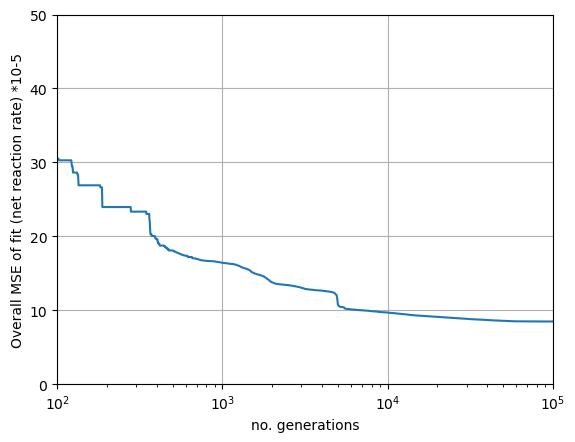

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-11.061529130112115
1.4581017644648984
0.8555988804758264
-4.059230420310218
0.46105226797491955
3.3662550982941803e-06
0.39015567501261605
-3.468709360876976
0.18484078050029626
3.9176692762386094
2.773076412180507
3.031587828143999
0.567454155846682
0.04666139948448122
3.1545583503985526
7.655085749318784e-06
0.4259567819650766
-11.930829459046734
1.889856252487177
1.6194358710012087
-10.069697996179045
1.0069865460264709
3.2670814218223807
0.003714390833938547
3.5766467082694824
3.114169312292078
1.366133179324103
7.586245177846308
-9.83694366572154
2.6709834280692077
1.5961218981970045
3.3847713137689497
-4.125423029015804
0.5184604607128748
0.9692591581944442
-1.3010299871789068


In [37]:
res.X

array([-1.10615291e+01,  1.45810176e+00,  8.55598880e-01, -4.05923042e+00,
        4.61052268e-01,  3.36625510e-06,  3.90155675e-01, -3.46870936e+00,
        1.84840781e-01,  3.91766928e+00,  2.77307641e+00,  3.03158783e+00,
        5.67454156e-01,  4.66613995e-02,  3.15455835e+00,  7.65508575e-06,
        4.25956782e-01, -1.19308295e+01,  1.88985625e+00,  1.61943587e+00,
       -1.00696980e+01,  1.00698655e+00,  3.26708142e+00,  3.71439083e-03,
        3.57664671e+00,  3.11416931e+00,  1.36613318e+00,  7.58624518e+00,
       -9.83694367e+00,  2.67098343e+00,  1.59612190e+00,  3.38477131e+00,
       -4.12542303e+00,  5.18460461e-01,  9.69259158e-01, -1.30102999e+00])

In [1]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
#logkr=np.ndarray.tolist(logkr)
#del logkr[-1]

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -11.061529130112115
1.6: 1.4581017644648984
0.9: 0.8555988804758264
-4.3: -4.059230420310218
0.5: 0.46105226797491955
0.003: 3.3662550982941803e-06
0.4: 0.39015567501261605
-7.9: -3.468709360876976
0.7: 0.18484078050029626
7.2: 3.9176692762386094
5.7: 2.773076412180507
5.7: 3.031587828143999
0.8: 0.567454155846682
0.03: 0.04666139948448122
3.1: 3.1545583503985526
6.000000000000001e-09: 7.655085749318784e-06
0.1: 0.4259567819650766
-12.0: -11.930829459046734
1.9: 1.889856252487177
1.6: 1.6194358710012087
-11.6: -10.069697996179045
1.2: 1.0069865460264709
4.0: 3.2670814218223807
0.01: 0.003714390833938547
4.2: 3.5766467082694824
5.4: 3.114169312292078
2.2: 1.366133179324103
11.8: 7.586245177846308
-12.0: -9.83694366572154
3.3: 2.6709834280692077
1.8: 1.5961218981970045
4.2: 3.3847713137689497
-4.0: -4.125423029015804
0.5: 0.5184604607128748
1.0: 0.9692591581944442
coeff fit: 0.9229095178358602
r: 0.9606817984306043


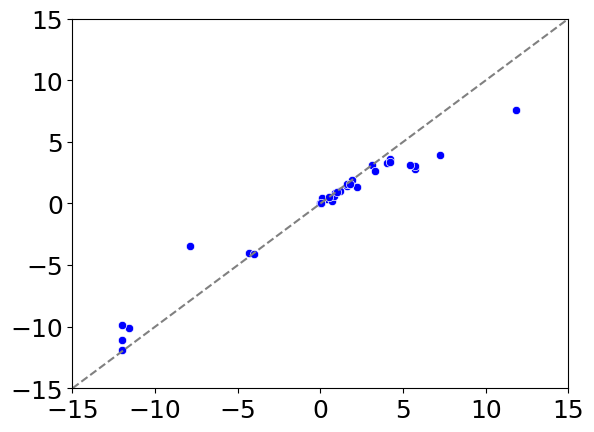

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

resX=[-1.10615291e+01,  1.45810176e+00,  8.55598880e-01, -4.05923042e+00,
        4.61052268e-01,  3.36625510e-06,  3.90155675e-01, -3.46870936e+00,
        1.84840781e-01,  3.91766928e+00,  2.77307641e+00,  3.03158783e+00,
        5.67454156e-01,  4.66613995e-02,  3.15455835e+00,  7.65508575e-06,
        4.25956782e-01, -1.19308295e+01,  1.88985625e+00,  1.61943587e+00,
       -1.00696980e+01,  1.00698655e+00,  3.26708142e+00,  3.71439083e-03,
        3.57664671e+00,  3.11416931e+00,  1.36613318e+00,  7.58624518e+00,
       -9.83694367e+00,  2.67098343e+00,  1.59612190e+00,  3.38477131e+00,
       -4.12542303e+00,  5.18460461e-01,  9.69259158e-01]

# Create a scatter plot using Seaborn
sns.scatterplot(x=logkr, y= resX, color='blue') #, label='Data Points')

plt.xlim([-15, 15])
plt.ylim([-15, 15])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 


# Add a diagonal line
plt.plot([-15, 15], [-15, 15], color='grey', linestyle='--', label='Diagonal Line')


# Display the plot
plt.show()